### Sentences in lists:

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from huggingface_hub import login
from sklearn.decomposition import PCA
import math 
from IPython.display import Markdown, display
import pandas as pd
def printmd(string):
    display(Markdown(string))
import ast
from sentence_transformers import util
import matplotlib.pyplot as plt
from itertools import chain
from sentence_transformers import SentenceTransformer, util
import openai

In [2]:
df = pd.read_csv('expunations_complete_with_score_generated_pairs_minilm_openai_embeddings.csv', encoding='utf-8')


In [3]:
df

ID                                        explanation  \
0      hom_657  ['the phrase dish it out means to criticizie a...   
1     het_1635  ['', 'This is a play on words. The words "pane...   
2     hom_1510  ['sandpaper is normally rough on one side ', '...   
3      hom_955  ['', '', '', 'A contortionist is someone who c...   
4     hom_1505  ['', 'This is a play on words. The word "party...   
...        ...                                                ...   
1885  hom_2076  ['', "This is a pun on the phrase 'stroke of g...   
1886  hom_1437  ['driven can mean to drive a car or it can me ...   
1887  het_1530  ['son sounds like sun ', "This is a pun on 'su...   
1888   het_100  ['lion sounds like line ', "This is a pun on t...   
1889   hom_364  ['pony up means give up the money and pony is ...   

                                               keywords  \
0     [["waitress's", 'dish it out'], [''], [''], ['...   
1     [[''], ['glazier', 'window', 'feel your pane',...   
2     [['inventor', 'sandpaper', 'rough'], ['invento...   
3     [[''], [''], [''], ['contortionists', 'die', '...   
4     [[''], ['whose place to have a party at', 'par...   
...                                                 ...   
1885  [[''], ['Da Vinci', 'stroke', 'genius'], ['Leo...   
1886  [['cars', 'driven'], ['cars', 'driven', 'eden'...   
1887  [['doting', 'son'], ['parents', 'son', 'worshi...   
1888  [['zoo', 'lion'], ['phone', 'zoo', 'lion'], ['...   
1889  [['horse', 'pony'], ['buy', 'horse', 'pony up'...   

                                                   joke  funniness_average  \
0     She was only a Waitress ' s daughter but she s...                0.6   
1     When the glazier was sent to the hospital room...                1.2   
2     The inventor of sandpaper had a rough time of ...                1.6   
3     OLD CONTORTIONISTS never die , they just meet ...                0.2   
4     When you can ' t decide with your friends whos...                0.4   
...                                                 ...                ...   
1885  Leonardo Da Vinci could use a paint brush to m...                0.4   
1886  The earliest mention of cars is in the Bible w...                1.0   
1887           Some doting parents are son worshipers .                0.8   
1888           I phoned the zoo but the lion was busy .                1.6   
1889  Five brothers wanted to buy a horse , so they ...                1.2   

      filtered_funniness_average       expression1       expression2  \
0                       1.000000       dish it out       dish it out   
1                       2.000000              pane              pain   
2                       1.600000             rough             rough   
3                       1.000000    meet their end    meet their end   
4                       0.666667             party             party   
...                          ...               ...               ...   
1885                    0.500000  stroke of genius  stroke of genius   
1886                    1.250000        driven out        driven out   
1887                    1.000000               son               sun   
1888                    1.600000              lion              line   
1889                    1.500000           pony up           pony up   

                                              sentence1  \
0     The waitress had to dish it out to all the cus...   
1     The glazier carefully installed the new pane i...   
2       He had a rough day dealing with the challenges.   
3              Everyone will meet their end eventually.   
4     We are hosting a party at our home this Saturday.   
...                                                 ...   
1885  Her presentation was truly a stroke of genius,...   
1886  The manager was driven out of the company afte...   
1887  She is proud of her son for winning the compet...   
1888                 The lion roamed freely in the zoo.   
1889  They needed to po

In [4]:
all_sentences=[]
for i in range(len(df)):
    joke = df.iloc[i]['joke'].strip()
    word1 = df.iloc[i]['expression1'].strip()
    word2 = df.iloc[i]['expression2'].strip()
    sentence1 = df.iloc[i]['sentence1'].strip()
    sentence2 = df.iloc[i]['sentence2'].strip()

    # if the word is included in all three sentences in the same exact spelling, then the example is added to the list
    if word1.lower() in joke.lower() and word1.lower() in sentence1.lower() and word2.lower() in sentence2.lower():
        all_sentences.append([word1, word2, [joke, sentence1, sentence2]])

In [5]:
all_sentences [:3]

[['dish it out',
  'dish it out',
  ["She was only a Waitress ' s daughter but she sure could dish it out .",
   'The waitress had to dish it out to all the customers during the peak hours.',
   'During the feedback session, she was able to dish it out to her team effectively.']],
 ['pane',
  'pain',
  ["When the glazier was sent to the hospital room to check the cracked window , he told the patient in the body cast , ' ' I ' ve come to feel your pane . ' '",
   'The glazier carefully installed the new pane in the window.',
   'The patient experienced severe pain after the surgery.']],
 ['rough',
  'rough',
  ['The inventor of sandpaper had a rough time of it .',
   'He had a rough day dealing with the challenges.',
   'The sandpaper is rough and scratches the surface.']]]

In [6]:
len(all_sentences)

1576

### Word1 in the list of sentences

In [7]:
all_sentences[2][1]

'rough'

### Sentence in the dataframe

In [8]:
df.iloc[2]['joke']

'The inventor of sandpaper had a rough time of it .'

### Score of the joke

In [9]:
df.iloc[2]['filtered_funniness_average']

1.6

# Start the analysis

In [10]:
# put here your huggingface token
# huggingface_token = ...
login(token=huggingface_token)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")



The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /home/digit/.cache/huggingface/token
Login successful


In [11]:
# Function to extract embeddings from a BERT model
def sentences2embeddings(sentences, verbose = False):
    embeddings_all_sentences = []
    
    # Tokenize and process each sentence
    for sentence in sentences:
        if verbose == True: 
            print("Calculating the embeddings of: ", sentence)
            print()
        inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
        
        # Forward pass through the model
        outputs = model(**inputs, output_hidden_states=True)
    
        # Extract token embeddings from the last hidden layer
        tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        if verbose == True: 
            print("tokens: ", tokens)
            print()
    
        # Extract embeddings from the last hidden layer
        embeddings = outputs.hidden_states[-1][0]  # Shape: [seq_len, hidden_dim]
    
        token_embeddings_pairs = {}
        for token, embedding in zip(tokens, embeddings):
            # Create the dictionary of token and its embedding
            token_embeddings_pairs[token] = embedding.tolist()
    
        embeddings_all_sentences.append(token_embeddings_pairs)
        
    return embeddings_all_sentences



In [12]:
def vis_points(data):

    x = data[:, 0]
    y = data[:, 1]
    z = data[:, 2]
    
    labels=[]
    for i in range (len(data)):
        labels.append(str(i+1))
    
    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c='b', marker='o')
    for i, label in enumerate(labels):
        ax.text(x[i], y[i], z[i], label, fontsize=10, color='blue')
    
    # Show plot
    plt.show()

In [13]:
# Returns a numpy array with the the embedding vectors of the same word in different sentences
def find_embeddings_word_in_different_sentences(sentences, word1, word2, verbose = False):

    # Calculate embeddings of words for each sentence
    embeddings_all_sentences = sentences2embeddings(sentences)
          
    # The space is replaced with "▁" (NOTE: not "_", they are different ASCII codes) so each token of a new word starts with it 
    #word2lookfor = "▁" + word
    word2lookfor = [word1, word2]

    if verbose==True:
        # show all embeddings in each sentence
        for n in range(len(embeddings_all_sentences)):
            print()
            print ("embeddings sentence", n, ":")
            for key, value in embeddings_all_sentences[n].items():
                print(f"{key}: {value[:3]}")


    # Put the different embedding vectors of the word2lookfor in the three sentences in a list of lists:
    embeddings_all_sentences_list = []
    for i in range (len(embeddings_all_sentences)):

        data = embeddings_all_sentences[i]
        if i == 0 or i == 1: 
            string = word2lookfor[0]
        else: 
            string = word2lookfor[1]

        #Cover for cases where the word does not match exactly the embeddeing token, both if it is shorter or longer 
        #(e.g. token: globe, word: globes OR token: rack, word: racket)
        matching_values = [
            value for key, value in data.items()
            if string.startswith(key) or key.startswith(string)
        ]

        '''
        print()
        print("===== MATCHING KEYS")
        print(matching_values)
        print("=====")
        print()
        '''
        
        if len(matching_values)>=1:
            match_value = matching_values[0]
            embeddings_all_sentences_list.append(match_value)
            print()
            if i==0 or i==1:
                print ("embedding vector of", word1, "for sentence", i, ":")
            else:
                print ("embedding vector of", word2, "for sentence", i, ":")
            print (match_value[:5])
            

    # Convert it to numpy array: 3? lines for 4096 elements each (i.e. the length of the embedding vector of a word)
    embeddings_all_sentences_array = np.array(embeddings_all_sentences_list, dtype='float32')

    return embeddings_all_sentences_array
    




In [14]:
# Reduce dimensionality with PCA to visualise the array in a 3d graph
def array2pca(embeddings_all_sentences_array):

    pca = PCA(n_components=3)
    embeddings_all_sentences_array_pca = pca.fit_transform(embeddings_all_sentences_array)
    return embeddings_all_sentences_array_pca
    

In [15]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))


In [16]:
def show_meaning_distances_euclidean(embeddings_all_sentences_array, verbose = False):
    printmd ("**Euclidean distance**")
    labels=[]
    for i in range (len(embeddings_all_sentences_array)):
        labels.append(str(i+1))

    distance = -10 #this is an error code: if it does not have distances to calculate
    for i in range (len(embeddings_all_sentences_array)):
        j_list = range(i, len(embeddings_all_sentences_array))
        j_list = [*j_list]
        j_list.remove(i)
        for j in j_list:
            distance = np.linalg.norm(embeddings_all_sentences_array[i] - embeddings_all_sentences_array[j])
            if verbose == True:
                if (i+1==2 and j+1==3) or (i+1==4 and j+1==5):
                    printmd(f"**{labels[i]} and {labels[j]}: {distance:.2f}**")
                else:
                    printmd(f"{labels[i]} and {labels[j]}: {distance:.2f}")

    return distance # the last value is the distance between 2 and 3

In [17]:
def show_meaning_similarities_euclidean(embeddings_all_sentences_array, word, verbose = False):
    epsilon = 0.0001
    printmd ("**Similarity between embedding vectors of the word \""+word+"\" (based on opposite of Euclidean distance) in sentences:**")
    labels=[]
    for i in range (len(embeddings_all_sentences_array)):
        labels.append(str(i+1))

    similarity = -10 #this is an error code: if it does not have similarities to calculate
    for i in range (len(embeddings_all_sentences_array)):
        j_list = range(i, len(embeddings_all_sentences_array))
        j_list = [*j_list]
        j_list.remove(i)
        for j in j_list:
            euclidean_distance = np.linalg.norm(embeddings_all_sentences_array[i] - embeddings_all_sentences_array[j])
            similarity = 1 / (euclidean_distance + epsilon) *100
            if verbose == True:
                if (i+1==2 and j+1==3) or (i+1==4 and j+1==5):
                    printmd(f"**{labels[i]} and {labels[j]}: {similarity:.2f}**")
                else:
                    printmd(f"{labels[i]} and {labels[j]}: {similarity:.2f}")

    return similarity # the last value is the distance between 2 and 3

In [18]:
def show_meaning_similarities_cosine(embeddings_all_sentences_array, verbose = False):
    printmd ("**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**")
    labels=[]
    for i in range (len(embeddings_all_sentences_array)):
        labels.append(str(i+1))
    
    similarity = -10 #this is an error code: if it does not have similarities to calculate
    for i in range (len(embeddings_all_sentences_array)):
        j_list = range(i, len(embeddings_all_sentences_array))
        j_list = [*j_list]
        j_list.remove(i)
        for j in j_list:
            similarity = math.cos(angle_between(embeddings_all_sentences_array[i], embeddings_all_sentences_array[j]))
            if verbose == True:
                if (i+1==2 and j+1==3) or (i+1==4 and j+1==5):
                    printmd(f"**{labels[i]} and {labels[j]}: {similarity:.2f}**")
                else:
                    printmd(f"{labels[i]} and {labels[j]}: {similarity:.2f}")

    return similarity # the last value is the distance between 2 and 3

In [19]:
def analyse_word_in_sentences(sentences, word1, word2, verbose = True):
    # calculate embeddings: returns embeddings of word1 in joke and sentence1 and of word2 in sentence2
    embeddings_all_sentences_array = find_embeddings_word_in_different_sentences(sentences, word1, word2)

    print (embeddings_all_sentences_array.shape)
    
    # calculate pca for visualization
    #embeddings_all_sentences_array_pca = array2pca(embeddings_all_sentences_array)

    # visualize
    #vis_points(embeddings_all_sentences_array_pca)

    # calculate distance between points
    #euclidean_similarity = show_meaning_similarities_euclidean(embeddings_all_sentences_array, word)
    euclidean_distance = show_meaning_distances_euclidean(embeddings_all_sentences_array, verbose=verbose)
    
    print ()
    cosine_similarity = show_meaning_similarities_cosine(embeddings_all_sentences_array, verbose=verbose)

    return euclidean_distance, cosine_similarity


# TEST
## Calculate the distance between the embeddings of the same word in different contexts

In [20]:
metrics = []
n=0

# analyse the first 100 sentences
for sentences_group in all_sentences:
    word1 = sentences_group[0]
    word2 = sentences_group[1]
    printmd ("**"+word1+ " | "+ word2+"**")

    sentences = sentences_group[2]
    for i, sentence in enumerate(sentences):
        print (i+1, "-", sentence)
    print ()
    euclidean_distance, cosine_similarity = analyse_word_in_sentences(sentences, word1, word2, verbose = True)
    if euclidean_distance == -10 or cosine_similarity == -10:
        print ("skipping", df.iloc[n]['expression1'])
    else:
        metrics_line = [df.iloc[n]['joke'], df.iloc[n]['expression1'], df.iloc[n]['expression2'], df.iloc[n]['funniness_average'], df.iloc[n]['filtered_funniness_average'], euclidean_distance, cosine_similarity]
        metrics.append(metrics_line)
    print ()

    n=n+1




**dish it out | dish it out**

1 - She was only a Waitress ' s daughter but she sure could dish it out .
2 - The waitress had to dish it out to all the customers during the peak hours.
3 - During the feedback session, she was able to dish it out to her team effectively.


embedding vector of dish it out for sentence 0 :
[-0.573005735874176, -0.17573986947536469, 0.2340857982635498, -0.3365492522716522, -0.20060758292675018]

embedding vector of dish it out for sentence 1 :
[0.2974745035171509, -0.2904864549636841, -0.17393197119235992, 0.17904239892959595, 0.25837770104408264]

embedding vector of dish it out for sentence 2 :
[0.06527715176343918, -0.2722443640232086, 0.07502980530261993, -0.37694689631462097, -0.28358954191207886]
(3, 768)


**Euclidean distance**

1 and 2: 13.60

1 and 3: 13.22

**2 and 3: 12.62**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.62

**2 and 3: 0.59**

**pane | pain**

1 - When the glazier was sent to the hospital room to check the cracked window , he told the patient in the body cast , ' ' I ' ve come to feel your pane . ' '
2 - The glazier carefully installed the new pane in the window.
3 - The patient experienced severe pain after the surgery.


embedding vector of pane for sentence 0 :
[0.3486942946910858, 0.09908153861761093, -0.30228328704833984, -0.24524149298667908, 0.9720504283905029]

embedding vector of pane for sentence 1 :
[0.3166468143463135, 0.9012124538421631, 0.40533289313316345, -0.15539324283599854, 1.095610499382019]

embedding vector of pain for sentence 2 :
[-0.4259026348590851, 0.031074844300746918, 0.4371963143348694, -0.5831682085990906, 0.6374706625938416]
(3, 768)


**Euclidean distance**

1 and 2: 10.56

1 and 3: 17.89

**2 and 3: 18.44**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.27

**2 and 3: 0.25**

**rough | rough**

1 - The inventor of sandpaper had a rough time of it .
2 - He had a rough day dealing with the challenges.
3 - The sandpaper is rough and scratches the surface.


embedding vector of rough for sentence 0 :
[-0.22267790138721466, 0.31070730090141296, -0.43970346450805664, 0.056114040315151215, 0.2857145667076111]

embedding vector of rough for sentence 1 :
[-0.12122756242752075, 0.25396668910980225, -0.5024333596229553, 0.05781463161110878, 0.08743537962436676]

embedding vector of rough for sentence 2 :
[0.11333092302083969, 0.001110958051867783, 0.15653076767921448, -0.07608718425035477, 0.4559594988822937]
(3, 768)


**Euclidean distance**

1 and 2: 11.09

1 and 3: 12.56

**2 and 3: 13.75**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.56

**2 and 3: 0.51**

**meet their end | meet their end**

1 - OLD CONTORTIONISTS never die , they just meet their end .
2 - Everyone will meet their end eventually.
3 - The contortionist could effortlessly meet their ends during the performance.


embedding vector of meet their end for sentence 0 :
[0.7723337411880493, 0.6029205322265625, 0.8071562051773071, 0.05465787649154663, 0.19574789702892303]

embedding vector of meet their end for sentence 1 :
[0.49808168411254883, 0.10400058329105377, 0.5149871706962585, -0.33506834506988525, -0.12752686440944672]

embedding vector of meet their end for sentence 2 :
[0.2605043947696686, 0.425398051738739, 0.5819652676582336, 0.011510638520121574, 0.3142659068107605]
(3, 768)


**Euclidean distance**

1 and 2: 9.74

1 and 3: 10.27

**2 and 3: 10.76**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.70

**2 and 3: 0.67**

**party | party**

1 - When you can ' t decide with your friends whose place to have a party at it ' s known as party politics .
2 - We are hosting a party at our home this Saturday.
3 - The Liberal party announced its new policy agenda today.


embedding vector of party for sentence 0 :
[-0.20763352513313293, -0.8749786615371704, 1.00493323802948, -0.12267769873142242, -0.49312740564346313]

embedding vector of party for sentence 1 :
[0.1134333461523056, -0.5864203572273254, 0.8837325572967529, 0.203284353017807, 0.38589078187942505]

embedding vector of party for sentence 2 :
[-0.8268731236457825, -0.5504620671272278, -0.45878860354423523, 0.33805975317955017, 0.024544451385736465]
(3, 768)


**Euclidean distance**

1 and 2: 13.97

1 and 3: 14.73

**2 and 3: 16.52**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.54

**2 and 3: 0.39**

**fair | fare**

1 - None but the brave deserve the fair .
2 - She looked fair in the sunlight.
3 - He paid the bus fare to get home.


embedding vector of fair for sentence 0 :
[0.301480233669281, -0.08560672402381897, 0.14493297040462494, 0.11483737826347351, 0.5497223734855652]

embedding vector of fair for sentence 1 :
[0.4932217597961426, -0.36714571714401245, 0.36720535159111023, 0.5415695309638977, 0.18628089129924774]

embedding vector of fare for sentence 2 :
[0.42843979597091675, -0.9682156443595886, 0.40231046080589294, -0.5609055757522583, 0.0976821631193161]
(3, 768)


**Euclidean distance**

1 and 2: 12.16

1 and 3: 17.15

**2 and 3: 17.70**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.28

**2 and 3: 0.27**

**heart | art**

1 - Romance isn ' t a science - it ' s a heart .
2 - She placed her hand over her heart as a sign of sincerity.
3 - The painting was a masterpiece of modern art.


embedding vector of heart for sentence 0 :
[0.1342032253742218, -0.20615696907043457, -0.04763782396912575, -0.06073542311787605, 0.9947172999382019]

embedding vector of heart for sentence 1 :
[0.30850109457969666, 0.4373469948768616, -0.2772805094718933, -0.9896120429039001, 0.60635906457901]

embedding vector of art for sentence 2 :
[0.3782111704349518, -0.23383788764476776, 0.7659550309181213, -0.030597994104027748, 0.8392210602760315]
(3, 768)


**Euclidean distance**

1 and 2: 13.75

1 and 3: 16.50

**2 and 3: 16.79**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.32

**2 and 3: 0.32**

**bust | bust**

1 - OLD STATUES never die they just get busted .
2 - The artist carved a detailed bust of the famous leader.
3 - The police busted the illegal activities in the warehouse.


embedding vector of bust for sentence 0 :
[0.7870761156082153, 0.04147757217288017, -0.05371628701686859, 0.7684561610221863, 0.1871059536933899]

embedding vector of bust for sentence 1 :
[0.4514034390449524, 0.6997566819190979, 0.28393858671188354, 0.10339394956827164, -0.11804527044296265]

embedding vector of bust for sentence 2 :
[0.4540698826313019, -0.12620002031326294, 0.48020344972610474, 0.41937071084976196, -0.06969188898801804]
(3, 768)


**Euclidean distance**

1 and 2: 14.25

1 and 3: 11.87

**2 and 3: 14.25**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.42

1 and 3: 0.57

**2 and 3: 0.40**

**stage | stage**

1 - Actors are cast through their good and bad stages .
2 - The actors rehearsed their lines on the stage.
3 - She is currently in a challenging stage of her career.


embedding vector of stage for sentence 0 :
[0.3786091208457947, 0.5739692449569702, -0.5405482649803162, -0.514356791973114, 0.6863250732421875]

embedding vector of stage for sentence 1 :
[0.5900063514709473, 0.5699114799499512, -0.3611893951892853, -0.06853950768709183, -0.04673781618475914]

embedding vector of stage for sentence 2 :
[-0.7396901845932007, 0.2094118446111679, -0.26395076513290405, -1.1630750894546509, 0.5619602799415588]
(3, 768)


**Euclidean distance**

1 and 2: 14.26

1 and 3: 12.07

**2 and 3: 15.66**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.62

**2 and 3: 0.45**

**cop out | cop out**

1 - OLD POLICEMEN never die they just cop out .
2 - He tends to cop out whenever there's a challenge he dislikes.
3 - After years of service, the cop finally decided to cop out and retire.


embedding vector of cop out for sentence 0 :
[0.7091813087463379, 0.00781343039125204, 0.990354061126709, -0.6739173531532288, -0.6669125556945801]

embedding vector of cop out for sentence 1 :
[0.3499138355255127, -0.24912457168102264, 0.3302941918373108, -0.15410850942134857, -0.4170164167881012]

embedding vector of cop out for sentence 2 :
[0.8870123028755188, -0.17456962168216705, 1.4686287641525269, -0.5584443807601929, -0.3499077260494232]
(3, 768)


**Euclidean distance**

1 and 2: 12.71

1 and 3: 10.95

**2 and 3: 13.83**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.72

**2 and 3: 0.54**

**toast | toast**

1 - My friend ' s bakery burned down last night . Now his business is toast .
2 - She enjoys eating toast with jam for breakfast.
3 - His computer system is toast after the virus attack.


embedding vector of toast for sentence 0 :
[0.586689293384552, 0.521462082862854, 0.28758859634399414, -0.07966002821922302, -0.32753634452819824]

embedding vector of toast for sentence 1 :
[0.240687757730484, 0.8129271268844604, 0.31201374530792236, -0.5666927099227905, -0.03589216247200966]

embedding vector of toast for sentence 2 :
[0.21826916933059692, -0.14367306232452393, -0.2937324345111847, 0.31173601746559143, 0.2789280414581299]
(3, 768)


**Euclidean distance**

1 and 2: 13.20

1 and 3: 11.94

**2 and 3: 14.82**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.60

1 and 3: 0.62

**2 and 3: 0.45**

**painfully | pane-fully**

1 - ' ' I swallowed some of the glass from that broken window , ' ' Tom said painfully .
2 - She spoke painfully about her injuries after the accident.
3 - The room was pane-fully lined with beautiful windows.


embedding vector of painfully for sentence 0 :
[0.8265175223350525, 0.8025516867637634, -0.05670640617609024, -0.3669171631336212, 0.09252272546291351]

embedding vector of painfully for sentence 1 :
[-0.23135168850421906, -0.33897218108177185, -0.25264522433280945, -0.20850984752178192, 0.2683907449245453]

embedding vector of pane-fully for sentence 2 :
[0.520408570766449, 0.5021570324897766, 0.36005207896232605, -0.21177104115486145, 0.9599202275276184]
(3, 768)


**Euclidean distance**

1 and 2: 11.21

1 and 3: 18.03

**2 and 3: 17.67**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.22

**2 and 3: 0.26**

**crude | crude**

1 - Oil executives are always using crude language .
2 - The manager was criticized for his crude language during the meeting.
3 - The refinery processes crude oil into gasoline.


embedding vector of crude for sentence 0 :
[1.485491156578064, 0.17915330827236176, -0.38983461260795593, -0.6675578951835632, 0.7371376156806946]

embedding vector of crude for sentence 1 :
[0.21535488963127136, -0.0720539316534996, -0.23912544548511505, -0.28882884979248047, -0.38517072796821594]

embedding vector of crude for sentence 2 :
[1.4847863912582397, 0.2058572769165039, -0.4959789216518402, -0.3559226393699646, 0.563686728477478]
(3, 768)


**Euclidean distance**

1 and 2: 13.97

1 and 3: 13.16

**2 and 3: 16.67**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.64

**2 and 3: 0.38**

**goal | goal**

1 - Coaches usually have a goal in mind .
2 - The team worked hard to score a goal.
3 - Her main goal is to become a successful engineer.


embedding vector of goal for sentence 0 :
[-0.3405531048774719, -0.06515822559595108, -0.0628635510802269, -0.7098879218101501, 0.271697998046875]

embedding vector of goal for sentence 1 :
[-0.31697070598602295, -0.22464892268180847, -0.5116072297096252, 0.0090811001136899, 0.26939713954925537]

embedding vector of goal for sentence 2 :
[-0.2189583033323288, 0.03196752816438675, -0.1196255162358284, -0.7744837403297424, 0.9473896622657776]
(3, 768)


**Euclidean distance**

1 and 2: 13.18

1 and 3: 13.09

**2 and 3: 17.09**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.62

**2 and 3: 0.33**

**drowned | drowned**

1 - Good swimmers are often drowned .
2 - He drowned last summer while swimming in the lake.
3 - She felt drowned by the amount of work she had.


embedding vector of drowned for sentence 0 :
[0.9456454515457153, -0.2045469731092453, 0.06311222910881042, 0.3147631883621216, 0.6197373270988464]

embedding vector of drowned for sentence 1 :
[0.9923450350761414, -0.5017327666282654, 0.7043649554252625, 0.6330282688140869, 0.6775789260864258]

embedding vector of drowned for sentence 2 :
[0.809960126876831, 0.31431376934051514, 0.5217940807342529, -0.3951210081577301, 0.2394368052482605]
(3, 768)


**Euclidean distance**

1 and 2: 13.21

1 and 3: 15.08

**2 and 3: 15.26**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.50

**2 and 3: 0.50**

**tenor | tender**

1 - One day my friend asked me , how do you take such good care of your saxophone . I responded with tenor , love and care .
2 - He plays a tenor saxophone in the jazz band.
3 - She offered tender love and care to the injured animal.


embedding vector of tenor for sentence 0 :
[0.7486059665679932, 1.0521222352981567, 0.3204800486564636, -0.29305118322372437, -0.2568509876728058]

embedding vector of tenor for sentence 1 :
[-0.013881879858672619, 0.06708423793315887, 0.48348477482795715, -0.22591662406921387, -0.1571478396654129]

embedding vector of tender for sentence 2 :
[-0.21405893564224243, -0.14225736260414124, 0.18106220662593842, -0.5788530111312866, 0.3723539710044861]
(3, 768)


**Euclidean distance**

1 and 2: 14.27

1 and 3: 16.49

**2 and 3: 17.69**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.33

**2 and 3: 0.31**

**toasted | toasted**

1 - They threw a party for the inventor of the toaster . And he was toasted .
2 - After breakfast, she toasted her bread to a golden brown.
3 - During the celebration, they toasted the inventor of the toaster with a champagne glass.


embedding vector of toasted for sentence 0 :
[0.26141557097435, 0.46231040358543396, 0.5658957362174988, -0.004029786214232445, -0.23136048018932343]

embedding vector of toasted for sentence 1 :
[0.7426980137825012, 0.05518519505858421, 0.282428115606308, 0.17836546897888184, -0.3193877339363098]

embedding vector of toasted for sentence 2 :
[-0.12533098459243774, 0.5123316049575806, 0.8386073112487793, -0.12507721781730652, -0.046395231038331985]
(3, 768)


**Euclidean distance**

1 and 2: 14.00

1 and 3: 13.61

**2 and 3: 16.49**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.64

**2 and 3: 0.47**

**quarter | quarter**

1 - If the mint makes 25 cent pieces it should expect quarterly profits .
2 - The mint produces millions of quarters each year.
3 - The company expects significant growth in its quarterly profits.


embedding vector of quarter for sentence 0 :
[-0.7436587810516357, -0.30408623814582825, 0.6928250193595886, -0.13106796145439148, 0.4132637083530426]

embedding vector of quarter for sentence 1 :
[0.17638982832431793, 0.42022398114204407, 0.4573151469230652, -0.12325873225927353, 1.0393450260162354]

embedding vector of quarter for sentence 2 :
[-0.8021355867385864, -0.6381691694259644, 0.7685248851776123, -0.2577228546142578, 0.13032937049865723]
(3, 768)


**Euclidean distance**

1 and 2: 17.89

1 and 3: 9.25

**2 and 3: 18.57**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.31

1 and 3: 0.78

**2 and 3: 0.30**

**barked | Bach**

1 - ' ' I ' ve been listening to the Brandenburg Concertos , ' ' Tom barked .
2 - He barked loudly at the stranger.
3 - She enjoys listening to Bach's Brandenburg Concertos.


embedding vector of barked for sentence 0 :
[1.679693579673767, 0.9084901213645935, -0.1910802274942398, -0.6111482381820679, 0.17363378405570984]

embedding vector of barked for sentence 1 :
[0.7838716506958008, 0.6687212586402893, -0.6706221103668213, -1.120722770690918, -0.30788612365722656]
(2, 768)


**Euclidean distance**

1 and 2: 10.97

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

**steep | steep**

1 - I went to buy some property with a hill on it , but it was a little steep .
2 - The hill was very steep and challenging to hike.
3 - The new software update was a bit steep for my budget.


embedding vector of steep for sentence 0 :
[-0.28603601455688477, 0.2538505792617798, 0.5010778903961182, -0.6459543704986572, -0.02005481719970703]

embedding vector of steep for sentence 1 :
[0.054267946630716324, -0.0562325045466423, 0.46083274483680725, -0.5433710813522339, -0.23932994902133942]

embedding vector of steep for sentence 2 :
[-0.12036141008138657, -0.19053693115711212, -0.09695743769407272, -0.0852941945195198, 0.22204884886741638]
(3, 768)


**Euclidean distance**

1 and 2: 8.85

1 and 3: 11.72

**2 and 3: 11.95**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.66

**2 and 3: 0.63**

**environment | environment**

1 - Environmentalist : expert in computer operating systems .
2 - She is passionate about protecting the environment from pollution.
3 - Developers set up a new environment for testing the application.


embedding vector of environment for sentence 0 :
[-0.097316674888134, 0.5358222723007202, -0.22794686257839203, -0.06478961557149887, 1.1965490579605103]

embedding vector of environment for sentence 1 :
[1.0912795066833496, 0.28954851627349854, -0.40148690342903137, 0.11660691350698471, 1.3469109535217285]

embedding vector of environment for sentence 2 :
[0.2053893506526947, 0.31420454382896423, 0.06212462857365608, -0.13993939757347107, 0.16062122583389282]
(3, 768)


**Euclidean distance**

1 and 2: 17.05

1 and 3: 18.14

**2 and 3: 14.23**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.36

1 and 3: 0.18

**2 and 3: 0.44**

**Leo | leo**

1 - My name is Leo . A lion trainer .
2 - Leo works as a graphic designer.
3 - The leo is known for its strength and courage.


embedding vector of leo for sentence 2 :
[0.11754175275564194, 0.03513789176940918, -0.2262173593044281, -0.5995080471038818, 0.3606683015823364]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping tenor



**partial | partial**

1 - I strongly dislike the subject of math , however I am partial to fractions .
2 - She is partial to chocolate ice cream.
3 - The blueprint shows a partial view of the building's structure.


embedding vector of partial for sentence 0 :
[-0.1857714056968689, 0.5663111209869385, 0.09741740673780441, -0.1650036871433258, -1.189012050628662]

embedding vector of partial for sentence 1 :
[0.3331991136074066, -0.282798707485199, -0.4278392493724823, -0.059017762541770935, -1.1672886610031128]

embedding vector of partial for sentence 2 :
[-0.22325372695922852, -0.24536903202533722, 0.6187769174575806, -0.03966590017080307, 0.4638536274433136]
(3, 768)


**Euclidean distance**

1 and 2: 11.94

1 and 3: 15.16

**2 and 3: 15.75**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.43

**2 and 3: 0.38**

**tender | tender**

1 - My bid for this contract aims to please , said Tom tenderly .
2 - She gave a tender hug to comfort her friend.
3 - The company submitted their tender for the new infrastructure project.


embedding vector of tender for sentence 0 :
[-0.018497193232178688, 0.44664597511291504, 0.780394971370697, -0.07099881023168564, 0.627048671245575]

embedding vector of tender for sentence 1 :
[-0.7640202045440674, -0.05236819386482239, 0.3759666979312897, -0.1889200657606125, -0.27513179183006287]

embedding vector of tender for sentence 2 :
[0.16783173382282257, 0.16965387761592865, 0.7076138854026794, -0.28421303629875183, -0.19514945149421692]
(3, 768)


**Euclidean distance**

1 and 2: 14.21

1 and 3: 16.91

**2 and 3: 16.98**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.46

1 and 3: 0.28

**2 and 3: 0.32**

**maneuver | manure**

1 - When walking through a pig barn be careful how you maneuver .
2 - The skilled pilot had to maneuver the airplane carefully during the storm.
3 - Farmers spread manure on the fields to enrich the soil.


embedding vector of maneuver for sentence 0 :
[0.16698938608169556, 0.15107378363609314, -0.21828588843345642, -0.16337840259075165, 1.1568036079406738]

embedding vector of maneuver for sentence 1 :
[-0.21513274312019348, 0.2382625937461853, 0.16103072464466095, 0.6217520833015442, 0.22355356812477112]

embedding vector of manure for sentence 2 :
[0.40735819935798645, 0.36218154430389404, 0.04174473136663437, 0.28653743863105774, 0.33030614256858826]
(3, 768)


**Euclidean distance**

1 and 2: 11.00

1 and 3: 18.47

**2 and 3: 17.70**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.35

**2 and 3: 0.35**

**goose | goose**

1 - Don ' t kill the goose that lays the golden eggs .
2 - The goose waddled across the farmyard.
3 - He decided to goose his friend during the meeting.


embedding vector of goose for sentence 0 :
[0.8205159306526184, 0.17980143427848816, -0.30595141649246216, 0.17964868247509003, 0.4840724468231201]

embedding vector of goose for sentence 1 :
[0.6601267457008362, -0.1389780342578888, -0.04924509674310684, 0.3998314440250397, 0.6717582941055298]

embedding vector of goose for sentence 2 :
[0.6661604046821594, 0.0669570192694664, 0.4561379849910736, 0.16905224323272705, 0.5860776901245117]
(3, 768)


**Euclidean distance**

1 and 2: 11.30

1 and 3: 14.28

**2 and 3: 15.40**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.52

**2 and 3: 0.47**

**candid | candid**

1 - Photographers are often very candid people .
2 - He appreciated her candid feedback, as she was always honest and straightforward.
3 - The photographer captured a beautiful candid of the crowd at the concert.


embedding vector of candid for sentence 0 :
[-0.06561106443405151, -0.45192834734916687, 0.10960540175437927, -0.3300148546695709, 0.2643812894821167]

embedding vector of candid for sentence 1 :
[-0.6748009324073792, -0.5665416121482849, -0.20516900718212128, 0.2743978202342987, -0.44930219650268555]

embedding vector of candid for sentence 2 :
[-0.028385937213897705, -0.2058907449245453, 0.27272146940231323, -0.25342127680778503, 0.36305099725723267]
(3, 768)


**Euclidean distance**

1 and 2: 12.77

1 and 3: 12.30

**2 and 3: 15.50**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.69

**2 and 3: 0.51**

**rue | rue**

1 - ' I got lost in the streets of Paris , ' he said ruefully .
2 - We walked down the narrow rue in the heart of Paris.
3 - She began to rue her missed opportunities.


embedding vector of rue for sentence 0 :
[0.2232106477022171, 0.3052070438861847, 0.22068755328655243, 0.10464305430650711, 1.1776378154754639]

embedding vector of rue for sentence 1 :
[1.2588907480239868, -0.008856168016791344, 0.31465473771095276, -0.22091589868068695, 0.7337332367897034]

embedding vector of rue for sentence 2 :
[0.4900190234184265, 0.5873240828514099, 0.16928231716156006, -0.30191200971603394, -0.25506269931793213]
(3, 768)


**Euclidean distance**

1 and 2: 18.18

1 and 3: 16.28

**2 and 3: 17.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.42

1 and 3: 0.48

**2 and 3: 0.39**

**overall | overall**

1 - A farmer with a rip in his clothes has an overall problem .
2 - Her overall assessment of the project was positive.
3 - He wore an overall while working on the tractor.


embedding vector of overall for sentence 0 :
[0.16143463551998138, 0.5422453880310059, -0.543310821056366, -0.11269032955169678, -0.6003181338310242]

embedding vector of overall for sentence 1 :
[-0.06502699106931686, -0.4825579822063446, -0.4836871027946472, 0.11514051258563995, -0.5631164908409119]

embedding vector of overall for sentence 2 :
[0.9904174208641052, -0.033213090151548386, -0.7382314801216125, -0.1787647157907486, 0.4699600636959076]
(3, 768)


**Euclidean distance**

1 and 2: 13.51

1 and 3: 14.87

**2 and 3: 15.71**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.50

**2 and 3: 0.42**

**serve | serve**

1 - Occasionally , I hear an assertion followed by a hasty qualification , such as , ' ' Jim graduated in 1995 - - if memory serves . ' ' I ' ll respond : ' . . . or only stands and waits . ' '
2 - The tennis player is ready to serve.
3 - The volunteers serve the community every weekend.


embedding vector of serve for sentence 0 :
[0.9143187999725342, 1.2471824884414673, 0.38810667395591736, -0.5411285758018494, -0.017494898289442062]

embedding vector of serve for sentence 1 :
[0.5512260794639587, -0.06709438562393188, 0.30033501982688904, -0.4661726951599121, -0.07686857879161835]

embedding vector of serve for sentence 2 :
[0.1916056126356125, 0.9555017948150635, 0.35720348358154297, -0.6216493844985962, 0.31109729409217834]
(3, 768)


**Euclidean distance**

1 and 2: 17.91

1 and 3: 17.82

**2 and 3: 14.35**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.33

1 and 3: 0.32

**2 and 3: 0.47**

**soda | soda**

1 - Would you like some soda in your whiskey ? asked Tom caustically .
2 - I would like a soda with my lunch.
3 - The cleaner used soda to remove the stains.


embedding vector of soda for sentence 0 :
[0.09062094986438751, 0.30777522921562195, -0.5193973183631897, 0.29005780816078186, 0.3747566342353821]

embedding vector of soda for sentence 1 :
[0.08201807737350464, 0.10290287435054779, -0.290944904088974, 0.4163976311683655, 0.4049467444419861]

embedding vector of soda for sentence 2 :
[0.4629153907299042, 0.2948421537876129, 0.01474829763174057, 0.20226261019706726, 0.23371946811676025]
(3, 768)


**Euclidean distance**

1 and 2: 7.48

1 and 3: 10.40

**2 and 3: 11.44**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.86

1 and 3: 0.71

**2 and 3: 0.67**

**count on | count on**

1 - The inept mathematician couldn ' t count on his friends .
2 - The accountant needs to count on each invoice accurately.
3 - I can always count on my friends for support.


embedding vector of count on for sentence 0 :
[0.8423016667366028, -0.664384126663208, 0.1254720538854599, -0.03058740310370922, 0.24305255711078644]

embedding vector of count on for sentence 1 :
[0.8544012904167175, 0.37469494342803955, 0.16006219387054443, -0.08924562484025955, 0.5302874445915222]

embedding vector of count on for sentence 2 :
[1.074945092201233, 0.22494442760944366, 0.49815285205841064, -0.4380435645580292, -0.18915057182312012]
(3, 768)


**Euclidean distance**

1 and 2: 13.72

1 and 3: 13.25

**2 and 3: 14.45**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.69

**2 and 3: 0.58**

**impact | impact**

1 - Have you heard the joke about the bomb ? It had no impact .
2 - The car's impact with the wall caused significant damage.
3 - The new policy had a positive impact on the economy.


embedding vector of impact for sentence 0 :
[0.4652007818222046, -0.10442151874303818, -0.3860113024711609, -0.11723868548870087, -0.3661316931247711]

embedding vector of impact for sentence 1 :
[0.09364939481019974, -0.7176113128662109, -0.5702810287475586, -0.12564320862293243, 0.2538585662841797]

embedding vector of impact for sentence 2 :
[-0.37918153405189514, -0.08182088285684586, -0.2257123440504074, -0.4496932625770569, -0.8062922358512878]
(3, 768)


**Euclidean distance**

1 and 2: 14.42

1 and 3: 13.72

**2 and 3: 15.69**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.56

**2 and 3: 0.49**

**state | state**

1 - Many people need to learn to be happy with the State they are in .
2 - Alaska is the largest state in the United States.
3 - She is in a happy state of mind.


embedding vector of state for sentence 0 :
[0.07074780762195587, 0.43761003017425537, -0.2691599428653717, -0.5381653904914856, 0.42646586894989014]

embedding vector of state for sentence 1 :
[0.339142382144928, -0.5790081024169922, 0.06762167066335678, -0.0764104351401329, -0.45467081665992737]

embedding vector of state for sentence 2 :
[-0.07972937077283859, 0.0397692546248436, 0.5755734443664551, -0.23408250510692596, 0.521571934223175]
(3, 768)


**Euclidean distance**

1 and 2: 14.72

1 and 3: 15.51

**2 and 3: 17.64**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.53

**2 and 3: 0.43**

**urgent appointment | urgent appointment**

1 - ' ' I ' ve an urgent appointment , ' ' said Tom in Russian .
2 - Tom scheduled an urgent appointment to discuss the project.
3 - Tom excused himself for an urgent appointment during the meeting.


embedding vector of urgent appointment for sentence 0 :
[0.24353855848312378, -0.06255442649126053, 0.36434340476989746, -0.7979084253311157, 0.7913859486579895]

embedding vector of urgent appointment for sentence 1 :
[0.17914550006389618, -0.5071697235107422, 0.18531931936740875, -0.26707199215888977, 0.25876209139823914]

embedding vector of urgent appointment for sentence 2 :
[0.24545066058635712, -0.5292045474052429, 0.25699135661125183, -0.2456778883934021, 0.7615849375724792]
(3, 768)


**Euclidean distance**

1 and 2: 10.32

1 and 3: 9.23

**2 and 3: 8.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.81

**2 and 3: 0.84**

**net | net**

1 - The trapeze artist had to buy his own safety equipment . Every Friday he drew his net wages .
2 - His net income increased after all deductions were made.
3 - The trapeze artist inspected the safety net before every performance.


embedding vector of net for sentence 0 :
[1.1161816120147705, -0.382730633020401, 0.4365480840206146, 0.04248029738664627, -0.06326259672641754]

embedding vector of net for sentence 1 :
[0.36025816202163696, -0.3470645248889923, 0.5597140789031982, -0.022577548399567604, -0.0005654268315993249]

embedding vector of net for sentence 2 :
[0.5774402618408203, -0.5300231575965881, 0.1939592957496643, 0.28943562507629395, 0.24918220937252045]
(3, 768)


**Euclidean distance**

1 and 2: 10.95

1 and 3: 13.35

**2 and 3: 13.76**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.51

**2 and 3: 0.47**

**kid | kid**

1 - We’ve got children’s church because we know how to kid around
2 - She took her kid to the playground every afternoon.
3 - He didn't intend to kid you with his remarks.


embedding vector of kid for sentence 0 :
[0.6346803903579712, 0.5345048308372498, 0.09023764729499817, -0.05367220938205719, 0.1077428087592125]

embedding vector of kid for sentence 1 :
[-0.2678099274635315, -0.5033570528030396, 0.3388404846191406, 0.7227697372436523, 0.5993223190307617]

embedding vector of kid for sentence 2 :
[1.0705201625823975, -0.21618734300136566, 0.0666126236319542, -0.12147366255521774, -0.0700315311551094]
(3, 768)


**Euclidean distance**

1 and 2: 14.36

1 and 3: 13.00

**2 and 3: 16.39**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.44

**2 and 3: 0.36**

**husky | husky**

1 - One ear of corn said to the other ' You ' re getting husky ' .
2 - She has been getting husky over the holidays.
3 - The husky protected the corn ear from the weather.


embedding vector of husky for sentence 0 :
[-0.4205613434314728, 0.04610087350010872, 0.8311833739280701, -0.6585411429405212, 0.38652873039245605]

embedding vector of husky for sentence 1 :
[-0.5536887645721436, -0.5020378232002258, 0.6758740544319153, -1.4561227560043335, 0.026347892358899117]

embedding vector of husky for sentence 2 :
[-0.26484113931655884, 0.5308572053909302, 0.3327467739582062, -0.35356855392456055, 0.8779538869857788]
(3, 768)


**Euclidean distance**

1 and 2: 8.92

1 and 3: 12.17

**2 and 3: 13.45**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.58

**2 and 3: 0.51**

**reign | rain**

1 - Britain is a wet place since the queen has had a long reign .
2 - The queen's reign lasted over six decades.
3 - Heavy rain caused the river to overflow.


embedding vector of reign for sentence 0 :
[0.9133570790290833, -0.38523703813552856, 0.6318535208702087, -0.3024549186229706, 0.09682002663612366]

embedding vector of reign for sentence 1 :
[0.5143373012542725, -0.5743613243103027, -0.06076279282569885, 0.05515051260590553, -0.20257747173309326]

embedding vector of rain for sentence 2 :
[0.336379736661911, 0.3890840709209442, 0.2751535177230835, -0.322987824678421, 1.0965054035186768]
(3, 768)


**Euclidean distance**

1 and 2: 11.04

1 and 3: 19.01

**2 and 3: 18.78**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.28

**2 and 3: 0.32**

**knead | need**

1 - Bakers have a great knead to make bread .
2 - Bakers knead dough every morning.
3 - The community needs more volunteers.


embedding vector of knead for sentence 0 :
[0.4529534876346588, -0.048827387392520905, 0.36930590867996216, 0.019869226962327957, 0.0618654228746891]

embedding vector of knead for sentence 1 :
[0.2909505367279053, -0.02487836964428425, 0.5736035108566284, -0.013666265644133091, 0.21154877543449402]

embedding vector of need for sentence 2 :
[0.12811841070652008, 0.1247325912117958, 0.43633198738098145, 0.2026783674955368, 0.40123170614242554]
(3, 768)


**Euclidean distance**

1 and 2: 11.07

1 and 3: 17.82

**2 and 3: 17.94**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.38

**2 and 3: 0.38**

**rectified | rectum**

1 - The proctologist reassured the patient that his condition could be rectified .
2 - The technician rectified the network issue.
3 - The doctor examined the patient's rectum.


embedding vector of rectified for sentence 0 :
[-0.5197522640228271, -0.5041036009788513, 0.5685140490531921, -0.1643611490726471, 0.23364849388599396]

embedding vector of rectified for sentence 1 :
[-0.16223549842834473, -0.5375357270240784, 0.6881304383277893, 0.020815499126911163, 0.06206779181957245]

embedding vector of rectum for sentence 2 :
[0.1378220021724701, -0.06749095022678375, 0.29783886671066284, 0.21076445281505585, 0.08707864582538605]
(3, 768)


**Euclidean distance**

1 and 2: 12.05

1 and 3: 16.58

**2 and 3: 17.32**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.46

**2 and 3: 0.40**

**organ | organ**

1 - There was a guy who played the organ in his garden to get organically grown food .
2 - He decided to play the organ during the evening service.
3 - The liver is an essential organ for detoxifying the body.


embedding vector of organ for sentence 0 :
[0.4692728519439697, 0.5569734573364258, -0.039780907332897186, -0.1316654086112976, 0.3927677571773529]

embedding vector of organ for sentence 1 :
[0.14946000277996063, 0.6073995232582092, 0.3017660081386566, -0.6126508116722107, 0.35944172739982605]

embedding vector of organ for sentence 2 :
[-0.12151508778333664, 0.6595880389213562, 0.2687729001045227, 0.31782254576683044, 0.48773112893104553]
(3, 768)


**Euclidean distance**

1 and 2: 9.94

1 and 3: 15.65

**2 and 3: 15.37**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.44

**2 and 3: 0.43**

**buzz | buzz**

1 - There is rarely a sale on beer because the demand is always high so there ' s no need to create a buzz .
2 - The marketing team worked hard to create a buzz around the new product launch.
3 - After a few beers, he started to feel a light buzz.


embedding vector of buzz for sentence 0 :
[0.7142243981361389, -0.4035966694355011, 1.0612956285476685, 0.12733903527259827, -0.14756830036640167]

embedding vector of buzz for sentence 1 :
[0.7442834377288818, -0.6728995442390442, 0.5951396822929382, 0.10155753791332245, -0.4230293333530426]

embedding vector of buzz for sentence 2 :
[0.5040247440338135, -0.21473513543605804, 0.9036737084388733, -0.9530748724937439, 0.039233963936567307]
(3, 768)


**Euclidean distance**

1 and 2: 8.14

1 and 3: 12.67

**2 and 3: 12.71**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.60

**2 and 3: 0.61**

**leaked | leaked**

1 - News of a coming flood was leaked .
2 - The new policy was leaked to the press before the official announcement.
3 - The roof leaked after the heavy rain caused damage.


embedding vector of leaked for sentence 0 :
[1.3095704317092896, -1.0544995069503784, 0.47015658020973206, 0.31109797954559326, -0.0172822754830122]

embedding vector of leaked for sentence 1 :
[0.2630513608455658, -0.912622332572937, 0.3065102994441986, -0.26711106300354004, -0.034718260169029236]

embedding vector of leaked for sentence 2 :
[0.5555793046951294, -0.8809613585472107, 0.47283104062080383, 0.37995025515556335, 0.7673832774162292]
(3, 768)


**Euclidean distance**

1 and 2: 10.61

1 and 3: 13.59

**2 and 3: 13.12**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.51

**2 and 3: 0.53**

**butcher | butcher**

1 - I ' d tell you a joke about a cow but I always butcher it .
2 - The director butchered the film by making poor casting choices.
3 - The butcher prepared fresh steaks for the customers.


embedding vector of butcher for sentence 0 :
[0.25132688879966736, -0.3625645637512207, 0.20953558385372162, 0.20605599880218506, -0.25353994965553284]

embedding vector of butcher for sentence 1 :
[0.8183637857437134, 0.4523814916610718, -0.6013286113739014, 0.2647431194782257, 0.0012994639109820127]

embedding vector of butcher for sentence 2 :
[1.6944496631622314, -0.11401411145925522, -0.2694719135761261, 0.4641898572444916, -0.14610181748867035]
(3, 768)


**Euclidean distance**

1 and 2: 17.07

1 and 3: 18.67

**2 and 3: 14.75**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.24

1 and 3: 0.23

**2 and 3: 0.45**

**developing | developing**

1 - OLD PHOTOGRAPHERS never die they just stop developing .
2 - The company is developing new strategies to expand its market reach.
3 - The photographer is developing the exposed film in the darkroom.


embedding vector of developing for sentence 0 :
[0.9070559740066528, 0.8243820667266846, 0.35752010345458984, 0.26046258211135864, 0.5738549828529358]

embedding vector of developing for sentence 1 :
[-0.1766849309206009, -0.1825934499502182, 0.04035999998450279, -0.3840092420578003, 0.11241079866886139]

embedding vector of developing for sentence 2 :
[0.03507798910140991, 0.5869801640510559, 0.29066938161849976, 0.14383068680763245, 0.7234956622123718]
(3, 768)


**Euclidean distance**

1 and 2: 14.41

1 and 3: 10.66

**2 and 3: 12.45**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.44

1 and 3: 0.68

**2 and 3: 0.58**

**resigned | re-signed**

1 - John Hancock didn ' t retire , he just resigned .
2 - John resigned from his position last month.
3 - The artist re-signed the contract after negotiations.


embedding vector of resigned for sentence 0 :
[-0.11974535882472992, -0.1461607664823532, 0.22014330327510834, 0.5675002932548523, -0.3372824192047119]

embedding vector of resigned for sentence 1 :
[-0.3495592474937439, -0.1719634234905243, 0.689734160900116, 0.26941803097724915, -0.02423350140452385]

embedding vector of re-signed for sentence 2 :
[0.3982539176940918, -1.0253747701644897, 1.0156702995300293, 0.1352654993534088, 0.6668679714202881]
(3, 768)


**Euclidean distance**

1 and 2: 12.03

1 and 3: 15.85

**2 and 3: 14.77**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.36

**2 and 3: 0.46**

**point | point**

1 - I used to hate maths but then I realised decimals have a point .
2 - She made a convincing point in the debate.
3 - The decimal number is written with a point separating the integers from the fractions.


embedding vector of point for sentence 0 :
[-0.7540188431739807, 0.06617967039346695, 0.5431075096130371, -0.10849718004465103, 0.2904103100299835]

embedding vector of point for sentence 1 :
[-0.4083526134490967, -0.04609867185354233, -0.7062259912490845, -0.1812887042760849, -0.18587613105773926]

embedding vector of point for sentence 2 :
[-0.25783464312553406, -0.16266529262065887, 0.15431231260299683, -0.5950586795806885, 0.8468009233474731]
(3, 768)


**Euclidean distance**

1 and 2: 14.45

1 and 3: 13.35

**2 and 3: 16.51**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.61

**2 and 3: 0.42**

**Rome | roam**

1 - When in Rome , do as the Romans do .
2 - I visited Rome last summer.
3 - I decided to roam the countryside alone.


embedding vector of roam for sentence 2 :
[0.9352656602859497, 0.14228294789791107, 0.563182532787323, 0.19263947010040283, 0.13066032528877258]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping knead



**grave | grave**

1 - A sign at a cemetery reads , ' No Trespassing , Violators Will Face Grave Charges ' .
2 - The situation is very grave and requires immediate attention.
3 - They visited the grave in the cemetery.


embedding vector of grave for sentence 0 :
[0.607974112033844, 0.18808013200759888, 0.9605358839035034, -0.6859098076820374, -0.3802320957183838]

embedding vector of grave for sentence 1 :
[0.2462698519229889, -0.009047400206327438, 0.26897430419921875, -0.6679877638816833, 0.433336079120636]

embedding vector of grave for sentence 2 :
[0.8930666446685791, -0.08010266721248627, 0.5277183055877686, -0.038199152797460556, -0.5227211117744446]
(3, 768)


**Euclidean distance**

1 and 2: 11.21

1 and 3: 11.68

**2 and 3: 12.86**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.60

**2 and 3: 0.51**

**proof | proof**

1 - She told me the drink was non - alcoholic , but where was the proof ?
2 - The lawyer provided proof of his client's innocence.
3 - The bottle's proof indicates its alcohol content.


embedding vector of proof for sentence 0 :
[0.16737744212150574, 0.1428298056125641, -0.14423783123493195, 0.38504791259765625, 0.31483522057533264]

embedding vector of proof for sentence 1 :
[-0.3064115643501282, -0.004666112828999758, 0.29082515835762024, 0.19060920178890228, 0.554258406162262]

embedding vector of proof for sentence 2 :
[-0.36440008878707886, 0.7332930564880371, -0.09788737446069717, 0.29087015986442566, 0.3680674433708191]
(3, 768)


**Euclidean distance**

1 and 2: 12.26

1 and 3: 11.50

**2 and 3: 13.84**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.68

**2 and 3: 0.49**

**yaw | yore**

1 - Ancient vessels lacked stability because there were no rudders in the days of yaw .
2 - The ship began to yaw sharply in the rough seas.
3 - She reminisced about the days of yore when the village was small.


embedding vector of yaw for sentence 0 :
[-0.16813825070858002, 0.3752117455005646, 0.4206087291240692, 0.12277091294527054, -0.5123447179794312]

embedding vector of yaw for sentence 1 :
[0.34865662455558777, -0.08970724046230316, 0.4738922417163849, -0.11000537872314453, 0.05662151426076889]

embedding vector of yore for sentence 2 :
[-0.884361743927002, 0.29516443610191345, 0.397444486618042, -0.9297175407409668, 0.6693848967552185]
(3, 768)


**Euclidean distance**

1 and 2: 12.58

1 and 3: 19.24

**2 and 3: 20.47**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.34

**2 and 3: 0.27**

**keep it in | keep it in**

1 - Doctor , Doctor , my hair is coming out . What can you give me to keep it in ? - A cigar box . Next .
2 - She used a special treatment to keep it in and prevent her hair from falling out.
3 - He decided to keep it in a secure box to ensure it wouldn't get lost.


embedding vector of keep it in for sentence 0 :
[0.829815685749054, 0.35826560854911804, 0.7401370406150818, 0.08147668838500977, 0.17540410161018372]

embedding vector of keep it in for sentence 1 :
[-0.047794025391340256, 0.2055378556251526, 0.4484121799468994, 0.2754192352294922, -0.3557590842247009]

embedding vector of keep it in for sentence 2 :
[0.1316864937543869, 0.5015549659729004, -0.17044544219970703, 0.44432345032691956, 0.53617262840271]
(3, 768)


**Euclidean distance**

1 and 2: 9.08

1 and 3: 11.81

**2 and 3: 12.36**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.58

**2 and 3: 0.58**

**Prince | prints**

1 - When there was a murder backstage at the Grammys they couldn ' t find DNA but they did find Prince .
2 - Prince performed at the Grammy Awards last night.
3 - The investigator collected the fingerprints from the murder scene.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping leaked



**gnus | news**

1 - Are evil wildebeests bad gnus ?
2 - Researchers are studying the migratory patterns of gnus in Africa.
3 - She reads the news every morning to stay informed.


embedding vector of gnus for sentence 0 :
[0.422486275434494, 0.2919372618198395, -0.3031889498233795, 0.18587474524974823, 0.3908867835998535]

embedding vector of gnus for sentence 1 :
[0.7734910249710083, 0.3046470582485199, -0.6928606629371643, 0.2189050167798996, 0.5922026038169861]

embedding vector of news for sentence 2 :
[0.43459591269493103, -1.0190088748931885, 0.23746435344219208, -0.13705132901668549, 0.8823061585426331]
(3, 768)


**Euclidean distance**

1 and 2: 12.13

1 and 3: 19.45

**2 and 3: 21.16**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.15

**2 and 3: 0.14**

**remarked | re-marked**

1 - That ' s the third time my teacher changed my grade , Tom remarked .
2 - The teacher remarked on the student's progress.
3 - The assignment was re-marked to ensure accuracy.


embedding vector of remarked for sentence 0 :
[0.6300261616706848, 1.1103254556655884, -0.41550299525260925, -0.08181925863027573, 0.31022754311561584]

embedding vector of remarked for sentence 1 :
[0.1090889647603035, 0.02907089702785015, 0.3748142719268799, -0.3960219621658325, 0.31591036915779114]

embedding vector of re-marked for sentence 2 :
[0.5116153955459595, -0.6229563355445862, 0.17880433797836304, 0.30492183566093445, 0.6560773849487305]
(3, 768)


**Euclidean distance**

1 and 2: 13.28

1 and 3: 16.18

**2 and 3: 14.77**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.32

**2 and 3: 0.39**

**stave | stave**

1 - Why did the termites eat the wooden barrel ? To stave off hunger .
2 - The wooden barrel was constructed using sturdy staves.
3 - They used herbs to stave off the approaching winter chill.


embedding vector of stave for sentence 0 :
[0.5078999996185303, 0.16134005784988403, 0.050081633031368256, 0.6090952157974243, 0.2099945843219757]

embedding vector of stave for sentence 1 :
[0.7215486168861389, -0.18435506522655487, 0.5139161348342896, 0.12314215302467346, 0.6898509860038757]

embedding vector of stave for sentence 2 :
[0.7839357256889343, 0.06296516954898834, -0.290012925863266, 0.6567844152450562, -0.3919437527656555]
(3, 768)


**Euclidean distance**

1 and 2: 14.39

1 and 3: 11.40

**2 and 3: 14.16**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.77

**2 and 3: 0.63**

**rows | rose**

1 - Just because pews come in rows doesn’t mean we should plant ourselves there
2 - The congregation sat in neat rows during the service.
3 - The gardener planted roses in beautiful rows along the fence.


embedding vector of rows for sentence 0 :
[0.25396034121513367, -0.10056130588054657, 0.670414388179779, -0.027933230623602867, -0.04378793016076088]

embedding vector of rows for sentence 1 :
[0.17352843284606934, 0.1815800964832306, 0.1314241588115692, -0.8278160095214844, -0.150793194770813]

embedding vector of rose for sentence 2 :
[0.4678107798099518, 0.03421702980995178, 0.2268589735031128, 0.7534210681915283, 0.4524998068809509]
(3, 768)


**Euclidean distance**

1 and 2: 11.15

1 and 3: 16.64

**2 and 3: 16.92**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.35

**2 and 3: 0.42**

**maternity | eternity**

1 - Sometimes a pregnancy is so long it seems like a maternity .
2 - She took maternity leave to care for her newborn.
3 - The project deadline felt like an eternity.


embedding vector of maternity for sentence 0 :
[0.7704122066497803, -1.0544865131378174, 0.11090723425149918, -0.7315537333488464, 0.9726145267486572]

embedding vector of maternity for sentence 1 :
[1.2034475803375244, -0.2898659110069275, -0.09069878607988358, -0.6187460422515869, 0.162515789270401]

embedding vector of eternity for sentence 2 :
[0.48092401027679443, -0.03731481358408928, 0.4679991900920868, -0.24608805775642395, -0.12291909754276276]
(3, 768)


**Euclidean distance**

1 and 2: 15.37

1 and 3: 16.93

**2 and 3: 19.42**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.37

**2 and 3: 0.25**

**connections | connections**

1 - Conjoined twins aren ' t the only twins with special connections .
2 - Conjoined twins have physical connections linking their bodies together.
3 - Twins often develop special connections that help them understand each other well.


embedding vector of connections for sentence 0 :
[1.1981593370437622, -0.2577342092990875, -0.3573414087295532, -0.19947873055934906, 0.15624623000621796]

embedding vector of connections for sentence 1 :
[1.039113163948059, -0.372759610414505, -0.37744441628456116, -0.26021552085876465, 0.02355954796075821]

embedding vector of connections for sentence 2 :
[0.5489602088928223, 0.2173638641834259, 0.24653683602809906, 0.29800039529800415, 0.738682746887207]
(3, 768)


**Euclidean distance**

1 and 2: 6.97

1 and 3: 18.40

**2 and 3: 17.63**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.90

1 and 3: 0.21

**2 and 3: 0.28**

**raisin | reason**

1 - When I was starving to death , my children gave me a raisin to keep on living .
2 - She added a raisin to her morning oatmeal for extra sweetness.
3 - His main reason for attending the meeting was to discuss the new project.


embedding vector of raisin for sentence 0 :
[0.5298981070518494, -0.4184302091598511, 0.5958274602890015, 0.20931246876716614, 0.4067346453666687]

embedding vector of raisin for sentence 1 :
[0.14104054868221283, -0.3809621036052704, 0.7706688046455383, 0.16494128108024597, -0.32930654287338257]

embedding vector of reason for sentence 2 :
[-0.9592344164848328, -0.19744399189949036, -0.14426161348819733, 0.14760306477546692, 0.3976038098335266]
(3, 768)


**Euclidean distance**

1 and 2: 10.09

1 and 3: 19.20

**2 and 3: 19.00**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.83

1 and 3: 0.30

**2 and 3: 0.32**

**blowup | blowup**

1 - An argument at the Bomb Squad convention ended in a blowup .
2 - The heated discussion led to a blowup between the colleagues.
3 - The controlled blowup was necessary to safely demolish the building.


embedding vector of blowup for sentence 0 :
[0.818687915802002, 0.06167282164096832, 0.1267235428094864, 0.24336153268814087, 0.4010073244571686]

embedding vector of blowup for sentence 1 :
[0.38555625081062317, 0.18611246347427368, 0.21696680784225464, 0.1780051290988922, 0.5097763538360596]

embedding vector of blowup for sentence 2 :
[0.4643517732620239, 0.08487595617771149, 0.002436852315440774, 0.8159646987915039, 0.7297263145446777]
(3, 768)


**Euclidean distance**

1 and 2: 10.33

1 and 3: 11.80

**2 and 3: 11.89**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.69

**2 and 3: 0.66**

**exhausted | exhaust**

1 - Those who work on reducing auto emissions go home exhausted .
2 - After running the marathon, she was completely exhausted.
3 - The car's exhaust emits harmful gases into the atmosphere.


embedding vector of exhausted for sentence 0 :
[0.9549084901809692, 0.3201574981212616, 0.41139161586761475, -0.5064361095428467, 1.2396166324615479]

embedding vector of exhausted for sentence 1 :
[0.5235312581062317, -0.6415203213691711, -0.3018611967563629, -0.5800917148590088, 0.22472238540649414]

embedding vector of exhaust for sentence 2 :
[1.351830005645752, 0.279546856880188, -0.2279054820537567, 0.22008126974105835, 0.45804888010025024]
(3, 768)


**Euclidean distance**

1 and 2: 12.20

1 and 3: 16.70

**2 and 3: 17.02**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.38

**2 and 3: 0.37**

**business is business | business is business**

1 - Business is business .
2 - Despite the downturn, business is business and we must continue operating.
3 - He told his friend that his business is business, meaning he prefers to keep personal matters private.


embedding vector of business is business for sentence 0 :
[0.7177250981330872, -0.38462013006210327, 0.7707350254058838, -0.762642502784729, 0.4272671937942505]

embedding vector of business is business for sentence 1 :
[0.6824012994766235, -0.64775151014328, 0.9542545676231384, -0.6763315200805664, 0.5596572160720825]

embedding vector of business is business for sentence 2 :
[0.8694400787353516, -0.26619094610214233, 0.7424890398979187, -0.8226890563964844, 0.16767030954360962]
(3, 768)


**Euclidean distance**

1 and 2: 9.53

1 and 3: 10.90

**2 and 3: 10.51**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.70

**2 and 3: 0.69**

**lame | lame**

1 - A student limped into class with a lame excuse .
2 - The party was lame.
3 - The horse is lame.


embedding vector of lame for sentence 0 :
[0.897632896900177, -0.37191832065582275, 0.17401304841041565, -0.15995186567306519, -0.42215320467948914]

embedding vector of lame for sentence 1 :
[0.6920802593231201, -0.3942825198173523, 0.5480326414108276, 0.019564123824238777, -0.22764647006988525]

embedding vector of lame for sentence 2 :
[0.26289480924606323, -0.21341100335121155, -0.08783020079135895, -0.36985135078430176, 0.3416408598423004]
(3, 768)


**Euclidean distance**

1 and 2: 13.60

1 and 3: 15.20

**2 and 3: 11.61**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.46

**2 and 3: 0.64**

**tips | tips**

1 - Pencil sharpeners have a tough life - they live off tips .
2 - Pencil sharpeners have a tough life because they live off tips.
3 - She relies on tips to supplement her income as a waitress.


embedding vector of tips for sentence 0 :
[0.6523277759552002, 0.015590404160320759, 0.47937679290771484, 0.009964309632778168, 0.19777920842170715]

embedding vector of tips for sentence 1 :
[0.6681506633758545, 0.022187693044543266, 0.6298552751541138, 0.0924387201666832, 0.20883648097515106]

embedding vector of tips for sentence 2 :
[0.43347328901290894, 0.11424049735069275, 0.25280511379241943, -0.49355125427246094, 1.062025547027588]
(3, 768)


**Euclidean distance**

1 and 2: 2.26

1 and 3: 11.25

**2 and 3: 11.13**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.99

1 and 3: 0.65

**2 and 3: 0.66**

**severance pay | severance pay**

1 - I ' m going to the guillotine at dawn and my wife has already collected my severance pay .
2 - The company offered severance pay to employees who were laid off.
3 - The executioner referred to the guillotine as his form of severance pay.


embedding vector of severance pay for sentence 0 :
[0.05261877924203873, -0.3970905542373657, 0.9162537455558777, 0.1110970601439476, -0.14905057847499847]

embedding vector of severance pay for sentence 1 :
[-0.4114496409893036, -0.06860869377851486, 0.06236803159117699, -0.010207518003880978, 0.10839056968688965]

embedding vector of severance pay for sentence 2 :
[-0.20671874284744263, -0.674412727355957, 0.22296884655952454, 0.3639218509197235, 0.059886153787374496]
(3, 768)


**Euclidean distance**

1 and 2: 14.04

1 and 3: 10.20

**2 and 3: 12.43**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.79

**2 and 3: 0.70**

**sweat it out | sweat it out**

1 - They hid from the gunman in a sauna where they could sweat it out .
2 - They decided to sweat it out until the storm passed.
3 - After the intense training session, she needed to sweat it out in the sauna.


embedding vector of sweat it out for sentence 0 :
[1.6091439723968506, -0.450909286737442, 0.4361042380332947, -0.2456301897764206, -0.5109790563583374]

embedding vector of sweat it out for sentence 1 :
[2.138345718383789, -0.7877907156944275, 0.6983615756034851, -0.49049845337867737, -0.8842837810516357]

embedding vector of sweat it out for sentence 2 :
[1.7778713703155518, -0.6062567234039307, 0.49759146571159363, -0.6913700699806213, -1.1810381412506104]
(3, 768)


**Euclidean distance**

1 and 2: 10.10

1 and 3: 11.30

**2 and 3: 11.75**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.74

**2 and 3: 0.73**

**cornily | cornily**

1 - ' ' Those cobs are amazing ! ' ' said Tom cornily .
2 - She delivered her lines cornily, eliciting laughter.
3 - The cornily was harvested after the summer.


embedding vector of cornily for sentence 0 :
[-0.32706958055496216, -0.07149746268987656, 0.10396280884742737, -0.1394749879837036, 0.2961363196372986]

embedding vector of cornily for sentence 1 :
[0.3463512063026428, 0.21436260640621185, -0.22861671447753906, 0.14166535437107086, 0.11198826134204865]

embedding vector of cornily for sentence 2 :
[-0.5373902916908264, 0.04717410355806351, 0.21312911808490753, 0.7157555222511292, 1.0375711917877197]
(3, 768)


**Euclidean distance**

1 and 2: 18.90

1 and 3: 17.17

**2 and 3: 14.61**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.23

1 and 3: 0.35

**2 and 3: 0.49**

**composed | composed**

1 - Noteworthy musicians are very composed .
2 - She composed a beautiful melody for the new album.
3 - After the concert, he remained composed under pressure.


embedding vector of composed for sentence 0 :
[0.08285655081272125, 0.5731996297836304, -0.40189191699028015, -0.05974074825644493, 0.33376312255859375]

embedding vector of composed for sentence 1 :
[0.25142449140548706, 0.06717754900455475, -0.009422866627573967, 0.036382630467414856, -0.10129199922084808]

embedding vector of composed for sentence 2 :
[0.2760673463344574, -0.07247822731733322, -0.012167372740805149, 0.21852852404117584, 0.028791271150112152]
(3, 768)


**Euclidean distance**

1 and 2: 11.24

1 and 3: 10.74

**2 and 3: 10.13**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.66

**2 and 3: 0.68**

**hail | hell**

1 - When Caesar entered the Senate all hail broke loose .
2 - People hail the new leader for his vision.
3 - When the project failed, it was like all hell broke loose.


embedding vector of hail for sentence 0 :
[0.9489755034446716, 0.8477948307991028, 0.447610467672348, -1.002856969833374, 0.31370800733566284]

embedding vector of hail for sentence 1 :
[0.5714130401611328, 1.083164095878601, 1.1671013832092285, -1.041857123374939, 0.0203185323625803]

embedding vector of hell for sentence 2 :
[0.6806231141090393, 0.8590945601463318, 0.06619548052549362, -0.7840564846992493, 1.104174256324768]
(3, 768)


**Euclidean distance**

1 and 2: 16.33

1 and 3: 16.45

**2 and 3: 18.83**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.52

**2 and 3: 0.30**

**tapered off | tapered off**

1 - Business at the candle factory tapered off after the holidays .
2 - The company's profits tapered off after the holiday season.
3 - The event was beautifully decorated with tapered off candles to create a warm ambiance.


embedding vector of tapered off for sentence 0 :
[0.0016672558849677444, -0.6880213022232056, -0.14375147223472595, -0.07871958613395691, -0.026979593560099602]

embedding vector of tapered off for sentence 1 :
[-0.19828931987285614, -1.0421559810638428, 0.30840542912483215, 0.03670410066843033, 0.015267959795892239]

embedding vector of tapered off for sentence 2 :
[0.7495599389076233, -0.8417403101921082, 0.9837812185287476, 0.1858060210943222, -0.13355998694896698]
(3, 768)


**Euclidean distance**

1 and 2: 9.48

1 and 3: 16.69

**2 and 3: 16.07**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.36

**2 and 3: 0.40**

**downhill | downhill**

1 - A skier who makes it to the olympics finds that it is all downhill from there .
2 - The skier skillfully navigated the downhill slope during the competition.
3 - After losing his job, he felt that everything was going downhill.


embedding vector of downhill for sentence 0 :
[-0.1892947554588318, -0.14679095149040222, 0.48733457922935486, 0.12111418694257736, 0.43667590618133545]

embedding vector of downhill for sentence 1 :
[-0.7687643766403198, 0.11416170746088028, 0.2543376088142395, 0.04556887224316597, 0.29507210850715637]

embedding vector of downhill for sentence 2 :
[-0.5129106044769287, -0.341795414686203, 0.36768388748168945, -0.35493597388267517, 0.6832336187362671]
(3, 768)


**Euclidean distance**

1 and 2: 11.28

1 and 3: 13.89

**2 and 3: 15.51**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.58

**2 and 3: 0.51**

**immersed | immersed**

1 - Swimming instructors are always getting immersed in their work .
2 - The team was immersed in their research.
3 - The swimmer was immersed in the pool.


embedding vector of immersed for sentence 0 :
[-0.267530620098114, 0.5858473181724548, -0.05746237561106682, 0.41466403007507324, -0.1046546921133995]

embedding vector of immersed for sentence 1 :
[0.018618706613779068, 0.1498280167579651, -0.23919716477394104, 0.33149343729019165, -0.3595415949821472]

embedding vector of immersed for sentence 2 :
[-0.08193743973970413, -0.2467230260372162, -0.09379062056541443, 0.37211859226226807, -0.5536114573478699]
(3, 768)


**Euclidean distance**

1 and 2: 9.38

1 and 3: 12.17

**2 and 3: 12.37**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.60

**2 and 3: 0.59**

**cuts | cuts**

1 - Saw makers losing money have to make lots of cuts .
2 - The saw maker uses his tools to make precise cuts into the wood.
3 - Due to financial losses, the company had to make lots of cuts to reduce expenses.


embedding vector of cuts for sentence 0 :
[0.8640923500061035, 0.21260222792625427, -0.15958495438098907, 0.03276430815458298, 0.4989321827888489]

embedding vector of cuts for sentence 1 :
[0.813739538192749, 0.17884214222431183, -0.3929646909236908, 0.29862523078918457, 0.46588513255119324]

embedding vector of cuts for sentence 2 :
[-0.09463736414909363, 0.49985724687576294, -0.2520388662815094, 0.3642958402633667, 0.4449363350868225]
(3, 768)


**Euclidean distance**

1 and 2: 10.45

1 and 3: 8.43

**2 and 3: 13.06**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.78

**2 and 3: 0.52**

**lose their faculties | lose their faculties**

1 - OLD UNIVERSITY PRESIDENTS never die , they just lose their faculties
2 - After the accident, they began to lose their faculties and struggled to communicate.
3 - Due to budget cuts, the university had to lose their faculties, resulting in several departments being dissolved.


embedding vector of lose their faculties for sentence 0 :
[0.31424185633659363, 0.06519602239131927, 0.9293685555458069, 0.42122116684913635, 0.5973725318908691]

embedding vector of lose their faculties for sentence 1 :
[-0.04422039911150932, 0.30673861503601074, 0.9435899257659912, 0.633612871170044, 0.5598234534263611]

embedding vector of lose their faculties for sentence 2 :
[-0.32046231627464294, 0.3498346209526062, -0.026299266144633293, 0.46747228503227234, -0.31313425302505493]
(3, 768)


**Euclidean distance**

1 and 2: 11.47

1 and 3: 10.38

**2 and 3: 10.83**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.70

**2 and 3: 0.71**

**peach | peach**

1 - She was only a Fruit vender ' s daughter , but , oh , what a peach .
2 - She bought a basket of fresh peaches from the market.
3 - He's a real peach, always going out of his way to help.


embedding vector of peach for sentence 0 :
[-0.42396077513694763, 0.16532520949840546, -0.4318167567253113, 0.39265015721321106, 0.6689202189445496]

embedding vector of peach for sentence 1 :
[0.7508068680763245, -0.07342267781496048, -0.3232853412628174, 0.42908692359924316, 0.7948339581489563]

embedding vector of peach for sentence 2 :
[0.22565370798110962, -0.6169607043266296, 0.2484859824180603, -0.04712562635540962, 0.46837911009788513]
(3, 768)


**Euclidean distance**

1 and 2: 13.54

1 and 3: 12.71

**2 and 3: 16.46**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.69

**2 and 3: 0.51**

**click | click**

1 - I met a girl at an internet cafe , but we didn ' t click .
2 - He clicked the mouse to select the icon.
3 - They didn't click because they had different interests.


embedding vector of click for sentence 0 :
[0.8249695301055908, -0.7763124108314514, -0.1166752427816391, -0.15241016447544098, 0.5945928692817688]

embedding vector of click for sentence 1 :
[0.42614755034446716, -0.5030005574226379, -0.4203881025314331, -0.1063397228717804, 0.41175350546836853]

embedding vector of click for sentence 2 :
[0.9980441927909851, -0.4274519681930542, 0.2475757747888565, -0.01119281817227602, 0.5392885804176331]
(3, 768)


**Euclidean distance**

1 and 2: 17.12

1 and 3: 10.14

**2 and 3: 16.80**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.36

1 and 3: 0.77

**2 and 3: 0.34**

**gratingly | gratingly**

1 - ' ' Would anyone like some Parmesan ? ' ' asked Tom gratingly .
2 - She responded gratingly to the constant interruptions.
3 - He was gratingly preparing the Parmesan cheese for the pasta.


embedding vector of gratingly for sentence 0 :
[-0.3751116096973419, 0.49656835198402405, -0.061744824051856995, -0.4095386564731598, -0.017519956454634666]

embedding vector of gratingly for sentence 1 :
[-0.30981308221817017, 0.0626501515507698, 0.7589743137359619, -0.003749103518202901, -0.3338157832622528]

embedding vector of gratingly for sentence 2 :
[-0.21541021764278412, 0.08925607800483704, -0.30438482761383057, -0.49430549144744873, 0.05199885368347168]
(3, 768)


**Euclidean distance**

1 and 2: 12.56

1 and 3: 13.22

**2 and 3: 13.93**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.68

**2 and 3: 0.65**

**stride | stride**

1 - The date of the marathon was changed . She took it in stride .
2 - He took long strides during the marathon.
3 - She took the marathon date change in stride.


embedding vector of stride for sentence 0 :
[0.5787602066993713, -0.34559693932533264, 0.06305760890245438, -0.9102495908737183, -0.676839292049408]

embedding vector of stride for sentence 1 :
[0.8706040978431702, 0.0769813284277916, 0.0465165413916111, -0.5355367064476013, 0.10061640292406082]

embedding vector of stride for sentence 2 :
[0.7840384244918823, -0.28423628211021423, -0.40123260021209717, -1.0079413652420044, -0.696970522403717]
(3, 768)


**Euclidean distance**

1 and 2: 16.87

1 and 3: 7.34

**2 and 3: 16.27**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.44

1 and 3: 0.91

**2 and 3: 0.47**

**Globetrotter | Globetrotter**

1 - She was only a Globetrotter ' s daughter , but she manages to get around .
2 - The Harlem Globetrotters entertain fans with their basketball tricks.
3 - She works as a globetrotter, traveling to different countries every year.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping business is business



**propane | profane**

1 - Inflammatory talk is often seen as propane language .
2 - The technician checked the propane tanks before the barbecue.
3 - The speaker was criticized for using profane language during the debate.


embedding vector of propane for sentence 0 :
[0.32633164525032043, 0.007918646559119225, -0.4783795475959778, -0.25379765033721924, -0.4686815142631531]

embedding vector of propane for sentence 1 :
[1.3278062343597412, 0.2911573648452759, -0.37687253952026367, 0.05532584339380264, 0.299361914396286]

embedding vector of profane for sentence 2 :
[-0.4680057466030121, 0.2802885174751282, -0.056622833013534546, -0.8122773766517639, -0.36922487616539]
(3, 768)


**Euclidean distance**

1 and 2: 14.87

1 and 3: 16.50

**2 and 3: 18.18**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.46

**2 and 3: 0.38**

**accidental | accidental**

1 - A musician went to hospital after playing too many accidentals .
2 - The musician used several accidentals in the piece.
3 - He had an accidental fall that required hospitalization.


embedding vector of accidental for sentence 0 :
[-0.07816258072853088, -0.18954069912433624, -0.8737545013427734, 0.05439092591404915, 0.3996921181678772]

embedding vector of accidental for sentence 1 :
[-0.014027822762727737, 0.5173516273498535, -0.539544939994812, -0.3239555358886719, 0.776621401309967]

embedding vector of accidental for sentence 2 :
[-0.6018010377883911, -0.4890052378177643, -0.37832286953926086, 0.009886758401989937, 0.39086464047431946]
(3, 768)


**Euclidean distance**

1 and 2: 19.62

1 and 3: 15.95

**2 and 3: 17.09**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.20

1 and 3: 0.46

**2 and 3: 0.41**

**date | date**

1 - One palm tree said to another ' let ' s have a date . '
2 - The palm tree is bearing many dates this year.
3 - They decided to go on a date to the new restaurant.


embedding vector of date for sentence 0 :
[0.7973183393478394, -0.16895318031311035, 0.6996289491653442, -0.7825915217399597, 0.6839539408683777]

embedding vector of date for sentence 1 :
[-0.04463278874754906, 0.1976965367794037, 0.21981799602508545, -0.3314450979232788, 0.5446928143501282]

embedding vector of date for sentence 2 :
[0.6893228888511658, -0.39019325375556946, 0.8025076985359192, -0.09546934813261032, 0.30951744318008423]
(3, 768)


**Euclidean distance**

1 and 2: 14.15

1 and 3: 10.19

**2 and 3: 15.09**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.78

**2 and 3: 0.43**

**Parkay | Parkay**

1 - I dropped a tub of margarine in the kitchen and ended up with a Parkay floor .
2 - I always use Parkay for my morning toast.
3 - We decided to renovate the kitchen with Parkay flooring.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping sweat it out



**soots | suits**

1 - Santa goes down the chimney because it soots him .
2 - He soots the chimney regularly to prevent buildup.
3 - That style suits him well.


embedding vector of soots for sentence 0 :
[1.232398509979248, 0.5088605880737305, 0.5131738185882568, 0.14872463047504425, 1.4361138343811035]

embedding vector of soots for sentence 1 :
[1.1717101335525513, 0.9024186134338379, 0.4344191551208496, -0.3092406094074249, 1.1509718894958496]

embedding vector of suits for sentence 2 :
[1.455742359161377, 0.3100266456604004, -0.11105071753263474, 0.09656886011362076, 0.5141146779060364]
(3, 768)


**Euclidean distance**

1 and 2: 11.48

1 and 3: 18.68

**2 and 3: 17.61**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.31

**2 and 3: 0.34**

**cabinets | cabinets**

1 - OLD PRESIDENTS never die , they just go through their cabinets
2 - The president's cabinets are meeting to discuss national security.
3 - They installed new cabinets in the kitchen last week.


embedding vector of cabinets for sentence 0 :
[0.3784267008304596, 0.6469411849975586, -0.2695864140987396, 0.49202960729599, 0.5056647658348083]

embedding vector of cabinets for sentence 1 :
[0.6048760414123535, 0.43250736594200134, 0.22229057550430298, 0.39959314465522766, 0.37507691979408264]

embedding vector of cabinets for sentence 2 :
[1.091775894165039, 0.6636210083961487, 0.11201921105384827, 0.3176428973674774, 1.1684497594833374]
(3, 768)


**Euclidean distance**

1 and 2: 11.48

1 and 3: 10.74

**2 and 3: 13.19**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.67

**2 and 3: 0.54**

**kiln time | killing time**

1 - My wife really likes to make pottery , but to me it ' s just kiln time .
2 - She used kiln time to fire her pottery.
3 - He was just killing time while waiting for the bus.


embedding vector of kiln time for sentence 0 :
[0.5313921570777893, -0.3153855800628662, -0.22999802231788635, 0.15719035267829895, -0.3113051652908325]

embedding vector of kiln time for sentence 1 :
[-0.007111584767699242, -0.36257633566856384, -0.42350688576698303, -0.05051029101014137, -0.14773176610469818]

embedding vector of killing time for sentence 2 :
[0.7094925045967102, -0.09582687169313431, 0.564554750919342, 0.41718417406082153, 0.3825094699859619]
(3, 768)


**Euclidean distance**

1 and 2: 9.81

1 and 3: 18.83

**2 and 3: 18.79**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.25

**2 and 3: 0.28**

**hives | hives**

1 - My coach got stung by a bee . The next day he had hives .
2 - The bees returned to their hives every evening.
3 - After the bee sting, he developed red hives on his arm.


embedding vector of hives for sentence 0 :
[0.945410430431366, 0.893267810344696, -0.22959262132644653, -0.6372437477111816, 1.0384116172790527]

embedding vector of hives for sentence 1 :
[1.7641109228134155, 0.34247928857803345, -0.16669975221157074, -0.21095985174179077, 0.3833062946796417]

embedding vector of hives for sentence 2 :
[0.5575258135795593, 0.0820419043302536, -0.2273394763469696, -0.49868080019950867, 0.7301954030990601]
(3, 768)


**Euclidean distance**

1 and 2: 12.08

1 and 3: 9.64

**2 and 3: 12.09**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.83

**2 and 3: 0.71**

**kid | kid**

1 - ' ' My parents are called Billy and Nanny , ' ' Tom kidded .
2 - I took my kid to school.
3 - The goat had a new kid today.


embedding vector of kid for sentence 0 :
[1.074719786643982, 0.3476203978061676, 0.09815921634435654, 0.5395256280899048, 0.010361890308558941]

embedding vector of kid for sentence 1 :
[0.13743408024311066, -0.370064377784729, 0.49271926283836365, 0.41621291637420654, 0.491231232881546]

embedding vector of kid for sentence 2 :
[-0.3152298629283905, -0.6105309128761292, 0.08523247390985489, 0.03869696334004402, 0.026348985731601715]
(3, 768)


**Euclidean distance**

1 and 2: 17.53

1 and 3: 16.15

**2 and 3: 9.98**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.31

1 and 3: 0.37

**2 and 3: 0.75**

**picking up | picking up**

1 - My mate swallowed a cordless vacuum cleaner , they took him to hospital and he is picking up nicely .
2 - After the surgery, he is picking up nicely.
3 - The vacuum cleaner is very efficient at picking up dirt.


embedding vector of picking up for sentence 0 :
[-0.5282410979270935, -0.8705008625984192, 0.26085203886032104, -0.6419678926467896, -0.9133971929550171]

embedding vector of picking up for sentence 1 :
[-0.31887608766555786, -1.1456778049468994, 0.08706965297460556, -0.1600634753704071, -0.3446069359779358]

embedding vector of picking up for sentence 2 :
[-0.16614842414855957, -0.5567118525505066, 0.4418124556541443, 0.027925152331590652, -0.467892587184906]
(3, 768)


**Euclidean distance**

1 and 2: 7.22

1 and 3: 16.38

**2 and 3: 16.23**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.90

1 and 3: 0.42

**2 and 3: 0.43**

**shot | shot**

1 - Derringer had one shot at fame .
2 - She has one shot to convince the committee of her proposal.
3 - The derringer fired a quick shot during the altercation.


embedding vector of shot for sentence 0 :
[-0.2435874491930008, 0.07910193502902985, 0.08248263597488403, 0.20025651156902313, 0.09672854840755463]

embedding vector of shot for sentence 1 :
[0.08861912786960602, -0.20470073819160461, -0.16184647381305695, -0.1850789338350296, -0.006020698696374893]

embedding vector of shot for sentence 2 :
[0.7174249291419983, -0.04352855682373047, -0.2731916606426239, -0.030401797965168953, 0.2301797717809677]
(3, 768)


**Euclidean distance**

1 and 2: 11.89

1 and 3: 14.85

**2 and 3: 14.41**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.44

**2 and 3: 0.48**

**cutting words | cutting words**

1 - Those with scissors shouldn ' t use cutting words .
2 - She used cutting words during the argument, leaving him feeling hurt.
3 - He was cutting words from the paper using his scissors.


embedding vector of cutting words for sentence 0 :
[0.5625706911087036, -0.24830086529254913, -0.5472151637077332, 0.022532882168889046, -0.4617798626422882]

embedding vector of cutting words for sentence 1 :
[-0.2389901727437973, -0.41720402240753174, -0.010454442352056503, -0.36764779686927795, -0.973821222782135]

embedding vector of cutting words for sentence 2 :
[0.2538151144981384, -0.1766759306192398, -0.5137345790863037, 0.3890480399131775, -0.053018614649772644]
(3, 768)


**Euclidean distance**

1 and 2: 12.40

1 and 3: 10.40

**2 and 3: 14.31**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.72

**2 and 3: 0.49**

**plugging away | plugging away**

1 - Old electricians never die , they just keep plugging away .
2 - She has been plugging away at her thesis for over a year.
3 - The electrician is plugging away by connecting the cables to the outlets.


embedding vector of plugging away for sentence 0 :
[1.0541722774505615, -0.8399063944816589, 1.1380655765533447, 0.25377213954925537, 0.5399569869041443]

embedding vector of plugging away for sentence 1 :
[0.4058479368686676, -0.5401082634925842, 0.32394734025001526, -0.05852134898304939, 1.1157363653182983]

embedding vector of plugging away for sentence 2 :
[0.9088284969329834, -0.7774609923362732, 0.8965669870376587, 0.0715484544634819, 0.7376627922058105]
(3, 768)


**Euclidean distance**

1 and 2: 14.58

1 and 3: 9.74

**2 and 3: 15.33**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.80

**2 and 3: 0.51**

**content | content**

1 - ' ' I ' m mentioned in this book , ' ' said Tom contentedly .
2 - After a long day, she felt content.
3 - The content of the book was thoroughly researched.


embedding vector of content for sentence 0 :
[0.6977579593658447, 0.7844558358192444, 0.31066054105758667, 0.3687417805194855, 0.7542432546615601]

embedding vector of content for sentence 1 :
[0.17897416651248932, -0.33756640553474426, 0.7330095171928406, 0.012109847739338875, 0.12835076451301575]

embedding vector of content for sentence 2 :
[-0.036478541791439056, -1.2335374355316162, -0.00324342236854136, 0.04479415342211723, -0.2558384835720062]
(3, 768)


**Euclidean distance**

1 and 2: 15.95

1 and 3: 17.85

**2 and 3: 16.95**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.34

**2 and 3: 0.41**

**plot | plot**

1 - I wrote a novel about a fellow who had a small garden . It didn ' t have much of a plot .
2 - He planted vegetables in the plot behind his house.
3 - The novel lacked a compelling plot.


embedding vector of plot for sentence 0 :
[0.3401724398136139, -0.14424562454223633, 0.09408849477767944, -0.32512274384498596, 0.6858711242675781]

embedding vector of plot for sentence 1 :
[0.42102357745170593, -0.16954262554645538, 0.26706942915916443, 0.7313701510429382, 0.6323232650756836]

embedding vector of plot for sentence 2 :
[0.36116930842399597, -0.5969046950340271, 0.10643845796585083, -0.32608333230018616, 0.635258674621582]
(3, 768)


**Euclidean distance**

1 and 2: 14.53

1 and 3: 8.21

**2 and 3: 15.56**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.46

1 and 3: 0.83

**2 and 3: 0.40**

**Phillip | fill up**

1 - My name is Phillip , I ' m a service station attendant .
2 - Phillip is the new member of our team.
3 - Please fill up the tank before leaving the station.


embedding vector of fill up for sentence 2 :
[0.3688047528266907, -0.08191662281751633, 0.8057582974433899, -0.13484542071819305, 0.6633055806159973]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping stride



**census | senses**

1 - OLD POPULATION EXPERTS never die , they just lose their census .
2 - The government conducts a census every ten years to collect demographic data.
3 - After the storm, he began to lose his senses and struggled to remain conscious.


embedding vector of census for sentence 0 :
[1.0664142370224, -0.18155218660831451, -0.07382680475711823, 0.03969360888004303, 0.7390944361686707]

embedding vector of census for sentence 1 :
[1.1314852237701416, -0.26869621872901917, 0.24550291895866394, -0.3657405376434326, 1.516497254371643]

embedding vector of senses for sentence 2 :
[0.6349889636039734, 0.6244826316833496, 0.7388981580734253, -0.025945166125893593, 0.5197827816009521]
(3, 768)


**Euclidean distance**

1 and 2: 14.71

1 and 3: 16.08

**2 and 3: 19.64**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.27

**2 and 3: 0.22**

**incisor | insider**

1 - There was a dentist who was convicted of incisor trading .
2 - The dentist checked the patient's incisor for cavities.
3 - She was fined for insider trading in the stock market.


embedding vector of incisor for sentence 0 :
[-0.2632807195186615, 0.1828869879245758, -0.16801752150058746, -0.7659687995910645, 0.5643631219863892]

embedding vector of incisor for sentence 1 :
[-0.42061617970466614, 0.15171656012535095, 0.06414804607629776, -0.029405497014522552, 0.5008057951927185]

embedding vector of insider for sentence 2 :
[0.6702286005020142, -1.1829787492752075, -0.284614235162735, -0.3733547627925873, 1.1575437784194946]
(3, 768)


**Euclidean distance**

1 and 2: 9.99

1 and 3: 17.59

**2 and 3: 17.85**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

1 and 3: 0.38

**2 and 3: 0.37**

**projected | projected**

1 - ' ' This movie will be very popular , ' ' Tom projected .
2 - Tom projected his ideas confidently during the meeting.
3 - The film was projected onto the large screen for all audience members to see.


embedding vector of projected for sentence 0 :
[1.5113352537155151, 0.6270940899848938, -0.19129011034965515, 0.07305586338043213, 0.7563416361808777]

embedding vector of projected for sentence 1 :
[0.16458211839199066, 0.14230553805828094, -0.374397337436676, -0.10286109894514084, -0.06844136118888855]

embedding vector of projected for sentence 2 :
[0.5288153290748596, 0.003521071281284094, 0.03164190053939819, 0.11702558398246765, 0.29338890314102173]
(3, 768)


**Euclidean distance**

1 and 2: 12.10

1 and 3: 12.73

**2 and 3: 12.19**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.50

**2 and 3: 0.55**

**contacts | contacts**

1 - There was an eye doctor who wanted to re - locate but couldn ' t find a job because he didn ' t have enough contacts .
2 - He didn't have enough contacts to find a new job.
3 - She wears contacts to correct her vision.


embedding vector of contacts for sentence 0 :
[0.42000895738601685, 0.5057157278060913, 0.6239718794822693, 0.19659359753131866, 0.5538772344589233]

embedding vector of contacts for sentence 1 :
[0.2600967586040497, 0.344705194234848, 0.6432076096534729, -0.387535959482193, 0.42864808440208435]

embedding vector of contacts for sentence 2 :
[1.1658588647842407, -0.13266049325466156, -0.07796194404363632, -0.32380980253219604, 1.1374727487564087]
(3, 768)


**Euclidean distance**

1 and 2: 7.78

1 and 3: 13.45

**2 and 3: 15.18**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.84

1 and 3: 0.52

**2 and 3: 0.44**

**out of the picture | out of the picture**

1 - Old photographers never die , they ' re just out of the picture for a while .
2 - After the company's restructuring, the marketing team was out of the picture.
3 - During the family reunion, Uncle Joe was out of the picture in all the photographs.


embedding vector of out of the picture for sentence 0 :
[0.16028258204460144, -0.22781746089458466, 0.5618626475334167, 0.16960711777210236, 0.49371537566185]

embedding vector of out of the picture for sentence 1 :
[-1.0815372467041016, -0.34677332639694214, 0.14735078811645508, -0.39715248346328735, 0.007667510770261288]

embedding vector of out of the picture for sentence 2 :
[-0.7545381188392639, -0.6528713703155518, -0.4896707236766815, -0.05876460298895836, 0.5672813057899475]
(3, 768)


**Euclidean distance**

1 and 2: 10.14

1 and 3: 10.59

**2 and 3: 10.70**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.76

**2 and 3: 0.75**

**tongue in chic | tongue in cheek**

1 - Modern fashion designs are often presented with tongue in chic .
2 - The fashion show was presented with tongue in chic, highlighting the latest trends.
3 - He made the comment with tongue in cheek, not to be taken seriously.


embedding vector of tongue in chic for sentence 0 :
[-0.10694831609725952, -0.22783102095127106, 0.501541018486023, -0.11772281676530838, 0.17160524427890778]

embedding vector of tongue in chic for sentence 1 :
[0.1801605373620987, -0.09752767533063889, 1.547022819519043, -0.03358253836631775, 0.02327752858400345]

embedding vector of tongue in cheek for sentence 2 :
[0.07238642871379852, 0.8497993350028992, 0.6270426511764526, -1.016592025756836, 0.005390632897615433]
(3, 768)


**Euclidean distance**

1 and 2: 8.72

1 and 3: 14.19

**2 and 3: 15.45**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.56

**2 and 3: 0.50**

**point | point**

1 - For a fish , the end of a barbed hook is the ' ' point ' ' of no return .
2 - The point of the barbed hook was sharp enough to catch any fish.
3 - After making the decision, he felt he had reached the point of no return.


embedding vector of point for sentence 0 :
[-0.5951827764511108, -0.13912507891654968, 0.2527109980583191, -0.44100332260131836, 0.44073280692100525]

embedding vector of point for sentence 1 :
[-0.19227884709835052, -0.3833802044391632, -0.2989656329154968, -0.07431700825691223, -0.5856744647026062]

embedding vector of point for sentence 2 :
[-0.3957076370716095, -0.12757059931755066, 0.2939046323299408, -1.1260251998901367, 0.5583913326263428]
(3, 768)


**Euclidean distance**

1 and 2: 11.37

1 and 3: 11.27

**2 and 3: 14.92**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.66

**2 and 3: 0.44**

**tips | tips**

1 - A job circumcising elephants isn ' t so bad . The base salary is small but the tips are big .
2 - I always leave good tips for the server when dining out.
3 - Be careful not to cut the tips of the paper when you trim it.


embedding vector of tips for sentence 0 :
[0.41513174772262573, -0.8840386271476746, 0.5444063544273376, 0.18792256712913513, 0.25545981526374817]

embedding vector of tips for sentence 1 :
[0.478485107421875, -0.05817641690373421, 0.28980767726898193, 0.09470266103744507, 0.543583333492279]

embedding vector of tips for sentence 2 :
[0.2168344259262085, -0.43003129959106445, 0.2000305950641632, 0.5564299821853638, -0.12706522643566132]
(3, 768)


**Euclidean distance**

1 and 2: 17.58

1 and 3: 17.99

**2 and 3: 14.22**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.30

1 and 3: 0.25

**2 and 3: 0.45**

**Rogaine | regain**

1 - The bald man decided to consider a hair transplant to rogaine his confidence in looking younger .
2 - The bald man used Rogaine to stimulate hair growth.
3 - The bald man worked hard to regain his confidence after the setback.


embedding vector of regain for sentence 2 :
[-0.08477173000574112, -0.7242869734764099, 0.12556950747966766, 0.4215221703052521, 0.27806833386421204]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping cabinets



**racket | racket**

1 - I was against the construction of tennis courts in the park as I thought they would cause too much racket .
2 - The construction site created a lot of racket in the park.
3 - She upgraded her racket to improve her tennis game.


embedding vector of racket for sentence 0 :
[0.7397738099098206, -0.9458664059638977, 1.4158751964569092, -0.3799547851085663, -0.01963776722550392]

embedding vector of racket for sentence 1 :
[1.268585205078125, -1.057142972946167, 0.9569841623306274, -0.6089509725570679, -0.4237268269062042]

embedding vector of racket for sentence 2 :
[0.027971068397164345, -0.6098892688751221, 0.5749801993370056, -1.0530585050582886, -0.3698920011520386]
(3, 768)


**Euclidean distance**

1 and 2: 11.62

1 and 3: 11.53

**2 and 3: 15.76**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.75

**2 and 3: 0.52**

**opposed | opposed**

1 - Three fingers were willing to cooperate but the thumb and forefinger were opposed .
2 - The two teams were opposed to each other's ideas during the debate.
3 - The thumb and forefinger are opposed, allowing for a firm grasp.


embedding vector of opposed for sentence 0 :
[-0.5574103593826294, -0.6502909660339355, 0.07780953496694565, -0.04379814490675926, -0.614667534828186]

embedding vector of opposed for sentence 1 :
[-0.3429686427116394, -0.5785788297653198, -0.22012074291706085, 0.27235013246536255, -0.7418226599693298]

embedding vector of opposed for sentence 2 :
[-0.21289943158626556, 0.326720267534256, 0.32928186655044556, 0.52419114112854, 0.020410733297467232]
(3, 768)


**Euclidean distance**

1 and 2: 10.43

1 and 3: 13.36

**2 and 3: 13.10**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.54

**2 and 3: 0.54**

**keeper | keeper**

1 - After dating the goalie on the local team for a while , she realized he was a real keeper .
2 - The team's keeper made several crucial saves during the championship match.
3 - She realized he was a keeper and decided to continue their relationship.


embedding vector of keeper for sentence 0 :
[-0.14025361835956573, -0.398590087890625, -0.029081741347908974, -0.14740821719169617, -0.6799013614654541]

embedding vector of keeper for sentence 1 :
[-0.3898574113845825, -0.3476230204105377, -0.04921724274754524, -0.41277506947517395, -0.31306973099708557]

embedding vector of keeper for sentence 2 :
[0.577904462814331, -0.06495071202516556, -0.3203391134738922, -0.15629802644252777, -0.2276577353477478]
(3, 768)


**Euclidean distance**

1 and 2: 10.72

1 and 3: 14.34

**2 and 3: 16.13**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.55

**2 and 3: 0.47**

**expect | expectorate**

1 - When I first tried the new cough syrup , I really had no idea what to expectorate .
2 - I always expect the best results from my efforts.
3 - After using the cough syrup, he began to expectorate frequently.


embedding vector of expect for sentence 0 :
[0.1605663299560547, -0.6502853035926819, 0.2835683822631836, -0.03879494592547417, 0.6550657749176025]

embedding vector of expect for sentence 1 :
[1.002684235572815, 0.10874568670988083, 0.17026649415493011, -0.5056049823760986, 0.8497076630592346]

embedding vector of expectorate for sentence 2 :
[0.26246777176856995, -0.702804684638977, 1.3957312107086182, -0.7325693964958191, 1.2810769081115723]
(3, 768)


**Euclidean distance**

1 and 2: 15.34

1 and 3: 11.82

**2 and 3: 15.35**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.49

1 and 3: 0.73

**2 and 3: 0.49**

**croc | crock**

1 - You ' re telling me that ' s an alligator ? That ' s a croc !
2 - He bumped into a croc during his hike.
3 - Her excuse was a complete crock.


embedding vector of croc for sentence 0 :
[0.14338769018650055, 0.27410104870796204, 0.2309146672487259, 0.4728657007217407, 0.5193145871162415]

embedding vector of croc for sentence 1 :
[0.7645515203475952, -0.09898816049098969, 0.1742503046989441, 0.09319187700748444, -0.27866846323013306]

embedding vector of crock for sentence 2 :
[-0.4035671651363373, 0.023281393572688103, 0.4263858497142792, 0.16224181652069092, -0.32393160462379456]
(3, 768)


**Euclidean distance**

1 and 2: 9.97

1 and 3: 16.86

**2 and 3: 16.69**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.44

**2 and 3: 0.48**

**fashion | fashion**

1 - I ' m blind enough to look at the situation in the wrong fashion , so I changed my clothes .
2 - The company's fashion strategy emphasizes sustainability.
3 - She chose a stylish fashion for the evening event.


embedding vector of fashion for sentence 0 :
[0.4104107618331909, 0.17223472893238068, 0.07747260481119156, -0.20518651604652405, 0.2081034630537033]

embedding vector of fashion for sentence 1 :
[1.0625003576278687, -0.23832421004772186, 0.2494622766971588, -0.13923139870166779, 0.7485753297805786]

embedding vector of fashion for sentence 2 :
[0.8143551349639893, -1.080942153930664, 0.2721952199935913, -0.1949353665113449, 0.6329382061958313]
(3, 768)


**Euclidean distance**

1 and 2: 16.45

1 and 3: 14.81

**2 and 3: 11.08**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.39

1 and 3: 0.45

**2 and 3: 0.74**

**mammoth | mammoth**

1 - Reassembling the skeletons of prehistoric mammals can be a mammoth undertaking .
2 - The construction project was a mammoth task that required numerous resources.
3 - The museum displayed the skeleton of a mammoth found in Siberia.


embedding vector of mammoth for sentence 0 :
[0.4610769748687744, 0.5733774304389954, 0.11252813041210175, -0.33607956767082214, -0.3048281669616699]

embedding vector of mammoth for sentence 1 :
[0.017481286078691483, 0.35456231236457825, -0.12071803212165833, 0.0379367358982563, -0.20637156069278717]

embedding vector of mammoth for sentence 2 :
[0.9298006296157837, 0.2834934592247009, -0.6887620687484741, -0.11852169781923294, -0.35954660177230835]
(3, 768)


**Euclidean distance**

1 and 2: 12.56

1 and 3: 13.60

**2 and 3: 15.54**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.58

**2 and 3: 0.43**

**verse | worse**

1 - She was only a Poet ' s daughter , but I ' ve seen verse .
2 - The poet wrote an inspiring verse that moved the audience.
3 - After the storm, the damage was worse than expected.


embedding vector of verse for sentence 0 :
[0.6080456376075745, 0.11700063198804855, -0.41719770431518555, -0.6407763957977295, -0.13458120822906494]

embedding vector of verse for sentence 1 :
[0.46404969692230225, -0.1497541218996048, -0.3380472958087921, -0.15294675529003143, -0.08686625212430954]

embedding vector of worse for sentence 2 :
[-0.3464648127555847, -0.6680200695991516, -0.31742069125175476, -0.41621237993240356, -0.6221166849136353]
(3, 768)


**Euclidean distance**

1 and 2: 17.59

1 and 3: 18.23

**2 and 3: 15.78**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.24

1 and 3: 0.28

**2 and 3: 0.33**

**full plate | full plate**

1 - She had two different jobs as a chef which gave her a full plate .
2 - She has a full plate with work lately.
3 - The dinner plate was a full plate of delicious food.


embedding vector of full plate for sentence 0 :
[-0.1598670929670334, 0.025435036048293114, -0.173516646027565, -0.3650706112384796, 0.1506776511669159]

embedding vector of full plate for sentence 1 :
[0.26775044202804565, -0.46693044900894165, -0.6090779900550842, -0.09593237191438675, 0.05884454399347305]

embedding vector of full plate for sentence 2 :
[0.06734415143728256, 0.26754721999168396, -0.0525599867105484, 0.8619346618652344, 0.47242453694343567]
(3, 768)


**Euclidean distance**

1 and 2: 9.47

1 and 3: 10.75

**2 and 3: 11.31**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

1 and 3: 0.72

**2 and 3: 0.72**

**under the weather | under the weather**

1 - OLD METEOROLOGISTS never die , they just get under the weather .
2 - She was feeling under the weather and decided to rest at home.
3 - The meteorologists work under the weather, analyzing storm patterns.


embedding vector of under the weather for sentence 0 :
[-0.23807094991207123, 0.5890621542930603, 0.803411602973938, 0.522608757019043, -0.7478737831115723]

embedding vector of under the weather for sentence 1 :
[-0.39273709058761597, -0.25508978962898254, 0.5735869407653809, 0.07710352540016174, 0.280615895986557]

embedding vector of under the weather for sentence 2 :
[0.2091095745563507, 0.3035745918750763, 0.3157706558704376, 0.5825489163398743, -0.0429639108479023]
(3, 768)


**Euclidean distance**

1 and 2: 11.48

1 and 3: 10.31

**2 and 3: 12.57**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.64

**2 and 3: 0.46**

**dough | dough**

1 - Old bakers never die , they just keep making lots of dough .
2 - The baker kneaded the dough thoroughly before baking the bread.
3 - She saved a portion of her dough each month for emergencies.


embedding vector of dough for sentence 0 :
[0.9829590320587158, 0.47372835874557495, 0.47234946489334106, 0.2507071793079376, 0.7070234417915344]

embedding vector of dough for sentence 1 :
[0.7350136041641235, 0.2579145133495331, -0.03207238391041756, 0.091557078063488, 0.4729166626930237]

embedding vector of dough for sentence 2 :
[0.5898340344429016, -0.4809876084327698, -0.44922545552253723, -0.003854911308735609, 0.4455627202987671]
(3, 768)


**Euclidean distance**

1 and 2: 9.76

1 and 3: 10.49

**2 and 3: 11.07**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.74

**2 and 3: 0.70**

**eon lights | neon lights**

1 - Archaeologists working at night need lots of eon lights .
2 - Archaeologists require eon lights to study artifacts spanning millions of years.
3 - The city was illuminated by vibrant neon lights every night.


embedding vector of eon lights for sentence 0 :
[0.1324346959590912, 0.05931046977639198, 0.4413996934890747, 0.24685464799404144, 1.1650546789169312]

embedding vector of eon lights for sentence 1 :
[-0.002175545785576105, -0.5471084117889404, 0.7757387757301331, -0.1654636114835739, 0.6298776268959045]

embedding vector of neon lights for sentence 2 :
[1.0761206150054932, -0.3603662848472595, 0.504127562046051, -0.10731055587530136, 0.4456828832626343]
(3, 768)


**Euclidean distance**

1 and 2: 9.27

1 and 3: 18.65

**2 and 3: 18.69**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.84

1 and 3: 0.27

**2 and 3: 0.28**

**tie | tie**

1 - He bought a rope factory to tie into his empire .
2 - She secured her tie before the presentation.
3 - He decided to tie the rope to the post.


embedding vector of tie for sentence 0 :
[1.0604019165039062, -0.2450931817293167, 0.2565639615058899, 0.16318783164024353, 1.376046061515808]

embedding vector of tie for sentence 1 :
[1.2678087949752808, -0.7507771253585815, 0.055163078010082245, 0.029963450506329536, 0.7541693449020386]

embedding vector of tie for sentence 2 :
[1.0558820962905884, -0.6649519801139832, 0.6976156234741211, 0.5200150609016418, 0.5873808264732361]
(3, 768)


**Euclidean distance**

1 and 2: 14.94

1 and 3: 11.63

**2 and 3: 13.87**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.40

1 and 3: 0.65

**2 and 3: 0.47**

**touch | touch**

1 - The massage which came with the spa treatment was a nice touch .
2 - The therapist's touch was firm and professional.
3 - Her presentation included a nice touch that impressed everyone.


embedding vector of touch for sentence 0 :
[-0.19138209521770477, 0.2838089168071747, 0.8201098442077637, -0.19073447585105896, 0.968195915222168]

embedding vector of touch for sentence 1 :
[-0.14560209214687347, -0.06841165572404861, 0.5929029583930969, -0.12765975296497345, 1.0732749700546265]

embedding vector of touch for sentence 2 :
[0.11749521642923355, -0.07940451800823212, 0.2989371418952942, 0.3015536367893219, 0.5814636945724487]
(3, 768)


**Euclidean distance**

1 and 2: 12.28

1 and 3: 11.15

**2 and 3: 12.01**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.67

**2 and 3: 0.61**

**Barry | bury**

1 - My name is Barry . I ' m an undertaker .
2 - Barry went to the store to buy groceries.
3 - They decided to bury the time capsule in the backyard.


embedding vector of bury for sentence 2 :
[0.8037610650062561, -0.02358795702457428, 0.26368871331214905, 0.27892982959747314, -0.004157190211117268]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping contacts



**patiently | patient**

1 - ' ' I ' m waiting to see the doctor , ' ' said Tom patiently .
2 - Tom waited patiently to see the doctor.
3 - Tom, as a patient, was eager to see the doctor.


embedding vector of patiently for sentence 0 :
[0.46848970651626587, 0.42538630962371826, 0.10851683467626572, -0.41645437479019165, 1.3930256366729736]

embedding vector of patiently for sentence 1 :
[0.4642038941383362, 0.092612124979496, 0.05807603895664215, -0.1854536533355713, 0.7362620234489441]

embedding vector of patient for sentence 2 :
[-0.16104906797409058, 0.07068207859992981, 0.3617006242275238, -0.29763951897621155, -0.11287835985422134]
(3, 768)


**Euclidean distance**

1 and 2: 13.58

1 and 3: 17.57

**2 and 3: 16.90**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.28

**2 and 3: 0.34**

**mane | main**

1 - Lions don ' t have to worry about every little detail in life . . . just the mane thing .
2 - The lion's mane is thick and majestic.
3 - The main concern is the project's timeline.


embedding vector of mane for sentence 0 :
[1.2490111589431763, -0.26421859860420227, 0.2789972722530365, 0.014704094268381596, -0.171437069773674]

embedding vector of mane for sentence 1 :
[1.6171365976333618, 0.08527176827192307, 0.34209954738616943, -0.29769888520240784, -0.34263333678245544]

embedding vector of main for sentence 2 :
[-0.6297259330749512, -0.258451372385025, -0.4480534493923187, -0.2843043804168701, -0.3044990301132202]
(3, 768)


**Euclidean distance**

1 and 2: 12.51

1 and 3: 19.61

**2 and 3: 17.93**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.18

**2 and 3: 0.26**

**kick | kick**

1 - You really are addicted to soccer , you should think of kicking the habit .
2 - He likes to kick the ball during soccer practice.
3 - She decided to kick the habit of smoking.


embedding vector of kick for sentence 0 :
[0.41685470938682556, -0.6680854558944702, 0.5404012203216553, 0.3469730317592621, -0.5880502462387085]

embedding vector of kick for sentence 1 :
[0.4752923548221588, -0.02159639447927475, 0.3817886412143707, -0.26528656482696533, -0.5361344814300537]

embedding vector of kick for sentence 2 :
[0.6439792513847351, -0.40860724449157715, 0.19053320586681366, 0.432108998298645, -0.5943589806556702]
(3, 768)


**Euclidean distance**

1 and 2: 12.51

1 and 3: 10.84

**2 and 3: 13.20**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.72

**2 and 3: 0.56**

**skeleton idea | skeleton idea**

1 - To plan a graveyard you need a skeleton idea before a detailed plan .
2 - We started the project with a skeleton idea to outline our main goals.
3 - During the excavation of the graveyard, archaeologists uncovered several skeleton ideas scattered among the tombstones.


embedding vector of skeleton idea for sentence 0 :
[0.619610071182251, -0.22789210081100464, 0.0436895526945591, 0.2789219617843628, -0.07054099440574646]

embedding vector of skeleton idea for sentence 1 :
[0.8419573307037354, -0.43584540486335754, -0.7110652923583984, 0.020587366074323654, -0.5174456238746643]

embedding vector of skeleton idea for sentence 2 :
[0.72867351770401, -0.2380242645740509, -0.07036717981100082, -0.2736564576625824, 0.7947810292243958]
(3, 768)


**Euclidean distance**

1 and 2: 9.36

1 and 3: 13.40

**2 and 3: 14.49**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.54

**2 and 3: 0.47**

**whining | wining**

1 - She dumped him because of all their lousy dates . After all , whining and dining does get tiresome after a while .
2 - She couldn't bear his constant whining.
3 - They spent the afternoon wining at the local winery.


embedding vector of whining for sentence 0 :
[0.2844756245613098, -0.00959424301981926, 0.48668864369392395, -0.1520763337612152, -0.5362287759780884]

embedding vector of whining for sentence 1 :
[0.6312742233276367, 0.0025686542503535748, 0.5329463481903076, -0.5475062131881714, -0.35196584463119507]

embedding vector of wining for sentence 2 :
[0.9872447848320007, 0.575057327747345, 0.5805911421775818, 0.2264171540737152, -0.21159812808036804]
(3, 768)


**Euclidean distance**

1 and 2: 13.00

1 and 3: 17.79

**2 and 3: 19.28**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.33

**2 and 3: 0.24**

**Belle | Bell**

1 - My name is Belle . I play the carillon .
2 - My name is Belle.
3 - I play the bell.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping racket



**sucked in | sucked in**

1 - OLD VACUUM CLEANER SALESMEN never die , they just get sucked in !
2 - She was sucked in by the captivating novel.
3 - The vacuum cleaner sucked in all the dust.


embedding vector of sucked in for sentence 0 :
[0.46911972761154175, 0.4526902437210083, 0.7249290943145752, 0.19556918740272522, 0.11515316367149353]

embedding vector of sucked in for sentence 1 :
[0.08589047938585281, -0.3203287422657013, 0.48724865913391113, 0.07060454785823822, -0.4002763330936432]

embedding vector of sucked in for sentence 2 :
[0.6288571953773499, 0.12837126851081848, 0.6280949711799622, 0.0885503739118576, -0.20574423670768738]
(3, 768)


**Euclidean distance**

1 and 2: 12.84

1 and 3: 13.03

**2 and 3: 14.97**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.61

**2 and 3: 0.52**

**blow over | blow over**

1 - Arguments about the weather will eventually blow over .
2 - Their disagreement was intense, but they knew it would blow over eventually.
3 - The storm was so fierce that it continued to blow over the trees all night.


embedding vector of blow over for sentence 0 :
[0.8461072444915771, 0.09898044914007187, 1.4404938220977783, 0.5340270400047302, -0.25241604447364807]

embedding vector of blow over for sentence 1 :
[0.26155784726142883, -0.5144405364990234, 0.9964048862457275, 0.7421926856040955, -0.5537644624710083]

embedding vector of blow over for sentence 2 :
[0.6186570525169373, 0.5553191900253296, 0.47909775376319885, -0.3100002408027649, -0.6182986497879028]
(3, 768)


**Euclidean distance**

1 and 2: 9.61

1 and 3: 12.98

**2 and 3: 14.22**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.62

**2 and 3: 0.57**

**dry | dry**

1 - If towels could tell jokes they would probably have a dry sense of humor .
2 - The towels are dry after being in the laundry.
3 - He has a dry sense of humor.


embedding vector of dry for sentence 0 :
[0.23494915664196014, -0.2112012505531311, 0.32796403765678406, 0.4108290672302246, -0.030567970126867294]

embedding vector of dry for sentence 1 :
[0.8853874802589417, -0.48276519775390625, 0.23858509957790375, 0.3727586567401886, 0.6517636179924011]

embedding vector of dry for sentence 2 :
[0.11658822000026703, -0.30374303460121155, -0.08468049764633179, 0.7409963011741638, -0.24907326698303223]
(3, 768)


**Euclidean distance**

1 and 2: 11.07

1 and 3: 10.65

**2 and 3: 14.51**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.68

**2 and 3: 0.45**

**scale | scale**

1 - Prison walls are never built to scale .
2 - The architect designed the model to scale to ensure accurate representations.
3 - The climbers attempted to scale the steep cliff despite the harsh weather.


embedding vector of scale for sentence 0 :
[1.242816686630249, -0.12131210416555405, 0.12695589661598206, 0.3374585211277008, 0.4140838384628296]

embedding vector of scale for sentence 1 :
[0.4634658694267273, 0.2699684500694275, 1.0257468223571777, -0.3277507722377777, 0.6020861864089966]

embedding vector of scale for sentence 2 :
[-0.07726582139730453, -0.13362593948841095, 0.062347784638404846, -0.3692249655723572, 0.4439332187175751]
(3, 768)


**Euclidean distance**

1 and 2: 9.66

1 and 3: 11.49

**2 and 3: 12.20**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.59

**2 and 3: 0.52**

**warship | worship**

1 - A chaplain on the sea leads the soldiers in their warship .
2 - The soldiers boarded the warship before heading to battle.
3 - The chaplain led the soldiers in their morning worship.


embedding vector of warship for sentence 0 :
[0.758288562297821, 0.10478431731462479, 0.22350378334522247, 0.31997862458229065, -0.019367756322026253]

embedding vector of warship for sentence 1 :
[1.2936145067214966, -0.5539978742599487, 0.08360382914543152, 0.8201335668563843, -0.5352590084075928]

embedding vector of worship for sentence 2 :
[1.204954743385315, 0.3449949324131012, 0.20317678153514862, -0.28548747301101685, -0.03421948850154877]
(3, 768)


**Euclidean distance**

1 and 2: 10.37

1 and 3: 15.63

**2 and 3: 17.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.40

**2 and 3: 0.31**

**beet | beat**

1 - Cane sugar can ' t be beet .
2 - I added fresh beets to the salad for extra flavor.
3 - She plans to beat her opponent in the upcoming match.


embedding vector of beet for sentence 0 :
[0.45879092812538147, 0.22104954719543457, -0.10391630232334137, 0.025349892675876617, 0.6622274518013]

embedding vector of beet for sentence 1 :
[0.44452425837516785, 0.08981744199991226, -0.03703226521611214, 0.12620268762111664, 0.5814403891563416]

embedding vector of beat for sentence 2 :
[0.03346709907054901, -0.3039429783821106, 0.4952583909034729, -0.01719154790043831, 0.2062819004058838]
(3, 768)


**Euclidean distance**

1 and 2: 19.07

1 and 3: 15.09

**2 and 3: 19.71**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.24

1 and 3: 0.35

**2 and 3: 0.18**

**Rusty | Rusty**

1 - My name is Rusty . I undercoat cars .
2 - Rusty is a common name in my family.
3 - The car has become rusty over time.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping fashion



**screams | screams**

1 - If it screams , it ' s not food , yet . . . .
2 - The baby screams loudly whenever she is upset.
3 - The livestock screams, indicating it has not been butchered yet.


embedding vector of screams for sentence 0 :
[0.8497905731201172, 0.43626585602760315, 0.05145569145679474, -0.14636117219924927, -0.022538788616657257]

embedding vector of screams for sentence 1 :
[0.3069397807121277, 0.16153854131698608, 0.1724504828453064, -0.07897400856018066, 0.6476311087608337]

embedding vector of screams for sentence 2 :
[0.7682939171791077, 0.7313008904457092, -0.15225690603256226, -0.03599804267287254, -0.2524397671222687]
(3, 768)


**Euclidean distance**

1 and 2: 9.93

1 and 3: 9.89

**2 and 3: 10.77**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.74

**2 and 3: 0.72**

**wurst | worst**

1 - OLD SAUSAGE MAKERS never die , they just take a turn for the wurst .
2 - I enjoyed a traditional bratwurst for dinner.
3 - This was the worst movie I have ever seen.


embedding vector of wurst for sentence 0 :
[0.2620096504688263, -0.47078344225883484, 0.33472874760627747, -1.5027389526367188, 0.6948598623275757]

embedding vector of worst for sentence 2 :
[-0.06795214861631393, 0.17111463844776154, -0.09328468888998032, -0.44353413581848145, -0.30506762862205505]
(2, 768)


**Euclidean distance**

1 and 2: 18.90

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.31

**heir | hair**

1 - The prodigal son was having a bad heir day .
2 - The young heir was excited to inherit the family estate.
3 - She decided to go to the salon because her hair was unruly.


embedding vector of heir for sentence 0 :
[0.2578548491001129, -0.05575864762067795, 0.4191679358482361, 0.385149747133255, 0.4394841194152832]

embedding vector of heir for sentence 1 :
[-0.2912256419658661, 0.06450723111629486, 0.9083020687103271, 0.547410249710083, 0.0630326196551323]

embedding vector of hair for sentence 2 :
[1.5873124599456787, -0.29076656699180603, -0.18022221326828003, -0.33214032649993896, 0.8256528377532959]
(3, 768)


**Euclidean distance**

1 and 2: 10.40

1 and 3: 17.58

**2 and 3: 17.91**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.26

**2 and 3: 0.28**

**state | state**

1 - She was only a Governor ' s daughter , but what a state she was in .
2 - The state passed new legislation today.
3 - After the marathon, she was in a remarkable state.


embedding vector of state for sentence 0 :
[-0.38723841309547424, -0.4248528778553009, 0.1096467599272728, 0.3181362450122833, -1.0257755517959595]

embedding vector of state for sentence 1 :
[0.20689956843852997, -0.5724019408226013, 0.4408017694950104, -0.15873168408870697, 0.35385045409202576]

embedding vector of state for sentence 2 :
[-0.46557486057281494, -0.2763177156448364, -0.16044703125953674, 0.3701145052909851, -0.12745286524295807]
(3, 768)


**Euclidean distance**

1 and 2: 18.29

1 and 3: 18.77

**2 and 3: 15.49**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.27

1 and 3: 0.31

**2 and 3: 0.43**

**struck | struck**

1 - I was struggling to figure out how lightning works then it struck me .
2 - The tree was struck by lightning during the storm.
3 - A sudden idea struck him while he was walking.


embedding vector of struck for sentence 0 :
[-0.44863659143447876, -0.10354919731616974, -0.2782684862613678, -1.1292030811309814, -0.47335249185562134]

embedding vector of struck for sentence 1 :
[-0.03601565957069397, -0.6225025057792664, 0.07078900933265686, -0.2534637749195099, 0.06659428030252457]

embedding vector of struck for sentence 2 :
[-0.6397644877433777, -0.49900558590888977, -0.15379737317562103, -0.7874472141265869, -0.4258550703525543]
(3, 768)


**Euclidean distance**

1 and 2: 16.17

1 and 3: 10.75

**2 and 3: 15.66**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.79

**2 and 3: 0.49**

**hounded | hound**

1 - I gave in when my wife hounded me about getting a puppy .
2 - She was hounded by her colleagues to complete the project.
3 - The hound chased the rabbit through the field.


embedding vector of hounded for sentence 0 :
[0.5499312281608582, -0.6032101511955261, 0.15236420929431915, -0.49081143736839294, 0.1227385625243187]

embedding vector of hounded for sentence 1 :
[0.7227749824523926, -0.2880881130695343, -0.24967320263385773, -0.09670110046863556, 0.15399810671806335]

embedding vector of hound for sentence 2 :
[0.8108088970184326, -0.1494082808494568, -0.23452773690223694, -0.6088839173316956, 0.6068350076675415]
(3, 768)


**Euclidean distance**

1 and 2: 12.26

1 and 3: 16.42

**2 and 3: 16.62**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.41

**2 and 3: 0.36**

**late | late**

1 - An old professor who was never on time died and was called the late professor Brown .
2 - He was always late to class.
3 - She was the late professor known for her groundbreaking research.


embedding vector of late for sentence 0 :
[-0.894456684589386, 0.28537657856941223, 1.3537724018096924, -0.10746445506811142, 0.5362048149108887]

embedding vector of late for sentence 1 :
[0.03160911425948143, -0.7773159742355347, -0.24488720297813416, -0.18236370384693146, 0.4692811071872711]

embedding vector of late for sentence 2 :
[-0.8178088068962097, -0.6062484383583069, 0.5143046975135803, 0.03187805041670799, 0.09053321927785873]
(3, 768)


**Euclidean distance**

1 and 2: 15.58

1 and 3: 11.18

**2 and 3: 15.73**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.70

**2 and 3: 0.44**

**pi | pie**

1 - A perfectly spherical pumpkin makes good pi .
2 - The value of pi is approximately 3.14159.
3 - She baked a delicious apple pie for dessert.


embedding vector of pi for sentence 0 :
[-0.11628413200378418, -0.2634825110435486, 0.1971900761127472, 0.008166234940290451, 0.5483642816543579]

embedding vector of pi for sentence 1 :
[0.1892392486333847, -0.3940977454185486, 0.3133403956890106, -0.4721461236476898, 0.11869470030069351]

embedding vector of pie for sentence 2 :
[0.13982556760311127, 0.145657479763031, -0.06956374645233154, -0.21127036213874817, 0.25577184557914734]
(3, 768)


**Euclidean distance**

1 and 2: 12.28

1 and 3: 17.75

**2 and 3: 19.04**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.29

**2 and 3: 0.25**

**Gil | gill**

1 - My name is Gil . I ' m a fisherman .
2 - Gil enjoys spending his weekends fishing by the lake.
3 - Fish rely on their gills to extract oxygen from the water.


embedding vector of gill for sentence 2 :
[1.0974843502044678, 0.9246447086334229, -0.17902334034442902, 0.024298004806041718, 0.7589927315711975]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping touch



**rhyme | crime**

1 - When the bad poet stood in front of the judge , the judge thought the punishment should fit the rhyme .
2 - The poet carefully crafted a perfect rhyme for his new poem.
3 - The suspect was arrested for committing the serious crime.


embedding vector of rhyme for sentence 0 :
[0.14981557428836823, -0.3258340060710907, -0.11338875442743301, -0.08507180213928223, -0.23648634552955627]

embedding vector of rhyme for sentence 1 :
[0.2846132516860962, -0.38262850046157837, -0.20102490484714508, -0.43313172459602356, 0.3376644253730774]

embedding vector of crime for sentence 2 :
[-0.017809437587857246, -1.0694007873535156, 0.6233833432197571, -0.7917468547821045, 0.5279135704040527]
(3, 768)


**Euclidean distance**

1 and 2: 7.97

1 and 3: 16.71

**2 and 3: 17.11**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.31

**2 and 3: 0.27**

**safe sex | safe sex**

1 - Remember when safe sex was not getting caught in the act ?
2 - He always practiced safe sex to prevent sexually transmitted infections.
3 - They planned their safe sex carefully to avoid getting caught in the act.


embedding vector of safe sex for sentence 0 :
[-0.2900494337081909, -0.4979841113090515, 0.16508561372756958, -0.40479549765586853, -0.3205859065055847]

embedding vector of safe sex for sentence 1 :
[-0.07247516512870789, -0.5046934485435486, -0.4621785581111908, -0.27015089988708496, -0.2793191075325012]

embedding vector of safe sex for sentence 2 :
[0.14121267199516296, -0.37260258197784424, -0.23683810234069824, -0.02266574278473854, -0.15217991173267365]
(3, 768)


**Euclidean distance**

1 and 2: 9.31

1 and 3: 8.43

**2 and 3: 9.72**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.81

**2 and 3: 0.75**

**greeter | greater**

1 - I have always wanted to hand out carts at Wal - Mart . I cannot imagine a greeter job .
2 - The greeter welcomed customers at the entrance.
3 - She is greater than anyone I know.


embedding vector of greeter for sentence 0 :
[1.149904727935791, -0.564385712146759, 0.7082516551017761, -0.5491293668746948, 0.5827360153198242]

embedding vector of greeter for sentence 1 :
[0.9448034763336182, 0.11650708317756653, 0.7836453318595886, -0.58910071849823, 0.7894481420516968]

embedding vector of greater for sentence 2 :
[0.0324833057820797, -0.1848607361316681, -0.1613050252199173, -0.27701762318611145, 0.10873257368803024]
(3, 768)


**Euclidean distance**

1 and 2: 12.65

1 and 3: 19.37

**2 and 3: 19.84**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.19

**2 and 3: 0.19**

**Will | will**

1 - My name is Will , I ' m a lawyer .
2 - Will is a common name for a lawyer.
3 - A will must be carefully drafted to be legally binding.


embedding vector of will for sentence 2 :
[0.8603476881980896, -0.9223809838294983, 0.35225120186805725, 0.0284163486212492, 0.8519894480705261]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping kick



**time to kill | time to kill**

1 - He stomped on his old watch because he had time to kill .
2 - He had some time to kill, so he read a book.
3 - He stomped on his old watch to time to kill it.


embedding vector of time to kill for sentence 0 :
[0.40404579043388367, 0.8377652168273926, 0.3252757489681244, -0.5421709418296814, 0.1110711395740509]

embedding vector of time to kill for sentence 1 :
[0.2916266620159149, 0.6997157335281372, -0.3980320394039154, -0.38953521847724915, 0.520702064037323]

embedding vector of time to kill for sentence 2 :
[0.9203613996505737, 0.6065194606781006, -0.1368476301431656, -0.6883198618888855, 0.7698809504508972]
(3, 768)


**Euclidean distance**

1 and 2: 8.86

1 and 3: 13.86

**2 and 3: 14.84**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.49

**2 and 3: 0.42**

**chime | chime**

1 - A doorbell salesman joined the choir , and chimed right in .
2 - The doorbell chimed every time someone pressed the button.
3 - She decided to chime in during the meeting with her suggestions.


embedding vector of chime for sentence 0 :
[0.752596914768219, 0.05542491003870964, 0.35902348160743713, -0.6731999516487122, -0.5542070269584656]

embedding vector of chime for sentence 1 :
[0.23333142697811127, 0.41286492347717285, 0.20436236262321472, -0.649498701095581, -0.05859610438346863]

embedding vector of chime for sentence 2 :
[1.1362954378128052, -0.3126489818096161, 0.4797472655773163, 0.12001685798168182, 0.43639683723449707]
(3, 768)


**Euclidean distance**

1 and 2: 14.14

1 and 3: 14.89

**2 and 3: 18.12**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.54

**2 and 3: 0.39**

**spark | spark**

1 - OLD BLASTING TECHNICIANS never die , they just lose their spark .
2 - After years of hard work, she still has a spark that inspires everyone around her.
3 - The technician used a spark to ignite the explosive charge.


embedding vector of spark for sentence 0 :
[1.0528275966644287, -0.0984179824590683, 0.03899683803319931, 0.7697775363922119, 0.5035252571105957]

embedding vector of spark for sentence 1 :
[-0.16287119686603546, -0.5981888771057129, 0.050655145198106766, 0.03241340070962906, 0.21782828867435455]

embedding vector of spark for sentence 2 :
[0.5608479380607605, 0.015381669625639915, -0.2285880148410797, 0.2869407534599304, 0.5539249777793884]
(3, 768)


**Euclidean distance**

1 and 2: 11.40

1 and 3: 10.79

**2 and 3: 13.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.69

**2 and 3: 0.56**

**blustered | blustered**

1 - ' ' This wind is awful , ' ' blustered Tom .
2 - The coach blustered at the players after their loss.
3 - The blustered wind knocked over several trees in the park.


embedding vector of blustered for sentence 0 :
[1.271352767944336, 0.712221622467041, -0.660788893699646, -0.2975034713745117, -0.3761911988258362]

embedding vector of blustered for sentence 1 :
[-0.15885774791240692, 0.1671217828989029, 0.3159313201904297, -0.6692350506782532, -0.4170263111591339]

embedding vector of blustered for sentence 2 :
[0.6458646655082703, -0.5276782512664795, 0.46122822165489197, 0.1149929091334343, 0.07990708202123642]
(3, 768)


**Euclidean distance**

1 and 2: 13.40

1 and 3: 15.69

**2 and 3: 14.88**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.51

**2 and 3: 0.52**

**candidly | Candide**

1 - Yes , I have been reading Voltaire , Tom admitted candidly .
2 - She answered the questions candidly during the interview.
3 - He spent his summer vacation reading *Candide* by Voltaire.


embedding vector of candidly for sentence 0 :
[-0.07782302051782608, 0.07716812938451767, 0.14169417321681976, 0.09426271170377731, 0.33672061562538147]

embedding vector of candidly for sentence 1 :
[0.06687682867050171, -0.40326544642448425, -0.10147520154714584, -0.12636235356330872, 0.28464245796203613]
(2, 768)


**Euclidean distance**

1 and 2: 11.90

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

**fell into it | fell into it**

1 - When I asked the man how he became a ditch - digger , he said he just fell into it .
2 - He didn't actively seek the positionhe just fell into it.
3 - While hiking, he lost his balance and fell into it.


embedding vector of fell into it for sentence 0 :
[-0.508968710899353, 0.07005904614925385, 0.7196747064590454, 0.15330573916435242, -0.1761755645275116]

embedding vector of fell into it for sentence 1 :
[-0.6042194962501526, -0.015012853778898716, 0.7222573161125183, 0.33050253987312317, 0.11298754066228867]

embedding vector of fell into it for sentence 2 :
[-0.41560298204421997, -0.25580987334251404, -0.12978008389472961, -0.27486297488212585, 0.4877961277961731]
(3, 768)


**Euclidean distance**

1 and 2: 10.13

1 and 3: 12.65

**2 and 3: 14.41**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.67

**2 and 3: 0.55**

**Marx | marks**

1 - I dropped out of my communism class because of lousy Marx .
2 - I decided to read more about Marx to understand the foundations of communism.
3 - My grades were disappointing, so I decided to study harder to improve my marks.


embedding vector of marks for sentence 2 :
[-0.2201768457889557, -0.18721552193164825, -0.11885567754507065, -0.1026715487241745, 0.12887665629386902]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping dry



**Monet | money**

1 - She became an art dealer because she wanted more Monet .
2 - The gallery showcased several Monet pieces that impressed the art critics.
3 - She saved her money diligently to buy a new car.


embedding vector of money for sentence 2 :
[0.6648983955383301, -0.2857789695262909, -0.3934016823768616, -0.2151743620634079, 0.9518851637840271]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping scale



**loftily | loft**

1 - It ' s where we store the hay , Tom said loftily .
2 - Tom spoke loftily about his achievements.
3 - They store the hay in the loft.


embedding vector of loftily for sentence 0 :
[0.31670767068862915, 1.02207612991333, -0.6841049790382385, 0.12169594317674637, 0.7402457594871521]

embedding vector of loftily for sentence 1 :
[-0.30817314982414246, 0.5094066262245178, -0.3696422874927521, -0.46007654070854187, 0.7578526735305786]

embedding vector of loft for sentence 2 :
[1.4182631969451904, 0.47767359018325806, -0.24550871551036835, 0.16962336003780365, 0.7710694670677185]
(3, 768)


**Euclidean distance**

1 and 2: 10.69

1 and 3: 17.35

**2 and 3: 16.74**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.36

**2 and 3: 0.39**

**lease | least**

1 - Car salesmen compete trying to sell for the lease amount .
2 - The dealership offered a lease for the new car.
3 - She had the least amount of time to complete her assignment.


embedding vector of lease for sentence 0 :
[1.4649221897125244, -0.10169799625873566, 1.0841513872146606, -0.24208445847034454, 1.418134331703186]

embedding vector of lease for sentence 1 :
[1.2712780237197876, -0.44079214334487915, 0.8026081919670105, -0.4080764651298523, 0.7601557374000549]

embedding vector of least for sentence 2 :
[-1.2738887071609497, 0.18000081181526184, -0.11001802235841751, -0.4115387499332428, -1.3484874963760376]
(3, 768)


**Euclidean distance**

1 and 2: 11.93

1 and 3: 19.59

**2 and 3: 18.63**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.22

**2 and 3: 0.25**

**go down | go down**

1 - She was only a Elevator operator ' s daughter , and she loved to go down .
2 - The elevator will go down to the ground floor.
3 - She loves to go down on the dance floor when her favorite song plays.


embedding vector of go down for sentence 0 :
[0.010226351208984852, -0.01972096599638462, -0.18225373327732086, 0.08475375920534134, 0.5106914043426514]

embedding vector of go down for sentence 1 :
[-0.21400080621242523, -0.6095491051673889, 0.5903079509735107, 0.29252538084983826, 0.768459677696228]

embedding vector of go down for sentence 2 :
[0.11619190871715546, -0.06541473418474197, 0.18184508383274078, 0.29221785068511963, -0.139606311917305]
(3, 768)


**Euclidean distance**

1 and 2: 12.81

1 and 3: 11.93

**2 and 3: 13.15**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.65

**2 and 3: 0.56**

**filed | filed**

1 - In the office she was frantically looking for her false nails only to discover she had filed them away .
2 - She filed the documents in the cabinet.
3 - She filed her nails to make them shorter.


embedding vector of filed for sentence 0 :
[0.6854015588760376, 0.1486005187034607, 0.759361743927002, -0.23146092891693115, 0.8021902441978455]

embedding vector of filed for sentence 1 :
[0.43353044986724854, -0.5008975267410278, 0.37760254740715027, -0.4645839333534241, 0.2535797655582428]

embedding vector of filed for sentence 2 :
[1.2114086151123047, -0.6365373134613037, -0.25873327255249023, -0.5680721402168274, 0.675668478012085]
(3, 768)


**Euclidean distance**

1 and 2: 12.30

1 and 3: 12.82

**2 and 3: 12.47**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.61

**2 and 3: 0.61**

**cutting it | cutting it**

1 - I needed a raise in my allowance . Mowing the grass all summer just wasn ' t cutting it .
2 - He spent the afternoon cutting it with the lawnmower.
3 - Despite his efforts, the project wasn't cutting it and needed improvement.


embedding vector of cutting it for sentence 0 :
[0.17824584245681763, -0.45891499519348145, -0.3979834020137787, 0.20207366347312927, 0.10238352417945862]

embedding vector of cutting it for sentence 1 :
[0.6647264957427979, -0.4396469295024872, 0.10224469006061554, 0.5518644452095032, -0.2980092167854309]

embedding vector of cutting it for sentence 2 :
[-0.18960601091384888, -0.7205978035926819, -0.7218239307403564, 0.35117441415786743, -0.16756704449653625]
(3, 768)


**Euclidean distance**

1 and 2: 14.51

1 and 3: 10.74

**2 and 3: 15.53**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.75

**2 and 3: 0.45**

**coffers | coughers**

1 - The new smoking cessation drug is expensive , and it ' s shrinking city coffers .
2 - The city allocated funds from its coffers to build a new park.
3 - Many coughers sought medical advice during the winter season.


embedding vector of coffers for sentence 0 :
[-0.37757501006126404, -0.4497630000114441, 0.23897218704223633, 0.17340870201587677, -0.2747397720813751]

embedding vector of coffers for sentence 1 :
[-0.6867597103118896, -1.1724148988723755, 0.28020280599594116, 0.0688752681016922, -0.15597951412200928]

embedding vector of coughers for sentence 2 :
[0.2186470776796341, 0.8458948731422424, 0.5134446620941162, -0.3513776659965515, -0.4665006697177887]
(3, 768)


**Euclidean distance**

1 and 2: 12.88

1 and 3: 20.31

**2 and 3: 19.98**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.16

**2 and 3: 0.20**

**bench | bench**

1 - She was only a Magistrates daughter , but she knew what to do on the bench .
2 - She sat on the bench in the park.
3 - She knew how to conduct herself on the bench during court proceedings.


embedding vector of bench for sentence 0 :
[0.48055073618888855, -0.5894135236740112, 0.06103533133864403, -0.5133686065673828, -0.9446349143981934]

embedding vector of bench for sentence 1 :
[0.5197041034698486, -0.19103045761585236, -0.6526130437850952, 0.2215900421142578, -0.9753556251525879]

embedding vector of bench for sentence 2 :
[0.21533013880252838, -0.7077661752700806, -0.008153947070240974, -0.424477756023407, -0.8293931484222412]
(3, 768)


**Euclidean distance**

1 and 2: 16.08

1 and 3: 7.67

**2 and 3: 16.89**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.88

**2 and 3: 0.44**

**up in arms | up in arms**

1 - The teacher asked a question and the students were all up in arms .
2 - The citizens were up in arms against the new regulation.
3 - During the assembly, the students were up in arms to answer the teacher's question.


embedding vector of up in arms for sentence 0 :
[0.6138007044792175, 0.6250125765800476, 0.6622165441513062, -0.033764176070690155, -0.7019350528717041]

embedding vector of up in arms for sentence 1 :
[0.6206587553024292, -0.8578771352767944, 0.3596145510673523, -0.19752061367034912, -1.0560970306396484]

embedding vector of up in arms for sentence 2 :
[0.6685850024223328, 0.17217934131622314, 0.442046582698822, -0.3790391683578491, -0.7914101481437683]
(3, 768)


**Euclidean distance**

1 and 2: 11.60

1 and 3: 7.28

**2 and 3: 10.91**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.88

**2 and 3: 0.72**

**burn the candle on both ends | burn the candle on both ends**

1 - If you burn the candle on both ends , you’re not as bright as you think .
2 - She tends to burn the candle on both ends, often working late into the night.
3 - If you burn the candle on both ends, it will burn out more quickly.


embedding vector of burn the candle on both ends for sentence 0 :
[0.8637397885322571, 0.2819152772426605, -0.07122146338224411, -0.08700505644083023, 0.03896681219339371]

embedding vector of burn the candle on both ends for sentence 1 :
[0.9005329608917236, 0.15853287279605865, 0.07855217158794403, -0.09283562749624252, 0.40912801027297974]

embedding vector of burn the candle on both ends for sentence 2 :
[0.4041168689727783, 0.0806368812918663, 0.5007642507553101, -0.41996365785598755, 0.6096271872520447]
(3, 768)


**Euclidean distance**

1 and 2: 7.76

1 and 3: 11.05

**2 and 3: 11.62**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.84

1 and 3: 0.70

**2 and 3: 0.68**

**old heads on young shoulders | old heads on young shoulders**

1 - We should not expect to find old heads on young shoulders .
2 - The mentorship program is designed to connect old heads on young shoulders to foster knowledge transfer.
3 - During the excavation, archaeologists found old heads on young shoulders preserved in the ancient burial site.


embedding vector of old heads on young shoulders for sentence 0 :
[0.6198222637176514, 0.2498186081647873, 0.9951649308204651, -0.28661200404167175, 0.45313480496406555]

embedding vector of old heads on young shoulders for sentence 1 :
[0.20636515319347382, 0.5085268616676331, 1.1278804540634155, 0.008194920606911182, 0.4317667484283447]

embedding vector of old heads on young shoulders for sentence 2 :
[0.2760571241378784, 0.4588153064250946, -0.1288350373506546, -0.3219832479953766, 0.37057188153266907]
(3, 768)


**Euclidean distance**

1 and 2: 9.74

1 and 3: 11.00

**2 and 3: 11.91**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.65

**2 and 3: 0.59**

**humerus | humorous**

1 - Arriving late , Senator Kennedy slipped on a banana peel and fell in a heap , resulting in a humerus break in the midst of the subcommittee ' s intense discussion .
2 - The doctor diagnosed a humerus fracture after the accident.
3 - The comedian's new joke was very humorous.


embedding vector of humerus for sentence 0 :
[0.16834981739521027, -0.41030704975128174, -0.11345867812633514, -0.4877983331680298, 0.5035828948020935]

embedding vector of humerus for sentence 1 :
[-0.3034503757953644, -0.5797693133354187, -0.1078040674328804, -0.43913406133651733, 0.7587614059448242]

embedding vector of humorous for sentence 2 :
[-0.3250052034854889, -0.12071391195058823, -0.0022944232914596796, -0.23756267130374908, -0.6994415521621704]
(3, 768)


**Euclidean distance**

1 and 2: 13.22

1 and 3: 19.01

**2 and 3: 18.88**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.26

**2 and 3: 0.28**

**sari | sorry**

1 - When I went to the International Club , I accidentally spilled coffee on a Hindu lady ' s dress . I told her I was very sari .
2 - The woman wore a beautiful sari to the ceremony.
3 - I am very sorry for the inconvenience caused.


embedding vector of sari for sentence 0 :
[0.3854891061782837, -0.7458860278129578, -0.033631134778261185, -0.3363703787326813, -0.28229448199272156]

embedding vector of sari for sentence 1 :
[0.4766054153442383, 0.058214012533426285, -0.1501963883638382, 0.1498458981513977, 0.487898588180542]

embedding vector of sorry for sentence 2 :
[-0.2776604890823364, -0.2799018919467926, 0.9341168403625488, -0.7892116904258728, -0.7129482626914978]
(3, 768)


**Euclidean distance**

1 and 2: 19.06

1 and 3: 19.46

**2 and 3: 19.52**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.34

1 and 3: 0.31

**2 and 3: 0.36**

**alternative arrangements | alternative arrangements**

1 - OLD FLORISTS never die , they just make alternative arrangements .
2 - The florist created beautiful alternative arrangements for the ceremony.
3 - They met with the attorney to discuss their alternative arrangements in case of unforeseen events.


embedding vector of alternative arrangements for sentence 0 :
[0.25355270504951477, 0.30579763650894165, 0.26176899671554565, 0.35368815064430237, 0.8417132496833801]

embedding vector of alternative arrangements for sentence 1 :
[0.6486501097679138, -0.16016796231269836, -0.32647180557250977, 0.4286104738712311, 0.7284314632415771]

embedding vector of alternative arrangements for sentence 2 :
[-0.04672495275735855, -0.23816995322704315, -0.5415964722633362, 0.13824868202209473, 0.44548648595809937]
(3, 768)


**Euclidean distance**

1 and 2: 9.45

1 and 3: 10.76

**2 and 3: 11.00**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.65

**2 and 3: 0.64**

**breeches | breech**

1 - Midwives don ' t like to wear breeches .
2 - She decided to wear comfortably fitted breeches for the equestrian event.
3 - The doctor explained that the baby was in breech position, so a cesarean section would be necessary.


embedding vector of breeches for sentence 0 :
[1.4352102279663086, -0.18702049553394318, 0.43731752038002014, -0.3580835461616516, 0.6345596313476562]

embedding vector of breeches for sentence 1 :
[1.4914135932922363, -0.013664149679243565, 0.6167107224464417, -0.7690828442573547, 0.0038825743831694126]

embedding vector of breech for sentence 2 :
[-0.03715582564473152, -0.9819523692131042, 1.1368613243103027, -0.5547983646392822, 0.14861951768398285]
(3, 768)


**Euclidean distance**

1 and 2: 13.25

1 and 3: 17.54

**2 and 3: 17.19**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.47

**2 and 3: 0.50**

**fate is in the cards | fate is in the cards**

1 - For greeting card companies their fate is in the cards .
2 - She consulted a fortune teller because she believes her fate is in the cards.
3 - The greeting card company's fate is in the cards they create for various occasions.


embedding vector of fate is in the cards for sentence 0 :
[0.6508085131645203, -0.11311464756727219, -0.20416711270809174, -0.042770951986312866, 0.5535866618156433]

embedding vector of fate is in the cards for sentence 1 :
[0.3435002565383911, -0.6521026492118835, -0.16362980008125305, -0.3700175881385803, 0.9714454412460327]

embedding vector of fate is in the cards for sentence 2 :
[0.24867092072963715, -0.10807009786367416, -0.5416222810745239, -0.22404487431049347, 0.28302744030952454]
(3, 768)


**Euclidean distance**

1 and 2: 7.67

1 and 3: 6.23

**2 and 3: 8.86**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

1 and 3: 0.86

**2 and 3: 0.73**

**gilt | guilt**

1 - People who like gold paint have a gilt complex .
2 - The ornate picture frame was beautifully gilt with gold paint.
3 - She felt intense guilt after forgetting her friend's birthday.


embedding vector of gilt for sentence 0 :
[0.5085806846618652, 0.13065893948078156, 1.4193474054336548, -0.3354068994522095, 1.304926872253418]

embedding vector of gilt for sentence 1 :
[1.438976526260376, 0.044324133545160294, 0.35962384939193726, 0.13078302145004272, 1.0129318237304688]

embedding vector of guilt for sentence 2 :
[-0.9243149757385254, 0.40871164202690125, 0.6035974025726318, -0.5424895286560059, -1.1047303676605225]
(3, 768)


**Euclidean distance**

1 and 2: 11.48

1 and 3: 20.52

**2 and 3: 18.99**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.20

**2 and 3: 0.28**

**callus | callous**

1 - I simply must find a new podiatrist . My podiatrist has developed such a callus attitude .
2 - She developed a thick callus on her heel after running many miles.
3 - He has a callous attitude towards his employees' concerns.


embedding vector of callus for sentence 0 :
[-1.2234089374542236, -0.5769594311714172, 0.9111424684524536, 0.2193765640258789, 0.6634341478347778]

embedding vector of callus for sentence 1 :
[-0.6016205549240112, -0.44245633482933044, 0.37842464447021484, -1.017300009727478, 0.6878930926322937]

embedding vector of callous for sentence 2 :
[-0.48029425740242004, -0.09400960803031921, 0.8041545748710632, -0.37889954447746277, 0.05456444248557091]
(3, 768)


**Euclidean distance**

1 and 2: 13.37

1 and 3: 17.33

**2 and 3: 18.61**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.49

**2 and 3: 0.41**

**core | core**

1 - People who eat their apples stem and seed and all improve their core values .
2 - The apple's core contains the stem and seeds.
3 - She always adheres to her core values in every decision.


embedding vector of core for sentence 0 :
[0.559945821762085, 0.40898483991622925, -0.02402980625629425, 0.12453599274158478, -0.03534113988280296]

embedding vector of core for sentence 1 :
[0.3395697772502899, 0.11478219926357269, -0.42391014099121094, 0.1513422280550003, 0.37199196219444275]

embedding vector of core for sentence 2 :
[0.24696660041809082, -0.3399839997291565, -0.07883240282535553, -0.38661444187164307, 0.2876611053943634]
(3, 768)


**Euclidean distance**

1 and 2: 14.55

1 and 3: 9.21

**2 and 3: 15.97**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.81

**2 and 3: 0.42**

**woe | whoa**

1 - Some horses cause their owners a lot of woe .
2 - She was overwhelmed by woe after hearing the bad news.
3 - He shouted "Whoa!" to stop the horse from running.


embedding vector of woe for sentence 0 :
[0.7584221363067627, 0.6303781867027283, 0.28989824652671814, -0.8059899806976318, 0.8851118087768555]

embedding vector of woe for sentence 1 :
[0.5912430882453918, 0.77241450548172, 0.4094271957874298, -0.8784875869750977, 1.53281831741333]

embedding vector of whoa for sentence 2 :
[0.11903653293848038, 0.46863770484924316, 0.5341256856918335, -0.7775446772575378, 0.4567754566669464]
(3, 768)


**Euclidean distance**

1 and 2: 11.35

1 and 3: 18.95

**2 and 3: 19.99**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.31

**2 and 3: 0.25**

**highlight | highlight**

1 - I tinted my hair today . It was the highlight of my day .
2 - She booked an appointment to get a highlight for her hair.
3 - Attending the concert was the highlight of her day.


embedding vector of highlight for sentence 0 :
[-0.2936749756336212, -0.8239292502403259, -0.203312486410141, -0.6190173029899597, 0.47474348545074463]

embedding vector of highlight for sentence 1 :
[0.30850788950920105, -0.7462319731712341, -0.25575000047683716, -0.0860055685043335, 0.7518505454063416]

embedding vector of highlight for sentence 2 :
[-0.4416007399559021, -0.6146887540817261, -0.09965815395116806, -0.28440946340560913, 0.581412672996521]
(3, 768)


**Euclidean distance**

1 and 2: 12.50

1 and 3: 9.73

**2 and 3: 13.78**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.77

**2 and 3: 0.48**

**scotch | scotch**

1 - They said he drank 2 bottles of whisky a day , but it wasn ' t true . He had to scotch those rumours right away .
2 - He enjoys a glass of scotch every evening after work.
3 - She decided to scotch the rumors to maintain her reputation.


embedding vector of scotch for sentence 0 :
[0.8822258710861206, 0.5520018935203552, 0.6719980239868164, -0.33896756172180176, 0.32269272208213806]

embedding vector of scotch for sentence 1 :
[1.6570332050323486, 0.8274833559989929, 0.5108070969581604, -0.7488480806350708, 0.7371233701705933]

embedding vector of scotch for sentence 2 :
[0.9539943337440491, 0.27398648858070374, -0.6383980512619019, -0.24693001806735992, -0.09333004802465439]
(3, 768)


**Euclidean distance**

1 and 2: 15.89

1 and 3: 9.13

**2 and 3: 17.05**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.41

1 and 3: 0.74

**2 and 3: 0.34**

**convertible | convertible**

1 - Missionaries like open hooded cars because they are convertible .
2 - She loves driving her convertible along the coastline on sunny days.
3 - As a missionary, he aims to be highly convertible to effectively share his beliefs.


embedding vector of convertible for sentence 0 :
[0.38478657603263855, 0.15986940264701843, 0.8380318284034729, 0.08837360143661499, 0.3379463851451874]

embedding vector of convertible for sentence 1 :
[1.043428659439087, 0.02281627058982849, 0.1996162235736847, -0.033634740859270096, 1.2118250131607056]

embedding vector of convertible for sentence 2 :
[0.17202867567539215, -0.16958872973918915, 0.3338204026222229, 0.00492251617833972, 0.2162124514579773]
(3, 768)


**Euclidean distance**

1 and 2: 13.20

1 and 3: 11.17

**2 and 3: 15.12**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.58

**2 and 3: 0.38**

**wait | weight**

1 - Patience is a virtue that carries a lot of wait .
2 - She had to wait for an hour at the bus stop.
3 - The box was too heavy because of its great weight.


embedding vector of wait for sentence 0 :
[0.9200117588043213, 0.033703453838825226, 0.08593668043613434, -0.07108432054519653, 1.2759586572647095]

embedding vector of wait for sentence 1 :
[1.0444415807724, 0.07771901786327362, 0.008932658471167088, -0.10854674130678177, 0.758785605430603]

embedding vector of weight for sentence 2 :
[0.5833585858345032, -0.3322126865386963, 0.3699628710746765, -0.2972409129142761, 0.10067137330770493]
(3, 768)


**Euclidean distance**

1 and 2: 15.41

1 and 3: 16.53

**2 and 3: 16.93**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.46

1 and 3: 0.33

**2 and 3: 0.35**

**in the end | in the end**

1 - Males who wonder why they should have a prostate exam usually get it in the end .
2 - In the end, they decided to move forward with the plan.
3 - The doctor performed the prostate exam by examining in the end.


embedding vector of in the end for sentence 0 :
[-1.4501928091049194, -0.8698015809059143, 0.00991343054920435, -0.3399123251438141, -0.5659844875335693]

embedding vector of in the end for sentence 1 :
[-0.5123112201690674, -0.3473791778087616, -0.7097175717353821, -0.5492432713508606, -0.18370506167411804]

embedding vector of in the end for sentence 2 :
[-1.206334114074707, -1.0517451763153076, -0.3009251356124878, -0.24448828399181366, 0.1619032472372055]
(3, 768)


**Euclidean distance**

1 and 2: 17.24

1 and 3: 11.98

**2 and 3: 16.06**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.39

1 and 3: 0.67

**2 and 3: 0.39**

**bust | bust**

1 - I was heading to Hooters but my wife said ' Don ' t bother , they have gone bust ' .
2 - The company went bust after the financial crisis.
3 - She admired the artist's detailed bust sculpture.


embedding vector of bust for sentence 0 :
[0.9780644178390503, 0.21777552366256714, 0.022845877334475517, -0.10748442262411118, 0.6638921499252319]

embedding vector of bust for sentence 1 :
[-0.015494560822844505, -0.39349713921546936, -0.30001652240753174, 0.2785874307155609, 0.15738768875598907]

embedding vector of bust for sentence 2 :
[0.41671931743621826, 0.2482510507106781, 0.2428034394979477, 0.03228599578142166, 0.030643021687865257]
(3, 768)


**Euclidean distance**

1 and 2: 12.42

1 and 3: 15.02

**2 and 3: 15.09**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.37

**2 and 3: 0.37**

**fall | fall**

1 - Humpty Dumpty had a great fall - and a pretty good spring and summer , too .
2 - The hiker experienced a great fall while climbing the mountain.
3 - She loves the vibrant colors of fall every year.


embedding vector of fall for sentence 0 :
[-0.7923853397369385, -0.06230046972632408, -0.5952475070953369, 0.1582496613264084, -0.34651273488998413]

embedding vector of fall for sentence 1 :
[-0.5095938444137573, -0.7997789978981018, -0.23296889662742615, -0.14706096053123474, 1.064904808998108]

embedding vector of fall for sentence 2 :
[-0.4212767779827118, 0.3411620259284973, -0.12220196425914764, 0.5120482444763184, 0.6971078515052795]
(3, 768)


**Euclidean distance**

1 and 2: 13.89

1 and 3: 12.63

**2 and 3: 15.83**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.70

**2 and 3: 0.50**

**hanging | hanging**

1 - She told a long story about a coil of rope , and then left us all hanging .
2 - She kept the audience hanging by not revealing the story's conclusion.
3 - The chandelier is hanging elegantly from the ceiling.


embedding vector of hanging for sentence 0 :
[1.777003526687622, 0.2871544063091278, 0.029165904968976974, 0.38727867603302, -0.3682605028152466]

embedding vector of hanging for sentence 1 :
[0.7842754125595093, -0.5296796560287476, 0.6168649196624756, 0.3383784592151642, -0.5526100397109985]

embedding vector of hanging for sentence 2 :
[0.8329668045043945, 0.03707008436322212, 0.14882685244083405, 0.36194276809692383, 0.14380314946174622]
(3, 768)


**Euclidean distance**

1 and 2: 12.68

1 and 3: 14.40

**2 and 3: 12.41**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.50

**2 and 3: 0.53**

**truth decay | tooth decay**

1 - Fight Truth Decay … Study The Bible Daily
2 - The rise of misinformation has contributed to the phenomenon of truth decay.
3 - Regular dental check-ups are essential to prevent tooth decay.


embedding vector of truth decay for sentence 0 :
[0.4664022922515869, -0.10681051015853882, 0.06642185896635056, -0.1236896961927414, 0.05971575528383255]

embedding vector of truth decay for sentence 1 :
[1.0213066339492798, -0.09685643762350082, 0.29593977332115173, 0.6099864840507507, 0.6019377708435059]

embedding vector of tooth decay for sentence 2 :
[0.05182640627026558, 0.3024071156978607, -0.7562857270240784, -0.10717231780290604, 0.25879836082458496]
(3, 768)


**Euclidean distance**

1 and 2: 12.29

1 and 3: 17.67

**2 and 3: 19.51**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.32

**2 and 3: 0.25**

**deed | deed**

1 - If jokes could be owned like land , then no good pun would go undeeded .
2 - He signed the deed to officially own the property.
3 - Performing a good deed can make a significant difference in someone's life.


embedding vector of deed for sentence 1 :
[0.6515567898750305, -0.1761423945426941, 1.1427819728851318, -0.43912261724472046, 0.839432954788208]

embedding vector of deed for sentence 2 :
[1.1371490955352783, -0.21847468614578247, -0.4140438735485077, -0.3770761489868164, 0.8360470533370972]
(2, 768)


**Euclidean distance**

1 and 2: 16.10

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.43

**get rolling | get rolling**

1 - If you work in a tire factory you have to get rolling every morning .
2 - The team needs to get rolling on the new project.
3 - The tires will get rolling once the engine starts.


embedding vector of get rolling for sentence 0 :
[0.34283560514450073, 0.09812014549970627, 0.3870488703250885, 0.017961326986551285, -0.034138258546590805]

embedding vector of get rolling for sentence 1 :
[-0.2483571469783783, -0.17519047856330872, 0.3198893070220947, 0.1887091100215912, -0.03737170994281769]

embedding vector of get rolling for sentence 2 :
[-0.25517064332962036, -0.4612811505794525, 1.0718237161636353, 0.5674798488616943, 0.4360349476337433]
(3, 768)


**Euclidean distance**

1 and 2: 11.87

1 and 3: 9.14

**2 and 3: 12.11**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.73

**2 and 3: 0.61**

**bellicose | varicose**

1 - The swollen blood vessels in her legs were very quarrelsome - she had bellicose veins .
2 - His bellicose attitude made him unpopular among his peers.
3 - She was concerned about the appearance of her varicose veins.


embedding vector of bellicose for sentence 0 :
[-0.25889912247657776, -0.7305319309234619, 0.48341330885887146, -0.750576376914978, 0.5045281052589417]

embedding vector of bellicose for sentence 1 :
[-0.2978775203227997, -0.4067833423614502, 0.4488660395145416, -0.3493420481681824, 0.33560845255851746]

embedding vector of varicose for sentence 2 :
[0.3334733545780182, -0.5385189056396484, 0.2852223217487335, -0.833210289478302, 0.27347254753112793]
(3, 768)


**Euclidean distance**

1 and 2: 15.21

1 and 3: 12.59

**2 and 3: 16.42**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.71

**2 and 3: 0.48**

**ground | ground**

1 - The coffee tasted like mud because it was ground a couple of minutes ago .
2 - The coffee beans were ground just before brewing to ensure freshness.
3 - After the storm, the garden was covered in mud from the ground.


embedding vector of ground for sentence 0 :
[0.6305570602416992, -0.02698323503136635, -0.163925439119339, 0.0012384782312437892, 0.2720792591571808]

embedding vector of ground for sentence 1 :
[0.7589653730392456, 0.004622073844075203, -0.20389816164970398, 0.3960636854171753, 0.24541306495666504]

embedding vector of ground for sentence 2 :
[0.28303346037864685, -0.026700882241129875, 0.5874043107032776, -0.4357699155807495, 1.0792089700698853]
(3, 768)


**Euclidean distance**

1 and 2: 9.77

1 and 3: 13.87

**2 and 3: 14.33**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.50

**2 and 3: 0.46**

**dissect | dissect**

1 - ' ' I will now demonstrate how to dissect a sheep , ' ' delivered Tom .
2 - The veterinarian will dissect the sheep to study its anatomy.
3 - She needs to dissect the author's arguments for her literature paper.


embedding vector of dissect for sentence 0 :
[-0.20678886771202087, 0.23000627756118774, -0.8150526881217957, 0.1123594120144844, -0.049125637859106064]

embedding vector of dissect for sentence 1 :
[0.3321765065193176, 0.6616547703742981, -0.482072114944458, 0.044617149978876114, 0.6191369891166687]

embedding vector of dissect for sentence 2 :
[0.06564914435148239, 0.2700650691986084, -0.0071004838682711124, 0.017526594921946526, 0.4062413275241852]
(3, 768)


**Euclidean distance**

1 and 2: 9.93

1 and 3: 13.43

**2 and 3: 12.43**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.55

**2 and 3: 0.64**

**score to settle | score to settle**

1 - Two referees went head to head because they had a score to settle .
2 - The referee must determine the final score to settle the outcome of the match.
3 - After the disagreement, she decided she had a score to settle with her colleague.


embedding vector of score to settle for sentence 0 :
[0.3998287618160248, -0.6127427220344543, 0.45255354046821594, -0.05843760818243027, -0.8038343191146851]

embedding vector of score to settle for sentence 1 :
[0.1342250257730484, -0.6083105206489563, 0.10092093050479889, -0.9643735885620117, 0.07267487049102783]

embedding vector of score to settle for sentence 2 :
[0.24214565753936768, -0.19385528564453125, 0.10496849566698074, -0.6785364747047424, -0.4577435553073883]
(3, 768)


**Euclidean distance**

1 and 2: 10.76

1 and 3: 12.17

**2 and 3: 15.24**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.64

**2 and 3: 0.44**

**gleam | gleam**

1 - ' ' Someone bumped into me while I was brushing my teeth , ' ' said Tom with a gleam in his eye .
2 - The morning sun made the lake gleam.
3 - She couldn't hide the gleam of her perfectly brushed teeth.


embedding vector of gleam for sentence 0 :
[0.780870258808136, 0.21300186216831207, 0.08116794377565384, -0.15745310485363007, 0.7352447509765625]

embedding vector of gleam for sentence 1 :
[0.8231582641601562, -0.25755518674850464, 0.42296159267425537, 0.14811091125011444, 0.056260544806718826]

embedding vector of gleam for sentence 2 :
[0.562329888343811, -0.35497844219207764, -0.2718407213687897, -1.116295337677002, 1.0019941329956055]
(3, 768)


**Euclidean distance**

1 and 2: 14.88

1 and 3: 13.11

**2 and 3: 13.01**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.63

**2 and 3: 0.60**

**striking resemblance | striking resemblance**

1 - The two bowlers bore a striking resemblance .
2 - The two bowlers have a striking resemblance, making them look almost identical.
3 - In the bowling league, achieving a striking resemblance meant scoring a strike by knocking down all the pins in one throw.


embedding vector of striking resemblance for sentence 0 :
[0.6269224286079407, 0.34190696477890015, -0.028964946046471596, -0.17430168390274048, 0.5453579425811768]

embedding vector of striking resemblance for sentence 1 :
[0.8075286746025085, 0.6209578514099121, -0.29558414220809937, -0.3359963893890381, 0.4866970479488373]

embedding vector of striking resemblance for sentence 2 :
[-0.1594173014163971, -0.01592601276934147, -0.016677692532539368, -0.36045876145362854, -0.45983582735061646]
(3, 768)


**Euclidean distance**

1 and 2: 6.24

1 and 3: 14.54

**2 and 3: 13.65**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.91

1 and 3: 0.51

**2 and 3: 0.55**

**croak | croak**

1 - OLD FROGS never die , but they do croak .
2 - The frogs croak every evening by the lake.
3 - After a long illness, he decided to croak peacefully.


embedding vector of croak for sentence 0 :
[1.001050591468811, 0.7503418326377869, 0.2110826075077057, 0.2628495991230011, 0.9863693714141846]

embedding vector of croak for sentence 1 :
[0.6569737195968628, 0.31528642773628235, 0.1139514222741127, -0.4059617817401886, 0.8223820924758911]

embedding vector of croak for sentence 2 :
[0.5878462195396423, 0.0859045758843422, 0.7465514540672302, -0.1433083713054657, 0.7833471894264221]
(3, 768)


**Euclidean distance**

1 and 2: 11.77

1 and 3: 13.72

**2 and 3: 15.10**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.64

**2 and 3: 0.57**

**tired | tired**

1 - Do you ever get tired of sleeping ?
2 - I felt tired after the long hike.
3 - She is tired of her daily routine.


embedding vector of tired for sentence 0 :
[1.3065530061721802, -0.7878252863883972, 0.770219624042511, -0.24668030440807343, 0.4139334559440613]

embedding vector of tired for sentence 1 :
[0.8138262033462524, -0.2075245976448059, 0.3814001977443695, -0.11150194704532623, 0.6089823842048645]

embedding vector of tired for sentence 2 :
[0.5783140659332275, -0.670803964138031, 0.5841958522796631, 0.17879098653793335, 0.5345003008842468]
(3, 768)


**Euclidean distance**

1 and 2: 15.28

1 and 3: 13.55

**2 and 3: 13.67**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.67

**2 and 3: 0.64**

**rued | rude**

1 - I really regretted the inconsiderate comment I made . It was rued .
2 - She rued her decision to skip the meeting.
3 - His rude remarks offended many of his colleagues.


embedding vector of rued for sentence 0 :
[0.1859547346830368, 0.20349164307117462, 0.11456570029258728, -0.14763343334197998, -0.7750420570373535]

embedding vector of rued for sentence 1 :
[0.6566669344902039, 0.03987623006105423, -0.6906713843345642, -0.3368806540966034, -0.4752631187438965]

embedding vector of rude for sentence 2 :
[-0.15010981261730194, 0.12377594411373138, -0.1943073570728302, -0.5935714840888977, -1.0044196844100952]
(3, 768)


**Euclidean distance**

1 and 2: 13.33

1 and 3: 18.02

**2 and 3: 18.21**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.27

**2 and 3: 0.28**

**vision | vision**

1 - Have an optometrist run for president , because they are people of vision .
2 - The optometrist checked my vision during my eye exam.
3 - The leader's vision for the organization inspired all the employees.


embedding vector of vision for sentence 0 :
[0.42893075942993164, 0.2241542786359787, 0.3681780695915222, 0.7565560340881348, 0.7969036102294922]

embedding vector of vision for sentence 1 :
[0.46478697657585144, 0.28970998525619507, -0.3393571078777313, -0.3904856741428375, 1.4190573692321777]

embedding vector of vision for sentence 2 :
[0.004608110059052706, 0.1075143963098526, -0.40477803349494934, 0.042436178773641586, 0.5564059615135193]
(3, 768)


**Euclidean distance**

1 and 2: 14.27

1 and 3: 11.64

**2 and 3: 15.41**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.46

1 and 3: 0.61

**2 and 3: 0.38**

**compliment | complement**

1 - ' ' I compliment the company that makes the Macintosh computer , ' ' said Tom applauding .
2 - She gave him a compliment on his presentation.
3 - The scarf complements her outfit.


embedding vector of compliment for sentence 0 :
[-0.2467857003211975, 0.5852811932563782, 0.5843400955200195, -0.5793941617012024, -0.3900047242641449]

embedding vector of compliment for sentence 1 :
[-0.0566335953772068, -0.08336703479290009, 0.6057239770889282, -0.24595491588115692, 0.2825823426246643]

embedding vector of complement for sentence 2 :
[0.21894878149032593, -0.11876101046800613, 0.0158249381929636, -0.1368323564529419, 0.985206127166748]
(3, 768)


**Euclidean distance**

1 and 2: 12.59

1 and 3: 14.19

**2 and 3: 15.87**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.43

**2 and 3: 0.37**

**engaging | engaging**

1 - When he proposed to her , she found it very engaging .
2 - She delivered an engaging presentation that held everyone's attention.
3 - After he proposed, they are engaging to start their married life together.


embedding vector of engaging for sentence 0 :
[-0.6278859376907349, 0.04195981100201607, 0.46060770750045776, 0.17295998334884644, 0.0810486376285553]

embedding vector of engaging for sentence 1 :
[-0.6336122751235962, -0.31899991631507874, -0.2923961281776428, 0.04844149947166443, -0.12533417344093323]

embedding vector of engaging for sentence 2 :
[0.8345857858657837, -0.5591309070587158, 1.3619364500045776, 0.11588068306446075, 0.41561540961265564]
(3, 768)


**Euclidean distance**

1 and 2: 13.78

1 and 3: 13.21

**2 and 3: 15.52**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.54

**2 and 3: 0.35**

**transparent | transparent**

1 - Did you hear about the father that was difficult to see ? He was transparent .
2 - The window was transparent, allowing sunlight to enter the room.
3 - The organization decided to be transparent about its decision-making process.


embedding vector of transparent for sentence 0 :
[0.3023410439491272, -0.2871568202972412, -0.3951706886291504, 0.5593938231468201, 0.1346219778060913]

embedding vector of transparent for sentence 1 :
[0.9362310767173767, -0.13276411592960358, -0.25807973742485046, 0.10147210210561752, 0.32943394780158997]

embedding vector of transparent for sentence 2 :
[0.1610313057899475, -0.12395476549863815, 0.1647704690694809, -0.16554993391036987, -0.6174535751342773]
(3, 768)


**Euclidean distance**

1 and 2: 11.16

1 and 3: 11.63

**2 and 3: 13.15**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.61

**2 and 3: 0.54**

**excel | Excel**

1 - I do a lot of spreadsheets in the office so you can say I ' m excelling at work .
2 - She strives to excel in her studies.
3 - He used Excel to create the financial report.


embedding vector of excel for sentence 0 :
[-0.10958864539861679, -0.01741122081875801, 0.21024362742900848, -0.7210922241210938, 0.45828965306282043]

embedding vector of excel for sentence 1 :
[0.5475002527236938, 0.3801802098751068, 0.3703364133834839, -0.42836716771125793, 0.7543766498565674]
(2, 768)


**Euclidean distance**

1 and 2: 14.16

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

**hip | hip**

1 - The most popular operation for orthopaedic surgeons is upper - leg surgery : very hip .
2 - The orthopaedic surgeon specializes in hip surgeries.
3 - That new café is really hip among the young crowd.


embedding vector of hip for sentence 0 :
[0.14246244728565216, 0.08846525847911835, 0.3811555802822113, -0.5509456992149353, 0.5337453484535217]

embedding vector of hip for sentence 1 :
[0.6331076622009277, 0.07812347263097763, 0.6131070256233215, -0.26970547437667847, 0.5220433473587036]

embedding vector of hip for sentence 2 :
[0.860419511795044, -0.9149650931358337, 0.7778289318084717, -0.11698779463768005, 0.6658872961997986]
(3, 768)


**Euclidean distance**

1 and 2: 9.68

1 and 3: 15.29

**2 and 3: 16.78**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

1 and 3: 0.43

**2 and 3: 0.34**

**patience | patients**

1 - Nature , time , and patience are three great physicians .
2 - She showed remarkable patience while learning the new skill.
3 - The nurse carefully monitored all her patients throughout the night.


embedding vector of patience for sentence 0 :
[0.17001034319400787, 0.07268249988555908, 0.24501515924930573, -0.04981940984725952, 1.4756684303283691]

embedding vector of patience for sentence 1 :
[0.08379536867141724, -0.11762932687997818, -0.009692375548183918, 0.04908277094364166, 1.1474839448928833]

embedding vector of patients for sentence 2 :
[-0.22207143902778625, 0.5303143262863159, 0.20233787596225739, 0.06365665048360825, -0.322597473859787]
(3, 768)


**Euclidean distance**

1 and 2: 11.65

1 and 3: 16.05

**2 and 3: 15.37**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.37

**2 and 3: 0.37**

**driving | driving**

1 - He wanted desperately to be a good golfer - you could say he had a driving ambition .
2 - He has a strong driving ambition to excel in his career.
3 - He spent hours practicing his driving at the golf driving range.


embedding vector of driving for sentence 0 :
[0.4027278423309326, 0.16415099799633026, 0.6110482811927795, -0.3333530128002167, 0.2484414279460907]

embedding vector of driving for sentence 1 :
[0.07710626721382141, -0.249040886759758, 0.8251984715461731, -0.375539630651474, 0.2904352843761444]

embedding vector of driving for sentence 2 :
[0.6350881457328796, -0.040973737835884094, 0.6254374980926514, 0.4047182500362396, 0.32681748270988464]
(3, 768)


**Euclidean distance**

1 and 2: 9.86

1 and 3: 12.39

**2 and 3: 11.98**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.58

**2 and 3: 0.62**

**watt | lot**

1 - Sign : ' Please turn out the lights . Thanks a watt . '
2 - The light bulb uses 60 watts of power.
3 - I have a lot of homework to do tonight.


embedding vector of watt for sentence 0 :
[0.8369946479797363, 0.4058385491371155, 0.7985936403274536, -0.11503398418426514, 1.2517383098602295]

embedding vector of watt for sentence 1 :
[0.43272003531455994, -0.968212366104126, 0.29154834151268005, -0.3739854395389557, 0.41868478059768677]

embedding vector of lot for sentence 2 :
[0.254912793636322, 0.17896753549575806, 0.61760413646698, -0.11973370611667633, 0.13562102615833282]
(3, 768)


**Euclidean distance**

1 and 2: 17.25

1 and 3: 19.96

**2 and 3: 20.19**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.45

1 and 3: 0.21

**2 and 3: 0.19**

**philately | flattery**

1 - What did the nice girl say when her date invited her home to see his stamp collection ? ' Philately will get you nowhere ' .
2 - His passion for philately led him to travel around the world to collect rare stamps.
3 - She appreciated his flattery and felt valued in the conversation.


embedding vector of philately for sentence 0 :
[0.1691518872976303, 0.16552624106407166, 0.3856036067008972, -0.5075186491012573, 0.4325113892555237]

embedding vector of philately for sentence 1 :
[-0.1428779810667038, 0.02453380823135376, 0.24680857360363007, -0.4279116690158844, 0.5238003730773926]

embedding vector of flattery for sentence 2 :
[-0.32987964153289795, -0.096038818359375, -0.08296778798103333, 0.2830459177494049, -0.4593197703361511]
(3, 768)


**Euclidean distance**

1 and 2: 8.53

1 and 3: 18.28

**2 and 3: 19.57**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.87

1 and 3: 0.27

**2 and 3: 0.25**

**checked | checked**

1 - Hockey players are terrible chess players because they are always getting checked .
2 - The king was checked by the opponent's bishop in the chess match.
3 - The player was checked into the boards during the hockey game.


embedding vector of checked for sentence 0 :
[1.097968339920044, -0.45208603143692017, 0.03070511855185032, -0.256748765707016, 0.8257920742034912]

embedding vector of checked for sentence 1 :
[-0.06794850528240204, -0.2454821616411209, -0.7278559803962708, -0.27304592728614807, 0.3962620794773102]

embedding vector of checked for sentence 2 :
[0.02966233715415001, -0.6086295247077942, -0.6212167739868164, -0.24578028917312622, 0.7659870982170105]
(3, 768)


**Euclidean distance**

1 and 2: 10.64

1 and 3: 10.38

**2 and 3: 8.85**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.68

**2 and 3: 0.73**

**boot | boot**

1 - Some shoe sales have a good selection to boot .
2 - He bought a new pair of boots for the winter.
3 - She completed the project on time, and to boot, she was praised for her diligence.


embedding vector of boot for sentence 0 :
[1.2671681642532349, 0.13922888040542603, 0.6174549460411072, 0.1471899151802063, -0.21202732622623444]

embedding vector of boot for sentence 1 :
[1.9691590070724487, 0.06566374748945236, 0.0961085632443428, -0.054503172636032104, 0.5142205953598022]

embedding vector of boot for sentence 2 :
[0.8975943922996521, -0.805885910987854, 0.6564892530441284, 0.23574331402778625, -0.791456937789917]
(3, 768)


**Euclidean distance**

1 and 2: 16.98

1 and 3: 13.67

**2 and 3: 19.09**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.36

1 and 3: 0.64

**2 and 3: 0.28**

**yammered | yam**

1 - I hate sweet potatoes , Tom yammered .
2 - The lecturer yammered on about the complexities of quantum physics.
3 - She added yams to the casserole for extra sweetness.


embedding vector of yammered for sentence 0 :
[1.2280501127243042, -0.1637842059135437, 0.05276821553707123, 0.11626465618610382, 0.037084683775901794]

embedding vector of yammered for sentence 1 :
[0.6656820178031921, 0.19250620901584625, -0.4600363075733185, -0.3091054856777191, -0.20499639213085175]

embedding vector of yam for sentence 2 :
[0.32321491837501526, -0.4042064845561981, -0.4433061480522156, 0.3077370822429657, 0.2575852870941162]
(3, 768)


**Euclidean distance**

1 and 2: 12.54

1 and 3: 16.86

**2 and 3: 16.94**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.47

**2 and 3: 0.46**

**charm | charm**

1 - ' ' Have you seen my collection of ancient Chinese artifacts ? ' ' asked Tom charmingly .
2 - She spoke to the children with a lot of charm.
3 - He wore a silver charm on his bracelet.


embedding vector of charm for sentence 0 :
[-0.5341979265213013, -0.08022955060005188, 0.03209909796714783, -0.20136809349060059, 0.057654328644275665]

embedding vector of charm for sentence 1 :
[-0.12928354740142822, -0.7718467116355896, 0.08879944682121277, 0.0646810531616211, 0.177120178937912]

embedding vector of charm for sentence 2 :
[0.7403083443641663, -0.35733312368392944, -0.6307914853096008, -0.7455933690071106, 0.4298701882362366]
(3, 768)


**Euclidean distance**

1 and 2: 14.16

1 and 3: 18.40

**2 and 3: 16.19**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.27

**2 and 3: 0.46**

**relief | relief**

1 - When ancient wall sculptors were finished it was a relief .
2 - The ancient wall featured an intricate relief depicting various deities.
3 - After submitting his project, he felt an immense sense of relief.


embedding vector of relief for sentence 0 :
[0.17809359729290009, 0.8288002610206604, -0.3488755524158478, -0.20008602738380432, -0.24067066609859467]

embedding vector of relief for sentence 1 :
[0.8641656637191772, 0.8050874471664429, -0.575802206993103, 0.24790970981121063, -0.40280595421791077]

embedding vector of relief for sentence 2 :
[-0.3032509982585907, 0.2592550814151764, 0.8163871765136719, -0.6478706002235413, -0.23976430296897888]
(3, 768)


**Euclidean distance**

1 and 2: 11.10

1 and 3: 15.08

**2 and 3: 16.36**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.44

**2 and 3: 0.39**

**thirst | thirst**

1 - He studied water purification and had a great thirst for knowledge .
2 - He felt a strong thirst after running the marathon and drank several glasses of water.
3 - She has a thirst for knowledge and is always eager to learn new things.


embedding vector of thirst for sentence 0 :
[0.5180417895317078, 0.7361778616905212, 0.6695594191551208, 0.4000532329082489, 0.7116298675537109]

embedding vector of thirst for sentence 1 :
[1.3340802192687988, 0.6909880638122559, 0.4056437611579895, -0.42604610323905945, 1.1919134855270386]

embedding vector of thirst for sentence 2 :
[0.44020718336105347, 0.19830508530139923, 0.7739502787590027, 0.4860355257987976, 0.3707371652126312]
(3, 768)


**Euclidean distance**

1 and 2: 12.05

1 and 3: 7.27

**2 and 3: 13.46**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.88

**2 and 3: 0.62**

**census | senses**

1 - The new father of quintuplets could hardly believe his own census .
2 - The government conducts a census every ten years to collect population data.
3 - She uses her senses to navigate through the dark room.


embedding vector of census for sentence 0 :
[0.4951322078704834, 0.32967692613601685, 0.2866981029510498, -0.35989442467689514, 0.9837812781333923]

embedding vector of census for sentence 1 :
[1.134164571762085, -0.16154634952545166, 0.17307095229625702, -0.4917427897453308, 1.4054744243621826]

embedding vector of senses for sentence 2 :
[0.17977745831012726, 0.7083188891410828, 0.2511252462863922, -0.30118653178215027, 0.9908269643783569]
(3, 768)


**Euclidean distance**

1 and 2: 15.67

1 and 3: 17.67

**2 and 3: 19.55**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.23

**2 and 3: 0.28**

**aunts | ants**

1 - If your dad ' s sisters are construction workers you might call them carpenter aunts .
2 - My aunts are coming over for dinner this weekend.
3 - Carpenter ants can weaken the wooden beams in the house.


embedding vector of aunts for sentence 0 :
[0.21349181234836578, 0.7904416918754578, -0.1920723170042038, -0.32051345705986023, 0.5753836035728455]

embedding vector of aunts for sentence 1 :
[0.36376890540122986, 0.4121302366256714, 0.7164499759674072, -0.12315280735492706, 0.6351420879364014]

embedding vector of ants for sentence 2 :
[0.3770170509815216, 0.7550932765007019, -0.5714665651321411, -0.372578501701355, 1.0620237588882446]
(3, 768)


**Euclidean distance**

1 and 2: 14.65

1 and 3: 18.05

**2 and 3: 18.53**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.30

**2 and 3: 0.33**

**name | name**

1 - A good name is the best of all treasures .
2 - Please write your name at the top of the document.
3 - Her name is renowned for her philanthropic efforts.


embedding vector of name for sentence 0 :
[0.3591538071632385, -0.052895933389663696, 0.05999843403697014, -0.4198839068412781, 0.2821047902107239]

embedding vector of name for sentence 1 :
[0.17451241612434387, -0.23230548202991486, 0.1098400130867958, -1.066746473312378, 1.340339183807373]

embedding vector of name for sentence 2 :
[0.31065139174461365, -0.4864751696586609, -0.35580742359161377, 0.2667190134525299, 0.07220451533794403]
(3, 768)


**Euclidean distance**

1 and 2: 16.52

1 and 3: 11.31

**2 and 3: 16.70**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.42

1 and 3: 0.60

**2 and 3: 0.40**

**withdrawal | withdrawal**

1 - Whenever I go near my bank I get withdrawal symptoms .
2 - He began attending support groups to manage his withdrawal from nicotine.
3 - She initiated a withdrawal of funds from her savings account.


embedding vector of withdrawal for sentence 0 :
[-0.17941877245903015, -0.15699920058250427, 0.19657224416732788, -0.6949618458747864, 0.41819944977760315]

embedding vector of withdrawal for sentence 1 :
[-0.1109757125377655, 0.4282158613204956, -0.3511698246002197, -0.2407146692276001, -0.006695748306810856]

embedding vector of withdrawal for sentence 2 :
[-0.23352022469043732, -0.40552911162376404, 0.3475189507007599, 0.06383932381868362, 0.6022090911865234]
(3, 768)


**Euclidean distance**

1 and 2: 15.06

1 and 3: 12.95

**2 and 3: 13.37**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.61

**2 and 3: 0.56**

**floor | floor**

1 - When the janitor wanted to take up public speaking he always had the floor .
2 - The janitor cleans the floor every day.
3 - During the meeting, she was granted the floor to present her ideas.


embedding vector of floor for sentence 0 :
[0.4761834144592285, 0.39872607588768005, -0.5740796327590942, 0.31162887811660767, 0.36556974053382874]

embedding vector of floor for sentence 1 :
[1.1952499151229858, 0.20133359730243683, -0.1392257809638977, 0.029293907806277275, 1.4696766138076782]

embedding vector of floor for sentence 2 :
[0.2176245003938675, -0.009850969538092613, -0.36023661494255066, 0.15416152775287628, 0.2884453535079956]
(3, 768)


**Euclidean distance**

1 and 2: 13.37

1 and 3: 9.11

**2 and 3: 14.26**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.77

**2 and 3: 0.51**

**premises | premises**

1 - OLD PHILOSOPHERS never die , they just retire to their own premises .
2 - The philosopher based his theory on several key premises.
3 - They decided to expand their business by acquiring new premises.


embedding vector of premises for sentence 0 :
[0.6082337498664856, 0.918262243270874, -0.1754213273525238, -0.0543077327311039, 0.38789820671081543]

embedding vector of premises for sentence 1 :
[0.5494511127471924, 0.18943478167057037, -1.0737955570220947, -0.39922064542770386, -0.517618715763092]

embedding vector of premises for sentence 2 :
[0.73307204246521, 0.6118792295455933, -0.02458086423575878, -0.22019457817077637, 0.9735543727874756]
(3, 768)


**Euclidean distance**

1 and 2: 13.95

1 and 3: 12.21

**2 and 3: 14.50**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.56

**2 and 3: 0.48**

**pictured | pictured**

1 - I ' ve always pictured myself taking selfies .
2 - She pictured the future she wanted to create.
3 - He pictured the sunset in his latest photograph.


embedding vector of pictured for sentence 0 :
[0.11700396984815598, 0.3098069429397583, -1.048667311668396, -0.520355224609375, 0.06434278190135956]

embedding vector of pictured for sentence 1 :
[0.14426422119140625, 0.12086532264947891, -0.280111163854599, -0.09442000091075897, -0.35593926906585693]

embedding vector of pictured for sentence 2 :
[0.5864685773849487, -0.1463102251291275, -0.16012175381183624, -0.19500628113746643, -0.12322749197483063]
(3, 768)


**Euclidean distance**

1 and 2: 12.34

1 and 3: 13.39

**2 and 3: 9.67**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.58

**2 and 3: 0.76**

**stop | stop**

1 - OLD ORGANISTS never die , they just come to a stop .
2 - The car will stop at the red light.
3 - He adjusted a stop on the pipe organ.


embedding vector of stop for sentence 0 :
[0.5175115466117859, 0.3572084903717041, 0.6174096465110779, 0.24723440408706665, 0.3030238449573517]

embedding vector of stop for sentence 1 :
[0.40933695435523987, -0.18771734833717346, 0.7912912368774414, 0.1836184710264206, 0.6945685148239136]

embedding vector of stop for sentence 2 :
[-0.2073078155517578, 0.05371927097439766, 0.040977463126182556, -0.37293243408203125, 0.20131102204322815]
(3, 768)


**Euclidean distance**

1 and 2: 13.93

1 and 3: 14.11

**2 and 3: 15.11**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.57

**2 and 3: 0.45**

**kicking myself | kicking myself**

1 - I am kicking myself I did not take up karate earlier .
2 - I am kicking myself for not taking karate lessons earlier.
3 - During practice, I am kicking myself to perfect my karate moves.


embedding vector of kicking myself for sentence 0 :
[0.31682249903678894, 0.3410891592502594, -0.05237840488553047, 0.07364679127931595, -0.9471988677978516]

embedding vector of kicking myself for sentence 1 :
[0.6031901836395264, 0.14389294385910034, -0.43300819396972656, -0.4236352741718292, -1.3198845386505127]

embedding vector of kicking myself for sentence 2 :
[0.9826594591140747, 0.054751597344875336, -0.030936596915125847, 0.13057410717010498, -0.7865583896636963]
(3, 768)


**Euclidean distance**

1 and 2: 9.60

1 and 3: 13.70

**2 and 3: 12.23**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.60

**2 and 3: 0.69**

**impressed | impressed**

1 - When the branding iron was invented cattle were very impressed .
2 - The manager was impressed by her dedication to the project.
3 - The blacksmith impressed the branding iron onto the cow's hide.


embedding vector of impressed for sentence 0 :
[0.8319042325019836, 0.10490338504314423, -0.026435870677232742, -0.0920686274766922, 0.33264121413230896]

embedding vector of impressed for sentence 1 :
[0.663645327091217, -0.12881477177143097, 0.20459169149398804, -0.1470007747411728, 0.4241306185722351]

embedding vector of impressed for sentence 2 :
[0.8809728622436523, -0.1653127819299698, -0.4566458761692047, 0.037683598697185516, 0.210121750831604]
(3, 768)


**Euclidean distance**

1 and 2: 11.24

1 and 3: 12.43

**2 and 3: 13.63**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.56

**2 and 3: 0.49**

**grain | grain**

1 - You won ' t often catch loggers or farmers going against the grain .
2 - The wood has a fine grain structure.
3 - The farmer stores his grain in silos.


embedding vector of grain for sentence 0 :
[0.6849138140678406, 0.11888793855905533, 0.22653913497924805, 0.2382541447877884, 1.236197590827942]

embedding vector of grain for sentence 1 :
[0.24975527822971344, -0.6360198855400085, -0.10222690552473068, 0.05259273946285248, 0.6111692190170288]

embedding vector of grain for sentence 2 :
[0.8281412124633789, 0.10968862473964691, 0.3437497615814209, 0.06488523632287979, 0.8653186559677124]
(3, 768)


**Euclidean distance**

1 and 2: 16.40

1 and 3: 10.89

**2 and 3: 15.41**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.41

1 and 3: 0.72

**2 and 3: 0.51**

**fly | fly**

1 - I wanted to bring a penguin home but my parents said that wasn ' t going to fly .
2 - Penguins cannot fly.
3 - My parents said that wasn't going to fly.


embedding vector of fly for sentence 0 :
[0.8478996157646179, 0.01847236417233944, 0.27255362272262573, 0.5359256863594055, 0.9519333243370056]

embedding vector of fly for sentence 1 :
[0.8296679258346558, 0.15096035599708557, -0.33644968271255493, 0.30226245522499084, 1.0154799222946167]

embedding vector of fly for sentence 2 :
[1.049147367477417, -0.18208275735378265, 0.29287511110305786, 0.41345593333244324, 0.9404855370521545]
(3, 768)


**Euclidean distance**

1 and 2: 12.36

1 and 3: 6.94

**2 and 3: 14.32**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.89

**2 and 3: 0.53**

**saving place | saving place**

1 - Wal - Mart isn ' t the only saving place !
2 - I keep my money in a saving place at the bank.
3 - The rescue team established a saving place for stranded hikers.


embedding vector of saving place for sentence 0 :
[0.5960351228713989, 0.10046987980604172, -0.1809958517551422, 0.24336113035678864, 0.4902822971343994]

embedding vector of saving place for sentence 1 :
[0.3989998996257782, -0.35754644870758057, 0.5520197153091431, -0.1471734642982483, 0.6992053389549255]

embedding vector of saving place for sentence 2 :
[-0.0012630218407139182, -0.0021485802717506886, 0.03982233256101608, -0.3957515358924866, 0.6841246485710144]
(3, 768)


**Euclidean distance**

1 and 2: 14.00

1 and 3: 12.50

**2 and 3: 14.80**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.64

**2 and 3: 0.50**

**heated | heated**

1 - I ' m going to be discussing global warming next week , it ' s quite a heated topic .
2 - The soup is perfectly heated for serving.
3 - The debate became heated as the discussion progressed.


embedding vector of heated for sentence 0 :
[-0.1271611601114273, 0.027325518429279327, 0.5529728531837463, -0.3920588493347168, -0.7563875317573547]

embedding vector of heated for sentence 1 :
[0.09191720932722092, -0.08329372853040695, 0.2294301688671112, 0.2906721830368042, 0.23693591356277466]

embedding vector of heated for sentence 2 :
[0.3364802300930023, -0.591195821762085, -0.16961166262626648, -0.7082777619361877, -0.5883716940879822]
(3, 768)


**Euclidean distance**

1 and 2: 12.96

1 and 3: 11.56

**2 and 3: 14.36**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.68

**2 and 3: 0.47**

**flexible | flexible**

1 - For class schedules Yoga instructors are flexible .
2 - The project deadline is flexible to allow for any unforeseen delays.
3 - The dancer remains flexible, effortlessly transitioning between various movements.


embedding vector of flexible for sentence 0 :
[0.21370190382003784, -0.39468714594841003, 0.19676131010055542, 0.22503229975700378, -0.16149745881557465]

embedding vector of flexible for sentence 1 :
[-0.05073703080415726, -0.28197649121284485, 0.7692469954490662, -0.16001854836940765, 0.6077685356140137]

embedding vector of flexible for sentence 2 :
[0.2308272123336792, -0.3269266188144684, 0.36972081661224365, -0.004365270957350731, -0.012800758704543114]
(3, 768)


**Euclidean distance**

1 and 2: 9.03

1 and 3: 11.25

**2 and 3: 12.35**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.61

**2 and 3: 0.55**

**inferred | in fur red**

1 - She must be wearing mink , Tom inferred .
2 - She inferred from the data that the experiment was successful.
3 - She chose to wear a stylish coat in fur red for the winter gala.


embedding vector of inferred for sentence 0 :
[-0.2952757775783539, -0.13036967813968658, -0.4706844091415405, -0.05766265094280243, -0.027586515992879868]

embedding vector of inferred for sentence 1 :
[-0.4353754222393036, -0.7166304588317871, 0.09570704400539398, -0.6707953214645386, 0.5669376850128174]

embedding vector of in fur red for sentence 2 :
[-0.1609140932559967, -0.700221598148346, -0.576202929019928, -0.8535322546958923, 0.49770408868789673]
(3, 768)


**Euclidean distance**

1 and 2: 12.06

1 and 3: 16.83

**2 and 3: 15.78**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.41

**2 and 3: 0.47**

**sweeping | sweeping**

1 - A new type of broom came out , it is sweeping the nation .
2 - She is sweeping the kitchen floor.
3 - The new dance craze is sweeping the nation.


embedding vector of sweeping for sentence 0 :
[0.31112220883369446, -0.3434205651283264, 0.6230115294456482, -0.22723549604415894, -0.20594088733196259]

embedding vector of sweeping for sentence 1 :
[0.9392255544662476, -0.4906466603279114, 0.07002857327461243, -0.1454523801803589, 0.2113637775182724]

embedding vector of sweeping for sentence 2 :
[0.35515347123146057, -0.5525481104850769, 0.4589751958847046, -0.26233676075935364, -0.44132891297340393]
(3, 768)


**Euclidean distance**

1 and 2: 12.61

1 and 3: 8.26

**2 and 3: 14.29**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.81

**2 and 3: 0.52**

**bushi | bushy**

1 - Most samurai refused to shave . They were bushi .
2 - The bushi trained rigorously every day.
3 - His beard was so bushy that it obscured his face.


embedding vector of bushi for sentence 0 :
[0.7307208180427551, -0.3906129002571106, -0.10796511173248291, -0.8414173722267151, -0.7242748141288757]

embedding vector of bushi for sentence 1 :
[0.37069258093833923, 0.6876037120819092, 0.5987164378166199, 0.1428489089012146, 0.3304465413093567]

embedding vector of bushy for sentence 2 :
[0.18062014877796173, -0.013989057391881943, -0.07047032564878464, -0.7495211958885193, 0.5603259801864624]
(3, 768)


**Euclidean distance**

1 and 2: 14.74

1 and 3: 18.85

**2 and 3: 19.60**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.33

**2 and 3: 0.31**

**spell disaster | spell disaster**

1 - If you leave alphabet soup on the stove and go out , it could spell disaster .
2 - If you leave the project unchecked, it could spell disaster for the company.
3 - In the classroom, the teacher asked the students to spell disaster.


embedding vector of spell disaster for sentence 0 :
[0.21218682825565338, -0.06460165232419968, -0.1987840235233307, -0.33835670351982117, -0.03854789957404137]

embedding vector of spell disaster for sentence 1 :
[0.5266476273536682, -0.046717073768377304, 0.056892845779657364, -0.4217262864112854, -0.12090233713388443]

embedding vector of spell disaster for sentence 2 :
[-0.0037219084333628416, -0.11891301721334457, -0.1428765207529068, -0.5289446115493774, -0.19313427805900574]
(3, 768)


**Euclidean distance**

1 and 2: 5.55

1 and 3: 11.42

**2 and 3: 12.60**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.92

1 and 3: 0.64

**2 and 3: 0.56**

**bypass | bypass**

1 - Heart surgeons never bypass a good opportunity .
2 - The heart surgeons performed a bypass to restore blood flow.
3 - They decided to bypass the congested downtown roads.


embedding vector of bypass for sentence 0 :
[0.4019349217414856, 0.08873354643583298, 0.05907280370593071, -0.010691546835005283, 0.8740558624267578]

embedding vector of bypass for sentence 1 :
[0.849861741065979, -1.0707206726074219, 0.1420658826828003, -0.41728946566581726, 0.6811585426330566]

embedding vector of bypass for sentence 2 :
[0.2978787422180176, 0.05762605741620064, -0.3185488283634186, 0.010342792607843876, 0.21251901984214783]
(3, 768)


**Euclidean distance**

1 and 2: 14.82

1 and 3: 12.27

**2 and 3: 15.60**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.46

1 and 3: 0.52

**2 and 3: 0.41**

**drift apart | drift apart**

1 - When they bought a water bed , the couple started to drift apart .
2 - After many years together, the couple began to drift apart.
3 - The two boats started to drift apart in the strong current.


embedding vector of drift apart for sentence 0 :
[0.36714884638786316, -0.1997908055782318, 1.3836555480957031, -0.18031862378120422, 0.6966608762741089]

embedding vector of drift apart for sentence 1 :
[0.15904423594474792, -0.4766537547111511, 1.3473838567733765, -0.2774735987186432, 0.6593294739723206]

embedding vector of drift apart for sentence 2 :
[0.5700121521949768, -0.297243595123291, 0.73283451795578, 0.22008536756038666, 0.165176123380661]
(3, 768)


**Euclidean distance**

1 and 2: 7.13

1 and 3: 11.99

**2 and 3: 12.57**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.90

1 and 3: 0.68

**2 and 3: 0.65**

**rakes | stakes**

1 - She was only a Gardener ' s daughter , but she knows all the rakes .
2 - She knows all the rakes used in gardening.
3 - She understands all the stakes involved in the negotiation.


embedding vector of rakes for sentence 0 :
[0.7432393431663513, -0.12991683185100555, -0.15775267779827118, -0.30294835567474365, 0.25357377529144287]

embedding vector of rakes for sentence 1 :
[1.4211927652359009, 0.3424096405506134, -0.14137257635593414, 0.18435075879096985, 0.15358014404773712]

embedding vector of stakes for sentence 2 :
[0.41884952783584595, -0.02030370756983757, -0.005950873717665672, -0.5842675566673279, 0.6295541524887085]
(3, 768)


**Euclidean distance**

1 and 2: 11.81

1 and 3: 18.36

**2 and 3: 17.00**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.30

**2 and 3: 0.34**

**raven | raving**

1 - Many people think that Edgar Allan Poe was a raven madman .
2 - The raven perched silently on the ancient oak tree.
3 - After staying up all night, he was raving and couldn't focus on his work.


embedding vector of raven for sentence 0 :
[0.8404282331466675, 0.07178062945604324, -0.12157353013753891, 0.07863197475671768, 0.7463117837905884]

embedding vector of raven for sentence 1 :
[0.8392029404640198, -0.4986894130706787, -0.9968568682670593, 0.023257847875356674, 0.739092230796814]

embedding vector of raving for sentence 2 :
[1.258716344833374, 0.4044089615345001, 0.6126736402511597, -0.24998106062412262, -0.04885902628302574]
(3, 768)


**Euclidean distance**

1 and 2: 13.92

1 and 3: 17.89

**2 and 3: 20.06**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.29

**2 and 3: 0.23**

**brail | bail**

1 - Even though Ashley was blind and under arrest , she still had hope that someone would brail her out .
2 - She learned to read brail to navigate her books independently despite her blindness.
3 - After paying the hefty fine, he was able to bail his friend out of jail.


embedding vector of brail for sentence 0 :
[0.21518658101558685, -0.3140029311180115, 0.904388427734375, -0.506815493106842, -0.6774060130119324]

embedding vector of brail for sentence 1 :
[0.17662778496742249, -0.7527948021888733, 0.07495743781328201, -0.4964373707771301, -0.3544071614742279]

embedding vector of bail for sentence 2 :
[-0.04267650097608566, -0.4349913001060486, 0.5701569318771362, -0.3974718749523163, 0.08411348611116409]
(3, 768)


**Euclidean distance**

1 and 2: 16.55

1 and 3: 18.42

**2 and 3: 19.03**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.29

**2 and 3: 0.22**

**Inca | ink**

1 - Ancient scribes who hired Aztec writers had to make sure the Inca was dry .
2 - The Inca built amazing stone structures in the Andes.
3 - She spilled ink on her report while writing.


embedding vector of ink for sentence 2 :
[0.7963113188743591, -0.20447540283203125, -0.4783822000026703, -0.09584814310073853, 1.2841548919677734]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping jogging my memory



**jab | job**

1 - Acupuncture : a jab well done .
2 - The nurse had to jab the wound to administer the medicine.
3 - She received a promotion at her job today.


embedding vector of jab for sentence 0 :
[-0.0980677455663681, -0.3280480206012726, -0.02373490296304226, -0.997552216053009, -0.46675342321395874]

embedding vector of jab for sentence 1 :
[-0.40999433398246765, -0.09593482315540314, -0.4589049518108368, -0.3045583963394165, 0.13031704723834991]

embedding vector of job for sentence 2 :
[0.6815164089202881, 0.006069128401577473, 0.017160873860120773, -0.20281882584095, 0.013205564580857754]
(3, 768)


**Euclidean distance**

1 and 2: 14.38

1 and 3: 19.65

**2 and 3: 17.11**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.21

**2 and 3: 0.26**

**entrenched | entrenched**

1 - A ditch digger was entrenched in his career .
2 - She was entrenched in her career, dedicating all her time to advancement.
3 - The ditch digger became entrenched in the muddy trench, unable to move the heavy machinery.


embedding vector of entrenched for sentence 0 :
[-0.4194105863571167, -0.8166124224662781, -0.2509628236293793, -0.25526291131973267, 0.5114202499389648]

embedding vector of entrenched for sentence 1 :
[-0.07011673599481583, -0.913288414478302, 0.4650098979473114, 0.10136079043149948, 0.08321420103311539]

embedding vector of entrenched for sentence 2 :
[0.1405443698167801, -0.37997812032699585, 0.1206541508436203, 0.14223088324069977, 0.7231164574623108]
(3, 768)


**Euclidean distance**

1 and 2: 12.60

1 and 3: 14.65

**2 and 3: 15.12**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.59

**2 and 3: 0.51**

**scratched | scratched**

1 - The race dogs got a bad case of the fleas - they had to be scratched .
2 - The race dogs were scratched from the competition due to their flea infestation.
3 - The race dogs had to be scratched frequently to relieve their itching caused by fleas.


embedding vector of scratched for sentence 0 :
[0.6426323652267456, 0.0398537702858448, -0.20152150094509125, -0.1087055578827858, 0.6714281439781189]

embedding vector of scratched for sentence 1 :
[-0.1879773736000061, 0.15949362516403198, -0.3919276297092438, -0.34073594212532043, 0.5246199369430542]

embedding vector of scratched for sentence 2 :
[0.46378111839294434, 0.09243977069854736, -0.5522055625915527, -0.21199096739292145, 0.6819843053817749]
(3, 768)


**Euclidean distance**

1 and 2: 8.48

1 and 3: 6.43

**2 and 3: 9.21**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.88

**2 and 3: 0.74**

**sleep on it | sleep on it**

1 - He couldn ' t decide whether to accept a job in mattress sales so he decided to sleep on it .
2 - He decided to sleep on it before making his decision.
3 - He chose to sleep on it on his new mattress that evening.


embedding vector of sleep on it for sentence 0 :
[0.9491661190986633, 0.25437015295028687, 0.3929342031478882, -0.25349658727645874, 0.2788037061691284]

embedding vector of sleep on it for sentence 1 :
[0.8459721803665161, 0.09203574806451797, 0.4997917413711548, -0.2875053584575653, 0.24541307985782623]

embedding vector of sleep on it for sentence 2 :
[0.9025905728340149, -0.14534655213356018, 0.5338623523712158, 0.27551302313804626, 0.516548216342926]
(3, 768)


**Euclidean distance**

1 and 2: 10.14

1 and 3: 11.66

**2 and 3: 9.11**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.72

**2 and 3: 0.82**

**high volume | high volume**

1 - Stereo speakers are made by ' high volume ' manufacturers .
2 - High volume manufacturers produce goods in large quantities.
3 - The speakers have a high volume, making them loud.


embedding vector of high volume for sentence 0 :
[-1.0345039367675781, -0.2660970389842987, 1.0129356384277344, -0.2252272069454193, -0.6006408929824829]

embedding vector of high volume for sentence 1 :
[-0.660700261592865, -0.144590362906456, 0.09716279059648514, -0.045826829969882965, 0.20811727643013]

embedding vector of high volume for sentence 2 :
[-0.17804904282093048, -0.08390723913908005, 0.39681777358055115, 0.10526428371667862, -0.5082859396934509]
(3, 768)


**Euclidean distance**

1 and 2: 15.45

1 and 3: 9.86

**2 and 3: 16.08**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.42

1 and 3: 0.74

**2 and 3: 0.35**

**stalling | stalling**

1 - My student was late for class , claiming he was in the washroom . I think he was stalling .
2 - The manager accused the employee of stalling to meet the deadline.
3 - She was stalling in the washroom all morning.


embedding vector of stalling for sentence 0 :
[0.6724351048469543, -0.481908917427063, -0.12800650298595428, 0.4226677715778351, 0.6841171979904175]

embedding vector of stalling for sentence 1 :
[0.30242764949798584, -0.7706199884414673, 0.17620883882045746, 0.5018449425697327, 0.6889036893844604]

embedding vector of stalling for sentence 2 :
[0.8487622141838074, -0.7348750233650208, -0.06500659137964249, 0.3949108123779297, -0.41820427775382996]
(3, 768)


**Euclidean distance**

1 and 2: 11.11

1 and 3: 12.29

**2 and 3: 13.88**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.65

**2 and 3: 0.52**

**manor | manner**

1 - A man ' s home is his castle in a manor of speaking .
2 - The manor was built in the 18th century.
3 - He spoke in a polite manner.


embedding vector of manor for sentence 0 :
[-0.3062313199043274, 0.18674291670322418, 0.7029322385787964, -0.5158409476280212, 0.3688783347606659]

embedding vector of manor for sentence 1 :
[0.14752362668514252, -0.7249748110771179, -0.06299851834774017, -0.5478349328041077, 0.5940672755241394]

embedding vector of manner for sentence 2 :
[-0.020832154899835587, 0.02383570559322834, -0.21382088959217072, -0.3383350074291229, -0.3016521632671356]
(3, 768)


**Euclidean distance**

1 and 2: 19.69

1 and 3: 18.95

**2 and 3: 20.29**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.21

1 and 3: 0.28

**2 and 3: 0.24**

**major | mayor**

1 - Honor your mother and father rather than major credit cards .
2 - The company's major decision will impact its future.
3 - The mayor of the city attended the conference.


embedding vector of major for sentence 0 :
[0.22086171805858612, -0.23366327583789825, -0.09690914303064346, 0.2601054906845093, 0.3816492259502411]

embedding vector of major for sentence 1 :
[-0.912647545337677, -0.46391186118125916, -0.02092677168548107, -0.5522200465202332, -0.26120471954345703]

embedding vector of mayor for sentence 2 :
[0.3325662910938263, 0.06267264485359192, 0.11803540587425232, -0.14514559507369995, -0.1491910070180893]
(3, 768)


**Euclidean distance**

1 and 2: 12.60

1 and 3: 13.60

**2 and 3: 15.06**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.36

**2 and 3: 0.33**

**Friesian | freezing**

1 - In the winter , some horses are Friesian .
2 - The Friesian is a beautiful breed of horse.
3 - It's freezing outside during the winter.


embedding vector of freezing for sentence 2 :
[0.7971622943878174, -0.0984322652220726, 0.013657861389219761, -0.250791072845459, 0.7423604726791382]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping boot



**rapid | rapid**

1 - Have you ever been whitewater rafting ? Tom asked rapidly .
2 - The train achieved a rapid speed during its journey.
3 - The rafters had to navigate through a challenging rapid.


embedding vector of rapid for sentence 0 :
[0.22586886584758759, -0.12119025737047195, -0.3289761245250702, -0.019136421382427216, 0.7226001620292664]

embedding vector of rapid for sentence 1 :
[-0.8466799259185791, -0.6390346884727478, 0.2944560945034027, -0.4058002829551697, 0.2725648880004883]

embedding vector of rapid for sentence 2 :
[0.008705751039087772, 0.2059301882982254, 0.035669002681970596, 0.2552237808704376, 0.6903393864631653]
(3, 768)


**Euclidean distance**

1 and 2: 13.76

1 and 3: 14.50

**2 and 3: 12.99**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.46

1 and 3: 0.37

**2 and 3: 0.45**

**curs | cures**

1 - Neuter your dog - an ounce of prevention is better than a pound of curs .
2 - The animal shelter is full of curs that need homes.
3 - Researchers are working on cures for the disease.


embedding vector of curs for sentence 0 :
[0.44883662462234497, -0.20308487117290497, 0.9934582710266113, -0.2574269771575928, 0.03692791610956192]

embedding vector of curs for sentence 1 :
[0.6238865256309509, -1.0434321165084839, 1.0511131286621094, -0.04449979588389397, 0.5492051839828491]

embedding vector of cures for sentence 2 :
[0.3547225594520569, -0.05836229771375656, 0.20897503197193146, -0.342581570148468, 0.6612176895141602]
(3, 768)


**Euclidean distance**

1 and 2: 11.17

1 and 3: 18.45

**2 and 3: 17.86**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.28

**2 and 3: 0.30**

**apatite | appetite**

1 - The geologist went to the doctor because he had a loss of apatite .
2 - The geologist was studying apatite samples all day.
3 - She has a good appetite and enjoys her meals.


embedding vector of apatite for sentence 0 :
[-1.045875906944275, 0.016971513628959656, 0.11802598088979721, 0.11219023168087006, 0.10909318178892136]

embedding vector of apatite for sentence 1 :
[0.09168379753828049, 0.041922472417354584, 0.1414484828710556, 0.5321019291877747, 0.1505127251148224]

embedding vector of appetite for sentence 2 :
[-0.4141792953014374, -0.45137205719947815, -0.04311380162835121, 0.03659753501415253, -0.14579544961452484]
(3, 768)


**Euclidean distance**

1 and 2: 18.22

1 and 3: 15.52

**2 and 3: 19.38**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.29

1 and 3: 0.47

**2 and 3: 0.26**

**Infobahn | Autobahn**

1 - Working hard to become roadkill on the Infobahn .
2 - The company is investing in the Infobahn to improve digital communication.
3 - We drove quickly on the Autobahn during our vacation.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping relief



**Brandy | Brandy**

1 - My name is Brandy . The bartender .
2 - Brandy is a common first name in the United States.
3 - He ordered a glass of Brandy at the bar.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping thirst



**lichen | liken**

1 - I saw something similar to moss the other day , but I didn ' t know what to lichen it to .
2 - Lichen can be seen thriving on the rocky surfaces of mountains.
3 - I often liken teamwork to the harmonious functioning of a well-oiled machine.


embedding vector of lichen for sentence 0 :
[0.9755391478538513, -0.4062313735485077, 0.007388298399746418, 0.6467723250389099, 0.896938145160675]

embedding vector of lichen for sentence 1 :
[0.6706592440605164, -0.050462111830711365, 0.01913115195930004, -0.2004500925540924, 1.2136846780776978]

embedding vector of liken for sentence 2 :
[0.31793707609176636, 0.4026447832584381, 0.3811054229736328, -0.5504881143569946, -0.14439041912555695]
(3, 768)


**Euclidean distance**

1 and 2: 17.07

1 and 3: 19.57

**2 and 3: 22.98**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.45

1 and 3: 0.29

**2 and 3: -0.00**

**fly | fly**

1 - ' ' Waiter , there ' s a fly in my soup ! ' ' ' ' Force of habit , sir , the chef used to be a tailor .
2 - A fly was buzzing around the picnic basket.
3 - He forgot to zip up the fly on his trousers before the meeting.


embedding vector of fly for sentence 0 :
[0.5245632529258728, 0.5870267152786255, -0.232095405459404, -0.23831558227539062, 0.6044689416885376]

embedding vector of fly for sentence 1 :
[0.9502668380737305, -0.03859369084239006, -0.7178911566734314, -0.2582700252532959, 1.0626680850982666]

embedding vector of fly for sentence 2 :
[1.2425861358642578, -0.3528001308441162, 0.03369743004441261, -0.1117958277463913, 0.5419347286224365]
(3, 768)


**Euclidean distance**

1 and 2: 12.68

1 and 3: 14.87

**2 and 3: 16.86**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.49

**2 and 3: 0.40**

**engraved | engraved**

1 - Epitaphs are engraved !
2 - The epitaphs are engraved on the tombstones.
3 - His memory was engraved in her mind.


embedding vector of engraved for sentence 0 :
[0.8636271357536316, 0.49429765343666077, 0.13431580364704132, -0.047121718525886536, 0.770639955997467]

embedding vector of engraved for sentence 1 :
[0.793445885181427, 0.6766810417175293, 0.045126043260097504, -0.3781487047672272, 0.5295955538749695]

embedding vector of engraved for sentence 2 :
[0.8570377826690674, 0.2875683307647705, -0.2504383623600006, -0.7169820666313171, -0.26510003209114075]
(3, 768)


**Euclidean distance**

1 and 2: 8.82

1 and 3: 12.05

**2 and 3: 11.07**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.58

**2 and 3: 0.67**

**beaux | bows**

1 - Pink satin was perfect for her gown , yet the debutante appeared even more charming with beaux on either side .
2 - The debutante was surrounded by several beaux during the gala.
3 - She tied beautiful bows around the sleeves of her gown.


embedding vector of beaux for sentence 0 :
[1.1504460573196411, -0.2719617187976837, 0.19453370571136475, 0.144935742020607, -0.023941729217767715]

embedding vector of beaux for sentence 1 :
[1.1652244329452515, 0.06295187026262283, 0.020842095836997032, -0.13101506233215332, 0.8413344025611877]

embedding vector of bows for sentence 2 :
[1.0553381443023682, -0.608973503112793, -0.1103135272860527, 0.40481218695640564, -0.088455930352211]
(3, 768)


**Euclidean distance**

1 and 2: 13.30

1 and 3: 14.42

**2 and 3: 16.49**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.54

**2 and 3: 0.41**

**register | register**

1 - With certain cashiers , things are slow to register .
2 - It took him a while to register the new information.
3 - The cashier placed the items in the register.


embedding vector of register for sentence 0 :
[0.3068733811378479, -0.10996269434690475, 0.5541428923606873, -0.14183276891708374, 0.06972254067659378]

embedding vector of register for sentence 1 :
[0.09384363889694214, 0.5267311930656433, 0.1726403683423996, -0.45141229033470154, -0.1831725537776947]

embedding vector of register for sentence 2 :
[0.7156817317008972, -0.5708792209625244, 0.39466896653175354, 0.18575458228588104, 0.5685591101646423]
(3, 768)


**Euclidean distance**

1 and 2: 10.79

1 and 3: 14.15

**2 and 3: 14.75**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.54

**2 and 3: 0.50**

**fuchsia | future**

1 - New years resolution for the bankrupt gardener was to forget the past and rely on the fuchsia .
2 - The gardener planted a vibrant fuchsia in her flower bed.
3 - He decided to focus on his future rather than dwell on the past.


embedding vector of fuchsia for sentence 0 :
[-0.2216804474592209, -0.7679951190948486, 0.9272501468658447, -0.20716768503189087, 0.010261223651468754]

embedding vector of fuchsia for sentence 1 :
[0.19370290637016296, -1.2396842241287231, 0.5153414011001587, 0.3997403383255005, -0.5902982950210571]

embedding vector of future for sentence 2 :
[0.5515682697296143, -0.13616754114627838, -0.49055856466293335, -0.7725003957748413, 0.24265186488628387]
(3, 768)


**Euclidean distance**

1 and 2: 11.32

1 and 3: 18.72

**2 and 3: 19.19**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.23

**2 and 3: 0.24**

**business | business**

1 - Mind your own business .
2 - Please take care of your own business and let me handle mine.
3 - She decided to start a new business in the tech industry.


embedding vector of business for sentence 0 :
[1.1585115194320679, -0.1711033284664154, 0.07849068194627762, -0.3691365122795105, 0.401961088180542]

embedding vector of business for sentence 1 :
[0.4191818833351135, 0.3626794219017029, -0.6499722003936768, -0.356900155544281, 0.5507261753082275]

embedding vector of business for sentence 2 :
[0.9934467077255249, -0.18298962712287903, 0.08573442697525024, -0.1840171217918396, 0.24020802974700928]
(3, 768)


**Euclidean distance**

1 and 2: 13.87

1 and 3: 17.55

**2 and 3: 15.27**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.38

**2 and 3: 0.50**

**folded | folded**

1 - I used to work in a blanket factory but it folded .
2 - The company folded after several years of declining sales.
3 - She folded the blanket neatly and placed it on the shelf.


embedding vector of folded for sentence 0 :
[0.25665244460105896, -0.4355408251285553, 0.620124340057373, -0.0574764609336853, 0.29096493124961853]

embedding vector of folded for sentence 1 :
[0.006559718865901232, -0.23124247789382935, 0.10027217864990234, -0.24185208976268768, -0.04478999599814415]

embedding vector of folded for sentence 2 :
[0.5167571902275085, -0.06584250926971436, -0.09939005225896835, 0.2186424434185028, 0.044984765350818634]
(3, 768)


**Euclidean distance**

1 and 2: 14.16

1 and 3: 14.52

**2 and 3: 15.10**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.46

**2 and 3: 0.43**

**pin | pin**

1 - She was suspected of stealing a brooch but they couldn ' t pin it on her .
2 - She used a pin to fasten the brooch to her jacket.
3 - The investigators couldn't pin the theft on her without concrete evidence.


embedding vector of pin for sentence 0 :
[-0.5548815131187439, -0.421039879322052, 0.5881086587905884, 0.18832044303417206, 0.8674706816673279]

embedding vector of pin for sentence 1 :
[1.1937965154647827, -0.760132908821106, 0.16549547016620636, 0.2838147282600403, -0.12915906310081482]

embedding vector of pin for sentence 2 :
[0.0044215042144060135, -0.4155919849872589, 0.20496004819869995, 0.0070739188231527805, 0.6259000897407532]
(3, 768)


**Euclidean distance**

1 and 2: 17.79

1 and 3: 8.36

**2 and 3: 16.63**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.34

1 and 3: 0.85

**2 and 3: 0.37**

**overcome | over come**

1 - Age and treachery can always overcome youth and skill .
2 - She needs to overcome her fears.
3 - They will over come to the party.


embedding vector of overcome for sentence 0 :
[0.05354388803243637, 0.7796533703804016, -0.24234837293624878, 0.3774445950984955, 0.6385089755058289]

embedding vector of overcome for sentence 1 :
[-0.4260019063949585, 0.43429064750671387, -0.23597408831119537, -0.3058759272098541, -0.1172536164522171]

embedding vector of over come for sentence 2 :
[1.1521073579788208, -0.2427339255809784, 0.6096869707107544, 0.012563670054078102, -0.08739054203033447]
(3, 768)


**Euclidean distance**

1 and 2: 11.87

1 and 3: 15.34

**2 and 3: 15.96**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.30

**2 and 3: 0.31**

**grant | grant**

1 - My name is Grant , I am a loan officer .
2 - She received a grant to support her research.
3 - Grant is the new loan officer at the bank.


embedding vector of grant for sentence 0 :
[-0.14303027093410492, -0.003878576448187232, -0.079408198595047, -0.18441800773143768, 0.7639027237892151]

embedding vector of grant for sentence 1 :
[-0.5306220054626465, -0.015919778496026993, -0.3357480466365814, 0.40717971324920654, 0.5977286696434021]

embedding vector of grant for sentence 2 :
[0.04232924059033394, -0.33110204339027405, 0.21577277779579163, 0.023076945915818214, 0.2967800796031952]
(3, 768)


**Euclidean distance**

1 and 2: 15.38

1 and 3: 11.76

**2 and 3: 16.33**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.43

1 and 3: 0.67

**2 and 3: 0.33**

**whine | wine**

1 - The steward refused to swallow the harsh whine of the petulant cabernet peddler .
2 - She couldn't tolerate his constant whine during the meeting.
3 - They decided to open a bottle of fine cabernet wine for dinner.


embedding vector of whine for sentence 0 :
[0.10223224014043808, -0.16241075098514557, 0.09899788349866867, 0.023929161950945854, 0.07866749167442322]

embedding vector of whine for sentence 1 :
[0.7194957733154297, -0.045976411551237106, 0.6350921392440796, -0.5096178650856018, -0.2467564195394516]

embedding vector of wine for sentence 2 :
[1.6450804471969604, 0.36690613627433777, 0.623445451259613, 0.3883821964263916, 1.0220108032226562]
(3, 768)


**Euclidean distance**

1 and 2: 13.37

1 and 3: 17.04

**2 and 3: 19.20**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.37

**2 and 3: 0.26**

**misconception | misconception**

1 - People have many misconceptions about pregnancy .
2 - Many people have the misconception that pregnancy always results in severe morning sickness.
3 - They were heartbroken by the misconception that led to their failed pregnancy.


embedding vector of misconception for sentence 0 :
[0.21833360195159912, 0.32252052426338196, -0.04826299473643303, -0.20102913677692413, 0.25108835101127625]

embedding vector of misconception for sentence 1 :
[0.4446828365325928, 0.3921949565410614, -0.04393935203552246, -0.42789432406425476, 0.16468311846256256]

embedding vector of misconception for sentence 2 :
[0.26232394576072693, -0.40479138493537903, -0.09325198084115982, -0.12098738551139832, 0.3689279556274414]
(3, 768)


**Euclidean distance**

1 and 2: 9.53

1 and 3: 11.64

**2 and 3: 12.13**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.74

**2 and 3: 0.72**

**nagged | nagged**

1 - ' ' I told you not to ride that horse , ' ' Tom nagged .
2 - Tom nagged his friend about not following the rules.
3 - The nagged trotted slowly across the field.


embedding vector of nagged for sentence 0 :
[0.8802240490913391, 0.1293325573205948, 0.19446662068367004, -0.5690521001815796, 0.06706510484218597]

embedding vector of nagged for sentence 1 :
[0.5073790550231934, 0.03575841337442398, -0.15874233841896057, -0.6614055037498474, -0.2948214113712311]

embedding vector of nagged for sentence 2 :
[-0.015595934353768826, -0.3257805109024048, -0.03244095295667648, -0.1568441092967987, 0.17077670991420746]
(3, 768)


**Euclidean distance**

1 and 2: 10.05

1 and 3: 15.49

**2 and 3: 16.58**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.57

**2 and 3: 0.51**

**charges | charges**

1 - Notice in a field : The farmer allows walkers to cross the field for free , but the bull charges .
2 - The library charges a fee for late book returns.
3 - The bull charges anyone who enters the field.


embedding vector of charges for sentence 0 :
[0.1816612333059311, 0.1481853723526001, 0.5661591291427612, 0.007064209785312414, 0.424998015165329]

embedding vector of charges for sentence 1 :
[-0.32523924112319946, 0.3920508027076721, 0.40605080127716064, 0.28537407517433167, 0.7082405686378479]

embedding vector of charges for sentence 2 :
[0.11517661809921265, 0.3902137279510498, 0.35227203369140625, -0.3453361690044403, -0.6060265898704529]
(3, 768)


**Euclidean distance**

1 and 2: 14.63

1 and 3: 10.96

**2 and 3: 15.68**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.70

**2 and 3: 0.51**

**sharp | sharp**

1 - A guy went to a costume party dressed as a knife , and he really looked sharp .
2 - He looked sharp in his new outfit.
3 - The knife was extremely sharp.


embedding vector of sharp for sentence 0 :
[0.1114240512251854, -0.17227831482887268, -0.15089377760887146, 0.18483760952949524, -0.32894665002822876]

embedding vector of sharp for sentence 1 :
[0.3263283967971802, -0.6405470967292786, -0.13341613113880157, 0.23528148233890533, 0.08122512698173523]

embedding vector of sharp for sentence 2 :
[-0.05566046014428139, 0.12560659646987915, -0.5407332181930542, -0.06526447087526321, -0.4453546106815338]
(3, 768)


**Euclidean distance**

1 and 2: 11.04

1 and 3: 11.22

**2 and 3: 13.72**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.72

**2 and 3: 0.52**

**frondly | friendly**

1 - When Jesus entered Jerusalem , people waved palm branches because they were being frondly .
2 - The frondly palm branches waved gracefully in the crowd.
3 - They were being very friendly to the visitors during the event.


embedding vector of frondly for sentence 0 :
[0.27923086285591125, 0.019564246758818626, 0.9042660593986511, -0.31523582339286804, -0.33411163091659546]

embedding vector of frondly for sentence 1 :
[0.6112275123596191, 0.1617482602596283, -0.01120906975120306, 0.08071963489055634, -0.3760131895542145]

embedding vector of friendly for sentence 2 :
[-0.19162079691886902, -0.37325528264045715, 0.6189988851547241, -0.13078051805496216, -0.5415524244308472]
(3, 768)


**Euclidean distance**

1 and 2: 14.43

1 and 3: 15.54

**2 and 3: 17.21**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.33

**2 and 3: 0.20**

**mist | missed**

1 - If your mind is clouded or in a fog you may have mist some opportunities .
2 - The morning was filled with a thick mist that obscured the landscape.
3 - She missed the train by just a few seconds.


embedding vector of mist for sentence 0 :
[0.22630846500396729, 0.3566476106643677, -0.10979649424552917, 0.002872311742976308, -0.12375734746456146]

embedding vector of mist for sentence 1 :
[0.7478967308998108, 0.8727946281433105, 0.8660054802894592, 0.0034359379205852747, 0.12410592287778854]

embedding vector of missed for sentence 2 :
[0.7728114724159241, -0.5434044599533081, -0.030262384563684464, -0.14536216855049133, -0.04199010133743286]
(3, 768)


**Euclidean distance**

1 and 2: 15.33

1 and 3: 13.44

**2 and 3: 16.53**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.33

1 and 3: 0.40

**2 and 3: 0.31**

**go out | go out**

1 - Husbands are like fires . They go out when unattended .
2 - The fire will go out if you don't supply it with more wood.
3 - They decided to go out for dinner after work.


embedding vector of go out for sentence 0 :
[0.0322180837392807, 0.5853493213653564, 0.7053648829460144, 0.3581990599632263, 0.3233391046524048]

embedding vector of go out for sentence 1 :
[0.2608734369277954, 0.08592132478952408, 0.22299014031887054, 0.07421932369470596, 0.5611517429351807]

embedding vector of go out for sentence 2 :
[0.2527438700199127, -1.223354697227478, 0.29228588938713074, 0.44172203540802, 0.4793006479740143]
(3, 768)


**Euclidean distance**

1 and 2: 11.42

1 and 3: 16.38

**2 and 3: 16.34**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.43

**2 and 3: 0.45**

**alarmed | alarmed**

1 - Salespeople selling security equipment like to see people get alarmed .
2 - She was alarmed by the sudden noise.
3 - They have alarmed their home with the new security system.


embedding vector of alarmed for sentence 0 :
[0.6480199098587036, -0.09020788967609406, -0.32583868503570557, -0.09145888686180115, 1.0915266275405884]

embedding vector of alarmed for sentence 1 :
[-0.03913450986146927, -0.032127123326063156, -0.9180353879928589, -0.3767462968826294, 0.3891940116882324]

embedding vector of alarmed for sentence 2 :
[0.16747765243053436, -0.10146751999855042, 0.34592965245246887, -0.13466797769069672, 0.2707933485507965]
(3, 768)


**Euclidean distance**

1 and 2: 13.27

1 and 3: 11.65

**2 and 3: 13.56**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.63

**2 and 3: 0.55**

**right | right**

1 - One of these new shoes isn ' t right .
2 - The answer to the quiz wasn't right.
3 - She decided to turn right at the traffic light.


embedding vector of right for sentence 0 :
[0.5000675320625305, -0.3348314166069031, 0.09463474899530411, 0.7140024900436401, 0.21280157566070557]

embedding vector of right for sentence 1 :
[0.14622732996940613, 0.27473151683807373, 0.20270006358623505, 0.19841279089450836, -0.4855567514896393]

embedding vector of right for sentence 2 :
[0.19355738162994385, 0.11743108928203583, 0.5366126298904419, 0.13788488507270813, 0.809916079044342]
(3, 768)


**Euclidean distance**

1 and 2: 12.42

1 and 3: 17.74

**2 and 3: 17.53**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.40

**2 and 3: 0.41**

**pupil | pupil**

1 - There was once a cross - eyed teacher who couldn ' t control his pupils .
2 - The pupil of his eye adjusted to the bright sunlight.
3 - The teacher has twenty pupils in her classroom.


embedding vector of pupil for sentence 0 :
[0.4285746216773987, 0.32863375544548035, -0.05123094469308853, 0.5205492973327637, 0.11122576892375946]

embedding vector of pupil for sentence 1 :
[0.11132374405860901, 0.2259606122970581, -0.49240514636039734, -0.20931677520275116, 0.0008911013137549162]

embedding vector of pupil for sentence 2 :
[-0.5174157619476318, -0.05136578902602196, 0.45655807852745056, 0.5284554362297058, 0.08243246376514435]
(3, 768)


**Euclidean distance**

1 and 2: 15.67

1 and 3: 9.96

**2 and 3: 17.11**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.40

1 and 3: 0.73

**2 and 3: 0.35**

**licked | licked**

1 - Once ice cream was invented the problem was licked .
2 - After a long game, the team was finally licked by their rivals.
3 - She licked the envelope before sealing it.


embedding vector of licked for sentence 0 :
[0.5983592867851257, -0.5833505988121033, 0.9258885979652405, 0.13339479267597198, 0.23695211112499237]

embedding vector of licked for sentence 1 :
[0.4214227497577667, -0.5753176808357239, 0.3408983647823334, 0.3602830767631531, -0.0727325826883316]

embedding vector of licked for sentence 2 :
[0.3568761646747589, -0.16267989575862885, 0.31587544083595276, 0.08998183161020279, 0.2707562744617462]
(3, 768)


**Euclidean distance**

1 and 2: 11.07

1 and 3: 13.76

**2 and 3: 13.84**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.51

**2 and 3: 0.49**

**weakened | weekend**

1 - Partying Saturday and Sunday leaves me feeling weakened .
2 - After running the marathon, I felt weakened.
3 - I usually relax and watch movies during the weekend.


embedding vector of weakened for sentence 0 :
[0.2700757682323456, 0.20692376792430878, 0.406790167093277, -0.8121894001960754, 0.03931835666298866]

embedding vector of weakened for sentence 1 :
[0.279552698135376, -0.29486480355262756, 0.1424494832754135, -0.4255226254463196, 0.09642460942268372]

embedding vector of weekend for sentence 2 :
[0.30054742097854614, -0.5387765169143677, 0.045288801193237305, 0.20251229405403137, 0.37791743874549866]
(3, 768)


**Euclidean distance**

1 and 2: 6.79

1 and 3: 16.66

**2 and 3: 17.38**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.89

1 and 3: 0.41

**2 and 3: 0.36**

**mold | mold**

1 - Studying fungus is a way to mold young minds .
2 - The educator strives to mold young minds.
3 - The old bread was covered in mold.


embedding vector of mold for sentence 0 :
[1.0351146459579468, 0.5148869156837463, 0.3766452670097351, 0.002630656585097313, 1.645004153251648]

embedding vector of mold for sentence 1 :
[0.7017782330513, 0.5014638304710388, 0.37787628173828125, -0.12095541507005692, 1.3099899291992188]

embedding vector of mold for sentence 2 :
[0.8073723316192627, 0.5868625640869141, -0.3573085367679596, -0.08354965597391129, 1.31254243850708]
(3, 768)


**Euclidean distance**

1 and 2: 8.89

1 and 3: 14.67

**2 and 3: 16.53**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.46

**2 and 3: 0.34**

**web | web**

1 - Ducks don ' t have their palms read - they look for it on the web .
2 - Ducks rely on their web for swimming.
3 - She searched for information on the web.


embedding vector of web for sentence 0 :
[0.9003103375434875, 0.07289498299360275, 0.1321241706609726, 0.3788997232913971, 0.7227168083190918]

embedding vector of web for sentence 1 :
[0.341446191072464, -0.2481256127357483, -0.13689793646335602, 0.3935892879962921, 0.40784990787506104]

embedding vector of web for sentence 2 :
[0.3547571897506714, -0.02538909576833248, 0.10377807915210724, 0.09556062519550323, 0.29743146896362305]
(3, 768)


**Euclidean distance**

1 and 2: 14.11

1 and 3: 9.73

**2 and 3: 15.23**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.83

**2 and 3: 0.53**

**fare | fair**

1 - If you ride a bus you have to pay your fare share .
2 - You must pay the bus fare.
3 - Everyone should pay their fair share.


embedding vector of fare for sentence 0 :
[1.183983564376831, -1.029876708984375, 0.3925551772117615, -0.18876267969608307, 0.24846820533275604]

embedding vector of fare for sentence 1 :
[0.9609553813934326, -1.4423106908798218, 0.6380646228790283, -0.42412281036376953, 0.4606625437736511]

embedding vector of fair for sentence 2 :
[0.900246798992157, -0.034084271639585495, 0.5279915928840637, -0.2094012200832367, -0.3545658588409424]
(3, 768)


**Euclidean distance**

1 and 2: 10.28

1 and 3: 18.59

**2 and 3: 19.22**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

1 and 3: 0.37

**2 and 3: 0.33**

**stand corrected | stand corrected**

1 - Admitting a mistake : ' ' Like the orthopedist ' s patient , I stand corrected . ' '
2 - I was mistaken about the deadline, so I stand corrected.
3 - After the orthopedist's treatment, he can now stand corrected comfortably.


embedding vector of stand corrected for sentence 0 :
[0.342213898897171, 0.19690610468387604, -0.08498535305261612, -0.26202788949012756, 0.1716456413269043]

embedding vector of stand corrected for sentence 1 :
[0.33393603563308716, 0.3738267123699188, 0.0327620767056942, -0.39224496483802795, -0.48511767387390137]

embedding vector of stand corrected for sentence 2 :
[-0.013121915981173515, -0.023812899366021156, 0.009021412581205368, -0.32099518179893494, -0.15293550491333008]
(3, 768)


**Euclidean distance**

1 and 2: 18.38

1 and 3: 10.76

**2 and 3: 17.54**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.27

1 and 3: 0.71

**2 and 3: 0.35**

**discarded | discarded**

1 - When poker players have to fold they feel a bit discarded .
2 - After cleaning the house, she discarded all the old newspapers.
3 - In the poker game, he discarded three of his cards during the fold.


embedding vector of discarded for sentence 0 :
[0.38346388936042786, -0.16943775117397308, 0.024604808539152145, -0.2009882777929306, -0.07596716284751892]

embedding vector of discarded for sentence 1 :
[0.7065304517745972, -0.25538939237594604, -0.10408304631710052, 0.20510941743850708, 0.42021119594573975]

embedding vector of discarded for sentence 2 :
[0.2848115861415863, -0.10901299864053726, -0.3727937638759613, -0.10103834420442581, 0.5641700625419617]
(3, 768)


**Euclidean distance**

1 and 2: 14.97

1 and 3: 11.81

**2 and 3: 13.25**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.45

1 and 3: 0.58

**2 and 3: 0.56**

**pipal | people**

1 - Upon discovering the deadly virus carried by Surinamese toads , the herpetologist contemplated how best to protect the pipal .
2 - The pipal tree is known for its extensive root system that prevents soil erosion.
3 - The people gathered in the town hall to discuss the new community project.


embedding vector of pipal for sentence 0 :
[-0.8153823614120483, -1.0536859035491943, -0.31621405482292175, 0.11721159517765045, 0.3258272707462311]

embedding vector of pipal for sentence 1 :
[-0.24467778205871582, -1.0840085744857788, 0.2910750210285187, 0.04185046628117561, 0.61630779504776]

embedding vector of people for sentence 2 :
[0.14490918815135956, -0.22731547057628632, 0.6072200536727905, 0.0528106689453125, 0.2617938816547394]
(3, 768)


**Euclidean distance**

1 and 2: 11.21

1 and 3: 19.43

**2 and 3: 18.49**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.19

**2 and 3: 0.22**

**dam | damn**

1 - I saw a beaver movie last night , it was the best dam movie I ' ve ever seen .
2 - The beavers built a large dam to control the river flow.
3 - She did a damn good job on the project.


embedding vector of dam for sentence 0 :
[0.5624979734420776, -0.16195040941238403, -0.14062988758087158, 0.49197593331336975, 0.46850210428237915]

embedding vector of dam for sentence 1 :
[0.9188377261161804, 0.6643646359443665, -0.11082196980714798, 0.19406308233737946, 0.5733599066734314]

embedding vector of damn for sentence 2 :
[0.7066415548324585, 0.4605863094329834, 0.4656507074832916, -0.196557879447937, 0.32580843567848206]
(3, 768)


**Euclidean distance**

1 and 2: 13.53

1 and 3: 20.58

**2 and 3: 20.46**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.14

**2 and 3: 0.21**

**spent | spent**

1 - When the investor came home from work he was spent .
2 - He was spent after running the marathon.
3 - They spent all their savings on the new house.


embedding vector of spent for sentence 0 :
[0.5492357015609741, -0.10141029953956604, 0.32695338129997253, 0.17936131358146667, -0.02035718411207199]

embedding vector of spent for sentence 1 :
[0.15246184170246124, -0.06650659441947937, 0.4948039650917053, 0.09573718905448914, -0.17693409323692322]

embedding vector of spent for sentence 2 :
[1.127027988433838, -0.44736945629119873, -0.17201155424118042, 0.337309867143631, 0.0922321081161499]
(3, 768)


**Euclidean distance**

1 and 2: 10.28

1 and 3: 13.23

**2 and 3: 14.68**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.54

**2 and 3: 0.44**

**run down | run down**

1 - If you walk along a railroad track you may soon feel run down .
2 - She felt run down after working tirelessly all day.
3 - He was run down by a moving train while walking on the tracks.


embedding vector of run down for sentence 0 :
[0.357008159160614, -0.4959964156150818, 0.21872185170650482, -0.14878351986408234, 1.0476995706558228]

embedding vector of run down for sentence 1 :
[0.07521630078554153, -0.3235495388507843, -0.12864944338798523, -0.42972874641418457, 0.5018021464347839]

embedding vector of run down for sentence 2 :
[0.08049299567937851, -0.8793637156486511, -0.31773099303245544, 0.115105539560318, 0.7554137110710144]
(3, 768)


**Euclidean distance**

1 and 2: 11.10

1 and 3: 13.43

**2 and 3: 14.93**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.58

**2 and 3: 0.48**

**wailed | whaled**

1 - I ' ve caught Moby Dick ! Tom wailed .
2 - Tom wailed when he heard the bad news.
3 - The sailors whaled to capture Moby Dick.


embedding vector of wailed for sentence 0 :
[1.1399104595184326, 0.8343471884727478, 0.06725406646728516, -0.28753527998924255, 0.49095678329467773]

embedding vector of wailed for sentence 1 :
[0.6054213047027588, 0.5683374404907227, 0.0630388930439949, -0.5395362377166748, 0.4700236916542053]

embedding vector of whaled for sentence 2 :
[1.4691364765167236, -0.7032408714294434, -0.0006634095916524529, 0.4869091212749481, -0.12033756077289581]
(3, 768)


**Euclidean distance**

1 and 2: 9.87

1 and 3: 17.21

**2 and 3: 17.49**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.36

**2 and 3: 0.30**

**way | weigh**

1 - I ' m easy to please as long as I get my way .
2 - She took the same way to work every day.
3 - The scale will weigh your luggage before departure.


embedding vector of way for sentence 0 :
[-0.4884902834892273, 0.319017231464386, -0.16444624960422516, -0.47787705063819885, 0.013436416164040565]

embedding vector of way for sentence 1 :
[-0.32695791125297546, -0.02069051004946232, -0.1389787197113037, -0.15999075770378113, -0.36327654123306274]

embedding vector of weigh for sentence 2 :
[0.2557438313961029, -0.2962069511413574, 0.3381693661212921, -0.14777114987373352, 0.6059582829475403]
(3, 768)


**Euclidean distance**

1 and 2: 17.72

1 and 3: 19.77

**2 and 3: 16.47**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.34

1 and 3: 0.14

**2 and 3: 0.23**

**cosine | co-sign**

1 - Some mathematicians are reluctant to cosine a loan .
2 - The cosine of a 30-degree angle is √3/2.
3 - She agreed to co-sign her friend's loan application.


embedding vector of cosine for sentence 0 :
[-0.3243597745895386, -0.02786269597709179, 0.38890576362609863, -0.11081119626760483, -0.20243465900421143]

embedding vector of cosine for sentence 1 :
[-0.05965801328420639, -0.9605120420455933, 0.621406614780426, -0.7423778772354126, -0.6714860200881958]

embedding vector of co-sign for sentence 2 :
[0.4719664752483368, -0.5856761336326599, 0.5463429689407349, -0.069462850689888, 0.13477683067321777]
(3, 768)


**Euclidean distance**

1 and 2: 14.18

1 and 3: 13.91

**2 and 3: 17.53**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.54

**2 and 3: 0.40**

**conflict of interest | conflict of interest**

1 - Two banks with different rates have a conflict of interest .
2 - The committee member declared a conflict of interest to maintain transparency.
3 - The two banks have a conflict of interest due to their differing interest rates.


embedding vector of conflict of interest for sentence 0 :
[-0.2600536644458771, 0.11939898878335953, 0.39296475052833557, -0.2340649664402008, 0.676077127456665]

embedding vector of conflict of interest for sentence 1 :
[-0.701221227645874, 0.2867031395435333, 0.36965328454971313, -0.07636784017086029, 0.27698075771331787]

embedding vector of conflict of interest for sentence 2 :
[-0.576103687286377, 0.005165073089301586, 0.40211012959480286, -0.48081350326538086, 0.5869408845901489]
(3, 768)


**Euclidean distance**

1 and 2: 10.85

1 and 3: 7.13

**2 and 3: 11.00**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.89

**2 and 3: 0.71**

**sail | sale**

1 - The boating store had its best sail ever .
2 - The sail of the boat was damaged in the storm.
3 - The store announced its best sale ever.


embedding vector of sail for sentence 0 :
[1.1675671339035034, -0.9662973880767822, 0.624121904373169, 0.46102070808410645, 0.3467087149620056]

embedding vector of sail for sentence 1 :
[0.3771255612373352, -0.6038175821304321, -0.2394116222858429, 0.2616821527481079, 0.687329888343811]

embedding vector of sale for sentence 2 :
[0.4223390817642212, -0.4845464825630188, 0.8839960694313049, 0.09135694801807404, 0.6353165507316589]
(3, 768)


**Euclidean distance**

1 and 2: 11.08

1 and 3: 15.16

**2 and 3: 15.22**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.42

**2 and 3: 0.35**

**point | point**

1 - OLD SEAMSTRESSES never die , they just come to the point .
2 - She finally decided to come to the point during the meeting.
3 - The seamstress carefully sharpened the needle's point.


embedding vector of point for sentence 0 :
[-0.005122990347445011, -0.1419851928949356, 0.19543607532978058, -0.029549630358815193, 0.47830748558044434]

embedding vector of point for sentence 1 :
[-0.8451810479164124, -0.3267264664173126, -0.4374834895133972, -0.29740217328071594, 0.3216027617454529]

embedding vector of point for sentence 2 :
[0.6456664204597473, -0.4089885354042053, -0.0846850723028183, 0.20417141914367676, 0.1277066022157669]
(3, 768)


**Euclidean distance**

1 and 2: 11.66

1 and 3: 16.22

**2 and 3: 15.97**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.38

**2 and 3: 0.46**

**work out | work out**

1 - I wanted to exercise last night but it just didn ' t work out .
2 - I went to the gym to work out.
3 - I hope the project will work out.


embedding vector of work out for sentence 0 :
[-0.21547174453735352, 0.008017071522772312, 0.4162965714931488, 0.021886244416236877, 0.39766865968704224]

embedding vector of work out for sentence 1 :
[1.563210368156433, 0.0937650203704834, 0.23349881172180176, -0.8283812999725342, 0.03916093334555626]

embedding vector of work out for sentence 2 :
[-0.6280190944671631, -0.8581501245498657, 0.5143641829490662, -0.5625064969062805, 0.23177336156368256]
(3, 768)


**Euclidean distance**

1 and 2: 16.67

1 and 3: 12.20

**2 and 3: 16.57**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.73

**2 and 3: 0.50**

**dry | dry**

1 - People in the desert have dry humor .
2 - She is known for her dry statements that rarely amuse others.
3 - The climate in the region is very dry, with minimal rainfall throughout the year.


embedding vector of dry for sentence 0 :
[0.38606494665145874, 0.5113295912742615, 0.0171968936920166, 0.3981332778930664, -0.2707710266113281]

embedding vector of dry for sentence 1 :
[-0.03788464888930321, -0.498684287071228, -0.5873084664344788, 0.47570914030075073, -0.6436371803283691]

embedding vector of dry for sentence 2 :
[0.04578134045004845, -0.1082923412322998, 0.01644080877304077, -0.17839166522026062, 0.1985916942358017]
(3, 768)


**Euclidean distance**

1 and 2: 11.44

1 and 3: 13.31

**2 and 3: 15.52**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.55

**2 and 3: 0.41**

**watt | what**

1 - The electricity was off and they couldn ' t found out watt was the problem .
2 - The refrigerator operates at 200 watts.
3 - They couldn't determine what was causing the issue.


embedding vector of watt for sentence 0 :
[1.0733250379562378, -1.0503536462783813, 0.028942009434103966, 0.20944048464298248, 1.0073351860046387]

embedding vector of watt for sentence 1 :
[0.39674726128578186, -0.5744670629501343, -0.08694640547037125, -0.5461741089820862, 0.9201793074607849]

embedding vector of what for sentence 2 :
[-0.17950066924095154, -0.5983838438987732, -0.11080890893936157, -0.5938904881477356, 0.255959689617157]
(3, 768)


**Euclidean distance**

1 and 2: 18.13

1 and 3: 19.16

**2 and 3: 20.01**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.40

1 and 3: 0.24

**2 and 3: 0.21**

**Bette | bet**

1 - My name is Bette , I ' m a gambler
2 - Bette is attending the conference tomorrow.
3 - He decided to place a bet on the final match.


embedding vector of bet for sentence 2 :
[1.3714358806610107, -0.9835715293884277, 0.6129809021949768, -0.11550159752368927, 0.8153090476989746]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping Infobahn



**stripes | stripes**

1 - Sports are refereed by people of many stripes .
2 - The community center strives to include people of many stripes to ensure diverse perspectives.
3 - Referees are easily identifiable by the black and white stripes on their uniforms.


embedding vector of stripes for sentence 0 :
[1.0343732833862305, -0.34915900230407715, 0.10148389637470245, -0.47359755635261536, -0.0887683555483818]

embedding vector of stripes for sentence 1 :
[1.2242732048034668, -0.45238834619522095, 0.4409896731376648, -0.8431074619293213, 0.45501330494880676]

embedding vector of stripes for sentence 2 :
[0.68618243932724, -0.23163379728794098, -0.39970484375953674, -0.40945640206336975, 0.40254050493240356]
(3, 768)


**Euclidean distance**

1 and 2: 9.83

1 and 3: 12.88

**2 and 3: 14.11**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.55

**2 and 3: 0.50**

**straight | straight**

1 - A baseball pitcher asked if he had a good curve ball , but wanted a straight answer .
2 - He always gives a straight answer during meetings.
3 - The pitcher threw a straight ball to strike out the batter.


embedding vector of straight for sentence 0 :
[0.6440092325210571, -0.6120554804801941, 0.06088703125715256, 0.4315166473388672, -0.14837080240249634]

embedding vector of straight for sentence 1 :
[0.35986649990081787, -0.4448747932910919, -0.2764878273010254, -0.055476199835538864, -0.12035480886697769]

embedding vector of straight for sentence 2 :
[0.2791479527950287, -1.1904315948486328, 0.044777266681194305, 0.4602327048778534, -0.18630579113960266]
(3, 768)


**Euclidean distance**

1 and 2: 11.64

1 and 3: 15.43

**2 and 3: 16.71**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.54

**2 and 3: 0.46**

**shallow | shallow**

1 - The plot to his story of the pond was quite shallow .
2 - The pond was shallow, making it safe for children to play.
3 - Her analysis of the novel was shallow, missing many of its deeper themes.


embedding vector of shallow for sentence 0 :
[-0.1394977569580078, -0.07060286402702332, -0.08176694065332413, -0.019173838198184967, -0.023089997470378876]

embedding vector of shallow for sentence 1 :
[-0.07798372954130173, -0.04061555489897728, 0.11133936047554016, 0.4322924315929413, -0.04485848546028137]

embedding vector of shallow for sentence 2 :
[-0.06912784278392792, -0.3305445611476898, -0.3675141930580139, 0.08116373419761658, -0.5129191875457764]
(3, 768)


**Euclidean distance**

1 and 2: 10.03

1 and 3: 10.12

**2 and 3: 12.23**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.70

**2 and 3: 0.59**

**blush | blush**

1 - When the beautician was asked to complete her make - up work she blushed .
2 - She couldn't help but blush when she received the compliment.
3 - She applied a light blush to her cheeks to enhance her complexion.


embedding vector of blush for sentence 0 :
[-0.23822379112243652, 0.1495467722415924, -0.10052774846553802, -0.4476752281188965, -0.3740825355052948]

embedding vector of blush for sentence 1 :
[-0.2687814235687256, 0.08016690611839294, -0.39424052834510803, -0.19401130080223083, 0.1261538863182068]

embedding vector of blush for sentence 2 :
[-0.027712948620319366, 0.03516086935997009, -0.30356428027153015, -0.314527690410614, 0.6127302050590515]
(3, 768)


**Euclidean distance**

1 and 2: 10.35

1 and 3: 11.84

**2 and 3: 11.00**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.69

**2 and 3: 0.75**

**drive | drive**

1 - OLD GOLFERS never die , they just lose their drive .
2 - The golfer executed a powerful drive down the fairway.
3 - After facing many challenges, he began to lose his drive for advancing his career.


embedding vector of drive for sentence 0 :
[0.5396301746368408, -0.3637197017669678, 0.39391815662384033, 0.21732573211193085, 0.43951714038848877]

embedding vector of drive for sentence 1 :
[0.15386633574962616, 0.512434720993042, -0.19128061830997467, 0.14780402183532715, 0.18314902484416962]

embedding vector of drive for sentence 2 :
[0.26841819286346436, -0.3104844391345978, 0.7372967600822449, 0.46197766065597534, 0.05270468071103096]
(3, 768)


**Euclidean distance**

1 and 2: 11.96

1 and 3: 12.89

**2 and 3: 16.90**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.54

**2 and 3: 0.31**

**guns | guns**

1 - OLD GUNS never die they just get loaded .
2 - The soldier carefully loaded his guns before the mission.
3 - The veteran coach is one of the old guns on the team, bringing years of experience.


embedding vector of guns for sentence 0 :
[1.999523401260376, 0.5314592719078064, -0.0028216412756592035, 0.14995107054710388, 0.05873505398631096]

embedding vector of guns for sentence 1 :
[1.14383065700531, 0.4934667944908142, -0.2050919234752655, 0.07016577571630478, -0.011986581608653069]

embedding vector of guns for sentence 2 :
[0.775769054889679, 0.4739155173301697, 0.7585247755050659, -0.2174258679151535, 0.10464835911989212]
(3, 768)


**Euclidean distance**

1 and 2: 11.48

1 and 3: 14.26

**2 and 3: 13.76**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.50

**2 and 3: 0.49**

**flag | flag**

1 - I tried hard to get into vexillology , but , in the end , had to flag it away .
2 - She displayed the national flag proudly during the ceremony.
3 - After several hours of work, he decided to flag the project and move on.


embedding vector of flag for sentence 0 :
[0.18068057298660278, 0.46394163370132446, 0.6946102380752563, -0.33699992299079895, 0.34313225746154785]

embedding vector of flag for sentence 1 :
[0.8404383659362793, 0.10697896778583527, 0.1797938346862793, -0.3631691038608551, 0.6447937488555908]

embedding vector of flag for sentence 2 :
[0.23642106354236603, 0.03258681297302246, 0.17585712671279907, 0.2702515125274658, 0.9862264394760132]
(3, 768)


**Euclidean distance**

1 and 2: 16.47

1 and 3: 11.19

**2 and 3: 14.60**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.34

1 and 3: 0.64

**2 and 3: 0.45**

**civil | civil**

1 - A civil question deserves a civil answer .
2 - The civil rights movement fought for equal rights.
3 - Please provide a civil response to the criticism.


embedding vector of civil for sentence 0 :
[0.8110752105712891, -0.17624428868293762, 1.0075623989105225, -0.496899276971817, -1.0324304103851318]

embedding vector of civil for sentence 1 :
[0.5867398381233215, 0.22510403394699097, 0.38178369402885437, -1.180616021156311, 0.6339035630226135]

embedding vector of civil for sentence 2 :
[0.37029197812080383, -0.4461577534675598, 0.8662991523742676, -0.07272596657276154, -0.6872320175170898]
(3, 768)


**Euclidean distance**

1 and 2: 17.77

1 and 3: 12.59

**2 and 3: 18.17**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.37

1 and 3: 0.66

**2 and 3: 0.38**

**pedal | peddle**

1 - The bicycle salesman had broken his ankle and was , alas , unable to pedal his wares .
2 - The cyclist pushed hard on the pedal to increase speed.
3 - The vendor needed to peddle his goods at the market.


embedding vector of pedal for sentence 0 :
[0.44273537397384644, 0.06732472032308578, 0.4520378112792969, 0.04462221637368202, 0.1600239872932434]

embedding vector of pedal for sentence 1 :
[0.20868997275829315, -0.4182211458683014, 0.2568976879119873, 0.19726693630218506, 0.4170295000076294]

embedding vector of peddle for sentence 2 :
[0.5022566914558411, -0.3993072211742401, 0.4865760803222656, 0.6865360736846924, -0.8068007230758667]
(3, 768)


**Euclidean distance**

1 and 2: 15.50

1 and 3: 14.23

**2 and 3: 18.78**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.48

**2 and 3: 0.33**

**see me through | see me through**

1 - I made a batch of fish eye soup , it should see me through the week .
2 - Can you see me through the crowd?
3 - The financial support will see me through the week.


embedding vector of see me through for sentence 0 :
[0.58122318983078, -0.9398372173309326, 0.9507196545600891, -0.301571786403656, 0.5155895352363586]

embedding vector of see me through for sentence 1 :
[0.5419922471046448, 0.04086786508560181, 0.10261305421590805, -0.818606436252594, 1.4981032609939575]

embedding vector of see me through for sentence 2 :
[0.8620631098747253, -0.798378586769104, 0.9567795395851135, -0.01909366250038147, 1.369264006614685]
(3, 768)


**Euclidean distance**

1 and 2: 16.23

1 and 3: 9.09

**2 and 3: 15.62**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.39

1 and 3: 0.82

**2 and 3: 0.44**

**out of shape | out of shape**

1 - I wondered why my geometry class was always tired . They were all out of shape .
2 - After weeks without training, the runners were out of shape.
3 - The geometry class was out of shape because they were studying irregular polygons.


embedding vector of out of shape for sentence 0 :
[-0.32527783513069153, -0.35500937700271606, -0.43762683868408203, -0.3127492666244507, 0.2875761389732361]

embedding vector of out of shape for sentence 1 :
[-0.21552222967147827, -0.5675821304321289, -0.1328291893005371, -0.17122825980186462, -0.10258623212575912]

embedding vector of out of shape for sentence 2 :
[-0.4432317018508911, -0.39663398265838623, -0.5214414000511169, -0.460123211145401, 0.016024166718125343]
(3, 768)


**Euclidean distance**

1 and 2: 8.52

1 and 3: 9.03

**2 and 3: 10.34**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.85

1 and 3: 0.82

**2 and 3: 0.76**

**clean | clean**

1 - A man stole a case of soap from the corner store . The police said he made a clean getaway .
2 - Please make sure to clean the kitchen after cooking.
3 - The thief managed to make a clean getaway from the police.


embedding vector of clean for sentence 0 :
[0.6304405331611633, -0.5061268210411072, 0.19717726111412048, -0.022458815947175026, 0.945031464099884]

embedding vector of clean for sentence 1 :
[1.039273977279663, 0.2374681830406189, 0.15674534440040588, 0.13173848390579224, -0.1208200752735138]

embedding vector of clean for sentence 2 :
[0.578137218952179, -0.6619765162467957, 0.35499846935272217, 0.037110161036252975, -0.1174861416220665]
(3, 768)


**Euclidean distance**

1 and 2: 13.47

1 and 3: 7.31

**2 and 3: 14.49**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.60

1 and 3: 0.87

**2 and 3: 0.51**

**skip | skip**

1 - Two friends took ropes to school so that they could skip out .
2 - They decided to skip school and not attend classes.
3 - During recess, they like to skip with their jump ropes.


embedding vector of skip for sentence 0 :
[0.5803422331809998, -0.233113631606102, 0.1264185756444931, 0.4440794289112091, 0.9854192733764648]

embedding vector of skip for sentence 1 :
[0.9225082397460938, -0.24080440402030945, -0.28243488073349, 0.20542973279953003, 0.397356778383255]

embedding vector of skip for sentence 2 :
[0.6708664298057556, -0.31135988235473633, -0.1894705593585968, 0.3886130452156067, 0.22244083881378174]
(3, 768)


**Euclidean distance**

1 and 2: 9.98

1 and 3: 11.59

**2 and 3: 11.84**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.63

**2 and 3: 0.59**

**bargain | bargain**

1 - Make the best of a bad bargain .
2 - She found an amazing bargain on her new phone.
3 - They had to bargain with the seller to lower the price.


embedding vector of bargain for sentence 0 :
[1.0190950632095337, -1.1856039762496948, -0.11102886497974396, -0.5106218457221985, 0.7937234044075012]

embedding vector of bargain for sentence 1 :
[0.5075773596763611, -1.0677791833877563, 0.018632519990205765, -0.00041202385909855366, 0.4660838544368744]

embedding vector of bargain for sentence 2 :
[0.4351614713668823, -0.5712975859642029, 0.1880948394536972, 0.21636587381362915, 0.2855689227581024]
(3, 768)


**Euclidean distance**

1 and 2: 12.35

1 and 3: 12.71

**2 and 3: 12.49**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.63

**2 and 3: 0.57**

**tack | tack**

1 - When he switched from horses to sailing , his life took on a new tack .
2 - The rider adjusted the horse's tack before the race.
3 - The sailor changed the tack to catch the wind from a different direction.


embedding vector of tack for sentence 0 :
[-0.18647296726703644, -0.3725709319114685, -0.00122236052993685, -0.3662160038948059, -0.7020303010940552]

embedding vector of tack for sentence 1 :
[-0.21213871240615845, -1.0104788541793823, -0.21581079065799713, -0.009877758100628853, -0.21288803219795227]

embedding vector of tack for sentence 2 :
[0.4670534133911133, -1.0340406894683838, -0.37267249822616577, 0.5763479471206665, 0.22404107451438904]
(3, 768)


**Euclidean distance**

1 and 2: 15.75

1 and 3: 15.23

**2 and 3: 12.72**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.44

1 and 3: 0.49

**2 and 3: 0.66**

**woefully | whoa**

1 - ' ' Stop , horse ! Stop ! ' ' cried Tom woefully .
2 - Tom expressed his feelings woefully after the loss.
3 - Tom shouted "Whoa!" to make the horse stop.


embedding vector of woefully for sentence 0 :
[0.25285106897354126, 0.3892904818058014, 0.5791902542114258, -0.48318028450012207, 0.7209649682044983]

embedding vector of woefully for sentence 1 :
[0.22629059851169586, 0.009800995700061321, 0.9362457394599915, -0.77248615026474, 0.30210626125335693]

embedding vector of whoa for sentence 2 :
[0.12517063319683075, 0.47527313232421875, 0.5149074196815491, -0.8141397833824158, 0.29534170031547546]
(3, 768)


**Euclidean distance**

1 and 2: 13.42

1 and 3: 18.61

**2 and 3: 20.13**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.35

**2 and 3: 0.21**

**magnate | magnet**

1 - Many people are strongly attracted to a magnate .
2 - A magnate donated millions to charity.
3 - The magnet picked up all the metal debris.


embedding vector of magnate for sentence 0 :
[0.5669764876365662, -0.42258381843566895, 0.23845693469047546, 0.029636560007929802, 0.3731924593448639]

embedding vector of magnate for sentence 1 :
[0.8138525485992432, -0.21744304895401, -0.19720891118049622, 0.1616715043783188, 0.2095976024866104]

embedding vector of magnet for sentence 2 :
[0.9992206692695618, -0.3442676365375519, 0.12130894511938095, 0.4585866332054138, 0.12348630279302597]
(3, 768)


**Euclidean distance**

1 and 2: 13.40

1 and 3: 15.29

**2 and 3: 16.37**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.37

**2 and 3: 0.34**

**boring | boring**

1 - The oil well driller had a boring job .
2 - The meeting was so boring that several attendees left early.
3 - The construction crew spent the morning boring into the ground to lay the foundation.


embedding vector of boring for sentence 0 :
[0.8840383887290955, -0.02219521254301071, -0.29252010583877563, 0.2847416400909424, 0.5167590379714966]

embedding vector of boring for sentence 1 :
[-0.04131833463907242, -0.09421940892934799, 0.17001500725746155, 0.04465263709425926, -0.08660968393087387]

embedding vector of boring for sentence 2 :
[1.269298791885376, -0.039654918015003204, -0.5042724013328552, 0.5073322653770447, 0.8215795755386353]
(3, 768)


**Euclidean distance**

1 and 2: 11.82

1 and 3: 12.03

**2 and 3: 13.96**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.60

1 and 3: 0.64

**2 and 3: 0.48**

**company | company**

1 - Two is a company ; three is a crowd .
2 - Our company is expanding into new markets.
3 - They enjoyed the company of close friends at the gathering.


embedding vector of company for sentence 0 :
[0.3416382372379303, -0.5481634736061096, 0.8571071028709412, -0.32260170578956604, 0.18567226827144623]

embedding vector of company for sentence 1 :
[0.5994081497192383, -0.08625125139951706, -0.0013971558073535562, 0.14605648815631866, 0.41723960638046265]

embedding vector of company for sentence 2 :
[0.09346221387386322, 0.1519589126110077, 0.9916366338729858, -0.25597330927848816, 0.18613970279693604]
(3, 768)


**Euclidean distance**

1 and 2: 10.73

1 and 3: 15.07

**2 and 3: 15.38**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.38

**2 and 3: 0.38**

**process of elimination | process of elimination**

1 - Overheard in med school - ' I learned about the colon through the process of elimination . '
2 - I used the process of elimination to solve the complex math problem.
3 - The colon undergoes the process of elimination to remove waste from the body.


embedding vector of process of elimination for sentence 0 :
[0.31888195872306824, 0.030906489118933678, -0.4227055609226227, 0.162967711687088, 0.36085250973701477]

embedding vector of process of elimination for sentence 1 :
[0.2695491909980774, 0.3566993474960327, -0.3682519793510437, -0.10002108663320541, -0.09414497017860413]

embedding vector of process of elimination for sentence 2 :
[0.4972264766693115, 0.22143296897411346, -0.06421051174402237, -0.09645106643438339, 0.37536659836769104]
(3, 768)


**Euclidean distance**

1 and 2: 10.88

1 and 3: 10.17

**2 and 3: 10.48**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.76

**2 and 3: 0.74**

**pridefully | pridefully**

1 - I ' m a lion hunter , said Tom , pridefully
2 - He pridefully talked about his accomplishments.
3 - The lions were pridefully resting in their group.


embedding vector of pridefully for sentence 0 :
[-0.12642452120780945, 0.48061609268188477, -0.2293180674314499, -0.18579399585723877, -0.1115097850561142]

embedding vector of pridefully for sentence 1 :
[-0.06319829821586609, 0.4258391261100769, -0.26663610339164734, 0.06104806438088417, 0.4112766683101654]

embedding vector of pridefully for sentence 2 :
[0.19602227210998535, -0.27122461795806885, -0.2791483402252197, 0.052132491022348404, 0.10946546494960785]
(3, 768)


**Euclidean distance**

1 and 2: 11.21

1 and 3: 13.29

**2 and 3: 11.74**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.63

**2 and 3: 0.71**

**loaded | loaded**

1 - For the office drunk : He generally found him loaded with work to do .
2 - He was loaded at the party.
3 - He was loaded with work to do.


embedding vector of loaded for sentence 0 :
[0.34566351771354675, 0.0731918215751648, 0.3916582763195038, -0.23666679859161377, -0.988416314125061]

embedding vector of loaded for sentence 1 :
[1.0527129173278809, -0.9601707458496094, 0.6181803941726685, 0.2623704969882965, 0.040030501782894135]

embedding vector of loaded for sentence 2 :
[0.7308288812637329, -0.4894285798072815, 0.5360561609268188, -0.5490517020225525, -1.419065237045288]
(3, 768)


**Euclidean distance**

1 and 2: 12.28

1 and 3: 10.33

**2 and 3: 13.76**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.77

**2 and 3: 0.57**

**mint | meant**

1 - Coins are mint to be .
2 - The central bank will mint new coins this year.
3 - This was meant to happen.


embedding vector of mint for sentence 0 :
[0.7357063889503479, 0.3637447953224182, -0.038378648459911346, 0.08520079404115677, -0.0009015907417051494]

embedding vector of mint for sentence 1 :
[0.27844828367233276, 0.40799593925476074, 0.5720881819725037, 0.1909155696630478, 0.49300625920295715]

embedding vector of meant for sentence 2 :
[1.6937251091003418, -1.116873860359192, 0.4668636918067932, 0.15522119402885437, 0.48388004302978516]
(3, 768)


**Euclidean distance**

1 and 2: 12.72

1 and 3: 18.19

**2 and 3: 19.68**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.26

**2 and 3: 0.18**

**intoned | intoned**

1 - I ' m singing well these days , Tom intoned .
2 - The teacher intoned the instructions clearly.
3 - The singer intoned the lyrics beautifully during the concert.


embedding vector of intoned for sentence 0 :
[0.0026566963642835617, 0.6019526124000549, -0.14834469556808472, -0.43182915449142456, -0.118936687707901]

embedding vector of intoned for sentence 1 :
[0.9458125233650208, -0.15338774025440216, -0.13001880049705505, -0.15726123750209808, -0.14256109297275543]

embedding vector of intoned for sentence 2 :
[0.7412782311439514, -0.4282931089401245, 0.28083014488220215, 0.020320536568760872, -0.0019617173820734024]
(3, 768)


**Euclidean distance**

1 and 2: 18.25

1 and 3: 16.85

**2 and 3: 10.91**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.26

1 and 3: 0.28

**2 and 3: 0.72**

**dead | dead**

1 - Morticians make you feel dead gorgeous .
2 - The plant is dead.
3 - She looked dead gorgeous tonight.


embedding vector of dead for sentence 0 :
[1.1405493021011353, -0.31271302700042725, 0.8582544326782227, -0.2562161684036255, 1.0337907075881958]

embedding vector of dead for sentence 1 :
[0.8169214725494385, 0.11647643148899078, 0.7145047187805176, 0.15958622097969055, 0.23605500161647797]

embedding vector of dead for sentence 2 :
[0.9273055195808411, -0.7414603233337402, 0.7486566305160522, -0.2736852169036865, 0.8934381604194641]
(3, 768)


**Euclidean distance**

1 and 2: 16.69

1 and 3: 8.47

**2 and 3: 17.51**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.37

1 and 3: 0.87

**2 and 3: 0.35**

**goal | goal**

1 - OLD HOCKEY PLAYERS never die , they just achieve their final goal .
2 - She set a personal goal to complete her degree.
3 - The player scored the winning goal in the final minute.


embedding vector of goal for sentence 0 :
[0.42806529998779297, 0.40330976247787476, -0.001888622879050672, -0.6448083519935608, 0.17598696053028107]

embedding vector of goal for sentence 1 :
[0.1620790660381317, -0.10141297429800034, -0.17335617542266846, -0.6643621325492859, 0.2776320278644562]

embedding vector of goal for sentence 2 :
[-0.4125819802284241, 0.04576578736305237, 0.3439600467681885, -0.9697043895721436, 0.4610104560852051]
(3, 768)


**Euclidean distance**

1 and 2: 11.16

1 and 3: 15.88

**2 and 3: 17.37**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.44

**2 and 3: 0.33**

**drill | drill**

1 - Army dentists make a good drill corps .
2 - The dentist used a drill to fix my cavity.
3 - The soldiers practiced their drill every morning.


embedding vector of drill for sentence 0 :
[0.8731161952018738, -0.13746033608913422, 0.2005160003900528, -0.347883015871048, 0.30702653527259827]

embedding vector of drill for sentence 1 :
[1.498148798942566, 0.07464667409658432, -0.16520360112190247, 0.07218240201473236, 1.4318116903305054]

embedding vector of drill for sentence 2 :
[1.0366456508636475, -0.07571389526128769, -0.31259673833847046, -0.42743849754333496, -0.06707214564085007]
(3, 768)


**Euclidean distance**

1 and 2: 15.27

1 and 3: 13.20

**2 and 3: 14.37**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.64

**2 and 3: 0.55**

**agreed | greed**

1 - ' ' I ' d like to eat seventeen cakes , ' ' Tom agreed .
2 - They agreed on the new project timeline.
3 - His greed led him to take more than his share.


embedding vector of agreed for sentence 0 :
[1.1770800352096558, 0.6342567205429077, 0.12847936153411865, -0.14931917190551758, 0.7161985039710999]

embedding vector of agreed for sentence 1 :
[0.5141494274139404, -0.5463462471961975, 0.3274385333061218, -0.43308258056640625, 0.503215491771698]

embedding vector of greed for sentence 2 :
[0.9140586256980896, 0.11504057049751282, 0.2822347581386566, 0.15398810803890228, 1.1637417078018188]
(3, 768)


**Euclidean distance**

1 and 2: 13.44

1 and 3: 17.83

**2 and 3: 17.41**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.21

**2 and 3: 0.25**

**operate | operate**

1 - She was only a Doctor ' s daughter , but she really knew how to operate .
2 - The surgeon will operate on the patient tomorrow.
3 - She really knows how to operate her team effectively.


embedding vector of operate for sentence 0 :
[0.5847216248512268, 0.0428457073867321, -0.324888676404953, -0.24469980597496033, 0.7277929782867432]

embedding vector of operate for sentence 1 :
[0.37866124510765076, -0.08182256668806076, 0.8389143943786621, -0.6779351234436035, 0.956299364566803]

embedding vector of operate for sentence 2 :
[0.4178714156150818, 0.017967527732253075, 0.12927667796611786, -0.22158512473106384, 0.5923417210578918]
(3, 768)


**Euclidean distance**

1 and 2: 12.82

1 and 3: 12.12

**2 and 3: 15.11**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.64

**2 and 3: 0.50**

**humerus | humorous**

1 - A doctor who fell on his funny bone had a nurse tell him it was a humerus incident .
2 - The humerus is the longest bone in the human arm.
3 - She told a humorous story that made everyone laugh.


embedding vector of humerus for sentence 0 :
[0.2604895830154419, -0.08069713413715363, 0.057013701647520065, -0.9108227491378784, 0.36046338081359863]

embedding vector of humerus for sentence 1 :
[0.4745675325393677, -0.0017699101008474827, -0.4712858498096466, -1.546449899673462, 0.6829445362091064]

embedding vector of humorous for sentence 2 :
[-0.1945226937532425, -0.22074030339717865, 0.1691449135541916, -0.060531847178936005, -0.17337606847286224]
(3, 768)


**Euclidean distance**

1 and 2: 13.14

1 and 3: 18.47

**2 and 3: 19.87**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.28

**2 and 3: 0.17**

**fission | fishing**

1 - The nuclear physicist took a vacation for a fission trip .
2 - The nuclear physicist studied nuclear fission in the laboratory.
3 - She went fishing during her summer vacation.


embedding vector of fission for sentence 0 :
[1.164944052696228, -0.4473140239715576, -0.6982300877571106, -0.32345831394195557, 0.3271837532520294]

embedding vector of fission for sentence 1 :
[0.599835991859436, -0.051076147705316544, -1.076258659362793, -0.48598143458366394, 0.2464926391839981]

embedding vector of fishing for sentence 2 :
[1.2928496599197388, -0.019976086914539337, -0.4546588361263275, -0.06563178449869156, 1.075972557067871]
(3, 768)


**Euclidean distance**

1 and 2: 8.66

1 and 3: 18.63

**2 and 3: 18.27**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.85

1 and 3: 0.31

**2 and 3: 0.32**

**kidding | kidding**

1 - A boy told his parents he wanted to raise goats for a living , but he was only kidding .
2 - He was kidding when he said he would quit his job.
3 - The goats were kidding early in the spring.


embedding vector of kidding for sentence 0 :
[1.3108277320861816, -0.6043221950531006, 0.3966449499130249, 0.24261577427387238, 0.14196978509426117]

embedding vector of kidding for sentence 1 :
[1.2283066511154175, -0.8300685882568359, -0.0422542504966259, 0.45316386222839355, -0.09156209975481033]

embedding vector of kidding for sentence 2 :
[0.9208230972290039, -0.35774728655815125, 0.3914013206958771, 0.46323361992836, -0.24774357676506042]
(3, 768)


**Euclidean distance**

1 and 2: 9.33

1 and 3: 10.41

**2 and 3: 10.96**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.71

**2 and 3: 0.68**

**go cold | go cold**

1 - OLD ESKIMOS never die , they just go cold .
2 - The temperature is expected to go cold overnight, so wear warmer clothes.
3 - After the surgery, the patient began to go cold as complications arose.


embedding vector of go cold for sentence 0 :
[0.34033045172691345, 0.5557835698127747, 1.1207032203674316, 0.4824800193309784, 0.2801399528980255]

embedding vector of go cold for sentence 1 :
[-0.24658915400505066, -0.366022527217865, 0.7943127751350403, 0.33187270164489746, 0.5109619498252869]

embedding vector of go cold for sentence 2 :
[-0.2181195616722107, -0.16012103855609894, 0.2490088939666748, -0.3047540485858917, 0.7230202555656433]
(3, 768)


**Euclidean distance**

1 and 2: 11.71

1 and 3: 12.73

**2 and 3: 9.68**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.63

**2 and 3: 0.75**

**run out | run out**

1 - If a clock had legs , time would run out .
2 - We need to hurry, or our time will run out.
3 - The athlete decided to run out of the stadium after the event.


embedding vector of run out for sentence 0 :
[0.9847748875617981, -0.544433057308197, 1.3161898851394653, 0.5003787875175476, 1.3622395992279053]

embedding vector of run out for sentence 1 :
[0.6810739636421204, -0.7033940553665161, 1.3945989608764648, 0.23509304225444794, 1.4066025018692017]

embedding vector of run out for sentence 2 :
[0.4937356412410736, -0.478260338306427, 0.9273865818977356, -0.044302936643362045, 1.2119519710540771]
(3, 768)


**Euclidean distance**

1 and 2: 9.28

1 and 3: 15.69

**2 and 3: 16.54**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.85

1 and 3: 0.49

**2 and 3: 0.44**

**out cold | out cold**

1 - He was hit on the head during a hail storm and was knocked out cold .
2 - He was knocked out cold after being hit on the head.
3 - They were left out cold during the hail storm.


embedding vector of out cold for sentence 0 :
[-0.35155871510505676, 0.13688115775585175, 0.20867325365543365, -0.5967744588851929, 0.2592772841453552]

embedding vector of out cold for sentence 1 :
[-0.36398157477378845, -0.31777411699295044, 0.02510862611234188, -0.12433568388223648, 0.17741265892982483]

embedding vector of out cold for sentence 2 :
[0.913379967212677, -0.1193118765950203, 0.9628970623016357, 0.33005666732788086, 0.523876428604126]
(3, 768)


**Euclidean distance**

1 and 2: 7.41

1 and 3: 12.20

**2 and 3: 12.31**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.89

1 and 3: 0.67

**2 and 3: 0.65**

**wound up | wound up**

1 - I was looking for watch batteries but I wound up at a clock shop .
2 - After taking a wrong turn, I wound up at a small café.
3 - Every morning, I wound up my grandfather's old clock to ensure it kept accurate time.


embedding vector of wound up for sentence 0 :
[-0.9700371623039246, -0.5595940351486206, 0.9370461702346802, 0.4826400876045227, -0.618261456489563]

embedding vector of wound up for sentence 1 :
[-0.3704024851322174, -0.7091719508171082, 0.9874470829963684, 0.32244619727134705, -0.26679158210754395]

embedding vector of wound up for sentence 2 :
[0.39188089966773987, -0.11710552871227264, 0.29729586839675903, 0.538266122341156, 0.3076588809490204]
(3, 768)


**Euclidean distance**

1 and 2: 9.61

1 and 3: 15.85

**2 and 3: 15.35**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.48

**2 and 3: 0.51**

**tier | tear**

1 - When told his design for a stadium was too grandiose , the architect shed a tier .
2 - The concert venue has three tiers of seating.
3 - She couldn't help but shed a tear when she heard the news.


embedding vector of tier for sentence 0 :
[0.1401229202747345, 0.19573073089122772, -0.46057918667793274, -0.17594438791275024, 0.39296606183052063]

embedding vector of tier for sentence 1 :
[-0.8636178374290466, 0.26551100611686707, -0.046930015087127686, -0.15117330849170685, 0.536823570728302]

embedding vector of tear for sentence 2 :
[0.8155765533447266, -1.0299911499023438, 0.05251682177186012, -0.39940568804740906, 0.10870494693517685]
(3, 768)


**Euclidean distance**

1 and 2: 13.87

1 and 3: 19.84

**2 and 3: 20.38**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.11

**2 and 3: 0.21**

**tap | tap**

1 - Plumbers often have to tap their natural abilities .
2 - The plumber fixed the leaking tap in the kitchen.
3 - The athlete had to tap her natural abilities to win the competition.


embedding vector of tap for sentence 0 :
[0.5854957699775696, 0.17929324507713318, 0.16990429162979126, 0.3848394751548767, 1.0509482622146606]

embedding vector of tap for sentence 1 :
[1.0408648252487183, 0.08527982980012894, -0.20059773325920105, -0.07541855424642563, 0.8012712597846985]

embedding vector of tap for sentence 2 :
[0.4880291819572449, -0.3476090133190155, 0.2545516788959503, 0.21441961824893951, 0.5919163227081299]
(3, 768)


**Euclidean distance**

1 and 2: 15.10

1 and 3: 7.01

**2 and 3: 15.26**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.42

1 and 3: 0.84

**2 and 3: 0.37**

**khan | con**

1 - Remembering the Mongol leader ' s reputation for chicanery , Marco Polo approached the palace of the khan warily .
2 - The khan led the Mongol empire with authority.
3 - The thief executed a clever con to deceive his targets.


embedding vector of khan for sentence 0 :
[0.35267171263694763, -0.3887217044830322, -0.630290150642395, -0.7325308322906494, -0.3096875846385956]

embedding vector of khan for sentence 1 :
[-0.02341550961136818, -0.246650829911232, -1.0028316974639893, -0.897628128528595, -0.2182212769985199]

embedding vector of con for sentence 2 :
[1.401241660118103, -0.4818339943885803, -0.11283858865499496, 0.1768943816423416, 0.7841154932975769]
(3, 768)


**Euclidean distance**

1 and 2: 9.50

1 and 3: 18.21

**2 and 3: 18.75**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.23

**2 and 3: 0.21**

**Marion | marryin'**

1 - Some women stay single and others are the Marion kind .
2 - Marion organized the community event successfully.
3 - He is looking forward to his marryin' next summer.


embedding vector of marryin' for sentence 2 :
[1.1503883600234985, -0.3393815755844116, 1.3445968627929688, -0.35245421528816223, 0.38672953844070435]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping pipal



**rambling | rambling**

1 - I wanted to join my local rambling club , but the guy I spoke to on the phone just went on and on .
2 - During the meeting, she was rambling about her weekend plans.
3 - They went rambling through the countryside on a sunny day.


embedding vector of rambling for sentence 0 :
[0.20540782809257507, -0.06463499367237091, 0.5395177602767944, -0.029644640162587166, 0.1996494084596634]

embedding vector of rambling for sentence 1 :
[0.09590287506580353, -0.13385984301567078, -0.4079103469848633, 0.21444542706012726, 0.4909461736679077]

embedding vector of rambling for sentence 2 :
[1.5811145305633545, -0.012347161769866943, -0.05079685524106026, 0.40583768486976624, 0.15343759953975677]
(3, 768)


**Euclidean distance**

1 and 2: 12.96

1 and 3: 12.64

**2 and 3: 13.00**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.65

**2 and 3: 0.64**

**hooked | hooked**

1 - Those who like sport fishing can really get hooked .
2 - People can get hooked on social media for hours.
3 - Fishermen use hooked lures to catch fish.


embedding vector of hooked for sentence 0 :
[1.5402497053146362, -0.9209528565406799, 0.040345095098018646, 0.028629541397094727, 0.581243097782135]

embedding vector of hooked for sentence 1 :
[1.7904382944107056, -0.584655225276947, 0.5074959993362427, 0.20987342298030853, 0.5533655881881714]

embedding vector of hooked for sentence 2 :
[0.8374815583229065, -0.8720508217811584, 0.15951639413833618, 0.3181069493293762, 0.13533583283424377]
(3, 768)


**Euclidean distance**

1 and 2: 12.99

1 and 3: 12.24

**2 and 3: 15.52**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.68

**2 and 3: 0.50**

**draw | draw**

1 - Two pencils decided to have a race . The outcome was a draw .
2 - The race ended in a draw.
3 - She likes to draw detailed pictures.


embedding vector of draw for sentence 0 :
[-0.35008829832077026, -0.5342375636100769, 0.6264714002609253, -0.12639880180358887, 0.00172169238794595]

embedding vector of draw for sentence 1 :
[-0.09973402321338654, -0.587736189365387, 1.3969889879226685, -0.5297428369522095, 0.18758690357208252]

embedding vector of draw for sentence 2 :
[0.8967932462692261, 0.6256828904151917, 0.3035510182380676, 0.08770904690027237, 0.15484388172626495]
(3, 768)


**Euclidean distance**

1 and 2: 12.46

1 and 3: 15.77

**2 and 3: 17.75**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.45

**2 and 3: 0.37**

**retail | re-tail**

1 - If an animal looses its tail it should shop at a retail store .
2 - She works at a retail store downtown.
3 - To recover, the animal needed a re-tail from the veterinarian.


embedding vector of retail for sentence 0 :
[1.6279443502426147, -0.4385416805744171, 1.176811933517456, 0.4655146598815918, 0.34169232845306396]

embedding vector of retail for sentence 1 :
[1.492440104484558, -0.736401379108429, 0.9868082404136658, 0.5651857256889343, 0.8654955625534058]

embedding vector of re-tail for sentence 2 :
[0.42336446046829224, -0.5457067489624023, 0.17612920701503754, 0.27147752046585083, 0.19365836679935455]
(3, 768)


**Euclidean distance**

1 and 2: 10.12

1 and 3: 16.36

**2 and 3: 16.79**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.39

**2 and 3: 0.37**

**gladly | gladiolus**

1 - Look at those tall flowers , said Tom gladly .
2 - He accepted the invitation gladly.
3 - The garden was filled with blooming gladiolus.


embedding vector of gladly for sentence 0 :
[1.3098158836364746, -0.13791044056415558, 0.08572161942720413, 0.19548727571964264, 0.5345363616943359]

embedding vector of gladly for sentence 1 :
[0.8580936789512634, -0.18561150133609772, 0.43910354375839233, -0.5220703482627869, 0.15843604505062103]

embedding vector of gladiolus for sentence 2 :
[0.1797562688589096, -0.5985422730445862, 0.06406612694263458, 0.6165573596954346, 0.2485385537147522]
(3, 768)


**Euclidean distance**

1 and 2: 12.28

1 and 3: 18.81

**2 and 3: 18.51**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.24

**2 and 3: 0.27**

**harold | herald**

1 - My name is Harold . I ' m a messenger .
2 - Harold is attending the meeting today.
3 - The herald delivered the important message to the king.


embedding vector of harold for sentence 0 :
[0.7745557427406311, -0.20996442437171936, 0.5561656951904297, -0.181562602519989, 0.3603725731372833]

embedding vector of harold for sentence 1 :
[0.41453731060028076, -0.2239212989807129, 0.2975684106349945, -0.2233395278453827, 0.6184099316596985]

embedding vector of herald for sentence 2 :
[0.298845499753952, 0.7970966696739197, -0.030947856605052948, 0.029340103268623352, -0.3180410861968994]
(3, 768)


**Euclidean distance**

1 and 2: 12.60

1 and 3: 16.39

**2 and 3: 16.35**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.33

**2 and 3: 0.29**

**looking up | looking up**

1 - As soon as the airplane was invented , things were looking up .
2 - The economy has been looking up since last quarter.
3 - He was looking up at the airplane as it soared through the sky.


embedding vector of looking up for sentence 0 :
[-0.6051643490791321, -0.6781814694404602, 0.3245938718318939, -0.5192179083824158, 0.5408340692520142]

embedding vector of looking up for sentence 1 :
[-0.7645108699798584, -1.7051407098770142, 0.06503739207983017, 0.26236456632614136, 0.21437887847423553]

embedding vector of looking up for sentence 2 :
[0.3570737838745117, 0.1322827786207199, -0.10783716291189194, 0.054960623383522034, 0.31251585483551025]
(3, 768)


**Euclidean distance**

1 and 2: 10.43

1 and 3: 15.56

**2 and 3: 15.65**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.46

**2 and 3: 0.46**

**Every rose has its thorn | Every rose has its thorn**

1 - Every rose has its thorn .
2 - She often said that every rose has its thorn, meaning that everyone has their imperfections.
3 - While handling the bouquet, I realized that every rose has its thorn, making it tricky to keep.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping conflict of interest



**grimly | Grimm**

1 - ' ' Once upon a time there was a beautiful princess , ' ' Tom began grimly .
2 - She spoke grimly about the challenges ahead.
3 - The Grimm brothers collected many fairy tales.


embedding vector of grimly for sentence 0 :
[0.9935662746429443, 0.7363626956939697, -0.02922901324927807, 0.2197398543357849, 1.0832023620605469]

embedding vector of grimly for sentence 1 :
[0.2820706069469452, -0.3401377201080322, -0.25879889726638794, -0.26368486881256104, 0.4524376690387726]
(2, 768)


**Euclidean distance**

1 and 2: 12.26

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

**pointless | pointless**

1 - ' ' My pencil is blunt , ' ' said Tom pointlessly .
2 - The meeting was pointless.
3 - The pencil was pointless.


embedding vector of pointless for sentence 0 :
[0.8740522265434265, 0.20340624451637268, -0.13032737374305725, -0.2543228566646576, 0.12785013020038605]

embedding vector of pointless for sentence 1 :
[0.9999286532402039, 0.08440256118774414, -0.38254764676094055, -0.20623356103897095, -0.601090133190155]

embedding vector of pointless for sentence 2 :
[0.5883848071098328, 0.34871411323547363, -0.7453372478485107, 0.0113595612347126, -0.15621201694011688]
(3, 768)


**Euclidean distance**

1 and 2: 14.84

1 and 3: 14.66

**2 and 3: 9.47**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.55

**2 and 3: 0.81**

**secretive | secrete**

1 - ' ' I won ' t tell you anything about my salivary glands , ' ' said Tom secretively .
2 - She was secretive about her plans.
3 - The salivary glands secrete saliva.


embedding vector of secretive for sentence 0 :
[0.9081145524978638, -0.3379465937614441, -0.27022406458854675, 0.13759784400463104, 1.0280025005340576]

embedding vector of secretive for sentence 1 :
[0.5779923796653748, -0.7539936304092407, -0.3737896978855133, 0.10214792937040329, 0.12209030985832214]

embedding vector of secrete for sentence 2 :
[1.2459853887557983, 1.6335132122039795, 0.37744173407554626, -0.4924856126308441, 0.5335678458213806]
(3, 768)


**Euclidean distance**

1 and 2: 12.30

1 and 3: 19.40

**2 and 3: 17.25**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.20

**2 and 3: 0.32**

**scales | scales**

1 - A fisherman who was also a pianist was an expert with scales .
2 - The fish's scales glistened in the sunlight.
3 - She practiced her scales on the piano for hours.


embedding vector of scales for sentence 0 :
[0.31952327489852905, -0.1678868532180786, 0.393852174282074, 0.2640295922756195, 0.7641765475273132]

embedding vector of scales for sentence 1 :
[0.5510960221290588, 0.0924791768193245, -1.2518163919448853, 0.21399708092212677, -0.46793225407600403]

embedding vector of scales for sentence 2 :
[0.4663144648075104, -0.0974479615688324, 0.007250134367495775, 0.3216838538646698, 0.34794047474861145]
(3, 768)


**Euclidean distance**

1 and 2: 16.72

1 and 3: 10.14

**2 and 3: 16.49**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.27

1 and 3: 0.75

**2 and 3: 0.35**

**stir | stir**

1 - Doctor , doctor , I keep thinking I ' m a spoon . - Sit there and don ' t stir . Next .
2 - Please do not stir during the meeting.
3 - She used a spoon to stir her tea thoroughly.


embedding vector of stir for sentence 0 :
[0.8312364816665649, 0.6844863295555115, 0.7891288995742798, 0.12669624388217926, 0.5777508616447449]

embedding vector of stir for sentence 1 :
[0.32855936884880066, 0.6716837882995605, 1.4497052431106567, -0.5545961260795593, 0.6518042683601379]

embedding vector of stir for sentence 2 :
[0.25314292311668396, 0.3722028434276581, 0.052026860415935516, -0.33163973689079285, -0.03206130862236023]
(3, 768)


**Euclidean distance**

1 and 2: 11.72

1 and 3: 15.09

**2 and 3: 17.66**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.50

**2 and 3: 0.37**

**Homer | home-er**

1 - My name is Homer . I am a realter .
2 - Homer enjoys reading books.
3 - The home-er arranged a viewing for the new house.


embedding vector of home-er for sentence 2 :
[0.40439265966415405, 0.25315016508102417, 0.7503345608711243, -0.2648616433143616, 0.4123256206512451]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping Bette



**peace | piece**

1 - Come in and get a peace of the rock
2 - He worked hard to establish peace in the region.
3 - She took a piece of the rock as a souvenir.


embedding vector of peace for sentence 0 :
[-0.5125388503074646, 0.6528455018997192, 0.44421395659446716, -0.14280523359775543, 0.3137701153755188]

embedding vector of peace for sentence 1 :
[0.2801389992237091, 0.0493692010641098, -0.24159282445907593, -0.46726492047309875, 0.28637921810150146]

embedding vector of piece for sentence 2 :
[1.0444550514221191, -0.3289129436016083, -0.22937047481536865, 0.24029640853405, 0.05738179758191109]
(3, 768)


**Euclidean distance**

1 and 2: 14.81

1 and 3: 17.39

**2 and 3: 16.74**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.45

1 and 3: 0.30

**2 and 3: 0.35**

**driving ambition | driving ambition**

1 - A boy saving up for a car has a lot of driving ambition .
2 - She has a lot of driving ambition to achieve her career goals.
3 - He has a lot of driving ambition and is eager to obtain his driver's license.


embedding vector of driving ambition for sentence 0 :
[0.6421608924865723, 0.2183312028646469, 0.9925712943077087, -0.1525745540857315, 0.17003844678401947]

embedding vector of driving ambition for sentence 1 :
[0.5136886835098267, -0.047350868582725525, -0.17578373849391937, -0.07162430137395859, -0.07516513019800186]

embedding vector of driving ambition for sentence 2 :
[0.7505013346672058, -0.16757254302501678, 0.8570008873939514, -0.2186460644006729, 0.34981560707092285]
(3, 768)


**Euclidean distance**

1 and 2: 11.13

1 and 3: 6.01

**2 and 3: 11.41**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.90

**2 and 3: 0.63**

**push his luck | push his luck**

1 - It was a lucky car . Until he had to push his luck .
2 - He decided to push his luck by asking for a raise after already turning down three promotions.
3 - When the car ran out of gas, he had to push his luck for several blocks.


embedding vector of push his luck for sentence 0 :
[-0.25771182775497437, -0.09715572744607925, -0.07987017929553986, -0.6945096254348755, 0.34248605370521545]

embedding vector of push his luck for sentence 1 :
[-0.1282544732093811, -0.17539434134960175, -0.024933675304055214, -0.3740217089653015, 0.7154229879379272]

embedding vector of push his luck for sentence 2 :
[0.11448375135660172, -0.216839000582695, -0.012013076804578304, -0.3750298023223877, 0.34855473041534424]
(3, 768)


**Euclidean distance**

1 and 2: 8.89

1 and 3: 8.76

**2 and 3: 9.21**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

1 and 3: 0.82

**2 and 3: 0.79**

**decreasing | decreasing**

1 - It has been discovered that sales of irons are decreasing .
2 - Sales of irons are decreasing this year.
3 - He is decreasing the wrinkles in his shirt with an iron.


embedding vector of decreasing for sentence 0 :
[-0.49202123284339905, -0.7040038108825684, 0.008302995003759861, 0.08951420336961746, 0.09997804462909698]

embedding vector of decreasing for sentence 1 :
[-0.7335560917854309, -0.9406935572624207, 0.2763882279396057, 0.08343348652124405, 0.0960947796702385]

embedding vector of decreasing for sentence 2 :
[0.08834407478570938, -0.38447609543800354, 0.09729120135307312, 0.19198332726955414, 0.12948103249073029]
(3, 768)


**Euclidean distance**

1 and 2: 5.74

1 and 3: 13.74

**2 and 3: 13.18**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.91

1 and 3: 0.47

**2 and 3: 0.50**

**lamas | llamas**

1 - Throughout the centuries , the Buddhist herdsmen of Peru have followed their lamas religiously .
2 - The monks consulted their lamas for spiritual guidance.
3 - The herdsmen took their llamas to graze in the Andes.


embedding vector of lamas for sentence 0 :
[0.46564194560050964, 0.543910801410675, -0.27771440148353577, -0.8300957083702087, -0.7168102264404297]

embedding vector of lamas for sentence 1 :
[0.5029816031455994, 0.5973982214927673, -0.20911508798599243, -0.7240499258041382, -0.5359915494918823]

embedding vector of llamas for sentence 2 :
[0.28324344754219055, -0.3255455493927002, -0.24443280696868896, 0.16019389033317566, 1.0501633882522583]
(3, 768)


**Euclidean distance**

1 and 2: 8.66

1 and 3: 19.11

**2 and 3: 18.40**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.86

1 and 3: 0.33

**2 and 3: 0.35**

**frank | frank**

1 - I can do an excellent impression of Sinatra , said Tom , being perfectly frank .
2 - She was very frank during the meeting.
3 - Frank Sinatra released many classic albums.


embedding vector of frank for sentence 0 :
[0.152425616979599, 0.040277399122714996, 0.04193788766860962, -0.3761906623840332, -0.30604875087738037]

embedding vector of frank for sentence 1 :
[-0.3146864175796509, -0.32435885071754456, -0.31985002756118774, -0.16778095066547394, -0.9773534536361694]

embedding vector of frank for sentence 2 :
[0.1617472618818283, 0.21393290162086487, -0.6888740658760071, -0.3885173201560974, -0.047703925520181656]
(3, 768)


**Euclidean distance**

1 and 2: 10.49

1 and 3: 20.00

**2 and 3: 20.25**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.05

**2 and 3: 0.04**

**possessive | possessive**

1 - A noun and a verb were dating but they broke up because the noun was too possessive .
2 - She became very possessive when her partner spent time with friends.
3 - In English the possessive noun shows ownership such as in 'the teacher's book.'


embedding vector of possessive for sentence 0 :
[-0.36014583706855774, -0.03226454555988312, 0.5633213520050049, -0.34460026025772095, -0.4708747863769531]

embedding vector of possessive for sentence 1 :
[0.19440297782421112, -0.416546106338501, 0.12522995471954346, -0.4683743715286255, -0.5111044049263]

embedding vector of possessive for sentence 2 :
[-0.4102860987186432, -0.07204341888427734, 0.3363848626613617, -1.0584416389465332, -0.9417608380317688]
(3, 768)


**Euclidean distance**

1 and 2: 13.35

1 and 3: 10.60

**2 and 3: 16.90**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.79

**2 and 3: 0.43**

**small scale | small scale**

1 - Seafood operations start out on a small scale .
2 - The company began its operations on a small scale with just a few employees.
3 - The fish's small scales protect it from predators.


embedding vector of small scale for sentence 0 :
[-0.11906186491250992, -0.41532835364341736, -0.4062390923500061, -0.10449306666851044, -0.1481267362833023]

embedding vector of small scale for sentence 1 :
[-0.35013464093208313, -0.26513567566871643, -0.5532379150390625, 0.15051643550395966, -0.32027697563171387]

embedding vector of small scale for sentence 2 :
[-0.007214900106191635, 0.39212337136268616, -0.5718549489974976, 0.3402518928050995, -0.5663366317749023]
(3, 768)


**Euclidean distance**

1 and 2: 7.35

1 and 3: 16.29

**2 and 3: 16.54**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.88

1 and 3: 0.38

**2 and 3: 0.36**

**spin | spin**

1 - Politicians get onto the merry - go - round and then put a spin on it .
2 - Politicians often try to put a spin on a story.
3 - The top began to spin rapidly.


embedding vector of spin for sentence 0 :
[0.913162887096405, -0.20234297215938568, 0.029245922341942787, 0.2907005846500397, -0.06605646759271622]

embedding vector of spin for sentence 1 :
[0.8389226794242859, -0.6013466715812683, -0.5184725522994995, -0.09027734398841858, 0.29769113659858704]

embedding vector of spin for sentence 2 :
[0.6941378712654114, 0.4283196032047272, 0.6231544613838196, 0.030811576172709465, -0.2250426560640335]
(3, 768)


**Euclidean distance**

1 and 2: 8.72

1 and 3: 15.27

**2 and 3: 15.58**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.84

1 and 3: 0.45

**2 and 3: 0.43**

**calf | calf**

1 - She was only a Dairyman ' s daughter , but what a calf
2 - The calf was grazing in the field.
3 - He injured his calf during the marathon.


embedding vector of calf for sentence 0 :
[-0.5821332335472107, -0.30482447147369385, -0.7598211765289307, -0.481496125459671, 0.12437165528535843]

embedding vector of calf for sentence 1 :
[0.4094182848930359, -0.5244324803352356, -0.10684981942176819, -0.22044621407985687, 0.580951452255249]

embedding vector of calf for sentence 2 :
[0.16049058735370636, -0.9269576668739319, -0.39037615060806274, -0.8408413529396057, 0.4544354975223541]
(3, 768)


**Euclidean distance**

1 and 2: 14.21

1 and 3: 18.28

**2 and 3: 15.10**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.26

**2 and 3: 0.50**

**fledgling | fledgling**

1 - When the baby bird penned his first novel he was just a fledgling author .
2 - The fledgling took its first flight from the nest.
3 - She is a fledgling lawyer just starting her career.


embedding vector of fledgling for sentence 0 :
[0.049955204129219055, 0.18527953326702118, -0.03163880854845047, 0.2936364710330963, 0.5608839988708496]

embedding vector of fledgling for sentence 1 :
[0.38318005204200745, -0.01736167073249817, -0.8101988434791565, -0.2786063849925995, 0.53499436378479]

embedding vector of fledgling for sentence 2 :
[0.24297034740447998, -0.0889154002070427, 0.3664873540401459, -0.060406897217035294, 1.156025767326355]
(3, 768)


**Euclidean distance**

1 and 2: 15.16

1 and 3: 9.00

**2 and 3: 15.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.45

1 and 3: 0.76

**2 and 3: 0.42**

**go downhill | go downhill**

1 - OLD SKIERS never die , but they go downhill fast .
2 - He decided to go downhill on the challenging slopes during the ski competition.
3 - After the unexpected setback, the project started to go downhill quickly.


embedding vector of go downhill for sentence 0 :
[0.09864120185375214, 0.3741248846054077, 0.8498719930648804, 0.4655948579311371, 0.054967574775218964]

embedding vector of go downhill for sentence 1 :
[-0.7441229820251465, 0.3788713812828064, -0.12139299511909485, -0.08195953816175461, 0.47284001111984253]

embedding vector of go downhill for sentence 2 :
[-0.8549934029579163, -0.882839024066925, 0.13529744744300842, 0.568315327167511, -0.21906247735023499]
(3, 768)


**Euclidean distance**

1 and 2: 12.94

1 and 3: 12.33

**2 and 3: 14.33**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.65

**2 and 3: 0.51**

**cement | cement**

1 - The correct formula for concrete is worthwhile to cement in your mind .
2 - It is worthwhile to cement the correct formula in your mind.
3 - Cement is an essential ingredient in the production of concrete.


embedding vector of cement for sentence 0 :
[0.497209370136261, 0.6721226572990417, 0.1530822515487671, 0.09777165204286575, 0.7754030227661133]

embedding vector of cement for sentence 1 :
[0.3113248944282532, 0.35808393359184265, -0.08262859284877777, 0.1452041119337082, 0.6642599701881409]

embedding vector of cement for sentence 2 :
[0.6898699402809143, -0.02378961071372032, -0.5197425484657288, 0.1356494128704071, 0.5601951479911804]
(3, 768)


**Euclidean distance**

1 and 2: 5.45

1 and 3: 17.99

**2 and 3: 16.82**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.89

1 and 3: 0.15

**2 and 3: 0.20**

**baloney | bologna**

1 - Some food for thought is only baloney
2 - His explanation was pure baloney.
3 - I bought a pack of bologna for sandwiches.


embedding vector of baloney for sentence 0 :
[0.5206502676010132, 0.1568765491247177, 0.5676892995834351, -0.42413610219955444, 0.1350863128900528]

embedding vector of baloney for sentence 1 :
[0.55827397108078, 0.13789603114128113, 0.3120999336242676, -0.21747790277004242, 0.3422280550003052]

embedding vector of bologna for sentence 2 :
[0.4835040867328644, 0.09443565458059311, -0.6378370523452759, 0.33009588718414307, 1.0118553638458252]
(3, 768)


**Euclidean distance**

1 and 2: 11.40

1 and 3: 16.28

**2 and 3: 18.72**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.31

**2 and 3: 0.27**

**clothes | close**

1 - Good clothes open all doors .
2 - He bought new clothes for the party.
3 - Please close the door behind you.


embedding vector of clothes for sentence 0 :
[1.5290896892547607, -0.27685055136680603, -0.33112457394599915, -0.1997768133878708, 0.8178699016571045]

embedding vector of clothes for sentence 1 :
[1.5877121686935425, -0.6133765578269958, -0.40621301531791687, -0.03911837935447693, 0.9463263154029846]

embedding vector of close for sentence 2 :
[0.03723812848329544, 0.3775549530982971, 1.3684195280075073, -1.0238425731658936, 0.5111052989959717]
(3, 768)


**Euclidean distance**

1 and 2: 10.73

1 and 3: 18.19

**2 and 3: 18.20**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.26

**2 and 3: 0.31**

**long drive | long drive**

1 - To golf at your favorite course may require a long drive .
2 - He had a long drive to his office every morning.
3 - During the tournament, her long drive impressed all the spectators.


embedding vector of long drive for sentence 0 :
[0.6072973012924194, -0.05185946077108383, 0.4068490266799927, 0.19692906737327576, -0.41193318367004395]

embedding vector of long drive for sentence 1 :
[-0.2747194468975067, -0.5873367786407471, 0.684995710849762, -0.44973745942115784, -0.454571008682251]

embedding vector of long drive for sentence 2 :
[-0.17091324925422668, -0.8872735500335693, 0.2052953541278839, -0.45587053894996643, -0.5603383183479309]
(3, 768)


**Euclidean distance**

1 and 2: 10.41

1 and 3: 13.80

**2 and 3: 13.49**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.55

**2 and 3: 0.56**

**fair | fair**

1 - The guy who sold his carnival got a Fair deal .
2 - She received a fair deal on her new car.
3 - They went to the fair to enjoy the rides.


embedding vector of fair for sentence 0 :
[0.7902902960777283, -1.0917930603027344, 0.7514638304710388, 0.11093812435865402, -0.6883862614631653]

embedding vector of fair for sentence 1 :
[0.9842996001243591, -0.9790107011795044, 0.3508714735507965, 0.04107708856463432, -0.34268519282341003]

embedding vector of fair for sentence 2 :
[1.1457356214523315, -0.04303520545363426, 0.47043463587760925, 0.8666164875030518, 0.341889351606369]
(3, 768)


**Euclidean distance**

1 and 2: 11.60

1 and 3: 16.68

**2 and 3: 15.85**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.47

**2 and 3: 0.44**

**getting stoned | getting stoned**

1 - The only similarity between ancient times and the 1970 ' s is that both were full of people getting stoned .
2 - During the trial, the accused faced getting stoned as a form of ancient punishment.
3 - Many young adults in the 1970s were known for getting stoned at social gatherings.


embedding vector of getting stoned for sentence 0 :
[0.49840277433395386, -0.19496563076972961, 0.29203036427497864, 0.02178163081407547, -0.6146191358566284]

embedding vector of getting stoned for sentence 1 :
[0.14535953104496002, -0.2892904579639435, -0.31492534279823303, -0.5802871584892273, -0.41983357071876526]

embedding vector of getting stoned for sentence 2 :
[0.04688597843050957, -0.38565072417259216, 0.00297561171464622, -0.2766871750354767, -0.4772956669330597]
(3, 768)


**Euclidean distance**

1 and 2: 9.73

1 and 3: 8.50

**2 and 3: 9.56**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.81

**2 and 3: 0.76**

**advance | advance**

1 - ' ' Here ' s your allowance for the next two weeks , ' ' Tom advanced .
2 - She received an advance on her salary.
3 - He will advance the project timeline.


embedding vector of advance for sentence 0 :
[0.6524065136909485, 0.6194493770599365, 0.40626025199890137, -0.28693968057632446, 0.22867505252361298]

embedding vector of advance for sentence 1 :
[-0.28331002593040466, -0.5353485345840454, 0.3639048635959625, -0.12789957225322723, 1.0051472187042236]

embedding vector of advance for sentence 2 :
[0.04458099231123924, 0.18462425470352173, 0.5875704884529114, -0.17167021334171295, 0.67983078956604]
(3, 768)


**Euclidean distance**

1 and 2: 15.37

1 and 3: 13.33

**2 and 3: 13.22**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.38

1 and 3: 0.43

**2 and 3: 0.54**

**Bach | bark**

1 - Did you hear about the vampire who used to torture his victims with music ? His Bach was worse than his bite .
2 - Bach composed numerous classical pieces.
3 - The dog's bark was loud during the night.


embedding vector of bark for sentence 2 :
[0.6055036783218384, 0.2588425874710083, -0.1713525503873825, -0.6665679216384888, 0.06468817591667175]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping magnate



**table | table**

1 - Harry and Clem the carpenters , argued mightily on how best to complete the dinette set they were working on . They finally agreed to table the discussion .
2 - The committee decided to table the proposal until next week.
3 - She placed the vase on the wooden table.


embedding vector of table for sentence 0 :
[0.5970326662063599, 0.6073833703994751, 0.21101544797420502, -0.5409941673278809, 0.03115035593509674]

embedding vector of table for sentence 1 :
[0.23033499717712402, 0.10880377888679504, 0.5874071717262268, -0.6353616714477539, 0.25253772735595703]

embedding vector of table for sentence 2 :
[0.18397784233093262, 0.8594024777412415, -0.21010524034500122, 0.41923853754997253, 0.3717074394226074]
(3, 768)


**Euclidean distance**

1 and 2: 11.40

1 and 3: 16.66

**2 and 3: 16.87**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.39

**2 and 3: 0.37**

**give the devil his due | give the devil his due**

1 - Give the devil his due .
2 - She ensured to give the devil his due by paying the required fees.
3 - In the meeting, he made sure to give the devil his due by acknowledging his contributions.


embedding vector of give the devil his due for sentence 0 :
[0.3717290163040161, 0.029778365045785904, 0.4187738299369812, -0.590412437915802, -0.24654310941696167]

embedding vector of give the devil his due for sentence 1 :
[0.24075506627559662, 0.03358447179198265, 0.8301509618759155, -0.29922017455101013, 0.4874524474143982]

embedding vector of give the devil his due for sentence 2 :
[-0.22249837219715118, 0.30809468030929565, 0.38212618231773376, -0.37273234128952026, 0.21815139055252075]
(3, 768)


**Euclidean distance**

1 and 2: 14.18

1 and 3: 15.33

**2 and 3: 7.85**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.45

**2 and 3: 0.85**

**in the black | in the black**

1 - To save money for the company he cut all the electricity . They were soon in the black .
2 - The company is in the black this quarter thanks to increased sales.
3 - After the power outage, the entire neighborhood was in the black for several hours.


embedding vector of in the black for sentence 0 :
[-0.1165553480386734, -0.6151951551437378, -0.06317129731178284, -0.5080534815788269, -0.6380694508552551]

embedding vector of in the black for sentence 1 :
[-0.8526806235313416, -1.2511287927627563, -0.6112667918205261, -0.4039236903190613, -0.753047525882721]

embedding vector of in the black for sentence 2 :
[-0.22116920351982117, -0.5978803038597107, -0.2461678683757782, -0.5891812443733215, -0.6718613505363464]
(3, 768)


**Euclidean distance**

1 and 2: 11.08

1 and 3: 11.61

**2 and 3: 12.74**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.70

**2 and 3: 0.65**

**bombshell | bombshell**

1 - The model who joined the air force was a bombshell .
2 - The model was considered a bombshell by the fashion industry.
3 - The air force deployed a bombshell in the operation.


embedding vector of bombshell for sentence 0 :
[0.3464920222759247, -0.12884531915187836, 0.9814063906669617, -0.5599744319915771, 0.4345521926879883]

embedding vector of bombshell for sentence 1 :
[-0.038666293025016785, -0.2247920036315918, 0.8696871995925903, -0.786341667175293, 0.06169696897268295]

embedding vector of bombshell for sentence 2 :
[0.001545884064398706, -0.29983678460121155, -0.10391329973936081, -0.46268171072006226, 0.3872200846672058]
(3, 768)


**Euclidean distance**

1 and 2: 9.42

1 and 3: 11.49

**2 and 3: 13.78**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.84

1 and 3: 0.75

**2 and 3: 0.65**

**motions | motions**

1 - During the meeting about earthquakes , there were several motions .
2 - The committee discussed several motions during the meeting.
3 - The motions of the tectonic plates caused the earthquake.


embedding vector of motions for sentence 0 :
[-0.029580317437648773, -0.45745423436164856, 0.02902599237859249, 0.05469018220901489, -0.4568530023097992]

embedding vector of motions for sentence 1 :
[-0.11540115624666214, -0.31382471323013306, -0.20058004558086395, -0.36500662565231323, 0.01581556536257267]

embedding vector of motions for sentence 2 :
[-0.2068967968225479, 0.02735610119998455, 1.0507358312606812, 0.04934104532003403, -0.04736354202032089]
(3, 768)


**Euclidean distance**

1 and 2: 9.32

1 and 3: 13.98

**2 and 3: 15.72**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.48

**2 and 3: 0.41**

**pullet | bullet**

1 - A farmer wanting to kill a chicken for dinner has to move faster than a speeding pullet .
2 - The farmer carefully raised a pullet from hatchling.
3 - The rifle fired a bullet with pinpoint accuracy.


embedding vector of pullet for sentence 0 :
[0.9804421067237854, -0.38335955142974854, 1.528569221496582, 0.06659845262765884, 0.009761419147253036]

embedding vector of pullet for sentence 1 :
[0.44666463136672974, -0.6023648977279663, -0.29225897789001465, 0.5295159816741943, 0.4011472165584564]

embedding vector of bullet for sentence 2 :
[0.679854691028595, 0.1570926457643509, -0.2289477437734604, 0.1313735842704773, -0.5914917588233948]
(3, 768)


**Euclidean distance**

1 and 2: 14.47

1 and 3: 18.34

**2 and 3: 17.15**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.32

**2 and 3: 0.36**

**grass | grass**

1 - There was a sign on the lawn at a drug re - hab center that said ' Keep off the Grass ' .
2 - She trimmed the grass in her backyard every Saturday morning.
3 - He was arrested for possession of grass in the city center.


embedding vector of grass for sentence 0 :
[0.9933519959449768, 0.8420442342758179, 0.3562448024749756, 0.23027244210243225, 0.7057639360427856]

embedding vector of grass for sentence 1 :
[0.630764365196228, 0.26276305317878723, -0.1077900156378746, 0.7660154104232788, 1.065229892730713]

embedding vector of grass for sentence 2 :
[0.8826488852500916, 0.3957948386669159, 0.15715347230434418, 0.41443586349487305, 1.0170866250991821]
(3, 768)


**Euclidean distance**

1 and 2: 11.06

1 and 3: 11.33

**2 and 3: 12.83**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.66

**2 and 3: 0.63**

**bale out | bail out**

1 - Old cotton - pickers never die . They just bale out .
2 - The farmer decided to bale out the extra cotton before the storm arrived.
3 - He had to bail out of the meeting early due to an emergency.


embedding vector of bale out for sentence 0 :
[1.1303316354751587, 0.35887736082077026, 0.6357287168502808, 0.8257233500480652, 0.5389041304588318]

embedding vector of bale out for sentence 1 :
[1.2649567127227783, -0.31870022416114807, 0.5410274863243103, 0.49725204706192017, 0.5109279751777649]

embedding vector of bail out for sentence 2 :
[-0.009400326758623123, -0.786639392375946, 0.6387876868247986, -0.05525851249694824, 0.3364273011684418]
(3, 768)


**Euclidean distance**

1 and 2: 10.42

1 and 3: 18.35

**2 and 3: 17.73**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.26

**2 and 3: 0.33**

**hash | hash**

1 - Two cooks disagreed but decided to hash it over .
2 - They decided to hash their differences to reach an agreement.
3 - The chef prepared a delicious hash for breakfast.


embedding vector of hash for sentence 0 :
[-0.022189084440469742, -0.1944771558046341, 0.48474806547164917, -0.03385481610894203, 0.1166679859161377]

embedding vector of hash for sentence 1 :
[0.7735041975975037, 0.024924298748373985, 0.6068859100341797, -0.4131002724170685, 0.7095263004302979]

embedding vector of hash for sentence 2 :
[0.6792346835136414, -0.39319175481796265, -0.2965916395187378, -0.02956097386777401, 0.9841738939285278]
(3, 768)


**Euclidean distance**

1 and 2: 11.06

1 and 3: 14.32

**2 and 3: 14.34**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.52

**2 and 3: 0.46**

**time | thyme**

1 - Time will tell .
2 - I need more time to finish my project.
3 - She added fresh thyme to the soup for extra flavor.


embedding vector of time for sentence 0 :
[0.6458510160446167, 0.4244243800640106, 0.8538573384284973, -1.0113327503204346, 1.7764215469360352]

embedding vector of time for sentence 1 :
[-0.053876303136348724, 0.30368635058403015, 0.22728388011455536, 0.17955966293811798, 0.3640119731426239]

embedding vector of thyme for sentence 2 :
[0.779391348361969, -0.5742621421813965, 0.07850921899080276, 0.3591432571411133, 0.2612680494785309]
(3, 768)


**Euclidean distance**

1 and 2: 18.07

1 and 3: 22.21

**2 and 3: 21.11**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.42

1 and 3: 0.17

**2 and 3: 0.21**

**collect | collect**

1 - When the shocked IRS agent was found guilty of tax evasion he had to take time to collect himself .
2 - The IRS collects taxes from citizens every year.
3 - After the accident, she needed a few minutes to collect herself.


embedding vector of collect for sentence 0 :
[-0.062445495277643204, 0.015528589487075806, 0.3860655128955841, -0.19224444031715393, -0.2995326519012451]

embedding vector of collect for sentence 1 :
[0.12178077548742294, 0.7519325017929077, 0.47275131940841675, 0.3894093632698059, 0.022615065798163414]

embedding vector of collect for sentence 2 :
[0.19843949377536774, -0.36692023277282715, 0.22637397050857544, -0.3675832450389862, -0.19896216690540314]
(3, 768)


**Euclidean distance**

1 and 2: 14.44

1 and 3: 12.33

**2 and 3: 18.10**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.69

**2 and 3: 0.38**

**deal | deal**

1 - What ' s the deal with negotiations ?
2 - The manager explained what the deal with the new procedures was.
3 - After extensive discussions, they finalized the deal.


embedding vector of deal for sentence 0 :
[0.5431024432182312, -0.12518556416034698, 0.17416970431804657, -1.2991734743118286, 0.8769063353538513]

embedding vector of deal for sentence 1 :
[0.5908600687980652, -0.26561272144317627, -0.3006422221660614, -0.7673195600509644, 0.5763240456581116]

embedding vector of deal for sentence 2 :
[0.8404823541641235, -1.0526033639907837, -0.3266429305076599, -0.35737037658691406, 1.0061655044555664]
(3, 768)


**Euclidean distance**

1 and 2: 10.76

1 and 3: 14.74

**2 and 3: 11.79**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.51

**2 and 3: 0.63**

**by heart | buy heart**

1 - This is what I have learned off by heart Tom wrote .
2 - She learned the speech by heart.
3 - They decided to buy heart donations for the research.


embedding vector of by heart for sentence 0 :
[1.0077146291732788, 0.7891619205474854, -0.011520498432219028, -0.3184043765068054, 0.18187296390533447]

embedding vector of by heart for sentence 1 :
[0.46172207593917847, -0.10175832360982895, -0.25995269417762756, -0.5974524021148682, 0.17932385206222534]

embedding vector of buy heart for sentence 2 :
[0.7685104012489319, -0.571398138999939, -0.06453797966241837, 0.6258053183555603, 0.5537714958190918]
(3, 768)


**Euclidean distance**

1 and 2: 13.63

1 and 3: 16.44

**2 and 3: 17.16**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.28

**2 and 3: 0.30**

**star | star**

1 - Never mind the star , get those camels off my lawn !
2 - The star of Bethlehem guided the wise men to the newborn Jesus.
3 - The star shone brightly in the night sky.


embedding vector of star for sentence 0 :
[0.5281875133514404, 0.5539588928222656, -0.07012028247117996, -0.023970764130353928, 0.34374040365219116]

embedding vector of star for sentence 1 :
[-0.011492828838527203, 0.18722525238990784, 0.10850175470113754, -0.9441898465156555, 0.5923023819923401]

embedding vector of star for sentence 2 :
[0.8021703362464905, 0.1232399195432663, 0.10895967483520508, -0.36011070013046265, 0.20791347324848175]
(3, 768)


**Euclidean distance**

1 and 2: 13.04

1 and 3: 14.22

**2 and 3: 13.92**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.60

1 and 3: 0.57

**2 and 3: 0.63**

**makeup session | makeup session**

1 - If you miss a class at beauty school you ' ll need a makeup session .
2 - After missing a class, she arranged a makeup session with her instructor.
3 - Every morning, she attends her makeup session to prepare her appearance for the day.


embedding vector of makeup session for sentence 0 :
[2.120114803314209, -0.3095381557941437, 0.15013357996940613, -0.8758480548858643, 1.9021810293197632]

embedding vector of makeup session for sentence 1 :
[1.6657054424285889, -0.47651004791259766, -0.3099295496940613, -0.6518087387084961, 1.5706013441085815]

embedding vector of makeup session for sentence 2 :
[1.9375669956207275, 0.07213228940963745, -0.004766108002513647, -0.6468600630760193, 1.7097052335739136]
(3, 768)


**Euclidean distance**

1 and 2: 8.48

1 and 3: 8.95

**2 and 3: 8.15**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.87

1 and 3: 0.85

**2 and 3: 0.88**

**character | character**

1 - ' ' I wonder where the next character is going to appear , ' ' said Tom with a cursory glance .
2 - She typed a character on the keyboard.
3 - The character in the novel was very complex.


embedding vector of character for sentence 0 :
[-0.5868550539016724, -0.14931176602840424, 0.09539452940225601, 0.30837076902389526, -0.06974026560783386]

embedding vector of character for sentence 1 :
[-0.6207931041717529, -0.2679736912250519, -0.7247981429100037, -0.5036675930023193, 0.7555918097496033]

embedding vector of character for sentence 2 :
[-0.9009041786193848, -0.27079910039901733, 0.01771676167845726, -0.11209116131067276, 0.08941469341516495]
(3, 768)


**Euclidean distance**

1 and 2: 15.09

1 and 3: 9.14

**2 and 3: 15.22**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.41

1 and 3: 0.70

**2 and 3: 0.44**

**hi | high**

1 - A boy who instinctively waves at people has a natural hi .
2 - The teacher greeted the students with a cheerful "hi" when they entered the classroom.
3 - The mountain peak was high, reaching over 8,000 meters above sea level.


embedding vector of hi for sentence 0 :
[0.30982089042663574, -0.4521942734718323, 0.28436458110809326, -0.9003602862358093, 0.09452856332063675]

embedding vector of hi for sentence 1 :
[0.2899773418903351, 0.02045171521604061, 0.8916199207305908, -0.8386315107345581, 0.3339163064956665]

embedding vector of high for sentence 2 :
[0.1865510642528534, -0.052537135779857635, 0.24295403063297272, -0.5744003653526306, -0.3681355118751526]
(3, 768)


**Euclidean distance**

1 and 2: 13.62

1 and 3: 16.71

**2 and 3: 17.62**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.26

**2 and 3: 0.33**

**mint | mint**

1 - He collects mouthwash bottles , and they ' re all in mint condition .
2 - She added a fresh mint flavor to her toothpaste.
3 - The vintage car is still in mint condition.


embedding vector of mint for sentence 0 :
[0.1741667240858078, 0.5187122225761414, 0.03747102990746498, 0.19911499321460724, 1.2165465354919434]

embedding vector of mint for sentence 1 :
[-0.0243829432874918, 0.1745222955942154, -0.3496686518192291, 0.35419076681137085, 0.6558367013931274]

embedding vector of mint for sentence 2 :
[-0.2639646530151367, -0.11128654330968857, 0.24005834758281708, -0.13748310506343842, 1.0940533876419067]
(3, 768)


**Euclidean distance**

1 and 2: 15.27

1 and 3: 15.62

**2 and 3: 17.95**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.54

**2 and 3: 0.34**

**remarked | remarked**

1 - ' ' I have to check the score on this exam again , ' ' Tom remarked .
2 - He remarked that the weather was unusually warm for October.
3 - The professor remarked the papers after receiving new guidelines.


embedding vector of remarked for sentence 0 :
[0.7968780994415283, 0.9788667559623718, -0.31882575154304504, -0.2973039448261261, 0.7928540110588074]

embedding vector of remarked for sentence 1 :
[-0.1077732965350151, -0.13588771224021912, 0.13454921543598175, -0.44421204924583435, 0.4545010030269623]

embedding vector of remarked for sentence 2 :
[0.1992005705833435, 0.16848808526992798, 0.6283363103866577, -0.4449351131916046, -0.023186450824141502]
(3, 768)


**Euclidean distance**

1 and 2: 12.69

1 and 3: 11.57

**2 and 3: 12.23**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.54

**2 and 3: 0.49**

**rich | rich**

1 - When some coins fell into the batter it turned out to be a rich cake .
2 - She became rich after investing in the stock market.
3 - The chocolate cake was so rich that everyone wanted a second slice.


embedding vector of rich for sentence 0 :
[-0.5777971744537354, 0.088770292699337, 0.4613344669342041, 0.46557044982910156, -0.23142778873443604]

embedding vector of rich for sentence 1 :
[1.125160813331604, -1.0952727794647217, 0.10587761551141739, 0.040137212723493576, 0.9519920945167542]

embedding vector of rich for sentence 2 :
[0.04638078063726425, -0.18674007058143616, 0.5696186423301697, 0.34654664993286133, 0.08046936243772507]
(3, 768)


**Euclidean distance**

1 and 2: 13.17

1 and 3: 10.55

**2 and 3: 14.16**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.70

**2 and 3: 0.50**

**squares | squares**

1 - My advanced geometry class is full of squares .
2 - In our geometry class, we calculated the area of squares.
3 - Many students in the class are considered squares because they avoid taking risks.


embedding vector of squares for sentence 0 :
[0.09351368248462677, -0.11217595636844635, 0.24496722221374512, -0.11104889214038849, 0.33246535062789917]

embedding vector of squares for sentence 1 :
[0.10999796539545059, -0.5250822305679321, 0.5449151396751404, -0.11238778382539749, 0.43968626856803894]

embedding vector of squares for sentence 2 :
[0.522536039352417, -0.47554299235343933, 0.5871647000312805, 0.09858185797929764, 0.09272807836532593]
(3, 768)


**Euclidean distance**

1 and 2: 9.56

1 and 3: 10.37

**2 and 3: 12.55**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.76

**2 and 3: 0.68**

**principals | principles**

1 - OLD SCHOOL SUPERINTENDENTS   never die , they just lose their principals .
2 - A school was led by dedicated principals who cared deeply for their students.
3 - She lived by strong moral principles that guided her decisions.


embedding vector of principals for sentence 0 :
[0.5104424357414246, -0.09308775514364243, -0.25114768743515015, 0.1100219264626503, -0.2517511248588562]

embedding vector of principals for sentence 1 :
[0.3142045736312866, -0.24083244800567627, -0.28449156880378723, -0.12382127344608307, -0.41459161043167114]

embedding vector of principles for sentence 2 :
[0.4500131607055664, 0.2531236708164215, -0.2157713919878006, -0.06646625697612762, -0.42451104521751404]
(3, 768)


**Euclidean distance**

1 and 2: 9.12

1 and 3: 12.67

**2 and 3: 13.30**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.49

**2 and 3: 0.50**

**chill | chill**

1 - No one chills out in the fires of hell .
2 - After a stressful day, I like to chill and watch TV.
3 - Please chill the beverages in the refrigerator before serving.


embedding vector of chill for sentence 0 :
[0.1881318986415863, 0.38520798087120056, 0.20552854239940643, 0.32488539814949036, 0.5385243892669678]

embedding vector of chill for sentence 1 :
[1.9197263717651367, 0.4109176993370056, 0.24454589188098907, 0.5531724691390991, 0.20877307653427124]

embedding vector of chill for sentence 2 :
[0.7407693862915039, -0.39800623059272766, 0.02421017922461033, 0.7953762412071228, 0.4325585663318634]
(3, 768)


**Euclidean distance**

1 and 2: 14.69

1 and 3: 17.06

**2 and 3: 14.71**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.38

**2 and 3: 0.53**

**aria | area**

1 - Some orchestra conductors make their mark in the world of opera . They were in the right aria at the right time .
2 - The soprano delivered a captivating aria in the opera performance.
3 - They were operating in the right area to ensure the project's success.


embedding vector of aria for sentence 0 :
[0.16225740313529968, -0.5102490782737732, 0.00034005846828222275, -0.21297019720077515, 0.5694897174835205]

embedding vector of aria for sentence 1 :
[-0.3826848566532135, -0.551025390625, -0.21972313523292542, -0.09419026970863342, 0.1918332725763321]

embedding vector of area for sentence 2 :
[0.026929281651973724, 0.10009387135505676, 0.23794707655906677, 0.031878676265478134, 0.9086102247238159]
(3, 768)


**Euclidean distance**

1 and 2: 13.96

1 and 3: 13.60

**2 and 3: 13.87**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.40

1 and 3: 0.44

**2 and 3: 0.44**

**mutiny | mutiny**

1 - ' ' This is mutiny ! ' ' said Tom bountifully .
2 - The sailors' mutiny led to the captain being overthrown.
3 - The mutiny was a result of prolonged discontent among the crew.


embedding vector of mutiny for sentence 0 :
[1.1095227003097534, 0.15900088846683502, 0.26569506525993347, -0.2290090173482895, 0.09394766390323639]

embedding vector of mutiny for sentence 1 :
[0.6480461955070496, -0.1905272752046585, -0.2837410569190979, 0.25810712575912476, 0.5451880693435669]

embedding vector of mutiny for sentence 2 :
[0.5483735799789429, -1.0721796751022339, -0.7813803553581238, 0.3483010530471802, 1.0258400440216064]
(3, 768)


**Euclidean distance**

1 and 2: 12.50

1 and 3: 13.33

**2 and 3: 10.20**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.60

**2 and 3: 0.79**

**log | log**

1 - If you work in a forestry company you will probably have to log your time .
2 - Employees must log their hours accurately each day.
3 - The log fell from the tree and landed on the ground.


embedding vector of log for sentence 0 :
[0.5887690782546997, -0.03673482686281204, 0.47914013266563416, 0.09945172071456909, 1.1884421110153198]

embedding vector of log for sentence 1 :
[0.31176161766052246, 0.2758478820323944, 0.8687078356742859, 0.044079698622226715, 0.7582753896713257]

embedding vector of log for sentence 2 :
[0.983392596244812, -0.4294563829898834, -0.21493791043758392, 0.5676260590553284, 0.0760054737329483]
(3, 768)


**Euclidean distance**

1 and 2: 9.71

1 and 3: 13.16

**2 and 3: 14.24**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.51

**2 and 3: 0.42**

**John | John**

1 - My name is John . I ' m a plumber
2 - John always enjoys reading books in his free time.
3 - The plumber needs to repair the John in the bathroom.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping Marion



**line | line**

1 - The fish missed the call because he was stuck on the other line .
2 - He couldn't answer the call because there was no service on the line.
3 - The fish got tangled in the fishing line.


embedding vector of line for sentence 0 :
[1.1768910884857178, -1.2051868438720703, 0.5456321835517883, 0.31026491522789, -0.06996697932481766]

embedding vector of line for sentence 1 :
[0.5794799327850342, -1.210252285003662, 0.7009768486022949, 0.24351133406162262, 0.2927550971508026]

embedding vector of line for sentence 2 :
[0.9611698389053345, -0.9817543625831604, 0.3370321989059448, 0.005397148430347443, 0.5222774744033813]
(3, 768)


**Euclidean distance**

1 and 2: 11.21

1 and 3: 13.83

**2 and 3: 15.68**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.55

**2 and 3: 0.46**

**dole | dole**

1 - ' ' I ' m on social security , ' ' said Tom dolefully .
2 - She relies on the dole for her monthly income.
3 - He looked dole after hearing the sad story.


embedding vector of dole for sentence 0 :
[0.8838827610015869, 0.2703869938850403, -0.06322600692510605, -0.15791593492031097, 0.3564220368862152]

embedding vector of dole for sentence 1 :
[-0.020457949489355087, -0.43739545345306396, 0.37963956594467163, -0.21298916637897491, 1.6360286474227905]

embedding vector of dole for sentence 2 :
[0.006447163876146078, 0.016857007518410683, 0.10349133610725403, -0.516092836856842, 0.27881312370300293]
(3, 768)


**Euclidean distance**

1 and 2: 14.90

1 and 3: 14.02

**2 and 3: 15.84**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.58

**2 and 3: 0.45**

**live on the edge | live on the edge**

1 - They bought a home on a cliff because they liked to live on the edge .
2 - He decided to live on the edge by investing all his savings in the volatile stock market.
3 - They chose to live on the edge of the cliffs to enjoy the breathtaking ocean views.


embedding vector of live on the edge for sentence 0 :
[1.0630605220794678, -0.3180655837059021, 0.23301057517528534, 0.7266641855239868, 0.5216608047485352]

embedding vector of live on the edge for sentence 1 :
[0.6182543635368347, -0.041972558945417404, -0.11044268310070038, 0.5485813617706299, 0.6466202139854431]

embedding vector of live on the edge for sentence 2 :
[1.7390432357788086, -0.40943843126296997, 0.3574734926223755, 0.8466571569442749, 0.20945623517036438]
(3, 768)


**Euclidean distance**

1 and 2: 10.42

1 and 3: 8.83

**2 and 3: 11.28**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.81

**2 and 3: 0.69**

**pointless | pointless**

1 - To write with a broken pencil is pointless .
2 - Pursuing that idea without proper research is pointless.
3 - A broken pencil is literally pointless.


embedding vector of pointless for sentence 0 :
[1.0473225116729736, 0.5868033170700073, -0.5107662677764893, -0.44777968525886536, -0.34229376912117004]

embedding vector of pointless for sentence 1 :
[1.4193257093429565, 0.4638975262641907, -0.2895946204662323, -0.17337165772914886, -0.183095782995224]

embedding vector of pointless for sentence 2 :
[0.7042127847671509, 0.15516850352287292, -0.4516699016094208, -0.28115114569664, 0.09418051689863205]
(3, 768)


**Euclidean distance**

1 and 2: 8.54

1 and 3: 7.86

**2 and 3: 10.62**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.84

1 and 3: 0.86

**2 and 3: 0.75**

**point | point**

1 - Decimals have a point .
2 - Decimals use a point to separate the whole number from the fractional part.
3 - She made a compelling point during the discussion.


embedding vector of point for sentence 0 :
[-0.5098404288291931, -0.21834377944469452, 0.3154706358909607, -0.4143417477607727, 0.7696694135665894]

embedding vector of point for sentence 1 :
[-0.18642501533031464, -0.15283505618572235, -0.00011079736577812582, -0.46602946519851685, 0.6057854294776917]

embedding vector of point for sentence 2 :
[-0.5475912094116211, -0.18001525104045868, -0.7906135320663452, -0.2580897808074951, -0.12843795120716095]
(3, 768)


**Euclidean distance**

1 and 2: 9.11

1 and 3: 17.35

**2 and 3: 17.22**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.83

1 and 3: 0.36

**2 and 3: 0.36**

**tick | ticked off**

1 - When Wally discovered he had Lyme disease he was really ticked off .
2 - A tick can carry Lyme disease.
3 - Wally was ticked off after hearing the news.


embedding vector of tick for sentence 0 :
[-0.11733060330152512, 0.7056912183761597, 0.08908511698246002, -0.6552928686141968, -0.9943768978118896]

embedding vector of tick for sentence 1 :
[0.9065497517585754, 0.23170839250087738, -1.093326449394226, 0.060139358043670654, 0.22291745245456696]

embedding vector of ticked off for sentence 2 :
[0.7008504867553711, 0.10863424837589264, 0.18759885430335999, -0.5892419219017029, -0.8187487721443176]
(3, 768)


**Euclidean distance**

1 and 2: 21.10

1 and 3: 9.37

**2 and 3: 20.69**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.20

1 and 3: 0.84

**2 and 3: 0.19**

**blowing it | blowing it**

1 - Those working in tissue research and testing are always blowing it .
2 - If you don't study for the exam, you might be blowing it.
3 - She was blowing it into a tissue to clear her nose.


embedding vector of blowing it for sentence 0 :
[1.2633185386657715, -0.529861330986023, -0.008640647865831852, 0.156538724899292, -0.6457823514938354]

embedding vector of blowing it for sentence 1 :
[0.8715006113052368, -0.4988631308078766, 0.28898367285728455, 0.2075549215078354, 0.15001986920833588]

embedding vector of blowing it for sentence 2 :
[0.8581880331039429, -0.3040063679218292, -0.18928474187850952, 0.13264721632003784, -0.43314188718795776]
(3, 768)


**Euclidean distance**

1 and 2: 10.01

1 and 3: 14.34

**2 and 3: 15.00**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.54

**2 and 3: 0.48**

**knead | need**

1 - Bakers trade bread recipes on a knead to know basis .
2 - Bakers knead dough every morning.
3 - We need to update the report by tomorrow.


embedding vector of knead for sentence 0 :
[0.5766611099243164, -0.3430764973163605, 0.5649799108505249, -0.6346744298934937, 0.2766648828983307]

embedding vector of knead for sentence 1 :
[0.2909505367279053, -0.02487836964428425, 0.5736035108566284, -0.013666265644133091, 0.21154877543449402]

embedding vector of need for sentence 2 :
[0.7894835472106934, 0.3032558262348175, 0.4736453592777252, -0.0375017374753952, 0.498659610748291]
(3, 768)


**Euclidean distance**

1 and 2: 12.02

1 and 3: 16.90

**2 and 3: 17.43**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.35

**2 and 3: 0.34**

**pinch | pinch**

1 - Did you hear about the crab in financial difficulty ? It was starting to feel the pinch .
2 - The business had to feel the pinch due to declining sales.
3 - The crab tried to pinch my hand as I walked by.


embedding vector of pinch for sentence 0 :
[-0.5408434867858887, -0.5211431980133057, 0.5035043358802795, 0.31706005334854126, 0.6764809489250183]

embedding vector of pinch for sentence 1 :
[-0.8132778406143188, -0.34318992495536804, 0.7906621694564819, 0.10774937272071838, 0.6835961937904358]

embedding vector of pinch for sentence 2 :
[-0.4965391159057617, 0.018074357882142067, -0.00014460373495239764, -0.19826768338680267, -0.023429574444890022]
(3, 768)


**Euclidean distance**

1 and 2: 8.60

1 and 3: 13.58

**2 and 3: 12.97**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.50

**2 and 3: 0.50**

**box | box**

1 - She was only a Wrestler ' s daughter , but you oughtta see her box . .
2 - She keeps her belongings in a sturdy box.
3 - She trains every day to box professionally.


embedding vector of box for sentence 0 :
[0.07674751430749893, -0.2337866872549057, -0.4874553680419922, -0.05775633081793785, -0.28387439250946045]

embedding vector of box for sentence 1 :
[0.48371726274490356, 0.16383326053619385, 0.013875095173716545, 0.003343784948810935, 0.17915865778923035]

embedding vector of box for sentence 2 :
[0.2662665545940399, 0.5459780097007751, -0.47590550780296326, -1.167026400566101, -0.17624162137508392]
(3, 768)


**Euclidean distance**

1 and 2: 11.35

1 and 3: 13.41

**2 and 3: 14.79**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.52

**2 and 3: 0.45**

**average out | average out**

1 - OLD STATISTICIANS never die , they just average out .
2 - In data analysis, the errors tend to average out as the sample size increases.
3 - After a long discussion, their opinions began to average out, resulting in a consensus.


embedding vector of average out for sentence 0 :
[0.3861953616142273, 0.3159082531929016, 0.8214849829673767, -0.13412101566791534, -0.03406579792499542]

embedding vector of average out for sentence 1 :
[-0.02628745324909687, -0.34133613109588623, 0.43724119663238525, -0.12890709936618805, 0.386709600687027]

embedding vector of average out for sentence 2 :
[-0.5683224201202393, -0.37041330337524414, 0.6072647571563721, -0.2957940697669983, 0.21162503957748413]
(3, 768)


**Euclidean distance**

1 and 2: 11.56

1 and 3: 17.24

**2 and 3: 16.89**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.27

**2 and 3: 0.38**

**Avery | aviary**

1 - My name is Avery . I raise birds .
2 - Avery is an excellent pianist.
3 - The aviary in the garden houses several types of birds.


embedding vector of aviary for sentence 2 :
[0.4470078647136688, -0.131515771150589, 0.0072672259993851185, 0.22151175141334534, 0.32607564330101013]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping secretive



**guerrilla | gorilla**

1 - Guerrilla warfare is more than just throwing a banana .
2 - The guerrilla fighters used the dense forest for cover.
3 - The gorilla ate a banana peacefully.


embedding vector of guerrilla for sentence 0 :
[0.40440574288368225, -0.13018091022968292, -0.4759976267814636, -0.0372634194791317, 0.15763556957244873]

embedding vector of guerrilla for sentence 1 :
[0.8929508328437805, -0.36688846349716187, -1.071162223815918, -0.04531814157962799, 0.7312132716178894]

embedding vector of gorilla for sentence 2 :
[0.25396159291267395, 0.7512887716293335, -1.026224970817566, -0.1730063259601593, 0.14153389632701874]
(3, 768)


**Euclidean distance**

1 and 2: 12.54

1 and 3: 18.08

**2 and 3: 17.11**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.28

**2 and 3: 0.39**

**psalms | palms**

1 - Anxious about the future ? Psalms read every Sunday .
2 - The congregation reads psalms every Sunday.
3 - She reads her palms to learn about her future.


embedding vector of psalms for sentence 0 :
[0.9274202585220337, 0.2599634528160095, 0.22504009306430817, -0.9385179281234741, 0.47604498267173767]

embedding vector of psalms for sentence 1 :
[0.9982366561889648, 0.571377694606781, 0.21009989082813263, -1.6611666679382324, 0.3582177758216858]

embedding vector of palms for sentence 2 :
[0.2564089596271515, 0.0022189246956259012, 0.4152939021587372, -0.7306175231933594, 0.5997911095619202]
(3, 768)


**Euclidean distance**

1 and 2: 10.07

1 and 3: 16.43

**2 and 3: 18.99**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.33

**2 and 3: 0.23**

**pick up | pick up**

1 - The boy ' s guitar teacher helped him pick up his skills .
2 - The boy's guitar teacher helped him pick up his skills.
3 - The guitarist always kept his pick up handy during performances.


embedding vector of pick up for sentence 0 :
[-0.40436264872550964, 0.22239218652248383, 0.6766224503517151, -0.34512022137641907, 0.7114589214324951]

embedding vector of pick up for sentence 1 :
[-0.40436264872550964, 0.22239218652248383, 0.6766224503517151, -0.34512022137641907, 0.7114589214324951]

embedding vector of pick up for sentence 2 :
[0.8109489679336548, -0.3050764203071594, -0.24973775446414948, 0.17338547110557556, 0.7036473751068115]
(3, 768)


**Euclidean distance**

1 and 2: 0.00

1 and 3: 15.40

**2 and 3: 15.40**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 1.00

1 and 3: 0.45

**2 and 3: 0.45**

**connection | connection**

1 - The passenger couldn ' t find where his next flight was , but then he made the connection .
2 - After a long layover, she made her connection to Paris.
3 - He made the connection between the symptoms and the diagnosis.


embedding vector of connection for sentence 0 :
[0.2587616741657257, -0.6449807286262512, 0.558539628982544, 0.14650209248065948, 1.2972304821014404]

embedding vector of connection for sentence 1 :
[-0.05878002569079399, -0.32156023383140564, 0.705305814743042, -0.4246106445789337, 0.38215726613998413]

embedding vector of connection for sentence 2 :
[-0.1861211657524109, -0.20824980735778809, 0.25045713782310486, 0.2147618681192398, 0.9863395690917969]
(3, 768)


**Euclidean distance**

1 and 2: 11.47

1 and 3: 12.81

**2 and 3: 12.31**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.62

**2 and 3: 0.62**

**marooned | marooned**

1 - A boating accident between the yacht , Red Dawn , and the schooner , Blue Lagoon , left the survivors marooned .
2 - The survivors were marooned on the deserted island.
3 - The artist chose to use marooned tones to enhance the painting's depth.


embedding vector of marooned for sentence 0 :
[0.4177812337875366, 0.29824239015579224, 0.03996027261018753, 0.09490559995174408, 0.7643185257911682]

embedding vector of marooned for sentence 1 :
[0.743806779384613, 0.256296306848526, 0.2298980951309204, 0.17522971332073212, 0.3079943358898163]

embedding vector of marooned for sentence 2 :
[0.4924452006816864, -0.6475012302398682, -0.26907914876937866, -0.09674866497516632, 0.8112245202064514]
(3, 768)


**Euclidean distance**

1 and 2: 10.60

1 and 3: 15.93

**2 and 3: 15.69**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.44

**2 and 3: 0.45**

**behind | behind**

1 - Behind every good computer - is a jumble of wire .
2 - She placed the lamp behind the table.
3 - Behind every successful project is a dedicated team.


embedding vector of behind for sentence 0 :
[0.054238274693489075, 0.21378372609615326, 0.38307318091392517, 0.13930310308933258, 0.34163594245910645]

embedding vector of behind for sentence 1 :
[-0.37543293833732605, 0.3705798387527466, 0.16489316523075104, 0.2914651930332184, 0.41091564297676086]

embedding vector of behind for sentence 2 :
[-0.003872678382322192, 0.21323679387569427, 0.052233342081308365, -0.1836981624364853, 0.15933559834957123]
(3, 768)


**Euclidean distance**

1 and 2: 15.25

1 and 3: 10.31

**2 and 3: 17.57**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.36

1 and 3: 0.71

**2 and 3: 0.25**

**derangements | derangements**

1 - The psychotic florist created many flower derangements .
2 - Mathematicians study derangements to understand permutation patterns.
3 - The therapist diagnosed her with derangements that impacted her daily life.


embedding vector of derangements for sentence 0 :
[0.4409973621368408, 0.07510162889957428, 0.6020810604095459, 0.6254278421401978, 0.47619426250457764]

embedding vector of derangements for sentence 1 :
[0.2667197585105896, -0.3293900191783905, -0.1625499725341797, -0.3982278108596802, -0.3284808397293091]

embedding vector of derangements for sentence 2 :
[-0.17772217094898224, -0.02631550468504429, -0.312722384929657, -0.40253907442092896, 1.0040597915649414]
(3, 768)


**Euclidean distance**

1 and 2: 14.76

1 and 3: 14.19

**2 and 3: 15.48**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.61

**2 and 3: 0.51**

**tuning | tuning**

1 - A mechanic who was also a musician was good at tuning things .
2 - The musician spent the afternoon tuning his guitar.
3 - The mechanic was tuning the car's engine to ensure optimal performance.


embedding vector of tuning for sentence 0 :
[0.4159541130065918, -0.7180591821670532, -0.1282704919576645, 0.7675402164459229, 0.5469167828559875]

embedding vector of tuning for sentence 1 :
[1.0131399631500244, -0.4160803556442261, -0.49720799922943115, 0.5336951017379761, -0.2157159447669983]

embedding vector of tuning for sentence 2 :
[0.535239577293396, -0.538436233997345, 0.00228965375572443, 0.8577280044555664, 0.5737755298614502]
(3, 768)


**Euclidean distance**

1 and 2: 12.31

1 and 3: 10.81

**2 and 3: 11.34**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.67

**2 and 3: 0.67**

**corporal | carpal**

1 - The Junior NCO had sore wrists . The doctor said it was corporal tunnel syndrome .
2 - The corporal supervised the troops during the morning drill.
3 - She was diagnosed with carpal tunnel syndrome after several weeks of typing.


embedding vector of corporal for sentence 0 :
[0.4544156491756439, 0.021644534543156624, 0.26606905460357666, -0.269831120967865, -0.908412516117096]

embedding vector of corporal for sentence 1 :
[0.5942315459251404, 0.05772274732589722, -0.0338711254298687, -0.474618524312973, -0.8143826723098755]

embedding vector of carpal for sentence 2 :
[-0.5968202352523804, -0.2236654907464981, -0.036664530634880066, -0.8620104789733887, 0.5479524731636047]
(3, 768)


**Euclidean distance**

1 and 2: 13.14

1 and 3: 17.94

**2 and 3: 20.94**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.34

**2 and 3: 0.19**

**grapevine | grapevine**

1 - You often hear of a good wine through the grapevine .
2 - I heard the news through the grapevine.
3 - They harvested the grapes from the grapevine this year.


embedding vector of grapevine for sentence 0 :
[0.6932662725448608, 0.24209216237068176, 0.5780074596405029, -0.6635334491729736, 0.053121864795684814]

embedding vector of grapevine for sentence 1 :
[1.3535352945327759, -0.3040951192378998, 0.46488335728645325, -0.2217259705066681, 0.14154930412769318]

embedding vector of grapevine for sentence 2 :
[0.7780967950820923, 0.15388520061969757, 0.5614082217216492, -0.08480807393789291, 0.5893602967262268]
(3, 768)


**Euclidean distance**

1 and 2: 13.81

1 and 3: 10.39

**2 and 3: 14.08**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.78

**2 and 3: 0.58**

**seriously | Sirius**

1 - ' ' Boy , that ' s a bright star , ' ' said Tom seriously .
2 - Tom spoke seriously about his future plans.
3 - Sirius is the brightest star in the night sky.


embedding vector of seriously for sentence 0 :
[0.22039908170700073, 0.5303267240524292, -0.7282408475875854, -0.08001497387886047, -0.6395251750946045]

embedding vector of seriously for sentence 1 :
[0.5598161220550537, 0.14554502069950104, -0.3110033869743347, -0.10995937138795853, 0.059520501643419266]
(2, 768)


**Euclidean distance**

1 and 2: 17.96

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.24

**multiply | multiply**

1 - We ' ll never run out of math teachers because they always multiply .
2 - The population continues to multiply each year, leading to a larger community.
3 - To solve the equation, you need to multiply both sides by the same number.


embedding vector of multiply for sentence 0 :
[0.18520884215831757, -0.1710091382265091, 1.027884602546692, -0.023265251889824867, 0.49489840865135193]

embedding vector of multiply for sentence 1 :
[0.27021560072898865, -0.7757434248924255, 1.6793965101242065, -0.6650127172470093, 1.0300533771514893]

embedding vector of multiply for sentence 2 :
[0.3127416670322418, -0.5816117525100708, 0.6938287019729614, -0.8319860100746155, 0.49285832047462463]
(3, 768)


**Euclidean distance**

1 and 2: 13.08

1 and 3: 12.71

**2 and 3: 16.06**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.71

**2 and 3: 0.54**

**perfect | perfect**

1 - Don ' t let the perfect become the enemy of the good .
2 - She wants everything to be perfect for the party.
3 - He works hard to perfect his culinary skills.


embedding vector of perfect for sentence 0 :
[0.07394442707300186, -0.23842307925224304, 0.25774747133255005, 0.11245720088481903, 0.41859403252601624]

embedding vector of perfect for sentence 1 :
[0.6498628258705139, -0.7378005385398865, -0.06739643961191177, 0.2012818306684494, 0.6177281141281128]

embedding vector of perfect for sentence 2 :
[0.4029769003391266, 0.6599568724632263, 0.041684459894895554, -0.3115282654762268, 0.7924282550811768]
(3, 768)


**Euclidean distance**

1 and 2: 15.85

1 and 3: 15.85

**2 and 3: 15.01**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.40

**2 and 3: 0.52**

**pull it off | pull it off**

1 - I try wearing tight jeans , but I can never pull it off .
2 - She managed to pull it off despite the challenges.
3 - He couldn't pull it off the shelf because it was stuck.


embedding vector of pull it off for sentence 0 :
[0.1790403127670288, -0.7211006879806519, 0.09645849466323853, -0.2269955277442932, 0.4200594127178192]

embedding vector of pull it off for sentence 1 :
[0.6610751748085022, -0.8672798275947571, 0.24836242198944092, 0.02031579799950123, -0.09000281989574432]

embedding vector of pull it off for sentence 2 :
[0.14760176837444305, 0.2800774574279785, 0.399858683347702, 0.08909038454294205, 0.42848876118659973]
(3, 768)


**Euclidean distance**

1 and 2: 10.22

1 and 3: 12.66

**2 and 3: 12.03**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.61

**2 and 3: 0.62**

**derivative | derivative**

1 - I just finished reading Newton ' s Principia Mathematica , and found much of it to be rather derivative .
2 - The movie was derivative of classic films.
3 - In calculus, the derivative of a function represents its rate of change.


embedding vector of derivative for sentence 0 :
[0.5276771187782288, 0.3289613127708435, 0.0419461727142334, -0.38262930512428284, 0.08739449083805084]

embedding vector of derivative for sentence 1 :
[0.6936313509941101, -0.2775923013687134, 0.19635994732379913, 0.0606754906475544, 0.20607848465442657]

embedding vector of derivative for sentence 2 :
[0.4703376591205597, -1.7452363967895508, -0.16569097340106964, -0.7520579099655151, 0.11553028970956802]
(3, 768)


**Euclidean distance**

1 and 2: 11.28

1 and 3: 16.50

**2 and 3: 17.67**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.45

**2 and 3: 0.32**

**bored | bored**

1 - A carpenter sat on his drill and was bored to tears .
2 - She felt bored while waiting for the meeting to start.
3 - The engineer bored a tunnel through the mountain.


embedding vector of bored for sentence 0 :
[1.3847458362579346, -0.1386786699295044, 0.515540599822998, 0.22657085955142975, 0.2983599305152893]

embedding vector of bored for sentence 1 :
[0.5520289540290833, -0.2652859091758728, 0.13757631182670593, 0.044021058827638626, 0.39385178685188293]

embedding vector of bored for sentence 2 :
[0.47936367988586426, 0.16326797008514404, -0.04269854351878166, 0.3744615316390991, 0.6105818748474121]
(3, 768)


**Euclidean distance**

1 and 2: 12.52

1 and 3: 14.51

**2 and 3: 14.87**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.46

**2 and 3: 0.40**

**developed | developed**

1 - I really do have a photographic memory - - I just haven ' t developed it yet .
2 - She developed her skills over time through consistent practice.
3 - He developed the images using professional photography equipment.


embedding vector of developed for sentence 0 :
[-0.00577079551294446, 0.46142324805259705, 0.10370856523513794, -0.01980208046734333, 0.37224799394607544]

embedding vector of developed for sentence 1 :
[0.07942435890436172, -0.11531344056129456, -0.3722504675388336, -0.23909014463424683, 0.6027116179466248]

embedding vector of developed for sentence 2 :
[-0.016169201582670212, 0.549791157245636, 0.19966909289360046, 0.11446237564086914, 0.33359262347221375]
(3, 768)


**Euclidean distance**

1 and 2: 12.30

1 and 3: 11.61

**2 and 3: 11.46**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.59

**2 and 3: 0.62**

**lumber | lumber**

1 - Old carpenters never die , they just lumber around .
2 - They transported the lumber to the construction site.
3 - After waking up late, he began to lumber around the house.


embedding vector of lumber for sentence 0 :
[1.2202227115631104, 1.5341438055038452, 0.5424356460571289, 0.4466320276260376, 0.7387899160385132]

embedding vector of lumber for sentence 1 :
[1.3774309158325195, 0.6028444766998291, 0.6121167540550232, 0.33645644783973694, 1.4105323553085327]

embedding vector of lumber for sentence 2 :
[0.8750667572021484, 0.6091603636741638, 0.6836210489273071, -0.20854681730270386, 0.7149389386177063]
(3, 768)


**Euclidean distance**

1 and 2: 13.19

1 and 3: 13.06

**2 and 3: 13.82**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.62

**2 and 3: 0.55**

**tables | tables**

1 - Waiters are good at multiplication because they know their tables .
2 - The restaurant has several tables for customers.
3 - Students memorize their multiplication tables in math class.


embedding vector of tables for sentence 0 :
[0.2118126004934311, 0.6694623827934265, 0.057406920939683914, -0.34592148661613464, 1.3398555517196655]

embedding vector of tables for sentence 1 :
[0.5574072003364563, 0.4693738520145416, -0.0005032608169130981, 0.03077813982963562, 1.5908541679382324]

embedding vector of tables for sentence 2 :
[0.29979097843170166, 0.6302024126052856, 0.5189760327339172, -0.5129283666610718, 1.110996961593628]
(3, 768)


**Euclidean distance**

1 and 2: 13.03

1 and 3: 12.46

**2 and 3: 15.17**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.65

**2 and 3: 0.46**

**delete | delight**

1 - The editor received his award with sheer delete .
2 - Please delete the unnecessary paragraphs from the document.
3 - She was filled with delight upon receiving the award.


embedding vector of delete for sentence 0 :
[0.056097932159900665, -0.8479868173599243, 0.09735196083784103, 0.46303531527519226, 0.6281284689903259]

embedding vector of delete for sentence 1 :
[0.2370968908071518, -0.5717279314994812, 0.34674739837646484, -0.4121914505958557, 0.49717825651168823]

embedding vector of delight for sentence 2 :
[-0.020559711381793022, -0.02587292157113552, 0.4868578016757965, -0.16526435315608978, 0.7579675912857056]
(3, 768)


**Euclidean distance**

1 and 2: 15.25

1 and 3: 19.25

**2 and 3: 20.55**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.29

**2 and 3: 0.19**

**radiating | radiating**

1 - Roentgen was radiating .
2 - The sun was radiating intense heat.
3 - The radioactive material was radiating harmful levels of radiation.


embedding vector of radiating for sentence 0 :
[0.6239020228385925, -0.24491740763187408, -0.26592618227005005, -0.420950710773468, -0.6652905344963074]

embedding vector of radiating for sentence 1 :
[0.39758700132369995, -0.10223472863435745, -0.11863837391138077, 0.05552293732762337, -0.9382098913192749]

embedding vector of radiating for sentence 2 :
[0.4689028263092041, 0.34586524963378906, 0.06143105402588844, -0.31170418858528137, -0.8920878171920776]
(3, 768)


**Euclidean distance**

1 and 2: 11.88

1 and 3: 12.58

**2 and 3: 9.58**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.54

**2 and 3: 0.75**

**youthless | useless**

1 - Should old people feel youthless ?
2 - Many old people may feel youthless as they grow older.
3 - After the software update, the previous version became completely useless.


embedding vector of youthless for sentence 0 :
[-0.5358614325523376, -0.31271275877952576, 0.9131101965904236, -0.07217805087566376, 0.5079525709152222]

embedding vector of youthless for sentence 1 :
[-0.20872145891189575, -0.1873217225074768, 0.8925783038139343, -0.29547005891799927, 0.8094382882118225]

embedding vector of useless for sentence 2 :
[0.23287585377693176, -0.4112197160720825, -0.016103440895676613, -0.18137559294700623, 0.25174692273139954]
(3, 768)


**Euclidean distance**

1 and 2: 5.99

1 and 3: 17.39

**2 and 3: 18.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.92

1 and 3: 0.28

**2 and 3: 0.31**

**on a roll | on a role**

1 - Show me a baker who is on a roll and I ' ll show you someone sitting on a bun .
2 - The team has been on a roll, winning every game this season.
3 - She is on a role in the new musical, performing as the lead character.


embedding vector of on a roll for sentence 0 :
[-0.08220600336790085, 0.011044587939977646, 0.4201943576335907, -0.08880236744880676, -0.13523384928703308]

embedding vector of on a roll for sentence 1 :
[-0.1929202526807785, -1.144894003868103, 0.22796426713466644, -0.1888979822397232, -0.34344470500946045]

embedding vector of on a role for sentence 2 :
[0.2672383487224579, -0.11268728971481323, 0.24190422892570496, 0.1995142698287964, 0.6335393190383911]
(3, 768)


**Euclidean distance**

1 and 2: 15.21

1 and 3: 15.18

**2 and 3: 15.50**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.40

**2 and 3: 0.45**

**tutor | tooter**

1 - A flute teacher is a tutor .
2 - She works as a tutor at the local high school.
3 - He is a tooter in the community band.


embedding vector of tutor for sentence 0 :
[-0.26767608523368835, 0.060483418405056, 0.3472821116447449, -0.2846619188785553, 0.15131865441799164]

embedding vector of tutor for sentence 1 :
[0.17951232194900513, -0.19452229142189026, 0.1462169587612152, -0.1858072578907013, 0.1752353310585022]

embedding vector of tooter for sentence 2 :
[0.01111572701483965, -0.21184535324573517, 0.2672908306121826, -0.3299080729484558, -0.5866150856018066]
(3, 768)


**Euclidean distance**

1 and 2: 9.31

1 and 3: 17.26

**2 and 3: 17.48**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.29

**2 and 3: 0.28**

**butte | butt**

1 - My friends call me Mesa because of my big butte .
2 - The hikers climbed to the top of the butte to enjoy the panoramic views.
3 - He fell and injured his butt while skiing down the slope.


embedding vector of butte for sentence 0 :
[1.1259514093399048, 1.103524923324585, -1.0754820108413696, -0.6045520305633545, 0.07534719258546829]

embedding vector of butte for sentence 1 :
[1.6275932788848877, 0.7153700590133667, -0.5822611451148987, -0.2661098837852478, -0.13370729982852936]

embedding vector of butt for sentence 2 :
[-0.5560152530670166, -0.3774491846561432, -0.12292342633008957, -0.14302639663219452, 0.16960859298706055]
(3, 768)


**Euclidean distance**

1 and 2: 11.85

1 and 3: 16.46

**2 and 3: 17.37**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.37

**2 and 3: 0.33**

**element of surprise | element of surprise**

1 - Early nuclear experimenters discovered an element of surprise .
2 - The scientists successfully isolated the new element of surprise in their nuclear experiments.
3 - The coach relied on an element of surprise to secure the team's victory.


embedding vector of element of surprise for sentence 0 :
[-0.5043022036552429, 0.06990392506122589, -0.4486449062824249, -0.4521605372428894, -0.12633612751960754]

embedding vector of element of surprise for sentence 1 :
[-0.040484391152858734, -0.3035838007926941, -0.42336976528167725, -0.2471788078546524, 0.45302870869636536]

embedding vector of element of surprise for sentence 2 :
[-0.2664146423339844, 0.349538654088974, -0.15084175765514374, -0.2534913420677185, 0.3444322347640991]
(3, 768)


**Euclidean distance**

1 and 2: 8.10

1 and 3: 13.63

**2 and 3: 13.37**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.87

1 and 3: 0.63

**2 and 3: 0.64**

**waste away | waist away**

1 - OLD SEWAGE WORKERS never die they just waste away .
2 - He began to waste away due to his prolonged illness.
3 - She decided to waist away some inches to fit into her new dress.


embedding vector of waste away for sentence 0 :
[1.4057620763778687, 0.7422545552253723, 1.1635123491287231, 0.27973103523254395, 0.20583182573318481]

embedding vector of waste away for sentence 1 :
[0.9153744578361511, -0.03197098895907402, 0.3188062906265259, 0.08169746398925781, 0.5035248398780823]

embedding vector of waist away for sentence 2 :
[0.8636306524276733, -0.36216574907302856, 0.22045473754405975, -0.3517153561115265, -0.022422870621085167]
(3, 768)


**Euclidean distance**

1 and 2: 12.76

1 and 3: 16.75

**2 and 3: 14.59**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.33

**2 and 3: 0.40**

**calves | calves**

1 - She was only a Cattleman ' s daughter , but she couldn ' t keep her calves together .
2 - The farmer had difficulty keeping her calves together in the barn.
3 - After the run, her calves were sore and tired.


embedding vector of calves for sentence 0 :
[0.4511057138442993, -0.028827201575040817, 0.19317030906677246, 0.07804172486066818, -0.2682349979877472]

embedding vector of calves for sentence 1 :
[0.7500239014625549, -0.19704602658748627, 0.01891995221376419, 0.06264156848192215, 0.17741912603378296]

embedding vector of calves for sentence 2 :
[0.8620213270187378, -0.12844455242156982, -0.08060549944639206, -0.18597295880317688, -0.01321261003613472]
(3, 768)


**Euclidean distance**

1 and 2: 5.92

1 and 3: 11.07

**2 and 3: 10.34**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.89

1 and 3: 0.71

**2 and 3: 0.75**

**waned | waned**

1 - The sun was bright on a dry , cloudless morning , but later it waned .
2 - The patient's energy waned as the day progressed.
3 - The moon waned, gradually becoming a slender crescent in the sky.


embedding vector of waned for sentence 0 :
[0.13657476007938385, 0.11114434897899628, 0.5954141020774841, 0.406089723110199, -0.03171500936150551]

embedding vector of waned for sentence 1 :
[0.13448308408260345, -0.3986045718193054, 0.11613370478153229, 0.5271214842796326, 0.20829719305038452]

embedding vector of waned for sentence 2 :
[0.7251482605934143, 0.1623440384864807, -0.11790582537651062, 0.34368523955345154, 0.1614203006029129]
(3, 768)


**Euclidean distance**

1 and 2: 10.71

1 and 3: 9.85

**2 and 3: 10.85**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.81

**2 and 3: 0.75**

**quiver | quiver**

1 - This is where I keep my arrows , said Tom , quivering .
2 - The archer placed his arrows in the quiver.
3 - She could not stop quivering with excitement.


embedding vector of quiver for sentence 0 :
[0.24209487438201904, -0.09070020914077759, -0.16435061395168304, 0.03571338206529617, -0.1379040628671646]

embedding vector of quiver for sentence 1 :
[1.2682487964630127, 0.2635374963283539, -0.38338735699653625, -0.08799391239881516, -0.8869428038597107]

embedding vector of quiver for sentence 2 :
[0.5258417725563049, -0.4692158102989197, 0.3190699815750122, -0.21297608315944672, -0.735757052898407]
(3, 768)


**Euclidean distance**

1 and 2: 17.51

1 and 3: 12.09

**2 and 3: 17.85**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.32

1 and 3: 0.62

**2 and 3: 0.36**

**tracks | tracks**

1 - How do you find a missing train ? Follow the tracks .
2 - The train runs smoothly on its tracks during the journey.
3 - The detective followed the tracks in the mud to find the suspect.


embedding vector of tracks for sentence 0 :
[1.1419165134429932, -0.6018128395080566, 0.07744007557630539, 0.09719496220350266, 0.42985016107559204]

embedding vector of tracks for sentence 1 :
[0.5575519800186157, -0.7712835669517517, 0.09455153346061707, -0.027403773739933968, 0.6246379017829895]

embedding vector of tracks for sentence 2 :
[0.729743242263794, -0.4032062590122223, 0.2056274265050888, 0.48171448707580566, 0.6929053068161011]
(3, 768)


**Euclidean distance**

1 and 2: 12.26

1 and 3: 10.83

**2 and 3: 14.59**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.68

**2 and 3: 0.46**

**err | air**

1 - He made so many mistakes that he had an err about him .
2 - He tends to err when solving complex mathematical problems.
3 - She had a confident air about her during the presentation.


embedding vector of err for sentence 0 :
[-1.024987816810608, -0.07217007875442505, 0.4113505780696869, -0.6255965828895569, 0.7553246021270752]

embedding vector of err for sentence 1 :
[-0.5715779066085815, 0.44072282314300537, 0.15194033086299896, -0.10687333345413208, 0.7034698128700256]

embedding vector of air for sentence 2 :
[-0.29277947545051575, -1.2000036239624023, -0.4456171989440918, 0.10542643070220947, -0.38470783829689026]
(3, 768)


**Euclidean distance**

1 and 2: 14.54

1 and 3: 18.20

**2 and 3: 17.62**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.26

**2 and 3: 0.37**

**pick | pick**

1 - If you don ' t know how to choose music ask a guitarist - they know how to pick .
2 - Please pick a movie for us to watch tonight.
3 - He used a pick to play the guitar during the concert.


embedding vector of pick for sentence 0 :
[0.62187260389328, 0.050637781620025635, 0.13161179423332214, 0.1768927425146103, 0.22080110013484955]

embedding vector of pick for sentence 1 :
[0.05805785953998566, -0.6479750275611877, 0.45654022693634033, 0.41326281428337097, 0.6649214029312134]

embedding vector of pick for sentence 2 :
[0.6867655515670776, -0.2882356345653534, -0.3134700357913971, 0.09768453985452652, 0.3956393003463745]
(3, 768)


**Euclidean distance**

1 and 2: 14.30

1 and 3: 11.48

**2 and 3: 15.84**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.66

**2 and 3: 0.46**

**bold | bold**

1 - ' ' I think I ' ll use a different font , ' ' said Tom boldly .
2 - The designer chose a bold font to emphasize the main title.
3 - His bold actions inspired everyone on the team.


embedding vector of bold for sentence 0 :
[0.07939395308494568, -0.18669003248214722, -0.24382264912128448, -0.5918461084365845, 0.9211398959159851]

embedding vector of bold for sentence 1 :
[-0.3947038948535919, -0.4311314821243286, 0.2691284418106079, -0.2885465621948242, -0.06992100179195404]

embedding vector of bold for sentence 2 :
[-0.004467041697353125, -0.2814755141735077, -0.2489362359046936, -0.21581344306468964, -0.019274132326245308]
(3, 768)


**Euclidean distance**

1 and 2: 13.12

1 and 3: 14.54

**2 and 3: 13.90**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.45

**2 and 3: 0.47**

**Amazon | Amazon**

1 - I think Santa has riverfront property in Brazil . All our presents came from Amazon this year .
2 - I frequently shop on Amazon for my daily needs.
3 - The Amazon is home to a vast diversity of wildlife.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping table



**kicks | kicks**

1 - Some people go into martial arts just for kicks .
2 - He loves his new kicks.
3 - The martial artist practices powerful kicks.


embedding vector of kicks for sentence 0 :
[0.9520913362503052, -0.1433941274881363, 0.027099862694740295, -0.5797534584999084, -0.641459047794342]

embedding vector of kicks for sentence 1 :
[0.849689245223999, -0.15079979598522186, 0.09203372150659561, 0.1772329956293106, 0.2433052808046341]

embedding vector of kicks for sentence 2 :
[0.5039868354797363, -0.24458445608615875, 0.2565525770187378, -0.4511059522628784, -0.9327353239059448]
(3, 768)


**Euclidean distance**

1 and 2: 11.55

1 and 3: 10.60

**2 and 3: 11.70**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.74

**2 and 3: 0.66**

**Ham | Ham**

1 - My name is Ham . I raise pigs
2 - Ham enjoys raising pigs on his farm.
3 - The butcher sells high-quality ham at the market.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping in the black



**colonel | kernel**

1 - To crack open the walnuts , several officers foolishly pounded them with hand grenades , scattering the colonels everywhere .
2 - Colonel Smith led his troops into battle.
3 - The walnut kernel was hard to crack.


embedding vector of colonel for sentence 0 :
[-0.06143542751669884, 0.18129019439220428, -0.006934586446732283, 0.4865267276763916, -0.5395143628120422]

embedding vector of colonel for sentence 1 :
[0.23237262666225433, -0.0638514906167984, -0.23681063950061798, 0.15001270174980164, 0.2382798045873642]

embedding vector of kernel for sentence 2 :
[0.5191961526870728, -0.1521168053150177, -0.5377392768859863, 0.5361881256103516, -0.0823080763220787]
(3, 768)


**Euclidean distance**

1 and 2: 18.32

1 and 3: 16.64

**2 and 3: 19.51**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.30

1 and 3: 0.32

**2 and 3: 0.09**

**good turn | good turn**

1 - Acrobats are always doing good turns .
2 - She did a good turn by helping her neighbor with the groceries.
3 - The acrobat executed a perfect good turn during the performance.


embedding vector of good turn for sentence 0 :
[-0.40904268622398376, -0.10406339913606644, 0.3657325506210327, 0.1448153257369995, -0.4884856045246124]

embedding vector of good turn for sentence 1 :
[-0.5889695882797241, -0.5057349801063538, -0.5426920056343079, -0.4539549648761749, -0.05076969787478447]

embedding vector of good turn for sentence 2 :
[-0.6143799424171448, -0.04768381267786026, -0.0821608230471611, -0.10433463752269745, -0.09937947988510132]
(3, 768)


**Euclidean distance**

1 and 2: 12.52

1 and 3: 10.17

**2 and 3: 12.84**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.74

**2 and 3: 0.64**

**premises | premises**

1 - OLD LOGICIANS never die , they just vacate the premises .
2 - The argument was strong because the premises were well-established.
3 - The company expanded its operations across several new premises.


embedding vector of premises for sentence 0 :
[0.3479437232017517, 0.8836979269981384, -0.2508159577846527, 0.10303278267383575, 0.2518579363822937]

embedding vector of premises for sentence 1 :
[0.4824597239494324, 0.22582466900348663, -0.451327919960022, -0.3013618290424347, -0.12348409742116928]

embedding vector of premises for sentence 2 :
[0.9153338670730591, 0.7590174078941345, -0.04214496538043022, -0.4957175850868225, 0.5545471906661987]
(3, 768)


**Euclidean distance**

1 and 2: 10.31

1 and 3: 12.38

**2 and 3: 12.57**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.54

**2 and 3: 0.53**

**discarded | discarded**

1 - OLD GAMBLERS never die , they just get discarded .
2 - He discarded the old newspaper after reading it.
3 - She discarded her winning hand, choosing to fold instead.


embedding vector of discarded for sentence 0 :
[1.10297691822052, 0.013016881421208382, 0.3541357219219208, 0.4125974476337433, 0.4104962944984436]

embedding vector of discarded for sentence 1 :
[0.8543488383293152, -0.12435951083898544, -0.1934797167778015, -0.07782787084579468, 0.10016617923974991]

embedding vector of discarded for sentence 2 :
[0.4310562312602997, -0.28989869356155396, -0.00017758182366378605, -0.5944646000862122, 0.07923895865678787]
(3, 768)


**Euclidean distance**

1 and 2: 14.25

1 and 3: 13.45

**2 and 3: 11.06**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.46

1 and 3: 0.49

**2 and 3: 0.65**

**role | roll**

1 - In a bakery buns usually play a small role .
2 - She played an important role in the project.
3 - He bought a fresh roll from the bakery.


embedding vector of role for sentence 0 :
[-0.20640310645103455, -0.17636440694332123, 0.12944629788398743, 0.33785971999168396, -0.47670474648475647]

embedding vector of role for sentence 1 :
[-0.7537816166877747, -0.59714275598526, 0.07427417486906052, -0.007481697481125593, -0.6672726273536682]

embedding vector of roll for sentence 2 :
[1.6164917945861816, -0.3454608917236328, -0.14807440340518951, 0.18603578209877014, 0.12989893555641174]
(3, 768)


**Euclidean distance**

1 and 2: 11.57

1 and 3: 17.49

**2 and 3: 18.46**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.28

**2 and 3: 0.27**

**flop | flop**

1 - The stock market crashes , but Viagra beats the flop .
2 - The sudden flop caused chaos in the stock market.
3 - He was relieved that the medication prevented his flop.


embedding vector of flop for sentence 0 :
[0.8753162026405334, -0.7763059735298157, -0.040237005800008774, 0.6455010771751404, 1.1449050903320312]

embedding vector of flop for sentence 1 :
[0.44901448488235474, -0.6217309832572937, -0.36434969305992126, 0.28839588165283203, 1.1853543519973755]

embedding vector of flop for sentence 2 :
[0.5582070350646973, 0.06602863222360611, 0.02157202735543251, -0.11715690046548843, 0.8672099709510803]
(3, 768)


**Euclidean distance**

1 and 2: 11.28

1 and 3: 13.16

**2 and 3: 15.55**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.56

**2 and 3: 0.46**

**beneath me | beneath me**

1 - I ' ve never taken an elevator to the basement floor , that ' s just beneath me .
2 - Accepting that low-level position would be beneath me.
3 - The basement floor is situated directly beneath me.


embedding vector of beneath me for sentence 0 :
[0.8051841259002686, 0.3808148205280304, -0.025984305888414383, -0.02478308044373989, 0.427428662776947]

embedding vector of beneath me for sentence 1 :
[0.1771012842655182, 0.05808369442820549, -0.05155755952000618, -0.12849311530590057, 0.1159042939543724]

embedding vector of beneath me for sentence 2 :
[0.7249685525894165, 0.3863076865673065, -0.44671690464019775, -0.005782995373010635, 0.1312953680753708]
(3, 768)


**Euclidean distance**

1 and 2: 15.59

1 and 3: 10.14

**2 and 3: 14.70**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.34

1 and 3: 0.73

**2 and 3: 0.37**

**mourning | morning**

1 - He avoided funerals because he was not a mourning person .
2 - She wore black as part of her mourning.
3 - He enjoys jogging every morning.


embedding vector of mourning for sentence 0 :
[0.7182921767234802, -0.03558250889182091, 0.8821442723274231, -0.3827814757823944, -0.19502294063568115]

embedding vector of mourning for sentence 1 :
[0.6998843550682068, 0.0965346023440361, -0.07363966852426529, -0.26903000473976135, -0.15530864894390106]

embedding vector of morning for sentence 2 :
[0.08142552524805069, -0.2822733223438263, -0.05331839621067047, 0.001315820380114019, 0.3186699151992798]
(3, 768)


**Euclidean distance**

1 and 2: 9.96

1 and 3: 17.81

**2 and 3: 17.31**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.33

**2 and 3: 0.33**

**credit | credit**

1 - Plenty of people give the lord credit . Few give him cash .
2 - She gave credit to her team for the project's success.
3 - He used credit to purchase a new laptop.


embedding vector of credit for sentence 0 :
[0.6805142164230347, 0.7377889752388, -0.36851656436920166, -0.572129487991333, 0.4096319079399109]

embedding vector of credit for sentence 1 :
[0.5867714881896973, -0.018274031579494476, -0.16001777350902557, -0.5138416290283203, 0.15493211150169373]

embedding vector of credit for sentence 2 :
[0.9622642397880554, -0.013208727352321148, -0.05220572277903557, -0.04982991889119148, 1.3034552335739136]
(3, 768)


**Euclidean distance**

1 and 2: 14.33

1 and 3: 15.42

**2 and 3: 15.27**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.49

**2 and 3: 0.48**

**grainy | grainy**

1 - The photograph that I took of the sandstorm turned out grainy .
2 - The photograph was grainy due to the low resolution.
3 - The sand was grainy after the sandstorm.


embedding vector of grainy for sentence 0 :
[-0.053924474865198135, -0.037463121116161346, 0.2679154872894287, 0.3034350275993347, 0.6605268120765686]

embedding vector of grainy for sentence 1 :
[-0.37213796377182007, -0.2768898606300354, 0.3241961598396301, 0.0682573914527893, 1.275166392326355]

embedding vector of grainy for sentence 2 :
[-0.22177642583847046, -0.7351126074790955, 0.5929237008094788, 0.001785827218554914, 1.2435247898101807]
(3, 768)


**Euclidean distance**

1 and 2: 9.33

1 and 3: 14.02

**2 and 3: 13.96**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.84

1 and 3: 0.61

**2 and 3: 0.60**

**kitten | kidding**

1 - They say curiosity killed the cat , and they weren ' t kitten .
2 - I adopted a playful kitten from the shelter.
3 - He wasn't kidding when he said he would quit his job.


embedding vector of kitten for sentence 0 :
[-0.29745936393737793, -0.6492425203323364, 0.1610397845506668, 0.16799244284629822, 0.641021192073822]

embedding vector of kitten for sentence 1 :
[-0.05492372810840607, -0.5352201461791992, -0.04503582417964935, -0.13124465942382812, 0.4195132255554199]

embedding vector of kidding for sentence 2 :
[0.93062424659729, -0.986025869846344, -0.18775780498981476, 0.3321976065635681, -0.15350858867168427]
(3, 768)


**Euclidean distance**

1 and 2: 13.43

1 and 3: 17.86

**2 and 3: 18.49**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.28

**2 and 3: 0.27**

**boos | booze**

1 - There is nothing worse for a performer than an audience of drunks and their boos .
2 - The audience expressed their disappointment with loud boos.
3 - She enjoyed a glass of her favorite booze after work.


embedding vector of boos for sentence 0 :
[0.6491023898124695, 1.4437854290008545, 0.4717167019844055, -0.34945783019065857, 0.5715792179107666]

embedding vector of boos for sentence 1 :
[0.7603388428688049, 0.7949631214141846, 0.05271003767848015, -0.7614977359771729, 0.2262199968099594]

embedding vector of booze for sentence 2 :
[0.9541913866996765, -0.01876349374651909, -0.04633931443095207, -0.24278408288955688, 0.4283663034439087]
(3, 768)


**Euclidean distance**

1 and 2: 12.97

1 and 3: 17.67

**2 and 3: 18.11**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.42

**2 and 3: 0.39**

**path of least persistence | path of least persistence**

1 - Failure is the path of least persistence .
2 - After facing multiple challenges, he took the path of least persistence and abandoned the project.
3 - The engineer calculated the path of least persistence to ensure the material would withstand prolonged stress.


embedding vector of path of least persistence for sentence 0 :
[-0.2502584755420685, 0.06833832710981369, -0.05101947486400604, 0.2782132625579834, 0.14655928313732147]

embedding vector of path of least persistence for sentence 1 :
[-0.247333362698555, -0.14548082649707794, 0.14491665363311768, -0.4923675060272217, -0.0067629688419401646]

embedding vector of path of least persistence for sentence 2 :
[0.11913862079381943, -0.31396251916885376, 0.05124622955918312, -0.20931307971477509, -0.03601142019033432]
(3, 768)


**Euclidean distance**

1 and 2: 11.50

1 and 3: 10.15

**2 and 3: 12.05**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.73

**2 and 3: 0.57**

**assent | a scent**

1 - ' ' I ' ve mailed the letter , ' ' Tom assented .
2 - The manager gave his assent to the proposal.
3 - She added a pleasant a scent to the room.


embedding vector of assent for sentence 0 :
[1.1669782400131226, 0.8031269907951355, 0.572914183139801, -0.24154487252235413, 1.0053952932357788]

embedding vector of assent for sentence 1 :
[0.8277669548988342, 0.07525474578142166, 0.6167148351669312, -0.5267764329910278, 0.9341082572937012]

embedding vector of a scent for sentence 2 :
[0.09230617433786392, -0.16728979349136353, -0.03745848685503006, 0.16917604207992554, -0.12285450100898743]
(3, 768)


**Euclidean distance**

1 and 2: 12.45

1 and 3: 16.73

**2 and 3: 16.88**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.21

**2 and 3: 0.23**

**jeans | genes**

1 - A third - generation clothes designer had it in her jeans .
2 - The designer proudly showcased her latest jeans collection.
3 - Her artistic talent is clearly in her genes.


embedding vector of jeans for sentence 0 :
[1.2870368957519531, -0.19184976816177368, -0.5502312183380127, -0.29786449670791626, 0.5010108947753906]

embedding vector of jeans for sentence 1 :
[0.9159677028656006, -0.6328984498977661, 0.2011236995458603, -0.05185762792825699, 0.16762347519397736]

embedding vector of genes for sentence 2 :
[0.9546559453010559, -0.2102777361869812, -0.48773911595344543, -0.18090365827083588, 0.39621636271476746]
(3, 768)


**Euclidean distance**

1 and 2: 9.98

1 and 3: 16.84

**2 and 3: 17.06**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.38

**2 and 3: 0.34**

**Guy | guy**

1 - My name is Guy . I install antennas .
2 - My name is Guy, and I enjoy hiking.
3 - We need to tighten the guy on the antenna.


embedding vector of guy for sentence 2 :
[0.7930842638015747, -0.013990476727485657, -0.003432377940043807, 0.6271846890449524, -0.19219285249710083]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping mint



**dawned | dawn**

1 - I once had insomnia so bad I was awake until it dawned on me .
2 - It finally dawned on me that I needed to change my study habits.
3 - The first light of dawn painted the sky in beautiful hues.


embedding vector of dawned for sentence 0 :
[-0.42823177576065063, 0.6724492311477661, 0.024281110614538193, -1.5089144706726074, -0.7628178596496582]

embedding vector of dawned for sentence 1 :
[-0.4729721248149872, 0.4626999795436859, -0.12902595102787018, -1.6322052478790283, -0.29406630992889404]

embedding vector of dawn for sentence 2 :
[0.32143545150756836, 0.5656563639640808, -0.029946427792310715, -0.37823814153671265, 0.6426987051963806]
(3, 768)


**Euclidean distance**

1 and 2: 11.31

1 and 3: 19.49

**2 and 3: 19.90**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.32

**2 and 3: 0.30**

**designed | de-signed**

1 - When the town removed billboards , they told people that ' s how it was designed .
2 - The architect designed a new public park.
3 - The city de-signed several billboards overnight.


embedding vector of designed for sentence 0 :
[0.8346007466316223, 0.18823851644992828, 0.20501898229122162, -0.3945640027523041, 0.40353742241859436]

embedding vector of designed for sentence 1 :
[0.1666460931301117, 0.3220491111278534, 0.24004562199115753, -0.09732536971569061, -0.022827666252851486]

embedding vector of de-signed for sentence 2 :
[0.5322248339653015, -0.7527288794517517, -0.12205862253904343, 0.1864250898361206, -0.3500022292137146]
(3, 768)


**Euclidean distance**

1 and 2: 12.03

1 and 3: 14.86

**2 and 3: 15.89**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.44

**2 and 3: 0.39**

**fabrication | fabrication**

1 - The promises of some tailors are pure fabrication .
2 - The fabrication of the new suit required high-quality materials.
3 - His excuse for being late was nothing but a fabrication.


embedding vector of fabrication for sentence 0 :
[2.1536128520965576, 0.43733733892440796, -0.01406403724104166, 0.2723023295402527, 0.5544753670692444]

embedding vector of fabrication for sentence 1 :
[0.7377502918243408, 0.5152881741523743, -0.4414820671081543, 0.054536283016204834, 0.8157656788825989]

embedding vector of fabrication for sentence 2 :
[1.5973786115646362, 0.4335319697856903, -0.260826975107193, 0.5033683180809021, -0.021887686103582382]
(3, 768)


**Euclidean distance**

1 and 2: 12.86

1 and 3: 9.64

**2 and 3: 15.03**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.79

**2 and 3: 0.46**

**crotchety | crotchety**

1 - Reading music makes me crotchety .
2 - She became crotchety after a long day of work.
3 - The musician carefully interpreted every crotchety in the sheet music.


embedding vector of crotchety for sentence 0 :
[0.32285499572753906, 0.7312822341918945, 0.8612480759620667, -0.7466840147972107, -0.5006697773933411]

embedding vector of crotchety for sentence 1 :
[0.23814477026462555, -0.5589206218719482, 0.8188769221305847, -0.6225365400314331, 0.4176887273788452]

embedding vector of crotchety for sentence 2 :
[-0.13369926810264587, -0.4418921172618866, 0.772554874420166, -0.07009702175855637, -0.7430375218391418]
(3, 768)


**Euclidean distance**

1 and 2: 11.95

1 and 3: 15.61

**2 and 3: 15.01**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.50

**2 and 3: 0.52**

**chicken | chicken**

1 - The first duck wouldn ' t go in the water . The other duck said ' ' What are you , chicken ? ' ' .
2 - He was too chicken to try the roller coaster.
3 - The chicken strutted around the yard all morning.


embedding vector of chicken for sentence 0 :
[0.5117517709732056, -0.3062213361263275, 0.0733947604894638, 0.25487834215164185, 0.6679885983467102]

embedding vector of chicken for sentence 1 :
[0.6195483803749084, -0.5331513285636902, 0.09151991456747055, 0.17612850666046143, 0.6433820724487305]

embedding vector of chicken for sentence 2 :
[0.7718309164047241, -0.1336132436990738, -0.3965947926044464, 0.18462102115154266, 0.44099581241607666]
(3, 768)


**Euclidean distance**

1 and 2: 12.55

1 and 3: 11.76

**2 and 3: 13.77**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.66

**2 and 3: 0.55**

**booming business | booming business**

1 - The manufacturers of dynamite do a booming business .
2 - The technology sector is a booming business with increasing investments.
3 - The fireworks company is a booming business, as their products frequently create loud explosions.


embedding vector of booming business for sentence 0 :
[-0.25699007511138916, 0.1767827719449997, -0.07608282566070557, -0.5450814962387085, 0.41703686118125916]

embedding vector of booming business for sentence 1 :
[-0.447909414768219, -0.6827475428581238, 0.5863649249076843, -0.3730698227882385, 0.22397150099277496]

embedding vector of booming business for sentence 2 :
[0.12718956172466278, -0.412895530462265, 0.03172559291124344, -0.4656433165073395, 0.5502810478210449]
(3, 768)


**Euclidean distance**

1 and 2: 9.13

1 and 3: 9.24

**2 and 3: 9.68**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

1 and 3: 0.77

**2 and 3: 0.75**

**symphony | sympathy**

1 - Those who hate classical music have my symphony .
2 - The orchestra performed a beautiful symphony last night.
3 - She sent her sympathy to the family after their loss.


embedding vector of symphony for sentence 0 :
[0.5187523365020752, 0.18534862995147705, -0.4673439562320709, -0.8022222518920898, 0.8893458247184753]

embedding vector of symphony for sentence 1 :
[0.6471283435821533, -0.21837402880191803, 0.26830071210861206, -0.4184277355670929, 0.6430381536483765]

embedding vector of sympathy for sentence 2 :
[-0.21806810796260834, 0.18272274732589722, 0.1039414256811142, -0.003370891325175762, 0.3161892890930176]
(3, 768)


**Euclidean distance**

1 and 2: 10.76

1 and 3: 15.19

**2 and 3: 16.58**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.33

**2 and 3: 0.29**

**Greece | grease**

1 - Did you know that donuts were first made in Greece ?
2 - Greece is renowned for its ancient temples and vibrant culture.
3 - The mechanic added extra grease to the engine to ensure it runs smoothly.


embedding vector of grease for sentence 2 :
[1.5937700271606445, -0.09834198653697968, 0.05940750613808632, 0.02813069149851799, 1.528175711631775]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping chill



**pi | pie**

1 - My wife is a fine cook , plus a great algebra teacher , she is quite famous for her pi .
2 - She explained the value of pi in class.
3 - She baked a delicious pie for dessert.


embedding vector of pi for sentence 0 :
[-0.3060269355773926, 0.38268908858299255, -0.1885814517736435, -0.18943054974079132, 0.7456625699996948]

embedding vector of pi for sentence 1 :
[0.5252562165260315, -0.32292452454566956, -0.05518124997615814, 0.27777397632598877, 0.3507053852081299]

embedding vector of pie for sentence 2 :
[-0.13340646028518677, 0.030352992936968803, 0.05974011868238449, -0.30395299196243286, 0.11774051189422607]
(3, 768)


**Euclidean distance**

1 and 2: 10.73

1 and 3: 17.27

**2 and 3: 17.90**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.30

**2 and 3: 0.30**

**loyally | Loyola**

1 - I always pray to St . Ignatius , said Tom loyally .
2 - She remained loyally committed to her team throughout the season.
3 - He decided to study at Loyola University to follow his passion for literature.


embedding vector of loyally for sentence 0 :
[0.3997725546360016, -0.15272076427936554, 0.3143470585346222, -0.15432845056056976, 0.6855982542037964]

embedding vector of loyally for sentence 1 :
[0.15463899075984955, -0.8848045468330383, -0.5414198637008667, -0.2898683249950409, 0.094356968998909]
(2, 768)


**Euclidean distance**

1 and 2: 15.22

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

**phased | fazed**

1 - I got a nasty electric shock the other day , but I wasn ' t phased .
2 - The electrical engineer explained how the current was phased in the circuit.
3 - She wasn't fazed by the unexpected criticism.


embedding vector of phased for sentence 0 :
[0.9215859770774841, -0.21813608705997467, -0.24754489958286285, -0.15927238762378693, 0.07769035547971725]

embedding vector of phased for sentence 1 :
[0.6635177135467529, -0.6258949637413025, 0.40042826533317566, -0.2731621265411377, -0.3783852159976959]

embedding vector of fazed for sentence 2 :
[0.0702267736196518, -0.006874425336718559, -0.3074139356613159, -0.41524407267570496, -0.5842995643615723]
(3, 768)


**Euclidean distance**

1 and 2: 13.36

1 and 3: 18.54

**2 and 3: 19.09**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.33

**2 and 3: 0.17**

**resignedly | resignedly**

1 - I ' m not a crook , Nixon said resignedly .
2 - Nixon resigned resignedly from his position as president.
3 - He accepted the criticism resignedly.


embedding vector of resignedly for sentence 0 :
[0.3962363004684448, 0.2934718728065491, -0.3032500147819519, 0.09260951727628708, 0.22654873132705688]

embedding vector of resignedly for sentence 1 :
[-0.4684578776359558, -0.5878703594207764, -0.3005392849445343, 0.06635341048240662, 0.06200512498617172]

embedding vector of resignedly for sentence 2 :
[0.13864317536354065, 0.19735562801361084, 0.17397409677505493, 0.1324305385351181, 0.10519517213106155]
(3, 768)


**Euclidean distance**

1 and 2: 15.79

1 and 3: 10.57

**2 and 3: 13.86**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.45

1 and 3: 0.73

**2 and 3: 0.54**

**rocks | rocks**

1 - That ' s a cool chair . Yeah , I know , it rocks .
2 - The new software really rocks.
3 - The rocking chair rocks back and forth.


embedding vector of rocks for sentence 0 :
[-0.14503629505634308, 0.24776889383792877, 0.17096303403377533, 0.20538556575775146, 0.8857513070106506]

embedding vector of rocks for sentence 1 :
[0.35194307565689087, 0.5463910102844238, 0.3157966434955597, 0.07873566448688507, 0.0393875315785408]

embedding vector of rocks for sentence 2 :
[-0.3088504374027252, 0.8813382387161255, -0.0002743386721704155, -0.28288671374320984, 0.4398498833179474]
(3, 768)


**Euclidean distance**

1 and 2: 10.53

1 and 3: 13.96

**2 and 3: 13.00**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.57

**2 and 3: 0.63**

**repress | re-press**

1 - Freud could barely repress his excitement .
2 - Freud found it difficult to repress his emotions during therapy.
3 - The technician had to re-press the button to restart the machine.


embedding vector of repress for sentence 0 :
[0.4340064525604248, -0.6230893135070801, -0.10863585770130157, -0.3918589949607849, -0.198765367269516]

embedding vector of repress for sentence 1 :
[-0.49859803915023804, 0.07729141414165497, -0.2542465031147003, -0.014890318736433983, -0.2955031096935272]

embedding vector of re-press for sentence 2 :
[0.23092590272426605, -0.38948115706443787, -0.05751270800828934, 0.5760831832885742, 0.5774272084236145]
(3, 768)


**Euclidean distance**

1 and 2: 13.65

1 and 3: 16.36

**2 and 3: 14.79**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.44

**2 and 3: 0.50**

**Nat | gnat**

1 - My name is Nat . I ' m an entomologist .
2 - My name is Nat.
3 - A gnat is a small flying insect.


embedding vector of gnat for sentence 2 :
[-0.3931272029876709, -0.16653698682785034, -0.118927963078022, -0.8170862197875977, -0.28562915325164795]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping live on the edge



**dye | die**

1 - Easter is more than something to dye for
2 - She decided to dye her hair a vibrant red.
3 - Unfortunately, without proper care, the plant will die.


embedding vector of dye for sentence 0 :
[1.0890790224075317, -0.6473399996757507, 0.1077452301979065, 0.14219820499420166, 1.0792902708053589]

embedding vector of dye for sentence 1 :
[1.3123507499694824, -0.8602727055549622, -0.2177339345216751, -0.41344183683395386, 0.3066832721233368]

embedding vector of die for sentence 2 :
[0.7445958852767944, 0.09404601156711578, 0.9070980548858643, 0.3217460811138153, 0.8532991409301758]
(3, 768)


**Euclidean distance**

1 and 2: 11.95

1 and 3: 15.67

**2 and 3: 16.98**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.38

**2 and 3: 0.38**

**Golden Retreater | Golden Retriever**

1 - A frightened bird dog that runs from everything is known as the Golden Retreater .
2 - The Golden Retreater swiftly avoided the approaching storm.
3 - She owns a loyal Golden Retriever that loves to fetch.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping pointless



**allusion | illusion**

1 - If they say you look good in glasses that would be an optical allusion .
2 - He made an allusion to her previous work in his speech.
3 - The magician created a stunning illusion that amazed the audience.


embedding vector of allusion for sentence 0 :
[0.2568182051181793, 0.554344892501831, -0.17003996670246124, -0.45672789216041565, -0.5336354970932007]

embedding vector of allusion for sentence 1 :
[-0.1712179034948349, -0.2989273965358734, -0.1797633320093155, -0.2205023616552353, -0.19945187866687775]

embedding vector of illusion for sentence 2 :
[0.5629215240478516, -0.12978504598140717, -0.2555408477783203, 0.17029161751270294, 0.8852970004081726]
(3, 768)


**Euclidean distance**

1 and 2: 12.53

1 and 3: 17.83

**2 and 3: 18.01**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.27

**2 and 3: 0.26**

**ring | ring**

1 - To many girls the word ' marriage ' has a nice ring to it .
2 - She wore a beautiful ring on her wedding day.
3 - The telephone started to ring during the meeting.


embedding vector of ring for sentence 0 :
[0.2839581370353699, -0.03594530001282692, 0.42962533235549927, -0.18982037901878357, -0.5289364457130432]

embedding vector of ring for sentence 1 :
[0.626979649066925, -0.6909645795822144, 0.15086688101291656, -0.3383936882019043, 0.431033194065094]

embedding vector of ring for sentence 2 :
[0.3889559507369995, 0.32172563672065735, 0.38945260643959045, -0.49213865399360657, 0.25446194410324097]
(3, 768)


**Euclidean distance**

1 and 2: 15.76

1 and 3: 16.38

**2 and 3: 17.12**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.45

**2 and 3: 0.43**

**recoup | coop**

1 - The chickens were distraught when the tornado destroyed their home . Hopefully they will be able to recoup .
2 - The company needs to recoup its investments after the setback.
3 - The chickens returned to their coop after roaming the yard.


embedding vector of recoup for sentence 0 :
[-0.4760756492614746, -0.4212697148323059, 0.5587725043296814, 0.03769558295607567, -0.06435369700193405]

embedding vector of recoup for sentence 1 :
[-0.47718843817710876, -0.8774245977401733, 0.7591572403907776, -0.2170504778623581, -0.01073976419866085]

embedding vector of coop for sentence 2 :
[2.138334274291992, -0.39317286014556885, -0.44061222672462463, 0.1758078783750534, -0.15346017479896545]
(3, 768)


**Euclidean distance**

1 and 2: 11.11

1 and 3: 17.65

**2 and 3: 17.48**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.31

**2 and 3: 0.30**

**offensive | offensive**

1 - A high scoring football game can be very offensive .
2 - The team's offensive strategy led them to score three touchdowns.
3 - His comment was very offensive to her.


embedding vector of offensive for sentence 0 :
[-0.55592942237854, 0.2114059031009674, -0.295914888381958, -0.3140236437320709, -0.0753382071852684]

embedding vector of offensive for sentence 1 :
[-0.3949548006057739, 0.5196237564086914, -0.7215286493301392, -0.1667008250951767, 0.4759109318256378]

embedding vector of offensive for sentence 2 :
[-0.07672839611768723, 0.7074925303459167, -0.5691131949424744, -0.8263511657714844, -1.5682379007339478]
(3, 768)


**Euclidean distance**

1 and 2: 14.48

1 and 3: 14.05

**2 and 3: 17.69**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.58

**2 and 3: 0.41**

**aisles | isles**

1 - Although he perfected his comic routines on the mainland , his best audiences were in the aisles .
2 - She walked gracefully down the aisles during the wedding ceremony.
3 - The serene isles were a perfect getaway for the vacationers.


embedding vector of aisles for sentence 0 :
[0.6621593832969666, -0.5738171935081482, 0.5101115107536316, -0.18916074931621552, 0.04159371554851532]

embedding vector of aisles for sentence 1 :
[0.8783071637153625, -0.4148975610733032, 0.5364618897438049, 0.07031158357858658, 0.22588199377059937]

embedding vector of isles for sentence 2 :
[0.14755752682685852, -0.31151604652404785, 0.8905761241912842, 0.5030738115310669, 0.15482959151268005]
(3, 768)


**Euclidean distance**

1 and 2: 12.90

1 and 3: 17.55

**2 and 3: 17.65**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.29

**2 and 3: 0.33**

**hardest | hardest**

1 - My friend asked me to carve a sculpture out of a large rock . It was the hardest thing I ' ve ever had to make !
2 - Completing the marathon was the hardest challenge she had ever faced.
3 - The granite countertop is the hardest material used in the kitchen.


embedding vector of hardest for sentence 0 :
[0.1856050342321396, 0.5457873940467834, -0.4340468943119049, -0.1879766881465912, 0.28587427735328674]

embedding vector of hardest for sentence 1 :
[0.008822400122880936, 0.15881408751010895, -0.20759819447994232, -0.6034266948699951, -0.6178076863288879]

embedding vector of hardest for sentence 2 :
[0.20823229849338531, 0.04708833247423172, 0.41098374128341675, -0.024412397295236588, 0.6076445579528809]
(3, 768)


**Euclidean distance**

1 and 2: 10.22

1 and 3: 12.81

**2 and 3: 12.19**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.61

**2 and 3: 0.62**

**backed out | backed out**

1 - I had an appointment with the chiropractor , but I backed out .
2 - I backed out of the appointment.
3 - The chiropractor adjusted my backed out.


embedding vector of backed out for sentence 0 :
[-0.49336251616477966, -0.7811570167541504, 0.6793004274368286, -0.24898630380630493, 0.01228569820523262]

embedding vector of backed out for sentence 1 :
[0.024637702852487564, -0.7306654453277588, 1.059889554977417, -0.5210181474685669, 0.11311433464288712]

embedding vector of backed out for sentence 2 :
[0.03179670870304108, 0.105122409760952, 0.5147352814674377, -0.1777510941028595, 0.21512316167354584]
(3, 768)


**Euclidean distance**

1 and 2: 8.72

1 and 3: 13.94

**2 and 3: 12.35**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.45

**2 and 3: 0.55**

**hearing | hearing**

1 - The earless defendant waived his hearing .
2 - The court scheduled a hearing for the defendant next week.
3 - She has excellent hearing and can hear subtle noises.


embedding vector of hearing for sentence 0 :
[1.081527829170227, -0.48117876052856445, -0.21007518470287323, -0.38233065605163574, -0.7945941090583801]

embedding vector of hearing for sentence 1 :
[0.6098014712333679, -0.5336179733276367, 0.8874902725219727, -0.8512672781944275, -0.46528705954551697]

embedding vector of hearing for sentence 2 :
[0.6713994741439819, 0.7826714515686035, -0.6513836979866028, -0.4855887293815613, 0.7969447374343872]
(3, 768)


**Euclidean distance**

1 and 2: 11.84

1 and 3: 17.91

**2 and 3: 17.84**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.34

**2 and 3: 0.36**

**took his sweet time | took his sweet time**

1 - He worked in a chocolate factory , but always took his sweet time .
2 - He took his sweet time to finish the report, ensuring every detail was accurate.
3 - He worked in a chocolate factory and always took his sweet time, enjoying the process of making each treat.


embedding vector of took his sweet time for sentence 0 :
[0.31185033917427063, -0.4004705846309662, -0.7421900033950806, 0.6238546967506409, -0.7144314646720886]

embedding vector of took his sweet time for sentence 1 :
[0.315081924200058, 0.0655079111456871, -0.0863509401679039, 0.03760864585638046, -0.932506799697876]

embedding vector of took his sweet time for sentence 2 :
[0.1932823359966278, -0.17578671872615814, -0.3499893248081207, 0.7173016667366028, -0.6694234013557434]
(3, 768)


**Euclidean distance**

1 and 2: 13.14

1 and 3: 5.83

**2 and 3: 11.91**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.93

**2 and 3: 0.70**

**knees | needs**

1 - Don’t let adversity get you down unless you are on your knees
2 - He injured his knees while playing basketball.
3 - She has many needs to be met.


embedding vector of knees for sentence 0 :
[0.3996761441230774, 0.2443835586309433, 0.14407669007778168, -0.21818922460079193, 0.08991128206253052]

embedding vector of knees for sentence 1 :
[0.10448570549488068, -0.3028530776500702, -0.435451477766037, -0.5638163685798645, 0.9162449836730957]

embedding vector of needs for sentence 2 :
[0.07407251000404358, 0.32788899540901184, 0.4036242663860321, -0.50185227394104, 0.4923565983772278]
(3, 768)


**Euclidean distance**

1 and 2: 16.63

1 and 3: 18.04

**2 and 3: 18.58**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.43

1 and 3: 0.32

**2 and 3: 0.28**

**warm wishes | swarm wishes**

1 - A bee keeper will sell you honey with swarm wishes .
2 - I sent her a card with warm wishes for her birthday.
3 - The beekeeper included swarm wishes to encourage the bees to gather in large numbers.


embedding vector of warm wishes for sentence 1 :
[-0.49788352847099304, 0.055365078151226044, 1.1480226516723633, -0.2566196620464325, -0.12677469849586487]

embedding vector of swarm wishes for sentence 2 :
[0.6319172978401184, 0.022536227479577065, 0.5151817798614502, -0.37113288044929504, 0.6176445484161377]
(2, 768)


**Euclidean distance**

1 and 2: 14.46

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.38

**integral | integral**

1 - Finding area is an integral part of calculus .
2 - Calculating the integral of a function determines the area under its curve.
3 - Honesty is an integral part of maintaining trust in a relationship.


embedding vector of integral for sentence 0 :
[0.329078733921051, -0.3569590449333191, 0.45004305243492126, -0.8018568158149719, 0.2862650156021118]

embedding vector of integral for sentence 1 :
[0.18826505541801453, -1.2768326997756958, 0.06069625914096832, -0.560420036315918, 0.8124186992645264]

embedding vector of integral for sentence 2 :
[0.5158998966217041, 0.023434383794665337, -0.035972725600004196, -0.12472597509622574, 0.09059431403875351]
(3, 768)


**Euclidean distance**

1 and 2: 13.99

1 and 3: 15.68

**2 and 3: 19.48**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.56

**2 and 3: 0.30**

**Gene | Gene**

1 - My name is Gene , I ' m a DNA researcher .
2 - Gene is attending the conference as a guest speaker.
3 - Scientists are analyzing the gene responsible for the inherited trait.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping psalms



**draw | draw**

1 - The artist was great . He could always draw a crowd .
2 - The artist could draw intricate sketches.
3 - He could draw a large crowd to his gallery.


embedding vector of draw for sentence 0 :
[0.7428504228591919, 0.13720272481441498, 0.40387576818466187, 0.1635860651731491, 0.05578764155507088]

embedding vector of draw for sentence 1 :
[0.4226331412792206, 0.7282254695892334, 0.12886102497577667, 0.29732394218444824, 0.3936620056629181]

embedding vector of draw for sentence 2 :
[0.726315975189209, -0.1578609049320221, 0.7245371341705322, -0.46938449144363403, 0.06418031454086304]
(3, 768)


**Euclidean distance**

1 and 2: 9.34

1 and 3: 9.69

**2 and 3: 12.22**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.77

**2 and 3: 0.61**

**to a T | T**

1 - Henry perfected the Ford down to a T .
2 - He perfected his recipe to a T, ensuring every ingredient was balanced.
3 - Henry Ford introduced the Model T, revolutionizing the automobile industry.


embedding vector of to a T for sentence 0 :
[-0.6762730479240417, -0.2520284652709961, -0.30484986305236816, -0.19244883954524994, -0.13106368482112885]

embedding vector of to a T for sentence 1 :
[-0.65618497133255, 0.16365398466587067, -0.29483160376548767, -0.5901714563369751, 0.084523044526577]
(2, 768)


**Euclidean distance**

1 and 2: 8.50

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.83

**suit himself | suit himself**

1 - A tailor sometimes decides to suit himself .
2 - The tailor decided to suit himself by designing his own suit.
3 - After the meeting, he chose to suit himself and take a different approach.


embedding vector of suit himself for sentence 0 :
[1.2156562805175781, 0.17676196992397308, 0.5368754267692566, -0.2711825668811798, 0.9567667841911316]

embedding vector of suit himself for sentence 1 :
[1.5575352907180786, 0.1163654774427414, -0.2818864583969116, -0.25822320580482483, 0.36694222688674927]

embedding vector of suit himself for sentence 2 :
[0.6936900615692139, 0.16423267126083374, 0.3966335654258728, -0.45853981375694275, -0.06981432437896729]
(3, 768)


**Euclidean distance**

1 and 2: 12.80

1 and 3: 13.34

**2 and 3: 13.65**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.63

**2 and 3: 0.52**

**single | single**

1 - I ' m single , Tom said wanly .
2 - She is single and focusing on her career.
3 - He purchased a single ticket for the concert.


embedding vector of single for sentence 0 :
[1.453332781791687, -0.4230737090110779, -0.25039952993392944, -0.48245519399642944, 0.43899351358413696]

embedding vector of single for sentence 1 :
[0.7723196744918823, -0.03233681619167328, 0.5883476734161377, -0.5100265145301819, -0.3210919499397278]

embedding vector of single for sentence 2 :
[0.40511032938957214, -0.607624351978302, -0.28845787048339844, 0.48189210891723633, -0.4813232719898224]
(3, 768)


**Euclidean distance**

1 and 2: 10.68

1 and 3: 15.79

**2 and 3: 14.86**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.42

**2 and 3: 0.42**

**grandfather | grandfather**

1 - My father ' s father wanted to know if he could stay with the company in spite of the many changes . They ended up grandfathering him in .
2 - My grandfather enjoys gardening in his spare time.
3 - The company decided to grandfather the old employees into the new system.


embedding vector of grandfather for sentence 0 :
[0.8137016892433167, 0.2625775933265686, 0.4068179428577423, -0.1050482839345932, 0.7781305313110352]

embedding vector of grandfather for sentence 1 :
[1.129851222038269, 0.2160891443490982, -0.43529531359672546, -0.3581463396549225, 0.8020011186599731]

embedding vector of grandfather for sentence 2 :
[0.609196126461029, 0.6309341192245483, 0.09941422939300537, -0.24927577376365662, 0.17834319174289703]
(3, 768)


**Euclidean distance**

1 and 2: 15.83

1 and 3: 10.95

**2 and 3: 15.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.43

1 and 3: 0.66

**2 and 3: 0.40**

**arch criminal | arch criminal**

1 - Someone who robs shoe stores is an arch criminal .
2 - He was considered an arch criminal due to his elaborate heists.
3 - The orthopedic shoes were designed to support the wearer's arch criminal comfortably.


embedding vector of arch criminal for sentence 0 :
[0.8488001823425293, 0.07457377016544342, 0.25654423236846924, -0.2189142107963562, 0.7416680455207825]

embedding vector of arch criminal for sentence 1 :
[0.16063065826892853, -0.4451924264431, 0.09921638667583466, -0.17398013174533844, 0.7223546504974365]

embedding vector of arch criminal for sentence 2 :
[-0.15398353338241577, 0.12640191614627838, 0.05988999083638191, -0.22588275372982025, 0.45534548163414]
(3, 768)


**Euclidean distance**

1 and 2: 8.72

1 and 3: 11.92

**2 and 3: 11.50**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

1 and 3: 0.58

**2 and 3: 0.56**

**toll | toll**

1 - Driving on so many turnpikes was taking its toll .
2 - I had to pay the toll to cross the bridge.
3 - The long hours of work are starting to take their toll on my health.


embedding vector of toll for sentence 0 :
[0.5689756274223328, -0.6560980081558228, 1.0443817377090454, -0.5062184929847717, -0.27767035365104675]

embedding vector of toll for sentence 1 :
[0.9793883562088013, 0.27983900904655457, 0.08669381588697433, -0.5686797499656677, 0.027703264728188515]

embedding vector of toll for sentence 2 :
[-0.02825070358812809, 0.23439881205558777, 0.24259591102600098, -0.9483113884925842, -0.2883138954639435]
(3, 768)


**Euclidean distance**

1 and 2: 17.86

1 and 3: 17.59

**2 and 3: 15.38**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.32

1 and 3: 0.45

**2 and 3: 0.50**

**knockout | knockout**

1 - The boxer ' s girlfriend was a knockout .
2 - She was a knockout in her design portfolio.
3 - He delivered a knockout in the final round of the match.


embedding vector of knockout for sentence 0 :
[0.3046827018260956, -0.3784911632537842, -0.3839475214481354, -0.47822707891464233, -0.7408542037010193]

embedding vector of knockout for sentence 1 :
[0.3189696669578552, -0.5653648972511292, 0.2424861043691635, -0.5309388637542725, -0.39364954829216003]

embedding vector of knockout for sentence 2 :
[-0.5041302442550659, 0.15497256815433502, -0.15155288577079773, -0.3466644883155823, -0.8716385960578918]
(3, 768)


**Euclidean distance**

1 and 2: 13.46

1 and 3: 12.81

**2 and 3: 17.29**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.68

**2 and 3: 0.34**

**make a mountain out of a molehill | make a mountain out of a molehill**

1 - Don ' t make a mountain out of a molehill .
2 - She tends to make a mountain out of a molehill whenever there's a minor issue.
3 - The construction team decided to make a mountain out of a molehill by significantly altering the landscape.


embedding vector of make a mountain out of a molehill for sentence 0 :
[0.4391363263130188, 0.3771168887615204, -0.8040118217468262, 0.2733275294303894, 0.5467352271080017]

embedding vector of make a mountain out of a molehill for sentence 1 :
[0.3457922041416168, 0.492805153131485, -0.2538023591041565, 0.04879502207040787, 0.4403582215309143]

embedding vector of make a mountain out of a molehill for sentence 2 :
[0.3762052357196808, 0.2910377085208893, -0.4139969050884247, 0.20335936546325684, 0.977809488773346]
(3, 768)


**Euclidean distance**

1 and 2: 8.54

1 and 3: 9.88

**2 and 3: 11.43**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.73

**2 and 3: 0.64**

**drills | drills**

1 - Dentists practice by going through many drills .
2 - Dentists use drills to remove decayed material from teeth.
3 - The students performed repetitive drills to improve their math skills.


embedding vector of drills for sentence 0 :
[0.5861600637435913, -0.018729928880929947, -0.7009384632110596, -0.1421542763710022, 0.5799397826194763]

embedding vector of drills for sentence 1 :
[0.8413946032524109, 0.25682100653648376, -0.7385348081588745, -0.15928137302398682, 0.8031162619590759]

embedding vector of drills for sentence 2 :
[0.5708749890327454, -0.10410900413990021, -0.7881031632423401, 0.053862038999795914, 0.5845140218734741]
(3, 768)


**Euclidean distance**

1 and 2: 10.83

1 and 3: 9.51

**2 and 3: 12.40**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.76

**2 and 3: 0.64**

**redaction | redaction**

1 - The obese editor started a weight redaction program .
2 - The author performed a redaction on the manuscript to remove sensitive information.
3 - The editor joined a redaction program to lose weight.


embedding vector of redaction for sentence 0 :
[-0.4409230649471283, -0.16823941469192505, -0.18465372920036316, -0.41016092896461487, 0.1426350474357605]

embedding vector of redaction for sentence 1 :
[-0.6478595733642578, -0.41382744908332825, 0.14363034069538116, 0.3385765850543976, 0.38140588998794556]

embedding vector of redaction for sentence 2 :
[-0.6718259453773499, -0.6992005705833435, 0.44784852862358093, 0.39724305272102356, 0.35101398825645447]
(3, 768)


**Euclidean distance**

1 and 2: 11.90

1 and 3: 8.13

**2 and 3: 10.35**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.85

**2 and 3: 0.74**

**bubbled | doubled**

1 - The inventor of chewing gum soon bubbled his money .
2 - The children bubbled their gum during recess.
3 - The investor doubled his money in the stock market.


embedding vector of bubbled for sentence 0 :
[0.5851396322250366, -0.23897376656532288, 0.6267671585083008, -0.05669329687952995, 0.4009905457496643]

embedding vector of bubbled for sentence 1 :
[0.8431272506713867, 0.21457365155220032, -0.08723004162311554, 0.3344147205352783, 0.19545428454875946]

embedding vector of doubled for sentence 2 :
[0.35164719820022583, -0.5122420787811279, -0.0404110886156559, -0.1897885799407959, 0.5024447441101074]
(3, 768)


**Euclidean distance**

1 and 2: 11.26

1 and 3: 12.60

**2 and 3: 14.13**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.54

**2 and 3: 0.46**

**judgment | judgment**

1 - OLD LAWYERS never die they just lose their judgment .
2 - Her good judgment helped her solve the complex problem.
3 - The court's judgment was final and binding.


embedding vector of judgment for sentence 0 :
[0.7936334013938904, -0.01984063722193241, -0.13048306107521057, -0.40407663583755493, 0.2746323049068451]

embedding vector of judgment for sentence 1 :
[-0.2553772032260895, 0.253749281167984, -0.8349575996398926, -0.16223905980587006, 0.4673413038253784]

embedding vector of judgment for sentence 2 :
[-0.04007333889603615, -0.5612072348594666, -0.25466638803482056, -0.8805747032165527, -0.7902377247810364]
(3, 768)


**Euclidean distance**

1 and 2: 14.31

1 and 3: 12.95

**2 and 3: 16.01**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.63

**2 and 3: 0.45**

**gift | gift**

1 - I tried wrapping Christmas presents , but I didn ' t have the gift .
2 - She purchased a gift for her friend's birthday.
3 - He has a natural gift for mathematics.


embedding vector of gift for sentence 0 :
[0.05710568651556969, 0.7495347261428833, 0.05748441442847252, -0.0651445984840393, -0.4348331093788147]

embedding vector of gift for sentence 1 :
[0.10375973582267761, -0.2770199179649353, -0.1908058375120163, 0.09077291190624237, 0.06053105369210243]

embedding vector of gift for sentence 2 :
[-0.20748592913150787, 0.5015397071838379, 0.28114354610443115, 1.001630187034607, -0.04784345254302025]
(3, 768)


**Euclidean distance**

1 and 2: 10.96

1 and 3: 15.95

**2 and 3: 14.98**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.43

**2 and 3: 0.46**

**lose contact | lose contact**

1 - OLD ELECTRICIANS never die they just lose contact .
2 - He didn't want to lose contact with his childhood friends.
3 - If the connections lose contact, the circuit will fail.


embedding vector of lose contact for sentence 0 :
[0.35781437158584595, 0.7003414034843445, 1.0586706399917603, 0.9090462923049927, 0.6798823475837708]

embedding vector of lose contact for sentence 1 :
[-0.1846827268600464, 0.1430494636297226, 0.44590136408805847, 0.07912217080593109, 0.18953420221805573]

embedding vector of lose contact for sentence 2 :
[-0.17666110396385193, -0.09116635471582413, 0.2233811914920807, 0.05894095450639725, 0.6492898464202881]
(3, 768)


**Euclidean distance**

1 and 2: 12.44

1 and 3: 10.69

**2 and 3: 12.31**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.70

**2 and 3: 0.60**

**recover | re-cover**

1 - OLD UPHOLSTERERS never die , they just recover . .
2 - After the surgery, she started to recover quickly.
3 - The company plans to re-cover the chairs to give them a fresh look.


embedding vector of recover for sentence 0 :
[0.2249295711517334, 0.07703059911727905, 0.815889835357666, 0.30736804008483887, 0.4902653098106384]

embedding vector of recover for sentence 1 :
[-0.14726130664348602, -0.8597905039787292, -0.3199814558029175, -0.3288644850254059, 0.0036552189849317074]

embedding vector of re-cover for sentence 2 :
[1.0770879983901978, -0.39715710282325745, 0.4581824839115143, 0.4585566520690918, 0.6115127205848694]
(3, 768)


**Euclidean distance**

1 and 2: 12.63

1 and 3: 13.65

**2 and 3: 14.96**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.47

**2 and 3: 0.47**

**officiously | officiously**

1 - ' ' I prefer trout to salmon , ' ' Tom said officiously .
2 - Tom officiously offered to organize the meeting.
3 - Tom decided to fish officiously for trout instead of salmon.


embedding vector of officiously for sentence 0 :
[0.5569897890090942, 0.09781422466039658, -0.1763896942138672, -0.23042048513889313, 0.1687830537557602]

embedding vector of officiously for sentence 1 :
[0.49481841921806335, -0.14120160043239594, 0.10225868225097656, -0.12940537929534912, 0.12468328326940536]

embedding vector of officiously for sentence 2 :
[0.006106511224061251, -0.31607958674430847, -0.038603249937295914, -0.15367937088012695, 0.0870731920003891]
(3, 768)


**Euclidean distance**

1 and 2: 10.65

1 and 3: 11.36

**2 and 3: 11.82**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.74

**2 and 3: 0.72**

**temples | temples**

1 - OLD RABBIS never die , they just get grey around the temples .
2 - She felt a headache coming from her temples.
3 - They visited the ancient temples during their vacation.


embedding vector of temples for sentence 0 :
[1.2515982389450073, 1.0928089618682861, 0.03172999620437622, -0.4678167402744293, -0.3512474298477173]

embedding vector of temples for sentence 1 :
[0.41766709089279175, 1.2165625095367432, 0.31899046897888184, -0.5542892217636108, -0.5957636833190918]

embedding vector of temples for sentence 2 :
[1.3794195652008057, 0.5729689598083496, -0.24360345304012299, -0.22477351129055023, 0.3647826015949249]
(3, 768)


**Euclidean distance**

1 and 2: 15.67

1 and 3: 12.52

**2 and 3: 16.07**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.60

**2 and 3: 0.45**

**look into | look into**

1 - An old lady once asked the dispatcher of a local trucking company if they could ship an antique mirror to her sister in Toronto . The dispatcher says , ' I don ' t know madam , I ' d have to look into it first ' .
2 - I will look into the issue and get back to you with my findings.
3 - Every morning, she would look into the mirror to check her appearance.


embedding vector of look into for sentence 0 :
[0.13608217239379883, 0.7317169308662415, -0.13611440360546112, 0.006508314982056618, 0.968518078327179]

embedding vector of look into for sentence 1 :
[0.18555843830108643, 0.03508351370692253, 0.6288807392120361, -0.1939215511083603, 1.0653573274612427]

embedding vector of look into for sentence 2 :
[0.35662874579429626, -0.0386066660284996, 0.062418192625045776, -0.2480168342590332, 0.10494136065244675]
(3, 768)


**Euclidean distance**

1 and 2: 10.84

1 and 3: 13.71

**2 and 3: 14.57**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.52

**2 and 3: 0.50**

**Pat | pat**

1 - My name is Pat . I am a masseur
2 - Pat is my colleague who leads the marketing team.
3 - He will pat the baby's back to soothe her.


embedding vector of pat for sentence 2 :
[0.4071172773838043, 0.19051997363567352, 0.7837079167366028, -0.35809406638145447, 0.5949886441230774]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping radiating



**roll out | roll out**

1 - A tire store loves a chance to Roll out a new product .
2 - The company decided to roll out the new software update next week.
3 - Before driving, make sure the tire can roll out smoothly on the road.


embedding vector of roll out for sentence 0 :
[0.7541160583496094, 0.3464193344116211, 1.1050598621368408, 0.10399119555950165, 0.6573066711425781]

embedding vector of roll out for sentence 1 :
[0.4832865297794342, 0.3215908408164978, 1.4787777662277222, -0.41503623127937317, 0.03376214951276779]

embedding vector of roll out for sentence 2 :
[0.3203859031200409, 0.1150033250451088, 1.1270031929016113, -0.129591703414917, 0.4090462028980255]
(3, 768)


**Euclidean distance**

1 and 2: 9.52

1 and 3: 11.92

**2 and 3: 13.00**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.63

**2 and 3: 0.56**

**twelve months | twelve months**

1 - A thief who stole a calendar got twelve months .
2 - The event will last twelve months.
3 - He was sentenced to twelve months in prison.


embedding vector of twelve months for sentence 0 :
[0.9763829708099365, -0.04878885671496391, 0.08325949311256409, -0.7336624264717102, 0.07695480436086655]

embedding vector of twelve months for sentence 1 :
[1.0941498279571533, -0.36654865741729736, 1.0157948732376099, -0.2468765825033188, 0.2970210015773773]

embedding vector of twelve months for sentence 2 :
[0.2941332459449768, -0.3077825903892517, -0.3623012602329254, -0.6584649682044983, 0.14963899552822113]
(3, 768)


**Euclidean distance**

1 and 2: 10.30

1 and 3: 10.71

**2 and 3: 10.91**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.66

**2 and 3: 0.66**

**clearly | cleared**

1 - I was completely exonerated , said Tom clearly .
2 - I explained the situation clearly.
3 - The charges were cleared by the jury.


embedding vector of clearly for sentence 0 :
[0.6847141981124878, 0.2527051568031311, -0.22313933074474335, 0.2561314105987549, -0.042231302708387375]

embedding vector of clearly for sentence 1 :
[0.2055334895849228, 0.31057676672935486, -0.4449012875556946, -0.713922917842865, 0.12728770077228546]

embedding vector of cleared for sentence 2 :
[0.3307614326477051, -0.4326755702495575, 0.47395965456962585, -0.6174532175064087, -0.14408127963542938]
(3, 768)


**Euclidean distance**

1 and 2: 12.47

1 and 3: 15.55

**2 and 3: 16.13**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.34

**2 and 3: 0.38**

**two meaningful | too meaningful**

1 - My friend gave me a book about puns for my birthday and I loved it . It was two meaningful .
2 - The poem was two meaningful, allowing readers to interpret its themes in multiple ways.
3 - Her speech was too meaningful, causing the audience to overanalyze every word.


embedding vector of two meaningful for sentence 0 :
[0.14029940962791443, -0.003608816070482135, -0.21621346473693848, 0.0999743714928627, -0.25343751907348633]

embedding vector of two meaningful for sentence 1 :
[-0.02485894039273262, -0.10053996741771698, 0.08931765705347061, -0.5051740407943726, -0.348008394241333]

embedding vector of too meaningful for sentence 2 :
[-0.38439908623695374, 0.4548429846763611, -0.1437014937400818, -0.2812718451023102, -0.3879650831222534]
(3, 768)


**Euclidean distance**

1 and 2: 7.78

1 and 3: 17.09

**2 and 3: 16.45**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.28

**2 and 3: 0.28**

**fired | fired**

1 - When the human cannonball was late for work he got fired .
2 - He was fired for consistently arriving late to work.
3 - The crew fired the cannon to launch the projectile.


embedding vector of fired for sentence 0 :
[0.6550225019454956, 0.08919981122016907, -0.48455917835235596, -0.3081607222557068, -0.011590501293540001]

embedding vector of fired for sentence 1 :
[0.02627350203692913, -0.3191279470920563, -0.4426345229148865, -0.33570700883865356, 0.29397520422935486]

embedding vector of fired for sentence 2 :
[0.007228132802993059, 0.44130754470825195, -0.41861528158187866, -0.01778314635157585, -0.05962063744664192]
(3, 768)


**Euclidean distance**

1 and 2: 11.48

1 and 3: 13.74

**2 and 3: 15.60**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.50

**2 and 3: 0.38**

**bundle | bundle**

1 - The inventor of a hay baling machine made a bundle .
2 - The farmer gathered the hay into a bundle.
3 - She managed to make a significant bundle from her freelance work.


embedding vector of bundle for sentence 0 :
[0.9243707656860352, -0.9111669659614563, 0.8379672765731812, -0.06420991569757462, 0.02136198617517948]

embedding vector of bundle for sentence 1 :
[1.8270448446273804, -1.0052580833435059, 0.6597835421562195, 0.17295123636722565, 0.010205108672380447]

embedding vector of bundle for sentence 2 :
[0.3525804877281189, -0.5823649168014526, -0.07714226841926575, -0.1737336665391922, 0.3750768303871155]
(3, 768)


**Euclidean distance**

1 and 2: 11.37

1 and 3: 13.22

**2 and 3: 14.09**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.53

**2 and 3: 0.54**

**testily | testily**

1 - I flunked my exam , said Tom , testily .
2 - He approached his exam in a testily manner.
3 - She responded to the criticism testily.


embedding vector of testily for sentence 0 :
[0.9462711811065674, 0.38035711646080017, -0.474972128868103, -0.27023953199386597, 0.8903815150260925]

embedding vector of testily for sentence 1 :
[0.3367464542388916, 0.4309994578361511, -0.4009697735309601, -0.47992196679115295, 0.5179895758628845]

embedding vector of testily for sentence 2 :
[0.7360044121742249, -0.192524254322052, -0.33322617411613464, -0.518821120262146, -0.061502207070589066]
(3, 768)


**Euclidean distance**

1 and 2: 8.85

1 and 3: 10.85

**2 and 3: 10.64**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.74

**2 and 3: 0.74**

**iron | ironic**

1 - OLD TAILORS never die , they just get ironic .
2 - The tailor used a powerful iron to press the fabric.
3 - It was ironic that the firefighter's house burned down.


embedding vector of iron for sentence 0 :
[0.43260693550109863, 0.6666682362556458, -0.00999394990503788, -0.12510399520397186, -0.0906778946518898]

embedding vector of iron for sentence 1 :
[0.39148348569869995, 0.3462837040424347, 0.12395800650119781, 0.24962465465068817, 0.6304605603218079]

embedding vector of ironic for sentence 2 :
[0.5549275279045105, 0.5415958762168884, -0.521481454372406, -0.11807668954133987, -0.802093505859375]
(3, 768)


**Euclidean distance**

1 and 2: 15.57

1 and 3: 11.59

**2 and 3: 16.05**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.31

1 and 3: 0.61

**2 and 3: 0.30**

**haven | heaven**

1 - The port was very beautiful . The sailors said it was haven on earth .
2 - The sailors sought refuge in the nearby haven.
3 - She felt like she was in heaven during the vacation.


embedding vector of haven for sentence 0 :
[-0.48417800664901733, 0.02980022504925728, 0.2980910837650299, -0.014450950548052788, 0.48606911301612854]

embedding vector of haven for sentence 1 :
[0.2139330506324768, -0.29139581322669983, -0.13110028207302094, 0.3399087190628052, 0.13283023238182068]

embedding vector of heaven for sentence 2 :
[0.23952656984329224, 0.09629750996828079, 0.5616963505744934, 0.05359478294849396, 0.29297301173210144]
(3, 768)


**Euclidean distance**

1 and 2: 10.46

1 and 3: 15.44

**2 and 3: 17.53**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.42

**2 and 3: 0.27**

**stunning | stunning**

1 - I knew a woman who owned a taser , man was she stunning !
2 - She is a stunning model admired by everyone.
3 - The officer was skilled in stunning the suspect with a taser.


embedding vector of stunning for sentence 0 :
[0.8996872305870056, 0.28590279817581177, -0.2586528956890106, -0.2992737889289856, 0.455804705619812]

embedding vector of stunning for sentence 1 :
[0.8481485843658447, -0.07214736193418503, 0.1437923014163971, -0.4803163707256317, 0.14476752281188965]

embedding vector of stunning for sentence 2 :
[-0.24002322554588318, -0.01029682531952858, -0.39967072010040283, -0.05269382521510124, 0.4674789607524872]
(3, 768)


**Euclidean distance**

1 and 2: 11.41

1 and 3: 14.69

**2 and 3: 14.01**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.47

**2 and 3: 0.48**

**sweet dreams | sweet dreams**

1 - Diabetics should not be allowed to have sweet dreams .
2 - I always wish my friends sweet dreams before bedtime.
3 - Diabetics need to avoid sweet dreams to manage their blood sugar levels.


embedding vector of sweet dreams for sentence 0 :
[-0.8169363737106323, -0.38994452357292175, 0.5181512832641602, -0.1310933381319046, 0.6735095381736755]

embedding vector of sweet dreams for sentence 1 :
[-0.2607879042625427, 0.1336957961320877, 0.9677228927612305, -0.5327572226524353, 0.7324859499931335]

embedding vector of sweet dreams for sentence 2 :
[-0.512567400932312, -0.22941163182258606, 0.5973613262176514, 0.07173141837120056, 0.5539321303367615]
(3, 768)


**Euclidean distance**

1 and 2: 11.55

1 and 3: 6.38

**2 and 3: 12.19**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.90

**2 and 3: 0.64**

**Brooks | Brooks**

1 - My name is Brooks . I ' m an irrrigation consultant
2 - Brooks delivered the project proposal to the committee.
3 - The brooks in the valley provide water for irrigation.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping quiver



**gnus | news**

1 - I learned that the antelopes were coming when I heard the gnus .
2 - The gnus grazed peacefully on the savannah.
3 - I heard the news about the upcoming event yesterday.


embedding vector of gnus for sentence 0 :
[0.31388840079307556, 0.8359804749488831, -0.5340989232063293, 0.4211829602718353, 0.7196608185768127]

embedding vector of gnus for sentence 1 :
[0.6127041578292847, -0.006052065175026655, -1.0896719694137573, 0.1508975774049759, 0.42463257908821106]

embedding vector of news for sentence 2 :
[0.2054375261068344, -1.035987377166748, 0.876518189907074, 0.2846345007419586, 0.44429507851600647]
(3, 768)


**Euclidean distance**

1 and 2: 10.74

1 and 3: 19.91

**2 and 3: 20.33**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.18

**2 and 3: 0.17**

**lamb | lamb**

1 - You lamb ! said Tom sheepishly .
2 - The lamb is grazing in the field.
3 - We had roast lamb for dinner.


embedding vector of lamb for sentence 0 :
[0.8992392420768738, 0.6741477847099304, -0.07185252755880356, -0.573502779006958, -0.7301815748214722]

embedding vector of lamb for sentence 1 :
[0.33056119084358215, 0.4429135322570801, 0.1545388251543045, -0.6143332123756409, -0.06699182838201523]

embedding vector of lamb for sentence 2 :
[0.7572016716003418, 0.6515699028968811, -0.3942890465259552, -0.4154248833656311, 0.4014361500740051]
(3, 768)


**Euclidean distance**

1 and 2: 12.44

1 and 3: 14.15

**2 and 3: 12.84**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.54

**2 and 3: 0.65**

**down | down**

1 - When a duck is feeling down he might just be happy .
2 - She has been feeling down ever since she lost her job.
3 - The jacket is filled with goose down to keep you warm.


embedding vector of down for sentence 0 :
[0.015716612339019775, -0.14483919739723206, 0.571208655834198, 0.10284601151943207, 0.3321153521537781]

embedding vector of down for sentence 1 :
[-0.414608359336853, 0.032922983169555664, 0.5502328872680664, -1.2576907873153687, 0.6141757369041443]

embedding vector of down for sentence 2 :
[0.3092843294143677, -0.11020342260599136, 0.16872082650661469, 0.24122285842895508, 0.8427167534828186]
(3, 768)


**Euclidean distance**

1 and 2: 10.62

1 and 3: 13.39

**2 and 3: 16.02**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.51

**2 and 3: 0.38**

**block | block**

1 - When the artist tried to draw a cube he had a mental block .
2 - The artist couldn't think of any new ideas because of a mental block.
3 - He used a wooden block to construct the model.


embedding vector of block for sentence 0 :
[-0.6118226051330566, 0.0044820173643529415, 0.3264463543891907, -0.39623138308525085, -0.18412955105304718]

embedding vector of block for sentence 1 :
[-0.2479611188173294, 0.3693466782569885, 0.4045824110507965, -0.11073450744152069, 0.23895642161369324]

embedding vector of block for sentence 2 :
[0.9103822708129883, -0.17499028146266937, -0.03266359120607376, 0.15536026656627655, 0.5462520122528076]
(3, 768)


**Euclidean distance**

1 and 2: 7.77

1 and 3: 13.05

**2 and 3: 13.51**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.84

1 and 3: 0.54

**2 and 3: 0.50**

**tangent | tangent**

1 - The calculus teacher tried to keep his students on task , but the class discussion kept going off on tangents .
2 - The speaker went off on a tangent, discussing unrelated topics.
3 - In calculus, the tangent line to a curve at a specific point touches the curve without crossing it.


embedding vector of tangent for sentence 0 :
[-0.0550081841647625, -0.2614697217941284, 0.3351458013057709, 0.8404447436332703, -0.005682304501533508]

embedding vector of tangent for sentence 1 :
[0.2595498561859131, -0.1538229137659073, -0.2714608907699585, 0.4461748003959656, -0.32601499557495117]

embedding vector of tangent for sentence 2 :
[-0.5710465312004089, -1.4243496656417847, -0.46049660444259644, 0.11280550062656403, 0.4014759361743927]
(3, 768)


**Euclidean distance**

1 and 2: 11.04

1 and 3: 17.35

**2 and 3: 17.89**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.48

**2 and 3: 0.43**

**recklessly | wreck-less-ly**

1 - ' ' I ' ve never had a car accident , ' ' said Tom recklessly .
2 - Tom spoke recklessly, not considering the impact of his words.
3 - Tom spoke wreck-less-ly, indicating he had never been involved in a car wreck.


embedding vector of recklessly for sentence 0 :
[0.21242402493953705, 0.18000578880310059, -0.21466246247291565, -0.02766667678952217, 1.083703637123108]

embedding vector of recklessly for sentence 1 :
[0.4705057740211487, -0.13696794211864471, -0.926942765712738, -0.2871163785457611, 0.7351006269454956]

embedding vector of wreck-less-ly for sentence 2 :
[0.15792477130889893, -0.2991296350955963, -0.4914657175540924, -0.49115777015686035, 0.31447917222976685]
(3, 768)


**Euclidean distance**

1 and 2: 9.52

1 and 3: 16.72

**2 and 3: 16.93**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.36

**2 and 3: 0.34**

**make his mark | make his mark**

1 - He bought lots of pens before starting his new job . He wanted to make his mark .
2 - He worked diligently to make his mark in the industry.
3 - He used a permanent marker to make his mark on the whiteboard.


embedding vector of make his mark for sentence 0 :
[0.4920508563518524, 0.1641876995563507, -0.18131907284259796, -0.8657122254371643, 0.7606300711631775]

embedding vector of make his mark for sentence 1 :
[0.21311047673225403, 0.4846597909927368, -0.3208824396133423, -0.3872212767601013, 0.9254819750785828]

embedding vector of make his mark for sentence 2 :
[0.2544800043106079, 0.2726842761039734, -0.32672300934791565, -0.28815728425979614, 0.3562139570713043]
(3, 768)


**Euclidean distance**

1 and 2: 9.36

1 and 3: 10.33

**2 and 3: 11.72**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.71

**2 and 3: 0.62**

**spice | spice**

1 - Cooks have a lot of spice in their lives .
2 - Her vibrant personality adds spice to every conversation.
3 - The chef used a variety of spices to enhance the dish's flavor.


embedding vector of spice for sentence 0 :
[0.6425167918205261, -0.1593828946352005, 0.2843286693096161, -0.1989140659570694, 0.6252227425575256]

embedding vector of spice for sentence 1 :
[0.4698242247104645, -0.6452921032905579, 0.40163400769233704, -0.43603432178497314, 0.5941088199615479]

embedding vector of spice for sentence 2 :
[0.915412187576294, 0.1821814924478531, -0.21615204215049744, 0.1392768919467926, 1.3517529964447021]
(3, 768)


**Euclidean distance**

1 and 2: 12.56

1 and 3: 13.25

**2 and 3: 15.65**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.55

**2 and 3: 0.45**

**immune | immune**

1 - Here , you go first , you ' re immune to bullets .
2 - Thanks to the vaccine, she is now immune to the virus.
3 - The superhero is immune to bullets, making them invincible.


embedding vector of immune for sentence 0 :
[0.44915470480918884, 0.10841327160596848, 0.19703690707683563, -0.0026171228382736444, -0.20029062032699585]

embedding vector of immune for sentence 1 :
[0.44569873809814453, 0.16144225001335144, 0.022166458889842033, -0.2575651705265045, 0.4274802505970001]

embedding vector of immune for sentence 2 :
[-0.02558397687971592, 0.15972068905830383, -0.10171899199485779, 0.2700231373310089, -0.27852654457092285]
(3, 768)


**Euclidean distance**

1 and 2: 11.77

1 and 3: 9.65

**2 and 3: 10.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.75

**2 and 3: 0.74**

**deflowered | deflowered**

1 - OLD GARDENERS never die they are just deflowered .
2 - The gardener deflowered the rose bush to encourage new growth.
3 - He was upset when he realized he had been deflowered by his long-time girlfriend.


embedding vector of deflowered for sentence 0 :
[0.9111192226409912, -0.11775700002908707, 0.519626796245575, 0.026865242049098015, -0.14245560765266418]

embedding vector of deflowered for sentence 1 :
[0.6574403643608093, -0.9323444962501526, -0.05710973963141441, 0.7616492509841919, -0.012150918133556843]

embedding vector of deflowered for sentence 2 :
[-0.41244763135910034, -0.5613802671432495, -0.28935909271240234, -0.25362783670425415, -0.7890048623085022]
(3, 768)


**Euclidean distance**

1 and 2: 12.28

1 and 3: 13.61

**2 and 3: 15.38**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.63

**2 and 3: 0.53**

**mugging | mugging**

1 - Stealing someone ' s coffee is called ' mugging ' .
2 - The suspect was arrested for mugging a tourist in the downtown area.
3 - She enjoys her morning routine by filling her mugging with hot coffee.


embedding vector of mugging for sentence 0 :
[-0.11383519321680069, 0.5730414986610413, 0.4498487710952759, -0.4434316158294678, -0.12164894491434097]

embedding vector of mugging for sentence 1 :
[0.35893023014068604, -0.8529161810874939, 0.21583706140518188, -0.266247034072876, 0.13475534319877625]

embedding vector of mugging for sentence 2 :
[0.4049743413925171, 0.9937868714332581, 0.4861903488636017, 0.050824522972106934, 0.06036701053380966]
(3, 768)


**Euclidean distance**

1 and 2: 15.78

1 and 3: 12.89

**2 and 3: 17.33**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.63

**2 and 3: 0.37**

**little patients | little patience**

1 - A pediatrician is a doctor of little patients .
2 - The pediatrician treats little patients.
3 - She has little patience when dealing with delays.


embedding vector of little patients for sentence 0 :
[-0.3059944808483124, -0.6554633378982544, -0.159417524933815, -0.05187172442674637, 0.22376877069473267]

embedding vector of little patients for sentence 1 :
[-0.41744545102119446, -0.185817688703537, -0.4462743401527405, -0.252372682094574, 0.16810289025306702]

embedding vector of little patience for sentence 2 :
[-0.16345347464084625, -0.664682924747467, -0.13975711166858673, 0.01609218493103981, 0.10537195205688477]
(3, 768)


**Euclidean distance**

1 and 2: 10.76

1 and 3: 17.26

**2 and 3: 14.10**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.38

**2 and 3: 0.58**

**dawn | dawn**

1 - Those who get up at sunrise have many ideas dawn on them .
2 - The dawn broke, painting the sky with hues of orange and pink.
3 - It began to dawn on her that she had forgotten the meeting.


embedding vector of dawn for sentence 0 :
[0.8970140814781189, 0.5770424008369446, 0.22211909294128418, -0.66348797082901, 0.9961370229721069]

embedding vector of dawn for sentence 1 :
[0.22572360932826996, 0.25370123982429504, -0.14576859772205353, -0.44079384207725525, 1.1863868236541748]

embedding vector of dawn for sentence 2 :
[-0.46507754921913147, 1.2707384824752808, 0.932357132434845, -1.2663689851760864, 0.13477474451065063]
(3, 768)


**Euclidean distance**

1 and 2: 17.79

1 and 3: 16.22

**2 and 3: 18.75**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.35

1 and 3: 0.49

**2 and 3: 0.37**

**dummies | dummies**

1 - Did you see guys that Bob the ventriloquist hangs out with ? They ' re nothing special , just a bunch of dummies .
2 - She was frustrated with her coworkers, feeling they were all dummies.
3 - The store window was decorated with stylish dummies dressed for the season.


embedding vector of dummies for sentence 0 :
[0.3841003477573395, -0.9692715406417847, 0.6646248698234558, -0.28337714076042175, -0.12708918750286102]

embedding vector of dummies for sentence 1 :
[-0.05399757996201515, -0.8691660165786743, 0.6833145022392273, -0.37974998354911804, -0.4832298755645752]

embedding vector of dummies for sentence 2 :
[0.5294536352157593, -1.7069737911224365, 0.5593418478965759, -0.007851733826100826, 0.24569374322891235]
(3, 768)


**Euclidean distance**

1 and 2: 7.50

1 and 3: 10.28

**2 and 3: 11.35**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.89

1 and 3: 0.78

**2 and 3: 0.74**

**moonlighting | moonlighting**

1 - His day job was astronomy but at night time he was moonlighting .
2 - He decided to start moonlighting as a teacher to earn extra income.
3 - The garden was bathed in soft moonlighting during the night.


embedding vector of moonlighting for sentence 0 :
[1.1816359758377075, 0.20059755444526672, 0.33003658056259155, 0.11880876123905182, 1.203397512435913]

embedding vector of moonlighting for sentence 1 :
[1.2781989574432373, -0.20594431459903717, -0.22604332864284515, -0.10891330242156982, 0.35865065455436707]

embedding vector of moonlighting for sentence 2 :
[0.17186744511127472, 0.19151848554611206, 0.07986623793840408, -0.23359516263008118, 0.9102155566215515]
(3, 768)


**Euclidean distance**

1 and 2: 12.03

1 and 3: 13.93

**2 and 3: 14.55**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.57

**2 and 3: 0.51**

**loaded | loaded**

1 - It ' s no wonder that some baseball players have lots of money - often even many of the bases are loaded .
2 - He is loaded and can afford a luxurious lifestyle.
3 - With the bases loaded, the batter stepped up to the plate.


embedding vector of loaded for sentence 0 :
[0.7888762950897217, -0.8594849705696106, 0.09494398534297943, 0.1525639444589615, -0.4041393995285034]

embedding vector of loaded for sentence 1 :
[1.137633204460144, -0.45234736800193787, 0.5692977905273438, 0.007962236180901527, 0.0728699341416359]

embedding vector of loaded for sentence 2 :
[0.06469269096851349, -1.0570497512817383, -0.5243757367134094, 0.3283749222755432, -0.9237825870513916]
(3, 768)


**Euclidean distance**

1 and 2: 13.40

1 and 3: 12.70

**2 and 3: 17.24**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.69

**2 and 3: 0.39**

**parted | parted**

1 - A balding man and his hair are soon parted .
2 - He parted his hair to the left every morning.
3 - They have parted ways after the argument.


embedding vector of parted for sentence 0 :
[1.059533953666687, -0.22338296473026276, -0.0893801599740982, -0.34158000349998474, 0.10670977830886841]

embedding vector of parted for sentence 1 :
[1.1809872388839722, -0.09798286855220795, 0.01015448197722435, -0.6486915946006775, 0.2315032035112381]

embedding vector of parted for sentence 2 :
[0.8376843929290771, -0.8148026466369629, 0.5251859426498413, -0.27082735300064087, -0.052093662321567535]
(3, 768)


**Euclidean distance**

1 and 2: 11.41

1 and 3: 16.70

**2 and 3: 17.04**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.36

**2 and 3: 0.39**

**coaxed | Coke**

1 - Have another soft drink , Tom coaxed .
2 - She coaxed the kitten into coming inside.
3 - He poured a Coke into his glass.


embedding vector of coaxed for sentence 0 :
[0.8717309236526489, -0.07427223026752472, 0.022882170975208282, 0.07176554203033447, 0.5915782451629639]

embedding vector of coaxed for sentence 1 :
[-0.1483745127916336, -0.490191251039505, 0.16819459199905396, -0.21882228553295135, 0.7522080540657043]
(2, 768)


**Euclidean distance**

1 and 2: 12.83

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

**puckishly | puckishly**

1 - I love hockey , said Tom , puckishly .
2 - Tom said he was feeling puckishly during the game.
3 - She behaved puckishly to lighten the mood.


embedding vector of puckishly for sentence 0 :
[-0.08632776886224747, -0.3813149034976959, -0.14966362714767456, -0.652506947517395, 0.24111643433570862]

embedding vector of puckishly for sentence 1 :
[-0.6403120756149292, -0.6464182138442993, 0.2992929518222809, -0.5947532057762146, 0.18859951198101044]

embedding vector of puckishly for sentence 2 :
[-0.7536667585372925, -0.45245134830474854, -0.05275259539484978, -0.7797396779060364, -0.45256829261779785]
(3, 768)


**Euclidean distance**

1 and 2: 10.69

1 and 3: 11.22

**2 and 3: 11.06**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.72

**2 and 3: 0.71**

**pop | pop**

1 - A group called the Balloons sings pop music .
2 - The band plays pop music every Friday night.
3 - The balloon made a loud pop when it touched the needle.


embedding vector of pop for sentence 0 :
[0.2314469814300537, -0.5273712277412415, 0.8403716087341309, 0.23031793534755707, 0.7113028168678284]

embedding vector of pop for sentence 1 :
[0.17888443171977997, -0.3398393392562866, 0.6979350447654724, 0.2512994408607483, 0.7707483172416687]

embedding vector of pop for sentence 2 :
[0.24783013761043549, 0.4795587360858917, 0.23331741988658905, -0.03383960574865341, 0.09973309934139252]
(3, 768)


**Euclidean distance**

1 and 2: 8.01

1 and 3: 13.88

**2 and 3: 15.00**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.84

1 and 3: 0.52

**2 and 3: 0.43**

**refluxes | reflexes**

1 - OLD CHEMISTS never die , they just lose their refluxes .
2 - The refluxes in the distillation column were carefully monitored to ensure product purity.
3 - Her quick reflexes saved him from the falling object.


embedding vector of refluxes for sentence 0 :
[-0.03491672873497009, 0.3496354818344116, 0.4539104700088501, 0.04065350443124771, -0.30076098442077637]

embedding vector of refluxes for sentence 1 :
[-0.09248542040586472, -0.4386627674102783, -0.12001995742321014, 0.27114617824554443, -0.47500741481781006]

embedding vector of reflexes for sentence 2 :
[-0.14700309932231903, -0.3564310073852539, -0.6170248985290527, -0.4375961422920227, -0.5372490882873535]
(3, 768)


**Euclidean distance**

1 and 2: 11.39

1 and 3: 18.92

**2 and 3: 19.20**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.27

**2 and 3: 0.25**

**terminal | terminal**

1 - If you get sick at the airport it could be a terminal illness .
2 - I arrived early at the airport terminal to catch my flight.
3 - Unfortunately, she was diagnosed with a terminal illness.


embedding vector of terminal for sentence 0 :
[0.08412881195545197, -0.3772967755794525, 0.7118065357208252, -0.21069476008415222, 0.006291000172495842]

embedding vector of terminal for sentence 1 :
[0.8550119400024414, -0.8982846140861511, 0.38394656777381897, -0.30138111114501953, 0.4568907916545868]

embedding vector of terminal for sentence 2 :
[-0.44449281692504883, -0.8421483635902405, 0.304190993309021, -0.0428263358771801, -0.30010318756103516]
(3, 768)


**Euclidean distance**

1 and 2: 15.76

1 and 3: 11.38

**2 and 3: 16.67**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.75

**2 and 3: 0.43**

**flatteringly | flattening**

1 - This steamroller really works , said Tom flatteringly .
2 - Tom spoke flatteringly to praise the steamroller.
3 - The steamroller is flattening the road.


embedding vector of flatteringly for sentence 0 :
[0.5716649889945984, -0.16871494054794312, 0.6248284578323364, 0.12487262487411499, 0.04880988597869873]

embedding vector of flatteringly for sentence 1 :
[0.24344901740550995, -0.12953540682792664, 0.8385758996009827, -0.021547956392169, -0.0021965589839965105]

embedding vector of flattening for sentence 2 :
[0.8689338564872742, -0.5232393145561218, 0.8288364410400391, -0.1734783798456192, 0.43767955899238586]
(3, 768)


**Euclidean distance**

1 and 2: 11.12

1 and 3: 17.10

**2 and 3: 16.41**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.41

**2 and 3: 0.42**

**shorts | shorts**

1 - Sign on an electrician ' s truck : Let us remove your shorts .
2 - He decided to wear shorts on the hot summer day.
3 - The electrician detected shorts in the electrical system, causing a power outage.


embedding vector of shorts for sentence 0 :
[0.8919433951377869, -0.2557823359966278, -0.3401453197002411, 0.3940800428390503, 0.19518980383872986]

embedding vector of shorts for sentence 1 :
[0.8954011797904968, -0.6519140005111694, -0.08248502761125565, -0.02314465306699276, 0.6521722078323364]

embedding vector of shorts for sentence 2 :
[0.03898391127586365, -0.4922412037849426, 0.04230581223964691, -0.030477795749902725, 0.7263482809066772]
(3, 768)


**Euclidean distance**

1 and 2: 18.46

1 and 3: 18.50

**2 and 3: 15.23**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.28

1 and 3: 0.25

**2 and 3: 0.45**

**buzz off | buzz off**

1 - OLD BEEKEEPERS never die they just buzz off .
2 - When he was annoyed, he told his friend to buzz off.
3 - The bees begin to buzz off from the hive at sunrise.


embedding vector of buzz off for sentence 0 :
[1.083188772201538, 0.49880871176719666, 0.5448813438415527, 0.08248080313205719, 0.5036927461624146]

embedding vector of buzz off for sentence 1 :
[0.4149381220340729, 0.6360330581665039, 0.5328958630561829, -0.560437023639679, -0.07483307272195816]

embedding vector of buzz off for sentence 2 :
[1.297654390335083, 0.35824647545814514, 0.5358961820602417, -0.5221098065376282, 0.3482913374900818]
(3, 768)


**Euclidean distance**

1 and 2: 14.29

1 and 3: 10.51

**2 and 3: 15.00**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.71

**2 and 3: 0.51**

**light workload | light workload**

1 - A manufacturer that made lamps gave their employees a light workload .
2 - The employees were given a light workload this week.
3 - The light workload involved assembling lamps.


embedding vector of light workload for sentence 0 :
[-0.3853413164615631, 0.46854689717292786, 0.1351260244846344, -0.2451423853635788, 0.1939554065465927]

embedding vector of light workload for sentence 1 :
[-0.6082252860069275, 0.19941018521785736, 0.12577103078365326, -0.11522825062274933, -0.14374008774757385]

embedding vector of light workload for sentence 2 :
[0.2826206088066101, 0.8256090879440308, 0.10614649951457977, -0.36516329646110535, 0.886512279510498]
(3, 768)


**Euclidean distance**

1 and 2: 7.63

1 and 3: 11.89

**2 and 3: 13.08**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.58

**2 and 3: 0.48**

**sly | sly**

1 - My name is Sly . I ' m a detective .
2 - Sly was promoted to team leader.
3 - The fox is very sly in the forest.


embedding vector of sly for sentence 0 :
[0.26125985383987427, -0.369422972202301, 0.5485568642616272, 0.059538766741752625, 0.7937287092208862]

embedding vector of sly for sentence 1 :
[-0.24723276495933533, -0.8519293069839478, 0.22832998633384705, 0.12298724800348282, 0.6512755751609802]

embedding vector of sly for sentence 2 :
[0.08793837577104568, -0.1183566227555275, 0.4878951609134674, -0.20997826755046844, 0.5687340497970581]
(3, 768)


**Euclidean distance**

1 and 2: 16.29

1 and 3: 14.49

**2 and 3: 18.29**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.57

**2 and 3: 0.25**

**spade away | fade away**

1 - OLD FARMERS never die , they just spade away .
2 - The farmer decided to spade away the soil to prepare for planting.
3 - As the sun set, the colors began to fade away.


embedding vector of spade away for sentence 0 :
[0.7927138209342957, 0.2156190127134323, 0.5225281119346619, -0.2369612455368042, 0.4589482843875885]

embedding vector of spade away for sentence 1 :
[0.9054661393165588, -0.007478469982743263, 0.12250771373510361, -0.12902195751667023, 0.5756740570068359]

embedding vector of fade away for sentence 2 :
[0.24660752713680267, 0.11173456907272339, 0.8311007022857666, -0.15296398103237152, 0.4480617344379425]
(3, 768)


**Euclidean distance**

1 and 2: 12.46

1 and 3: 15.41

**2 and 3: 16.26**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.50

**2 and 3: 0.46**

**Josh | josh**

1 - My name is Josh . I ' m a talk show host
2 - Josh is hosting a new episode tonight.
3 - They spent the afternoon engaged in some friendly josh.


embedding vector of josh for sentence 2 :
[0.8919599652290344, -0.04231056198477745, -0.16210469603538513, -0.09409204125404358, 0.1179046556353569]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping path of least persistence



**severance | severance**

1 - When a guillotine executioner is layed off he gets severance .
2 - Upon being laid off, he received severance pay.
3 - The executioner was responsible for the severance of heads.


embedding vector of severance for sentence 0 :
[-0.341539591550827, -0.8706238269805908, -0.3188774883747101, 0.40374284982681274, 0.6921498775482178]

embedding vector of severance for sentence 1 :
[-0.3065963089466095, -0.3916059136390686, -0.17530500888824463, -0.03692535310983658, 0.22310282289981842]

embedding vector of severance for sentence 2 :
[0.5420605540275574, -0.9434002041816711, -0.0981874018907547, 0.06397905200719833, -0.045827336609363556]
(3, 768)


**Euclidean distance**

1 and 2: 13.90

1 and 3: 14.06

**2 and 3: 13.67**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.59

**2 and 3: 0.65**

**limelight | lime**

1 - When it comes to drinks , citrus fruit juices are always in the limelight .
2 - The celebrity was always in the limelight.
3 - The bartender added a slice of lime to the drink.


embedding vector of limelight for sentence 0 :
[-0.380270391702652, -0.14032788574695587, 0.36218518018722534, -0.5831252336502075, 0.6026521921157837]

embedding vector of limelight for sentence 1 :
[0.17573486268520355, -0.4053560197353363, 1.006692886352539, -0.6766316890716553, 0.42654871940612793]

embedding vector of lime for sentence 2 :
[0.03203655779361725, 0.10766487568616867, -0.6561970710754395, 0.22433219850063324, 0.3181660771369934]
(3, 768)


**Euclidean distance**

1 and 2: 11.61

1 and 3: 15.70

**2 and 3: 17.54**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.52

**2 and 3: 0.43**

**Ira | IRA**

1 - My name is Ira . I ' m an investment advisor .
2 - Ira is a talented writer.
3 - I contribute to my IRA every year.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping assent



**presence | presents**

1 - When asked by her co - workers whether they should bring a gift to her birthday party , Mary replied , ' ' You should know that all I ' m interested in is your presence . ' '
2 - Mary's presence was essential for the meeting.
3 - She received many presents on her birthday.


embedding vector of presence for sentence 0 :
[-0.16236034035682678, 0.37997156381607056, 0.2965414822101593, -0.3247946500778198, 0.177444189786911]

embedding vector of presence for sentence 1 :
[-0.5162177085876465, 0.041426870971918106, 0.5853544473648071, -0.8631979823112488, -0.15191905200481415]

embedding vector of presents for sentence 2 :
[-0.5515424609184265, 0.37909334897994995, 0.1487046331167221, -0.35387617349624634, -0.1170448437333107]
(3, 768)


**Euclidean distance**

1 and 2: 10.84

1 and 3: 15.41

**2 and 3: 17.22**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.42

**2 and 3: 0.35**

**loin | learn**

1 - She was only a Butcher ' s daughter , but there wasn ' t much more she could loin .
2 - The butcher carefully trimmed the loin of the steak.
3 - She wanted to learn as much as possible to advance her career.


embedding vector of loin for sentence 0 :
[1.0606924295425415, 0.42148682475090027, -0.14174963533878326, 0.8537096381187439, 1.034399390220642]

embedding vector of loin for sentence 1 :
[0.49910372495651245, -0.3939904570579529, -0.048767492175102234, 0.9672682285308838, 0.6539192199707031]

embedding vector of learn for sentence 2 :
[0.007090894505381584, 0.16993416845798492, 0.4655665159225464, 0.39413535594940186, 0.5721909999847412]
(3, 768)


**Euclidean distance**

1 and 2: 13.63

1 and 3: 18.50

**2 and 3: 19.81**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.31

**2 and 3: 0.19**

**make the same mistake | make the same mistake**

1 - Don ' t make the same mistake twice .
2 - Don't make the same mistake twice in your work.
3 - The actor chose to make the same mistake twice to enhance the character's flaw.


embedding vector of make the same mistake for sentence 0 :
[-0.05540809780359268, 0.5038818120956421, -0.19649231433868408, -1.1712350845336914, 0.9217751622200012]

embedding vector of make the same mistake for sentence 1 :
[-0.023685038089752197, 0.36563217639923096, -0.2096647322177887, -1.021989107131958, 1.1679966449737549]

embedding vector of make the same mistake for sentence 2 :
[-0.11918900907039642, 0.09384917467832565, -0.18541765213012695, -0.6063200235366821, 0.7419278025627136]
(3, 768)


**Euclidean distance**

1 and 2: 6.12

1 and 3: 11.58

**2 and 3: 10.00**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.93

1 and 3: 0.72

**2 and 3: 0.77**

**still | still**

1 - OLD MOONSHINERS never die , they just keep still .
2 - She remained still during the examination to avoid detection.
3 - The whiskey was stored in a copper still to ensure proper distillation.


embedding vector of still for sentence 0 :
[1.0899019241333008, 0.5909630656242371, 0.07596408575773239, 0.09826694428920746, 0.3853202164173126]

embedding vector of still for sentence 1 :
[0.39569419622421265, 0.05976270139217377, 0.003022834425792098, 0.1328900158405304, 0.4999132454395294]

embedding vector of still for sentence 2 :
[0.29637929797172546, 0.1365666538476944, 0.09323330223560333, -0.07455772906541824, 0.34288522601127625]
(3, 768)


**Euclidean distance**

1 and 2: 12.34

1 and 3: 15.93

**2 and 3: 14.79**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.42

**2 and 3: 0.42**

**meddle | medal**

1 - If intervening was an olympic sport , he ' d win the gold meddle .
2 - He tends to meddle in others' affairs.
3 - She proudly received a gold medal at the Olympics.


embedding vector of meddle for sentence 0 :
[0.1313662976026535, 0.16769848763942719, 0.6934416890144348, -0.08563206344842911, -1.047777533531189]

embedding vector of meddle for sentence 1 :
[-0.023704305291175842, -0.3151487410068512, 0.7646396160125732, -0.23446883261203766, 0.39815306663513184]

embedding vector of medal for sentence 2 :
[-0.49291959404945374, -0.16252364218235016, 0.2892999053001404, -0.4084663689136505, -0.5252899527549744]
(3, 768)


**Euclidean distance**

1 and 2: 16.55

1 and 3: 15.59

**2 and 3: 18.69**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.39

**2 and 3: 0.26**

**dirty cop | dirty cop**

1 - Officer Jones takes his yearly bath every June . He is a characteristic example of a dirty cop .
2 - The community was outraged when it was discovered that the dirty cop had been accepting bribes.
3 - After working all day in the rain, the dirty cop finally took a shower at the precinct.


embedding vector of dirty cop for sentence 0 :
[0.7110839486122131, -0.5666537880897522, 0.6047624349594116, -0.022326448932290077, 0.2514174282550812]

embedding vector of dirty cop for sentence 1 :
[0.6650874614715576, -0.8140086531639099, 0.23484967648983002, 0.3188982605934143, 0.16708756983280182]

embedding vector of dirty cop for sentence 2 :
[0.6978330016136169, -0.20401796698570251, 0.5352842211723328, 0.31337684392929077, -0.1798374354839325]
(3, 768)


**Euclidean distance**

1 and 2: 12.44

1 and 3: 11.22

**2 and 3: 9.76**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.71

**2 and 3: 0.78**

**hit him | hit him**

1 - He realized he ' d made the major leagues when it finally hit him .
2 - He hit him with the baseball.
3 - It finally hit him that he needed to change his career.


embedding vector of hit him for sentence 0 :
[-0.6867140531539917, -0.06845726072788239, 0.12068147212266922, -1.2417131662368774, -0.9151160717010498]

embedding vector of hit him for sentence 1 :
[0.26124298572540283, 0.1744978278875351, -0.25677749514579773, -0.6706744432449341, -0.5433914661407471]

embedding vector of hit him for sentence 2 :
[-0.3675552308559418, -0.025660039857029915, 0.5464494824409485, -1.0281033515930176, -0.4284002184867859]
(3, 768)


**Euclidean distance**

1 and 2: 16.50

1 and 3: 10.53

**2 and 3: 16.78**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.46

1 and 3: 0.81

**2 and 3: 0.44**

**illuminating | illuminating**

1 - Edison thought it would be an illuminating experience .
2 - The lamp is illuminating the entire room.
3 - The course was very illuminating and provided new insights.


embedding vector of illuminating for sentence 0 :
[0.4153990149497986, 0.5593082308769226, 0.24026934802532196, -0.015285252593457699, 0.3420635759830475]

embedding vector of illuminating for sentence 1 :
[0.37504225969314575, 0.17683051526546478, -0.01272255927324295, -0.6480740308761597, 0.5815173983573914]

embedding vector of illuminating for sentence 2 :
[-0.027752159163355827, 0.4154641330242157, 0.004478135611861944, -0.1110043153166771, 0.36563482880592346]
(3, 768)


**Euclidean distance**

1 and 2: 13.26

1 and 3: 10.02

**2 and 3: 13.31**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.72

**2 and 3: 0.47**

**loam ranger | lone ranger**

1 - That soil scientist always travels by himself . He ' s a loam ranger .
2 - A loam ranger studies the composition and quality of soil samples.
3 - The lone ranger embarked on his journey alone, seeking adventure in the wilderness.


embedding vector of loam ranger for sentence 0 :
[1.1865143775939941, 0.06961911916732788, -0.3278125524520874, 0.3280773460865021, 1.6248530149459839]

embedding vector of loam ranger for sentence 1 :
[0.6048935055732727, -0.2935970723628998, 0.6075839400291443, 0.14810727536678314, 1.6958427429199219]

embedding vector of lone ranger for sentence 2 :
[0.6046238541603088, 0.10510900616645813, 0.3363797068595886, -0.38078445196151733, 0.9509525299072266]
(3, 768)


**Euclidean distance**

1 and 2: 10.61

1 and 3: 19.48

**2 and 3: 20.36**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.34

**2 and 3: 0.30**

**final goal | final goal**

1 - OLD SOCCER PLAYERS never die , they just achieve their final goal .
2 - The player scored the final goal of the match in the 90th minute.
3 - Her final goal was to become a renowned scientist.


embedding vector of final goal for sentence 0 :
[0.7898257374763489, 0.13413985073566437, 0.6108658313751221, 0.34825605154037476, -0.19877921044826508]

embedding vector of final goal for sentence 1 :
[-0.2936626076698303, -0.45772671699523926, 0.3488301634788513, -0.03505614027380943, -0.09458810836076736]

embedding vector of final goal for sentence 2 :
[0.26154711842536926, -0.5180992484092712, 0.5024089217185974, -0.3661673963069916, -0.02984481118619442]
(3, 768)


**Euclidean distance**

1 and 2: 12.24

1 and 3: 11.19

**2 and 3: 14.18**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.67

**2 and 3: 0.50**

**pin drop | pin drop**

1 - Bowling Alley : Please be quiet . We need to hear a pin drop .
2 - The meeting was so silent that you could hear a pin drop.
3 - In the bowling alley, a pin drop signaled the end of the player's turn.


embedding vector of pin drop for sentence 0 :
[1.3701245784759521, -0.26322922110557556, 0.6884108781814575, -0.4496512711048126, -0.7612675428390503]

embedding vector of pin drop for sentence 1 :
[1.283774971961975, -0.056971363723278046, 0.0985279530286789, -0.8413942456245422, -0.37669575214385986]

embedding vector of pin drop for sentence 2 :
[1.0472898483276367, -0.5204535126686096, 0.8632234930992126, -0.20778921246528625, -0.572126567363739]
(3, 768)


**Euclidean distance**

1 and 2: 12.24

1 and 3: 11.64

**2 and 3: 16.51**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.76

**2 and 3: 0.52**

**played out | played out**

1 - OLD MUSICIANS never die they just get played out .
2 - The band played out their latest hit at the concert last night.
3 - The fashion trend has played out, and everyone has moved on to new styles.


embedding vector of played out for sentence 0 :
[0.6334235072135925, -0.21489034593105316, 0.37882623076438904, 0.057150617241859436, 0.5380492806434631]

embedding vector of played out for sentence 1 :
[0.5362577438354492, -0.5312135815620422, 0.174758642911911, 0.12152301520109177, -0.5718804597854614]

embedding vector of played out for sentence 2 :
[1.14521062374115, -0.9395683407783508, 1.0179446935653687, -0.2097352296113968, 0.2570454180240631]
(3, 768)


**Euclidean distance**

1 and 2: 13.29

1 and 3: 14.19

**2 and 3: 14.81**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.54

**2 and 3: 0.51**

**waist | waste**

1 - An hourglass is a waist of time .
2 - She adjusted her belt around her waist.
3 - Spending so much on unnecessary gadgets is a waste.


embedding vector of waist for sentence 0 :
[0.9520611763000488, -0.633095383644104, 0.17295238375663757, -0.11709733307361603, 0.1564023792743683]

embedding vector of waist for sentence 1 :
[0.365972638130188, -0.4729936420917511, 0.36335158348083496, -0.9108338952064514, 0.2740321755409241]

embedding vector of waste for sentence 2 :
[1.2819613218307495, 0.8745135068893433, -0.22528542578220367, 0.07370520383119583, -0.1245829164981842]
(3, 768)


**Euclidean distance**

1 and 2: 17.90

1 and 3: 18.86

**2 and 3: 20.29**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.33

1 and 3: 0.27

**2 and 3: 0.29**

**dye | die**

1 - OLD HAIRDRESSERS never dye . . . or cut .
2 - She decided to dye her hair a vibrant red.
3 - After the surgery, he began to die peacefully.


embedding vector of dye for sentence 0 :
[1.3368346691131592, -0.3288591802120209, 0.178472101688385, -0.28607800602912903, 1.5499588251113892]

embedding vector of dye for sentence 1 :
[1.3123507499694824, -0.8602727055549622, -0.2177339345216751, -0.41344183683395386, 0.3066832721233368]

embedding vector of die for sentence 2 :
[1.0245068073272705, -0.01582842320203781, 1.275071144104004, 0.3025057911872864, 0.5483494400978088]
(3, 768)


**Euclidean distance**

1 and 2: 12.48

1 and 3: 15.43

**2 and 3: 16.91**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.33

**2 and 3: 0.36**

**work for peanuts | work for peanuts**

1 - Elephants will toil all day , and they work for peanuts .
2 - The new graduates had to work for peanuts in order to gain experience.
3 - The elephants were able to work for peanuts, enjoying their favorite treat.


embedding vector of work for peanuts for sentence 0 :
[0.9470053911209106, 0.5908922553062439, 0.396575003862381, 0.1784527599811554, 0.4104784429073334]

embedding vector of work for peanuts for sentence 1 :
[1.2814714908599854, 0.7327490448951721, 0.18029183149337769, -0.2291765809059143, 0.45551007986068726]

embedding vector of work for peanuts for sentence 2 :
[0.8046929836273193, 0.4519880712032318, -0.03732088953256607, 0.3478919565677643, 0.4227578639984131]
(3, 768)


**Euclidean distance**

1 and 2: 9.33

1 and 3: 8.22

**2 and 3: 9.86**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.80

**2 and 3: 0.72**

**proof | proof**

1 - When the wino suspected his muscatel was watered down , he needed more proof .
2 - He needed more proof to support his argument.
3 - The whiskey was labeled as 100 proof.


embedding vector of proof for sentence 0 :
[0.2456662803888321, 0.36728042364120483, -0.3078498840332031, 0.195108562707901, 0.4364652931690216]

embedding vector of proof for sentence 1 :
[0.3246614634990692, 0.5722417235374451, -0.20774662494659424, 0.27766939997673035, 0.7202830910682678]

embedding vector of proof for sentence 2 :
[0.3288760185241699, 0.037191178649663925, 0.5614055395126343, 0.36264488101005554, 0.45872369408607483]
(3, 768)


**Euclidean distance**

1 and 2: 9.61

1 and 3: 18.77

**2 and 3: 18.48**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.30

**2 and 3: 0.32**

**summarily | summarily**

1 - I ' m a mathematician , Tom added summarily .
2 - The CEO summarily approved the new project proposal.
3 - The teacher summarily calculated the sums for the math test.


embedding vector of summarily for sentence 0 :
[0.6639281511306763, 0.31361550092697144, 0.09083022177219391, -0.1728581339120865, -0.09851377457380295]

embedding vector of summarily for sentence 1 :
[-0.31258198618888855, -0.6042359471321106, 1.0397164821624756, 0.07662970572710037, 0.195651113986969]

embedding vector of summarily for sentence 2 :
[0.05590455234050751, -0.153455913066864, 0.14383766055107117, -0.1345490962266922, 0.709723174571991]
(3, 768)


**Euclidean distance**

1 and 2: 14.20

1 and 3: 15.26

**2 and 3: 13.26**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.54

**2 and 3: 0.62**

**patent | patent**

1 - He stole an invention and then told patent lies .
2 - He filed a patent for his new invention to secure his intellectual property.
3 - The mistake was patent to everyone in the room.


embedding vector of patent for sentence 0 :
[1.7166295051574707, 0.23715773224830627, 0.31376636028289795, -0.01954810507595539, 1.172745704650879]

embedding vector of patent for sentence 1 :
[1.639095664024353, 0.6853553652763367, 0.7289092540740967, -0.14621251821517944, 1.6601707935333252]

embedding vector of patent for sentence 2 :
[1.4804809093475342, 0.48637357354164124, 0.25137314200401306, -0.44006630778312683, 0.05958210304379463]
(3, 768)


**Euclidean distance**

1 and 2: 12.36

1 and 3: 13.92

**2 and 3: 15.44**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.51

**2 and 3: 0.44**

**folded | folded**

1 - Have you heard about that online origami store ? It folded .
2 - The online origami store folded after struggling financially.
3 - She folded the paper to create an intricate origami design.


embedding vector of folded for sentence 0 :
[0.2633320391178131, -0.2750748097896576, 0.20858485996723175, 0.04432857781648636, 0.30886605381965637]

embedding vector of folded for sentence 1 :
[0.0406879223883152, -0.5040020942687988, -0.3815891146659851, 0.029014116153120995, 0.19252130389213562]

embedding vector of folded for sentence 2 :
[0.9308615922927856, -0.16361784934997559, -0.39099305868148804, 0.26635846495628357, -0.06564334034919739]
(3, 768)


**Euclidean distance**

1 and 2: 11.03

1 and 3: 14.90

**2 and 3: 14.90**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.44

**2 and 3: 0.42**

**take steps | take steps**

1 - I usually take steps to avoid elevators .
2 - She decided to take steps to improve her health by exercising regularly.
3 - He prefers to take steps instead of using the elevator to reach the 10th floor.


embedding vector of take steps for sentence 0 :
[0.07460598647594452, 0.1804026961326599, -0.17680376768112183, -0.4850022494792938, 0.2975427508354187]

embedding vector of take steps for sentence 1 :
[-0.04116473346948624, -0.1120542362332344, 0.08772826939821243, -0.4883127808570862, 0.16708390414714813]

embedding vector of take steps for sentence 2 :
[-0.0736585184931755, -0.01911880262196064, 0.026022858917713165, -0.5507717728614807, 0.4790174067020416]
(3, 768)


**Euclidean distance**

1 and 2: 13.29

1 and 3: 9.94

**2 and 3: 11.33**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.74

**2 and 3: 0.65**

**lie | lie**

1 - Tom was so tired , he lied about his bed .
2 - After the long hike, he decided to lie down under the tree for a rest.
3 - She chose to lie about her qualifications on the resume.


embedding vector of lie for sentence 0 :
[0.3444311022758484, -0.08729680627584457, 0.22841650247573853, -0.26855146884918213, 0.06689557433128357]

embedding vector of lie for sentence 1 :
[0.9597427845001221, 0.21679934859275818, 0.196974977850914, 0.42978590726852417, -0.061529792845249176]

embedding vector of lie for sentence 2 :
[0.8654199838638306, -0.549569845199585, -0.027501653879880905, 0.00783053133636713, 0.29017865657806396]
(3, 768)


**Euclidean distance**

1 and 2: 15.17

1 and 3: 10.61

**2 and 3: 16.07**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.68

**2 and 3: 0.41**

**reservations | reservations**

1 - I wanted to have dinner at a native American themed restaurant , but I didn ' t have reservations .
2 - They visited several reservations during their trip to Arizona.
3 - I couldn't dine at the restaurant because I didn't have any reservations.


embedding vector of reservations for sentence 0 :
[0.29339757561683655, -0.11278660595417023, -0.028431473299860954, -0.07690202444791794, 0.6662703156471252]

embedding vector of reservations for sentence 1 :
[0.8281919360160828, 0.6552117466926575, -0.8085582852363586, -0.32023996114730835, 0.6232674717903137]

embedding vector of reservations for sentence 2 :
[0.17721864581108093, 0.017146548256278038, -0.04815762862563133, 0.10554791241884232, 0.7824468612670898]
(3, 768)


**Euclidean distance**

1 and 2: 15.84

1 and 3: 6.27

**2 and 3: 14.82**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.92

**2 and 3: 0.52**

**interest | interest**

1 - He who lends to the poor gets interest from god
2 - She earned interest on her savings account.
3 - He has a strong interest in painting.


embedding vector of interest for sentence 0 :
[0.25796371698379517, -0.13754349946975708, 0.3232983350753784, -0.38253211975097656, 0.9935491681098938]

embedding vector of interest for sentence 1 :
[0.3331526517868042, -0.35823866724967957, -0.18074063956737518, -0.18000160157680511, 1.197727084159851]

embedding vector of interest for sentence 2 :
[-0.09101355820894241, 0.7130807638168335, 0.17191940546035767, -0.2540658116340637, 0.5439785122871399]
(3, 768)


**Euclidean distance**

1 and 2: 10.46

1 and 3: 14.85

**2 and 3: 14.96**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.41

**2 and 3: 0.41**

**mass | mass**

1 - Even though Catholics in space are weightless , do they have mass ?
2 - The mass of the planet was calculated using gravitational measurements.
3 - They attended the mass every Sunday morning.


embedding vector of mass for sentence 0 :
[0.5250595211982727, -0.16920685768127441, 0.7021363377571106, -0.5417937636375427, 0.3175150752067566]

embedding vector of mass for sentence 1 :
[0.5046128630638123, -0.05447162315249443, 0.09350897371768951, -0.718319833278656, -0.12257789075374603]

embedding vector of mass for sentence 2 :
[0.7520229816436768, -0.6050652861595154, 0.6107376217842102, -0.7490534782409668, -0.08814964443445206]
(3, 768)


**Euclidean distance**

1 and 2: 16.46

1 and 3: 11.77

**2 and 3: 17.71**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.39

1 and 3: 0.69

**2 and 3: 0.38**

**rusty | rusty**

1 - My name is Rusty , I ' m an iron worker .
2 - Rusty is one of the most experienced iron workers in our company.
3 - The abandoned bridge was dangerous due to rusty metal beams.


embedding vector of rusty for sentence 0 :
[0.14612846076488495, -0.27228590846061707, -0.45157384872436523, -0.14164572954177856, 0.15271811187267303]

embedding vector of rusty for sentence 1 :
[-0.0011939455289393663, -0.3741142451763153, -0.7466198801994324, 0.049556270241737366, 0.6077654361724854]

embedding vector of rusty for sentence 2 :
[0.39957696199417114, 0.06372759491205215, 0.3474467396736145, -0.06947367638349533, 0.14484025537967682]
(3, 768)


**Euclidean distance**

1 and 2: 12.49

1 and 3: 14.45

**2 and 3: 17.75**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.47

**2 and 3: 0.23**

**key | key**

1 - There is only one way to open the door and that is the key .
2 - The key to a healthy lifestyle is regular exercise.
3 - She used her key to unlock the front door.


embedding vector of key for sentence 0 :
[-0.3673647344112396, -0.16134905815124512, 0.768537163734436, -0.4788424074649811, 1.4559139013290405]

embedding vector of key for sentence 1 :
[-0.2514616549015045, -0.18870830535888672, 0.350110799074173, 0.08791401237249374, 0.24631519615650177]

embedding vector of key for sentence 2 :
[0.8879711031913757, -0.13340142369270325, 0.5187970995903015, -0.22067056596279144, 1.0672906637191772]
(3, 768)


**Euclidean distance**

1 and 2: 14.95

1 and 3: 14.45

**2 and 3: 17.08**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.60

**2 and 3: 0.41**

**attractive | attractive**

1 - There ' s a new magnetic steam iron that makes your clothes attractive .
2 - She found the painting extremely attractive due to its vibrant colors.
3 - The magnet was especially attractive, drawing the metal objects closer.


embedding vector of attractive for sentence 0 :
[0.0280588548630476, 0.017258692532777786, 0.2538623511791229, 0.5959204435348511, 0.9847531914710999]

embedding vector of attractive for sentence 1 :
[0.09348978847265244, -0.074825219810009, 0.15694186091423035, -0.30115824937820435, 0.3031463623046875]

embedding vector of attractive for sentence 2 :
[-0.2036380171775818, 0.1995929777622223, 0.6763787865638733, -0.2871423363685608, -0.5485015511512756]
(3, 768)


**Euclidean distance**

1 and 2: 15.59

1 and 3: 15.19

**2 and 3: 9.72**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.37

1 and 3: 0.40

**2 and 3: 0.70**

**present | present**

1 - Everyday is a gift from god , that is why it is called the present
2 - He gave her a lovely present for her birthday.
3 - Let's focus on the present moment.


embedding vector of present for sentence 0 :
[0.011267496272921562, 1.190600872039795, 0.4405648708343506, -0.42866384983062744, 0.525926947593689]

embedding vector of present for sentence 1 :
[-0.2168131172657013, 0.17711402475833893, -0.03632823005318642, -0.2576671540737152, -0.12902408838272095]

embedding vector of present for sentence 2 :
[-0.663703441619873, 0.5653027296066284, -0.5899592638015747, -0.4089471995830536, -0.27899569272994995]
(3, 768)


**Euclidean distance**

1 and 2: 15.25

1 and 3: 15.31

**2 and 3: 16.47**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.58

**2 and 3: 0.47**

**roomers | rumors**

1 - When a college dormitory exploded a lot of roomers were flying .
2 - The college dormitory has many roomers who pay rent each semester.
3 - Rumors about the dormitory explosion spread quickly across campus.


embedding vector of roomers for sentence 0 :
[0.9984109401702881, -0.06018679961562157, 0.43326306343078613, 0.1483655869960785, 0.6364756226539612]

embedding vector of roomers for sentence 1 :
[0.7663475871086121, -0.5333393812179565, 0.39510205388069153, -0.34244927763938904, 0.8179270625114441]

embedding vector of rumors for sentence 2 :
[0.7597800493240356, -0.2669143080711365, -0.10314986109733582, -0.2600920796394348, -0.19619996845722198]
(3, 768)


**Euclidean distance**

1 and 2: 10.11

1 and 3: 19.81

**2 and 3: 20.93**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.12

**2 and 3: 0.08**

**son | sun**

1 - The son can warm you forever
2 - Her son won the chess championship.
3 - The sun provides the necessary light for photosynthesis.


embedding vector of son for sentence 0 :
[-0.026285527274012566, 0.26301515102386475, 0.5820910334587097, -0.2777084708213806, 0.8362593054771423]

embedding vector of son for sentence 1 :
[-0.8571040034294128, 0.0668460875749588, 0.22741712629795074, -0.2682023346424103, 0.5432143807411194]

embedding vector of sun for sentence 2 :
[0.10827603936195374, 0.5630310773849487, -0.1194276213645935, -0.32117265462875366, 0.8132375478744507]
(3, 768)


**Euclidean distance**

1 and 2: 11.33

1 and 3: 16.22

**2 and 3: 17.02**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.34

**2 and 3: 0.31**

**log | log**

1 - What do they call all that lumber on the Star Trek ' s Enterprise ? Captain ' s log .
2 - The captain meticulously documented each day's events in his log.
3 - They used a large log to build the new deck.


embedding vector of log for sentence 0 :
[0.7184051871299744, 0.10190869867801666, -0.42729541659355164, 0.21976618468761444, 1.4765113592147827]

embedding vector of log for sentence 1 :
[0.7112207412719727, -0.12861527502536774, -0.41316792368888855, 0.21410635113716125, 1.5700430870056152]

embedding vector of log for sentence 2 :
[1.280423879623413, 0.2436765730381012, 0.30427971482276917, 0.2536952495574951, 1.142399787902832]
(3, 768)


**Euclidean distance**

1 and 2: 11.70

1 and 3: 12.10

**2 and 3: 13.64**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.63

**2 and 3: 0.56**

**arch | arch**

1 - It ' s between my sole and my heel , said Tom archly .
2 - She delivered her remarks in an arch manner.
3 - The arch of her foot provided excellent support while walking.


embedding vector of arch for sentence 0 :
[0.19022299349308014, 0.6114031672477722, -0.6862661838531494, -0.2539612650871277, -0.1754077821969986]

embedding vector of arch for sentence 1 :
[-0.639555811882019, -0.11406158655881882, -0.3131864368915558, -0.2995865046977997, -0.14100313186645508]

embedding vector of arch for sentence 2 :
[-0.3712199628353119, 0.07633393257856369, 0.07299122214317322, -0.13337165117263794, 0.48016437888145447]
(3, 768)


**Euclidean distance**

1 and 2: 13.45

1 and 3: 16.33

**2 and 3: 13.34**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.36

**2 and 3: 0.49**

**hit | hit**

1 - Did you hear about the new pinata ? It ' s a huge hit .
2 - The movie was a huge hit at the box office.
3 - For the parade, the children will hit the pinata with a stick.


embedding vector of hit for sentence 0 :
[0.3257479965686798, -0.5897705554962158, 0.3847125470638275, -0.42105671763420105, -0.09406264871358871]

embedding vector of hit for sentence 1 :
[0.17286784946918488, -0.33469289541244507, 0.1330113708972931, 0.06183541566133499, -0.7692955732345581]

embedding vector of hit for sentence 2 :
[0.581163227558136, 0.19719702005386353, 0.3497393727302551, -0.3926140367984772, -0.2689931392669678]
(3, 768)


**Euclidean distance**

1 and 2: 11.81

1 and 3: 14.40

**2 and 3: 14.76**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.44

**2 and 3: 0.42**

**lose interest | lose interest**

1 - OLD BANKERS never die they just lose interest .
2 - She began to lose interest in the hobby after a few months.
3 - The bank decided to lose interest on the outdated savings accounts.


embedding vector of lose interest for sentence 0 :
[0.42133769392967224, 0.15728166699409485, 1.4229286909103394, 0.6582163572311401, 0.6875736713409424]

embedding vector of lose interest for sentence 1 :
[-0.13717438280582428, -0.5507936477661133, 0.5531824231147766, 0.17109718918800354, 0.2714751362800598]

embedding vector of lose interest for sentence 2 :
[0.308308482170105, -0.004741183947771788, 0.22533148527145386, 0.3919455111026764, 0.2880209684371948]
(3, 768)


**Euclidean distance**

1 and 2: 12.20

1 and 3: 11.55

**2 and 3: 11.23**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.65

**2 and 3: 0.67**

**canon | cannon**

1 - Church disputes can be settled with canons .
2 - The church follows the canon strictly to maintain its traditions.
3 - The navy deployed a cannon during the training exercise.


embedding vector of canon for sentence 0 :
[0.23629631102085114, -0.174937441945076, -0.01915104314684868, -0.36598894000053406, 0.5552501678466797]

embedding vector of canon for sentence 1 :
[1.7486753463745117, 0.13897158205509186, 0.14571262896060944, -0.9857627749443054, 0.2801053822040558]

embedding vector of cannon for sentence 2 :
[0.7187355160713196, -0.4668879210948944, -0.10453823953866959, 0.07068754732608795, 0.25336527824401855]
(3, 768)


**Euclidean distance**

1 and 2: 17.19

1 and 3: 17.05

**2 and 3: 16.99**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.37

1 and 3: 0.28

**2 and 3: 0.31**

**geared up | geared up**

1 - Employers like their mechanics to be geared up .
2 - The team geared up for the championship.
3 - The mechanic geared up the engine with new gears.


embedding vector of geared up for sentence 0 :
[0.573917806148529, -0.32032880187034607, 0.5492909550666809, 0.31965014338493347, 0.35895514488220215]

embedding vector of geared up for sentence 1 :
[0.43652021884918213, -1.0701014995574951, 0.19793356955051422, -0.001551582245156169, -0.4405825138092041]

embedding vector of geared up for sentence 2 :
[1.134660005569458, -0.5418094992637634, 0.004018490668386221, 0.51407790184021, 0.27371153235435486]
(3, 768)


**Euclidean distance**

1 and 2: 12.88

1 and 3: 13.76

**2 and 3: 14.45**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.59

**2 and 3: 0.54**

**admitted | admitted**

1 - ' ' There ' s room for one more , ' ' Tom admitted .
2 - She admitted that she forgot to complete the report.
3 - He was admitted to the university after a competitive application process.


embedding vector of admitted for sentence 0 :
[0.6877562999725342, 1.1523160934448242, -0.15825892984867096, -0.12437808513641357, 1.108567476272583]

embedding vector of admitted for sentence 1 :
[-0.14424929022789001, -0.4824308753013611, 0.14079204201698303, 0.1962043046951294, 0.061193350702524185]

embedding vector of admitted for sentence 2 :
[0.13788750767707825, -0.03758024051785469, 0.005600436590611935, -0.9092382192611694, 0.3619399666786194]
(3, 768)


**Euclidean distance**

1 and 2: 13.58

1 and 3: 15.02

**2 and 3: 15.59**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.40

**2 and 3: 0.38**

**wanton | wonton**

1 - The Chinese chef maliciously dumped a hot broth with dumplings on an obnoxious customer . It was a wanton soup attack .
2 - The behavior was wanton and showed no regard for others.
3 - She ordered a delicious bowl of wonton soup for lunch.


embedding vector of wanton for sentence 0 :
[0.9673141837120056, 0.5150765776634216, 0.7833706140518188, -0.030917100608348846, 0.6173893809318542]

embedding vector of wanton for sentence 1 :
[0.5159822702407837, -0.2279990017414093, 0.738339364528656, -0.12093370407819748, 0.7862725257873535]

embedding vector of wonton for sentence 2 :
[0.714449942111969, -0.33300161361694336, 0.7391461730003357, 0.3154052197933197, 0.2798950970172882]
(3, 768)


**Euclidean distance**

1 and 2: 10.26

1 and 3: 19.80

**2 and 3: 18.90**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.25

**2 and 3: 0.25**

**board meeting | board meeting**

1 - Lumber companies have many board meetings .
2 - The board meeting will discuss the company's financial strategies.
3 - The lumber company holds many board meetings to manage their wooden products.


embedding vector of board meeting for sentence 0 :
[-0.023640451952815056, -0.985283374786377, 0.1112901046872139, -0.3727474808692932, -0.6604119539260864]

embedding vector of board meeting for sentence 1 :
[0.07808315008878708, -1.0650705099105835, 0.32139086723327637, -0.3593166172504425, -0.38885655999183655]

embedding vector of board meeting for sentence 2 :
[-0.16461236774921417, -0.7201381921768188, 0.26859599351882935, -0.4223085045814514, -0.23334020376205444]
(3, 768)


**Euclidean distance**

1 and 2: 10.75

1 and 3: 6.43

**2 and 3: 10.24**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.91

**2 and 3: 0.77**

**diplomatically | diplomatically**

1 - ' ' Congratulations ; you graduated , ' ' said Tom diplomatically .
2 - She handled the situation diplomatically to avoid any conflict.
3 - After his studies, he graduated diplomatically with honors.


embedding vector of diplomatically for sentence 0 :
[-0.8484331965446472, -0.5776954293251038, 0.19349823892116547, -0.8914111852645874, 0.03747589886188507]

embedding vector of diplomatically for sentence 1 :
[-0.8634423017501831, -0.26211458444595337, 0.3015993535518646, -1.2460057735443115, -0.07764699310064316]

embedding vector of diplomatically for sentence 2 :
[-0.4833962917327881, -0.08569572865962982, 0.18419577181339264, -0.7143108248710632, -0.03310822322964668]
(3, 768)


**Euclidean distance**

1 and 2: 13.66

1 and 3: 15.62

**2 and 3: 14.46**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.48

**2 and 3: 0.57**

**pound | pound**

1 - Food for bad dogs is bought by the pound .
2 - I need to buy 5 pounds of apples.
3 - The stray dog was taken to the pound.


embedding vector of pound for sentence 0 :
[0.7658938765525818, -0.3581424653530121, 0.22248052060604095, -0.48582348227500916, 0.09311593323945999]

embedding vector of pound for sentence 1 :
[0.7247961163520813, 0.579852819442749, -0.27770957350730896, -0.25249430537223816, 0.38605594635009766]

embedding vector of pound for sentence 2 :
[0.7135691046714783, -0.1400345265865326, 0.43503665924072266, -0.2855380177497864, 0.35530611872673035]
(3, 768)


**Euclidean distance**

1 and 2: 14.70

1 and 3: 9.23

**2 and 3: 14.94**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.78

**2 and 3: 0.46**

**sage advice | sage advice**

1 - My stuffing was bad , so I got some sage advice .
2 - He offered sage advice to those seeking wisdom.
3 - She followed his sage advice to use more sage in the stuffing.


embedding vector of sage advice for sentence 0 :
[0.7048341035842896, -0.06323885917663574, -0.36552444100379944, 0.16400565207004547, 0.5535297393798828]

embedding vector of sage advice for sentence 1 :
[0.38740837574005127, -0.07162591069936752, -0.34493163228034973, -0.5187098979949951, 0.02932395040988922]

embedding vector of sage advice for sentence 2 :
[0.42803484201431274, 0.15102273225784302, -0.34656399488449097, 0.31117942929267883, 0.40761351585388184]
(3, 768)


**Euclidean distance**

1 and 2: 13.25

1 and 3: 11.43

**2 and 3: 13.86**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.66

**2 and 3: 0.47**

**running | running**

1 - He has been a jogger for three years running .
2 - The engine has been running for three years without stopping.
3 - She has been running every morning for three years.


embedding vector of running for sentence 0 :
[0.9545638561248779, 0.28693440556526184, 0.16333600878715515, -0.527066171169281, 0.2129199057817459]

embedding vector of running for sentence 1 :
[0.2933303117752075, -0.2846020460128784, 0.2301730215549469, -0.22173209488391876, 0.028099456802010536]

embedding vector of running for sentence 2 :
[0.39393550157546997, -0.5591830611228943, -0.2670437693595886, -0.26869747042655945, 0.46263179183006287]
(3, 768)


**Euclidean distance**

1 and 2: 14.66

1 and 3: 13.36

**2 and 3: 12.73**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.46

1 and 3: 0.56

**2 and 3: 0.57**

**strike | strike**

1 - A bowling team was called ' lightning ' because they had so many strikes .
2 - The bowler achieved a strike in the tenth frame.
3 - A lightning strike illuminated the sky during the storm.


embedding vector of strike for sentence 0 :
[-0.1888592392206192, -0.1466328501701355, 0.24463717639446259, -0.2552865445613861, -0.03827522695064545]

embedding vector of strike for sentence 1 :
[0.39846882224082947, -0.776495099067688, -0.004818047396838665, -0.39440709352493286, 0.23341837525367737]

embedding vector of strike for sentence 2 :
[0.5715769529342651, -0.2770299017429352, -0.16839264333248138, -0.5461910963058472, -0.082181416451931]
(3, 768)


**Euclidean distance**

1 and 2: 14.59

1 and 3: 14.59

**2 and 3: 17.92**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.46

**2 and 3: 0.33**

**guerrilla | gorilla**

1 - Scrambling for cover amid the chaos caused by the rebel forces ' attack and the ' ' coincidental ' ' breakout of the zoo animals , I stumbled into the face of a hostile guerrilla !
2 - The guerrilla fighters employed unconventional tactics to challenge the established army.
3 - The gorilla at the zoo was known for its impressive strength and intelligence.


embedding vector of guerrilla for sentence 0 :
[1.0677993297576904, -0.07364779710769653, -0.2675042748451233, 0.33563292026519775, 0.38225018978118896]

embedding vector of guerrilla for sentence 1 :
[0.1293480098247528, -0.43220171332359314, -1.0927350521087646, 0.16099730134010315, 0.6981453895568848]

embedding vector of gorilla for sentence 2 :
[0.09699086844921112, 0.6164881587028503, -0.34795454144477844, -0.0222089271992445, -0.20067748427391052]
(3, 768)


**Euclidean distance**

1 and 2: 15.54

1 and 3: 16.14

**2 and 3: 18.37**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.39

**2 and 3: 0.32**

**blew over | blew over**

1 - A husband and wife argued over the weather , but it soon blew over .
2 - The heated discussion between the couple eventually blew over.
3 - The severe storm outside blew over by midday.


embedding vector of blew over for sentence 0 :
[0.9336129426956177, -0.2262251079082489, 1.18911874294281, 0.019286150112748146, -0.5578877329826355]

embedding vector of blew over for sentence 1 :
[1.016986608505249, -0.6654940843582153, 0.3036958873271942, 0.5552175045013428, -0.5455302000045776]

embedding vector of blew over for sentence 2 :
[1.071089267730713, -0.36700165271759033, 0.6420717835426331, 0.154789999127388, -0.03584974631667137]
(3, 768)


**Euclidean distance**

1 and 2: 11.22

1 and 3: 9.63

**2 and 3: 12.66**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.80

**2 and 3: 0.67**

**rash | rash**

1 - Dermatologists often make rash statements .
2 - He made a rash decision without considering the consequences.
3 - She went to the dermatologist to treat her persistent rash.


embedding vector of rash for sentence 0 :
[0.17023473978042603, -0.07972583919763565, -0.3039536774158478, -0.8213975429534912, -0.17482975125312805]

embedding vector of rash for sentence 1 :
[0.3271966874599457, -0.10672380030155182, -0.15736502408981323, -0.3117634952068329, -0.15436814725399017]

embedding vector of rash for sentence 2 :
[0.2604216933250427, 0.2803037166595459, 0.14027871191501617, -0.29220497608184814, 0.8378218412399292]
(3, 768)


**Euclidean distance**

1 and 2: 12.21

1 and 3: 13.48

**2 and 3: 14.46**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.59

**2 and 3: 0.47**

**amply | amp**

1 - ' ' It ' s a unit of electric current , ' ' said Tom amply .
2 - The garden was amply supplied with water.
3 - The electrician measured an amp of current.


embedding vector of amply for sentence 0 :
[0.24975989758968353, 0.14747172594070435, 0.34981149435043335, 0.21607579290866852, 0.005095961969345808]

embedding vector of amply for sentence 1 :
[-1.1358249187469482, 0.09446506947278976, -0.33420440554618835, -0.016358667984604836, 0.3282434642314911]

embedding vector of amp for sentence 2 :
[0.08799901604652405, -0.1955772489309311, 0.12510095536708832, 0.09623401612043381, 0.09217795729637146]
(3, 768)


**Euclidean distance**

1 and 2: 17.15

1 and 3: 16.73

**2 and 3: 18.04**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.33

1 and 3: 0.40

**2 and 3: 0.36**

**Jumping to conclusions | Jumping to conclusions**

1 - Jumping to conclusions is bad exercise
2 - Jumping to conclusions can lead to misunderstandings.
3 - Jumping to conclusions is a form of physical exercise.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping redaction



**kickoff | kickoff**

1 - The organizational get together for a company football team was called a kickoff meeting .
2 - We scheduled a kickoff meeting to launch the new project.
3 - The game began with a kickoff to start the match.


embedding vector of kickoff for sentence 0 :
[-0.9447028040885925, 0.046042315661907196, 0.1693398356437683, -0.5627191662788391, -0.18136121332645416]

embedding vector of kickoff for sentence 1 :
[-0.07709784060716629, -0.49806779623031616, 0.4010881185531616, -0.37331560254096985, -0.35424649715423584]

embedding vector of kickoff for sentence 2 :
[-0.2149232178926468, -0.171290785074234, -0.07176874577999115, -0.7464151978492737, -0.08207646012306213]
(3, 768)


**Euclidean distance**

1 and 2: 9.01

1 and 3: 11.75

**2 and 3: 13.73**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.66

**2 and 3: 0.54**

**kilt | killed**

1 - Never make fun of a Scotsman ' s traditional garb . You could get kilt that way .
2 - She wore a traditional kilt at the Scottish festival.
3 - The arsonist killed the old building in the fire.


embedding vector of kilt for sentence 0 :
[0.38027921319007874, -0.20807066559791565, 0.2781999111175537, -1.245305061340332, 0.5669444799423218]

embedding vector of kilt for sentence 1 :
[0.5991924405097961, -0.24382777512073517, 0.5844761729240417, -1.5644910335540771, 0.5925285816192627]

embedding vector of killed for sentence 2 :
[0.2339412122964859, -0.18769775331020355, 0.32295578718185425, 0.3501739799976349, 0.39484477043151855]
(3, 768)


**Euclidean distance**

1 and 2: 9.37

1 and 3: 17.41

**2 and 3: 18.79**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.84

1 and 3: 0.23

**2 and 3: 0.17**

**ripe | ripe**

1 - The couple grew fruit trees and lived to a ripe old age .
2 - Fruit has to become ripe before it is ready to eat.
3 - They lived to a ripe old age.


embedding vector of ripe for sentence 0 :
[0.8149277567863464, 0.5230199694633484, 1.1356788873672485, 0.1913689821958542, 0.09754254668951035]

embedding vector of ripe for sentence 1 :
[0.17530781030654907, 0.05830330401659012, 0.30142396688461304, 0.10091429948806763, 0.2064596563577652]

embedding vector of ripe for sentence 2 :
[0.831602156162262, 0.4607115685939789, 1.0518594980239868, 0.08057001978158951, -0.439274400472641]
(3, 768)


**Euclidean distance**

1 and 2: 15.70

1 and 3: 9.97

**2 and 3: 14.90**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.82

**2 and 3: 0.51**

**wave | way**

1 - Could modern submarines be the wave of the future ?
2 - The surfer rode the impressive wave to shore.
3 - She presented a new way to improve efficiency in the workplace.


embedding vector of wave for sentence 0 :
[0.2647407352924347, -0.574047327041626, -0.05954454466700554, -0.07970864325761795, 0.42740508913993835]

embedding vector of wave for sentence 1 :
[0.7616581916809082, -0.11380088329315186, 0.19864533841609955, 0.08223367482423782, 0.1056581437587738]

embedding vector of way for sentence 2 :
[-0.677287220954895, 0.0028372949454933405, 0.25802844762802124, -0.2816224694252014, 0.45091158151626587]
(3, 768)


**Euclidean distance**

1 and 2: 12.56

1 and 3: 15.97

**2 and 3: 16.39**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.30

**2 and 3: 0.33**

**classified | classified**

1 - The newspaper doesn ' t put in Politics what is Classified .
2 - The government kept the information classified to protect national security.
3 - She placed a classified ad in the newspaper to sell her old bicycle.


embedding vector of classified for sentence 0 :
[0.5823003649711609, -0.12549762427806854, -0.229856938123703, 0.08858300000429153, 0.6019769310951233]

embedding vector of classified for sentence 1 :
[1.2659995555877686, -0.13369816541671753, -0.13141559064388275, 0.36355987191200256, 0.5947787165641785]

embedding vector of classified for sentence 2 :
[1.2366830110549927, -0.4614463746547699, 0.05402495712041855, -0.043619055300951004, 0.5556212663650513]
(3, 768)


**Euclidean distance**

1 and 2: 10.86

1 and 3: 13.24

**2 and 3: 14.04**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.52

**2 and 3: 0.49**

**reckoning | wreckoning**

1 - He drove his car until the day of wreckoning .
2 - He feared the day of reckoning would finally address his past mistakes.
3 - The storm led to a day of wreckoning, leaving many vehicles damaged.


embedding vector of reckoning for sentence 1 :
[0.7227010726928711, 0.2128339558839798, 0.51104336977005, -0.44009238481521606, 0.2214128077030182]

embedding vector of wreckoning for sentence 2 :
[0.6563770771026611, -0.16995005309581757, 0.8796948194503784, 0.3898833096027374, 0.24666407704353333]
(2, 768)


**Euclidean distance**

1 and 2: 18.39

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.32

**count on it | count on it**

1 - The bargain store promised a free abacus with every purchase , but I wouldn ' t count on it .
2 - I can count on it to be there when I need help.
3 - I will count on it using the abacus to compute the numbers.


embedding vector of count on it for sentence 0 :
[0.9700175523757935, -0.013226140290498734, 0.5208091139793396, -0.22616852819919586, -0.5092797875404358]

embedding vector of count on it for sentence 1 :
[1.1958225965499878, -0.060437049716711044, 0.054588936269283295, -0.4786020815372467, 0.39690279960632324]

embedding vector of count on it for sentence 2 :
[1.0886250734329224, 0.3075447082519531, 0.8547369837760925, -0.8213326334953308, 0.8295938968658447]
(3, 768)


**Euclidean distance**

1 and 2: 15.14

1 and 3: 14.93

**2 and 3: 14.25**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.58

**2 and 3: 0.62**

**underworld | underworld**

1 - OLD GANGSTERS never die , they just go to the underworld . .
2 - The criminal underworld has a strict hierarchy.
3 - Many cultures have myths about the underworld where souls reside after death.


embedding vector of underworld for sentence 0 :
[1.6510803699493408, -0.0966954156756401, 0.10140957683324814, -0.3512989580631256, 0.5402997136116028]

embedding vector of underworld for sentence 1 :
[1.3551629781723022, -0.2585422098636627, -0.16373170912265778, -0.4782930612564087, 0.4062788188457489]

embedding vector of underworld for sentence 2 :
[1.194738507270813, 0.40207207202911377, -0.45761585235595703, 0.007271438371390104, 1.0968210697174072]
(3, 768)


**Euclidean distance**

1 and 2: 11.24

1 and 3: 13.95

**2 and 3: 14.04**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.57

**2 and 3: 0.55**

**throng | wrong**

1 - By yourself you ' re in the right . In a group you ' re in the throng .
2 - The throng of spectators cheered loudly during the parade.
3 - She knew she was wrong after double-checking her calculations.


embedding vector of throng for sentence 0 :
[0.09831500798463821, -1.2805980443954468, 0.9632013440132141, -0.3516100347042084, -0.41295742988586426]

embedding vector of throng for sentence 1 :
[0.746492326259613, -0.4571840167045593, 0.37790727615356445, 0.02060862071812153, -0.21445168554782867]

embedding vector of wrong for sentence 2 :
[0.036855872720479965, 0.01963845267891884, -0.014360740780830383, -0.32427558302879333, 0.7929173111915588]
(3, 768)


**Euclidean distance**

1 and 2: 15.65

1 and 3: 17.93

**2 and 3: 19.92**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.30

**2 and 3: 0.21**

**Marshall | marshal**

1 - My name is Marshall . I ' m a peace officier .
2 - Marshall is attending the conference tomorrow.
3 - The marshal was responsible for maintaining peace.


embedding vector of marshal for sentence 2 :
[0.8357848525047302, -0.08685912936925888, -0.2685239613056183, 0.11369489133358002, 0.3305933475494385]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping Hell hath no fury like a woman scorned



**sweet victory | sweet victory**

1 - Winning candy as a prize is always a sweet victory .
2 - The team celebrated their sweet victory after the intense match.
3 - The child felt a sweet victory upon winning the candy prize.


embedding vector of sweet victory for sentence 0 :
[-0.4612785875797272, -0.25295087695121765, 0.7606117129325867, 0.18998044729232788, -0.27823448181152344]

embedding vector of sweet victory for sentence 1 :
[-0.45509007573127747, -0.8419407606124878, 0.8853803873062134, 0.44409340620040894, -0.17316190898418427]

embedding vector of sweet victory for sentence 2 :
[-0.6517863273620605, -0.24338620901107788, 0.7750403881072998, 0.009115384891629219, -0.1639050841331482]
(3, 768)


**Euclidean distance**

1 and 2: 11.25

1 and 3: 8.71

**2 and 3: 10.90**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.79

**2 and 3: 0.67**

**lute | loot**

1 - A music store was robbed . The thief made away with the lute .
2 - She played the lute beautifully during the recital.
3 - The thieves made off with a significant amount of loot.


embedding vector of lute for sentence 0 :
[0.12682025134563446, 0.010263269767165184, 0.615303099155426, -0.2666143476963043, 0.4842587113380432]

embedding vector of lute for sentence 1 :
[0.05873505026102066, -0.32116416096687317, 0.6080273985862732, -0.4778428375720978, 0.03400181978940964]

embedding vector of loot for sentence 2 :
[1.2037261724472046, -0.8239560723304749, -0.0016209444729611278, 0.6234761476516724, 1.5092045068740845]
(3, 768)


**Euclidean distance**

1 and 2: 10.16

1 and 3: 19.45

**2 and 3: 19.26**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.83

1 and 3: 0.36

**2 and 3: 0.37**

**out of commission | out of commission**

1 - OLD SALESMEN never die , they just go out of commission .
2 - The elevator is out of commission due to a mechanical failure.
3 - After many years, the old salesman finally went out of commission and retired.


embedding vector of out of commission for sentence 0 :
[-0.5572677254676819, 0.14795607328414917, -0.14484848082065582, 0.5327603220939636, 0.4893663227558136]

embedding vector of out of commission for sentence 1 :
[-0.740363597869873, -0.6391173601150513, -0.06967192143201828, -0.2690368592739105, 0.8780412077903748]

embedding vector of out of commission for sentence 2 :
[-0.7303202152252197, -0.36020976305007935, 0.17053820192813873, 0.19968703389167786, 0.7581886053085327]
(3, 768)


**Euclidean distance**

1 and 2: 12.74

1 and 3: 8.81

**2 and 3: 12.88**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.84

**2 and 3: 0.66**

**stank | sank**

1 - A skunk fell in the river and stank to the bottom .
2 - The garbage left outside began to stank, making the area unpleasant.
3 - Several boats sank to the bottom of the river after the strong currents.


embedding vector of stank for sentence 0 :
[1.1516833305358887, -0.45241492986679077, 0.34878113865852356, 0.3031291663646698, 0.6379808783531189]

embedding vector of stank for sentence 1 :
[1.2444097995758057, 0.38308340311050415, 1.0390340089797974, -0.042850561439991, 1.2180027961730957]

embedding vector of sank for sentence 2 :
[0.249455526471138, -0.5372388362884521, 0.17699459195137024, 0.6622315645217896, 0.43620580434799194]
(3, 768)


**Euclidean distance**

1 and 2: 11.64

1 and 3: 15.90

**2 and 3: 17.66**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.43

**2 and 3: 0.35**

**horse | hoarse**

1 - He doesn ' t talk much does he ? He ' s just a little horse .
2 - The horse galloped across the field.
3 - After shouting during the concert, she became hoarse.


embedding vector of horse for sentence 0 :
[0.37854063510894775, 0.037685178220272064, -0.6428145170211792, 0.3866170346736908, 0.004461598116904497]

embedding vector of horse for sentence 1 :
[0.7624456882476807, -0.27382582426071167, -0.1571662276983261, 0.04951195418834686, -0.17607752978801727]

embedding vector of hoarse for sentence 2 :
[0.2766256630420685, 0.2070361226797104, -0.0760985016822815, -0.7047942280769348, -0.03467599302530289]
(3, 768)


**Euclidean distance**

1 and 2: 12.14

1 and 3: 16.24

**2 and 3: 16.57**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.34

**2 and 3: 0.30**

**sincere | sincere**

1 - Hell ! I thought it didn ' t matter what you believed as long as you were sincere !
2 - She was sincere in her apology.
3 - His sincere actions were considered sinful.


embedding vector of sincere for sentence 0 :
[0.6729244589805603, 0.04872364550828934, -0.14590539038181305, -0.010437503457069397, -0.4786021411418915]

embedding vector of sincere for sentence 1 :
[-0.3225598633289337, -0.16151516139507294, -0.10788856446743011, -0.8862675428390503, -0.7564151883125305]

embedding vector of sincere for sentence 2 :
[0.34908372163772583, -0.035789694637060165, 0.137609601020813, -0.2537093758583069, -0.18783727288246155]
(3, 768)


**Euclidean distance**

1 and 2: 10.82

1 and 3: 9.92

**2 and 3: 12.92**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.71

**2 and 3: 0.58**

**pore | poor**

1 - If you say you have bad skin , I ' d say that was a pore excuse .
2 - She carefully cleaned the pores on her face before applying makeup.
3 - His excuse for being late was a poor one.


embedding vector of pore for sentence 0 :
[0.678483247756958, 0.6811526417732239, 0.09136728942394257, -0.5995381474494934, 0.46349573135375977]

embedding vector of pore for sentence 1 :
[0.5414890050888062, 0.3931219279766083, 0.33972200751304626, 0.20804886519908905, 1.0249539613723755]

embedding vector of poor for sentence 2 :
[0.21000345051288605, -0.23219433426856995, -0.3028455376625061, 0.010728247463703156, -0.2527117431163788]
(3, 768)


**Euclidean distance**

1 and 2: 16.30

1 and 3: 19.44

**2 and 3: 20.27**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.26

**2 and 3: 0.24**

**cash | cache**

1 - The Net - surfing bandits always ended an operation by clearing out the cash .
2 - The bandits confiscated the cash from their victims.
3 - She decided to clear the cache to improve her computer's performance.


embedding vector of cash for sentence 0 :
[1.2485411167144775, -0.5069788098335266, -0.13635143637657166, 0.4971716105937958, 1.1056655645370483]

embedding vector of cash for sentence 1 :
[0.6891128420829773, -0.7850257754325867, -0.33777251839637756, 0.3021782636642456, 0.81257563829422]

embedding vector of cache for sentence 2 :
[0.8404786586761475, -0.06247783824801445, -0.396725594997406, 0.10393260419368744, 0.6491101384162903]
(3, 768)


**Euclidean distance**

1 and 2: 9.35

1 and 3: 15.42

**2 and 3: 14.72**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.39

**2 and 3: 0.41**

**Stu | stew**

1 - My name is Stu . I also cook .
2 - Stu went to the meeting early this morning.
3 - She simmered the vegetables in a rich beef stew.


embedding vector of stew for sentence 2 :
[0.7163541913032532, 0.04819662868976593, 0.11475234478712082, 0.010255533270537853, 0.1948148012161255]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping iron



**cast | cast**

1 - ' ' I have to wear this cast for another six weeks , ' ' said Tom disjointedly .
2 - After he broke his arm, he had to wear a cast for six weeks.
3 - The director decided to cast new actors for the upcoming play.


embedding vector of cast for sentence 0 :
[1.2019309997558594, 0.148874431848526, -0.1105412170290947, -0.06612954288721085, 0.4782966077327728]

embedding vector of cast for sentence 1 :
[0.8726613521575928, -0.3542349636554718, -0.4428408741950989, -0.6014609336853027, 0.6798320412635803]

embedding vector of cast for sentence 2 :
[0.6612498760223389, 0.44002440571784973, -0.07430017739534378, -0.24610868096351624, 0.3708462119102478]
(3, 768)


**Euclidean distance**

1 and 2: 11.26

1 and 3: 13.05

**2 and 3: 15.46**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.48

**2 and 3: 0.43**

**jerk | jerk**

1 - The car stopped with a jerk , then the jerk got out .
2 - The car stopped with a jerk.
3 - The jerk got out.


embedding vector of jerk for sentence 0 :
[-0.6111838221549988, 0.19288164377212524, 0.6192103624343872, -0.5615081191062927, -0.5143723487854004]

embedding vector of jerk for sentence 1 :
[-0.158293679356575, 0.01574740931391716, 0.1481904536485672, -0.3596227169036865, -0.7147143483161926]

embedding vector of jerk for sentence 2 :
[-0.4464689791202545, 0.6980785727500916, 1.264681100845337, -0.6062971949577332, -0.8537868857383728]
(3, 768)


**Euclidean distance**

1 and 2: 14.50

1 and 3: 9.86

**2 and 3: 15.74**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.81

**2 and 3: 0.53**

**vein | vain**

1 - They tried to save him with an I . V . but it was all in vein .
2 - Doctors inserted an I.V. into his vein.
3 - All their efforts to save him were in vain.


embedding vector of vein for sentence 0 :
[0.3305736482143402, 0.16258683800697327, 0.6281844973564148, -0.1781185418367386, 0.15187588334083557]

embedding vector of vein for sentence 1 :
[0.13951799273490906, -0.2818824052810669, 0.3447963297367096, -0.27563655376434326, 0.3456004559993744]

embedding vector of vain for sentence 2 :
[1.3131874799728394, 0.5090807676315308, -0.17287427186965942, -0.21726620197296143, -0.3156290352344513]
(3, 768)


**Euclidean distance**

1 and 2: 7.22

1 and 3: 21.75

**2 and 3: 20.97**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.91

1 and 3: 0.21

**2 and 3: 0.26**

**drift | drift**

1 - He threw snow in his neighbor ' s driveway and shouted , DO YOU GET MY DRIFT ?
2 - The children built a snow drift in the park after the snowfall.
3 - I hope you get my drift about the changes needed in the project.


embedding vector of drift for sentence 0 :
[0.8048319816589355, -0.10325970500707626, 0.5794111490249634, -0.5946348905563354, 0.4740177392959595]

embedding vector of drift for sentence 1 :
[1.086201786994934, -0.12708474695682526, 0.7223971486091614, 0.06217467039823532, 0.3097080886363983]

embedding vector of drift for sentence 2 :
[0.5425077080726624, -0.21587570011615753, 0.007931707426905632, 0.02259940467774868, 0.7072265148162842]
(3, 768)


**Euclidean distance**

1 and 2: 17.65

1 and 3: 11.70

**2 and 3: 18.56**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.34

1 and 3: 0.77

**2 and 3: 0.27**

**mutton | nothing**

1 - For meat some people eat lamb and mutton else .
2 - Some people choose to eat lamb and mutton as their meat options.
3 - Some people eat nothing else besides lamb.


embedding vector of mutton for sentence 0 :
[0.8153810501098633, -0.46867385506629944, -0.725593090057373, -0.013727175071835518, 0.5809571146965027]

embedding vector of mutton for sentence 1 :
[0.6997537016868591, -0.15347905457019806, -0.7632871866226196, -0.12686818838119507, 0.4267338514328003]

embedding vector of nothing for sentence 2 :
[0.46502965688705444, 0.18314485251903534, -0.7576307058334351, -0.6355200409889221, 0.43730035424232483]
(3, 768)


**Euclidean distance**

1 and 2: 7.89

1 and 3: 16.36

**2 and 3: 16.54**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.89

1 and 3: 0.49

**2 and 3: 0.48**

**drop in | drop inn**

1 - I ' d love to , but the President said he might drop in .
2 - I can drop in to visit my friend tomorrow.
3 - We decided to drop inn at the cozy bed and breakfast last night.


embedding vector of drop in for sentence 0 :
[1.0623016357421875, -0.19081604480743408, -0.13895010948181152, -0.4047242999076843, 0.1393900364637375]

embedding vector of drop in for sentence 1 :
[0.514689564704895, -0.9558879733085632, 0.8875962495803833, 0.06540492922067642, 0.6266483068466187]

embedding vector of drop inn for sentence 2 :
[0.4515947699546814, -0.5195868015289307, 0.4971647560596466, 0.0015127016231417656, 0.44490522146224976]
(3, 768)


**Euclidean distance**

1 and 2: 18.86

1 and 3: 19.15

**2 and 3: 13.37**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.36

1 and 3: 0.20

**2 and 3: 0.61**

**mistified | mystified**

1 - The first scientists who studied fog were mistified .
2 - The landscape was mistified by the early morning fog.
3 - She was mystified by the unexpected results of the experiment.


embedding vector of mistified for sentence 0 :
[0.7102996110916138, 0.6585543155670166, 0.7605279684066772, -0.21103613078594208, 0.10945796966552734]

embedding vector of mistified for sentence 1 :
[0.8671674728393555, 0.7290410995483398, 0.7953608632087708, -0.3602202534675598, 0.3764124810695648]

embedding vector of mystified for sentence 2 :
[-0.04064534604549408, 0.4820106327533722, 0.28243449330329895, 0.10684184730052948, 0.41279366612434387]
(3, 768)


**Euclidean distance**

1 and 2: 11.64

1 and 3: 17.53

**2 and 3: 15.76**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.40

**2 and 3: 0.47**

**faculties | faculties**

1 - Old school principals never die , they just lose their faculties .
2 - After the surgery, she worked hard to restore her mental faculties.
3 - The university's faculties met to discuss the new academic policies.


embedding vector of faculties for sentence 0 :
[0.4117887020111084, 0.4351005554199219, 0.28575125336647034, 0.8147730231285095, 0.3282088339328766]

embedding vector of faculties for sentence 1 :
[-0.2955814003944397, 0.08133658021688461, 0.6706539988517761, 0.4355017840862274, -0.15685394406318665]

embedding vector of faculties for sentence 2 :
[0.3897368013858795, 0.130774587392807, 0.5231752395629883, -0.04553646594285965, -0.21244816482067108]
(3, 768)


**Euclidean distance**

1 and 2: 10.73

1 and 3: 13.31

**2 and 3: 15.18**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.51

**2 and 3: 0.46**

**shots | shots**

1 - A doctor who became a bartender was always giving out shots !
2 - The bartender served several shots of whiskey.
3 - The nurse administered several shots to the patients.


embedding vector of shots for sentence 0 :
[0.7933698296546936, 0.5083600282669067, 0.1949259638786316, -0.499286949634552, 0.7127845883369446]

embedding vector of shots for sentence 1 :
[1.2123335599899292, 0.8058478832244873, 0.23804397881031036, 0.18906430900096893, 0.5018795728683472]

embedding vector of shots for sentence 2 :
[0.45662957429885864, 0.4600657522678375, 0.017045022919774055, -0.32390493154525757, -0.010156498290598392]
(3, 768)


**Euclidean distance**

1 and 2: 12.37

1 and 3: 11.54

**2 and 3: 14.30**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.65

**2 and 3: 0.56**

**hole | whole**

1 - A baker stopped making donuts after he got tired of the hole thing .
2 - The hole in his shoe needed repair.
3 - He explained the whole process carefully.


embedding vector of hole for sentence 0 :
[1.1801257133483887, 0.09314214438199997, -0.19536589086055756, -0.06492140889167786, 0.7368990778923035]

embedding vector of hole for sentence 1 :
[0.5130904912948608, 0.3569423258304596, -0.7050878405570984, 0.19197550415992737, 0.2531881034374237]

embedding vector of whole for sentence 2 :
[0.6059931516647339, -0.59763503074646, 0.03652412071824074, -0.37823256850242615, 0.1586683690547943]
(3, 768)


**Euclidean distance**

1 and 2: 13.20

1 and 3: 16.98

**2 and 3: 17.32**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.28

**2 and 3: 0.36**

**kilter | kilt**

1 - I tried to play the bagpipes , but the sound coming out was off kilter .
2 - The shelf was slightly off kilter after the earthquake.
3 - He wore a kilt to perform with the bagpipes.


embedding vector of kilter for sentence 0 :
[-1.1498057842254639, -0.9060729742050171, 0.8488776087760925, -0.3858364224433899, 0.17498056590557098]

embedding vector of kilter for sentence 1 :
[-0.4287055730819702, -1.3236831426620483, 0.6089891791343689, -0.18790726363658905, 0.7091289162635803]

embedding vector of kilt for sentence 2 :
[0.3607344329357147, -0.3035235106945038, 0.23501048982143402, -1.6050331592559814, 0.26521751284599304]
(3, 768)


**Euclidean distance**

1 and 2: 12.54

1 and 3: 18.65

**2 and 3: 18.98**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.39

**2 and 3: 0.34**

**Dick | Dick**

1 - My name is Dick . I ' m a plain - clothes policeman .
2 - Dick submitted his report before the deadline.
3 - It's not nice to call someone a dick in the office.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping gold



**weak | week**

1 - 7 days without prayer makes 1 weak
2 - After running the marathon, she felt extremely weak.
3 - The project deadline is set for next week.


embedding vector of weak for sentence 0 :
[-0.9654173254966736, 0.05004476383328438, 0.31212931871414185, -0.27302616834640503, 0.24241460859775543]

embedding vector of weak for sentence 1 :
[-0.28061214089393616, -0.4193636178970337, -0.14423970878124237, -0.582621693611145, -0.08274232596158981]

embedding vector of week for sentence 2 :
[-0.2849418520927429, -1.4165427684783936, 0.7169057130813599, 0.4094833731651306, -0.6904029846191406]
(3, 768)


**Euclidean distance**

1 and 2: 15.07

1 and 3: 16.43

**2 and 3: 18.99**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.44

1 and 3: 0.30

**2 and 3: 0.25**

**in a different light | in a different light**

1 - Scientists allow us to see the sun in a different light .
2 - Scientists used specialized equipment to observe the sun in a different light.
3 - After the meeting, she began to view the situation in a different light.


embedding vector of in a different light for sentence 0 :
[-0.8769235610961914, 0.319121390581131, -0.6132009029388428, -0.5706077218055725, 0.2721925675868988]

embedding vector of in a different light for sentence 1 :
[-1.2518539428710938, 0.298611581325531, -0.5954649448394775, -0.4837535619735718, -0.19273152947425842]

embedding vector of in a different light for sentence 2 :
[-1.2994028329849243, -0.08231490850448608, -1.1461049318313599, -0.9671193361282349, -0.05421127378940582]
(3, 768)


**Euclidean distance**

1 and 2: 4.67

1 and 3: 11.04

**2 and 3: 12.01**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.95

1 and 3: 0.73

**2 and 3: 0.68**

**board | bored**

1 - Do hotel managers get board with their jobs ?
2 - The hotel offers full board, including all meals and accommodations, to its guests.
3 - After hours of waiting, she felt bored and restless.


embedding vector of board for sentence 0 :
[0.5483866333961487, -0.46692338585853577, 0.22602295875549316, -0.1116042211651802, 0.4298384189605713]

embedding vector of board for sentence 1 :
[0.46755552291870117, -0.21606005728244781, 1.0133510828018188, -0.4281625747680664, 0.7693508863449097]

embedding vector of bored for sentence 2 :
[0.4316430985927582, -0.22879239916801453, 0.53143310546875, -0.17740260064601898, 0.9000526666641235]
(3, 768)


**Euclidean distance**

1 and 2: 12.43

1 and 3: 16.07

**2 and 3: 17.81**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.29

**2 and 3: 0.27**

**turn into | turn into**

1 - The other day I saw a magician walk down the street and turn into a drugstore .
2 - The magician can turn into a rabbit during his act.
3 - She decided to turn into the new pharmacy downtown.


embedding vector of turn into for sentence 0 :
[0.5391685962677002, -0.3623710870742798, 0.5836995244026184, 0.09834654629230499, 1.3288795948028564]

embedding vector of turn into for sentence 1 :
[0.23722128570079803, -0.2756965756416321, -0.10942424833774567, -0.6068630814552307, 0.7607640624046326]

embedding vector of turn into for sentence 2 :
[0.8384416103363037, -0.449302613735199, 0.4879605174064636, 0.17844471335411072, 0.607013463973999]
(3, 768)


**Euclidean distance**

1 and 2: 13.07

1 and 3: 11.63

**2 and 3: 16.28**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.69

**2 and 3: 0.41**

**ruler | ruler**

1 - If you give some managers an inch they think they ' re a ruler .
2 - The student used a ruler to draw a straight line on the paper.
3 - The king was a just and benevolent ruler over his kingdom.


embedding vector of ruler for sentence 0 :
[-0.009112431667745113, -0.5152233242988586, 0.2762080132961273, 0.27778831124305725, -0.06539325416088104]

embedding vector of ruler for sentence 1 :
[0.32689914107322693, -0.56784987449646, -0.1256391853094101, -0.048422422260046005, -0.38260921835899353]

embedding vector of ruler for sentence 2 :
[-0.049593742936849594, -0.2986330986022949, -0.06019612029194832, 0.18466292321681976, -0.09897515177726746]
(3, 768)


**Euclidean distance**

1 and 2: 12.82

1 and 3: 11.16

**2 and 3: 13.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.60

1 and 3: 0.66

**2 and 3: 0.54**

**shear | sheer**

1 - I like wool gathering for the shear joy of it .
2 - The farmer decided to shear the sheep early in the morning.
3 - The mountain was a sheer cliff that was difficult to scale.


embedding vector of shear for sentence 0 :
[0.7425397634506226, 0.1242632120847702, 0.06554608792066574, -0.038645800203084946, -0.46813857555389404]

embedding vector of shear for sentence 1 :
[0.7532922625541687, 0.04091053083539009, 0.21368061006069183, -0.3265138268470764, 0.022525647655129433]

embedding vector of sheer for sentence 2 :
[0.9699095487594604, -0.1576807200908661, -0.3007916808128357, -0.0619502030313015, -0.15948180854320526]
(3, 768)


**Euclidean distance**

1 and 2: 12.95

1 and 3: 14.95

**2 and 3: 15.55**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.36

**2 and 3: 0.34**

**pitched | pitched**

1 - Baseball is known for its pitched battles .
2 - The army engaged in pitched battles to gain control of the territory.
3 - The pitcher pitched the ball with great speed during the game.


embedding vector of pitched for sentence 0 :
[-0.6162619590759277, -0.49630364775657654, -0.22175739705562592, -0.3452003300189972, -0.7686629295349121]

embedding vector of pitched for sentence 1 :
[-0.07265406847000122, -0.23781830072402954, -0.4208674430847168, 0.04303031042218208, -0.7960371375083923]

embedding vector of pitched for sentence 2 :
[-0.5684065222740173, -0.4784212112426758, -0.004550944548100233, 0.28763601183891296, -0.5175746083259583]
(3, 768)


**Euclidean distance**

1 and 2: 15.34

1 and 3: 12.88

**2 and 3: 16.33**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.63

**2 and 3: 0.37**

**change | change**

1 - How do I handle change ? I put it in the parking meter .
2 - The organization is implementing a significant change in its operational procedures.
3 - She found a lot of change in her purse after paying for the coffee.


embedding vector of change for sentence 0 :
[0.7353957891464233, -0.28148558735847473, 0.3241577744483948, -0.3604370951652527, 1.4808281660079956]

embedding vector of change for sentence 1 :
[-0.7086640000343323, -0.05027640610933304, 0.31610146164894104, -0.11082302033901215, 0.3962514102458954]

embedding vector of change for sentence 2 :
[0.48808205127716064, -0.22940337657928467, 0.047605615109205246, 0.08977528661489487, 1.1438406705856323]
(3, 768)


**Euclidean distance**

1 and 2: 15.32

1 and 3: 10.36

**2 and 3: 16.51**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.39

1 and 3: 0.76

**2 and 3: 0.37**

**sound business practices | sound business practices**

1 - A music store owner has to have sound business practices .
2 - The company succeeded by implementing sound business practices.
3 - The music store owner prioritized sound business practices to provide excellent audio products.


embedding vector of sound business practices for sentence 0 :
[0.14703091979026794, 0.2969343960285187, 0.21956783533096313, -0.14740963280200958, 0.5406777858734131]

embedding vector of sound business practices for sentence 1 :
[-0.4968358874320984, 0.18461455404758453, -0.035718001425266266, -0.13920682668685913, 0.3718527853488922]

embedding vector of sound business practices for sentence 2 :
[0.07032973319292068, 0.5267453789710999, 0.7605370283126831, -0.0586894229054451, 0.8325886726379395]
(3, 768)


**Euclidean distance**

1 and 2: 8.59

1 and 3: 11.38

**2 and 3: 13.03**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.63

**2 and 3: 0.51**

**shocking | shocking**

1 - A book called ' Current Trends in Wiring your House ' turned out to be a shocking failure .
2 - Improper wiring can lead to shocking accidents in the home.
3 - The news of the company's bankruptcy was utterly shocking.


embedding vector of shocking for sentence 0 :
[0.544460654258728, -0.003356312634423375, 0.24990825355052948, -0.06699154525995255, -0.509356677532196]

embedding vector of shocking for sentence 1 :
[0.6043580174446106, -0.20599603652954102, 0.00145288638304919, -0.0477873794734478, 0.6475750207901001]

embedding vector of shocking for sentence 2 :
[-0.21237371861934662, -0.7825081944465637, -0.44065532088279724, -0.14067469537258148, -0.4227225184440613]
(3, 768)


**Euclidean distance**

1 and 2: 11.50

1 and 3: 14.87

**2 and 3: 15.93**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.49

**2 and 3: 0.35**

**last resort | last resort**

1 - They argued about their vacation and finally stayed at the last resort .
2 - After exhausting all other options, negotiating became their last resort.
3 - They booked a stay at the seaside last resort for their family vacation.


embedding vector of last resort for sentence 0 :
[0.3957083225250244, -0.8200317025184631, 0.46655699610710144, 0.7000058889389038, 0.5219910144805908]

embedding vector of last resort for sentence 1 :
[0.4970552325248718, -0.5357557535171509, 0.05100426822900772, -0.04068944975733757, -0.175167977809906]

embedding vector of last resort for sentence 2 :
[0.43957820534706116, -0.7221704125404358, 0.5554437041282654, 0.25399768352508545, 0.5938418507575989]
(3, 768)


**Euclidean distance**

1 and 2: 14.40

1 and 3: 9.71

**2 and 3: 15.49**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.73

**2 and 3: 0.46**

**window | window**

1 - ' ' I can see through the window , ' ' said Tom stiltedly .
2 - I need to clean the window to remove the smudges.
3 - She looked out of her window to watch the sunset.


embedding vector of window for sentence 0 :
[-0.11779312789440155, 0.3926757872104645, -0.3293180763721466, -0.2534429132938385, 0.7639473080635071]

embedding vector of window for sentence 1 :
[0.7490546703338623, 0.40203315019607544, -0.3153761923313141, 0.07150942832231522, 1.2490184307098389]

embedding vector of window for sentence 2 :
[0.722992479801178, -0.3598448932170868, -0.35358554124832153, 0.36808162927627563, 0.15035226941108704]
(3, 768)


**Euclidean distance**

1 and 2: 9.68

1 and 3: 13.50

**2 and 3: 13.33**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.64

**2 and 3: 0.66**

**tolled | told**

1 - A tangled bell ringer tolled himself off .
2 - The church bells tolled to mark the hour.
3 - He told himself to remain calm during the meeting.


embedding vector of tolled for sentence 0 :
[1.7479166984558105, 0.20816200971603394, 0.48691317439079285, -0.3636992275714874, 0.26631224155426025]

embedding vector of tolled for sentence 1 :
[1.3902788162231445, -0.055089037865400314, 0.5557152628898621, -0.584393322467804, -0.10396349430084229]

embedding vector of told for sentence 2 :
[0.5355496406555176, -0.40487560629844666, -0.5334834456443787, 0.21709097921848297, -0.292876273393631]
(3, 768)


**Euclidean distance**

1 and 2: 11.26

1 and 3: 17.82

**2 and 3: 17.67**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.33

**2 and 3: 0.36**

**see myself | see myself**

1 - I can ' t really see myself without eyes .
2 - I see myself as a successful entrepreneur in the future.
3 - Every morning, I see myself in the mirror before leaving for work.


embedding vector of see myself for sentence 0 :
[0.4373323321342468, 0.8198752403259277, -0.31538721919059753, -0.55707186460495, 1.0112099647521973]

embedding vector of see myself for sentence 1 :
[0.1612715721130371, 0.730154812335968, 0.47137975692749023, -0.9595670104026794, 0.7072793841362]

embedding vector of see myself for sentence 2 :
[0.5709426403045654, 0.6991105675697327, 0.28087130188941956, -0.6752504110336304, 0.6058698296546936]
(3, 768)


**Euclidean distance**

1 and 2: 13.93

1 and 3: 12.02

**2 and 3: 12.68**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.62

**2 and 3: 0.63**

**delivery | delivery**

1 - My mailman should be a comedian , his delivery is perfect !
2 - The mailman arrived on time for his daily delivery.
3 - The comedian's delivery was impeccable, making every joke land perfectly.


embedding vector of delivery for sentence 0 :
[0.32386839389801025, -0.2836265563964844, 0.271218478679657, 0.27300551533699036, -0.5168389678001404]

embedding vector of delivery for sentence 1 :
[0.47351956367492676, -0.5699511170387268, 0.24152107536792755, -0.27688226103782654, -0.572467565536499]

embedding vector of delivery for sentence 2 :
[0.16460752487182617, 0.03833742439746857, -0.40028488636016846, 0.10365153849124908, -0.4884612262248993]
(3, 768)


**Euclidean distance**

1 and 2: 9.65

1 and 3: 9.62

**2 and 3: 13.12**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.73

**2 and 3: 0.53**

**prior approval | prior approval**

1 - Priests can ' t marry without prior approval .
2 - The project cannot proceed without prior approval from the manager.
3 - The monks required prior approval from the Prior before taking vows.


embedding vector of prior approval for sentence 0 :
[0.3941241204738617, 0.4200325012207031, 0.1495606154203415, -0.4547179639339447, -0.5284568071365356]

embedding vector of prior approval for sentence 1 :
[-0.19801506400108337, 0.09685925394296646, 0.5235758423805237, -0.6028285026550293, 0.28925567865371704]

embedding vector of prior approval for sentence 2 :
[0.19846674799919128, 0.4599132239818573, -0.02906275913119316, -1.069294810295105, -0.671312689781189]
(3, 768)


**Euclidean distance**

1 and 2: 11.33

1 and 3: 15.07

**2 and 3: 18.08**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.52

**2 and 3: 0.35**

**out to launch | out to lunch**

1 - Goddard couldn ' t be reached . He was out to launch .
2 - The team was out to launch the new satellite on schedule.
3 - She is out to lunch and will return in an hour.


embedding vector of out to launch for sentence 0 :
[0.8588940501213074, -0.043215248733758926, -0.021493909880518913, -0.2697489857673645, 0.24945150315761566]

embedding vector of out to launch for sentence 1 :
[0.6179516315460205, -0.701039731502533, 0.049395762383937836, 0.21983623504638672, -0.2745453119277954]

embedding vector of out to lunch for sentence 2 :
[0.18319354951381683, -0.2749902307987213, 0.550388514995575, -0.0943109393119812, 0.23361538350582123]
(3, 768)


**Euclidean distance**

1 and 2: 10.45

1 and 3: 14.26

**2 and 3: 12.27**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.51

**2 and 3: 0.61**

**negative | negative**

1 - I haven ' t developed my photographs yet , said Tom negatively .
2 - He reviewed the film negatives carefully.
3 - She has a negative outlook on life.


embedding vector of negative for sentence 0 :
[0.7834323644638062, 0.5373236536979675, -0.14716920256614685, 0.18759553134441376, 0.35873574018478394]

embedding vector of negative for sentence 1 :
[0.36333414912223816, -0.11651524156332016, -0.4672704339027405, -0.33276617527008057, 0.4188690781593323]

embedding vector of negative for sentence 2 :
[-0.4763534963130951, -0.694300651550293, -0.6060227155685425, -0.5006147027015686, -0.14431482553482056]
(3, 768)


**Euclidean distance**

1 and 2: 18.62

1 and 3: 15.79

**2 and 3: 17.52**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.30

1 and 3: 0.45

**2 and 3: 0.42**

**summer | summer**

1 - A summer is a mathematician .
2 - Summer is my favorite season because of the warm weather.
3 - The summer carefully summed all the numbers in the equation.


embedding vector of summer for sentence 0 :
[-0.012945480644702911, -0.010080239735543728, -0.0011077581439167261, -0.13587288558483124, -0.22867213189601898]

embedding vector of summer for sentence 1 :
[-0.1039808839559555, 0.0013073537265881896, -0.8185888528823853, 0.1222248449921608, 0.5926455855369568]

embedding vector of summer for sentence 2 :
[-0.036481648683547974, 0.1019321158528328, -0.02469947561621666, 0.2494535893201828, -0.07499560713768005]
(3, 768)


**Euclidean distance**

1 and 2: 15.67

1 and 3: 10.30

**2 and 3: 15.60**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.46

1 and 3: 0.67

**2 and 3: 0.44**

**Mass | Mass**

1 - The pope , on his 2008 tour in the United States , skipped Mass .
2 - Massachusetts is located in the northeastern United States.
3 - They attended mass every Sunday morning.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping putting it



**crowning achievement | crowning achievement**

1 - A woman who became queen considered it her crowning achievement .
2 - The coronation's crowning achievement was the placement of the royal crown.
3 - Winning the championship was her crowning achievement in her athletic career.


embedding vector of crowning achievement for sentence 0 :
[0.26322999596595764, 0.3003547191619873, 0.2776792347431183, -0.8871265649795532, 0.6277651786804199]

embedding vector of crowning achievement for sentence 1 :
[1.3039389848709106, 0.3031749129295349, 0.7431629300117493, -0.15931926667690277, 0.33381423354148865]

embedding vector of crowning achievement for sentence 2 :
[-0.07190769165754318, 0.16905315220355988, -0.077215276658535, -0.9306405782699585, 0.4258100092411041]
(3, 768)


**Euclidean distance**

1 and 2: 14.54

1 and 3: 10.08

**2 and 3: 16.23**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.78

**2 and 3: 0.46**

**flop | flop**

1 - Banning the bra was a big flop .
2 - The new product was a complete flop, failing to attract customers.
3 - Without proper support, the shelves would flop under the weight.


embedding vector of flop for sentence 0 :
[0.3717156946659088, -0.25915324687957764, 0.19050519168376923, -0.1687193363904953, -0.23256957530975342]

embedding vector of flop for sentence 1 :
[0.2607699930667877, -0.13297195732593536, -0.06292324513196945, 0.24286414682865143, -0.41187235713005066]

embedding vector of flop for sentence 2 :
[0.022310666739940643, 0.015213312581181526, 0.6038657426834106, 0.5105506181716919, 0.7188904285430908]
(3, 768)


**Euclidean distance**

1 and 2: 13.09

1 and 3: 15.87

**2 and 3: 16.35**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.40

**2 and 3: 0.39**

**hollered | hollowed**

1 - I feel empty inside , Tom hollered .
2 - She hollered at the top of her lungs to be heard over the crowd.
3 - The woodworker hollowed out the center of the log to make a bowl.


embedding vector of hollered for sentence 0 :
[0.877549946308136, 0.3739997148513794, 0.6271456480026245, -0.4432830810546875, -0.19451197981834412]

embedding vector of hollered for sentence 1 :
[0.5502594709396362, -0.22318193316459656, -0.062656931579113, -0.7815032601356506, -0.02654491923749447]

embedding vector of hollowed for sentence 2 :
[0.8264029026031494, 0.43840667605400085, -0.799445390701294, 0.21346484124660492, 1.1336827278137207]
(3, 768)


**Euclidean distance**

1 and 2: 13.12

1 and 3: 19.58

**2 and 3: 18.19**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.23

**2 and 3: 0.33**

**devices | devices**

1 - Inventors have their own devices .
2 - The engineer designed several new devices for the laboratory.
3 - The strategist carefully crafted devices to outmaneuver the competition.


embedding vector of devices for sentence 0 :
[0.6847930550575256, 0.6043928861618042, 0.3802492618560791, 0.02483006939291954, 1.5191869735717773]

embedding vector of devices for sentence 1 :
[-0.10850419849157333, 0.5095800757408142, -0.054519545286893845, 0.06948909163475037, 1.289381742477417]

embedding vector of devices for sentence 2 :
[-0.1895442008972168, 0.3883029818534851, 0.11738459020853043, 0.49010390043258667, 1.0542583465576172]
(3, 768)


**Euclidean distance**

1 and 2: 9.59

1 and 3: 12.05

**2 and 3: 11.57**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.61

**2 and 3: 0.64**

**census | senses**

1 - Old genealogists never die , they just lose their census .
2 - The government conducted a census to count the population.
3 - As people age, their senses often become less sharp.


embedding vector of census for sentence 0 :
[0.9722596406936646, -0.22887834906578064, -0.2632543742656708, 0.03175929933786392, 0.846092700958252]

embedding vector of census for sentence 1 :
[1.059334397315979, -0.0272951889783144, 0.5135065913200378, -0.18169690668582916, 0.8814319968223572]

embedding vector of senses for sentence 2 :
[0.5392037630081177, 0.9502182602882385, 0.10867540538311005, -0.030498767271637917, 1.0474764108657837]
(3, 768)


**Euclidean distance**

1 and 2: 14.77

1 and 3: 17.15

**2 and 3: 18.55**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.49

1 and 3: 0.27

**2 and 3: 0.33**

**koi | coy**

1 - The fish were shy - obviously koi .
2 - She added a vibrant koi to her garden pond to enhance its beauty.
3 - He chose to remain coy during the negotiation to keep his true intentions hidden.


embedding vector of koi for sentence 0 :
[-0.25224167108535767, 0.021784920245409012, -1.040866732597351, -0.23730792105197906, -0.3473234474658966]

embedding vector of koi for sentence 1 :
[-0.7472757697105408, -0.610721230506897, -0.5986860394477844, 0.047706205397844315, -0.11337118595838547]

embedding vector of coy for sentence 2 :
[-0.510720431804657, -0.711617112159729, 0.7000154852867126, -0.14063644409179688, 0.5506914258003235]
(3, 768)


**Euclidean distance**

1 and 2: 12.32

1 and 3: 17.92

**2 and 3: 18.50**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.29

**2 and 3: 0.29**

**garden | guarding**

1 - Scarecrows are always garden their patch .
2 - She tends to her garden every morning.
3 - The security team is guarding the entrance.


embedding vector of garden for sentence 0 :
[0.6533886194229126, 0.031330835074186325, 0.10217023640871048, -0.030893228948116302, 0.12713022530078888]

embedding vector of garden for sentence 1 :
[0.4829949140548706, 0.26518839597702026, 0.4440596103668213, -0.13607050478458405, 0.9612778425216675]

embedding vector of guarding for sentence 2 :
[0.4096507728099823, -0.24341075122356415, 0.48042574524879456, -0.16013969480991364, -0.11147645860910416]
(3, 768)


**Euclidean distance**

1 and 2: 14.19

1 and 3: 14.38

**2 and 3: 17.51**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.39

**2 and 3: 0.33**

**grave | grave**

1 - Digging a hole for a coffin is a grave matter .
2 - The committee viewed the environmental crisis as a grave concern that needed urgent action.
3 - They visited their ancestor's grave during the family reunion.


embedding vector of grave for sentence 0 :
[0.777953565120697, 0.5340073108673096, 0.14063760638237, -0.8810315728187561, -0.3930036723613739]

embedding vector of grave for sentence 1 :
[-0.3343288004398346, -0.2111806720495224, -0.09553217887878418, -0.5120221972465515, -0.37401628494262695]

embedding vector of grave for sentence 2 :
[0.8520550727844238, -0.1317208707332611, 0.48670029640197754, -0.18096230924129486, -0.13353098928928375]
(3, 768)


**Euclidean distance**

1 and 2: 13.21

1 and 3: 14.24

**2 and 3: 15.05**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.48

**2 and 3: 0.42**

**Actions speak louder than words | Actions speak louder than words**

1 - Actions speak louder than words .
2 - His consistent volunteering shows that actions speak louder than words.
3 - Her sudden departure made it clear that actions speak louder than words.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping light workload



**on the lam | on the lamb**

1 - The sheep robber was caught on the lamb .
2 - After stealing the diamond, the thief was on the lam to avoid capture.
3 - The shepherd was on the lamb, tending to the newborn sheep.


embedding vector of on the lam for sentence 0 :
[-0.3985756039619446, 0.005695587955415249, 0.3096681833267212, -0.3524080514907837, -0.20567017793655396]

embedding vector of on the lam for sentence 1 :
[-0.1451069861650467, -0.3953082263469696, -0.2858465015888214, -0.18702132999897003, 0.1975715309381485]

embedding vector of on the lamb for sentence 2 :
[0.12323994934558868, -0.003659377805888653, 0.27523013949394226, -0.19679754972457886, -0.06537091732025146]
(3, 768)


**Euclidean distance**

1 and 2: 12.53

1 and 3: 10.73

**2 and 3: 13.18**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.67

**2 and 3: 0.52**

**vise | vice**

1 - She was only a Carpenter ' s daughter , but she knows every vise .
2 - She tightened the vise on the workbench to secure the wood.
3 - His habit was considered a serious vice by the community.


embedding vector of vise for sentence 0 :
[0.8220216631889343, -0.30649134516716003, 0.7732983827590942, -0.4203140139579773, -0.11615197360515594]

embedding vector of vise for sentence 1 :
[0.6169507503509521, -0.06517723202705383, 0.6044280529022217, 0.2617098093032837, -0.6465225219726562]

embedding vector of vice for sentence 2 :
[0.3260568678379059, -0.46257904171943665, 0.5045770406723022, -0.5081200003623962, 0.22505798935890198]
(3, 768)


**Euclidean distance**

1 and 2: 12.92

1 and 3: 17.25

**2 and 3: 18.38**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.31

**2 and 3: 0.27**

**animated | animated**

1 - To draw cartoons for a living requires someone who is very animated .
2 - The film was beautifully animated, capturing every detail.
3 - She has an animated personality that lights up the room.


embedding vector of animated for sentence 0 :
[-0.10901039093732834, 0.7623833417892456, -0.32265424728393555, -0.1326763778924942, 0.4649737477302551]

embedding vector of animated for sentence 1 :
[0.4129079282283783, -0.10956313461065292, 0.2836078107357025, 0.1477668434381485, 0.6161198019981384]

embedding vector of animated for sentence 2 :
[-0.5674619078636169, -0.475269079208374, -0.47893473505973816, -0.3567500412464142, -0.35192349553108215]
(3, 768)


**Euclidean distance**

1 and 2: 17.05

1 and 3: 16.16

**2 and 3: 16.48**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.29

1 and 3: 0.50

**2 and 3: 0.34**

**cannily | Cannes**

1 - ' ' I ' ve been to a film festival in Southern France , ' ' said Tom cannily .
2 - She managed the project cannily, ensuring all resources were used efficiently.
3 - They attended the Cannes film festival in Southern France last summer.


embedding vector of cannily for sentence 0 :
[0.44906505942344666, 0.21128150820732117, 0.35798799991607666, -0.12693673372268677, 0.026252921670675278]

embedding vector of cannily for sentence 1 :
[-0.18192324042320251, -0.12559294700622559, -0.306492418050766, 0.25262919068336487, -0.26392418146133423]
(2, 768)


**Euclidean distance**

1 and 2: 13.95

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

**obvious | obviously**

1 - If it ' s obvious , it ' s obviously wrong .
2 - The solution was obvious.
3 - She was obviously tired.


embedding vector of obvious for sentence 0 :
[-0.042285140603780746, -0.5059624314308167, 0.1984790563583374, -0.7537236213684082, -0.1973942220211029]

embedding vector of obvious for sentence 1 :
[0.09729453176259995, -0.31161653995513916, 0.16351084411144257, -0.4613500237464905, -0.1624644249677658]

embedding vector of obviously for sentence 2 :
[0.4273328185081482, -0.434712290763855, 0.05192948877811432, -0.20775896310806274, 0.5710645914077759]
(3, 768)


**Euclidean distance**

1 and 2: 12.26

1 and 3: 15.61

**2 and 3: 15.44**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.42

**2 and 3: 0.50**

**blanc | blank**

1 - The first time wine taster had a blanc stare on his face .
2 - The wine taster poured a glass of blanc.
3 - He maintained a blank stare throughout the conversation.


embedding vector of blanc for sentence 0 :
[0.38162362575531006, 0.4401881992816925, -0.12544994056224823, -0.3002270758152008, 0.0035593071952462196]

embedding vector of blanc for sentence 1 :
[1.0016837120056152, 0.42132529616355896, -0.7440273761749268, 0.13802674412727356, 0.40524420142173767]

embedding vector of blank for sentence 2 :
[0.6782058477401733, 0.11250429600477219, -0.08457651734352112, -0.3468315601348877, -0.009663831442594528]
(3, 768)


**Euclidean distance**

1 and 2: 11.95

1 and 3: 19.60

**2 and 3: 20.32**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.22

**2 and 3: 0.21**

**Frank | Frank**

1 - My name is Frank , the Hot - Dog vendor
2 - Frank went to the market to buy groceries.
3 - I ordered a Frank with mustard and relish.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping presence



**duke | duke**

1 - Two duchesses were arguing about their husbands . They decided to duke it out .
2 - The duke attended the royal banquet.
3 - They decided to duke it out in the championship match.


embedding vector of duke for sentence 0 :
[-0.36816638708114624, 0.22047209739685059, 0.21070483326911926, 0.09319116920232773, -0.6246266961097717]

embedding vector of duke for sentence 1 :
[-0.2472851425409317, -0.8220332264900208, 1.0574544668197632, 0.3493877947330475, -0.14096970856189728]

embedding vector of duke for sentence 2 :
[-0.19006696343421936, -0.7002573609352112, 0.6116821765899658, 0.13149012625217438, -0.7066260576248169]
(3, 768)


**Euclidean distance**

1 and 2: 16.86

1 and 3: 11.69

**2 and 3: 16.80**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.41

1 and 3: 0.68

**2 and 3: 0.34**

**crank | crank**

1 - ' ' How do you start a model - T Ford without a battery ? ' ' asked Tom crankily .
2 - He was crank all morning.
3 - He pulled the crank to start the engine.


embedding vector of crank for sentence 0 :
[0.43245983123779297, 1.2845945358276367, 0.45723411440849304, -0.2649610638618469, 0.0661357194185257]

embedding vector of crank for sentence 1 :
[0.6694687604904175, 0.8880062103271484, 0.4094720482826233, -0.4314098656177521, -0.2923892140388489]

embedding vector of crank for sentence 2 :
[1.3361281156539917, 0.28269368410110474, -0.08507242798805237, -0.38966014981269836, 0.9633141160011292]
(3, 768)


**Euclidean distance**

1 and 2: 14.39

1 and 3: 17.15

**2 and 3: 15.91**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.38

**2 and 3: 0.44**

**serial | cereal**

1 - Computers at breakfast food companies use serial i / o .
2 - The computer uses serial communication for data transfer.
3 - She had a bowl of cereal for breakfast.


embedding vector of serial for sentence 0 :
[0.7533062100410461, -0.2296770066022873, -0.2652406394481659, -0.12641380727291107, 0.12143996357917786]

embedding vector of serial for sentence 1 :
[0.7972823977470398, -0.025765230879187584, -0.265011727809906, -0.15781287848949432, 0.2347898632287979]

embedding vector of cereal for sentence 2 :
[-0.083182193338871, 0.5217161178588867, -0.1059490442276001, -0.13451291620731354, 0.10337606817483902]
(3, 768)


**Euclidean distance**

1 and 2: 14.80

1 and 3: 19.82

**2 and 3: 21.40**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.21

**2 and 3: 0.10**

**coup | coop**

1 - The ailing king of the doves sensed an imminent coup .
2 - The general planned a military coup to overthrow the government.
3 - The farmer built a new coop to house his chickens.


embedding vector of coup for sentence 0 :
[0.3748939335346222, -0.32564303278923035, 0.3071131706237793, 0.11459039151668549, -0.13961951434612274]

embedding vector of coup for sentence 1 :
[0.3851636052131653, -0.0965077206492424, -0.012082112953066826, -0.2023143619298935, -0.195247083902359]

embedding vector of coop for sentence 2 :
[1.8248648643493652, 0.03760144114494324, -0.22692899405956268, -0.2124137580394745, 0.018452733755111694]
(3, 768)


**Euclidean distance**

1 and 2: 9.36

1 and 3: 16.06

**2 and 3: 15.38**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.36

**2 and 3: 0.39**

**plagiarism | plagiarism**

1 - Plagiarism is the sincerest form of flattery .
2 - The author was found guilty of plagiarism after submitting identical sections of another's work.
3 - In academic circles, plagiarism is considered a severe violation of integrity.


embedding vector of plagiarism for sentence 0 :
[0.2551448941230774, -0.4722324013710022, -0.49280351400375366, -0.02958579733967781, -0.0223095566034317]

embedding vector of plagiarism for sentence 1 :
[0.09732211381196976, -1.1533279418945312, -0.3174661099910736, -0.2599513530731201, 0.1794917732477188]

embedding vector of plagiarism for sentence 2 :
[0.5440082550048828, -0.412824809551239, -0.5605378746986389, -0.27816659212112427, 0.27679160237312317]
(3, 768)


**Euclidean distance**

1 and 2: 18.78

1 and 3: 17.70

**2 and 3: 9.84**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.33

1 and 3: 0.43

**2 and 3: 0.83**

**planted | planted**

1 - Why did the agricultural presentation go so smoothly ? They planted questions .
2 - The coordinator planted questions to guide the discussion during the presentation.
3 - The farmer planted seeds in the field to cultivate crops.


embedding vector of planted for sentence 0 :
[0.7291383743286133, -0.09370193630456924, 0.05082995072007179, 0.4383144676685333, -0.05706607922911644]

embedding vector of planted for sentence 1 :
[0.6248575448989868, -0.08208678662776947, -0.1073763370513916, 0.38184377551078796, 0.23892921209335327]

embedding vector of planted for sentence 2 :
[0.6521043181419373, 0.21119314432144165, -0.5146344900131226, 0.5244693756103516, 0.3217294216156006]
(3, 768)


**Euclidean distance**

1 and 2: 9.49

1 and 3: 13.74

**2 and 3: 12.02**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.51

**2 and 3: 0.60**

**praise | price**

1 - Act your praise , not your shoe size .
2 - She received much praise for her performance.
3 - The price of the shoes was too high for her budget.


embedding vector of praise for sentence 0 :
[0.919155478477478, 0.25833576917648315, 0.20343360304832458, 0.2912498116493225, -0.03119286336004734]

embedding vector of praise for sentence 1 :
[0.18867731094360352, -0.40656861662864685, -0.0421377532184124, -0.0724031925201416, 0.527624785900116]

embedding vector of price for sentence 2 :
[0.042770370841026306, -1.0985382795333862, -0.1761142611503601, 0.013497414067387581, 0.5512075424194336]
(3, 768)


**Euclidean distance**

1 and 2: 13.76

1 and 3: 16.41

**2 and 3: 16.34**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.45

1 and 3: 0.23

**2 and 3: 0.36**

**abscessed | obsessed**

1 - I was fixated on the pain in my bad tooth . I was abscessed by it .
2 - The patient was abscessed in his lower jaw, requiring immediate treatment.
3 - She was obsessed with completing the project on time.


embedding vector of abscessed for sentence 0 :
[0.3532990515232086, 1.0379713773727417, 0.36754539608955383, -0.7075576186180115, 0.49189913272857666]

embedding vector of abscessed for sentence 1 :
[-0.31357884407043457, 0.4085117280483246, 0.2982027530670166, -0.2106468677520752, 1.8269238471984863]

embedding vector of obsessed for sentence 2 :
[0.6557896137237549, -0.5081223249435425, 0.05505327135324478, 0.1957317590713501, 0.26338550448417664]
(3, 768)


**Euclidean distance**

1 and 2: 13.51

1 and 3: 18.05

**2 and 3: 18.72**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.27

**2 and 3: 0.21**

**shellfish | selfish**

1 - Some cooks have a shellfish attitude .
2 - The chef prepared a delicious shellfish stew for the customers.
3 - Her selfish behavior made it difficult for her team to collaborate effectively.


embedding vector of shellfish for sentence 0 :
[-0.08549845963716507, 0.5331375002861023, 0.01346490066498518, 0.040023285895586014, 0.48864296078681946]

embedding vector of shellfish for sentence 1 :
[0.14805364608764648, 0.09174657613039017, -0.03520490974187851, 0.3398919701576233, 0.4013478755950928]

embedding vector of selfish for sentence 2 :
[-0.31506025791168213, -0.22192950546741486, -0.4773063659667969, 0.4062173664569855, 0.38036155700683594]
(3, 768)


**Euclidean distance**

1 and 2: 11.59

1 and 3: 15.91

**2 and 3: 18.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.35

**2 and 3: 0.26**

**whiskey | risky**

1 - Making your own hard liquor is a whiskey business .
2 - Making your own hard liquor is a whiskey business.
3 - Running a startup like this can be a risky business.


embedding vector of whiskey for sentence 0 :
[1.3529729843139648, 0.5640733242034912, 0.2802501618862152, 0.0900152325630188, 0.2910197973251343]

embedding vector of whiskey for sentence 1 :
[1.3529729843139648, 0.5640733242034912, 0.2802501618862152, 0.0900152325630188, 0.2910197973251343]

embedding vector of risky for sentence 2 :
[0.6637275815010071, -0.4271318316459656, -0.1133272647857666, 0.042296357452869415, 0.4925580322742462]
(3, 768)


**Euclidean distance**

1 and 2: 0.00

1 and 3: 15.97

**2 and 3: 15.97**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 1.00

1 and 3: 0.35

**2 and 3: 0.35**

**staple diet | staple diet**

1 - A goat that ate office supplies was on a staple diet .
2 - The community relies on a staple diet of rice and beans for their daily nutrition.
3 - The goat was on a staple diet, munching on office staples throughout the day.


embedding vector of staple diet for sentence 0 :
[0.4921703338623047, -0.5663838982582092, -0.24336841702461243, -0.030008846893906593, -0.020472126081585884]

embedding vector of staple diet for sentence 1 :
[0.43041735887527466, 0.26174530386924744, -0.4365052878856659, -0.49159619212150574, 0.45141512155532837]

embedding vector of staple diet for sentence 2 :
[0.5421874523162842, -0.6133590340614319, -0.23385313153266907, -0.18821750581264496, 0.14394567906856537]
(3, 768)


**Euclidean distance**

1 and 2: 11.76

1 and 3: 6.20

**2 and 3: 11.18**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.89

**2 and 3: 0.71**

**drone | drone**

1 - Pompous male bees are often known to drone on about themselves .
2 - The drone collects pollen from the flowers.
3 - He tends to drone on during meetings.


embedding vector of drone for sentence 0 :
[1.290480375289917, 0.3458353877067566, 0.38215866684913635, -0.05107919126749039, 0.45583659410476685]

embedding vector of drone for sentence 1 :
[1.2783687114715576, -0.24588128924369812, -0.30301985144615173, -0.33060410618782043, 0.06960243731737137]

embedding vector of drone for sentence 2 :
[0.6767484545707703, 0.09641363471746445, 0.500471293926239, 0.4702396094799042, 0.07824205607175827]
(3, 768)


**Euclidean distance**

1 and 2: 11.44

1 and 3: 12.91

**2 and 3: 16.18**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.61

**2 and 3: 0.44**

**spayed | Spade**

1 - Do you know if they ever got detective Sam spayed .
2 - The veterinarian performed a procedure to have the cat spayed.
3 - Detective Sam Spade solved the mysterious case.


embedding vector of spayed for sentence 0 :
[0.18996219336986542, -0.12928912043571472, 0.06901314854621887, -0.01369958184659481, -0.12776125967502594]

embedding vector of spayed for sentence 1 :
[0.08385197073221207, 0.004989225883036852, -0.23116426169872284, -0.8323673605918884, -0.15357069671154022]
(2, 768)


**Euclidean distance**

1 and 2: 13.58

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

**unhinged | unhinged**

1 - OLD DOOR FRAMERS never die , they just become unhinged .
2 - After the stressful events, he began to feel unhinged.
3 - The old door became unhinged and needed to be repaired.


embedding vector of unhinged for sentence 0 :
[0.2962224781513214, 0.2144804149866104, 0.9986401200294495, 0.5034596920013428, 0.90407395362854]

embedding vector of unhinged for sentence 1 :
[-0.687094509601593, -0.2613469660282135, 0.8508052229881287, 0.023808930069208145, 0.6308310031890869]

embedding vector of unhinged for sentence 2 :
[-0.30182456970214844, -0.26685380935668945, 0.5858204960823059, -0.31877654790878296, 1.3188774585723877]
(3, 768)


**Euclidean distance**

1 and 2: 12.26

1 and 3: 10.45

**2 and 3: 13.33**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.74

**2 and 3: 0.62**

**jab | job**

1 - Acupuncture is a jab well done .
2 - The acupuncturist skillfully administered each jab to relieve the patient's pain.
3 - She received praise for a job well done on the project.


embedding vector of jab for sentence 0 :
[-0.0034763480070978403, -0.49150025844573975, 0.5457652807235718, -0.7897146940231323, 0.451037734746933]

embedding vector of jab for sentence 1 :
[-0.043586257845163345, -0.29318106174468994, -0.4328114092350006, -0.8881382346153259, -0.4219934642314911]

embedding vector of job for sentence 2 :
[0.9546704888343811, -0.513272225856781, -0.2543586492538452, 0.1366564780473709, 0.15695422887802124]
(3, 768)


**Euclidean distance**

1 and 2: 13.94

1 and 3: 18.65

**2 and 3: 19.35**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.28

**2 and 3: 0.28**

**decreased | decreased**

1 - OLD LAUNDRY WORKERS never die , they just are decreased .
2 - The number of old laundry workers has decreased over the years.
3 - The old laundry workers' shirts have a decreased, crease-free appearance.


embedding vector of decreased for sentence 0 :
[0.6245850920677185, -0.5250833034515381, -0.058293022215366364, 0.06790068745613098, 0.14370597898960114]

embedding vector of decreased for sentence 1 :
[-0.3106299638748169, -0.3427163064479828, 0.28883013129234314, 0.1902652084827423, 0.26303452253341675]

embedding vector of decreased for sentence 2 :
[-0.23578166961669922, -0.3973248302936554, -0.055164169520139694, -0.20148654282093048, 0.029210349544882774]
(3, 768)


**Euclidean distance**

1 and 2: 11.71

1 and 3: 10.68

**2 and 3: 11.51**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.64

**2 and 3: 0.66**

**take | take**

1 - Doctor , Doctor , you ' ve got to help me . I think I ' m a kleptomaniac . - Don ' t worry . I think there ' s something you can take for that . Next .
2 - The patient decided to take the prescribed medication daily.
3 - The thief managed to take several valuable items from the store.


embedding vector of take for sentence 0 :
[0.28443777561187744, -0.5780737400054932, 0.5790514945983887, -0.6275061368942261, -0.10692471265792847]

embedding vector of take for sentence 1 :
[-0.15432138741016388, 0.2278507798910141, 0.22239942848682404, -0.5281220078468323, 0.39382505416870117]

embedding vector of take for sentence 2 :
[-0.4328218102455139, -0.3634750545024872, 0.38652876019477844, 0.28124135732650757, 0.5635005235671997]
(3, 768)


**Euclidean distance**

1 and 2: 18.31

1 and 3: 18.34

**2 and 3: 14.32**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.33

1 and 3: 0.31

**2 and 3: 0.46**

**get the point | get the point**

1 - I took up teaching fencing as I wanted my students to get the point .
2 - I explained the concept clearly so everyone would get the point.
3 - During the match, she was able to get the point with her final thrust.


embedding vector of get the point for sentence 0 :
[0.2145547866821289, -0.1441773623228073, 0.10113072395324707, 0.018581572920084, 0.10260490328073502]

embedding vector of get the point for sentence 1 :
[0.6404783129692078, 0.05181524530053139, -0.09827229380607605, 0.043692126870155334, -0.4893733263015747]

embedding vector of get the point for sentence 2 :
[0.31085890531539917, -0.6221973896026611, 0.6922714710235596, -0.05860145762562752, 0.49788224697113037]
(3, 768)


**Euclidean distance**

1 and 2: 10.19

1 and 3: 10.58

**2 and 3: 14.68**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.66

**2 and 3: 0.48**

**naughtily | naughtily**

1 - Naughtily , Tom said nothing .
2 - The child naughtily refused to clean his room.
3 - Despite his efforts, he ended up with naughtily.


embedding vector of naughtily for sentence 0 :
[0.09694454073905945, 0.20494721829891205, -0.29447513818740845, -0.5413411855697632, -0.222552090883255]

embedding vector of naughtily for sentence 1 :
[-0.20296823978424072, -0.2916201055049896, 0.3542691171169281, -0.28731217980384827, 0.35627755522727966]

embedding vector of naughtily for sentence 2 :
[-1.013850450515747, -0.44508400559425354, 0.7462509870529175, -0.14545302093029022, -0.4309051036834717]
(3, 768)


**Euclidean distance**

1 and 2: 16.08

1 and 3: 16.91

**2 and 3: 12.23**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.45

1 and 3: 0.39

**2 and 3: 0.70**

**kick him | kick him**

1 - He ' s dead , Jim . Kick him if you don ' t believe me .
2 - She decided to kick him during the argument.
3 - The manager had to kick him from the team due to poor performance.


embedding vector of kick him for sentence 0 :
[0.844847559928894, 0.11173514276742935, 0.8178409934043884, -0.6999741792678833, -0.9271694421768188]

embedding vector of kick him for sentence 1 :
[0.15221352875232697, -0.20920896530151367, 0.6085852980613708, -0.4150666892528534, -0.802934467792511]

embedding vector of kick him for sentence 2 :
[0.037012893706560135, -0.1808812916278839, 0.062990203499794, -0.4956991374492645, 0.34442588686943054]
(3, 768)


**Euclidean distance**

1 and 2: 11.89

1 and 3: 14.56

**2 and 3: 13.13**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.51

**2 and 3: 0.56**

**boar | bore**

1 - The male pig puts everyone to sleep . You could say he ' s quite the boar .
2 - The boar roamed freely through the forest.
3 - His lecture was a complete bore to the audience.


embedding vector of boar for sentence 0 :
[0.22962890565395355, 0.7137736678123474, 0.052597541362047195, -0.12455711513757706, -0.21944016218185425]

embedding vector of boar for sentence 1 :
[0.6042149066925049, 0.5120602250099182, -0.4681721329689026, -0.15022407472133636, 0.28565269708633423]

embedding vector of bore for sentence 2 :
[0.2682960629463196, 0.21608097851276398, 0.6311565041542053, -0.2373637557029724, -0.23877719044685364]
(3, 768)


**Euclidean distance**

1 and 2: 14.36

1 and 3: 17.18

**2 and 3: 19.37**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.30

**2 and 3: 0.17**

**quaver | quaver**

1 - ' ' I have to sing a run of eighth notes , ' ' said Tom quaveringly .
2 - His voice began to quaver as he spoke.
3 - The flute solo is filled with quavers.


embedding vector of quaver for sentence 0 :
[0.19848892092704773, 0.21392472088336945, 0.3273431360721588, -0.2283659279346466, 0.6270967721939087]

embedding vector of quaver for sentence 1 :
[-0.09037978202104568, -0.3764396011829376, 0.7869714498519897, -0.5539872050285339, 0.48447930812835693]

embedding vector of quaver for sentence 2 :
[-0.9442594051361084, -0.395344078540802, 0.746845543384552, -0.38488224148750305, 0.43511417508125305]
(3, 768)


**Euclidean distance**

1 and 2: 13.78

1 and 3: 16.12

**2 and 3: 14.46**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.50

**2 and 3: 0.60**

**stereo speakers | stereo speakers**

1 - A pair of loud twins were stereo speakers .
2 - I just bought a new pair of stereo speakers for my home theater system.
3 - The stereo speakers at the family reunion kept everyone entertained with their constant chatter.


embedding vector of stereo speakers for sentence 0 :
[0.29927220940589905, 0.27401623129844666, 0.3776007890701294, 0.5063545107841492, 1.0499294996261597]

embedding vector of stereo speakers for sentence 1 :
[0.7089536786079407, 0.42411571741104126, 0.44243887066841125, 0.6071780323982239, 1.2336097955703735]

embedding vector of stereo speakers for sentence 2 :
[0.4480675756931305, -0.40725916624069214, 0.2823115289211273, 0.34008166193962097, 0.9373673796653748]
(3, 768)


**Euclidean distance**

1 and 2: 8.70

1 and 3: 10.03

**2 and 3: 9.36**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.83

1 and 3: 0.78

**2 and 3: 0.82**

**peasant surprise | pleasant surprise**

1 - Kings sometimes found that uprisings were a peasant surprise .
2 - The king was unprepared for the peasant surprise that led to the uprising.
3 - Receiving an unexpected gift was a pleasant surprise.


embedding vector of peasant surprise for sentence 0 :
[0.38150882720947266, -1.0917437076568604, 0.11096923798322678, 0.5301640033721924, -0.5772435069084167]

embedding vector of peasant surprise for sentence 1 :
[0.11414159834384918, -1.1473636627197266, 0.19330763816833496, 0.39351505041122437, -0.4072864353656769]

embedding vector of pleasant surprise for sentence 2 :
[-0.7880662083625793, 0.060056835412979126, -0.021650824695825577, -0.12104934453964233, -0.4120434820652008]
(3, 768)


**Euclidean distance**

1 and 2: 8.38

1 and 3: 17.19

**2 and 3: 17.98**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.85

1 and 3: 0.37

**2 and 3: 0.32**

**rugged | rugged**

1 - Traveling on a flying carpet is a rugged experience .
2 - The terrain was rugged and difficult to navigate.
3 - Traveling on a flying carpet is a rugged experience.


embedding vector of rugged for sentence 0 :
[0.4359950125217438, 0.21215035021305084, 0.44102805852890015, -0.06761933118104935, 0.4813074469566345]

embedding vector of rugged for sentence 1 :
[0.09422551840543747, -0.06104337051510811, -0.20238731801509857, 0.14745737612247467, 0.4096895158290863]

embedding vector of rugged for sentence 2 :
[0.4359950125217438, 0.21215035021305084, 0.44102805852890015, -0.06761933118104935, 0.4813074469566345]
(3, 768)


**Euclidean distance**

1 and 2: 11.14

1 and 3: 0.00

**2 and 3: 11.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 1.00

**2 and 3: 0.64**

**snapped | snapped**

1 - What are you taking pictures of ? Tom snapped .
2 - He snapped at his colleague during the meeting, showing no patience.
3 - She snapped a photo of the beautiful sunset.


embedding vector of snapped for sentence 0 :
[1.0228686332702637, 0.44368648529052734, -0.06087081879377365, -0.20414777100086212, -0.5505080223083496]

embedding vector of snapped for sentence 1 :
[0.28756624460220337, 0.07185884565114975, -0.5691699981689453, -0.2689734995365143, -0.8142076134681702]

embedding vector of snapped for sentence 2 :
[1.082253098487854, -0.7680706977844238, -0.051884979009628296, -0.4318928122520447, -0.3463808298110962]
(3, 768)


**Euclidean distance**

1 and 2: 13.36

1 and 3: 14.01

**2 and 3: 17.68**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.53

**2 and 3: 0.30**

**frosty disposition | frosty disposition**

1 - A skier who loses a race on a cold day will have a frosty disposition .
2 - After the unexpected loss, the skier maintained a frosty disposition towards his competitors.
3 - The frosty disposition of the early morning air made skiing particularly challenging.


embedding vector of frosty disposition for sentence 0 :
[-0.7031517028808594, 0.3878379762172699, 0.7991421818733215, 0.02434057742357254, 1.1912888288497925]

embedding vector of frosty disposition for sentence 1 :
[-0.7734336853027344, 0.09786402434110641, 0.5165054798126221, -0.5841172933578491, 0.6883450150489807]

embedding vector of frosty disposition for sentence 2 :
[-0.35081946849823, 0.12360790371894836, 0.6512223482131958, -0.4812472462654114, 1.1656113862991333]
(3, 768)


**Euclidean distance**

1 and 2: 8.67

1 and 3: 10.62

**2 and 3: 11.64**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.86

1 and 3: 0.80

**2 and 3: 0.75**

**bamboozled | bamboozled**

1 - Victims of bad construction in the orient are ' bamboozled ' .
2 - They bamboozled the investors with false data.
3 - The building was bamboozled using bamboo as the main material.


embedding vector of bamboozled for sentence 0 :
[0.762005627155304, 0.12817898392677307, 0.822669267654419, -0.20577874779701233, 0.5227639675140381]

embedding vector of bamboozled for sentence 1 :
[0.5331186652183533, 0.3009583652019501, 0.1419825553894043, -0.17200899124145508, 0.4361305236816406]

embedding vector of bamboozled for sentence 2 :
[0.5557395219802856, 0.2081099897623062, 0.062252290546894073, 0.1748560070991516, 0.2840674817562103]
(3, 768)


**Euclidean distance**

1 and 2: 13.09

1 and 3: 14.18

**2 and 3: 16.83**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.51

**2 and 3: 0.37**

**dye | die**

1 - When an actress saw her first strands of gray hair she thought she ' d dye .
2 - The actress decided to dye her hair a darker color.
3 - The actress was so upset she thought she might die.


embedding vector of dye for sentence 0 :
[0.29681217670440674, -0.6266797184944153, -0.13604022562503815, -0.2532426714897156, -0.018605338409543037]

embedding vector of dye for sentence 1 :
[0.9305265545845032, -0.7256193161010742, -0.47063592076301575, -0.2738971710205078, 0.7508923411369324]

embedding vector of die for sentence 2 :
[0.46767890453338623, 0.41254374384880066, 0.93438720703125, -0.005673026666045189, 0.5052596926689148]
(3, 768)


**Euclidean distance**

1 and 2: 17.61

1 and 3: 16.81

**2 and 3: 16.32**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.32

1 and 3: 0.35

**2 and 3: 0.39**

**balance | balance**

1 - Old accountants never die , they just lose their balance .
2 - The accountant carefully monitored the company's balance to ensure financial stability.
3 - After the long hike, she struggled to maintain her balance on the uneven terrain.


embedding vector of balance for sentence 0 :
[1.0026968717575073, 0.1800355315208435, -0.28091588616371155, 0.23578710854053497, 0.986566960811615]

embedding vector of balance for sentence 1 :
[0.15907514095306396, -0.12275553494691849, -0.6023661494255066, -0.07136877626180649, 0.8026047945022583]

embedding vector of balance for sentence 2 :
[0.6039372682571411, -0.08388444036245346, 0.0007371692918241024, -0.2957700192928314, 0.44451573491096497]
(3, 768)


**Euclidean distance**

1 and 2: 12.34

1 and 3: 13.06

**2 and 3: 15.01**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.59

**2 and 3: 0.46**

**dinghy | dingy**

1 - Old sailors never die , they just get a little dinghy .
2 - We took the dinghy out to reach the main ship.
3 - The old sailor's cabin looked dingy after years of neglect.


embedding vector of dinghy for sentence 0 :
[-0.3897394835948944, 0.12090589106082916, 0.4667882025241852, -0.09627058357000351, 0.4642452001571655]

embedding vector of dinghy for sentence 1 :
[-0.14417973160743713, -0.048978935927152634, -0.003824355313554406, 0.17775429785251617, 0.026229407638311386]

embedding vector of dingy for sentence 2 :
[-0.25788015127182007, 0.05267379805445671, -0.3759312629699707, -0.2970835566520691, 1.5792192220687866]
(3, 768)


**Euclidean distance**

1 and 2: 11.64

1 and 3: 17.92

**2 and 3: 18.63**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.43

**2 and 3: 0.39**

**stick to it | stick to it**

1 - Glue inventors have to stick to it .
2 - If you want to succeed, you need to stick to it no matter what.
3 - The adhesive will stick to it, ensuring the two surfaces remain connected.


embedding vector of stick to it for sentence 0 :
[1.2354952096939087, 0.058050792664289474, 0.8942509293556213, 0.23456856608390808, 0.42399922013282776]

embedding vector of stick to it for sentence 1 :
[0.9951565861701965, 0.2633259892463684, 0.581549346446991, -0.018187105655670166, 0.7813068628311157]

embedding vector of stick to it for sentence 2 :
[0.6919767260551453, -0.19279158115386963, 1.1855502128601074, 0.32281213998794556, 0.40688809752464294]
(3, 768)


**Euclidean distance**

1 and 2: 11.76

1 and 3: 10.08

**2 and 3: 14.57**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.71

**2 and 3: 0.51**

**on the right track | on the right track**

1 - Even if you ' re on the right track , you ' ll get run over if you just sit there .
2 - Her dedication and focus indicate that she is on the right track to becoming a successful entrepreneur.
3 - He was standing on the right track, unaware that a train was approaching.


embedding vector of on the right track for sentence 0 :
[-0.031033527106046677, -0.7319309115409851, -0.052489276975393295, -0.22882497310638428, 0.05406646430492401]

embedding vector of on the right track for sentence 1 :
[-0.6721726655960083, -0.9629653096199036, 0.1224626675248146, -0.5851461887359619, 0.6105983257293701]

embedding vector of on the right track for sentence 2 :
[-0.35441774129867554, -0.8344030380249023, 0.20127007365226746, -0.22928152978420258, 0.5572324991226196]
(3, 768)


**Euclidean distance**

1 and 2: 11.11

1 and 3: 11.61

**2 and 3: 13.36**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.68

**2 and 3: 0.57**

**reign | rain**

1 - OLD WEATHERMEN never die , they reign forever .
2 - The king will reign over the kingdom for the next decade.
3 - It started to rain heavily this afternoon.


embedding vector of reign for sentence 0 :
[1.4567914009094238, 0.8394357562065125, 1.1512809991836548, 0.7397936582565308, 0.3099319338798523]

embedding vector of reign for sentence 1 :
[0.8339706659317017, -0.08577364683151245, 1.0174728631973267, 0.11224499344825745, 0.32665684819221497]

embedding vector of rain for sentence 2 :
[0.9413443207740784, 0.6166026592254639, 0.4802180528640747, -0.5158607959747314, 0.4138697385787964]
(3, 768)


**Euclidean distance**

1 and 2: 11.39

1 and 3: 17.06

**2 and 3: 17.07**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.36

**2 and 3: 0.37**

**lousy | lousy**

1 - OLD NITPICKERS never die , they just feel lousy .
2 - After working all night, he felt really lousy.
3 - The stray dog was lousy with lice and needed treatment.


embedding vector of lousy for sentence 0 :
[0.5324879884719849, 0.040290623903274536, 1.7911545038223267, -0.29637035727500916, 0.24786484241485596]

embedding vector of lousy for sentence 1 :
[-0.2941511273384094, 0.12157167494297028, 0.40342703461647034, -0.7087994813919067, 0.6564348340034485]

embedding vector of lousy for sentence 2 :
[-0.16480916738510132, 0.006498020142316818, -0.13814662396907806, -0.6261250376701355, 0.3164653480052948]
(3, 768)


**Euclidean distance**

1 and 2: 12.54

1 and 3: 14.42

**2 and 3: 16.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.65

**2 and 3: 0.56**

**root | root**

1 - A lot of trees were dying , but they needed to figure out the root of the problem .
2 - The tree’s root spread out widely beneath the garden.
3 - We must identify the root of the issue to implement an effective solution.


embedding vector of root for sentence 0 :
[-0.820740818977356, 0.299066960811615, -0.6210321187973022, -0.962732195854187, -0.06722640991210938]

embedding vector of root for sentence 1 :
[0.8377586007118225, -0.43128785490989685, -0.10183553397655487, 0.4692940413951874, 0.35924017429351807]

embedding vector of root for sentence 2 :
[-0.8966203927993774, -0.15968862175941467, -0.46376848220825195, -0.27080169320106506, 0.3594914376735687]
(3, 768)


**Euclidean distance**

1 and 2: 15.88

1 and 3: 10.25

**2 and 3: 14.46**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.80

**2 and 3: 0.49**

**sale | sail**

1 - OLD STOREKEEPERS never die , they just sale away .
2 - The store is having a big sale this weekend.
3 - He decided to sail across the Atlantic Ocean.


embedding vector of sale for sentence 0 :
[1.2517194747924805, 0.272658109664917, 1.2412105798721313, 0.16794338822364807, 0.8358768820762634]

embedding vector of sale for sentence 1 :
[0.6869786977767944, -0.7424618005752563, 0.916520357131958, 0.05687533691525459, 0.8622140288352966]

embedding vector of sail for sentence 2 :
[0.9847761988639832, -0.14855101704597473, 0.4528945982456207, 0.5098275542259216, -0.4439288079738617]
(3, 768)


**Euclidean distance**

1 and 2: 14.01

1 and 3: 15.39

**2 and 3: 14.94**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.38

**2 and 3: 0.41**

**synergy | synergy**

1 - It ' s amazing what two or more sinners can achieve together with synergy .
2 - Effective synergy can greatly enhance project outcomes.
3 - The community focused on the synergy among sinners striving for redemption.


embedding vector of synergy for sentence 0 :
[0.5662989020347595, 0.2948524057865143, -0.4313904345035553, 0.23607298731803894, -0.6490190625190735]

embedding vector of synergy for sentence 1 :
[-0.8560884594917297, -0.20157216489315033, 0.7894107103347778, 0.6488245725631714, 0.3939593732357025]

embedding vector of synergy for sentence 2 :
[-0.5288355946540833, 0.01086303498595953, 0.742287278175354, -0.6739797592163086, 0.1325000524520874]
(3, 768)


**Euclidean distance**

1 and 2: 19.32

1 and 3: 16.51

**2 and 3: 15.46**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.28

1 and 3: 0.42

**2 and 3: 0.54**

**try | try**

1 - OLD JUDGES never die , they just cease to try
2 - The judge will try the case in court.
3 - After numerous setbacks, she decided to cease to try.


embedding vector of try for sentence 0 :
[0.46401694416999817, 0.41198447346687317, 0.021073859184980392, -0.018251724541187286, 0.5067353844642639]

embedding vector of try for sentence 1 :
[0.5267333388328552, -0.026140829548239708, 1.0359861850738525, -0.651299774646759, 0.502512514591217]

embedding vector of try for sentence 2 :
[0.8220142126083374, 0.19727657735347748, -0.2568621039390564, 0.1829834133386612, 0.8773564696311951]
(3, 768)


**Euclidean distance**

1 and 2: 14.76

1 and 3: 13.34

**2 and 3: 15.22**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.41

1 and 3: 0.50

**2 and 3: 0.41**

**turn up | turn up**

1 - If your waiting for something to turn up , try your sleeves .
2 - The guests are expected to turn up at the venue by 8 PM.
3 - She decided to turn up her sleeves before beginning the exercise routine.


embedding vector of turn up for sentence 0 :
[0.4241540729999542, -1.109611988067627, 0.9371733665466309, -0.0875791609287262, 0.018943561241030693]

embedding vector of turn up for sentence 1 :
[0.25958389043807983, -0.5336564183235168, 2.0175814628601074, -0.09164534509181976, 0.36028099060058594]

embedding vector of turn up for sentence 2 :
[0.8172077536582947, -1.007116436958313, -0.2602561116218567, 0.02623046562075615, 0.07579974085092545]
(3, 768)


**Euclidean distance**

1 and 2: 11.78

1 and 3: 14.82

**2 and 3: 14.97**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.47

**2 and 3: 0.43**

**go underground | go underground**

1 - A city worker who campaigned for new sewer pipes finally had to go underground .
2 - The activist decided to go underground after receiving threats.
3 - The construction crew had to go underground to install the sewer pipes.


embedding vector of go underground for sentence 0 :
[0.24462492763996124, 0.3017672896385193, 0.1680283099412918, -0.08950158208608627, 0.2584960162639618]

embedding vector of go underground for sentence 1 :
[0.4440530240535736, -0.13352234661579132, -0.046803537756204605, -0.471515417098999, -0.3371715247631073]

embedding vector of go underground for sentence 2 :
[0.2256292700767517, -0.048339053988456726, -0.3971821665763855, 0.34370267391204834, 0.3246099650859833]
(3, 768)


**Euclidean distance**

1 and 2: 10.40

1 and 3: 9.52

**2 and 3: 11.93**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.75

**2 and 3: 0.61**

**mugged | mugged**

1 - The runaway beer truck barrelled down the freeway after its driver was mugged .
2 - The driver was mugged on his way home last night.
3 - She prefers a large mugged for her morning coffee.


embedding vector of mugged for sentence 0 :
[0.5633753538131714, 0.025721898302435875, 0.11857285350561142, -0.35300686955451965, -0.1243438795208931]

embedding vector of mugged for sentence 1 :
[0.17170362174510956, -0.8465165495872498, -0.07621891051530838, -0.551734983921051, 0.8806561231613159]

embedding vector of mugged for sentence 2 :
[0.1684904545545578, 0.615077555179596, 0.3586435914039612, -0.12751023471355438, -0.16356916725635529]
(3, 768)


**Euclidean distance**

1 and 2: 10.07

1 and 3: 14.53

**2 and 3: 16.00**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

1 and 3: 0.54

**2 and 3: 0.46**

**cue | clue**

1 - As to how to play snooker , some people don ' t have a cue .
2 - Players use a cue to strike the balls in snooker.
3 - She doesn't have a clue about how to solve the mystery.


embedding vector of cue for sentence 0 :
[0.3194945752620697, 0.9166756272315979, 0.17679637670516968, -0.8671952486038208, 0.24380779266357422]

embedding vector of cue for sentence 1 :
[0.790058970451355, 0.3753347098827362, 0.08914721012115479, -0.8937056064605713, -0.6797491312026978]

embedding vector of clue for sentence 2 :
[-0.031181687489151955, 0.5061739087104797, 1.0039235353469849, 0.40924572944641113, 0.97960364818573]
(3, 768)


**Euclidean distance**

1 and 2: 8.68

1 and 3: 17.94

**2 and 3: 18.35**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.84

1 and 3: 0.31

**2 and 3: 0.28**

**under the weather | under the weather**

1 - The forecaster was away because he was under the weather .
2 - He was unable to attend the meeting because he was under the weather.
3 - She was standing under the weather during the storm.


embedding vector of under the weather for sentence 0 :
[-0.3228049576282501, -0.045562487095594406, 0.8124526143074036, 0.11473970115184784, -0.5137263536453247]

embedding vector of under the weather for sentence 1 :
[-0.9194665551185608, 0.39929747581481934, 0.5388360619544983, -0.10948072373867035, -0.21596522629261017]

embedding vector of under the weather for sentence 2 :
[-0.026883557438850403, -0.019890032708644867, 0.051589664071798325, 0.2592855393886566, -0.474895715713501]
(3, 768)


**Euclidean distance**

1 and 2: 8.09

1 and 3: 9.32

**2 and 3: 11.12**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.72

**2 and 3: 0.64**

**ante | aunty**

1 - My two uncles bet who would get married first . Then one upped the ante .
2 - He decided to ante up his bet in the poker game.
3 - Her aunty came to visit for the summer.


embedding vector of ante for sentence 0 :
[0.4531521201133728, -0.5722593665122986, 0.397320032119751, -0.20381920039653778, 0.008031397126615047]

embedding vector of ante for sentence 1 :
[0.1818075180053711, -0.7484657168388367, 0.19429072737693787, -0.7814476490020752, 0.7154720425605774]

embedding vector of aunty for sentence 2 :
[-0.027057873085141182, -0.3066520392894745, 0.3729550242424011, -0.5859264731407166, 0.22571982443332672]
(3, 768)


**Euclidean distance**

1 and 2: 15.40

1 and 3: 21.24

**2 and 3: 19.54**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.19

**2 and 3: 0.22**

**clean | clean**

1 - I used to be addicted to soap , but I ' m clean now .
2 - I have been clean since overcoming my addiction.
3 - After washing, the dishes are clean.


embedding vector of clean for sentence 0 :
[0.5962146520614624, 0.16729311645030975, -0.06206575781106949, -0.5743820667266846, 0.12681810557842255]

embedding vector of clean for sentence 1 :
[1.2483222484588623, -0.04124040529131889, -0.3066159784793854, -0.7978413701057434, 0.6057369709014893]

embedding vector of clean for sentence 2 :
[0.9446712136268616, -0.19463643431663513, 0.3437700867652893, -0.17078131437301636, 0.38998374342918396]
(3, 768)


**Euclidean distance**

1 and 2: 7.12

1 and 3: 12.37

**2 and 3: 12.17**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.89

1 and 3: 0.66

**2 and 3: 0.66**

**taxed | text**

1 - The IRS left a message on my cell phone that I owed them more money . It was a taxed message .
2 - The message was taxed by the IRS.
3 - I received a text message on my cell phone.


embedding vector of taxed for sentence 0 :
[0.09524171054363251, -0.4592990279197693, 0.37223735451698303, -0.4513460397720337, 0.27562734484672546]

embedding vector of taxed for sentence 1 :
[0.11801445484161377, -0.4093950092792511, 0.26421359181404114, 0.14539863169193268, 0.27543842792510986]

embedding vector of text for sentence 2 :
[0.7656081914901733, -0.6770951747894287, 0.4721820056438446, -0.11102060228586197, -0.09866207838058472]
(3, 768)


**Euclidean distance**

1 and 2: 9.60

1 and 3: 20.26

**2 and 3: 19.27**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.23

**2 and 3: 0.25**

**up to | up two**

1 - Always smile . It makes people wonder what you ' re up to .
2 - She is up to organizing the event.
3 - The cat jumped up two shelves.


embedding vector of up to for sentence 0 :
[1.428765892982483, -1.0637037754058838, -0.0289616622030735, -0.1265430450439453, 0.10312992334365845]

embedding vector of up to for sentence 1 :
[0.3959208130836487, -0.6258254647254944, 0.7083813548088074, -0.0017009393777698278, 0.3123994469642639]

embedding vector of up two for sentence 2 :
[-0.23222123086452484, -0.11384038627147675, -0.42072391510009766, -0.12172315269708633, 0.7229013442993164]
(3, 768)


**Euclidean distance**

1 and 2: 14.94

1 and 3: 18.69

**2 and 3: 16.13**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.30

**2 and 3: 0.35**

**complex | complex**

1 - I used to be afraid of purchasing residential property for the purpose of renting , but now I have an apartment complex .
2 - He struggled with a complex that impacted his self-esteem.
3 - They moved into a large apartment complex with several amenities.


embedding vector of complex for sentence 0 :
[0.7935701012611389, 0.39772114157676697, 0.4722975194454193, -0.6356216669082642, 0.9439873695373535]

embedding vector of complex for sentence 1 :
[0.1553594172000885, 0.553025484085083, 0.037753280252218246, -0.32275453209877014, 0.16094070672988892]

embedding vector of complex for sentence 2 :
[1.53703773021698, 0.3258701264858246, 0.5938940644264221, -0.2684149146080017, 0.7356482148170471]
(3, 768)


**Euclidean distance**

1 and 2: 13.93

1 and 3: 9.89

**2 and 3: 14.57**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.49

1 and 3: 0.78

**2 and 3: 0.44**

**throne | thrown**

1 - I witnessed the attack on the castle and saw the queen ' s robe torn and the king ' s throne under the horses ' feet .
2 - The king sat on his golden throne during the banquet.
3 - She had thrown the ball across the field during the game.


embedding vector of throne for sentence 0 :
[0.1597224920988083, 0.4755796194076538, 0.1853553056716919, 0.10056555271148682, 0.8734394907951355]

embedding vector of throne for sentence 1 :
[0.9447089433670044, 0.2390042096376419, 0.36990436911582947, -0.12025023996829987, 0.2737118601799011]

embedding vector of thrown for sentence 2 :
[0.2242748886346817, -0.839762270450592, -0.42036184668540955, -0.3215124011039734, -0.14457957446575165]
(3, 768)


**Euclidean distance**

1 and 2: 9.86

1 and 3: 16.71

**2 and 3: 17.95**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.25

**2 and 3: 0.27**

**main | maine**

1 - Kennebunkport was George Bush ' s maine vacation spot .
2 - The main reason for his visit was to attend the meeting.
3 - He spent his summer vacation in Maine last year.


embedding vector of main for sentence 0 :
[-0.2545548379421234, 0.21289843320846558, -0.4991177022457123, -0.3446902334690094, 0.43559378385543823]

embedding vector of main for sentence 1 :
[-0.27193596959114075, -0.38294491171836853, -0.6638374924659729, -0.149202361702919, -0.13165219128131866]

embedding vector of maine for sentence 2 :
[0.6020440459251404, 0.49620822072029114, -0.9404562711715698, -0.22210371494293213, 0.9015136957168579]
(3, 768)


**Euclidean distance**

1 and 2: 18.10

1 and 3: 9.54

**2 and 3: 17.93**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.26

1 and 3: 0.82

**2 and 3: 0.29**

**grime | crime**

1 - A little boy found out from his mother that grime does not pay .
2 - The mechanic removed the grime from the engine.
3 - The government is trying to reduce crime in the city.


embedding vector of grime for sentence 0 :
[1.0235244035720825, 0.2294761836528778, 1.3049649000167847, -0.18936587870121002, 1.2972041368484497]

embedding vector of grime for sentence 1 :
[0.7022055983543396, 0.07556664943695068, 0.7039696574211121, 0.5569880604743958, 1.4495311975479126]

embedding vector of crime for sentence 2 :
[0.5629411339759827, -0.6061251759529114, 0.3377179205417633, -0.25864356756210327, 0.20863066613674164]
(3, 768)


**Euclidean distance**

1 and 2: 13.75

1 and 3: 18.31

**2 and 3: 17.91**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.31

**2 and 3: 0.31**

**recipe for disaster | recipe for disaster**

1 - My job as head chef at a top rated restaurant is in jeopardy because my latest culinary creation was called a recipe for disaster .
2 - The manager's plan to launch the product without testing is a recipe for disaster.
3 - The chef's new dish, titled 'Recipe for Disaster' was meant to surprise the diners with unexpected flavors.


embedding vector of recipe for disaster for sentence 0 :
[0.8536577820777893, -0.4574460983276367, -0.0506601519882679, 0.21932512521743774, 1.1571248769760132]

embedding vector of recipe for disaster for sentence 1 :
[0.571860134601593, -0.23477567732334137, 0.4877925515174866, 0.2897675335407257, 0.6474026441574097]

embedding vector of recipe for disaster for sentence 2 :
[0.29001715779304504, -0.25140535831451416, -0.05200865864753723, 0.39410167932510376, 0.8555463552474976]
(3, 768)


**Euclidean distance**

1 and 2: 10.36

1 and 3: 7.71

**2 and 3: 12.16**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.86

**2 and 3: 0.65**

**humerus | humorous**

1 - Greys Anatomy has many humerus remarks .
2 - The humerus is the bone of the upper arm.
3 - She made a humorous remark.


embedding vector of humerus for sentence 0 :
[0.7808201909065247, -0.011455272324383259, 0.20206591486930847, -1.5005608797073364, 0.8638847470283508]

embedding vector of humerus for sentence 1 :
[0.3805162310600281, 0.025491932407021523, -0.30601802468299866, -1.3093702793121338, 0.9339824318885803]

embedding vector of humorous for sentence 2 :
[-0.029803887009620667, -0.33785852789878845, -0.012852031737565994, -0.08345849066972733, -0.4386681318283081]
(3, 768)


**Euclidean distance**

1 and 2: 12.39

1 and 3: 19.56

**2 and 3: 20.42**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.22

**2 and 3: 0.16**

**beef | beef**

1 - When it was lumpy he had a beef with his gravy .
2 - He grilled the beef until it was tender.
3 - They have had a beef since last week's meeting.


embedding vector of beef for sentence 0 :
[0.03584057465195656, 0.15999256074428558, -0.3704433739185333, -0.6658796668052673, -0.07376780360937119]

embedding vector of beef for sentence 1 :
[0.4800625741481781, 0.014152267947793007, -0.6637201309204102, 0.16121190786361694, -0.20997115969657898]

embedding vector of beef for sentence 2 :
[0.16913668811321259, -0.3304300904273987, 0.06735281646251678, -0.6806622743606567, 0.28878799080848694]
(3, 768)


**Euclidean distance**

1 and 2: 10.22

1 and 3: 11.55

**2 and 3: 13.80**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.69

**2 and 3: 0.59**

**sign off | sign off**

1 - OLD INTERPRETERS (for the deaf) never die , they just sign off .
2 - After the meeting, she will sign off the call.
3 - The sign language interpreter will sign off the ceremony.


embedding vector of sign off for sentence 0 :
[0.8225259780883789, 1.1548223495483398, 0.8625905513763428, -0.379321426153183, 0.2111787050962448]

embedding vector of sign off for sentence 1 :
[0.5496783256530762, -0.558222234249115, 2.1366589069366455, -0.9291544556617737, 0.3099779784679413]

embedding vector of sign off for sentence 2 :
[0.6492056846618652, 0.007026371080428362, 1.1518503427505493, -0.6346240639686584, 0.21993859112262726]
(3, 768)


**Euclidean distance**

1 and 2: 13.32

1 and 3: 11.16

**2 and 3: 10.62**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.69

**2 and 3: 0.76**

**phase | phase**

1 - OLD ANTENNA ENGINEERS never die , they just phase away .
2 - The antenna engineers carefully adjusted the phase of the signal.
3 - She is currently going through a rebellious phase.


embedding vector of phase for sentence 0 :
[1.153874397277832, 0.26000696420669556, 0.7653822302818298, 0.16135260462760925, 0.7095494866371155]

embedding vector of phase for sentence 1 :
[0.6476263403892517, -0.2545185387134552, 0.1277714967727661, -0.13132864236831665, 0.5427402257919312]

embedding vector of phase for sentence 2 :
[0.19896447658538818, -0.38457897305488586, -0.40016672015190125, -0.07759952545166016, 0.461106538772583]
(3, 768)


**Euclidean distance**

1 and 2: 15.20

1 and 3: 16.21

**2 and 3: 15.62**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.46

1 and 3: 0.38

**2 and 3: 0.42**

**instrumental | instrumental**

1 - Soon after he joined the band , the guitarist was instrumental .
2 - His leadership was instrumental in achieving the project's success.
3 - The band released an instrumental piece that showcased the guitarist's skills.


embedding vector of instrumental for sentence 0 :
[-0.42259541153907776, 0.0048530069179832935, -0.11613330245018005, -0.19063343107700348, -0.44868358969688416]

embedding vector of instrumental for sentence 1 :
[-1.128945231437683, -0.283540278673172, -0.06853663176298141, -0.5148680210113525, -0.372116357088089]

embedding vector of instrumental for sentence 2 :
[0.016973411664366722, -0.2292555421590805, 0.008914634585380554, 0.1791612058877945, -0.052125148475170135]
(3, 768)


**Euclidean distance**

1 and 2: 14.02

1 and 3: 10.48

**2 and 3: 13.96**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.46

1 and 3: 0.66

**2 and 3: 0.49**

**metal | mettle**

1 - The undersized and timorous knight , armed only with an aluminum sword , lacked the adequate metal to face the ferocious dragon .
2 - The sword was forged from strong metal.
3 - She showed her mettle during the competition.


embedding vector of metal for sentence 0 :
[0.3590715229511261, 0.5562400817871094, -0.08026013523340225, 0.5617569088935852, -0.19373932480812073]

embedding vector of metal for sentence 1 :
[0.8619965314865112, 0.05856155604124069, -0.01882462576031685, -0.08973955363035202, -0.37772250175476074]

embedding vector of mettle for sentence 2 :
[-0.07516307383775711, -0.7872380018234253, 0.10676022619009018, -0.14909011125564575, 0.08218762278556824]
(3, 768)


**Euclidean distance**

1 and 2: 11.40

1 and 3: 17.48

**2 and 3: 16.91**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.28

**2 and 3: 0.40**

**lap | lapp**

1 - The cat in northern Scandinavia always had a lapp to sit on .
2 - The cat likes to sit on your lap.
3 - The Lapp culture is an integral part of northern Scandinavia.


embedding vector of lap for sentence 0 :
[0.18470272421836853, -0.48993170261383057, 0.4662158787250519, 0.22570060193538666, 0.3222554326057434]

embedding vector of lap for sentence 1 :
[0.5421558618545532, 0.38992032408714294, 0.6083458662033081, 0.28168046474456787, 0.05404756963253021]

embedding vector of lapp for sentence 2 :
[0.8735061287879944, -0.9411089420318604, 1.2695220708847046, -0.5139088034629822, 0.9827575087547302]
(3, 768)


**Euclidean distance**

1 and 2: 17.26

1 and 3: 14.36

**2 and 3: 19.69**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.64

**2 and 3: 0.35**

**came back to me | came back to me**

1 - I couldn ' t quite remember how to throw a boomerang , but eventually it came back to me .
2 - The idea finally came back to me after thinking for hours.
3 - When I threw the boomerang, it came back to me.


embedding vector of came back to me for sentence 0 :
[-0.3880808353424072, -0.314042866230011, 0.9904917478561401, -0.7117859721183777, -1.138569951057434]

embedding vector of came back to me for sentence 1 :
[-0.5800058245658875, -0.5244374871253967, 0.7736966609954834, -0.3483714759349823, -0.6893703937530518]

embedding vector of came back to me for sentence 2 :
[-0.5968238711357117, -0.4036417305469513, 0.4950590133666992, -0.539208173751831, -1.000565528869629]
(3, 768)


**Euclidean distance**

1 and 2: 8.81

1 and 3: 9.00

**2 and 3: 12.38**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.84

1 and 3: 0.83

**2 and 3: 0.68**

**charged | charged**

1 - VanDeGraaf charged his assistant to attend .
2 - The manager charged her assistant with organizing the event.
3 - The Van de Graaff generator charged the particles with electricity.


embedding vector of charged for sentence 0 :
[0.6382555365562439, -0.3336738646030426, 0.1779521256685257, 0.25487709045410156, -0.031852837651968]

embedding vector of charged for sentence 1 :
[0.1309403032064438, -0.02516670897603035, -0.022505760192871094, -0.06994672864675522, 0.126365527510643]

embedding vector of charged for sentence 2 :
[0.4985135793685913, -0.17082028090953827, 0.01379704661667347, 0.09205442667007446, -0.3744506537914276]
(3, 768)


**Euclidean distance**

1 and 2: 9.27

1 and 3: 13.08

**2 and 3: 12.73**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.53

**2 and 3: 0.56**

**pooped | pooped**

1 - After a day of changing her triplet ' s diapers , the new mother was feeling rather pooped .
2 - After running the marathon, she was completely pooped.
3 - The baby pooped in his diaper again.


embedding vector of pooped for sentence 0 :
[-0.2918001711368561, 0.08484001457691193, 1.0638960599899292, -0.30959469079971313, -0.2916959524154663]

embedding vector of pooped for sentence 1 :
[-0.3206508159637451, -0.2005002498626709, 0.9307185411453247, -0.5835928916931152, -0.5078886151313782]

embedding vector of pooped for sentence 2 :
[-0.3400382697582245, -0.13141773641109467, 0.4536653757095337, -0.2433250993490219, 0.08501502126455307]
(3, 768)


**Euclidean distance**

1 and 2: 10.87

1 and 3: 14.36

**2 and 3: 12.97**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

1 and 3: 0.62

**2 and 3: 0.69**

**potty | potty**

1 - My father slept under the bed , I think he was a little potty .
2 - My father uses the potty every morning before breakfast.
3 - My father was a little potty today, he was in a bad mood.


embedding vector of potty for sentence 0 :
[0.05373581126332283, -0.16089430451393127, -0.1065950021147728, 0.11876711994409561, 1.5615028142929077]

embedding vector of potty for sentence 1 :
[0.37436431646347046, -0.03785298764705658, 0.09849850088357925, 0.33371952176094055, 1.5177383422851562]

embedding vector of potty for sentence 2 :
[0.5370128750801086, -0.44574201107025146, -0.03308586776256561, 0.023551618680357933, 0.9382922649383545]
(3, 768)


**Euclidean distance**

1 and 2: 9.68

1 and 3: 8.60

**2 and 3: 10.41**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.85

**2 and 3: 0.78**

**tired | tired**

1 - Last week I was diagnosed with insomnia , and now I ' m just so tired of it .
2 - She is tired of working long hours without a break.
3 - After running the marathon, he was extremely tired.


embedding vector of tired for sentence 0 :
[0.49308356642723083, -0.33008304238319397, 0.5720410943031311, 0.35692310333251953, -0.21482138335704803]

embedding vector of tired for sentence 1 :
[0.5993343591690063, -0.5969052314758301, 0.5212117433547974, -0.013327094726264477, 0.715419352054596]

embedding vector of tired for sentence 2 :
[0.8490333557128906, -0.22003507614135742, 0.5109823942184448, -0.2405163198709488, 0.38448554277420044]
(3, 768)


**Euclidean distance**

1 and 2: 10.50

1 and 3: 13.95

**2 and 3: 13.78**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

1 and 3: 0.64

**2 and 3: 0.64**

**latte | late**

1 - If you spend too much time in the coffee shop you ' ll be latte for work .
2 - I ordered a latte before starting my workday.
3 - I will be late if the meeting runs longer than expected.


embedding vector of latte for sentence 0 :
[1.346526026725769, 0.2581886053085327, 0.7998921871185303, -0.7585313320159912, 0.7480936050415039]

embedding vector of latte for sentence 1 :
[1.363322138786316, -0.15700463950634003, 0.213825061917305, -0.7016544342041016, 1.0168200731277466]

embedding vector of late for sentence 2 :
[0.15508802235126495, -0.32457026839256287, 0.39899885654449463, -0.09022488445043564, 0.34720340371131897]
(3, 768)


**Euclidean distance**

1 and 2: 12.98

1 and 3: 17.14

**2 and 3: 20.10**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.31

**2 and 3: 0.19**

**suck | suck**

1 - She was only a Vacuum salesman ' s daughter , but she knew how to suck !
2 - The vacuum cleaner can suck up dirt efficiently.
3 - He tends to suck at playing the guitar.


embedding vector of suck for sentence 0 :
[0.20924362540245056, 0.34499990940093994, 0.5860452055931091, -0.16736063361167908, -0.871074378490448]

embedding vector of suck for sentence 1 :
[0.4679279327392578, 0.4248051345348358, 0.9490875005722046, 0.13647183775901794, -0.2379012554883957]

embedding vector of suck for sentence 2 :
[0.46746572852134705, 0.22334620356559753, -0.2608169615268707, 0.4689440131187439, -0.38826048374176025]
(3, 768)


**Euclidean distance**

1 and 2: 18.36

1 and 3: 18.23

**2 and 3: 15.65**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.34

1 and 3: 0.39

**2 and 3: 0.50**

**repulsed | re-pulsed**

1 - OLD CARDIOLOGISTS never die , they are just repulsed . .
2 - He felt repulsed by the foul smell in the room.
3 - The cardiologist re-pulsed the patient's heart after the surgery.


embedding vector of repulsed for sentence 0 :
[1.1561640501022339, 0.6895532011985779, 0.2752128839492798, 0.2902987599372864, 0.15899668633937836]

embedding vector of repulsed for sentence 1 :
[0.9576869010925293, 2.025428295135498, -0.3747917115688324, -0.11787467449903488, -0.6417086124420166]

embedding vector of re-pulsed for sentence 2 :
[0.445719450712204, -0.6905279755592346, 0.10633653402328491, 0.06149020045995712, 0.12429454922676086]
(3, 768)


**Euclidean distance**

1 and 2: 13.53

1 and 3: 15.53

**2 and 3: 17.46**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.32

**2 and 3: 0.31**

**ruins | ruins**

1 - An archaeologist ' s career ended in ruins .
2 - The archaeologists carefully excavated the ancient ruins.
3 - His career ended in ruins after the scandal.


embedding vector of ruins for sentence 0 :
[0.3510247766971588, 0.2432018667459488, 0.05905497446656227, -0.05774705111980438, 0.5248864889144897]

embedding vector of ruins for sentence 1 :
[0.5841492414474487, 0.0012491769157350063, -0.507374107837677, -0.5716333389282227, 0.4587019681930542]

embedding vector of ruins for sentence 2 :
[0.0703057050704956, -0.2946212589740753, 0.1448429673910141, 0.013570436276495457, 0.44424426555633545]
(3, 768)


**Euclidean distance**

1 and 2: 11.72

1 and 3: 9.93

**2 and 3: 12.90**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.72

**2 and 3: 0.54**

**evenly | Eve**

1 - I wouldn ' t marry you if you were the only woman on earth , said Tom evenly .
2 - She handled the situation evenly, without showing any sign of distress.
3 - Eve was considered the first woman according to the Bible.


embedding vector of evenly for sentence 0 :
[0.6178052425384521, -0.15024305880069733, -0.8633533716201782, -0.3124529719352722, 1.1611803770065308]

embedding vector of evenly for sentence 1 :
[0.14867739379405975, -0.6538487076759338, -0.05619583651423454, -0.907899796962738, 0.011041267774999142]
(2, 768)


**Euclidean distance**

1 and 2: 15.68

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.49

**mean | mean**

1 - ' ' It ' s only average , ' ' said Tom meanly .
2 - The mean of the data set is 10.
3 - She spoke to him in a mean manner.


embedding vector of mean for sentence 0 :
[0.905517578125, 0.5213589668273926, 0.45753997564315796, -0.09144314378499985, -0.016080616042017937]

embedding vector of mean for sentence 1 :
[-0.2691897749900818, -0.2545243203639984, 0.4744158983230591, 0.2940821349620819, -0.4368622303009033]

embedding vector of mean for sentence 2 :
[0.11086174845695496, -0.2691846191883087, -0.32896438241004944, -0.45787525177001953, -0.0893021672964096]
(3, 768)


**Euclidean distance**

1 and 2: 18.82

1 and 3: 12.47

**2 and 3: 17.95**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.28

1 and 3: 0.67

**2 and 3: 0.30**

**legend | legend**

1 - Some business graphs are full of legend .
2 - The graph includes a legend to explain the different data series.
3 - According to the legend, the hero retrieved the lost treasure.


embedding vector of legend for sentence 0 :
[0.6937949061393738, -0.12386669963598251, -0.36230480670928955, -0.009483723901212215, 1.1327178478240967]

embedding vector of legend for sentence 1 :
[0.8891928195953369, -0.02540474198758602, 0.1258457899093628, -0.16040827333927155, 0.6344699859619141]

embedding vector of legend for sentence 2 :
[0.12636330723762512, -0.4223520755767822, -0.1918463110923767, -0.18379037082195282, 0.8677124381065369]
(3, 768)


**Euclidean distance**

1 and 2: 9.19

1 and 3: 14.22

**2 and 3: 13.54**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.48

**2 and 3: 0.52**

**whined | wined**

1 - ' ' I don ' t like this Chardonnay , ' ' Tom whined .
2 - Tom whined about the bad service at the restaurant.
3 - Tom wined at the local vineyard last evening.


embedding vector of whined for sentence 0 :
[0.3887007236480713, 0.41513901948928833, 0.22367338836193085, -0.3875367045402527, 0.10958501696586609]

embedding vector of whined for sentence 1 :
[0.7090391516685486, -0.3061342239379883, -0.16306839883327484, -0.4014632999897003, 0.5295537114143372]

embedding vector of wined for sentence 2 :
[1.5316460132598877, -0.14712141454219818, -0.5158718824386597, 0.013418705202639103, 1.2390621900558472]
(3, 768)


**Euclidean distance**

1 and 2: 10.17

1 and 3: 18.67

**2 and 3: 17.80**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.31

**2 and 3: 0.38**

**Pops | pop**

1 - They call me Pops . I sell soft drinks .
2 - My son calls me Pops.
3 - I bought a bottle of pop.


embedding vector of pop for sentence 2 :
[1.3576443195343018, 0.11772433668375015, -0.2882460951805115, 0.4496362507343292, 0.6194117665290833]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping underworld



**coupe | coop**

1 - A chicken farmer ' s favorite car is a coupe .
2 - He bought a sleek coupe for his daily commute.
3 - The chicken farmer built a sturdy coop to house his hens.


embedding vector of coupe for sentence 0 :
[0.08796937018632889, 0.1856480836868286, 0.1375708431005478, -0.6062831282615662, 0.15930351614952087]

embedding vector of coupe for sentence 1 :
[0.8129127025604248, -0.2780627906322479, 0.3806789815425873, -0.149151012301445, 0.9519895911216736]

embedding vector of coop for sentence 2 :
[1.6768648624420166, 0.08584731072187424, -0.03914928063750267, -0.36039766669273376, -0.1550133377313614]
(3, 768)


**Euclidean distance**

1 and 2: 10.33

1 and 3: 16.75

**2 and 3: 16.57**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.36

**2 and 3: 0.37**

**ascent | assent**

1 - When I asked him whether we ought to climb the steep hill , he started up the incline and , in ascent , said , ' ' Yes . ' '
2 - The hiker began his ascent at dawn to reach the mountain's summit.
3 - After careful consideration, she gave her assent to the new proposal.


embedding vector of ascent for sentence 0 :
[0.08464525640010834, 1.0600144863128662, 0.10657815635204315, -0.750964879989624, 0.18701289594173431]

embedding vector of ascent for sentence 1 :
[0.07572134584188461, 0.8628482818603516, 0.23328375816345215, -0.21585871279239655, 0.6448157429695129]

embedding vector of assent for sentence 2 :
[0.8348004817962646, 0.14989812672138214, 0.017429513856768608, -0.25502705574035645, 0.4679083228111267]
(3, 768)


**Euclidean distance**

1 and 2: 11.66

1 and 3: 16.22

**2 and 3: 16.79**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.60

1 and 3: 0.35

**2 and 3: 0.34**

**sting operation | sting operation**

1 - Can honeybee abuse lead to a sting operation ?
2 - The authorities set up a sting operation to investigate the illegal activities.
3 - The honeybee performed a sting operation after being disturbed.


embedding vector of sting operation for sentence 0 :
[1.111671805381775, -0.6477448344230652, -0.24669349193572998, -0.03846925497055054, 0.5962625741958618]

embedding vector of sting operation for sentence 1 :
[1.4589996337890625, -1.0187857151031494, 0.3164002299308777, 0.09166458994150162, -0.0861455425620079]

embedding vector of sting operation for sentence 2 :
[1.192947506904602, -0.03196200728416443, -0.4096539616584778, -0.5914468765258789, -0.15515439212322235]
(3, 768)


**Euclidean distance**

1 and 2: 13.08

1 and 3: 10.20

**2 and 3: 14.06**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.79

**2 and 3: 0.62**

**takeoff | takeoff**

1 - Two airline pilots in a stand - up comedy did a takeoff .
2 - The airplane's takeoff was smooth despite the strong headwinds.
3 - Her latest skit was a hilarious takeoff of classic sitcom scenes.


embedding vector of takeoff for sentence 0 :
[0.17680363357067108, -0.360812783241272, -0.3179943263530731, -0.4806920886039734, 1.0379278659820557]

embedding vector of takeoff for sentence 1 :
[0.4488537311553955, -0.19617119431495667, -0.1356806755065918, -0.058403387665748596, -0.03731061518192291]

embedding vector of takeoff for sentence 2 :
[0.34873777627944946, 0.1927291601896286, -0.5152125954627991, 0.10861188918352127, 0.25358957052230835]
(3, 768)


**Euclidean distance**

1 and 2: 11.71

1 and 3: 12.87

**2 and 3: 13.91**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.57

**2 and 3: 0.46**

**Torrance | torrents**

1 - I ' ll never forget that rainstorm near Los Angeles and how the rain came down in Torrance .
2 - I visited Torrance last summer and enjoyed the local beaches.
3 - During the monsoon, torrents of rain flooded the streets overnight.


embedding vector of torrents for sentence 2 :
[1.454302191734314, -0.3914811611175537, 0.09957432746887207, -0.22619551420211792, 0.20915430784225464]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping out of commission



**wok | walk**

1 - OLD CHINESE COOKS never die , they just wok away
2 - She used a wok to prepare the evening meal.
3 - He decided to walk to the park for some exercise.


embedding vector of wok for sentence 0 :
[0.4010438323020935, -0.12381735444068909, 0.9665039777755737, -0.25632110238075256, 0.520984411239624]

embedding vector of wok for sentence 1 :
[0.5210937857627869, -0.18588843941688538, 0.26374387741088867, -0.05223417654633522, 0.4430963099002838]

embedding vector of walk for sentence 2 :
[0.8057711720466614, -0.1328720599412918, 0.5988259315490723, 0.30979201197624207, -0.5069350600242615]
(3, 768)


**Euclidean distance**

1 and 2: 13.67

1 and 3: 19.03

**2 and 3: 18.03**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.21

**2 and 3: 0.28**

**log | log**

1 - Lumberjacks have to keep problem logs .
2 - The scientist wrote detailed entries in her log each morning.
3 - The lumberjack struggled to lift the heavy log.


embedding vector of log for sentence 0 :
[1.090189814567566, 0.1772797852754593, 0.039798010140657425, 0.2617219388484955, 0.7893343567848206]

embedding vector of log for sentence 1 :
[1.0086123943328857, -0.4196716248989105, -0.08518372476100922, 0.3514031767845154, 1.0191371440887451]

embedding vector of log for sentence 2 :
[1.376424789428711, 0.025746693834662437, -0.012310727499425411, 0.6334643363952637, 0.7558913230895996]
(3, 768)


**Euclidean distance**

1 and 2: 13.90

1 and 3: 12.00

**2 and 3: 14.88**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.60

**2 and 3: 0.47**

**Harry | hairy**

1 - My name is Harry . I ' m a barber .
2 - Harry decided to pursue a career in barbering.
3 - The dog was extremely hairy, requiring regular grooming.


embedding vector of hairy for sentence 2 :
[0.2961258888244629, 0.24000774323940277, 0.056237686425447464, -0.6747265458106995, 0.4950781464576721]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping sincere



**torque | talk**

1 - John Deere has just released its most powerful tractor yet . It is the torque of the town .
2 - The engine generates high torque to rotate the gears.
3 - She will give a talk at the conference.


embedding vector of torque for sentence 0 :
[-0.0374930314719677, -0.3402532637119293, 0.45710164308547974, -0.3510977029800415, 0.5193182229995728]

embedding vector of torque for sentence 1 :
[0.4038991332054138, -0.7533339262008667, 0.6754435896873474, -0.410460501909256, 0.2161199301481247]

embedding vector of talk for sentence 2 :
[-0.2595136761665344, -0.6120372414588928, 1.042758584022522, -0.3598693013191223, -0.11096187680959702]
(3, 768)


**Euclidean distance**

1 and 2: 14.66

1 and 3: 16.74

**2 and 3: 17.90**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.26

**2 and 3: 0.28**

**calling | calling**

1 - She became a telephone operator because it was her calling .
2 - She pursued her calling to become a teacher.
3 - She answered the calling from the customer.


embedding vector of calling for sentence 0 :
[0.40752649307250977, 0.024629976600408554, 0.4830930531024933, -0.3579506278038025, 0.13562041521072388]

embedding vector of calling for sentence 1 :
[0.6985041499137878, 0.22815419733524323, 0.36852726340293884, -0.24070493876934052, 0.6251458525657654]

embedding vector of calling for sentence 2 :
[0.18604089319705963, -0.07687004655599594, -0.036393702030181885, 0.10319706797599792, -0.18196648359298706]
(3, 768)


**Euclidean distance**

1 and 2: 11.46

1 and 3: 11.70

**2 and 3: 15.09**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.54

**2 and 3: 0.38**

**kernel | colonel**

1 - He rose through the ranks of the International Corn Growers association , eventually becoming a kernel .
2 - The farmer inspected each kernel to ensure the quality of his corn crop.
3 - The colonel gave a detailed briefing to the troops before the mission.


embedding vector of kernel for sentence 0 :
[-0.4106757342815399, -0.6161559224128723, 0.24221065640449524, -0.32639366388320923, -0.14296294748783112]

embedding vector of kernel for sentence 1 :
[-0.027323270216584206, -0.5462765097618103, -0.09121736884117126, 0.3686911165714264, 0.1389891505241394]

embedding vector of colonel for sentence 2 :
[-0.3361682593822479, -0.31141626834869385, 0.2836637496948242, -0.09049753844738007, -0.18154706060886383]
(3, 768)


**Euclidean distance**

1 and 2: 12.03

1 and 3: 15.09

**2 and 3: 16.40**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.34

**2 and 3: 0.27**

**pressure | pressure**

1 - Boyle said he was under too much pressure .
2 - According to Boyle's law, the pressure of a gas is inversely proportional to its volume at constant temperature.
3 - She felt immense pressure to complete the project by the deadline.


embedding vector of pressure for sentence 0 :
[0.19430474936962128, -0.3800061047077179, 0.04241519421339035, -0.33943405747413635, 0.10974841564893723]

embedding vector of pressure for sentence 1 :
[0.9577212929725647, -0.24084509909152985, -0.5043739080429077, -0.33496469259262085, 0.7010597586631775]

embedding vector of pressure for sentence 2 :
[0.23133718967437744, -0.5848551392555237, 0.35173147916793823, -0.7592273950576782, 0.31802189350128174]
(3, 768)


**Euclidean distance**

1 and 2: 15.98

1 and 3: 10.60

**2 and 3: 15.91**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.44

1 and 3: 0.67

**2 and 3: 0.44**

**counter | counter**

1 - The best place for a mathematician is behind a counter .
2 - The cash was placed on the counter in the store.
3 - The machine serves as a counter to keep track of the number of items sold.


embedding vector of counter for sentence 0 :
[1.0490409135818481, -0.3722412884235382, -0.24598176777362823, 0.12444403022527695, 0.4059739112854004]

embedding vector of counter for sentence 1 :
[0.6553936004638672, -0.19588135182857513, 0.29050886631011963, 0.38354575634002686, 0.5297189354896545]

embedding vector of counter for sentence 2 :
[0.8300673365592957, -0.1433132439851761, 0.7086154222488403, -0.06799864023923874, 0.5876227021217346]
(3, 768)


**Euclidean distance**

1 and 2: 12.10

1 and 3: 11.69

**2 and 3: 12.09**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.65

**2 and 3: 0.64**

**Dustin | dustin'**

1 - My name is Dustin . I ' m a school custodian
2 - My name is Dustin.
3 - I am dustin' the school premises.


embedding vector of dustin' for sentence 2 :
[0.04788589105010033, -0.6995168328285217, 0.22016580402851105, -0.2040638029575348, 0.3182472586631775]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping vein



**splice | slice**

1 - Did you hear about the film editor at Hollywood who had a part - time job at a pizza parlor ? He used to ask customers whether they wanted one splice or two .
2 - The editor had to splice the damaged footage before continuing with the final cut.
3 - She ordered a slice of pepperoni pizza for lunch.


embedding vector of splice for sentence 0 :
[0.415575236082077, -0.6292825937271118, -0.14588648080825806, -0.005032457876950502, 0.6788027286529541]

embedding vector of splice for sentence 1 :
[0.5292483568191528, -0.8142256736755371, 0.536723256111145, 0.8225744366645813, 0.7331663966178894]

embedding vector of slice for sentence 2 :
[0.5808423161506653, -0.3194403052330017, 0.14047871530056, -0.30020347237586975, 0.15307167172431946]
(3, 768)


**Euclidean distance**

1 and 2: 12.99

1 and 3: 17.34

**2 and 3: 18.20**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.39

**2 and 3: 0.32**

**hamstring | hamstring**

1 - Why did the pig quit running the marathon ? He had a problem with his hamstring .
2 - The runner injured his hamstring during practice.
3 - The chef used the hamstring to prepare a delicious meal.


embedding vector of hamstring for sentence 0 :
[-0.4825921654701233, 0.47590434551239014, 0.3084801137447357, -0.7334476113319397, 0.25115862488746643]

embedding vector of hamstring for sentence 1 :
[-0.893729567527771, -0.39201340079307556, -0.1242949441075325, -0.2336602658033371, 0.4176323711872101]

embedding vector of hamstring for sentence 2 :
[-0.30961543321609497, 0.564517617225647, -0.08662765473127365, 0.235883891582489, 0.15780730545520782]
(3, 768)


**Euclidean distance**

1 and 2: 12.51

1 and 3: 13.48

**2 and 3: 16.19**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.64

**2 and 3: 0.50**

**dribbling | dribbling**

1 - OLD SOCCER PLAYERS never die , they just go on dribbling .
2 - The midfielder showcased exceptional dribbling skills during the game.
3 - Due to his medical condition, he was dribbling uncontrollably throughout the night.


embedding vector of dribbling for sentence 0 :
[0.3338063061237335, 0.34228286147117615, 0.2853442430496216, 0.09065235406160355, -0.41980215907096863]

embedding vector of dribbling for sentence 1 :
[-0.23800186812877655, -0.5219082832336426, -0.3054488003253937, 0.008675100281834602, -0.3507879376411438]

embedding vector of dribbling for sentence 2 :
[0.03642832860350609, -0.05103128403425217, 0.578836977481842, -0.17005078494548798, 0.5877268314361572]
(3, 768)


**Euclidean distance**

1 and 2: 11.67

1 and 3: 13.30

**2 and 3: 16.23**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.58

**2 and 3: 0.45**

**cherry | chary**

1 - One should be cherry of virgins .
2 - She picked a ripe cherry from the tree.
3 - He was chary of trusting strangers.


embedding vector of cherry for sentence 0 :
[-0.039277154952287674, -0.07428634166717529, -0.3027149438858032, 0.2753496468067169, 0.5401758551597595]

embedding vector of cherry for sentence 1 :
[1.1965187788009644, -0.32184749841690063, -1.0849255323410034, 0.810456395149231, 0.47595009207725525]

embedding vector of chary for sentence 2 :
[-0.30962252616882324, 0.2919149696826935, 0.038579490035772324, -0.520514965057373, 0.004711013287305832]
(3, 768)


**Euclidean distance**

1 and 2: 11.61

1 and 3: 16.46

**2 and 3: 19.76**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.35

**2 and 3: 0.20**

**expressions | expressions**

1 - OLD MATH PROFESSORS never die , they just use strange expressions .
2 - The professor wrote complex expressions on the blackboard.
3 - She had strange expressions on her face during the meeting.


embedding vector of expressions for sentence 0 :
[0.6403212547302246, 0.8590848445892334, -0.06270237267017365, -0.3005773425102234, 0.6213226914405823]

embedding vector of expressions for sentence 1 :
[0.15030302107334137, 0.08587884157896042, 0.14633388817310333, -0.5975208282470703, 0.7114441394805908]

embedding vector of expressions for sentence 2 :
[-0.00636049872264266, -0.04623354226350784, -0.3710356056690216, -0.1416214257478714, 0.6207866668701172]
(3, 768)


**Euclidean distance**

1 and 2: 11.47

1 and 3: 10.16

**2 and 3: 13.51**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.71

**2 and 3: 0.55**

**baroque | broke**

1 - There ' s a repair shop for baroque musical instruments .
2 - The orchestra performed several baroque pieces.
3 - The guitar was broke after the fall and needed repair.


embedding vector of baroque for sentence 0 :
[0.1053614467382431, -0.001967976801097393, 0.24929378926753998, -0.6016277074813843, 0.7208783030509949]

embedding vector of baroque for sentence 1 :
[-0.0847199410200119, -0.09000711143016815, 0.4898819923400879, -0.8054994940757751, 1.026652455329895]

embedding vector of broke for sentence 2 :
[0.025792691856622696, -0.33689382672309875, -0.11802695691585541, 0.39851486682891846, 1.2657694816589355]
(3, 768)


**Euclidean distance**

1 and 2: 8.91

1 and 3: 14.79

**2 and 3: 16.54**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

1 and 3: 0.39

**2 and 3: 0.32**

**leek | leak**

1 - Our garden hose was damaged yesterday , and I couldn ' t get to the leek without getting wet .
2 - I planted a leek in my garden.
3 - There is a leak in the garden hose.


embedding vector of leek for sentence 0 :
[-0.46650639176368713, -0.2956749498844147, -0.1014312356710434, -0.6967514753341675, 2.6547598838806152]

embedding vector of leek for sentence 1 :
[0.2653225064277649, 0.20263567566871643, 0.23599831759929657, -0.5266730785369873, 1.6219435930252075]

embedding vector of leak for sentence 2 :
[0.7598305344581604, -0.2558377683162689, -0.2568674087524414, -0.28531867265701294, 1.6586557626724243]
(3, 768)


**Euclidean distance**

1 and 2: 10.76

1 and 3: 19.12

**2 and 3: 18.16**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

1 and 3: 0.31

**2 and 3: 0.38**

**dead issue | dead issue**

1 - The Easter story is not a dead issue .
2 - The manager declared the new policy a dead issue and moved on to other topics.
3 - The novel centers on a dead issue, exploring themes of mortality and resurrection.


embedding vector of dead issue for sentence 0 :
[0.8107377290725708, -0.6222375631332397, 0.26533547043800354, 0.10733190923929214, -0.104563407599926]

embedding vector of dead issue for sentence 1 :
[0.30677077174186707, 0.009853333234786987, 0.390733003616333, -0.2922821044921875, 0.349275678396225]

embedding vector of dead issue for sentence 2 :
[1.024472951889038, -0.5543335676193237, 0.9728813171386719, -0.14576607942581177, -0.000829795841127634]
(3, 768)


**Euclidean distance**

1 and 2: 10.36

1 and 3: 10.25

**2 and 3: 13.41**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.70

**2 and 3: 0.51**

**puzzle | puzzle**

1 - Some people take beautiful pictures and cut them into pieces . That ' s a puzzle to me .
2 - She spent the afternoon solving the new puzzle she bought.
3 - It puzzles me why he didn't attend the meeting.


embedding vector of puzzle for sentence 0 :
[0.42387986183166504, 0.5703734159469604, 0.2009652853012085, -0.21529918909072876, 0.7334953546524048]

embedding vector of puzzle for sentence 1 :
[0.5213664174079895, 0.08723901212215424, 0.17130884528160095, 0.008197078481316566, 0.7611590623855591]

embedding vector of puzzle for sentence 2 :
[0.24318113923072815, 0.8487928509712219, -0.3801087737083435, -0.26433300971984863, -0.2635352611541748]
(3, 768)


**Euclidean distance**

1 and 2: 11.85

1 and 3: 17.57

**2 and 3: 17.01**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.38

**2 and 3: 0.42**

**wired up | wired up**

1 - Marconi was not wired up about going .
2 - The electrical engineer wired up the new circuit board according to the design specifications.
3 - The team was wired up and ready to start the project with enthusiasm.


embedding vector of wired up for sentence 0 :
[0.1695644110441208, -0.292118102312088, 0.21816331148147583, 0.1142280325293541, 0.15125824511051178]

embedding vector of wired up for sentence 1 :
[1.1643656492233276, -0.3479039669036865, 0.40572094917297363, 0.5782431364059448, 0.4952365458011627]

embedding vector of wired up for sentence 2 :
[0.4643459618091583, -0.2525240182876587, 0.35528576374053955, -0.05422735586762428, -0.062482260167598724]
(3, 768)


**Euclidean distance**

1 and 2: 15.41

1 and 3: 11.00

**2 and 3: 12.30**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.43

1 and 3: 0.69

**2 and 3: 0.56**

**atmosphere | atmosphere**

1 - Astronauts work in a nice atmosphere .
2 - The Earth's atmosphere is composed mainly of nitrogen and oxygen.
3 - The café has a cozy atmosphere in the evenings.


embedding vector of atmosphere for sentence 0 :
[-0.4062454402446747, 0.17813518643379211, -0.23068928718566895, 0.5568799376487732, 0.50496906042099]

embedding vector of atmosphere for sentence 1 :
[0.984549880027771, 1.1765735149383545, -0.11431574076414108, 0.017896100878715515, 0.7367097735404968]

embedding vector of atmosphere for sentence 2 :
[-0.8287741541862488, -0.2622900605201721, 0.48237454891204834, 0.1469327211380005, 0.09939666837453842]
(3, 768)


**Euclidean distance**

1 and 2: 16.78

1 and 3: 12.28

**2 and 3: 18.58**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.43

1 and 3: 0.67

**2 and 3: 0.34**

**anagram | anagram**

1 - I wonder how much an anagram weighs ?
2 - She enjoyed solving the anagram puzzles.
3 - The package weighed five anagrams.


embedding vector of anagram for sentence 0 :
[-0.05910107493400574, 0.4907979369163513, 0.14673742651939392, -0.796008288860321, -0.19146329164505005]

embedding vector of anagram for sentence 1 :
[-0.03788110986351967, 0.06722289323806763, 0.528156042098999, -0.46490320563316345, 0.26442399621009827]

embedding vector of anagram for sentence 2 :
[0.06466121971607208, 0.17454230785369873, -0.09076038002967834, -0.16829343140125275, 0.010807945393025875]
(3, 768)


**Euclidean distance**

1 and 2: 15.22

1 and 3: 14.79

**2 and 3: 11.69**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.49

**2 and 3: 0.68**

**pointed | pointed**

1 - A teacher used his index finger to ask a lot of pointed questions .
2 - The teacher asked several pointed questions to probe the students' understanding.
3 - He used his pointed index finger to indicate the correct answers on the board.


embedding vector of pointed for sentence 0 :
[-0.6530899405479431, -0.23262512683868408, 0.0841861218214035, 0.17956054210662842, 0.10912199318408966]

embedding vector of pointed for sentence 1 :
[-0.16887284815311432, 3.578260702852276e-06, -0.20033808052539825, -0.10800738632678986, 0.11590112745761871]

embedding vector of pointed for sentence 2 :
[0.22931349277496338, 0.4797270894050598, -0.005083990283310413, -0.1049598753452301, -0.20329798758029938]
(3, 768)


**Euclidean distance**

1 and 2: 7.70

1 and 3: 12.14

**2 and 3: 13.10**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.83

1 and 3: 0.61

**2 and 3: 0.53**

**nailed | nailed**

1 - I nailed my wood - shop test .
2 - She nailed her exam by studying diligently.
3 - He nailed the wooden board using a hammer in wood shop.


embedding vector of nailed for sentence 0 :
[1.1478683948516846, -0.10484704375267029, 0.5403167605400085, -0.48105964064598083, 0.2146608978509903]

embedding vector of nailed for sentence 1 :
[0.6811586022377014, -0.4681094288825989, 0.20585086941719055, -0.1642676591873169, 0.43962058424949646]

embedding vector of nailed for sentence 2 :
[0.9311665892601013, 0.1397165060043335, 0.1358327567577362, 0.4534047245979309, 0.45130354166030884]
(3, 768)


**Euclidean distance**

1 and 2: 10.64

1 and 3: 14.00

**2 and 3: 13.96**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.51

**2 and 3: 0.48**

**shortage | short age**

1 - Just after thimbles were invented there was a shortage , so many people got stuck without one .
2 - There is a shortage of thimbles available this season.
3 - Children of a short age may need assistance with fine tasks like needlework.


embedding vector of shortage for sentence 0 :
[-0.0007812780095264316, -0.07388046383857727, 0.5049433708190918, -0.005756244994699955, 0.15523146092891693]

embedding vector of shortage for sentence 1 :
[-0.853217363357544, 0.17231513559818268, 0.17493538558483124, -0.4591142237186432, 0.22966845333576202]

embedding vector of short age for sentence 2 :
[0.3984975516796112, 0.3704677224159241, 0.4977109432220459, -0.4488864839076996, 0.014249825850129128]
(3, 768)


**Euclidean distance**

1 and 2: 10.65

1 and 3: 18.28

**2 and 3: 17.59**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.33

**2 and 3: 0.35**

**standards | standards**

1 - She was only a Flag - waver ' s daughter , but she ' d let her standards down for anyone .
2 - The regiment proudly displayed their national standards during the ceremony.
3 - She decided to let her standards down to maintain the friendship.


embedding vector of standards for sentence 0 :
[0.34393075108528137, 0.06668056547641754, 0.5040444731712341, -0.25390946865081787, -0.8230275511741638]

embedding vector of standards for sentence 1 :
[0.5993137359619141, 0.35941219329833984, -0.1735115498304367, -0.3575006425380707, -0.038320012390613556]

embedding vector of standards for sentence 2 :
[-0.40393611788749695, 0.5528239011764526, -0.278932124376297, -0.46694841980934143, -0.6686631441116333]
(3, 768)


**Euclidean distance**

1 and 2: 18.73

1 and 3: 19.38

**2 and 3: 13.59**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.24

1 and 3: 0.23

**2 and 3: 0.57**

**noncents | nonsense**

1 - What you can buy for a dollar these days is absolute noncents .
2 - The store advertised the item as costing noncents, meaning customers wouldn't need to use any coins.
3 - Her explanation was pure nonsense, lacking any logical reasoning.


embedding vector of noncents for sentence 0 :
[0.016508452594280243, -0.29255932569503784, 0.5665323734283447, 0.05825091525912285, 0.13611076772212982]

embedding vector of noncents for sentence 1 :
[-0.018178027123212814, -0.24703240394592285, 0.6750787496566772, 0.21598802506923676, -0.2649884521961212]

embedding vector of nonsense for sentence 2 :
[1.283422589302063, 0.009132858365774155, 0.19133658707141876, 0.5319657325744629, 0.034704580903053284]
(3, 768)


**Euclidean distance**

1 and 2: 9.14

1 and 3: 16.98

**2 and 3: 16.80**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.31

**2 and 3: 0.33**

**Holly | holly**

1 - My name is Holly , I ' m a holiday decorator
2 - Holly is organizing the holiday decorations for the office.
3 - We hung holly on the doors to celebrate the festive season.


embedding vector of holly for sentence 2 :
[0.5213823318481445, 0.15395638346672058, 0.1243605762720108, 0.34971922636032104, 0.7216993570327759]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping shear



**warranted | warranted**

1 - Police can do a search if it ' s Warranted .
2 - Her concern was fully warranted given the recent events.
3 - The police conducted a warranted search based on the evidence.


embedding vector of warranted for sentence 0 :
[0.25681760907173157, -0.4646300673484802, 0.08299294114112854, -0.21539197862148285, 0.6199093461036682]

embedding vector of warranted for sentence 1 :
[0.7092713117599487, -0.14220799505710602, -0.6909687519073486, -0.41177263855934143, -0.2560431659221649]

embedding vector of warranted for sentence 2 :
[2.1714063223043922e-06, -0.8166203498840332, 0.39459332823753357, -0.2742001712322235, 0.8646193146705627]
(3, 768)


**Euclidean distance**

1 and 2: 15.88

1 and 3: 11.90

**2 and 3: 16.31**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.76

**2 and 3: 0.48**

**good standing | good standing**

1 - A lot of kneeling will keep you in good standing
2 - He is in good standing with the local community organization.
3 - After daily exercise, she maintains good standing during her yoga poses.


embedding vector of good standing for sentence 0 :
[-0.1635948270559311, -0.42588627338409424, 0.008874159306287766, -0.6919001340866089, -0.6714711785316467]

embedding vector of good standing for sentence 1 :
[-0.5542596578598022, -0.2207963466644287, 0.061929456889629364, -0.5241479873657227, 0.12319878488779068]

embedding vector of good standing for sentence 2 :
[-0.48647812008857727, -0.4879036843776703, -0.19000668823719025, -0.6255471110343933, -0.05435457080602646]
(3, 768)


**Euclidean distance**

1 and 2: 12.90

1 and 3: 11.50

**2 and 3: 11.39**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.75

**2 and 3: 0.72**

**steal away | steal away**

1 - OLD PICKPOCKETS never die , they just steal away .
2 - The manager decided to steal away early to avoid traffic.
3 - The thief was able to steal away valuable items unnoticed.


embedding vector of steal away for sentence 0 :
[0.7007973194122314, 0.12653937935829163, 0.9606592059135437, 0.13156725466251373, 0.9875960350036621]

embedding vector of steal away for sentence 1 :
[0.6374183893203735, -0.482464462518692, 0.7162113189697266, 0.008681952022016048, 0.45907148718833923]

embedding vector of steal away for sentence 2 :
[0.12108857929706573, -0.20671506226062775, 0.3015255033969879, -0.11721962690353394, 0.5238127112388611]
(3, 768)


**Euclidean distance**

1 and 2: 12.49

1 and 3: 10.85

**2 and 3: 11.13**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.68

**2 and 3: 0.63**

**son | sun**

1 - A son is a son ' till he gets him a wife ; a daughter ' s a daughter all her life .
2 - He has a son who plays football.
3 - The sun rises in the east.


embedding vector of son for sentence 0 :
[-0.111798495054245, 0.19509093463420868, 1.1211345195770264, -0.3327936828136444, -0.03487898036837578]

embedding vector of son for sentence 1 :
[-0.831766664981842, 0.38179153203964233, 0.8131887912750244, -0.31200215220451355, 0.13145717978477478]

embedding vector of sun for sentence 2 :
[0.456316739320755, 0.4309617280960083, 0.5660116672515869, -0.3225819766521454, 0.5406478047370911]
(3, 768)


**Euclidean distance**

1 and 2: 14.00

1 and 3: 16.35

**2 and 3: 17.59**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.40

**2 and 3: 0.41**

**clog | clog**

1 - Dutch shoes used to be made in a factory machine , until it got clogged up .
2 - She wore clogs to protect her feet while working in the workshop.
3 - The factory machine became clogged, halting production.


embedding vector of clog for sentence 0 :
[0.23249606788158417, -0.22116592526435852, 0.9353525042533875, -0.12164832651615143, 0.3944264352321625]

embedding vector of clog for sentence 1 :
[0.8800016045570374, -0.11002855747938156, 0.11987793445587158, 0.1780194491147995, 0.4984806180000305]

embedding vector of clog for sentence 2 :
[0.5725024342536926, -0.4160633087158203, 0.6201329827308655, -0.2932153046131134, 0.7836789488792419]
(3, 768)


**Euclidean distance**

1 and 2: 13.74

1 and 3: 10.41

**2 and 3: 14.22**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.80

**2 and 3: 0.61**

**fret | fret**

1 - OLD GUITARISTS never die , they just fret their lives away
2 - She tends to fret over minor problems.
3 - The guitarist needs to replace the worn frets on his instrument.


embedding vector of fret for sentence 0 :
[0.7337595820426941, 0.39883482456207275, 1.3629672527313232, 0.30105680227279663, 0.2537422180175781]

embedding vector of fret for sentence 1 :
[0.1357472687959671, -0.4246414005756378, 0.6575547456741333, -0.1667238026857376, -1.0020248889923096]

embedding vector of fret for sentence 2 :
[-0.14598502218723297, -0.3817492127418518, 0.9814563989639282, 0.47582554817199707, -0.30936622619628906]
(3, 768)


**Euclidean distance**

1 and 2: 14.86

1 and 3: 14.34

**2 and 3: 18.19**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.58

**2 and 3: 0.37**

**console | console**

1 - When I had my PlayStation stolen , my family were there to console me .
2 - I tried to console her after hearing the bad news.
3 - He bought a new console to play the latest video games.


embedding vector of console for sentence 0 :
[-0.15365007519721985, 0.7347334027290344, 1.4303041696548462, -0.23559466004371643, 0.058708470314741135]

embedding vector of console for sentence 1 :
[-0.2065158188343048, -0.04008487984538078, 0.6438966393470764, -0.4115831255912781, -0.09937980026006699]

embedding vector of console for sentence 2 :
[0.8094186186790466, 0.146720290184021, 0.25189775228500366, 0.3915814161300659, 0.9687564969062805]
(3, 768)


**Euclidean distance**

1 and 2: 8.98

1 and 3: 16.44

**2 and 3: 16.21**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.40

**2 and 3: 0.43**

**kneaded | needed**

1 - A massage therapist kneaded new customers .
2 - The massage therapist kneaded the client's tight muscles.
3 - The massage therapist needed new customers.


embedding vector of kneaded for sentence 0 :
[0.18204334378242493, -0.27872127294540405, 0.5741463303565979, -0.4398469626903534, 0.5403594970703125]

embedding vector of kneaded for sentence 1 :
[0.15004947781562805, 0.050201721489429474, 0.12719248235225677, -0.18508607149124146, 0.6687170267105103]

embedding vector of needed for sentence 2 :
[0.19638513028621674, -0.16962136328220367, 0.35195404291152954, -0.018383825197815895, -0.3707374930381775]
(3, 768)


**Euclidean distance**

1 and 2: 10.48

1 and 3: 16.02

**2 and 3: 17.15**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.46

**2 and 3: 0.39**

**manically | manacles**

1 - ' ' I ' m just going to put these handcuffs on you , ' ' said Tom manically .
2 - He spoke manically during his presentation.
3 - The officer secured the suspect with manacles.


embedding vector of manically for sentence 0 :
[0.4082646071910858, 0.05091759189963341, -0.14390674233436584, -0.8750293254852295, -0.21731966733932495]

embedding vector of manically for sentence 1 :
[-0.19838586449623108, -0.38901448249816895, -0.7232979536056519, -0.2958807051181793, -0.31925687193870544]

embedding vector of manacles for sentence 2 :
[-0.2290968894958496, 0.2998679578304291, 0.10080520808696747, -0.3125748038291931, 1.125815749168396]
(3, 768)


**Euclidean distance**

1 and 2: 19.20

1 and 3: 19.09

**2 and 3: 18.27**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.23

1 and 3: 0.31

**2 and 3: 0.35**

**lynx | links**

1 - As anyone who has ever lived in the area can tell you , life is different in Montana . Since golf courses are often placed in areas ideal for hunting , most golfers carry a hunting rifle in their golf bag and when the opportunity presents itself combine their two favorite pastimes . Recently one such sportsman got lost and had to stop for directions asking , ' ' Which way to the lynx . ' '
2 - A lynx was spotted in the Montana wilderness.
3 - The golfers practiced their swings at the newest links in the region.


embedding vector of lynx for sentence 0 :
[-0.03940565884113312, 0.151834174990654, -0.10029911249876022, 0.25459951162338257, 1.0653784275054932]

embedding vector of lynx for sentence 1 :
[0.008744400925934315, -0.5304018259048462, -0.7581755518913269, -0.3764320909976959, 0.9161275029182434]

embedding vector of links for sentence 2 :
[0.05125265568494797, -0.14282765984535217, 0.7253350019454956, -0.020336564630270004, 0.23974905908107758]
(3, 768)


**Euclidean distance**

1 and 2: 13.20

1 and 3: 16.00

**2 and 3: 18.67**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.28

**2 and 3: 0.16**

**crank | crack**

1 - Some people have to get up for work at the crank of dawn .
2 - The mechanic used a crank to start the engine.
3 - Farmers often begin their day at the crack of dawn.


embedding vector of crank for sentence 0 :
[-0.1845652163028717, 0.6365479826927185, 0.16695109009742737, -0.10313834249973297, 0.1308984011411667]

embedding vector of crank for sentence 1 :
[1.2308897972106934, 0.538108766078949, 0.05708881467580795, -0.07252625375986099, 0.6727709770202637]

embedding vector of crack for sentence 2 :
[0.03563997149467468, 0.44398239254951477, 0.44335123896598816, -0.746029794216156, 0.821281909942627]
(3, 768)


**Euclidean distance**

1 and 2: 15.72

1 and 3: 14.85

**2 and 3: 18.26**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.60

**2 and 3: 0.39**

**go down well | go down well**

1 - I find that movies about submarines always go down well .
2 - The audience did not go down well with the director's new ideas.
3 - The submarine will go down well into the ocean depths.


embedding vector of go down well for sentence 0 :
[-0.8452503681182861, 0.16934727132320404, 0.4193705916404724, 0.816838264465332, 0.1108788400888443]

embedding vector of go down well for sentence 1 :
[-0.6974246501922607, -0.6343786716461182, -0.01769842579960823, 0.28950536251068115, -0.3593336045742035]

embedding vector of go down well for sentence 2 :
[-0.6112479567527771, -0.24108833074569702, 0.005856392439454794, 0.4881002902984619, 0.3744542896747589]
(3, 768)


**Euclidean distance**

1 and 2: 13.34

1 and 3: 14.86

**2 and 3: 15.09**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.49

**2 and 3: 0.47**

**spin | spin**

1 - The roulette dealer had a unique personality . He had a different spin on everything .
2 - He put a new spin on the project to make it more appealing.
3 - The dealer began to spin the roulette wheel as the players placed their bets.


embedding vector of spin for sentence 0 :
[0.43761691451072693, -0.6646664142608643, 0.1436883956193924, 0.3419760763645172, -0.07236561924219131]

embedding vector of spin for sentence 1 :
[0.2993190884590149, -0.43011996150016785, 0.02978738769888878, -0.23501387238502502, -0.26954787969589233]

embedding vector of spin for sentence 2 :
[0.7366328835487366, 0.04023756831884384, 0.219222292304039, 0.020084265619516373, 0.6958293914794922]
(3, 768)


**Euclidean distance**

1 and 2: 9.86

1 and 3: 14.89

**2 and 3: 14.28**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.46

**2 and 3: 0.47**

**raze | raise**

1 - Dorothy and Toto found to their horror that tornadoes really could raze a house .
2 - The construction company decided to raze the abandoned warehouse.
3 - She plans to raise the funds needed for the new project.


embedding vector of raze for sentence 0 :
[0.7978077530860901, 0.31210997700691223, 0.25887688994407654, -0.168308287858963, 1.7595280408859253]

embedding vector of raze for sentence 1 :
[0.7724273204803467, 0.7522383332252502, -0.0214095376431942, -0.43094685673713684, 0.8602986931800842]

embedding vector of raise for sentence 2 :
[0.23928405344486237, -0.19105401635169983, 0.38364550471305847, -0.10949897766113281, 0.09385983645915985]
(3, 768)


**Euclidean distance**

1 and 2: 12.66

1 and 3: 17.51

**2 and 3: 17.10**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.27

**2 and 3: 0.32**

**catarrh | Qatar**

1 - My chronically runny - nosed friend , who staunchly opposes all independent emirates , was bothered by catarrh on his trip around the world .
2 - He was suffering from severe catarrh during the winter.
3 - She booked a flight to Qatar for her vacation.


embedding vector of catarrh for sentence 0 :
[-0.29179126024246216, -0.7910456657409668, 0.1752198040485382, -0.5190815925598145, -0.30295461416244507]

embedding vector of catarrh for sentence 1 :
[-0.3014477491378784, -0.5778669118881226, 0.09149681031703949, -0.75307297706604, 0.08266544342041016]
(2, 768)


**Euclidean distance**

1 and 2: 12.86

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

**crested | Crest**

1 - The river crested when a factory spilled toothpaste into it .
2 - The river crested after the heavy rains.
3 - She uses Crest toothpaste every morning.


embedding vector of crested for sentence 0 :
[0.776999294757843, -0.42920389771461487, 0.19119401276111603, 0.1965389847755432, 0.24696379899978638]

embedding vector of crested for sentence 1 :
[0.017504526302218437, -0.5115810036659241, 0.08870408684015274, 0.2589723467826843, 0.11451452970504761]
(2, 768)


**Euclidean distance**

1 and 2: 8.75

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

**on track | on track**

1 - The railway constructions are on track .
2 - The project is on track and will be completed on time.
3 - The railway constructions are on track with the new train lines.


embedding vector of on track for sentence 0 :
[-0.19289334118366241, -0.5741140246391296, 0.13650289177894592, -0.27940288186073303, 0.3086792528629303]

embedding vector of on track for sentence 1 :
[-0.6325177550315857, -0.5314618349075317, 1.1836862564086914, -0.17322388291358948, 0.4074093699455261]

embedding vector of on track for sentence 2 :
[-0.3832668364048004, -0.9591619372367859, 0.24919918179512024, -0.19135235249996185, 0.3892671465873718]
(3, 768)


**Euclidean distance**

1 and 2: 14.58

1 and 3: 5.69

**2 and 3: 14.64**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.91

**2 and 3: 0.51**

**May | may**

1 - Is there a best month of spring ? There May be .
2 - We are planning to travel in May.
3 - You may finish the project by Monday.


embedding vector of may for sentence 2 :
[0.5323284864425659, -0.08620563894510269, 0.4126969575881958, -0.5099426507949829, 0.784216046333313]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping flop



**frieze | freeze**

1 - As they looked at the recreation of the Greek temple on Rodeo Drive while a freak ice storm was occurring , Emily and Henry were astonished by the very unusual frieze .
2 - The frieze on the Greek temple was intricately designed.
3 - The sudden drop in temperature caused the lake to freeze overnight.


embedding vector of frieze for sentence 0 :
[0.8799318671226501, 0.1519785225391388, 0.22003388404846191, -0.02387382462620735, -0.0057100458070635796]

embedding vector of frieze for sentence 1 :
[0.7375791668891907, -0.12364218384027481, 0.031723979860544205, -0.17979171872138977, -0.27500101923942566]

embedding vector of freeze for sentence 2 :
[0.9973087310791016, -0.08239560574293137, 0.9957176446914673, 0.14136774837970734, 1.271571159362793]
(3, 768)


**Euclidean distance**

1 and 2: 10.00

1 and 3: 16.93

**2 and 3: 17.38**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.34

**2 and 3: 0.28**

**doe | dough**

1 - In his free time , my son in college hunts deer and sells the meat . He says the doe helps him with his expenses .
2 - The doe grazed peacefully in the meadow.
3 - He saved some dough to buy a new laptop.


embedding vector of doe for sentence 0 :
[0.851542055606842, 0.15056830644607544, -0.1288137137889862, -0.07144229114055634, 0.9396581649780273]

embedding vector of doe for sentence 1 :
[0.6236342191696167, -0.2657058537006378, -0.2742886543273926, -0.0806339830160141, 0.7087666988372803]

embedding vector of dough for sentence 2 :
[0.9286377429962158, 0.3073442578315735, 0.3030739426612854, 0.012900076806545258, 0.5149348378181458]
(3, 768)


**Euclidean distance**

1 and 2: 11.96

1 and 3: 16.76

**2 and 3: 17.56**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.30

**2 and 3: 0.29**

**steal away | steal away**

1 - OLD PLAGIARISTS never die , they just steal away .
2 - He decided to steal away from the meeting early.
3 - The writer was accused of trying to steal away ideas from other authors.


embedding vector of steal away for sentence 0 :
[0.8214048743247986, 0.2924203872680664, 0.8679757714271545, 0.09665647894144058, 0.8143764138221741]

embedding vector of steal away for sentence 1 :
[0.1827070415019989, -1.011919379234314, 0.6883988976478577, 0.18005289137363434, 0.4395037591457367]

embedding vector of steal away for sentence 2 :
[0.6628699898719788, -0.3881804645061493, -0.05622239410877228, -0.12663032114505768, 0.3478778898715973]
(3, 768)


**Euclidean distance**

1 and 2: 11.77

1 and 3: 11.48

**2 and 3: 12.21**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.60

1 and 3: 0.61

**2 and 3: 0.55**

**momentum | momentum**

1 - My new theory on inertia doesn ' t seem to be gaining momentum .
2 - The object's momentum is calculated by multiplying its mass by its velocity.
3 - The campaign is struggling because it isn't gaining enough momentum among voters.


embedding vector of momentum for sentence 0 :
[0.06383760273456573, -0.1186080127954483, -0.6017922163009644, -0.43465596437454224, -0.21118707954883575]

embedding vector of momentum for sentence 1 :
[0.4659591317176819, -0.7183911800384521, -0.0818990170955658, -0.2938162684440613, 0.6092128157615662]

embedding vector of momentum for sentence 2 :
[-0.2440614253282547, -0.6465821862220764, -0.00012490815424825996, -0.2719537913799286, -0.0819118395447731]
(3, 768)


**Euclidean distance**

1 and 2: 16.90

1 and 3: 11.53

**2 and 3: 16.86**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.42

1 and 3: 0.66

**2 and 3: 0.39**

**blowout | blowout**

1 - Did you hear about the tire dealer that had a blowout sale ?
2 - The store is having a blowout sale with great discounts.
3 - The driver had a blowout on the highway and needed to change the tire.


embedding vector of blowout for sentence 0 :
[0.6103269457817078, 0.1808173805475235, 1.031474232673645, 0.41076773405075073, 0.6089014410972595]

embedding vector of blowout for sentence 1 :
[0.5576567649841309, -0.12804271280765533, 1.137269377708435, -0.08912773430347443, 0.13633105158805847]

embedding vector of blowout for sentence 2 :
[-0.20954976975917816, -0.08431392163038254, 0.4093797206878662, 0.30929529666900635, 1.0178883075714111]
(3, 768)


**Euclidean distance**

1 and 2: 9.67

1 and 3: 11.49

**2 and 3: 13.35**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.72

**2 and 3: 0.59**

**cougher | offer**

1 - Camille relocated to Little Italy : They made her a cougher ; she couldn ' t refuse
2 - After the surgery, he became a frequent cougher.
3 - She decided to offer her assistance to the team.


embedding vector of cougher for sentence 0 :
[0.2793671786785126, 0.8262864947319031, 0.2390507459640503, -0.5355563163757324, -0.10700365155935287]

embedding vector of cougher for sentence 1 :
[0.8150582909584045, 1.0118045806884766, 0.3516012728214264, -0.8601386547088623, -0.6146050095558167]

embedding vector of offer for sentence 2 :
[-0.21288855373859406, -0.26057013869285583, 0.5230814814567566, -0.32919713854789734, 0.11868827790021896]
(3, 768)


**Euclidean distance**

1 and 2: 9.90

1 and 3: 19.09

**2 and 3: 20.33**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.15

**2 and 3: 0.15**

**tiers | tears**

1 - It was an emotional wedding . Even the cake was in tiers .
2 - The wedding cake was decorated in multiple tiers.
3 - She couldn't stop shedding tears during the emotional ceremony.


embedding vector of tiers for sentence 0 :
[-0.3686346113681793, -0.042585331946611404, 0.30070948600769043, -0.26842600107192993, 0.1824282705783844]

embedding vector of tiers for sentence 1 :
[-0.5524182915687561, -0.1016305461525917, -0.03908636048436165, -0.09825989603996277, -0.05119999870657921]

embedding vector of tears for sentence 2 :
[0.2815520465373993, -0.877501904964447, 0.11237321048974991, 0.20764455199241638, 0.12480884045362473]
(3, 768)


**Euclidean distance**

1 and 2: 8.69

1 and 3: 19.83

**2 and 3: 19.16**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.85

1 and 3: 0.19

**2 and 3: 0.28**

**tablet | tablet**

1 - For fast relief take two tablets . The ten commandments
2 - For fast relief, take two tablets.
3 - The Ten Commandments were inscribed on two tablets.


embedding vector of tablet for sentence 0 :
[0.8948570489883423, 0.692596435546875, -0.41434773802757263, -0.7796653509140015, 0.13136784732341766]

embedding vector of tablet for sentence 1 :
[0.15677961707115173, 0.6961444616317749, -0.19079844653606415, -0.058962758630514145, -0.10166238993406296]

embedding vector of tablet for sentence 2 :
[0.3389245569705963, 0.7240036725997925, -1.1698442697525024, -0.42743393778800964, 0.12013507634401321]
(3, 768)


**Euclidean distance**

1 and 2: 12.15

1 and 3: 12.82

**2 and 3: 16.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.70

**2 and 3: 0.53**

**sirius | serious**

1 - The astronomer made a claim about a well - known star , but it wasn ' t sirius .
2 - The astronomer studied Sirius, the brightest star in the night sky.
3 - She wasn't serious about her claim regarding the new star.


embedding vector of sirius for sentence 0 :
[0.29067593812942505, -0.7117898464202881, 0.1904342919588089, -0.23850233852863312, 0.16054728627204895]

embedding vector of sirius for sentence 1 :
[0.3982889652252197, -0.3316272795200348, 0.5279052257537842, -0.8407401442527771, -0.4904477298259735]

embedding vector of serious for sentence 2 :
[0.8760092854499817, -0.9338213205337524, -0.31396427750587463, -0.02836698479950428, -0.2404673546552658]
(3, 768)


**Euclidean distance**

1 and 2: 9.04

1 and 3: 19.79

**2 and 3: 20.86**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.85

1 and 3: 0.21

**2 and 3: 0.17**

**money talks | money talks**

1 - Money talks .
2 - During the science demonstration, the prototype money talks to the audience.
3 - In the corporate world, it's often said that money talks and can influence decisions.


embedding vector of money talks for sentence 0 :
[0.6093724966049194, -1.0454494953155518, -0.9432151913642883, -0.07643494755029678, 1.0070226192474365]

embedding vector of money talks for sentence 1 :
[0.09853171557188034, -1.0893250703811646, 0.06243753433227539, 0.39807233214378357, 0.7297724485397339]

embedding vector of money talks for sentence 2 :
[0.3188372552394867, -0.2930300235748291, -0.6608370542526245, 0.22977516055107117, 1.478720784187317]
(3, 768)


**Euclidean distance**

1 and 2: 13.07

1 and 3: 11.00

**2 and 3: 12.53**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.73

**2 and 3: 0.62**

**catch | catch**

1 - There was a sale at the fish market today . I went to see what was the catch .
2 - They were careful to look for any catch in the contract.
3 - The fishermen were pleased with their catch today.


embedding vector of catch for sentence 0 :
[1.3581929206848145, -1.0908691883087158, 0.02192031405866146, 0.09949365258216858, 0.5565414428710938]

embedding vector of catch for sentence 1 :
[0.7649810910224915, -0.3221951723098755, -0.1807207465171814, -0.005497941747307777, 0.4432479739189148]

embedding vector of catch for sentence 2 :
[1.141222357749939, -0.852308988571167, -0.09804312139749527, 0.2988346517086029, 0.6147928833961487]
(3, 768)


**Euclidean distance**

1 and 2: 13.42

1 and 3: 8.48

**2 and 3: 13.81**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.83

**2 and 3: 0.49**

**run | run**

1 - At first he was was a sprinter , but then he decided to run for office .
2 - He likes to run every morning to stay fit.
3 - She decided to run for office in the upcoming election.


embedding vector of run for sentence 0 :
[-0.21301855146884918, 0.06576669216156006, 0.4442020058631897, 0.21673670411109924, 0.10630152374505997]

embedding vector of run for sentence 1 :
[1.3459465503692627, -0.07311306148767471, -0.16283750534057617, 0.043460212647914886, 1.2622661590576172]

embedding vector of run for sentence 2 :
[-0.21324865520000458, -0.375296413898468, 0.7840175628662109, 0.08140446990728378, 0.19572675228118896]
(3, 768)


**Euclidean distance**

1 and 2: 14.44

1 and 3: 6.82

**2 and 3: 15.35**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.87

**2 and 3: 0.43**

**jump | jump**

1 - Sky divers don ' t jump , they just fall away .
2 - He decided to jump over the puddle.
3 - She will jump out of the plane tomorrow.


embedding vector of jump for sentence 0 :
[0.3337710499763489, 0.17680655419826508, -0.19537582993507385, 0.2875805199146271, 0.6079680919647217]

embedding vector of jump for sentence 1 :
[0.25944557785987854, -0.17861397564411163, -0.5178189873695374, 0.34704267978668213, 0.2992279827594757]

embedding vector of jump for sentence 2 :
[0.5872883796691895, -0.754162073135376, 0.5540262460708618, -0.16730523109436035, 0.6313906908035278]
(3, 768)


**Euclidean distance**

1 and 2: 11.18

1 and 3: 11.91

**2 and 3: 11.41**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.59

**2 and 3: 0.65**

**baited breath | bated breath**

1 - After Jimmy swallowed a live earthworm , he sat waiting with baited breath to see if he ' d get sick .
2 - He waited with baited breath for the fish to bite.
3 - She watched with bated breath as the results were announced.


embedding vector of baited breath for sentence 0 :
[0.9681767225265503, 0.9758630394935608, 0.6211405396461487, -0.49475669860839844, -0.011386960744857788]

embedding vector of baited breath for sentence 1 :
[1.1292896270751953, 0.5205416679382324, 0.4705536663532257, -0.06051630899310112, -0.23693236708641052]

embedding vector of bated breath for sentence 2 :
[0.3913520872592926, -0.07248138636350632, 0.612167239189148, -0.5214181542396545, -1.4272464513778687]
(3, 768)


**Euclidean distance**

1 and 2: 10.49

1 and 3: 16.62

**2 and 3: 18.41**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.51

**2 and 3: 0.39**

**delay | delay**

1 - There is danger in delay .
2 - The project will face danger if there is a delay.
3 - The audio delay caused the recording to be unusable.


embedding vector of delay for sentence 0 :
[0.48038917779922485, -0.08079846203327179, 0.35230860114097595, 0.159793883562088, 0.451191782951355]

embedding vector of delay for sentence 1 :
[0.5261738300323486, -0.4647899270057678, 0.5646893978118896, -0.43939468264579773, 0.5148870348930359]

embedding vector of delay for sentence 2 :
[0.3927997052669525, -0.20212623476982117, -0.38745352625846863, 0.47034549713134766, 0.519687831401825]
(3, 768)


**Euclidean distance**

1 and 2: 10.97

1 and 3: 13.21

**2 and 3: 12.07**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.54

**2 and 3: 0.61**

**a large number | a large number**

1 - Avogadro expected a large number to attend .
2 - Avogadro used a large number in his calculations.
3 - He expected a large number of people to attend the meeting.


embedding vector of a large number for sentence 0 :
[-0.5305489897727966, -0.41502049565315247, 0.18310850858688354, -0.34489235281944275, -0.021541137248277664]

embedding vector of a large number for sentence 1 :
[-0.6702882051467896, -0.25808048248291016, -0.178449347615242, -0.02495323307812214, 0.6824382543563843]

embedding vector of a large number for sentence 2 :
[-0.5283704400062561, -0.3924950361251831, 0.11862795054912567, -0.2656579315662384, -0.24339702725410461]
(3, 768)


**Euclidean distance**

1 and 2: 12.72

1 and 3: 6.96

**2 and 3: 12.68**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.89

**2 and 3: 0.63**

**dive | dive**

1 - She was only a Swimmer ' s daughter , but she knew every dive in town . .
2 - The athlete performed a perfect dive into the pool during the competition.
3 - After work, they decided to grab a drink at their favorite dive.


embedding vector of dive for sentence 0 :
[-0.48158738017082214, -0.327477365732193, -0.14668813347816467, -0.1578078269958496, 0.4975942075252533]

embedding vector of dive for sentence 1 :
[-0.4612855613231659, -0.04981627315282822, -0.29066893458366394, 0.1830461174249649, 0.25589054822921753]

embedding vector of dive for sentence 2 :
[0.9279562830924988, -0.3092999756336212, 0.0879504457116127, 0.6818991303443909, 0.3940069377422333]
(3, 768)


**Euclidean distance**

1 and 2: 10.43

1 and 3: 13.28

**2 and 3: 15.30**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.64

**2 and 3: 0.52**

**high energy | high energy**

1 - An electric company is always looking for high energy employees .
2 - The company is seeking high energy employees who are enthusiastic and motivated.
3 - The electric company manages high energy levels to supply power to its customers.


embedding vector of high energy for sentence 0 :
[-0.25627458095550537, -0.0989503487944603, 0.37932145595550537, 0.09846033900976181, 0.10341592133045197]

embedding vector of high energy for sentence 1 :
[-0.5185854434967041, -0.2694700062274933, 0.6963489651679993, 0.27269116044044495, -0.24341705441474915]

embedding vector of high energy for sentence 2 :
[-0.19843894243240356, 0.021998921409249306, 0.6795764565467834, 0.165938138961792, 0.4217926561832428]
(3, 768)


**Euclidean distance**

1 and 2: 7.69

1 and 3: 10.18

**2 and 3: 10.76**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.84

1 and 3: 0.72

**2 and 3: 0.66**

**on fire | on fire**

1 - Bring your spirtual Marshmellows , our pastor is on fire !
2 - The pastor is on fire, passionately leading the congregation.
3 - The bonfire is on fire, providing warmth for roasting marshmallows.


embedding vector of on fire for sentence 0 :
[0.5072637796401978, 0.6047975420951843, 0.2268976867198944, -0.49951475858688354, 0.48803389072418213]

embedding vector of on fire for sentence 1 :
[0.6882367134094238, 0.46624433994293213, 0.21728138625621796, -0.5300601720809937, 0.10446924716234207]

embedding vector of on fire for sentence 2 :
[0.46429458260536194, -0.17917561531066895, 0.07261486351490021, -0.17717142403125763, 0.5209347605705261]
(3, 768)


**Euclidean distance**

1 and 2: 8.42

1 and 3: 12.50

**2 and 3: 10.91**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.84

1 and 3: 0.66

**2 and 3: 0.71**

**appropriate | appropriate**

1 - I ' ll take that , said Tom appropriately .
2 - The guidelines were appropriate for the new project.
3 - The organization decided to appropriate additional resources for expansion.


embedding vector of appropriate for sentence 0 :
[0.3414399027824402, 0.3170129060745239, 0.44601812958717346, -0.3502219617366791, -0.01646783947944641]

embedding vector of appropriate for sentence 1 :
[0.07657427340745926, -0.16975551843643188, 0.3155534863471985, -0.03390863165259361, -0.08696874231100082]

embedding vector of appropriate for sentence 2 :
[-0.16844241321086884, 0.2400021255016327, 0.2809067666530609, -0.11594029515981674, 0.3136197030544281]
(3, 768)


**Euclidean distance**

1 and 2: 12.72

1 and 3: 14.95

**2 and 3: 10.74**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.38

**2 and 3: 0.62**

**cord | chord**

1 - Chop up an old piano and you will get a cord of wood .
2 - He bought a cord of wood for the fireplace.
3 - She played a beautiful chord on the piano.


embedding vector of cord for sentence 0 :
[0.7684164047241211, -0.3030983805656433, 0.13680852949619293, 0.4865734875202179, 0.5811628103256226]

embedding vector of cord for sentence 1 :
[1.2744005918502808, -0.40040671825408936, -0.1249496266245842, 0.5960845351219177, 0.5369001030921936]

embedding vector of chord for sentence 2 :
[-0.2392483800649643, -0.33109962940216064, -0.08292048424482346, 0.01214258000254631, 0.42344892024993896]
(3, 768)


**Euclidean distance**

1 and 2: 6.83

1 and 3: 14.44

**2 and 3: 14.23**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.86

1 and 3: 0.44

**2 and 3: 0.48**

**pawn broker | pawn broker**

1 - Someone who sells old chess pieces is a pawn broker .
2 - The pawn broker provided a loan using personal items as collateral.
3 - The pawn broker sold rare chess pawns to enthusiasts.


embedding vector of pawn broker for sentence 0 :
[1.7017018795013428, -0.9497817754745483, 0.613699734210968, 0.28107917308807373, 0.6610512137413025]

embedding vector of pawn broker for sentence 1 :
[1.133606195449829, -0.8632533550262451, 0.2990833520889282, 0.6266387104988098, 1.073255181312561]

embedding vector of pawn broker for sentence 2 :
[0.6129987835884094, 0.05133862793445587, 0.15750707685947418, -0.2670605480670929, -0.06059767305850983]
(3, 768)


**Euclidean distance**

1 and 2: 10.25

1 and 3: 12.33

**2 and 3: 14.16**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.70

**2 and 3: 0.57**

**presenter | presenter**

1 - I ' m the presenter of the South Bank Show , Melvyn bragged .
2 - Melvyn Bragg served as the presenter of the South Bank Show in the 1970s.
3 - The presenter handed out gifts to the event attendees.


embedding vector of presenter for sentence 0 :
[0.5932059288024902, -0.1016126275062561, 0.6871108412742615, -0.8029630184173584, -0.48439931869506836]

embedding vector of presenter for sentence 1 :
[-0.34264084696769714, 0.16740520298480988, 0.46415477991104126, -1.0033527612686157, -0.225763738155365]

embedding vector of presenter for sentence 2 :
[0.2514938414096832, 0.05860058218240738, 0.8261429667472839, -0.16962583363056183, -0.21612125635147095]
(3, 768)


**Euclidean distance**

1 and 2: 8.20

1 and 3: 11.36

**2 and 3: 12.17**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.63

**2 and 3: 0.59**

**undertaking | undertaking**

1 - Opening a new funeral parlor can be quite an undertaking .
2 - Completing the renovation was a major undertaking.
3 - After the funeral, the family contacted the undertaking to arrange the service.


embedding vector of undertaking for sentence 0 :
[0.6608750224113464, 0.449971079826355, 0.24036890268325806, -0.10891753435134888, 0.48717671632766724]

embedding vector of undertaking for sentence 1 :
[0.35862672328948975, 0.13957856595516205, 0.019701190292835236, -0.3921637237071991, -0.2822868824005127]

embedding vector of undertaking for sentence 2 :
[0.7500340938568115, -0.12749525904655457, 0.5103346705436707, -0.16476337611675262, 0.09473328292369843]
(3, 768)


**Euclidean distance**

1 and 2: 9.44

1 and 3: 14.56

**2 and 3: 14.76**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.38

**2 and 3: 0.36**

**sole | soul**

1 - A fisherman hated fish and chips but he didn ' t tell a sole .
2 - The sole was the only fish caught during the morning fishing trip.
3 - She found peace by speaking to her soul every evening.


embedding vector of sole for sentence 0 :
[1.0645467042922974, -0.9943064451217651, -0.3112441599369049, 0.17037206888198853, 0.42440950870513916]

embedding vector of sole for sentence 1 :
[0.2904512584209442, -0.9110536575317383, -0.28271716833114624, 0.25830909609794617, 0.31801071763038635]

embedding vector of soul for sentence 2 :
[1.176290512084961, -0.4579300582408905, 0.31809762120246887, -0.2183510661125183, 0.4522356688976288]
(3, 768)


**Euclidean distance**

1 and 2: 12.13

1 and 3: 16.86

**2 and 3: 17.77**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.33

**2 and 3: 0.25**

**fan | fan**

1 - When the air conditioning failed in the indoor stadium there was a fan protest .
2 - The fan in the room was making a lot of noise.
3 - She is a big fan of the local soccer team.


embedding vector of fan for sentence 0 :
[0.146041601896286, -0.7463226914405823, 0.22029834985733032, -0.8090130686759949, -0.39586353302001953]

embedding vector of fan for sentence 1 :
[1.3896501064300537, -0.09464443475008011, -0.22043660283088684, 0.12349851429462433, 0.019359709694981575]

embedding vector of fan for sentence 2 :
[0.7934951782226562, -0.5600273609161377, -0.005570140201598406, -0.22876426577568054, 0.3000168204307556]
(3, 768)


**Euclidean distance**

1 and 2: 14.55

1 and 3: 12.98

**2 and 3: 15.43**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.57

**2 and 3: 0.45**

**billed | billed**

1 - They owed me a lot of money for the new house - I billed them .
2 - They billed me a lot for the new house.
3 - The bird is billed with a long beak.


embedding vector of billed for sentence 0 :
[1.4245154857635498, -0.7151024341583252, 0.0521191842854023, -0.14445583522319794, -0.08745963126420975]

embedding vector of billed for sentence 1 :
[1.672379970550537, -0.7152480483055115, 0.5056609511375427, -0.2571243345737457, -0.5764369964599609]

embedding vector of billed for sentence 2 :
[0.7724660038948059, 0.192434161901474, -0.836715817451477, -0.2636532783508301, -0.355949342250824]
(3, 768)


**Euclidean distance**

1 and 2: 9.47

1 and 3: 17.11

**2 and 3: 17.06**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.35

**2 and 3: 0.35**

**punctually | puncture**

1 - ' ' I ' ve stuck a pin through my nose , ' ' said Tom punctually .
2 - Tom always arrives punctually to meetings.
3 - The puncture in the tire caused the car to stop.


embedding vector of punctually for sentence 0 :
[0.39988479018211365, -0.008883361704647541, -0.22980010509490967, -0.4775356948375702, 0.8393997550010681]

embedding vector of punctually for sentence 1 :
[-0.7359308004379272, -0.3154648542404175, 0.44477152824401855, -0.9288856387138367, -0.49989941716194153]

embedding vector of puncture for sentence 2 :
[-0.5081861019134521, -0.8119593858718872, 0.09147501736879349, -0.5067647695541382, 0.5572881102561951]
(3, 768)


**Euclidean distance**

1 and 2: 13.86

1 and 3: 18.56

**2 and 3: 18.26**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.33

**2 and 3: 0.38**

**patience | patients**

1 - OLD DOCTORS never die they just lose their patience .
2 - He needs patience to deal with difficult situations.
3 - The clinic has many patients today.


embedding vector of patience for sentence 0 :
[1.1640868186950684, 0.011291511356830597, 0.5260613560676575, 0.4249105751514435, 0.9546658992767334]

embedding vector of patience for sentence 1 :
[0.05518186464905739, 0.13173037767410278, 0.023179156705737114, 0.575954258441925, 1.035559058189392]

embedding vector of patients for sentence 2 :
[-0.41400274634361267, 0.2018519937992096, 0.38659438490867615, -0.4435065686702728, 0.2561063766479492]
(3, 768)


**Euclidean distance**

1 and 2: 12.23

1 and 3: 16.24

**2 and 3: 16.87**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.34

**2 and 3: 0.28**

**Candy | candy**

1 - My name is Candy . I ' m a confectioner .
2 - Candy is the head of the department.
3 - She enjoys eating candy every day.


embedding vector of candy for sentence 2 :
[0.23503780364990234, 0.16590102016925812, 0.2626200318336487, 0.2045566439628601, 1.0037336349487305]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping staple diet



**pine | pine**

1 - Old lumberjacks never die , they just pine away .
2 - He began to pine for his lost friendship.
3 - The lumberjack harvested a pine from the forest.


embedding vector of pine for sentence 0 :
[0.9845353364944458, 0.7966984510421753, 1.2359527349472046, 0.2471853792667389, 0.740311861038208]

embedding vector of pine for sentence 1 :
[0.29101353883743286, 0.6892297863960266, 1.0009973049163818, 0.20275604724884033, 0.33037069439888]

embedding vector of pine for sentence 2 :
[1.3565818071365356, 0.38033270835876465, 0.2994658946990967, 0.36671414971351624, 1.0090457201004028]
(3, 768)


**Euclidean distance**

1 and 2: 13.73

1 and 3: 14.89

**2 and 3: 15.12**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.51

**2 and 3: 0.44**

**glowingly | glowingly**

1 - ' ' This food tastes of plutonium , ' ' said Tom glowingly .
2 - She spoke glowingly about her team's performance.
3 - The stars were glowingly bright that night.


embedding vector of glowingly for sentence 0 :
[0.5434832572937012, 0.25295549631118774, -0.3622434735298157, -0.5558272004127502, 0.8070735931396484]

embedding vector of glowingly for sentence 1 :
[0.20106200873851776, -0.5611249804496765, -0.09912841767072678, -0.17138385772705078, 0.6504988074302673]

embedding vector of glowingly for sentence 2 :
[0.31614232063293457, -0.38180553913116455, 0.10706304013729095, -0.4312509000301361, 0.9460468292236328]
(3, 768)


**Euclidean distance**

1 and 2: 11.73

1 and 3: 14.55

**2 and 3: 14.08**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.54

**2 and 3: 0.54**

**afoul | foul**

1 - Baseball players have to stay in line or they will be afoul of the rules .
2 - If the team does not follow the regulations, they will be afoul of the governing body.
3 - The player struck out after hitting a foul ball into the stands.


embedding vector of afoul for sentence 0 :
[-0.37248876690864563, -0.3294506371021271, 0.4819270670413971, 0.23222169280052185, 0.5463362336158752]

embedding vector of afoul for sentence 1 :
[-0.6819168329238892, -0.592831552028656, 0.6417846083641052, 0.08142724633216858, 0.621270477771759]

embedding vector of foul for sentence 2 :
[0.1384454071521759, -0.6840248107910156, -0.14562393724918365, 0.3977719843387604, -0.02960408851504326]
(3, 768)


**Euclidean distance**

1 and 2: 9.29

1 and 3: 18.91

**2 and 3: 20.15**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.85

1 and 3: 0.34

**2 and 3: 0.24**

**haulways | hallways**

1 - Truckers like houses with long haulways .
2 - Truckers depend on haulways for transporting their loads
3 - The school has long hallways connecting each classroom.


embedding vector of haulways for sentence 0 :
[1.0313670635223389, -0.7717180848121643, 1.4405876398086548, 0.5052831768989563, 0.19776026904582977]

embedding vector of haulways for sentence 1 :
[1.2810848951339722, -0.16125504672527313, 1.006206750869751, 0.4186718761920929, -0.2698037624359131]

embedding vector of hallways for sentence 2 :
[0.8806041479110718, -0.12854664027690887, -0.135807603597641, 0.0870625302195549, 0.6165989637374878]
(3, 768)


**Euclidean distance**

1 and 2: 11.10

1 and 3: 17.16

**2 and 3: 16.30**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.27

**2 and 3: 0.31**

**faults | faults**

1 - OLD GEOLOGISTS never die , they just have their faults
2 - Despite his many faults, he remained a beloved leader.
3 - The region is prone to earthquakes along several faults.


embedding vector of faults for sentence 0 :
[-0.31250330805778503, 0.6794416904449463, -0.4693557620048523, -0.08409369736909866, 0.19575907289981842]

embedding vector of faults for sentence 1 :
[-0.3452970087528229, 0.6731618642807007, -0.42554351687431335, -0.6950916051864624, -0.8298627734184265]

embedding vector of faults for sentence 2 :
[0.027498014271259308, 0.25296202301979065, -0.46320632100105286, -0.6416187286376953, -0.6031430959701538]
(3, 768)


**Euclidean distance**

1 and 2: 14.00

1 and 3: 16.61

**2 and 3: 16.67**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.43

**2 and 3: 0.46**

**descent | decent**

1 - The study of genealogy is a basic requirement for a descent education .
2 - The descent of the royal family can be traced back several centuries.
3 - She received a decent education from her local community college.


embedding vector of descent for sentence 0 :
[0.7110289335250854, -0.4152093231678009, 0.05348336696624756, -0.6658467650413513, 0.7867208123207092]

embedding vector of descent for sentence 1 :
[0.7778493762016296, -0.3302198350429535, -0.08331622183322906, -0.5817905068397522, 0.018837260082364082]

embedding vector of decent for sentence 2 :
[-0.1816522181034088, -0.22779305279254913, -0.8261931538581848, -0.18529783189296722, 0.4534321427345276]
(3, 768)


**Euclidean distance**

1 and 2: 12.56

1 and 3: 17.83

**2 and 3: 15.94**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.30

**2 and 3: 0.37**

**liquidation | liquidation**

1 - When bottled water is cheap it ' s called a liquidation sale .
2 - The company entered liquidation after failing to meet its financial obligations.
3 - The store offered a liquidation sale, heavily discounting all bottled water.


embedding vector of liquidation for sentence 0 :
[0.4304788112640381, -0.5343459844589233, 0.29690995812416077, 0.002241796813905239, -0.00391362514346838]

embedding vector of liquidation for sentence 1 :
[0.17451351881027222, -0.2887362837791443, 0.6648223400115967, -0.4419117569923401, 0.6971980333328247]

embedding vector of liquidation for sentence 2 :
[0.354816734790802, -0.4641067087650299, 0.7545026540756226, -0.2535240948200226, 0.6239248514175415]
(3, 768)


**Euclidean distance**

1 and 2: 12.21

1 and 3: 8.23

**2 and 3: 10.92**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.83

**2 and 3: 0.72**

**Nick | Nick**

1 - My name is Nick . I was a barber but I ' m looking for a new job .
2 - Nick introduced himself at the meeting.
3 - He accidentally gave the client a nick while cutting their hair.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping naughtily



**degree | degree**

1 - I might study something at a university that someone once told me about - there is a degree of ambiguity there .
2 - She completed her degree in engineering at the university.
3 - The degree of ambiguity in the instructions caused confusion.


embedding vector of degree for sentence 0 :
[0.10121936351060867, 0.24867522716522217, 0.6397090554237366, 0.11836381256580353, 0.05680740252137184]

embedding vector of degree for sentence 1 :
[0.7140898108482361, 0.004509297199547291, 0.15134452283382416, -0.045362360775470734, 0.9176608920097351]

embedding vector of degree for sentence 2 :
[0.27827298641204834, 0.14272673428058624, 0.2584303915500641, 0.2504143714904785, -0.2354627549648285]
(3, 768)


**Euclidean distance**

1 and 2: 17.23

1 and 3: 11.63

**2 and 3: 17.09**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.34

1 and 3: 0.65

**2 and 3: 0.28**

**swept up | swept up**

1 - OLD JANITORS never die they just get swept up .
2 - They were swept up in the excitement of the parade.
3 - Janitors swept up the fallen leaves in the lobby.


embedding vector of swept up for sentence 0 :
[0.36460912227630615, 0.035988643765449524, 0.9579389095306396, 0.13847441971302032, 0.21649274230003357]

embedding vector of swept up for sentence 1 :
[0.5567992329597473, -0.304611474275589, 0.24331486225128174, 0.280760794878006, -0.3062155544757843]

embedding vector of swept up for sentence 2 :
[1.7048277854919434, -0.0755765363574028, 0.42853817343711853, 0.30579110980033875, -0.21558035910129547]
(3, 768)


**Euclidean distance**

1 and 2: 13.21

1 and 3: 14.72

**2 and 3: 15.29**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.51

**2 and 3: 0.48**

**forms | forms**

1 - You have to fill out many government forms because there are many forms of government .
2 - There are many forms of government, each with its own structure and policies.
3 - You need to fill out several forms to apply for the new permit.


embedding vector of forms for sentence 0 :
[0.9270987510681152, 0.45291826128959656, 0.5231095552444458, 0.914466142654419, 0.25252920389175415]

embedding vector of forms for sentence 1 :
[1.0445243120193481, 0.16886822879314423, -0.06825989484786987, 0.5147011280059814, 0.2185746431350708]

embedding vector of forms for sentence 2 :
[0.6553516983985901, 0.1989586353302002, 0.5074206590652466, -0.43299010396003723, 0.2611234784126282]
(3, 768)


**Euclidean distance**

1 and 2: 9.64

1 and 3: 15.37

**2 and 3: 17.26**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.49

**2 and 3: 0.40**

**be good | be good**

1 - If you can ' t be good , be careful .
2 - You should strive to be good and behave well.
3 - This product is expected to be good and of high quality.


embedding vector of be good for sentence 0 :
[0.368379682302475, -0.012178814969956875, -0.32142841815948486, -0.8033297657966614, 0.1721096634864807]

embedding vector of be good for sentence 1 :
[0.3808043897151947, 0.0885777398943901, -0.3096659779548645, -0.41888123750686646, 0.3669058084487915]

embedding vector of be good for sentence 2 :
[-0.6852642893791199, -0.06882251799106598, -0.029388394206762314, -0.09411873668432236, 0.6596240401268005]
(3, 768)


**Euclidean distance**

1 and 2: 13.39

1 and 3: 16.43

**2 and 3: 13.27**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.45

**2 and 3: 0.60**

**allowed | aloud**

1 - ' ' There ' s no need for silence , ' ' Tom allowed .
2 - The manager allowed the employees to work from home on Fridays.
3 - She read the poem aloud to the audience.


embedding vector of allowed for sentence 0 :
[0.6162288784980774, 0.6404521465301514, -0.5781944394111633, -0.14271868765354156, 0.37770146131515503]

embedding vector of allowed for sentence 1 :
[-0.08543164283037186, -0.35318484902381897, -0.22897444665431976, 0.08240817487239838, 0.301491916179657]

embedding vector of aloud for sentence 2 :
[0.34604042768478394, -1.072287917137146, 0.18565921485424042, -0.3957163989543915, 0.05200023204088211]
(3, 768)


**Euclidean distance**

1 and 2: 13.78

1 and 3: 17.13

**2 and 3: 15.07**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.28

**2 and 3: 0.39**

**pair | pear**

1 - It wasn ’ t the apple on the tree , but the pair beneath it .
2 - She bought a new pair of shoes.
3 - He ate a ripe pear for dessert.


embedding vector of pair for sentence 0 :
[0.1899658739566803, 0.25614890456199646, -0.6343321204185486, -0.21263055503368378, -0.13804961740970612]

embedding vector of pair for sentence 1 :
[1.2134249210357666, -0.09683633595705032, 0.3568069338798523, -0.21959225833415985, 0.4474664628505707]

embedding vector of pear for sentence 2 :
[0.42524322867393494, 0.28300565481185913, -0.4626789391040802, 0.06840186566114426, 0.15037278831005096]
(3, 768)


**Euclidean distance**

1 and 2: 16.01

1 and 3: 16.71

**2 and 3: 18.34**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.34

1 and 3: 0.27

**2 and 3: 0.28**

**juggler | jugular**

1 - To kill a circus in one blow , go for the juggler .
2 - The juggler amazed the audience with his skill.
3 - The surgeon carefully approached the patient's jugular to stabilize the condition.


embedding vector of juggler for sentence 0 :
[0.14280615746974945, -0.15625399351119995, -0.4091673493385315, 0.27216780185699463, -0.6452401280403137]

embedding vector of juggler for sentence 1 :
[-0.1146155372262001, 0.514442503452301, 0.34198129177093506, 0.2264295071363449, -0.3134384751319885]

embedding vector of jugular for sentence 2 :
[-0.532625675201416, 0.36418968439102173, -0.04115208983421326, -0.26091891527175903, -0.38371869921684265]
(3, 768)


**Euclidean distance**

1 and 2: 11.56

1 and 3: 17.18

**2 and 3: 17.18**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.46

**2 and 3: 0.49**

**mused | mewsed**

1 - I love cats , Tom mused .
2 - Tom mused about the implications of the project.
3 - The cats mewsed loudly late into the night.


embedding vector of mused for sentence 0 :
[1.1107819080352783, 1.0704643726348877, -0.47783467173576355, -0.3876152038574219, 0.5938881635665894]

embedding vector of mused for sentence 1 :
[0.679703950881958, 0.4617210626602173, -0.5798250436782837, -0.00193219434004277, 0.32296258211135864]

embedding vector of mewsed for sentence 2 :
[0.9968639612197876, -0.01661219634115696, 0.30839475989341736, -0.5880090594291687, 0.46249324083328247]
(3, 768)


**Euclidean distance**

1 and 2: 11.74

1 and 3: 19.18

**2 and 3: 19.23**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.28

**2 and 3: 0.31**

**chops | chops**

1 - A karate school restaurant served mainly chops .
2 - The karate expert demonstrated his powerful chops during training.
3 - She prepared succulent pork chops for the family dinner.


embedding vector of chops for sentence 0 :
[0.621511697769165, -1.1073299646377563, -0.1121048554778099, 0.26230332255363464, -0.9544038772583008]

embedding vector of chops for sentence 1 :
[0.2819998562335968, -0.21405979990959167, -0.11402193456888199, -0.27240264415740967, -0.6632167100906372]

embedding vector of chops for sentence 2 :
[1.0057073831558228, -0.2680807411670685, -0.1790928989648819, 0.2588250935077667, 0.11729966849088669]
(3, 768)


**Euclidean distance**

1 and 2: 13.41

1 and 3: 13.96

**2 and 3: 15.64**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.64

**2 and 3: 0.52**

**change | change**

1 - Waiter , there are pennies in my soup ! ' ' Well , sir , you said you ' d stop eating here if there wasn ' t some change in the food . ' ' *
2 - I need some change to pay for my sandwich.
3 - We decided to change the menu for the summer.


embedding vector of change for sentence 0 :
[-0.04569972679018974, -0.16893719136714935, 0.20372995734214783, 0.2716715633869171, 0.40761417150497437]

embedding vector of change for sentence 1 :
[1.0220683813095093, -0.37833526730537415, 0.0036037229001522064, -0.25863099098205566, 0.9554438591003418]

embedding vector of change for sentence 2 :
[0.14748769998550415, -0.610682487487793, -0.04094406217336655, 0.007892295718193054, 0.15674595534801483]
(3, 768)


**Euclidean distance**

1 and 2: 12.59

1 and 3: 12.37

**2 and 3: 14.84**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.54

**2 and 3: 0.45**

**briefly | brief**

1 - ' ' I presented my case to the judge , ' ' Tom said briefly .
2 - She spoke briefly during the meeting to save time.
3 - He submitted a brief to the court outlining his arguments.


embedding vector of briefly for sentence 0 :
[-0.08728986233472824, 0.46237507462501526, -0.36707058548927307, -0.09562458842992783, 0.5341873168945312]

embedding vector of briefly for sentence 1 :
[-0.24634677171707153, -0.383171945810318, -0.2654118537902832, -0.7125566005706787, 0.6727363467216492]

embedding vector of brief for sentence 2 :
[0.7407552599906921, -0.4061792492866516, 0.49728286266326904, -0.6239240765571594, -0.4203546643257141]
(3, 768)


**Euclidean distance**

1 and 2: 12.28

1 and 3: 15.50

**2 and 3: 15.55**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.41

**2 and 3: 0.40**

**wholeheartedly | wholeheartedly**

1 - ' I agree with you wholeheartedly , ' said the artichoke grower .
2 - She agreed wholeheartedly to the proposal.
3 - The artichoke grower tended to his plants wholeheartedly.


embedding vector of wholeheartedly for sentence 0 :
[-0.31159648299217224, -0.08434256911277771, 0.3569224178791046, -0.4487325847148895, 0.411222368478775]

embedding vector of wholeheartedly for sentence 1 :
[-0.43560105562210083, -0.48794612288475037, 0.11426583677530289, -0.20914284884929657, 0.6614904403686523]

embedding vector of wholeheartedly for sentence 2 :
[0.034420233219861984, -0.17337454855442047, -0.208833247423172, -0.3253789246082306, 0.6759774088859558]
(3, 768)


**Euclidean distance**

1 and 2: 10.44

1 and 3: 13.97

**2 and 3: 13.28**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.64

**2 and 3: 0.68**

**add up | add up**

1 - His qualifications as a math teacher didn ' t add up .
2 - The math teacher asked the students to add up the numbers in the equation.
3 - His story didn't add up, raising suspicions among his colleagues.


embedding vector of add up for sentence 0 :
[0.23098182678222656, 0.3191119432449341, 0.03009936213493347, 0.13530604541301727, -0.021458739414811134]

embedding vector of add up for sentence 1 :
[0.20352815091609955, 0.19979143142700195, 0.37457039952278137, -0.34242764115333557, 0.6123155951499939]

embedding vector of add up for sentence 2 :
[0.7668504118919373, 0.3162810206413269, 0.4895385503768921, 0.0426502451300621, 0.7217078804969788]
(3, 768)


**Euclidean distance**

1 and 2: 17.28

1 and 3: 18.39

**2 and 3: 15.07**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.31

1 and 3: 0.26

**2 and 3: 0.54**

**whined | wined**

1 - I hate Chablis , Tom whined .
2 - She whined about the constant delays in the project.
3 - They wined at the vineyard during their vacation.


embedding vector of whined for sentence 0 :
[0.8350865244865417, 0.4992424249649048, 0.6074181795120239, 0.09060459583997726, -0.5501338839530945]

embedding vector of whined for sentence 1 :
[0.8647254705429077, -0.31736186146736145, 0.3111538290977478, -0.4864710867404938, 0.06817843019962311]

embedding vector of wined for sentence 2 :
[1.6088125705718994, 0.48985785245895386, -0.2710497975349426, 0.5019659399986267, 1.0900847911834717]
(3, 768)


**Euclidean distance**

1 and 2: 13.84

1 and 3: 18.93

**2 and 3: 18.07**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.29

**2 and 3: 0.35**

**high | high**

1 - When asked by a passenger how high he would get , the pilot replied , ' I don ' t do drugs . '
2 - He decided to get high on the weekend.
3 - The airplane flew high above the city.


embedding vector of high for sentence 0 :
[0.7159908413887024, 0.5606038570404053, -0.36379924416542053, -0.2619207799434662, 0.9810561537742615]

embedding vector of high for sentence 1 :
[1.3535279035568237, 0.19913771748542786, -0.11783046275377274, -0.11535833030939102, 0.40238043665885925]

embedding vector of high for sentence 2 :
[0.39686423540115356, 0.09960043430328369, 0.2216915488243103, -0.10569854080677032, -0.3485773503780365]
(3, 768)


**Euclidean distance**

1 and 2: 13.57

1 and 3: 13.51

**2 and 3: 16.04**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.60

1 and 3: 0.56

**2 and 3: 0.44**

**digital | digital**

1 - Hands in Prayer : Already Digital
2 - The new phone includes many digital features.
3 - She made a digital gesture during her prayer.


embedding vector of digital for sentence 0 :
[-0.283148854970932, -0.3126164972782135, 0.45168742537498474, -0.047747012227773666, 1.1792209148406982]

embedding vector of digital for sentence 1 :
[-0.2931632697582245, 0.3055567443370819, 0.8228963017463684, 0.1826901137828827, 1.0259720087051392]

embedding vector of digital for sentence 2 :
[-0.21056973934173584, -0.3202850818634033, -0.01406945288181305, -0.29292380809783936, 0.8438917398452759]
(3, 768)


**Euclidean distance**

1 and 2: 12.93

1 and 3: 12.24

**2 and 3: 10.43**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.54

**2 and 3: 0.67**

**flare | flair**

1 - Scientists studying the sun have a flare for research .
2 - Scientists studying the sun observed a powerful flare yesterday.
3 - The professor has a flair for research, excelling in innovative projects.


embedding vector of flare for sentence 0 :
[0.08387661725282669, -0.032295674085617065, 0.5698054432868958, 0.4002684950828552, 0.027476869523525238]

embedding vector of flare for sentence 1 :
[0.5576566457748413, -0.36894163489341736, 0.21147076785564423, -0.21247129142284393, -0.7969278693199158]

embedding vector of flair for sentence 2 :
[0.2426489293575287, -0.16192930936813354, 0.8123176693916321, 0.5293931365013123, -0.1667083352804184]
(3, 768)


**Euclidean distance**

1 and 2: 13.90

1 and 3: 13.23

**2 and 3: 17.89**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.57

**2 and 3: 0.32**

**fall | fall**

1 - If pride goes before a fall , humility should arrive by that winter
2 - After slipping on the ice, he experienced a painful fall.
3 - The weather becomes chilly and leaves turn vibrant in the fall.


embedding vector of fall for sentence 0 :
[-0.2830151915550232, -0.4227922558784485, 0.16471825540065765, -0.027406850829720497, 0.10738814622163773]

embedding vector of fall for sentence 1 :
[-0.3125627636909485, -0.2591746151447296, -0.4936215877532959, -0.4649195373058319, 0.5717895030975342]

embedding vector of fall for sentence 2 :
[-0.7240936756134033, 0.19444787502288818, 0.20662032067775726, 0.0326232835650444, 0.6923651099205017]
(3, 768)


**Euclidean distance**

1 and 2: 14.37

1 and 3: 15.16

**2 and 3: 16.42**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.52

**2 and 3: 0.50**

**boot | boot**

1 - OLD SHOEMAKERS never die , they are just given the boot .
2 - He was given the boot by his employer.
3 - She polished her boot for the ceremony.


embedding vector of boot for sentence 0 :
[0.8772495985031128, -0.47767847776412964, 0.1424947828054428, -0.277739942073822, 0.47776922583580017]

embedding vector of boot for sentence 1 :
[0.46955376863479614, -0.5163202881813049, 0.06250355392694473, -0.26061680912971497, 0.5854942202568054]

embedding vector of boot for sentence 2 :
[1.1672468185424805, -0.7294126152992249, -0.309613972902298, 0.0009010776411741972, 0.23937486112117767]
(3, 768)


**Euclidean distance**

1 and 2: 7.01

1 and 3: 11.40

**2 and 3: 12.15**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.85

1 and 3: 0.63

**2 and 3: 0.59**

**pitch | pitch**

1 - A baseball player can sell himself to a new team if he has a good pitch .
2 - The entrepreneur delivered an impressive pitch to potential investors.
3 - The pitcher threw a perfect pitch during the championship game.


embedding vector of pitch for sentence 0 :
[-0.16565173864364624, -0.5157833695411682, -0.07005094736814499, -0.3023729920387268, 0.030037088319659233]

embedding vector of pitch for sentence 1 :
[0.07260223478078842, -0.5294463038444519, 0.18820764124393463, -0.37100180983543396, -0.10576078295707703]

embedding vector of pitch for sentence 2 :
[-1.2821898460388184, -0.3235190808773041, -0.631842315196991, -0.2500583231449127, -0.7127997875213623]
(3, 768)


**Euclidean distance**

1 and 2: 13.86

1 and 3: 13.95

**2 and 3: 17.43**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.57

**2 and 3: 0.28**

**leer | Lear**

1 - ' ' She even flies her own jet , ' ' Tom leered .
2 - She couldn't help but leer at the stranger.
3 - The company ordered a new Lear for their executive.


embedding vector of leer for sentence 0 :
[1.7518150806427002, 1.2081656455993652, 0.6795943975448608, -0.14353372156620026, 0.6078878045082092]

embedding vector of leer for sentence 1 :
[1.2340129613876343, 1.3492543697357178, 0.46730536222457886, -0.8492227792739868, 0.5620429515838623]
(2, 768)


**Euclidean distance**

1 and 2: 12.68

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

**slowly | sloe**

1 - ' ' This looks like the fruit of the blackthorn , ' ' said Tom slowly .
2 - Tom walked slowly to the store.
3 - She picked a sloe from the blackthorn bush.


embedding vector of slowly for sentence 0 :
[-0.2042919099330902, 0.3215365409851074, -0.10868175327777863, -0.04326663911342621, -0.035092636942863464]

embedding vector of slowly for sentence 1 :
[-0.22534967958927155, 0.09017593413591385, 0.5127455592155457, 0.0756760686635971, 0.07056312263011932]

embedding vector of sloe for sentence 2 :
[1.547423005104065, -0.08462005108594894, -0.6043192744255066, 0.4723690450191498, 0.07860777527093887]
(3, 768)


**Euclidean distance**

1 and 2: 12.90

1 and 3: 19.01

**2 and 3: 18.47**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.25

**2 and 3: 0.30**

**weigh | whey**

1 - Cottage cheese diet : eating your curds and weigh .
2 - She needs to weigh herself every morning to monitor her progress.
3 - Cottage cheese consists of curds and whey.


embedding vector of weigh for sentence 0 :
[0.9660937786102295, -0.19110026955604553, 0.03704218566417694, -0.09563522040843964, 0.4746977686882019]

embedding vector of weigh for sentence 1 :
[0.6889045834541321, 0.21877163648605347, 0.026879603043198586, -0.5309077501296997, 0.6597341895103455]

embedding vector of whey for sentence 2 :
[0.2520405054092407, -0.2901332378387451, 0.14221982657909393, -0.8321875333786011, 0.2808983325958252]
(3, 768)


**Euclidean distance**

1 and 2: 13.98

1 and 3: 19.10

**2 and 3: 19.64**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.18

**2 and 3: 0.25**

**Geronimo | Geronimo**

1 - I fought with Geronimo , said Tom bravely .
2 - During the mission, he shouted "Geronimo" to boost morale.
3 - Geronimo was a respected leader in his community.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping try



**touchy subject | touchy subject**

1 - Love can be a touchy subject .
2 - Raising the issue of budget cuts is a touchy subject among the board members.
3 - Their relationship thrived on a touchy subject, often expressed through gentle physical affection.


embedding vector of touchy subject for sentence 0 :
[-0.8988437652587891, -0.06296677887439728, 0.2849675118923187, 0.03961780294775963, 0.4079670310020447]

embedding vector of touchy subject for sentence 1 :
[-0.2838863432407379, 0.04044349491596222, 0.169748917222023, -0.43131211400032043, -0.551749050617218]

embedding vector of touchy subject for sentence 2 :
[-1.276457667350769, -0.4736384451389313, 0.6117261648178101, -0.5276453495025635, 0.229750856757164]
(3, 768)


**Euclidean distance**

1 and 2: 11.74

1 and 3: 8.94

**2 and 3: 12.00**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.84

**2 and 3: 0.69**

**opinion | opinion**

1 - The hardest thing for a person to keep is his opinion
2 - She shared her opinion on the new policy during the meeting.
3 - The judge issued his legal opinion on the case.


embedding vector of opinion for sentence 0 :
[0.6707785725593567, -0.2775540351867676, -0.615629255771637, -0.01955576427280903, 0.6596105098724365]

embedding vector of opinion for sentence 1 :
[-0.6718849539756775, -0.2769513726234436, -0.34869974851608276, -0.613968014717102, 0.0700588971376419]

embedding vector of opinion for sentence 2 :
[-0.010097702965140343, -1.033608317375183, -0.05255874618887901, -0.90230393409729, -0.5665504336357117]
(3, 768)


**Euclidean distance**

1 and 2: 14.18

1 and 3: 16.78

**2 and 3: 13.48**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.49

1 and 3: 0.37

**2 and 3: 0.61**

**roots | roots**

1 - A gardener who moved back to his home town rediscovered his roots .
2 - She was proud to rediscover her Italian roots.
3 - The gardener carefully examined the roots of the new saplings.


embedding vector of roots for sentence 0 :
[0.6072603464126587, -0.006010997109115124, -0.1271262913942337, 0.10054854303598404, 1.0256942510604858]

embedding vector of roots for sentence 1 :
[0.0004773190012201667, -0.39757832884788513, -0.08413413166999817, -0.9853359460830688, 0.34369757771492004]

embedding vector of roots for sentence 2 :
[0.591280460357666, -0.18214508891105652, 0.14983850717544556, 0.8018929362297058, 0.15644189715385437]
(3, 768)


**Euclidean distance**

1 and 2: 11.01

1 and 3: 12.36

**2 and 3: 15.45**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.62

**2 and 3: 0.43**

**suite | sweet**

1 - I met a man who loves eating couches . I think he has a suite tooth .
2 - He booked a luxurious suite for his vacation.
3 - She has a sweet tooth and loves desserts.


embedding vector of suite for sentence 0 :
[1.0167840719223022, 0.13509932160377502, 0.8041828870773315, -0.5421228408813477, 0.8345357775688171]

embedding vector of suite for sentence 1 :
[1.1706976890563965, -0.7149485349655151, 0.4121159017086029, 0.2905815839767456, 1.327566146850586]

embedding vector of sweet for sentence 2 :
[-0.4483562707901001, -0.821284294128418, 0.2802770733833313, -0.4606442153453827, 0.015059649012982845]
(3, 768)


**Euclidean distance**

1 and 2: 14.07

1 and 3: 16.59

**2 and 3: 17.77**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.45

1 and 3: 0.34

**2 and 3: 0.30**

**milk | milk**

1 - The farmer decided to get a cow , and milk the idea for all it was worth .
2 - The dairy farmer milked the cows every morning to ensure a steady supply of fresh milk.
3 - The marketing team decided to milk the recent trend for their next advertising campaign.


embedding vector of milk for sentence 0 :
[0.8004512786865234, 0.6196335554122925, 0.09350060671567917, 0.08210761845111847, 0.3849070966243744]

embedding vector of milk for sentence 1 :
[0.8508011698722839, 0.5714374780654907, 0.13581480085849762, 0.0021872734650969505, 0.4995403587818146]

embedding vector of milk for sentence 2 :
[0.5518810749053955, 0.3713597357273102, 0.2095373123884201, 0.27973079681396484, 0.5453745126724243]
(3, 768)


**Euclidean distance**

1 and 2: 10.63

1 and 3: 9.74

**2 and 3: 12.87**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.67

**2 and 3: 0.48**

**laughs at | locks myths**

1 - Love laughs at locksmiths .
2 - The comedian laughs at everyday situations to entertain the audience.
3 - The new policy locks myths from being circulated further.


embedding vector of laughs at for sentence 0 :
[0.35314056277275085, 0.5023328065872192, 0.31507840752601624, 0.051299143582582474, 0.5037319660186768]

embedding vector of laughs at for sentence 1 :
[0.5939012765884399, 0.5432194471359253, 0.18894627690315247, 0.19981516897678375, 0.2913885712623596]

embedding vector of locks myths for sentence 2 :
[-0.19458630681037903, -0.0047327871434390545, 0.27508479356765747, -0.045914191752672195, -0.18531011044979095]
(3, 768)


**Euclidean distance**

1 and 2: 11.24

1 and 3: 15.07

**2 and 3: 14.01**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.48

**2 and 3: 0.50**

**sandy | sandy**

1 - My name is Sandy , I just hang around the beach .
2 - Sandy enjoys spending her days at the beach.
3 - The beach is very sandy this time of year.


embedding vector of sandy for sentence 0 :
[-0.7026904225349426, 0.3127819895744324, 0.22398512065410614, -0.6359372138977051, 0.36811426281929016]

embedding vector of sandy for sentence 1 :
[-0.04038083553314209, -0.34809619188308716, 0.10395555198192596, -0.3319002389907837, 0.7959756255149841]

embedding vector of sandy for sentence 2 :
[-0.6813847422599792, -0.17481519281864166, 0.2509787678718567, -0.29985469579696655, 0.5129507780075073]
(3, 768)


**Euclidean distance**

1 and 2: 14.81

1 and 3: 13.66

**2 and 3: 17.94**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.59

**2 and 3: 0.24**

**private | private**

1 - ' ' I ' m just an ordinary soldier , ' ' Tom admitted privately .
2 - The private reported for duty at dawn.
3 - She had a private conversation with her friend.


embedding vector of private for sentence 0 :
[0.49696600437164307, 0.6315541863441467, -0.41745227575302124, 0.19564251601696014, -0.28246116638183594]

embedding vector of private for sentence 1 :
[-0.17308533191680908, 0.07279650866985321, 0.14333327114582062, 0.6415607333183289, -0.0421280637383461]

embedding vector of private for sentence 2 :
[-0.09693270176649094, -0.7179454565048218, 0.5805138349533081, -0.08397959917783737, -0.33625102043151855]
(3, 768)


**Euclidean distance**

1 and 2: 15.79

1 and 3: 14.90

**2 and 3: 16.10**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.41

1 and 3: 0.44

**2 and 3: 0.40**

**account | account**

1 - A person who would make a banking joke is of no account .
2 - He is of no account within the organization.
3 - She checked her bank account balance online.


embedding vector of account for sentence 0 :
[0.005095575004816055, 0.43251660466194153, 0.21240513026714325, -0.5628988742828369, 0.1863928884267807]

embedding vector of account for sentence 1 :
[0.11027569323778152, -0.3683927357196808, 0.003968733362853527, -0.4274882972240448, 0.23964352905750275]

embedding vector of account for sentence 2 :
[0.614890992641449, -0.7143450379371643, -0.18005158007144928, -0.9212003946304321, 0.7908717393875122]
(3, 768)


**Euclidean distance**

1 and 2: 16.20

1 and 3: 17.36

**2 and 3: 16.96**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.32

1 and 3: 0.37

**2 and 3: 0.37**

**unleash | unleash**

1 - My dog has a lot of potential , you just have to unleash it .
2 - The coach aims to unleash the players' full potential this season.
3 - Every evening, he unleashes his dog at the local park.


embedding vector of unleash for sentence 0 :
[0.737646222114563, 0.1521545648574829, -0.28447914123535156, -0.4955427646636963, 0.6897540092468262]

embedding vector of unleash for sentence 1 :
[0.1167328879237175, -0.511953592300415, 0.22837215662002563, -0.4840010106563568, 0.8977371454238892]

embedding vector of unleash for sentence 2 :
[0.6154612898826599, -0.08684565871953964, -0.17829926311969757, -1.082658290863037, 0.9460503458976746]
(3, 768)


**Euclidean distance**

1 and 2: 10.13

1 and 3: 12.01

**2 and 3: 12.26**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

1 and 3: 0.73

**2 and 3: 0.69**

**wrapped up | wrapped up**

1 - He who hogs the sheets is usually very wrapped up in himself .
2 - She wrapped up in a warm blanket to stay cozy.
3 - He is very wrapped up in himself and ignores others around him.


embedding vector of wrapped up for sentence 0 :
[-0.11335527896881104, -0.1133989617228508, 0.7564150094985962, 0.5317631959915161, -0.2819385528564453]

embedding vector of wrapped up for sentence 1 :
[0.6871994733810425, -0.8925206065177917, 1.043115496635437, 0.9839156270027161, -0.46054235100746155]

embedding vector of wrapped up for sentence 2 :
[-0.4594097435474396, -0.21546566486358643, 0.031646668910980225, 0.34011754393577576, -0.3933781385421753]
(3, 768)


**Euclidean distance**

1 and 2: 15.38

1 and 3: 9.81

**2 and 3: 17.09**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.79

**2 and 3: 0.37**

**crop | crop**

1 - I ' ve planted part of a riding whip . I ' m hoping for a nice crop .
2 - The farmer harvested a bountiful crop this season.
3 - The rider swung the crop to encourage the horse to move faster.


embedding vector of crop for sentence 0 :
[0.9356117844581604, -0.6264086365699768, 0.24871426820755005, 0.29370513558387756, -0.0022308651823550463]

embedding vector of crop for sentence 1 :
[0.28400933742523193, -0.4875882565975189, 0.1441575288772583, 0.37393051385879517, 0.6097751259803772]

embedding vector of crop for sentence 2 :
[1.2816342115402222, -0.6637319326400757, -0.3124444782733917, 0.23126515746116638, 0.025177646428346634]
(3, 768)


**Euclidean distance**

1 and 2: 9.64

1 and 3: 11.27

**2 and 3: 12.93**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.70

**2 and 3: 0.61**

**fired | fired**

1 - Death is life ' s way of telling you you ' ve been fired .
2 - She was fired from her job due to poor performance.
3 - The pottery was fired in the kiln at 1000 degrees.


embedding vector of fired for sentence 0 :
[1.0704340934753418, 0.027214432135224342, -0.6942219734191895, -0.19801831245422363, 0.23239795863628387]

embedding vector of fired for sentence 1 :
[0.09432698041200638, -0.5248522758483887, -0.1985872983932495, -0.4979436993598938, 0.0551796518266201]

embedding vector of fired for sentence 2 :
[0.8415592908859253, 0.33920925855636597, -0.19204099476337433, -0.09165684133768082, 0.059639524668455124]
(3, 768)


**Euclidean distance**

1 and 2: 12.66

1 and 3: 15.81

**2 and 3: 14.55**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.39

**2 and 3: 0.42**

**incremental | mental**

1 - A mathematician that couldn ' t stop adding up recently went incremental .
2 - The project progressed in incremental stages, with each phase building upon the previous one.
3 - After hearing the bad news, he went mental and couldn't focus on his work.


embedding vector of incremental for sentence 0 :
[-0.41161975264549255, -0.5842134356498718, 0.9266899228096008, -0.6805471181869507, 0.1848868876695633]

embedding vector of incremental for sentence 1 :
[-1.173680305480957, -0.13837260007858276, -0.3713992238044739, -0.772499144077301, -0.8461134433746338]

embedding vector of mental for sentence 2 :
[0.5136750936508179, 0.9311127066612244, 0.11833957582712173, -0.23384639620780945, -0.12078339606523514]
(3, 768)


**Euclidean distance**

1 and 2: 16.82

1 and 3: 18.91

**2 and 3: 18.23**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.40

1 and 3: 0.27

**2 and 3: 0.23**

**Korea | career**

1 - My friend is moving to Seoul . He thought it would be a good Korea move .
2 - He decided to move to Korea to explore its culture.
3 - She is focused on advancing her career in marketing.


embedding vector of career for sentence 2 :
[0.5896461009979248, 0.26086246967315674, -0.015422699972987175, -0.2227332890033722, 0.40070486068725586]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping up to



**Wilde | wild**

1 - The pun in the title of the play ' ' The Importance of Being Earnest ' ' was a Wilde idea .
2 - He admired the works of Oscar Wilde.
3 - The forest was extremely wild.


embedding vector of wild for sentence 2 :
[0.6424795985221863, -0.2602196931838989, 0.014398712664842606, 0.09098923951387405, 0.28891047835350037]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping complex



**testy | testi**

1 - When I suffered a groin injury I became quite testy .
2 - After receiving the criticism, she became quite testy during the meeting.
3 - The athlete injured his testi during the match and had to retire early.


embedding vector of testy for sentence 0 :
[-0.07949613034725189, -0.2150212675333023, 0.3065441846847534, -0.7826608419418335, -0.239157035946846]

embedding vector of testy for sentence 1 :
[-0.19773425161838531, -0.17945708334445953, 0.0007302155718207359, -0.25754091143608093, -0.12568898499011993]

embedding vector of testi for sentence 2 :
[0.5508167743682861, -1.1352944374084473, 0.3183290660381317, -0.5060948133468628, 0.19252325594425201]
(3, 768)


**Euclidean distance**

1 and 2: 8.69

1 and 3: 15.87

**2 and 3: 15.35**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.42

**2 and 3: 0.44**

**assay | say**

1 - It was such a big piece of gold , he didn ' t know what to assay .
2 - They decided to assay the gold to determine its purity.
3 - She didn't know what to say in the situation.


embedding vector of assay for sentence 0 :
[-0.2936630845069885, 0.7043709754943848, -0.29326707124710083, 0.2969125807285309, -0.15972717106342316]

embedding vector of assay for sentence 1 :
[0.08045848459005356, 0.031359750777482986, -0.5894501805305481, 0.2292671501636505, 0.2560364007949829]

embedding vector of say for sentence 2 :
[-0.3703567087650299, 0.7501893639564514, -0.32201966643333435, -0.5002349615097046, 0.15262249112129211]
(3, 768)


**Euclidean distance**

1 and 2: 15.01

1 and 3: 18.22

**2 and 3: 19.03**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.26

**2 and 3: 0.29**

**creek | creak**

1 - OLD RIVER RATS never die , they just start to creek
2 - The children played by the creek on a sunny afternoon.
3 - The old stairs continued to creak with every step.


embedding vector of creek for sentence 0 :
[0.39989230036735535, 0.43577298521995544, 0.14827165007591248, 0.13914446532726288, 0.2406890094280243]

embedding vector of creek for sentence 1 :
[1.000459909439087, 0.047197651118040085, -0.29253119230270386, 0.09746605902910233, 0.39031103253364563]

embedding vector of creak for sentence 2 :
[0.5465009212493896, -0.19190463423728943, 0.5265404582023621, -0.11936642229557037, 1.097490906715393]
(3, 768)


**Euclidean distance**

1 and 2: 16.09

1 and 3: 18.23

**2 and 3: 18.64**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.36

1 and 3: 0.25

**2 and 3: 0.32**

**viewpoints | viewpoints**

1 - Astronomers often have their own private viewpoints .
2 - The hilltop provided excellent viewpoints for observing the sunset.
3 - Her viewpoints on climate change influenced the policy decisions.


embedding vector of viewpoints for sentence 0 :
[0.05223909392952919, 0.5137245655059814, -0.6833490133285522, 0.06401024758815765, 0.15003736317157745]

embedding vector of viewpoints for sentence 1 :
[-0.3507598042488098, 0.28289055824279785, 0.176611065864563, -0.21589402854442596, 0.5068707466125488]

embedding vector of viewpoints for sentence 2 :
[-1.260977864265442, 0.41014888882637024, -0.5559760332107544, -0.21373528242111206, 0.043504901230335236]
(3, 768)


**Euclidean distance**

1 and 2: 12.29

1 and 3: 10.93

**2 and 3: 14.04**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.71

**2 and 3: 0.50**

**caw | call**

1 - A crow in a telephone booth had no money so he had to make a collect caw .
2 - The crow's loud caw echoed through the morning air.
3 - He decided to make a collect call since he had no credit left on his phone.


embedding vector of caw for sentence 0 :
[0.49917134642601013, 0.6491139531135559, 0.28210121393203735, -0.41356661915779114, 0.6209105253219604]

embedding vector of caw for sentence 1 :
[1.0384752750396729, 0.13259582221508026, 0.07587416470050812, -0.26635852456092834, 0.4190545082092285]

embedding vector of call for sentence 2 :
[0.9894097447395325, -0.9256666302680969, 1.1134675741195679, -0.20905229449272156, 0.6113232374191284]
(3, 768)


**Euclidean distance**

1 and 2: 13.14

1 and 3: 17.20

**2 and 3: 17.96**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.39

**2 and 3: 0.40**

**drop over | drop over**

1 - My friend lives by a cliff he ' s always telling me to drop over .
2 - I plan to drop over to Lisa's house this evening to see her new painting.
3 - Be careful not to drop over the cliff while hiking at the edge.


embedding vector of drop over for sentence 0 :
[0.341798335313797, -0.19682234525680542, -0.04762484133243561, 0.2599649429321289, 1.3344467878341675]

embedding vector of drop over for sentence 1 :
[0.10962735861539841, -0.8803737163543701, 0.6949801445007324, 0.14836066961288452, 0.7047870755195618]

embedding vector of drop over for sentence 2 :
[0.2225327342748642, -0.06236639246344566, -0.1504468321800232, -0.11014991253614426, 0.887313723564148]
(3, 768)


**Euclidean distance**

1 and 2: 14.72

1 and 3: 9.92

**2 and 3: 14.65**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.74

**2 and 3: 0.48**

**Rome | roam**

1 - All roads lead to Rome .
2 - Rome is the capital city of Italy.
3 - The cattle were allowed to roam freely in the pasture.


embedding vector of roam for sentence 2 :
[1.1554731130599976, 0.1760648787021637, 0.3202129900455475, 0.341210275888443, 0.5958285927772522]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping beef



**pointless | pointless**

1 - A professor without a pointer may find that his lecture is pointless .
2 - The professor delivered his lecture without using a pointer, leaving it pointless.
3 - The professor found his lecture to be pointless due to lack of meaningful content.


embedding vector of pointless for sentence 0 :
[0.8532510995864868, 0.09483318030834198, -0.2988196909427643, -0.13296698033809662, -0.0003208947600796819]

embedding vector of pointless for sentence 1 :
[0.5180821418762207, 0.49160659313201904, -0.15291503071784973, -0.11684519797563553, -0.44559404253959656]

embedding vector of pointless for sentence 2 :
[0.19737231731414795, 0.15155422687530518, -0.27857309579849243, 0.0456266924738884, -0.10902375727891922]
(3, 768)


**Euclidean distance**

1 and 2: 7.98

1 and 3: 6.69

**2 and 3: 7.53**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.87

**2 and 3: 0.83**

**Caesars | Scissors**

1 - As a young boy , Brutus ' mother often cautioned him not to run with Caesars .
2 - Brutus served under the Caesars during the Roman Empire.
3 - Please be careful not to run with those scissors.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping phase



**rationally | rationally**

1 - ' ' It ' s the quotient of two integers , ' ' said Tom rationally .
2 - He approached the problem rationally, considering all possible solutions.
3 - A number is rationally expressed as the quotient of two integers.


embedding vector of rationally for sentence 0 :
[0.03079785406589508, 0.33255651593208313, 0.09429957717657089, 0.34409964084625244, 1.0169789791107178]

embedding vector of rationally for sentence 1 :
[-0.13001300394535065, 0.40347129106521606, -0.15581819415092468, -0.16191834211349487, 0.097080759704113]

embedding vector of rationally for sentence 2 :
[-0.10928458720445633, -0.28450727462768555, -0.101984404027462, -0.6052517890930176, 0.23727741837501526]
(3, 768)


**Euclidean distance**

1 and 2: 12.44

1 and 3: 15.04

**2 and 3: 16.28**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.59

**2 and 3: 0.47**

**hostel | hostile**

1 - The workers at that inn are very unfriendly . They create a hostel environment .
2 - During the backpacking trip, they decided to stay at a cozy hostel in the city center.
3 - The negotiations broke down as the opposing team became increasingly hostile.


embedding vector of hostel for sentence 0 :
[0.27535280585289, 0.6738199591636658, 0.4243738055229187, -0.25719454884529114, 0.6865065693855286]

embedding vector of hostel for sentence 1 :
[0.6960102319717407, 0.4254848062992096, 0.2641083002090454, 0.3937002718448639, -0.05084320157766342]

embedding vector of hostile for sentence 2 :
[-0.6741796135902405, -0.41203415393829346, 0.27061930298805237, -0.47097814083099365, 0.11404340714216232]
(3, 768)


**Euclidean distance**

1 and 2: 9.39

1 and 3: 13.64

**2 and 3: 14.54**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.42

**2 and 3: 0.37**

**outlook | outlook**

1 - Sometimes our Outlook in Life is sent but not received .
2 - Her positive outlook helped her overcome many challenges.
3 - He checked his Outlook to see if he received any new emails.


embedding vector of outlook for sentence 0 :
[-0.06382515281438828, 0.09140778332948685, -0.29737588763237, -0.16914072632789612, 1.0161043405532837]

embedding vector of outlook for sentence 1 :
[-0.2901812791824341, -0.37326955795288086, -0.7397410273551941, -0.3342437446117401, 0.4864729046821594]

embedding vector of outlook for sentence 2 :
[0.32320863008499146, -0.3076770305633545, -0.24756024777889252, -0.4011450707912445, 0.906459629535675]
(3, 768)


**Euclidean distance**

1 and 2: 9.92

1 and 3: 13.80

**2 and 3: 13.68**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.50

**2 and 3: 0.54**

**waffle | awful**

1 - Jim : ' Did you hear about the guy who ate twenty pancakes for breakfast ? ' Joe : ' How waffle . '
2 - I had a delicious waffle for breakfast this morning.
3 - The weather today is awful.


embedding vector of waffle for sentence 0 :
[0.21038660407066345, 0.06428596377372742, 0.4218444526195526, -0.2920854687690735, 0.005372833926230669]

embedding vector of waffle for sentence 1 :
[-0.26378437876701355, -0.46504005789756775, 0.6906719207763672, 0.0009331438341178, 0.08271308243274689]

embedding vector of awful for sentence 2 :
[0.4983576536178589, 0.6765125393867493, -0.39431944489479065, -0.17867246270179749, 0.16469523310661316]
(3, 768)


**Euclidean distance**

1 and 2: 11.71

1 and 3: 18.60

**2 and 3: 18.47**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.27

**2 and 3: 0.33**

**axe | adze**

1 - Having too many axe - like tools to do a particular job only adze to the confusion .
2 - He used an axe to chop the wood for the fireplace.
3 - The carpenter employed an adze to shape the wooden beams.


embedding vector of axe for sentence 0 :
[1.1863536834716797, 0.3565840721130371, -0.6188330054283142, -0.17573121190071106, 0.28943943977355957]

embedding vector of axe for sentence 1 :
[1.3410403728485107, 0.46071359515190125, 0.007280042394995689, 0.5393407344818115, 0.3800819218158722]

embedding vector of adze for sentence 2 :
[0.29096555709838867, 0.2508845627307892, 0.4260271489620209, 0.1392233669757843, 0.53937166929245]
(3, 768)


**Euclidean distance**

1 and 2: 12.10

1 and 3: 15.05

**2 and 3: 16.00**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.38

**2 and 3: 0.38**

**in stitches | in stitches**

1 - Two surgeons were joking about sutures and had each other in stitches .
2 - After the surgery, the patient was in stitches.
3 - The comedian had the audience in stitches with his jokes.


embedding vector of in stitches for sentence 0 :
[-0.4215649664402008, 0.1616424322128296, -0.5125583410263062, -0.795330822467804, 0.41886281967163086]

embedding vector of in stitches for sentence 1 :
[-0.8947262167930603, -0.6263511776924133, -0.660639762878418, -0.646669864654541, 0.36622318625450134]

embedding vector of in stitches for sentence 2 :
[-0.4813409149646759, -0.0397864393889904, -0.5945390462875366, -0.9269610643386841, -0.29757025837898254]
(3, 768)


**Euclidean distance**

1 and 2: 9.05

1 and 3: 9.09

**2 and 3: 10.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.80

**2 and 3: 0.76**

**ticks | ticks**

1 - He put bug spray on his watch to get rid of the ticks .
2 - He could hear the quiet ticks of the old clock in the study.
3 - The veterinarian warned us about the dangers of ticks spreading Lyme disease.


embedding vector of ticks for sentence 0 :
[0.3973883092403412, 1.3326388597488403, -0.7175117135047913, 0.3542306423187256, 0.36432215571403503]

embedding vector of ticks for sentence 1 :
[0.18883664906024933, 0.7440282106399536, 0.3415091931819916, -0.2930546700954437, 0.5767868757247925]

embedding vector of ticks for sentence 2 :
[0.5670323967933655, 0.9522546529769897, -0.5914178490638733, 0.14313210546970367, 0.46935418248176575]
(3, 768)


**Euclidean distance**

1 and 2: 16.16

1 and 3: 10.85

**2 and 3: 17.83**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.78

**2 and 3: 0.42**

**dribble | dribble**

1 - A basketball player couldn ' t control his saliva but he could sure dribble .
2 - The player must dribble the basketball to advance towards the hoop.
3 - After eating, he couldn't stop the dribble of saliva from his mouth.


embedding vector of dribble for sentence 0 :
[0.4236392378807068, 0.5295002460479736, 0.5961452126502991, 0.24233222007751465, 0.1705113649368286]

embedding vector of dribble for sentence 1 :
[0.05009305477142334, 0.10997304320335388, -0.29225069284439087, 0.03383523225784302, -0.11161372065544128]

embedding vector of dribble for sentence 2 :
[0.35724034905433655, 0.7054484486579895, 0.760714054107666, -0.2814166247844696, 0.18484100699424744]
(3, 768)


**Euclidean distance**

1 and 2: 12.95

1 and 3: 10.28

**2 and 3: 15.12**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.77

**2 and 3: 0.51**

**smile | cry**

1 - Smile , and the world smiles with you ; cry , and you cry alone .
2 - She decided to smile despite the challenges.
3 - He felt so sad that he began to cry.


embedding vector of smile for sentence 0 :
[0.3753831386566162, 0.27286508679389954, 0.3538978397846222, -0.5916725993156433, 0.0630933865904808]

embedding vector of smile for sentence 1 :
[0.21621184051036835, -0.17799794673919678, 0.2611686885356903, -0.3798288106918335, 0.2428339272737503]

embedding vector of cry for sentence 2 :
[-0.30979621410369873, 0.8770890235900879, 0.8136993050575256, -0.6782065629959106, 0.04327034577727318]
(3, 768)


**Euclidean distance**

1 and 2: 16.74

1 and 3: 18.35

**2 and 3: 15.94**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.32

1 and 3: 0.24

**2 and 3: 0.40**

**vegetate | vegetate**

1 - Old gardeners never die they just vegetate .
2 - The gardener continues to vegetate several rows of vegetables every spring.
3 - After retiring, he tends to vegetate during most of his days, watching television.


embedding vector of vegetate for sentence 0 :
[0.7311481833457947, 0.14545658230781555, 1.466776728630066, 0.6154672503471375, 0.27081620693206787]

embedding vector of vegetate for sentence 1 :
[0.40698039531707764, -0.4475664496421814, 0.8272353410720825, 0.8496770262718201, 0.18789908289909363]

embedding vector of vegetate for sentence 2 :
[0.6117636561393738, -0.6559435725212097, 1.1494195461273193, 0.19289056956768036, 0.4941139817237854]
(3, 768)


**Euclidean distance**

1 and 2: 10.83

1 and 3: 10.80

**2 and 3: 12.68**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.77

**2 and 3: 0.70**

**lame | lame**

1 - ' ' I think I ' ve broken my leg ' ' , reported Tom lamely .
2 - The horse became lame after the injury.
3 - His excuse for being late was quite lame.


embedding vector of lame for sentence 0 :
[1.2163783311843872, 0.5436109900474548, -0.2518136203289032, 0.21403609216213226, 0.4903842806816101]

embedding vector of lame for sentence 1 :
[-0.04343382269144058, -0.6854097843170166, -0.053446490317583084, -0.15140119194984436, 0.4634857475757599]

embedding vector of lame for sentence 2 :
[0.9580575227737427, 0.402818888425827, -0.3074291944503784, -0.2907702326774597, -0.6597462296485901]
(3, 768)


**Euclidean distance**

1 and 2: 15.73

1 and 3: 12.80

**2 and 3: 14.81**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.42

1 and 3: 0.59

**2 and 3: 0.45**

**sentence | sentence**

1 - OLD JUDGES never die , they just slur their sentences
2 - She crafted a beautiful sentence for her essay.
3 - The judge handed down a harsh sentence to the defendant.


embedding vector of sentence for sentence 0 :
[0.8762577176094055, -0.05194990336894989, 0.08151143044233322, -0.18622618913650513, -0.17713649570941925]

embedding vector of sentence for sentence 1 :
[-0.04699193313717842, -0.09885389357805252, -0.5837357640266418, -0.4339989125728607, 0.28488707542419434]

embedding vector of sentence for sentence 2 :
[-0.35130608081817627, -0.8922260999679565, 0.2914499044418335, -0.4018910229206085, -0.4422875940799713]
(3, 768)


**Euclidean distance**

1 and 2: 13.95

1 and 3: 12.74

**2 and 3: 14.35**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.41

1 and 3: 0.58

**2 and 3: 0.46**

**crown | crown**

1 - They called him the king of the dentists because he specialized in crowns .
2 - The dentist placed a crown on my molar.
3 - The queen wore a golden crown during the ceremony.


embedding vector of crown for sentence 0 :
[1.1586374044418335, 0.13606758415699005, 0.42970922589302063, 0.0010170663008466363, 0.9449608325958252]

embedding vector of crown for sentence 1 :
[0.6378376483917236, 0.17118684947490692, 0.3924142122268677, 0.03933916613459587, 0.29923737049102783]

embedding vector of crown for sentence 2 :
[1.2157293558120728, -0.19807405769824982, 0.6418082118034363, -0.19905896484851837, 0.282094806432724]
(3, 768)


**Euclidean distance**

1 and 2: 11.46

1 and 3: 13.98

**2 and 3: 11.69**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.53

**2 and 3: 0.66**

**roped | roped**

1 - He didn ' t want to volunteer for the rodeo but he got roped into it .
2 - He was roped into organizing the company event despite his busy schedule.
3 - During the rodeo, the cowboy successfully roped the calf.


embedding vector of roped for sentence 0 :
[1.066596269607544, -0.7646713852882385, 0.3668712377548218, -0.43158867955207825, -0.2132340967655182]

embedding vector of roped for sentence 1 :
[0.3875311017036438, -0.9325462579727173, 0.11019230633974075, -0.23712287843227386, 0.22879962623119354]

embedding vector of roped for sentence 2 :
[0.22639037668704987, -0.4908352792263031, 0.4807993173599243, 0.14357143640518188, 0.11308761686086655]
(3, 768)


**Euclidean distance**

1 and 2: 12.01

1 and 3: 14.86

**2 and 3: 14.73**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.55

**2 and 3: 0.49**

**impression | impression**

1 - When he fell in the wet concrete he left a bad impression .
2 - She made a detailed impression on the clay sculpture.
3 - He left a bad impression during his interview.


embedding vector of impression for sentence 0 :
[0.07525397837162018, 0.1782027631998062, -0.2984180450439453, -0.7540303468704224, 0.06643836945295334]

embedding vector of impression for sentence 1 :
[0.35195979475975037, 0.007507804315537214, -0.2888375222682953, -0.4605334401130676, 0.9962232112884521]

embedding vector of impression for sentence 2 :
[0.12734787166118622, 0.24487967789173126, -0.36939600110054016, -0.3731919527053833, 0.25203147530555725]
(3, 768)


**Euclidean distance**

1 and 2: 12.11

1 and 3: 10.54

**2 and 3: 12.51**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.71

**2 and 3: 0.61**

**pitch | pitch**

1 - If you sing while playing baseball , you won ' t get a good pitch .
2 - The pitcher threw a fast pitch during the game.
3 - She adjusted the pitch of her voice before singing.


embedding vector of pitch for sentence 0 :
[-0.10342741757631302, -0.4859742224216461, -0.4786326289176941, -0.6317781209945679, -0.44674381613731384]

embedding vector of pitch for sentence 1 :
[-1.0632081031799316, -0.6166929602622986, -0.8244554400444031, -0.22948060929775238, -0.43937966227531433]

embedding vector of pitch for sentence 2 :
[-0.11730331182479858, -0.578386664390564, -0.19437184929847717, -0.42860904335975647, -0.3817374110221863]
(3, 768)


**Euclidean distance**

1 and 2: 14.16

1 and 3: 16.32

**2 and 3: 18.68**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.41

**2 and 3: 0.25**

**lute | loot**

1 - The thief broke into the music store and stole the lute .
2 - The orchestra featured a beautiful lute.
3 - The thief stole a large amount of loot.


embedding vector of lute for sentence 0 :
[0.14834816753864288, 0.09350161999464035, 0.5733853578567505, 0.16901656985282898, 0.6219773888587952]

embedding vector of lute for sentence 1 :
[-0.021270455792546272, -0.3274722993373871, 1.1041795015335083, -0.27131086587905884, 0.3610994815826416]

embedding vector of loot for sentence 2 :
[1.2750321626663208, -0.7815896272659302, 0.1313118189573288, 0.48987826704978943, 1.6828635931015015]
(3, 768)


**Euclidean distance**

1 and 2: 8.86

1 and 3: 18.58

**2 and 3: 18.96**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.87

1 and 3: 0.41

**2 and 3: 0.39**

**branch manager | branch manager**

1 - A guy became so good with a chainsaw that he was promoted to branch manager .
2 - After years of hard work, John was promoted to branch manager of the local bank.
3 - The arborist was known as the branch manager, overseeing the pruning of numerous tree branches.


embedding vector of branch manager for sentence 0 :
[0.7423288822174072, -1.0858550071716309, -0.31650903820991516, -0.04854980856180191, 0.1710275411605835]

embedding vector of branch manager for sentence 1 :
[0.3834073841571808, -0.9437440037727356, 0.1813550591468811, -0.33647051453590393, 0.643458902835846]

embedding vector of branch manager for sentence 2 :
[0.38913121819496155, -1.0464156866073608, 0.4172821640968323, 0.45285099744796753, 0.41059961915016174]
(3, 768)


**Euclidean distance**

1 and 2: 10.65

1 and 3: 13.37

**2 and 3: 14.83**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.61

**2 and 3: 0.54**

**illusions of grandeur | illusions of grandeur**

1 - The haughty magician had illusions of grandeur .
2 - The magician used illusions of grandeur to captivate the audience.
3 - The CEO was criticized for having illusions of grandeur, believing he could transform the entire industry alone.


embedding vector of illusions of grandeur for sentence 0 :
[0.22744959592819214, 0.16073305904865265, -0.33084163069725037, 0.6228470802307129, 0.5710282325744629]

embedding vector of illusions of grandeur for sentence 1 :
[0.30601194500923157, 0.301043838262558, 0.1188388392329216, -0.045396365225315094, 0.44910499453544617]

embedding vector of illusions of grandeur for sentence 2 :
[-0.22423362731933594, -0.15035688877105713, -0.08781085163354874, 0.2298552244901657, 0.24127505719661713]
(3, 768)


**Euclidean distance**

1 and 2: 8.16

1 and 3: 8.04

**2 and 3: 8.43**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.81

**2 and 3: 0.79**

**guessed | guest**

1 - ' ' You must be my host , ' ' Tom guessed .
2 - She guessed the answer correctly
3 - He was a guest at the party.


embedding vector of guessed for sentence 0 :
[0.9729464054107666, 0.7707735300064087, -0.26386022567749023, -0.47583943605422974, 0.7721155285835266]

embedding vector of guessed for sentence 1 :
[-0.07291056215763092, -0.23812070488929749, 0.038742080330848694, -0.35419726371765137, -0.3430160880088806]

embedding vector of guest for sentence 2 :
[-0.23196354508399963, -0.7858293056488037, 0.7691625952720642, 0.4550023674964905, -0.023050982505083084]
(3, 768)


**Euclidean distance**

1 and 2: 11.80

1 and 3: 16.47

**2 and 3: 15.90**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.33

**2 and 3: 0.34**

**needling | needling**

1 - Whenever the nurses have a bad day they just keep needling people .
2 - When the supervisor is stressed, she keeps needling her employees for progress updates.
3 - Nurses keep needling patients to administer their medications.


embedding vector of needling for sentence 0 :
[1.144889235496521, 0.8248793482780457, 0.7485499978065491, -0.28602680563926697, 0.3229312598705292]

embedding vector of needling for sentence 1 :
[1.0762218236923218, 0.25127238035202026, 0.8733112812042236, -0.07409588992595673, 0.6547662019729614]

embedding vector of needling for sentence 2 :
[0.9982830286026001, 0.6996554732322693, 0.7833031415939331, -0.2035733461380005, 0.6355335116386414]
(3, 768)


**Euclidean distance**

1 and 2: 10.30

1 and 3: 8.82

**2 and 3: 9.26**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.84

**2 and 3: 0.83**

**wax | wax**

1 - A man giving a speech by candle - light can wax eloquent .
2 - He began to wax eloquent about the benefits of renewable energy.
3 - The candles are made of high-quality wax.


embedding vector of wax for sentence 0 :
[-0.3197323679924011, 0.4063273072242737, 0.32056716084480286, -0.015394436195492744, 0.8668496012687683]

embedding vector of wax for sentence 1 :
[0.49661096930503845, 0.5694825053215027, 0.06366248428821564, -0.272925466299057, -0.17100782692432404]

embedding vector of wax for sentence 2 :
[0.6104468703269958, -0.1803112030029297, 0.7414746880531311, 0.4160090982913971, 0.8200621008872986]
(3, 768)


**Euclidean distance**

1 and 2: 10.80

1 and 3: 14.12

**2 and 3: 15.17**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.45

**2 and 3: 0.40**

**Jerky | Jerky**

1 - The meat truck took a long time to deliver because of the Jerky ride .
2 - The truck's jerky ride made the cargo unstable.
3 - She always packs beef jerky in her backpack for snacks.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping coupe



**DEL | dell**

1 - Press < CTRL > < ALT > < DEL > to read the next message . . .
2 - Please press the DEL key to remove the selected item.
3 - She enjoyed walking through the dell on a sunny afternoon.


embedding vector of dell for sentence 2 :
[0.1973763257265091, -0.0912398248910904, -0.06795760244131088, 0.327913761138916, 0.6576521992683411]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping ascent



**touch | touch**

1 - Massage therapists need a touch of style .
2 - The massage therapist uses a gentle touch to relax her clients.
3 - The interior designer added a touch of elegance to the living room.


embedding vector of touch for sentence 0 :
[-0.1454755663871765, -0.08239473402500153, 0.38495174050331116, -0.4589368402957916, 0.4751277565956116]

embedding vector of touch for sentence 1 :
[-0.009291814640164375, -0.3072798252105713, 0.8318653106689453, -0.03572680428624153, 0.6818901300430298]

embedding vector of touch for sentence 2 :
[-0.1651928573846817, -0.5217731595039368, 0.31137192249298096, -0.2010546624660492, 0.7890468239784241]
(3, 768)


**Euclidean distance**

1 and 2: 13.71

1 and 3: 8.35

**2 and 3: 14.33**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.84

**2 and 3: 0.52**

**cell | cell**

1 - I always believed my body was a prison for me . I was right , in biology I learnt they were made of cells .
2 - The prisoner's cell was small and cramped.
3 - The human body is composed of billions of cells.


embedding vector of cell for sentence 0 :
[0.5135253071784973, 0.5244013667106628, 0.17553675174713135, 0.2727973461151123, 0.5646166801452637]

embedding vector of cell for sentence 1 :
[0.3934382498264313, 0.14699116349220276, -0.8096526861190796, -0.26367974281311035, 0.23532980680465698]

embedding vector of cell for sentence 2 :
[0.9427671432495117, 0.4893414378166199, 0.20195573568344116, 0.20012794435024261, 0.6917601227760315]
(3, 768)


**Euclidean distance**

1 and 2: 14.99

1 and 3: 9.81

**2 and 3: 16.10**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.46

1 and 3: 0.76

**2 and 3: 0.40**

**afraid | afraid**

1 - I was going to buy a book on phobias , but I was afraid it wouldn ' t help me .
2 - She is afraid of spiders.
3 - He was afraid the book wouldn't help him.


embedding vector of afraid for sentence 0 :
[0.0037840199656784534, -0.3250630795955658, 0.29625385999679565, 0.4362196922302246, 0.6309521198272705]

embedding vector of afraid for sentence 1 :
[0.012895779684185982, 0.23512963950634003, -0.37155383825302124, 0.15948843955993652, -0.3369460999965668]

embedding vector of afraid for sentence 2 :
[-0.14930686354637146, 0.0452241525053978, 0.07056916505098343, 0.018117627128958702, -0.5446597337722778]
(3, 768)


**Euclidean distance**

1 and 2: 15.18

1 and 3: 15.51

**2 and 3: 13.56**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.42

1 and 3: 0.37

**2 and 3: 0.52**

**Jim | gym**

1 - My name is Jim I train boxers
2 - Jim is my name.
3 - Boxers train in the gym.


embedding vector of gym for sentence 2 :
[0.9919654726982117, 0.14445243775844574, -0.37865427136421204, -0.422996461391449, -0.36860427260398865]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping Torrance



**highlight | highlight**

1 - Students who accent their textbooks with color markers add a real highlight to their day .
2 - He used a highlighter to mark important passages in his textbook.
3 - Winning the award was the highlight of her day.


embedding vector of highlight for sentence 0 :
[-0.3721458315849304, -0.40617647767066956, -0.3191371560096741, -0.3070736229419708, 0.7718232274055481]

embedding vector of highlight for sentence 1 :
[-0.40498295426368713, -0.7696617841720581, 0.010270086117088795, -0.3455738127231598, -0.16048748791217804]

embedding vector of highlight for sentence 2 :
[-0.31875935196876526, -0.7044031620025635, -0.31445005536079407, -0.6476074457168579, 0.16369862854480743]
(3, 768)


**Euclidean distance**

1 and 2: 12.76

1 and 3: 10.76

**2 and 3: 15.40**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.60

1 and 3: 0.65

**2 and 3: 0.41**

**fissure | fisher**

1 - Because the champion angler instructed his pupils to cast their lines where the river runs through narrow chasms , they called him the ' ' fissure King . ' '
2 - The earthquake created a wide fissure in the earth's surface.
3 - The fisher cast his net into the river.


embedding vector of fissure for sentence 0 :
[0.04168016090989113, 0.3285772204399109, 0.41532430052757263, 0.25047236680984497, 0.22903819382190704]

embedding vector of fissure for sentence 1 :
[0.15186913311481476, -0.2893543243408203, 0.5073258876800537, -0.2028687298297882, -0.25532010197639465]

embedding vector of fisher for sentence 2 :
[0.9925576448440552, -0.5284655690193176, -0.08635649085044861, 0.5039699077606201, 0.20339463651180267]
(3, 768)


**Euclidean distance**

1 and 2: 15.70

1 and 3: 17.15

**2 and 3: 19.79**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.49

1 and 3: 0.33

**2 and 3: 0.22**

**oddly | odds**

1 - That horse looks like a good bet at 17 to 1 , said Tom oddly .
2 - She spoke oddly during the interview.
3 - The odds of winning the game are low.


embedding vector of oddly for sentence 0 :
[0.4671763479709625, 0.6563125848770142, -0.04176117852330208, -0.11322884261608124, 0.3118230700492859]

embedding vector of oddly for sentence 1 :
[0.17100906372070312, -0.23632532358169556, -0.8068157434463501, -0.7320345044136047, 0.07651712000370026]

embedding vector of odds for sentence 2 :
[0.6895661950111389, -0.5237677097320557, 0.28066548705101013, -0.31348472833633423, 0.7623830437660217]
(3, 768)


**Euclidean distance**

1 and 2: 12.82

1 and 3: 17.32

**2 and 3: 16.91**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.24

**2 and 3: 0.33**

**space | space**

1 - I thought about studying astronomy for university but I knew I would just be taking up space .
2 - Astronomers explore the vastness of space.
3 - The furniture was rearranged to make more space in the room.


embedding vector of space for sentence 0 :
[0.629406213760376, 0.8174177408218384, 0.3884473443031311, -0.05259665474295616, 0.4867110848426819]

embedding vector of space for sentence 1 :
[0.6783292889595032, 0.9561951756477356, 0.20824410021305084, -0.11087338626384735, 0.9242768883705139]

embedding vector of space for sentence 2 :
[-0.018824502825737, 0.29647886753082275, 0.025843750685453415, 0.003464518813416362, 1.6794246435165405]
(3, 768)


**Euclidean distance**

1 and 2: 12.24

1 and 3: 14.21

**2 and 3: 14.71**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.50

**2 and 3: 0.52**

**dogmatized | dogmatized**

1 - I love beagles , Tom dogmatized .
2 - My professor dogmatized his theories, leaving no room for debate.
3 - In the fantasy story, the wizard dogmatized the prince into a dog.


embedding vector of dogmatized for sentence 0 :
[0.9458323121070862, -0.36207103729248047, -0.076540008187294, -0.009557507000863552, 0.8591910600662231]

embedding vector of dogmatized for sentence 1 :
[0.8715250492095947, 0.14728988707065582, -0.8795215487480164, -0.156134232878685, 0.016328657045960426]

embedding vector of dogmatized for sentence 2 :
[0.019810451194643974, 0.5343286395072937, 0.10969558358192444, -0.6237744092941284, 0.16863024234771729]
(3, 768)


**Euclidean distance**

1 and 2: 13.99

1 and 3: 13.52

**2 and 3: 17.15**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.60

1 and 3: 0.58

**2 and 3: 0.40**

**hertz | hurts**

1 - My computer is so slow it hertz .
2 - The engine's operation is measured in hertz to ensure efficiency.
3 - After the fall, her ankle hurts.


embedding vector of hertz for sentence 0 :
[0.3648163080215454, -0.6887492537498474, 0.7733914852142334, -0.021267715841531754, -0.6132089495658875]

embedding vector of hertz for sentence 1 :
[1.0635682344436646, -1.0347636938095093, 0.19760803878307343, -0.319143682718277, 0.07980133593082428]

embedding vector of hurts for sentence 2 :
[0.014540799893438816, 0.11177191138267517, 0.11850155144929886, -0.1827792078256607, 0.030500685796141624]
(3, 768)


**Euclidean distance**

1 and 2: 11.50

1 and 3: 18.66

**2 and 3: 19.84**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.22

**2 and 3: 0.22**

**tock | talk**

1 - The big new clock at city hall was the tock of the town .
2 - The clock makes a tock sound every second.
3 - They had a long talk about the project.


embedding vector of tock for sentence 0 :
[0.39104917645454407, -0.11315498501062393, 0.022944558411836624, -0.3880106508731842, -0.3740220069885254]

embedding vector of tock for sentence 1 :
[0.41204971075057983, 0.07313781976699829, -0.4351212680339813, -0.669593095779419, 0.002200994873419404]

embedding vector of talk for sentence 2 :
[0.37080350518226624, 0.015390678308904171, 0.47499799728393555, -0.05300231650471687, 0.01018588524311781]
(3, 768)


**Euclidean distance**

1 and 2: 9.70

1 and 3: 20.43

**2 and 3: 20.81**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.84

1 and 3: 0.20

**2 and 3: 0.22**

**shorts | shorts**

1 - She was only a Electrician ' s daughter , and she made house calls to remove her customers ' shorts .
2 - She bought new shorts for the summer.
3 - The electrician fixed the shorts in the circuit.


embedding vector of shorts for sentence 0 :
[0.1146194338798523, -0.19546708464622498, 0.25027838349342346, -0.11127494275569916, -0.26794350147247314]

embedding vector of shorts for sentence 1 :
[1.0225005149841309, -0.6880421042442322, -0.41951051354408264, -0.16644194722175598, 0.8570096492767334]

embedding vector of shorts for sentence 2 :
[0.6378995776176453, -0.08590046316385269, 0.05210650712251663, 0.10703117400407791, 0.1288776993751526]
(3, 768)


**Euclidean distance**

1 and 2: 18.04

1 and 3: 18.77

**2 and 3: 13.52**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.31

1 and 3: 0.19

**2 and 3: 0.49**

**run | run**

1 - Here is how the track meet is going to run . . .
2 - The meeting will run according to the planned schedule.
3 - Athletes will run laps during the track meet.


embedding vector of run for sentence 0 :
[0.4655373990535736, -0.21128466725349426, 0.43563970923423767, -0.16657641530036926, 0.519493579864502]

embedding vector of run for sentence 1 :
[0.1685396432876587, -0.6391433477401733, 1.077297568321228, -0.1130877137184143, 0.9291347861289978]

embedding vector of run for sentence 2 :
[0.08626966923475266, 0.09219732880592346, -0.007880941964685917, 0.10061242431402206, 0.7452062964439392]
(3, 768)


**Euclidean distance**

1 and 2: 10.86

1 and 3: 11.73

**2 and 3: 13.32**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.59

**2 and 3: 0.50**

**snap | snap**

1 - Vines are extremely short - tempered . They snap at the slightest wind .
2 - The vine can snap under strong winds.
3 - She tends to snap when she is stressed.


embedding vector of snap for sentence 0 :
[0.43532198667526245, -0.019876306876540184, 0.10744819045066833, 0.2692125141620636, 0.16010066866874695]

embedding vector of snap for sentence 1 :
[0.6220976114273071, -0.41926124691963196, 0.05944500491023064, 0.2440374791622162, 0.5477995872497559]

embedding vector of snap for sentence 2 :
[0.237723708152771, -0.49700331687927246, -0.09997440129518509, -0.14892268180847168, 0.14931996166706085]
(3, 768)


**Euclidean distance**

1 and 2: 8.11

1 and 3: 11.65

**2 and 3: 11.23**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.83

1 and 3: 0.66

**2 and 3: 0.67**

**pigment | figment**

1 - When artists dream in color it ' s a pigment of their imagination .
2 - The artist mixed different pigments to create the perfect shade for the painting.
3 - The strange creature was merely a figment of his imagination.


embedding vector of pigment for sentence 0 :
[0.5868006348609924, 0.8314706683158875, 0.5469229221343994, 0.16729651391506195, 0.9798566102981567]

embedding vector of pigment for sentence 1 :
[0.23722447454929352, 0.6740192770957947, 0.014516565948724747, 0.20412001013755798, 0.934777557849884]

embedding vector of figment for sentence 2 :
[1.0318034887313843, 0.5234416723251343, 0.23292383551597595, -0.3516840934753418, 0.292144238948822]
(3, 768)


**Euclidean distance**

1 and 2: 10.17

1 and 3: 17.31

**2 and 3: 18.77**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.43

**2 and 3: 0.32**

**landing | landing**

1 - Did you hear about the pilot who always had work ? He was great at landing a job .
2 - She was successful at landing a job in the competitive market.
3 - The pilot skillfully executed the landing of the plane despite the bad weather.


embedding vector of landing for sentence 0 :
[0.5576956868171692, -0.23256492614746094, -0.027391629293560982, 0.2457130402326584, 0.8785196542739868]

embedding vector of landing for sentence 1 :
[-0.1152464747428894, -0.40259984135627747, 0.45938000082969666, -0.03564389795064926, 0.2540490925312042]

embedding vector of landing for sentence 2 :
[-0.11349013447761536, 0.2090320736169815, -0.013291162438690662, -0.2538761496543884, 0.7868991494178772]
(3, 768)


**Euclidean distance**

1 and 2: 12.24

1 and 3: 11.65

**2 and 3: 15.59**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.63

**2 and 3: 0.37**

**hosta environment | hostile environment**

1 - The garden club visited the nursery and found themselves in a hosta environment .
2 - The garden club decorated their space with a hosta environment full of vibrant plants.
3 - After the disagreement, Sarah felt she was working in a hostile environment.


embedding vector of hosta environment for sentence 0 :
[0.5132747888565063, -0.10829871892929077, 0.2473720759153366, -0.34183672070503235, 0.03049294278025627]

embedding vector of hosta environment for sentence 1 :
[0.8849167227745056, -0.12420506775379181, 0.46524155139923096, -0.00645488454028964, -0.4462636113166809]

embedding vector of hostile environment for sentence 2 :
[-0.5618982911109924, 0.2949947416782379, -0.29333391785621643, -0.5459290742874146, 0.0009410926722921431]
(3, 768)


**Euclidean distance**

1 and 2: 6.03

1 and 3: 15.55

**2 and 3: 15.16**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.90

1 and 3: 0.34

**2 and 3: 0.32**

**pay attention | pay attention**

1 - We were so poor when I was growing up we couldn ' t even afford to pay attention .
2 - Please pay attention to the teacher during the lesson.
3 - They had to pay attention to secure the best seat at the concert.


embedding vector of pay attention for sentence 0 :
[0.3872315585613251, 0.5929738283157349, -0.41458290815353394, -0.060644570738077164, 0.5036453008651733]

embedding vector of pay attention for sentence 1 :
[0.1382766216993332, 0.06001504883170128, -0.24843762814998627, -0.3819926679134369, -0.27222758531570435]

embedding vector of pay attention for sentence 2 :
[0.4111231863498688, 0.4101639986038208, -0.26580891013145447, -0.03216157108545303, -0.1687568575143814]
(3, 768)


**Euclidean distance**

1 and 2: 17.05

1 and 3: 13.48

**2 and 3: 13.88**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.45

1 and 3: 0.60

**2 and 3: 0.61**

**still | still**

1 - She was only a Moonshiner ' s daughter , but I love her still .
2 - I still love her despite the challenges.
3 - The farmer checked the still to monitor the distillation process.


embedding vector of still for sentence 0 :
[0.06096251308917999, 0.07711786776781082, 0.683866024017334, -0.49975377321243286, -0.5725831389427185]

embedding vector of still for sentence 1 :
[0.7778246402740479, 0.09243203699588776, -0.2591284215450287, -0.4497048258781433, 0.6385067701339722]

embedding vector of still for sentence 2 :
[0.7874131202697754, 0.0919828787446022, -0.08310569077730179, 0.6789572238922119, 0.33938586711883545]
(3, 768)


**Euclidean distance**

1 and 2: 18.80

1 and 3: 18.17

**2 and 3: 17.50**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.33

1 and 3: 0.26

**2 and 3: 0.33**

**blew it | blew it**

1 - He auditioned for a part as a trumpet player but he blew it .
2 - He blew it by missing his chance at the audition.
3 - He blew it into the trumpet to create a beautiful melody.


embedding vector of blew it for sentence 0 :
[0.06394390761852264, -0.08532930910587311, 0.5769619345664978, -0.3608236610889435, -0.38212770223617554]

embedding vector of blew it for sentence 1 :
[1.215157389640808, -0.25697630643844604, -0.3422650098800659, 0.15029440820217133, 0.22649897634983063]

embedding vector of blew it for sentence 2 :
[0.6801474690437317, -0.2352776676416397, -0.5673875212669373, -0.3163938820362091, -0.44225016236305237]
(3, 768)


**Euclidean distance**

1 and 2: 13.09

1 and 3: 15.24

**2 and 3: 14.01**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.44

**2 and 3: 0.53**

**relayed | relaid**

1 - We did it twice last night , she relayed .
2 - They relayed the information to all the departments.
3 - She relaid the tiles after removing the old ones.


embedding vector of relayed for sentence 0 :
[0.7152490615844727, 0.5641806721687317, -0.24289457499980927, 0.015050399117171764, -0.5077294707298279]

embedding vector of relayed for sentence 1 :
[0.4308227300643921, 0.0752839669585228, 0.11899351328611374, 0.15583470463752747, -0.41803982853889465]

embedding vector of relaid for sentence 2 :
[1.1651322841644287, -0.9215518832206726, -0.1810215711593628, 0.19965395331382751, 0.3783860504627228]
(3, 768)


**Euclidean distance**

1 and 2: 14.92

1 and 3: 18.74

**2 and 3: 15.21**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.46

1 and 3: 0.24

**2 and 3: 0.43**

**cabinet | cabinet**

1 - Old presidents never die they just keep going through their cabinets .
2 - The President discussed the new policy with his cabinet during the afternoon meeting.
3 - She opened the cabinet to find the plates and silverware.


embedding vector of cabinet for sentence 0 :
[0.6555391550064087, 0.7978587746620178, -0.16938208043575287, 0.25494104623794556, 0.4148503243923187]

embedding vector of cabinet for sentence 1 :
[0.6126596927642822, 0.025395065546035767, 0.261420875787735, 0.05968855321407318, 0.13907809555530548]

embedding vector of cabinet for sentence 2 :
[0.42857083678245544, 0.6227172613143921, -0.3146202266216278, 0.44525009393692017, 0.6340632438659668]
(3, 768)


**Euclidean distance**

1 and 2: 13.09

1 and 3: 13.32

**2 and 3: 15.65**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.55

**2 and 3: 0.41**

**launch | lunch**

1 - Astronauts like to do launch .
2 - The rocket will launch at dawn.
3 - They decided to have lunch together after the meeting.


embedding vector of launch for sentence 0 :
[0.49982520937919617, 0.8779076933860779, -0.8251221776008606, -0.3058047890663147, 1.0347541570663452]

embedding vector of launch for sentence 1 :
[-0.011503989808261395, 0.5562504529953003, 0.6961893439292908, -0.2144453227519989, 0.6033366918563843]

embedding vector of lunch for sentence 2 :
[-0.004873921163380146, -0.9319790601730347, -0.30718687176704407, 0.135687455534935, 0.16852006316184998]
(3, 768)


**Euclidean distance**

1 and 2: 12.76

1 and 3: 17.28

**2 and 3: 17.49**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.31

**2 and 3: 0.36**

**Manuel | manual**

1 - My name is Manuel , I write instruction books .
2 - Manuel is an experienced author.
3 - Please refer to the manual for detailed instructions.


embedding vector of manual for sentence 2 :
[0.36775439977645874, -0.3496081531047821, 0.24482394754886627, -0.07297775894403458, 1.169278860092163]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping puzzle



**weakly | weekly**

1 - ' ' I visit my parents every Sunday , ' ' said Tom weakly .
2 - Tom weakly tried to lift the heavy box.
3 - Tom visits his parents weekly.


embedding vector of weakly for sentence 0 :
[0.5058816075325012, 0.9490024447441101, 0.444837749004364, -0.32064762711524963, 0.3058650493621826]

embedding vector of weakly for sentence 1 :
[0.27753862738609314, 0.8830509781837463, -0.2764553427696228, 0.16877435147762299, 0.2669605016708374]

embedding vector of weekly for sentence 2 :
[-0.053949400782585144, -0.3442371189594269, -0.22025541961193085, -0.03695997968316078, 0.5891038179397583]
(3, 768)


**Euclidean distance**

1 and 2: 14.13

1 and 3: 17.00

**2 and 3: 18.18**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.36

**2 and 3: 0.27**

**blazes | blazes**

1 - She was only a Fireman ' s daughter , but she ' s really going to blazes .
2 - The firefighters worked tirelessly to extinguish the blazes.
3 - After the prank, he knew he was going to blazes.


embedding vector of blazes for sentence 0 :
[0.9565650820732117, 0.9104068875312805, 0.7513191103935242, 0.09306298196315765, 0.9203237295150757]

embedding vector of blazes for sentence 1 :
[0.3238370716571808, 0.37805384397506714, 0.662213146686554, 0.405647337436676, 1.1619619131088257]

embedding vector of blazes for sentence 2 :
[1.0425382852554321, 0.9322257041931152, 0.7519576549530029, -0.04946453869342804, 0.7275516986846924]
(3, 768)


**Euclidean distance**

1 and 2: 12.70

1 and 3: 7.31

**2 and 3: 13.92**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.91

**2 and 3: 0.67**

**chick flick | chick flick**

1 - I watched a movie about a baby hen , it was a real chick flick .
2 - She enjoys watching a chick flick on Friday nights.
3 - The farmer screened a chick flick documenting the growth of baby hens.


embedding vector of chick flick for sentence 0 :
[0.3483385443687439, -0.9847267866134644, 0.11986089497804642, -0.18255415558815002, 0.09964164346456528]

embedding vector of chick flick for sentence 1 :
[0.7193381190299988, -1.0026568174362183, 0.23399044573307037, -0.552661120891571, 0.05803355947136879]

embedding vector of chick flick for sentence 2 :
[0.904956579208374, -0.7642121911048889, -0.16729848086833954, -0.4580085873603821, 0.2927321791648865]
(3, 768)


**Euclidean distance**

1 and 2: 9.50

1 and 3: 12.26

**2 and 3: 13.83**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.83

1 and 3: 0.68

**2 and 3: 0.63**

**dough | dough**

1 - OLD BAKERS never die , they just stop making lots of dough .
2 - He made a lot of dough last year, thanks to his successful business.
3 - She kneaded the dough for the bread.


embedding vector of dough for sentence 0 :
[1.0501433610916138, 0.3790374994277954, 0.4086693227291107, 0.2981632947921753, 0.6992427110671997]

embedding vector of dough for sentence 1 :
[0.6815018057823181, 0.07753290235996246, 0.2522483170032501, 0.15113835036754608, 0.7043167948722839]

embedding vector of dough for sentence 2 :
[0.7041944861412048, 0.37219110131263733, -0.1737617403268814, 0.18404747545719147, 0.6014522314071655]
(3, 768)


**Euclidean distance**

1 and 2: 9.11

1 and 3: 11.01

**2 and 3: 12.64**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.71

**2 and 3: 0.60**

**scenter | center**

1 - A police dog is often the scenter of a drug arrest .
2 - The police employed a scenter to detect hidden narcotics.
3 - The meeting was held at the center of the conference room.


embedding vector of scenter for sentence 0 :
[1.0650931596755981, -0.6966642141342163, 0.7131759524345398, -0.663303017616272, 0.9201012849807739]

embedding vector of scenter for sentence 1 :
[1.5085015296936035, -0.8153244853019714, 0.5385303497314453, -0.24031034111976624, 1.2223725318908691]

embedding vector of center for sentence 2 :
[-0.4049035608768463, -0.1052279993891716, 0.026287106797099113, 0.36885520815849304, 0.2754131853580475]
(3, 768)


**Euclidean distance**

1 and 2: 8.45

1 and 3: 17.46

**2 and 3: 18.47**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.85

1 and 3: 0.27

**2 and 3: 0.22**

**grounded | grounded**

1 - When the electrican apprentice made mistakes , his mother grounded him .
2 - After breaking the rules, she was grounded and had to stay home.
3 - The electrician ensured that all electrical systems were properly grounded for safety.


embedding vector of grounded for sentence 0 :
[0.01160642970353365, -0.21001364290714264, -0.12186620384454727, 0.03159152343869209, 0.5041593909263611]

embedding vector of grounded for sentence 1 :
[0.5303372144699097, -0.37777453660964966, -0.3181471824645996, -0.6838964223861694, 0.5791096687316895]

embedding vector of grounded for sentence 2 :
[1.0796709060668945, -0.36118224263191223, -0.03145883232355118, 0.3823898136615753, 0.30619141459465027]
(3, 768)


**Euclidean distance**

1 and 2: 13.08

1 and 3: 12.55

**2 and 3: 13.71**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.55

**2 and 3: 0.49**

**spot | spot**

1 - Those who want to paint polka - dots have to find a good spot .
2 - There is a spot on my shirt that needs cleaning.
3 - Let's meet at that spot by the fountain.


embedding vector of spot for sentence 0 :
[0.8497037887573242, -0.03899970278143883, -0.18127337098121643, 0.39629289507865906, 1.4080814123153687]

embedding vector of spot for sentence 1 :
[0.31965959072113037, -0.1258055418729782, -0.14574380218982697, -0.5389227867126465, 1.1079416275024414]

embedding vector of spot for sentence 2 :
[1.0879542827606201, -0.2956664264202118, 0.03898251801729202, -0.3836551904678345, 0.05697241425514221]
(3, 768)


**Euclidean distance**

1 and 2: 14.22

1 and 3: 19.23

**2 and 3: 19.48**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.27

**2 and 3: 0.32**

**posted | posted**

1 - He ' s a good letter carrier . He always keeps you posted .
2 - She posted the letter at the post office.
3 - He keeps me posted about the meeting.


embedding vector of posted for sentence 0 :
[0.8321610689163208, -0.33022719621658325, 0.15196484327316284, -0.7141377925872803, -0.1055484414100647]

embedding vector of posted for sentence 1 :
[0.654381513595581, -0.46166083216667175, 0.2917230427265167, 0.07242929190397263, -0.31583431363105774]

embedding vector of posted for sentence 2 :
[1.1197088956832886, -0.5720398426055908, 0.3879135549068451, -0.6383576393127441, 0.07266316562891006]
(3, 768)


**Euclidean distance**

1 and 2: 13.97

1 and 3: 12.42

**2 and 3: 15.00**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.72

**2 and 3: 0.48**

**weight | weight**

1 - I found out that at the gym , their opinion on fitness carries a lot of weight .
2 - She lifted a heavy weight during her workout.
3 - His experience gives his opinion a lot of weight in the decision-making process.


embedding vector of weight for sentence 0 :
[0.4239739775657654, -0.13548541069030762, -0.2513481080532074, -0.5705963969230652, -0.05736406520009041]

embedding vector of weight for sentence 1 :
[0.4539758265018463, -0.45182451605796814, -0.13898028433322906, -0.6689328551292419, 0.00040858774445950985]

embedding vector of weight for sentence 2 :
[0.30938199162483215, 0.12679867446422577, -0.295710027217865, -0.4623856842517853, -0.2233341783285141]
(3, 768)


**Euclidean distance**

1 and 2: 11.71

1 and 3: 9.56

**2 and 3: 14.33**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.75

**2 and 3: 0.48**

**Russell | rustle**

1 - My name is Russell , I ' m a cattle thief
2 - Russell decided to run for city council.
3 - The rustle of the cattle was heard late at night.


embedding vector of rustle for sentence 2 :
[-0.011877770535647869, 0.12902957201004028, 0.5858030915260315, -0.37604066729545593, 1.1271908283233643]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping Holly



**crutch on her | crush on her**

1 - I went to prom with a broken leg . During the slow dances my date could tell that I had a crutch on her .
2 - She always used a crutch on her to walk after breaking her leg.
3 - He couldn't hide his crush on her during the slow dances.


embedding vector of crutch on her for sentence 0 :
[0.09868616610765457, -0.1213558241724968, 0.2291496843099594, -0.24798829853534698, 0.39226236939430237]

embedding vector of crutch on her for sentence 1 :
[0.4049842655658722, -0.12948109209537506, -0.09364115446805954, -0.09005559235811234, 0.5478132963180542]

embedding vector of crush on her for sentence 2 :
[0.7530382871627808, -1.0237833261489868, 0.01756514422595501, -0.823333740234375, 0.890642523765564]
(3, 768)


**Euclidean distance**

1 and 2: 8.20

1 and 3: 18.56

**2 and 3: 18.76**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.87

1 and 3: 0.31

**2 and 3: 0.32**

**whole tooth | whole truth**

1 - A dentist has to tell a patient the whole tooth .
2 - The dentist inspected the whole tooth carefully.
3 - I need to tell you the whole truth.


embedding vector of whole tooth for sentence 0 :
[0.2721899151802063, -0.3624589443206787, 0.05814242362976074, -0.32601046562194824, 0.5245834589004517]

embedding vector of whole tooth for sentence 1 :
[0.08420131355524063, 0.1750379353761673, 0.3466172516345978, 0.004357196390628815, 0.5888630747795105]

embedding vector of whole truth for sentence 2 :
[0.1183365061879158, -0.4056330919265747, -0.35733145475387573, -0.18466268479824066, 0.3716430068016052]
(3, 768)


**Euclidean distance**

1 and 2: 10.35

1 and 3: 13.58

**2 and 3: 15.35**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.63

**2 and 3: 0.55**

**SOB | SOB**

1 - Well I ' ll be an SOB ! Tom said doggedly .
2 - During the heated argument, John insulted his opponent by calling him an SOB.
3 - After running the marathon, she experienced severe SOB and had to sit down.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping steal away



**relief | relief**

1 - If you breathe heavily on the map , it will reveal topography , ' he said , with a sigh of relief .
2 - She felt immense relief after finishing the project.
3 - The relief of the terrain was accurately portrayed on the map.


embedding vector of relief for sentence 0 :
[0.2203248143196106, 0.2581738233566284, 0.5853394865989685, -0.37333881855010986, 0.16022562980651855]

embedding vector of relief for sentence 1 :
[-0.2884098291397095, -0.09692417830228806, 0.7806757688522339, -0.525968074798584, -0.09484835714101791]

embedding vector of relief for sentence 2 :
[-0.7273675203323364, 0.26449888944625854, 0.09774723649024963, -0.27985599637031555, -0.02554483525454998]
(3, 768)


**Euclidean distance**

1 and 2: 10.11

1 and 3: 14.56

**2 and 3: 14.36**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.43

**2 and 3: 0.42**

**sage | sage**

1 - This fowl has been stuffed , said Tom sagely .
2 - Tom spoke sage advice during the meeting.
3 - The stuffing recipe calls for fresh sage.


embedding vector of sage for sentence 0 :
[0.33794301748275757, -0.2763296961784363, -0.07136400043964386, -0.6348913311958313, 0.8879781365394592]

embedding vector of sage for sentence 1 :
[0.1715550720691681, -0.09843390434980392, 0.039820559322834015, -0.3825865387916565, -0.01953008770942688]

embedding vector of sage for sentence 2 :
[0.2434074580669403, -0.03723715618252754, 0.017029905691742897, 0.16051475703716278, 1.0975993871688843]
(3, 768)


**Euclidean distance**

1 and 2: 16.25

1 and 3: 17.74

**2 and 3: 16.15**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.43

1 and 3: 0.31

**2 and 3: 0.36**

**alleged | a ledge**

1 - ' ' I ' m halfway up a mountain , ' ' Tom alleged .
2 - The witness alleged that he saw the event occur.
3 - The hiker placed his hands on a ledge halfway up the mountain.


embedding vector of alleged for sentence 0 :
[0.08792322874069214, 0.6400303840637207, -0.011749867349863052, 0.010603325441479683, 0.3575943410396576]

embedding vector of alleged for sentence 1 :
[0.3408640921115875, 0.05807919055223465, -0.08135620504617691, 0.18896187841892242, 0.2550075054168701]

embedding vector of a ledge for sentence 2 :
[-0.45156681537628174, -0.013731207698583603, -0.45976224541664124, 0.43923506140708923, 0.835995614528656]
(3, 768)


**Euclidean distance**

1 and 2: 16.55

1 and 3: 11.95

**2 and 3: 16.29**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.27

1 and 3: 0.59

**2 and 3: 0.29**

**heartless | heartless**

1 - Some cardiologists are heartless .
2 - The manager made a heartless decision to lay off several employees.
3 - The cardiologist specialized in treating heartless conditions.


embedding vector of heartless for sentence 0 :
[0.5531772375106812, 0.2947142720222473, 0.06801145523786545, -0.23898792266845703, 0.28979256749153137]

embedding vector of heartless for sentence 1 :
[-0.20888495445251465, -0.01930617354810238, -0.12007836997509003, -0.2857374846935272, -0.6330743432044983]

embedding vector of heartless for sentence 2 :
[0.009121409617364407, -0.03767723590135574, 0.051047470420598984, -0.6621453762054443, 0.7108971476554871]
(3, 768)


**Euclidean distance**

1 and 2: 13.57

1 and 3: 11.73

**2 and 3: 14.92**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.68

**2 and 3: 0.53**

**Abbie | abbey**

1 - My name is Abbie . I ' m a Mother Superior .
2 - Abbie is planning to visit her grandparents this weekend.
3 - The abbey was founded in the 13th century and remains a place of worship.


embedding vector of abbey for sentence 2 :
[0.39852163195610046, 0.12064874917268753, -0.5003758668899536, -0.3994982838630676, 0.07042756676673889]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping console



**too deep | too deep**

1 - A discussion of digging a new mine shaft was too deep for him .
2 - The theoretical concepts were too deep for the beginners to understand.
3 - The construction team found that the mine shaft was too deep to reach with the current equipment.


embedding vector of too deep for sentence 0 :
[-0.11618569493293762, 0.5440323352813721, 0.1991359144449234, -0.5541712641716003, 0.004032581578940153]

embedding vector of too deep for sentence 1 :
[-0.30501124262809753, -0.06408920884132385, -0.4695901870727539, 0.19722822308540344, 0.2384718358516693]

embedding vector of too deep for sentence 2 :
[-0.6817455291748047, -0.37545937299728394, 0.011443519033491611, -0.35173553228378296, 0.39838704466819763]
(3, 768)


**Euclidean distance**

1 and 2: 10.42

1 and 3: 13.31

**2 and 3: 11.26**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.63

**2 and 3: 0.71**

**Les | less**

1 - My name is Les . I ' m a dietician
2 - Les is attending the conference on nutrition.
3 - She decided to eat less to improve her health.


embedding vector of less for sentence 2 :
[0.24708159267902374, -0.20426799356937408, -0.8830822110176086, 0.018788959830999374, -0.6439920663833618]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping had been



**miss | miss**

1 - I still miss my ex - husband . But my aim is improving .
2 - I miss my family after moving abroad.
3 - He missed the target in the archery competition.


embedding vector of miss for sentence 0 :
[0.6508427262306213, 0.9193942546844482, 1.2121442556381226, -0.28467148542404175, -0.06964316964149475]

embedding vector of miss for sentence 1 :
[0.5911602973937988, 0.886785626411438, 0.5519067645072937, -0.31593286991119385, 0.2691637873649597]

embedding vector of miss for sentence 2 :
[-0.1958596557378769, -0.07493972778320312, -0.4957543611526489, -0.04858880862593651, -0.47460487484931946]
(3, 768)


**Euclidean distance**

1 and 2: 8.49

1 and 3: 16.62

**2 and 3: 16.17**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.83

1 and 3: 0.38

**2 and 3: 0.39**

**scratch | scratch**

1 - Scientists have created a flea from scratch .
2 - She had to scratch her itchy arm after the flea bites.
3 - They built the house from scratch without using any pre-fabricated materials.


embedding vector of scratch for sentence 0 :
[0.6858277320861816, 0.38659313321113586, -0.25187087059020996, -0.22735005617141724, 0.6772905588150024]

embedding vector of scratch for sentence 1 :
[0.7712365388870239, -0.11406458169221878, -0.40149378776550293, -0.312353253364563, 0.5555137991905212]

embedding vector of scratch for sentence 2 :
[1.4329779148101807, 0.5534804463386536, -0.7292860150337219, 0.11215103417634964, 0.8470422029495239]
(3, 768)


**Euclidean distance**

1 and 2: 15.76

1 and 3: 11.81

**2 and 3: 16.92**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.43

1 and 3: 0.73

**2 and 3: 0.37**

**prune | prune**

1 - When the plums dry on your tree , it ' s time to prune .
2 - I need to prune the branches of the tree to ensure healthy growth.
3 - I ate a prune for dessert.


embedding vector of prune for sentence 0 :
[0.8518226146697998, -0.20686519145965576, 0.2539200484752655, 0.4338739514350891, -0.0159592367708683]

embedding vector of prune for sentence 1 :
[0.499064177274704, -0.593243420124054, -0.2540906071662903, 0.4359624683856964, 0.5327320098876953]

embedding vector of prune for sentence 2 :
[0.17000478506088257, -0.3765482008457184, 0.5133600234985352, 0.00482831010594964, -0.22975479066371918]
(3, 768)


**Euclidean distance**

1 and 2: 9.35

1 and 3: 13.35

**2 and 3: 13.76**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.85

1 and 3: 0.68

**2 and 3: 0.64**

**forge | forge**

1 - She was only a Blacksmith ' s daughter , but she knew how to forge ahead .
2 - She decided to forge a new path in her career.
3 - The blacksmith forged a horseshoe in his workshop.


embedding vector of forge for sentence 0 :
[0.9899597764015198, 0.5342981815338135, -0.5216360092163086, -0.38690757751464844, 0.7545523047447205]

embedding vector of forge for sentence 1 :
[0.04734603315591812, -0.09917028248310089, 0.16741882264614105, -0.3893137276172638, 0.9111943244934082]

embedding vector of forge for sentence 2 :
[1.0536689758300781, 0.4321615397930145, -0.4202806353569031, 0.1980973184108734, 0.5245401263237]
(3, 768)


**Euclidean distance**

1 and 2: 12.39

1 and 3: 13.02

**2 and 3: 13.60**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.56

**2 and 3: 0.51**

**naval | navel**

1 - The sailor called his girlfriend ' s belly ring a naval destroyer .
2 - The naval fleet was instrumental in securing the coastline.
3 - She decorated her navel with a sparkling belly ring.


embedding vector of naval for sentence 0 :
[0.6337206959724426, -0.23457171022891998, 0.043677330017089844, -0.32788774371147156, -0.4954555630683899]

embedding vector of naval for sentence 1 :
[0.3708440363407135, 0.04647667706012726, -0.418514221906662, 0.30176401138305664, -0.2122299075126648]

embedding vector of navel for sentence 2 :
[0.8593066334724426, 0.11465722322463989, 0.3463576138019562, -0.7207421660423279, -0.40540266036987305]
(3, 768)


**Euclidean distance**

1 and 2: 12.67

1 and 3: 18.80

**2 and 3: 20.20**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.30

**2 and 3: 0.21**

**coming | cumming**

1 - ' Coming ready or not ! ’ – Jesus .
2 - The train is coming to the station.
3 - He felt himself cumming during the intimate moment.


embedding vector of coming for sentence 0 :
[-0.012586618773639202, 0.2525341510772705, 0.4055650532245636, -0.44294479489326477, 0.12459006905555725]

embedding vector of coming for sentence 1 :
[-0.5357080698013306, -1.0021772384643555, 0.7816122174263, -0.3213547170162201, 0.09534554928541183]

embedding vector of cumming for sentence 2 :
[0.8505685329437256, -0.5828062295913696, 0.41494572162628174, -0.6893553137779236, 0.3260646462440491]
(3, 768)


**Euclidean distance**

1 and 2: 12.48

1 and 3: 18.77

**2 and 3: 18.67**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.19

**2 and 3: 0.25**

**breeze | breeze**

1 - One of the joys of being a lightweight is that commuting by wind is a breeze !
2 - A gentle breeze blew through the trees.
3 - The exam was a breeze for her.


embedding vector of breeze for sentence 0 :
[-0.42066192626953125, 0.3048214018344879, 0.6418372392654419, 0.08729901164770126, 0.21900270879268646]

embedding vector of breeze for sentence 1 :
[0.20368164777755737, -0.6152664422988892, -0.2765912115573883, 0.5254708528518677, 0.037443339824676514]

embedding vector of breeze for sentence 2 :
[-0.11859109252691269, -0.35227975249290466, 0.6724125146865845, -0.04576297476887703, -0.04499868303537369]
(3, 768)


**Euclidean distance**

1 and 2: 13.49

1 and 3: 10.43

**2 and 3: 13.42**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.74

**2 and 3: 0.62**

**stuffed | stuffed**

1 - I went to a buffet dinner with my neighbor , who is a taxidermist . After such a big meal , I was stuffed .
2 - After the buffet dinner, I was feeling really stuffed.
3 - The taxidermist carefully stuffed the deer for display.


embedding vector of stuffed for sentence 0 :
[0.3273944556713104, 0.01700911484658718, 0.6842182874679565, -0.5589072704315186, 0.8344296216964722]

embedding vector of stuffed for sentence 1 :
[0.08518471568822861, -0.09253931045532227, 0.32609665393829346, -0.44525638222694397, 0.7613181471824646]

embedding vector of stuffed for sentence 2 :
[0.8928224444389343, -0.33287128806114197, 0.17095929384231567, 0.2923268973827362, 0.20229274034500122]
(3, 768)


**Euclidean distance**

1 and 2: 8.07

1 and 3: 14.67

**2 and 3: 16.62**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.88

1 and 3: 0.47

**2 and 3: 0.39**

**functions | functions**

1 - OLD MATHEMATICIANS never die , they just lose some functions .
2 - Mathematicians often work with complex functions in their research.
3 - As people age, they may lose some of their bodily functions.


embedding vector of functions for sentence 0 :
[0.021330874413251877, -0.0542842373251915, 0.6454169750213623, -0.39269620180130005, 0.24510149657726288]

embedding vector of functions for sentence 1 :
[-0.2389676868915558, -0.43784400820732117, 0.2804783582687378, -0.7941544651985168, 0.32526493072509766]

embedding vector of functions for sentence 2 :
[0.4751124382019043, -0.012127304449677467, 0.5044869184494019, -0.16498948633670807, -0.06716788560152054]
(3, 768)


**Euclidean distance**

1 and 2: 9.23

1 and 3: 15.85

**2 and 3: 16.74**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.84

1 and 3: 0.47

**2 and 3: 0.43**

**shots | shots**

1 - There was a report of shots fired in a local bar . The police don ' t know what triggered the commotion .
2 - The witness reported that three shots were fired during the incident.
3 - She ordered four shots of tequila for her birthday celebration.


embedding vector of shots for sentence 0 :
[0.8347938656806946, 0.6347850561141968, 0.27579984068870544, -0.24521216750144958, 0.247092142701149]

embedding vector of shots for sentence 1 :
[0.18440914154052734, 0.20873099565505981, -0.1027606725692749, -0.314253568649292, 0.32242101430892944]

embedding vector of shots for sentence 2 :
[0.6804810762405396, 0.4322142004966736, -0.05387786775827408, 0.07174023240804672, -0.09366503357887268]
(3, 768)


**Euclidean distance**

1 and 2: 7.65

1 and 3: 15.09

**2 and 3: 14.95**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.88

1 and 3: 0.55

**2 and 3: 0.55**

**blazes | blazes**

1 - OLD FIREFIGHTERS never die they just go to blazes .
2 - The firefighters worked tirelessly to extinguish the blazes.
3 - After the argument, he decided to go to blazes.


embedding vector of blazes for sentence 0 :
[1.0598334074020386, 0.6441100835800171, 0.48539185523986816, -0.022954070940613747, 1.03020441532135]

embedding vector of blazes for sentence 1 :
[0.3238370716571808, 0.37805384397506714, 0.662213146686554, 0.405647337436676, 1.1619619131088257]

embedding vector of blazes for sentence 2 :
[1.093991994857788, 0.720043420791626, 0.521462082862854, -0.1374957412481308, 0.7564027905464172]
(3, 768)


**Euclidean distance**

1 and 2: 10.44

1 and 3: 12.31

**2 and 3: 14.78**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.74

**2 and 3: 0.63**

**geek | Greek**

1 - Qwertyus , god of keyboards , is a character from geek mythology .
2 - She is a proud geek who loves coding and technology.
3 - He studied ancient Greek literature at university.


embedding vector of geek for sentence 0 :
[0.4749257266521454, 0.2817190885543823, 0.04858528822660446, 0.135276660323143, 1.1122406721115112]

embedding vector of geek for sentence 1 :
[0.788232147693634, 0.39031729102134705, -0.177518829703331, -0.15251702070236206, 1.0849268436431885]
(2, 768)


**Euclidean distance**

1 and 2: 12.36

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

**knit | knit**

1 - ' ' I ' ve run out of wool , ' ' said Tom , knitting his brow .
2 - She decided to knit a warm blanket for the winter.
3 - He began to knit his eyebrows in concentration during the meeting.


embedding vector of knit for sentence 0 :
[1.1185219287872314, -0.042171966284513474, -0.2098350077867508, -0.5996192693710327, 0.01797947846353054]

embedding vector of knit for sentence 1 :
[0.8395916223526001, -0.25762611627578735, 0.2537354826927185, 0.20088012516498566, -0.3260709047317505]

embedding vector of knit for sentence 2 :
[0.6495090126991272, 0.43553194403648376, 0.250372976064682, -0.764944851398468, 0.10027102380990982]
(3, 768)


**Euclidean distance**

1 and 2: 15.99

1 and 3: 10.76

**2 and 3: 14.16**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.41

1 and 3: 0.70

**2 and 3: 0.52**

**shortening | shortening**

1 - Biscuits and speeches are better when made with shortening .
2 - I need to buy shortening for baking the biscuits.
3 - The speaker is shortening the speech to keep the audience engaged.


embedding vector of shortening for sentence 0 :
[0.2559640407562256, -0.1410755068063736, 0.09568676352500916, -0.17916136980056763, -0.3923894166946411]

embedding vector of shortening for sentence 1 :
[0.3337525725364685, -0.2930031418800354, -0.17257645726203918, 0.034054141491651535, -0.13579228520393372]

embedding vector of shortening for sentence 2 :
[0.5532123446464539, -0.6997082829475403, -0.2247757613658905, 0.1774771511554718, 0.2756943106651306]
(3, 768)


**Euclidean distance**

1 and 2: 9.80

1 and 3: 10.85

**2 and 3: 13.50**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.72

**2 and 3: 0.57**

**bun | bun**

1 - She got fired from the hot dog stand for putting her hair in a bun .
2 - She styled her hair into a neat bun.
3 - The hot dogs were served in fresh buns.


embedding vector of bun for sentence 0 :
[1.6065582036972046, -0.7378487586975098, 0.3648364245891571, -0.9783810377120972, 0.3810543119907379]

embedding vector of bun for sentence 1 :
[1.8288531303405762, -1.1959601640701294, 0.07134973257780075, -0.903688371181488, 0.14015495777130127]

embedding vector of bun for sentence 2 :
[1.4384742975234985, -0.3529849648475647, 0.3654644787311554, 0.3452799320220947, -0.48345455527305603]
(3, 768)


**Euclidean distance**

1 and 2: 11.92

1 and 3: 14.93

**2 and 3: 14.97**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.61

**2 and 3: 0.61**

**soul | sole**

1 - Need soul repair ? Walk right in .
2 - She sought soul repair through counseling and meditation.
3 - The cobbler offered sole repair services for all types of shoes.


embedding vector of soul for sentence 0 :
[1.0653773546218872, -0.2748814821243286, 0.17704416811466217, 0.09036875516176224, 0.6157484650611877]

embedding vector of soul for sentence 1 :
[0.8741760849952698, -0.31517595052719116, 0.06317474693059921, -0.10268981754779816, 0.6066100001335144]

embedding vector of sole for sentence 2 :
[0.763527512550354, -0.7048263549804688, 0.6570674777030945, 0.2403239905834198, 0.05123833194375038]
(3, 768)


**Euclidean distance**

1 and 2: 11.01

1 and 3: 15.29

**2 and 3: 16.06**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.40

**2 and 3: 0.38**

**past | pasta**

1 - Leftover spaghetti is pasta its prime .
2 - The milk is past its prime and should be thrown out.
3 - The leftover spaghetti is pasta its prime.


embedding vector of past for sentence 0 :
[0.762543797492981, -0.003443279769271612, 1.0546233654022217, -0.14175675809383392, 0.32392773032188416]

embedding vector of past for sentence 1 :
[-0.9213976263999939, -0.3787989914417267, -0.15539713203907013, -0.46443018317222595, 1.0588366985321045]

embedding vector of pasta for sentence 2 :
[0.7726138234138489, -0.0886441171169281, 1.1073784828186035, -0.25241416692733765, 0.22791342437267303]
(3, 768)


**Euclidean distance**

1 and 2: 17.01

1 and 3: 2.62

**2 and 3: 17.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.31

1 and 3: 0.98

**2 and 3: 0.29**

**unassailable | unsailable**

1 - He couldn ' t sell his pirate ship because it was unassailable .
2 - The fortress was unassailable.
3 - The pirate ship was unsailable without proper sails.


embedding vector of unassailable for sentence 0 :
[-0.7772308588027954, 0.1937289834022522, 0.09202215075492859, 0.08625811338424683, 0.7184537053108215]

embedding vector of unassailable for sentence 1 :
[-0.5700873732566833, 0.08345109969377518, 0.11570261418819427, -0.2460729479789734, -0.02461906522512436]

embedding vector of unsailable for sentence 2 :
[-0.45325979590415955, -0.25688436627388, 0.22804313898086548, 0.042017530649900436, 0.5208994746208191]
(3, 768)


**Euclidean distance**

1 and 2: 11.89

1 and 3: 11.82

**2 and 3: 13.31**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.66

**2 and 3: 0.61**

**huddle | huddle**

1 - Come huddle with us before the big game
2 - The football team decided to huddle to discuss their strategy for the next quarter.
3 - On a cold evening, the friends would huddle around the fireplace to stay warm.


embedding vector of huddle for sentence 0 :
[-0.2877480089664459, -0.3255750834941864, 0.568670928478241, -0.07727132737636566, -0.401173859834671]

embedding vector of huddle for sentence 1 :
[0.4895021915435791, -0.20401142537593842, -0.16576652228832245, 0.024656865745782852, 0.18504013121128082]

embedding vector of huddle for sentence 2 :
[0.33563411235809326, -0.06947827339172363, 0.7946822643280029, 0.027989011257886887, 0.1854473203420639]
(3, 768)


**Euclidean distance**

1 and 2: 12.76

1 and 3: 13.91

**2 and 3: 12.18**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.64

**2 and 3: 0.73**

**lost | lost**

1 - The members of the oldest profession are not really lost women ; they are just mislaid .
2 - The hikers became lost in the forest.
3 - The shelter provides support for lost women.


embedding vector of lost for sentence 0 :
[0.746010959148407, -0.016627391800284386, 0.7578837871551514, 0.1291385442018509, 1.3406280279159546]

embedding vector of lost for sentence 1 :
[0.6732896566390991, 0.01013597659766674, 0.42124679684638977, 0.3796912431716919, 0.5933027863502502]

embedding vector of lost for sentence 2 :
[0.43106144666671753, 0.12280675768852234, 0.6456083655357361, -0.30235663056373596, 0.7287975549697876]
(3, 768)


**Euclidean distance**

1 and 2: 12.66

1 and 3: 10.37

**2 and 3: 13.65**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.68

**2 and 3: 0.49**

**underhanded | underhanded**

1 - I never understood why people liked to play soft ball . It ' s a very underhanded thing to do .
2 - His underhanded tactics made everyone distrust him.
3 - The pitcher delivered an underhanded throw to the batter.


embedding vector of underhanded for sentence 0 :
[-0.9206879734992981, 0.6025927662849426, -0.2299066036939621, -0.24304154515266418, -0.3272051215171814]

embedding vector of underhanded for sentence 1 :
[-0.6132084131240845, 0.23283803462982178, -0.43475568294525146, -0.0588076077401638, -0.6471368074417114]

embedding vector of underhanded for sentence 2 :
[-1.1133102178573608, -1.097368597984314, -0.9229488372802734, 0.45544785261154175, -0.21394726634025574]
(3, 768)


**Euclidean distance**

1 and 2: 11.65

1 and 3: 14.44

**2 and 3: 15.64**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.58

**2 and 3: 0.50**

**unalienable | unalienable**

1 - In War of the Worlds , humans survived the attack because of their unalienable right to life .
2 - The Constitution guarantees certain unalienable rights to every individual.
3 - The alien's unalienable presence made it a persistent threat to the city.


embedding vector of unalienable for sentence 0 :
[-0.36273160576820374, -0.1934262216091156, -0.07252601534128189, 0.12968139350414276, 0.8899931907653809]

embedding vector of unalienable for sentence 1 :
[-0.5232813358306885, -0.4045211374759674, 0.5523118376731873, -0.37604716420173645, 0.6709275841712952]

embedding vector of unalienable for sentence 2 :
[-0.4813428521156311, 0.19514372944831848, -0.42119479179382324, -0.3723866641521454, 0.11531922221183777]
(3, 768)


**Euclidean distance**

1 and 2: 10.98

1 and 3: 8.71

**2 and 3: 11.83**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.85

**2 and 3: 0.74**

**fired | fired**

1 - OLD HUMAN CANNONBALLS never die they just get fired .
2 - After many years of service, she was fired from her position.
3 - The human cannonball was fired from the cannon into the arena.


embedding vector of fired for sentence 0 :
[1.0479810237884521, 0.7960675358772278, -0.1549496352672577, 0.018524089828133583, -0.5036238431930542]

embedding vector of fired for sentence 1 :
[-0.011895979754626751, -0.3139428496360779, 0.12960952520370483, -0.6908148527145386, -0.1314336657524109]

embedding vector of fired for sentence 2 :
[0.5944996476173401, 0.1652488112449646, -0.2059825211763382, -0.1460544466972351, -0.19174602627754211]
(3, 768)


**Euclidean distance**

1 and 2: 14.92

1 and 3: 10.14

**2 and 3: 14.50**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.42

1 and 3: 0.72

**2 and 3: 0.42**

**nothing but | nothing butt**

1 - Is that pure rump roast ? Nothing butt .
2 - She wants nothing but the best for her children.
3 - He checked to ensure there was nothing butt on the back of the chair.


embedding vector of nothing but for sentence 0 :
[-0.029693780466914177, 0.25456711649894714, -0.011525731533765793, -0.09100226312875748, -0.204884335398674]

embedding vector of nothing but for sentence 1 :
[0.01525003183633089, -0.1449357122182846, 0.22158364951610565, -0.2792855501174927, 0.9613440036773682]

embedding vector of nothing butt for sentence 2 :
[-0.3342517912387848, -0.3400157690048218, 0.40066662430763245, 0.02590792253613472, 0.24107219278812408]
(3, 768)


**Euclidean distance**

1 and 2: 15.83

1 and 3: 11.06

**2 and 3: 15.81**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.37

1 and 3: 0.61

**2 and 3: 0.36**

**gap | gap**

1 - The dentist ' s favourite shopping centre was ' The Gap ' .
2 - I went to the Gap to buy some clothes.
3 - The dentist fixed the gap between my teeth.


embedding vector of gap for sentence 0 :
[0.5843845009803772, 0.41467493772506714, 0.6704360842704773, -0.05313033610582352, 0.6980524659156799]

embedding vector of gap for sentence 1 :
[1.4567698240280151, -0.08956336975097656, 0.10405687242746353, 0.13747534155845642, 0.373401939868927]

embedding vector of gap for sentence 2 :
[0.8950055241584778, 0.2517277002334595, 0.3803692162036896, -0.3180503249168396, 0.03257778286933899]
(3, 768)


**Euclidean distance**

1 and 2: 10.07

1 and 3: 15.03

**2 and 3: 15.42**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.51

**2 and 3: 0.45**

**batter | batter**

1 - I once knew a guy who had fish and chips every day for a year . His stomach took a battering .
2 - He continued to batter his opponent.
3 - She prepared the batter for the fish and chips.


embedding vector of batter for sentence 0 :
[-0.47172099351882935, 0.5421282649040222, -0.2699885368347168, -0.49206191301345825, 0.37416747212409973]

embedding vector of batter for sentence 1 :
[0.07172106951475143, 0.0312657505273819, -0.13347302377223969, -0.38921254873275757, -0.13850906491279602]

embedding vector of batter for sentence 2 :
[0.437143474817276, 0.16704551875591278, -0.5108736157417297, 0.6287194490432739, 0.9753175973892212]
(3, 768)


**Euclidean distance**

1 and 2: 16.78

1 and 3: 17.57

**2 and 3: 14.90**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.44

1 and 3: 0.42

**2 and 3: 0.49**

**laughs last | laughs last**

1 - He laughs best who laughs last .
2 - He always laughs last after everyone has finished telling jokes.
3 - In the marathon, she laughs last as she crosses the finish line.


embedding vector of laughs last for sentence 0 :
[0.3555421233177185, 0.26543208956718445, 0.9805008172988892, -0.0002993572852574289, -0.17674332857131958]

embedding vector of laughs last for sentence 1 :
[0.21456818282604218, 0.3155360221862793, 0.5389084815979004, 0.2655923366546631, -0.034138888120651245]

embedding vector of laughs last for sentence 2 :
[0.10887530446052551, -0.3324280083179474, 0.37266480922698975, 0.11104888468980789, -0.5724974870681763]
(3, 768)


**Euclidean distance**

1 and 2: 9.60

1 and 3: 11.70

**2 and 3: 9.72**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.67

**2 and 3: 0.76**

**material | material**

1 - The comedian stopped at the fabric store on his way to a comedy gig . He was looking for new material .
2 - The tailor selected a high-quality material for the suit.
3 - The writer spent hours preparing new material for her lecture.


embedding vector of material for sentence 0 :
[0.5241733193397522, 0.009542787447571754, -0.08928938210010529, -0.20399047434329987, 0.43333008885383606]

embedding vector of material for sentence 1 :
[0.3791062533855438, -0.21814078092575073, -0.3028424382209778, -0.045896004885435104, 0.8343325853347778]

embedding vector of material for sentence 2 :
[0.03603124991059303, 0.17756199836730957, -0.4756872355937958, 0.47705337405204773, 0.5012524724006653]
(3, 768)


**Euclidean distance**

1 and 2: 13.10

1 and 3: 10.38

**2 and 3: 12.56**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.70

**2 and 3: 0.60**

**change | change**

1 - When you give to god , you always get back change
2 - He received some change after paying with a dollar.
3 - She decided to change her schedule for better efficiency.


embedding vector of change for sentence 0 :
[0.1746552288532257, -0.06661544740200043, 0.10617496818304062, -0.17240646481513977, 0.521214485168457]

embedding vector of change for sentence 1 :
[0.7305508255958557, -0.2654551863670349, 0.42735129594802856, -0.12401104718446732, 1.0229182243347168]

embedding vector of change for sentence 2 :
[0.498268187046051, -0.4477090537548065, -0.20580239593982697, 0.1871221512556076, 0.2846447229385376]
(3, 768)


**Euclidean distance**

1 and 2: 16.02

1 and 3: 16.39

**2 and 3: 13.65**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.33

1 and 3: 0.26

**2 and 3: 0.44**

**justification | justification**

1 - ' ' I like ragged margins , ' ' said Tom without justification .
2 - The document's justification was adjusted to align the text on both sides.
3 - He provided a strong justification for his actions.


embedding vector of justification for sentence 0 :
[0.23710548877716064, 0.025321681052446365, -0.2158670872449875, -0.1946476548910141, -0.7122325301170349]

embedding vector of justification for sentence 1 :
[0.5370181202888489, 0.0018468813505023718, -0.5084146857261658, -0.04403291270136833, -0.21683958172798157]

embedding vector of justification for sentence 2 :
[0.05914108082652092, -0.08931697905063629, -0.6376817226409912, -0.11734190583229065, 0.058027248829603195]
(3, 768)


**Euclidean distance**

1 and 2: 12.05

1 and 3: 11.54

**2 and 3: 10.47**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.63

**2 and 3: 0.68**

**high spirits | high spirits**

1 - A heavy drinker of hard liquor appears to be in high spirits .
2 - After hearing the good news, she was in high spirits all day.
3 - The bar was well-stocked with high spirits from various distilleries.


embedding vector of high spirits for sentence 0 :
[-0.4844200015068054, 0.43103840947151184, 0.8297885060310364, -0.3541105389595032, -0.3859614431858063]

embedding vector of high spirits for sentence 1 :
[0.08132756501436234, -0.720715343952179, 0.040842413902282715, -0.2047993391752243, -0.2885977029800415]

embedding vector of high spirits for sentence 2 :
[1.0310182571411133, 0.21470794081687927, -0.171041801571846, -0.1323750764131546, 0.5963748097419739]
(3, 768)


**Euclidean distance**

1 and 2: 13.18

1 and 3: 12.88

**2 and 3: 15.86**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.60

**2 and 3: 0.47**

**spirit | spirit**

1 - OLD ALCOHOLICS never die , they just lose their spirit .
2 - The distillery produces various types of spirit, including whiskey and vodka.
3 - Despite the challenges, she maintained a positive spirit throughout the ordeal.


embedding vector of spirit for sentence 0 :
[1.0597906112670898, -0.01222250610589981, 0.7241307497024536, 0.5515848994255066, 0.5517225861549377]

embedding vector of spirit for sentence 1 :
[0.8265811204910278, 0.37512725591659546, -0.20126791298389435, -0.1279907077550888, 0.7247400283813477]

embedding vector of spirit for sentence 2 :
[0.09196748584508896, -0.2257380187511444, 0.29361552000045776, 0.19672784209251404, -0.25799232721328735]
(3, 768)


**Euclidean distance**

1 and 2: 13.78

1 and 3: 12.18

**2 and 3: 15.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.62

**2 and 3: 0.48**

**knave | knave**

1 - When overcome by thoughts of sin the princess visited the knave .
2 - The knave served the princess diligently.
3 - The knave plotted against the kingdom.


embedding vector of knave for sentence 0 :
[0.15146468579769135, -0.7526204586029053, 0.2696780860424042, -0.5418403148651123, 0.8291018605232239]

embedding vector of knave for sentence 1 :
[0.18376636505126953, -0.47363153100013733, 0.5717456936836243, -0.333912193775177, 0.8603205680847168]

embedding vector of knave for sentence 2 :
[0.19765602052211761, -0.4762817323207855, 0.643828272819519, -0.5209342837333679, 0.18019497394561768]
(3, 768)


**Euclidean distance**

1 and 2: 9.36

1 and 3: 9.39

**2 and 3: 7.78**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.85

1 and 3: 0.84

**2 and 3: 0.90**

**mouthful | mouthful**

1 - Pills with long names can be quite a mouthful .
2 - The pharmaceutical company's new drug has a mouthful of a name.
3 - He tried to swallow a mouthful of pills.


embedding vector of mouthful for sentence 0 :
[0.6403756737709045, 0.6726150512695312, 0.07663474231958389, -0.15914490818977356, 0.1654898226261139]

embedding vector of mouthful for sentence 1 :
[0.4645201563835144, 0.37510040402412415, 0.42340993881225586, -0.3625962436199188, -0.3570864498615265]

embedding vector of mouthful for sentence 2 :
[0.5556491613388062, 0.625751793384552, 0.3524511754512787, -0.8163080811500549, -0.02200174145400524]
(3, 768)


**Euclidean distance**

1 and 2: 11.79

1 and 3: 12.49

**2 and 3: 14.55**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.67

**2 and 3: 0.53**

**section | section**

1 - The cd salesman said , ' ' The classical music section is right over there , ' ' as he smoothed his pencil - thin mustache and spread another handful of Brylcreem on his hair .
2 - The classical music section of the store was organized by genre.
3 - The violin is part of the string section in the orchestra.


embedding vector of section for sentence 0 :
[0.2061193585395813, -0.12324448674917221, -0.30926287174224854, 0.2342408448457718, 0.5013898015022278]

embedding vector of section for sentence 1 :
[0.11089202761650085, -0.3237275779247284, 0.34184929728507996, 0.18266092240810394, 0.21897895634174347]

embedding vector of section for sentence 2 :
[-0.8346480131149292, -0.7586141228675842, 0.3949555456638336, -0.255718857049942, 0.1950070708990097]
(3, 768)


**Euclidean distance**

1 and 2: 10.54

1 and 3: 14.08

**2 and 3: 14.30**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.54

**2 and 3: 0.52**

**count on | count on**

1 - Trust your calculator . It ' s something to count on .
2 - You can always count on your friends for support.
3 - The calculator can count on performing complex calculations quickly.


embedding vector of count on for sentence 0 :
[1.585677981376648, 0.27366918325424194, 0.8460147976875305, -0.20924651622772217, 0.4939967393875122]

embedding vector of count on for sentence 1 :
[1.0342944860458374, 0.15665362775325775, 0.3175896406173706, -0.35397326946258545, -0.15549780428409576]

embedding vector of count on for sentence 2 :
[0.7684619426727295, -0.0547916479408741, 0.6232545971870422, 0.1998482346534729, 0.3548569679260254]
(3, 768)


**Euclidean distance**

1 and 2: 13.17

1 and 3: 13.64

**2 and 3: 15.70**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.65

**2 and 3: 0.49**

**pool | pool**

1 - Our country ' s olympic swimming program has quite a talent pool .
2 - The swimmers trained every morning at the local pool.
3 - The company is searching the talent pool to find the best candidate for the position.


embedding vector of pool for sentence 0 :
[0.2135365754365921, -0.37602370977401733, 0.5624535083770752, -0.3033679723739624, -0.026515714824199677]

embedding vector of pool for sentence 1 :
[1.0617400407791138, -0.11384505778551102, -0.47809073328971863, -0.06120212376117706, 0.514981210231781]

embedding vector of pool for sentence 2 :
[0.4588574767112732, -0.06792230904102325, 1.0034722089767456, 0.14280863106250763, 0.18825936317443848]
(3, 768)


**Euclidean distance**

1 and 2: 13.87

1 and 3: 8.69

**2 and 3: 14.78**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.81

**2 and 3: 0.49**

**chimed in | chimed in**

1 - ' ' It ' s twelve noon , ' ' Tom chimed in .
2 - The clock chimed in at twelve noon.
3 - Tom chimed in during the discussion.


embedding vector of chimed in for sentence 0 :
[1.1618767976760864, 0.7516037225723267, -0.5410512685775757, 0.10679179430007935, 0.12988650798797607]

embedding vector of chimed in for sentence 1 :
[0.2698766887187958, 0.12169994413852692, 0.5126881003379822, -0.664294421672821, -0.09333314746618271]

embedding vector of chimed in for sentence 2 :
[0.41119885444641113, -0.2100827991962433, -0.9653885364532471, 0.07355860620737076, 0.029191970825195312]
(3, 768)


**Euclidean distance**

1 and 2: 14.71

1 and 3: 11.56

**2 and 3: 15.51**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.71

**2 and 3: 0.49**

**joint | joint**

1 - Artificial knees and elbows were developed during a joint project .
2 - The companies entered a joint venture to develop new technology.
3 - He injured his joint while playing basketball.


embedding vector of joint for sentence 0 :
[0.2951941192150116, -0.3102860748767853, 0.16179397702217102, -0.32437342405319214, 0.1487479954957962]

embedding vector of joint for sentence 1 :
[-0.17529624700546265, 0.18394173681735992, 0.6451075077056885, -0.39228054881095886, -0.3871444761753082]

embedding vector of joint for sentence 2 :
[0.5255504250526428, -0.05830468609929085, -0.6671282649040222, -1.057717204093933, 0.46472132205963135]
(3, 768)


**Euclidean distance**

1 and 2: 11.62

1 and 3: 16.85

**2 and 3: 17.27**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.35

**2 and 3: 0.37**

**cosign | cosine**

1 - ' ' Cosign here , ' ' read the first instruction on the trigonometry placement exam .
2 - Please cosign the lease agreement to finalize the rental process.
3 - In the triangle, the cosine of the angle is equal to the adjacent side divided by the hypotenuse.


embedding vector of cosign for sentence 0 :
[0.014995286241173744, 0.47661250829696655, 0.6933522820472717, -0.22374755144119263, 0.09831646829843521]

embedding vector of cosign for sentence 1 :
[-0.26501473784446716, -0.21594466269016266, 0.35025784373283386, -0.2692624628543854, 0.5976383686065674]

embedding vector of cosine for sentence 2 :
[0.022362206131219864, -1.249977707862854, 0.6997432708740234, -0.36550095677375793, -0.34947019815444946]
(3, 768)


**Euclidean distance**

1 and 2: 12.29

1 and 3: 14.42

**2 and 3: 16.88**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.55

**2 and 3: 0.45**

**reacting | reacting**

1 - OLD CHEMISTS never die , they just stop reacting .
2 - When he stopped reacting to suggestions, everyone grew concerned.
3 - Without the catalyst, the chemicals are not reacting.


embedding vector of reacting for sentence 0 :
[0.4328804612159729, 0.6078975200653076, -0.18043573200702667, -0.2337425947189331, -0.46681228280067444]

embedding vector of reacting for sentence 1 :
[0.2876114547252655, 0.09548067301511765, -0.31307080388069153, 0.421968549489975, -0.888065755367279]

embedding vector of reacting for sentence 2 :
[0.005272634327411652, 0.0036961084697395563, 0.13335125148296356, -0.2568415105342865, -0.5256743431091309]
(3, 768)


**Euclidean distance**

1 and 2: 12.35

1 and 3: 8.48

**2 and 3: 14.19**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.83

**2 and 3: 0.48**

**bellowed | bellows**

1 - ' ' I have to keep this fire alight , ' ' Tom bellowed .
2 - Tom bellowed at the crowd to be heard.
3 - She used the bellows to keep the fire alight.


embedding vector of bellowed for sentence 0 :
[1.4606142044067383, 0.6588100790977478, -0.020202642306685448, -0.6221640110015869, 0.17821571230888367]

embedding vector of bellowed for sentence 1 :
[1.093153476715088, 0.172057643532753, -0.192661851644516, -0.6696789860725403, -0.019858181476593018]

embedding vector of bellows for sentence 2 :
[0.6902282238006592, 0.018328607082366943, 0.03376120328903198, -0.12211862206459045, -0.03255317732691765]
(3, 768)


**Euclidean distance**

1 and 2: 10.16

1 and 3: 16.78

**2 and 3: 16.27**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.34

**2 and 3: 0.41**

**dark day | dark day**

1 - A politician decided to resign on the day of an eclipse because it was a dark day .
2 - The anniversary of the tragedy is considered a dark day in our history.
3 - During the solar eclipse, it became a dark day as the sunlight was completely blocked.


embedding vector of dark day for sentence 0 :
[0.3924568295478821, 0.2871808111667633, 0.7022871375083923, -0.0093381991609931, 0.45874810218811035]

embedding vector of dark day for sentence 1 :
[0.40946391224861145, 0.21062518656253815, -0.045903533697128296, -0.6511092782020569, 0.22626520693302155]

embedding vector of dark day for sentence 2 :
[0.6115247011184692, 0.14354915916919708, 0.2234891802072525, -0.12218187749385834, 0.7675710916519165]
(3, 768)


**Euclidean distance**

1 and 2: 11.66

1 and 3: 8.17

**2 and 3: 11.22**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.84

**2 and 3: 0.69**

**fishy | fishy**

1 - Joe refused to eat sushi because it looks fishy .
2 - The aroma of the freshly cooked salmon was undeniably fishy.
3 - The accountant found the sudden increase in expenses rather fishy.


embedding vector of fishy for sentence 0 :
[0.17576535046100616, 0.0272627305239439, 0.18636782467365265, 0.05384090170264244, 0.6253155469894409]

embedding vector of fishy for sentence 1 :
[0.09672152996063232, 0.15751533210277557, 0.2560446858406067, 0.09341529756784439, 0.8524118065834045]

embedding vector of fishy for sentence 2 :
[-0.20994067192077637, 0.07691951096057892, 0.2116650491952896, 0.14356160163879395, 0.24654611945152283]
(3, 768)


**Euclidean distance**

1 and 2: 8.87

1 and 3: 12.17

**2 and 3: 12.28**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.83

1 and 3: 0.66

**2 and 3: 0.67**

**cox | cocks**

1 - The eight chicken farmers jumped in their rowing shell and put their cox up in front .
2 - The cox steered the rowing shell during the race.
3 - The cocks crowed loudly at dawn every morning.


embedding vector of cox for sentence 0 :
[0.6278679966926575, -0.44775110483169556, 0.1112842783331871, -0.20608220994472504, -0.20789505541324615]

embedding vector of cox for sentence 1 :
[-0.06697291880846024, -0.2386263906955719, -0.10197417438030243, -0.1695105880498886, -0.5372164845466614]

embedding vector of cocks for sentence 2 :
[1.122998833656311, 0.9265719056129456, 0.26426929235458374, -0.487457275390625, -0.3426760137081146]
(3, 768)


**Euclidean distance**

1 and 2: 12.79

1 and 3: 17.99

**2 and 3: 18.85**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.30

**2 and 3: 0.25**

**talk trash | talk trash**

1 - Why don ' t people like to talk to garbage men ? They mostly talk trash .
2 - He tends to talk trash when discussing his rivals.
3 - They often talk trash while collecting and disposing of waste.


embedding vector of talk trash for sentence 0 :
[0.8216543197631836, -0.011113917455077171, -0.5326684713363647, 0.10183035582304001, 0.4237566590309143]

embedding vector of talk trash for sentence 1 :
[-0.5126871466636658, 0.37404802441596985, 0.03762803226709366, -0.14105124771595, -0.08506669849157333]

embedding vector of talk trash for sentence 2 :
[0.15480995178222656, 0.6772577166557312, 0.2636769413948059, 0.040131576359272, 0.2886754274368286]
(3, 768)


**Euclidean distance**

1 and 2: 17.98

1 and 3: 17.83

**2 and 3: 8.88**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.32

1 and 3: 0.29

**2 and 3: 0.78**

**sphincter scale | sphincter scale**

1 - Wife to husband , ' ' That was an explosive passage of gas , I ' d say about 8 . 0 on the sphincter scale . ' '
2 - The sphincter scale is crucial for controlling the passage of gas.
3 - The earthquake was measured at 8.0 on the sphincter scale.


embedding vector of sphincter scale for sentence 0 :
[0.14849422872066498, -0.07796132564544678, 0.6215736865997314, -0.10109224915504456, -0.43101179599761963]

embedding vector of sphincter scale for sentence 1 :
[-0.2605893909931183, -0.7060828804969788, 1.1826061010360718, 0.057873327285051346, -0.5954352021217346]

embedding vector of sphincter scale for sentence 2 :
[-0.35740622878074646, -0.8408076763153076, 0.5599203109741211, -0.15293745696544647, -0.3200989067554474]
(3, 768)


**Euclidean distance**

1 and 2: 9.29

1 and 3: 13.58

**2 and 3: 14.40**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.61

**2 and 3: 0.59**

**conduct | conduct**

1 - Musicians need a leader because they don ' t know how to conduct themselves .
2 - The conductor will conduct the orchestra during the concert.
3 - Please conduct yourself with professionalism in the workplace.


embedding vector of conduct for sentence 0 :
[0.4337177872657776, 0.37478992342948914, -0.09534218162298203, -0.02178117446601391, 0.07345893234014511]

embedding vector of conduct for sentence 1 :
[0.5098356604576111, 0.06763708591461182, 0.48851826786994934, 0.07662523537874222, -0.3662395179271698]

embedding vector of conduct for sentence 2 :
[0.8932351469993591, 1.1281312704086304, -0.14131078124046326, -0.5401981472969055, 0.904007613658905]
(3, 768)


**Euclidean distance**

1 and 2: 14.63

1 and 3: 16.84

**2 and 3: 19.95**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.49

1 and 3: 0.44

**2 and 3: 0.21**

**repeat | repeat**

1 - Can you repeat the part after ' Listen very carefully ' ?
2 - Could you repeat what you just said?
3 - They will repeat the process tomorrow.


embedding vector of repeat for sentence 0 :
[0.3076196014881134, -0.31790992617607117, 0.016362445428967476, 0.08099299669265747, 0.2570016086101532]

embedding vector of repeat for sentence 1 :
[0.5020778775215149, -0.19801770150661469, -0.09560421854257584, -0.4715268611907959, 0.5036377906799316]

embedding vector of repeat for sentence 2 :
[0.2950291931629181, 0.16965661942958832, 0.8412655591964722, 0.08536313474178314, 0.20525605976581573]
(3, 768)


**Euclidean distance**

1 and 2: 10.05

1 and 3: 11.61

**2 and 3: 13.09**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.59

**2 and 3: 0.55**

**die | dye**

1 - OLD HOUSEWIVES never die , they just wash away .
2 - The flowers will die if they don't receive enough sunlight.
3 - She wants to dye her hair a vibrant red.


embedding vector of die for sentence 0 :
[1.2068217992782593, 0.18517164885997772, 0.7460685968399048, 0.42998555302619934, 0.5767513513565063]

embedding vector of die for sentence 1 :
[0.935754120349884, 0.272057443857193, 0.5825213193893433, 0.6022222638130188, 1.0130064487457275]

embedding vector of dye for sentence 2 :
[1.5506844520568848, -0.5672802925109863, 0.11467549204826355, -0.49796774983406067, 0.6992318630218506]
(3, 768)


**Euclidean distance**

1 and 2: 12.42

1 and 3: 16.53

**2 and 3: 16.52**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.42

**2 and 3: 0.42**

**no change yet | no change yet**

1 - A small boy swallowed some coins and was taken to a hospital . When his grandmother telephoned to ask how he was a nurse said ' No change yet ' .
2 - No change yet in the project status.
3 - I checked my pockets, and there's no change yet.


embedding vector of no change yet for sentence 0 :
[-0.09945481270551682, -0.3850491940975189, 0.651373028755188, -0.6696698069572449, 0.7255170345306396]

embedding vector of no change yet for sentence 1 :
[-0.6033750176429749, -0.6288711428642273, 0.329629123210907, -0.08159870654344559, 0.7980377078056335]

embedding vector of no change yet for sentence 2 :
[-0.656619131565094, -0.26036500930786133, 0.6942248940467834, -0.4245201349258423, 1.0658483505249023]
(3, 768)


**Euclidean distance**

1 and 2: 13.32

1 and 3: 12.57

**2 and 3: 14.11**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.66

**2 and 3: 0.58**

**reprove | re-prove**

1 - I ' ll corroborate that again , Tom reproved .
2 - The manager had to reprove the employee for arriving late.
3 - They need to re-prove the theory with additional data.


embedding vector of reprove for sentence 0 :
[0.41619494557380676, 0.13687457144260406, -0.08391572535037994, 0.42250344157218933, -0.5979310274124146]

embedding vector of reprove for sentence 1 :
[-0.1224324032664299, 0.1016402319073677, 0.8846197724342346, -0.44789615273475647, -0.30920273065567017]

embedding vector of re-prove for sentence 2 :
[-0.13369996845722198, -0.6255850791931152, 0.3520289957523346, 0.39865565299987793, 0.5655453205108643]
(3, 768)


**Euclidean distance**

1 and 2: 14.51

1 and 3: 16.08

**2 and 3: 13.86**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.40

**2 and 3: 0.53**

**courier favour | curry favour**

1 - A lot of big delivery companies are always trying to courier favour .
2 - The logistics team managed the courier favour efficiently to ensure timely deliveries.
3 - Politicians often try to curry favour with voters through various promises.


embedding vector of courier favour for sentence 0 :
[0.4038597643375397, -0.27676209807395935, 1.0917222499847412, 0.1538403332233429, -0.26173803210258484]

embedding vector of courier favour for sentence 1 :
[0.2658187448978424, -0.45356619358062744, 0.6531941890716553, 0.0018334997585043311, -0.474911093711853]

embedding vector of curry favour for sentence 2 :
[0.262264609336853, -0.37705397605895996, 0.5268296003341675, 0.20288243889808655, 0.1382470577955246]
(3, 768)


**Euclidean distance**

1 and 2: 9.26

1 and 3: 12.51

**2 and 3: 14.16**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.52

**2 and 3: 0.38**

**flue | flu**

1 - The fireplaces of oriental doctors have an Asian flue .
2 - The fireplace needs a clean flue to prevent smoke from entering the room.
3 - She couldn't go to work because she was sick with the flu.


embedding vector of flue for sentence 0 :
[0.8039914965629578, 0.4076705873012543, -0.057120513170957565, 0.04117133840918541, 0.5616453289985657]

embedding vector of flue for sentence 1 :
[1.0023462772369385, 1.1619189977645874, 0.5075562000274658, 0.11431378871202469, 0.6501203775405884]

embedding vector of flu for sentence 2 :
[0.807063102722168, -0.19689632952213287, 0.450023889541626, -0.29682424664497375, 0.5960748791694641]
(3, 768)


**Euclidean distance**

1 and 2: 12.39

1 and 3: 18.06

**2 and 3: 17.36**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.41

**2 and 3: 0.49**

**knotty | naughty**

1 - The young pine sapling was admonished by his father . Apparently he ' d been knotty .
2 - The carpenter struggled with the knotty piece of wood.
3 - The child was being naughty during the classroom.


embedding vector of knotty for sentence 0 :
[0.059084247797727585, -0.5224071741104126, 0.5249157547950745, -0.39462172985076904, 0.8924157023429871]

embedding vector of knotty for sentence 1 :
[0.05879846587777138, -0.29990866780281067, 0.6416512727737427, 0.24295224249362946, 0.9826911687850952]

embedding vector of naughty for sentence 2 :
[0.04322708025574684, -0.4522455930709839, 0.24417543411254883, 0.11107014864683151, -0.16779455542564392]
(3, 768)


**Euclidean distance**

1 and 2: 10.99

1 and 3: 15.67

**2 and 3: 15.83**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.35

**2 and 3: 0.35**

**Jung | young**

1 - I was going to study the work of Sigmund Freud , but I was too Jung to understand it .
2 - Carl Jung was a prominent figure in psychoanalysis.
3 - She was too young to understand the material.


embedding vector of young for sentence 2 :
[-0.541915237903595, -0.3330345153808594, 0.23452846705913544, 0.3442147970199585, -0.08286415785551071]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping descent



**kilt | killed**

1 - OLD SCOTSMEN never die , but they can be kilt .
2 - He wore a kilt to the Scottish festival.
3 - The assassin killed his target silently.


embedding vector of kilt for sentence 0 :
[-0.010300878435373306, 0.0843084380030632, 0.12007424980401993, -1.0354984998703003, 0.004524747841060162]

embedding vector of kilt for sentence 1 :
[0.677855908870697, -0.19489093124866486, 0.7618232369422913, -1.6096364259719849, 0.3800605833530426]

embedding vector of killed for sentence 2 :
[0.8836177587509155, 0.21815118193626404, -0.11063339561223984, -0.08357561379671097, -0.7863253355026245]
(3, 768)


**Euclidean distance**

1 and 2: 10.80

1 and 3: 18.37

**2 and 3: 19.25**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.27

**2 and 3: 0.25**

**never washed | never washed**

1 - The thought of having no alternative to soap never washed with the inventor of shower gel .
2 - He never washed the car after the muddy hike.
3 - She never washed his proposals, dismissing them outright.


embedding vector of never washed for sentence 0 :
[0.5310025811195374, 0.0669109970331192, 0.5124102830886841, 0.3064115643501282, -0.03473559767007828]

embedding vector of never washed for sentence 1 :
[0.6087020039558411, -0.31366217136383057, -0.2838493287563324, 0.09570737928152084, 0.29562607407569885]

embedding vector of never washed for sentence 2 :
[0.33820006251335144, -0.5592993497848511, -0.35561293363571167, -0.007961896248161793, -0.8292064070701599]
(3, 768)


**Euclidean distance**

1 and 2: 11.31

1 and 3: 12.69

**2 and 3: 9.10**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.47

**2 and 3: 0.77**

**friends like that | friends like that**

1 - With friends like that , who needs enemies ?
2 - I enjoy spending time with friends like that who always support me.
3 - When friends like that spread rumors, they act more like enemies.


embedding vector of friends like that for sentence 0 :
[-0.39297887682914734, 0.1227743998169899, -0.005019045900553465, -0.35302963852882385, 0.6675893068313599]

embedding vector of friends like that for sentence 1 :
[0.09569980949163437, 0.34598490595817566, 0.4666598439216614, -0.5706549882888794, 0.90633624792099]

embedding vector of friends like that for sentence 2 :
[0.17581045627593994, 0.0513327457010746, 0.2946174144744873, -0.22197222709655762, 0.49201586842536926]
(3, 768)


**Euclidean distance**

1 and 2: 9.43

1 and 3: 7.57

**2 and 3: 9.06**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.84

**2 and 3: 0.77**

**one | won**

1 - New religion ? I haven ' t used up the old one , yet !
2 - I would like one cup of tea.
3 - He won the championship last year.


embedding vector of one for sentence 0 :
[0.11457503587007523, -0.10187391191720963, 0.09008744359016418, 0.19753940403461456, 0.12181983143091202]

embedding vector of one for sentence 1 :
[-0.253024160861969, -0.329464316368103, -0.1166304424405098, 0.3539361357688904, 0.17114873230457306]

embedding vector of won for sentence 2 :
[-0.6686916351318359, -0.3830519914627075, 0.9131089448928833, -0.2185775488615036, 0.05534576624631882]
(3, 768)


**Euclidean distance**

1 and 2: 14.54

1 and 3: 15.12

**2 and 3: 15.80**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.42

1 and 3: 0.32

**2 and 3: 0.37**

**expressing | expressing**

1 - OLD COURIERS never die , they just keep on expressing it !
2 - Expressing your feelings is important for personal relationships.
3 - The courier is expressing packages using overnight delivery.


embedding vector of expressing for sentence 0 :
[0.29163217544555664, 0.7525903582572937, 0.1768558770418167, 0.15967170894145966, -1.052231788635254]

embedding vector of expressing for sentence 1 :
[0.37445181608200073, 0.24632415175437927, -0.7930013537406921, -0.2083892673254013, -0.26392054557800293]

embedding vector of expressing for sentence 2 :
[-0.4205166697502136, 0.05837869644165039, 0.4788242280483246, -0.28902962803840637, -0.33978271484375]
(3, 768)


**Euclidean distance**

1 and 2: 14.68

1 and 3: 10.69

**2 and 3: 15.66**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.40

1 and 3: 0.63

**2 and 3: 0.35**

**blossoming | blossoming**

1 - So , how ' s the flower business going ? Oh , it ' s blossoming quite nicely .
2 - The business is blossoming and expanding rapidly.
3 - The roses in the garden are blossoming beautifully.


embedding vector of blossoming for sentence 0 :
[-0.2624668478965759, -0.03897631913423538, 0.3574298024177551, 0.36042001843452454, 0.8789953589439392]

embedding vector of blossoming for sentence 1 :
[-0.37235963344573975, -0.37394165992736816, 0.29660651087760925, 0.013444134034216404, 0.6731957793235779]

embedding vector of blossoming for sentence 2 :
[0.17249159514904022, -0.46760448813438416, 0.07499777525663376, 0.32851701974868774, 0.6720952391624451]
(3, 768)


**Euclidean distance**

1 and 2: 9.61

1 and 3: 10.29

**2 and 3: 13.38**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.77

**2 and 3: 0.59**

**sale | sail**

1 - Shopaholics never die , they just sale away .
2 - The store is having a big sale this weekend.
3 - They decided to sail across the Atlantic.


embedding vector of sale for sentence 0 :
[1.455771803855896, 0.12982288002967834, 1.628731608390808, -0.018147431313991547, 1.0098891258239746]

embedding vector of sale for sentence 1 :
[0.6869786977767944, -0.7424618005752563, 0.916520357131958, 0.05687533691525459, 0.8622140288352966]

embedding vector of sail for sentence 2 :
[0.9811906218528748, -0.22731052339076996, 0.17794768512248993, 0.5602450370788574, -0.542675793170929]
(3, 768)


**Euclidean distance**

1 and 2: 13.92

1 and 3: 16.01

**2 and 3: 15.25**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.35

**2 and 3: 0.39**

**Patsy | patsy**

1 - It seems like it ' s always Patsy ' s fault .
2 - Patsy went to the meeting early.
3 - He didn't mean to be a patsy in the scheme.


embedding vector of patsy for sentence 2 :
[1.01422917842865, -0.8373695611953735, 0.5638430118560791, -0.3441559374332428, 0.08641745895147324]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping pair



**sturgeon | surgeon**

1 - Sick fish go to the sturgeon .
2 - The sturgeon is known for producing caviar.
3 - The surgeon performed a successful operation.


embedding vector of sturgeon for sentence 0 :
[0.16175810992717743, -0.06321463733911514, -0.6008656620979309, -0.3647288978099823, 0.08765745162963867]

embedding vector of sturgeon for sentence 1 :
[0.35016578435897827, -0.45828238129615784, -0.7858367562294006, -0.4934694170951843, 0.07600151002407074]

embedding vector of surgeon for sentence 2 :
[0.3807050287723541, -0.7332552671432495, -0.17271001636981964, 0.04754944145679474, 0.6563947796821594]
(3, 768)


**Euclidean distance**

1 and 2: 9.36

1 and 3: 19.07

**2 and 3: 19.70**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.84

1 and 3: 0.23

**2 and 3: 0.22**

**blow up | blow up**

1 - Don ' t argue with a bomb inventor - he might blow up at you .
2 - The demolition team decided to blow up the abandoned warehouse.
3 - During the meeting, he began to blow up when his ideas were dismissed.


embedding vector of blow up for sentence 0 :
[0.5930386185646057, 0.1798466444015503, 0.5442274808883667, 0.37780246138572693, 0.8196666240692139]

embedding vector of blow up for sentence 1 :
[0.47315746545791626, 0.26831865310668945, 0.08082059770822525, 0.0631515309214592, 0.09757918119430542]

embedding vector of blow up for sentence 2 :
[0.5519090294837952, 0.07443967461585999, -0.009654298424720764, 0.10725940018892288, 0.35870563983917236]
(3, 768)


**Euclidean distance**

1 and 2: 13.24

1 and 3: 10.22

**2 and 3: 13.03**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.74

**2 and 3: 0.58**

**calves | calves**

1 - During branding cowboys have sore calves .
2 - After the intense workout, his calves were visibly sore.
3 - The rancher watched over his newborn calves in the pasture.


embedding vector of calves for sentence 0 :
[0.7868814468383789, 0.032350458204746246, 0.5091632008552551, -0.34785500168800354, -0.06196165829896927]

embedding vector of calves for sentence 1 :
[1.0019745826721191, -0.1588367223739624, 0.003886742051690817, -0.06926394999027252, 0.05226890370249748]

embedding vector of calves for sentence 2 :
[1.0952458381652832, -0.1832355558872223, 0.15819968283176422, -0.016244081780314445, 0.009380289353430271]
(3, 768)


**Euclidean distance**

1 and 2: 10.62

1 and 3: 11.24

**2 and 3: 12.95**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.67

**2 and 3: 0.62**

**lox | locks**

1 - To keep someone from stealing your shipments of smoked salmon , secure them with lox .
2 - She served lox as part of the brunch menu.
3 - He used strong locks to secure the warehouse door.


embedding vector of lox for sentence 0 :
[0.917844295501709, -0.6235708594322205, 1.1930477619171143, 0.04559601470828056, 1.1005066633224487]

embedding vector of lox for sentence 1 :
[0.16694395244121552, -1.32748544216156, 1.0581170320510864, -0.3989565074443817, 0.6808903217315674]

embedding vector of locks for sentence 2 :
[1.0138325691223145, 0.2630281448364258, 0.3160457909107208, 0.020572850480675697, 1.416390061378479]
(3, 768)


**Euclidean distance**

1 and 2: 11.75

1 and 3: 19.89

**2 and 3: 19.56**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.25

**2 and 3: 0.24**

**spaced out | spaced out**

1 - He put so many blanks in his document that he started to feel spaced out .
2 - The paragraphs in the report were spaced out to improve readability.
3 - After the stressful day, he felt spaced out and couldn't concentrate.


embedding vector of spaced out for sentence 0 :
[-0.21786189079284668, -0.23656430840492249, 0.7640353441238403, -0.2738662660121918, 0.3639998137950897]

embedding vector of spaced out for sentence 1 :
[0.3553759455680847, -0.8332126140594482, -0.025605030357837677, 0.35003888607025146, 0.1017502173781395]

embedding vector of spaced out for sentence 2 :
[-0.1171235665678978, 0.044818125665187836, 0.7542852163314819, -0.6784312129020691, 0.4322203993797302]
(3, 768)


**Euclidean distance**

1 and 2: 12.06

1 and 3: 9.57

**2 and 3: 14.09**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.82

**2 and 3: 0.56**

**root | root**

1 - In equations with square numbers I can never find the root of the problem .
2 - In the equation, the square root of 16 is 4.
3 - The root of the problem was a lack of communication.


embedding vector of root for sentence 0 :
[-0.46333953738212585, -0.1300482302904129, 0.026426929980516434, -0.14828446507453918, 0.2823583781719208]

embedding vector of root for sentence 1 :
[0.437790185213089, -0.772415280342102, 0.357075959444046, 0.15947555005550385, 0.2120891660451889]

embedding vector of root for sentence 2 :
[-1.040102243423462, 0.06556927412748337, -0.5594010353088379, -0.3771679103374481, -0.36673134565353394]
(3, 768)


**Euclidean distance**

1 and 2: 13.82

1 and 3: 13.83

**2 and 3: 17.69**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.62

**2 and 3: 0.45**

**moe | mow**

1 - My name is Moe , I ' m a gardener
2 - My name is Moe, and I work as a gardener.
3 - I need to mow the lawn every Saturday.


embedding vector of moe for sentence 0 :
[0.4712093472480774, -0.05246251821517944, -0.15610751509666443, 0.011667987331748009, -0.20372815430164337]

embedding vector of moe for sentence 1 :
[0.38865265250205994, -0.064844511449337, -0.46455278992652893, -0.0819169357419014, 0.027837511152029037]

embedding vector of mow for sentence 2 :
[1.0724040269851685, -0.07491549849510193, 0.7179813385009766, 0.7003406882286072, 0.4147828221321106]
(3, 768)


**Euclidean distance**

1 and 2: 4.59

1 and 3: 20.81

**2 and 3: 21.34**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.95

1 and 3: 0.12

**2 and 3: 0.09**

**case | case**

1 - Luggage salespeople have to make a good case for you to buy .
2 - The traveler packed his clothes neatly in his case.
3 - The lawyer made a compelling case to the jury.


embedding vector of case for sentence 0 :
[0.2680388391017914, 0.21447327733039856, 0.528704822063446, -0.17298848927021027, 0.3419594466686249]

embedding vector of case for sentence 1 :
[-0.1426229178905487, 0.15826287865638733, -0.16963833570480347, 0.38454779982566833, 0.172410786151886]

embedding vector of case for sentence 2 :
[0.2708533704280853, -0.4353953003883362, 0.3768554627895355, -0.15073274075984955, -0.3191565275192261]
(3, 768)


**Euclidean distance**

1 and 2: 14.49

1 and 3: 11.72

**2 and 3: 15.79**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.44

1 and 3: 0.62

**2 and 3: 0.35**

**reported | reported**

1 - I ' m taking this ship back into harbor , Tom reported .
2 - Tom reported the results of the experiment.
3 - Tom reported the ship back into the harbor.


embedding vector of reported for sentence 0 :
[0.8944546580314636, 0.9584117531776428, 0.09450499713420868, 0.17757488787174225, 0.5336484909057617]

embedding vector of reported for sentence 1 :
[0.781383752822876, -0.07738211005926132, 0.2187597155570984, -0.16561482846736908, 0.3928978741168976]

embedding vector of reported for sentence 2 :
[0.2592311501502991, 0.0008811730076558888, 0.7430469989776611, -0.3658768832683563, 0.42175137996673584]
(3, 768)


**Euclidean distance**

1 and 2: 12.49

1 and 3: 12.72

**2 and 3: 10.75**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.58

**2 and 3: 0.69**

**pane | pain**

1 - He crashed through several windows , but felt no pane .
2 - He admired the intricate design of the window pane.
3 - She felt a sharp pain after stubbing her toe.


embedding vector of pane for sentence 0 :
[0.45707252621650696, 0.9859532117843628, 0.7912225723266602, -0.36654582619667053, 0.6113314032554626]

embedding vector of pane for sentence 1 :
[1.0790284872055054, 0.7040286064147949, 0.3572835326194763, -0.12679342925548553, 0.8330613374710083]

embedding vector of pain for sentence 2 :
[-0.49574804306030273, 0.0629139244556427, -0.3440258204936981, -0.40725627541542053, 0.135720357298851]
(3, 768)


**Euclidean distance**

1 and 2: 12.70

1 and 3: 19.53

**2 and 3: 20.34**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.25

**2 and 3: 0.21**

**flat dwelling | flat dwelling**

1 - Vertical living is flat dwelling .
2 - She signed a lease for a cozy flat dwelling in the downtown area.
3 - Engineers designed a flat dwelling to minimize the building's height and blend with the landscape.


embedding vector of flat dwelling for sentence 0 :
[-0.10377968847751617, 0.30428799986839294, 0.5096347332000732, -0.1985498070716858, 0.6092228889465332]

embedding vector of flat dwelling for sentence 1 :
[1.440078616142273, -0.15520364046096802, 0.67302405834198, 0.5137758255004883, 0.08209449797868729]

embedding vector of flat dwelling for sentence 2 :
[0.1359451413154602, -0.058726973831653595, 0.7506421804428101, 0.010830562561750412, 0.3826753795146942]
(3, 768)


**Euclidean distance**

1 and 2: 15.34

1 and 3: 12.30

**2 and 3: 11.93**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.49

1 and 3: 0.64

**2 and 3: 0.64**

**pick | pick**

1 - Pick your friends , but not to pieces
2 - I need to pick my friends carefully to ensure I have a supportive group.
3 - The reviewer began to pick the manuscript to pieces over its numerous flaws.


embedding vector of pick for sentence 0 :
[0.10590799897909164, 0.027475422248244286, -0.3224334418773651, -0.2134159505367279, -0.34232208132743835]

embedding vector of pick for sentence 1 :
[-0.1467781960964203, 0.2147975116968155, 0.010665837675333023, -0.6716329455375671, -0.03712901473045349]

embedding vector of pick for sentence 2 :
[-0.0049337465316057205, 0.07274039089679718, 0.1247972771525383, 0.1900395303964615, 0.016844341531395912]
(3, 768)


**Euclidean distance**

1 and 2: 10.85

1 and 3: 12.01

**2 and 3: 13.01**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.61

**2 and 3: 0.56**

**suggestion | suggestion**

1 - The hypnotist went out of business because he ran out of suggestions .
2 - She gave a valuable suggestion during the meeting.
3 - The hypnotist used a suggestion to help the client relax.


embedding vector of suggestion for sentence 0 :
[0.3635747730731964, 0.8435779213905334, 0.03809681907296181, 0.2856431305408478, 1.0067555904388428]

embedding vector of suggestion for sentence 1 :
[0.20436449348926544, 0.39647597074508667, -0.4329243004322052, -0.29125896096229553, 0.5938689708709717]

embedding vector of suggestion for sentence 2 :
[-0.6892918944358826, -0.09364839643239975, -0.26190921664237976, -0.5109639763832092, 0.5589816570281982]
(3, 768)


**Euclidean distance**

1 and 2: 9.90

1 and 3: 9.98

**2 and 3: 9.54**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.69

**2 and 3: 0.71**

**accounting | accounting**

1 - Life’s a ledger , are we giving a good accounting of ourselves
2 - She is studying accounting to become a certified public accountant.
3 - We are accounting for all factors to ensure the project's success.


embedding vector of accounting for sentence 0 :
[-0.3772467374801636, 0.03666861727833748, 0.09893274307250977, 0.3047965168952942, -0.03850339353084564]

embedding vector of accounting for sentence 1 :
[0.9317781925201416, -0.0261242538690567, 0.1283005326986313, -0.39039310812950134, 0.7230181097984314]

embedding vector of accounting for sentence 2 :
[0.21133795380592346, 0.2654924690723419, 0.05931703746318817, 0.39925938844680786, 0.03256900981068611]
(3, 768)


**Euclidean distance**

1 and 2: 16.91

1 and 3: 15.51

**2 and 3: 14.47**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.33

1 and 3: 0.37

**2 and 3: 0.52**

**bait | bait**

1 - Sushi : known to the rest of the world as ' Bait '
2 - The fisherman prepared the bait for his next trip.
3 - The sushi chef selected the freshest bait for the platter.


embedding vector of bait for sentence 0 :
[0.7777179479598999, -0.40737268328666687, 0.4020611643791199, -0.1582850068807602, -0.3092699348926544]

embedding vector of bait for sentence 1 :
[1.4001376628875732, -0.35476741194725037, 0.1932172030210495, 0.43218034505844116, 0.2927227318286896]

embedding vector of bait for sentence 2 :
[0.8803277015686035, -0.14014820754528046, 0.03688850253820419, 0.8990321755409241, -0.4626590609550476]
(3, 768)


**Euclidean distance**

1 and 2: 11.76

1 and 3: 10.30

**2 and 3: 9.27**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.73

**2 and 3: 0.79**

**nursing | nursing**

1 - I majored in nursing but I had to drop it because I ran out of milk .
2 - A nursing career can be both challenging and rewarding.
3 - She is nursing her baby late into the night.


embedding vector of nursing for sentence 0 :
[0.47266677021980286, 0.3180379569530487, -0.5932859778404236, -0.8133141994476318, 0.5718110799789429]

embedding vector of nursing for sentence 1 :
[0.4066002070903778, -0.0327996201813221, 0.21905165910720825, -0.32266882061958313, 0.38224899768829346]

embedding vector of nursing for sentence 2 :
[0.938215434551239, -0.07980790734291077, 1.1497702598571777, -0.18847331404685974, 0.029089655727148056]
(3, 768)


**Euclidean distance**

1 and 2: 10.87

1 and 3: 14.17

**2 and 3: 14.81**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.48

**2 and 3: 0.46**

**differentiate | differentiate**

1 - Old math profs never die , they just can ' t differentiate .
2 - The teacher helped the students differentiate between the various plant species.
3 - In calculus class we learned how to differentiate functions to find their derivatives.


embedding vector of differentiate for sentence 0 :
[0.3805127441883087, 0.3559289574623108, -0.08276711404323578, -0.11378807574510574, 0.9487867951393127]

embedding vector of differentiate for sentence 1 :
[0.10330800712108612, 0.8831768035888672, -0.9377649426460266, -0.5880009531974792, 0.837890625]

embedding vector of differentiate for sentence 2 :
[-0.15724903345108032, 0.08675839006900787, 0.09434469789266586, -0.6481965184211731, 0.4321112334728241]
(3, 768)


**Euclidean distance**

1 and 2: 12.81

1 and 3: 11.09

**2 and 3: 12.77**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.70

**2 and 3: 0.59**

**reed | read**

1 - I wanted to be a clarinettist but I couldn ' t reed music .
2 - The clarinetist carefully adjusted her reed before the performance.
3 - She couldn't read the music sheet, which made playing difficult.


embedding vector of reed for sentence 0 :
[0.659554123878479, 0.8952196836471558, -0.41229331493377686, -0.0874282568693161, 0.029672294855117798]

embedding vector of reed for sentence 1 :
[0.20680198073387146, -0.01575394719839096, -0.2354174703359604, -0.4004027247428894, -0.2922322154045105]

embedding vector of read for sentence 2 :
[-0.6874725222587585, 0.63470458984375, -0.7105978727340698, -0.05624140053987503, 1.0625301599502563]
(3, 768)


**Euclidean distance**

1 and 2: 12.49

1 and 3: 14.64

**2 and 3: 15.52**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.46

**2 and 3: 0.36**

**bars | bars**

1 - She was only a Convict ' s daughter , but she sure knew all of the bars .
2 - The prisoner looked through the iron bars of his cell.
3 - After work, she went to a few bars to unwind.


embedding vector of bars for sentence 0 :
[0.3362482190132141, -0.24121679365634918, 0.5096886157989502, -0.3224588632583618, 0.3710424602031708]

embedding vector of bars for sentence 1 :
[0.8915080428123474, 0.3176147937774658, 0.02545604668557644, -0.3488220274448395, -0.6802614331245422]

embedding vector of bars for sentence 2 :
[1.5453054904937744, 0.13943880796432495, -0.08355652540922165, -0.25631818175315857, 0.01435554213821888]
(3, 768)


**Euclidean distance**

1 and 2: 15.67

1 and 3: 15.15

**2 and 3: 16.89**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.51

**2 and 3: 0.42**

**scores | scores**

1 - She ' s a composer who has scores of works to her credit .
2 - She has scores of works to her credit.
3 - She has composed many scores.


embedding vector of scores for sentence 0 :
[0.8112097382545471, 0.07925914227962494, -0.3627246022224426, -0.16528920829296112, -0.33878761529922485]

embedding vector of scores for sentence 1 :
[0.19191841781139374, 0.23586620390415192, 0.11638696491718292, -1.2801932096481323, -0.32269102334976196]

embedding vector of scores for sentence 2 :
[0.2633897662162781, 0.46732544898986816, -0.6609007120132446, -0.45919400453567505, 0.446230411529541]
(3, 768)


**Euclidean distance**

1 and 2: 15.45

1 and 3: 17.74

**2 and 3: 13.79**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.42

1 and 3: 0.31

**2 and 3: 0.54**

**vault | vault**

1 - A bank manager who was also a high jumper spent most of his time in the vault .
2 - The bank's vault held millions of dollars in valuables.
3 - The athlete trained daily to improve his vault technique.


embedding vector of vault for sentence 0 :
[0.49487483501434326, -0.23542551696300507, -0.1337360292673111, -0.8552796244621277, 1.1717067956924438]

embedding vector of vault for sentence 1 :
[0.14311087131500244, -0.33850952982902527, -0.22811803221702576, 0.10960622131824493, 1.3234950304031372]

embedding vector of vault for sentence 2 :
[0.3661869764328003, 0.03841892629861832, 0.13402798771858215, -1.3888574838638306, 0.8216913938522339]
(3, 768)


**Euclidean distance**

1 and 2: 14.36

1 and 3: 11.94

**2 and 3: 17.38**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.75

**2 and 3: 0.41**

**bases | bases**

1 - A baseball player joined the army and did the round of military bases .
2 - During the game, he reached all the bases.
3 - The soldiers were assigned to different military bases.


embedding vector of bases for sentence 0 :
[0.5974327921867371, 0.48452505469322205, -0.11917268484830856, -0.2230546921491623, 0.2811878025531769]

embedding vector of bases for sentence 1 :
[0.23468953371047974, -0.9603145122528076, -0.09641136229038239, -0.25001707673072815, -0.01631901226937771]

embedding vector of bases for sentence 2 :
[0.8190889358520508, 0.4695548713207245, -0.4373282492160797, -0.07062095403671265, -0.6659560203552246]
(3, 768)


**Euclidean distance**

1 and 2: 17.33

1 and 3: 10.15

**2 and 3: 17.43**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.34

1 and 3: 0.68

**2 and 3: 0.39**

**mood | mood**

1 - Cows make noise only when they ' re in the mood .
2 - The team is currently in a competitive mood, striving to win the championship.
3 - The cows are in a cheerful mood today, mooing happily in the pasture.


embedding vector of mood for sentence 0 :
[0.4334670901298523, 0.3038753271102905, -0.5516535043716431, -0.4985297918319702, -0.5658853054046631]

embedding vector of mood for sentence 1 :
[-0.04925624653697014, -0.07308096438646317, 0.06813178956508636, -0.14929042756557465, -0.5589072704315186]

embedding vector of mood for sentence 2 :
[-0.052252769470214844, -0.3131225109100342, -0.1022607684135437, -0.09983673691749573, -0.5015532374382019]
(3, 768)


**Euclidean distance**

1 and 2: 14.63

1 and 3: 13.90

**2 and 3: 10.87**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.61

**2 and 3: 0.68**

**reaction | reaction**

1 - For a chemist disappointed in an experiment the reaction was on his face .
2 - The chemist observed the reaction between the two substances carefully.
3 - His reaction to the disappointing news was evident on his face.


embedding vector of reaction for sentence 0 :
[-0.4932589530944824, 0.30636686086654663, -0.3935394883155823, -0.3034747242927551, -0.014547356404364109]

embedding vector of reaction for sentence 1 :
[-0.63095623254776, -0.129752516746521, -0.8223182559013367, -0.3629149794578552, -0.08857843279838562]

embedding vector of reaction for sentence 2 :
[-0.6185502409934998, 0.15891596674919128, -0.6326448321342468, -0.562581479549408, -0.13718748092651367]
(3, 768)


**Euclidean distance**

1 and 2: 9.62

1 and 3: 14.63

**2 and 3: 15.51**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.48

**2 and 3: 0.47**

**buried | buried**

1 - The mortician was late for dinner because he was buried in his work .
2 - The employee was buried in work and couldn't attend the meeting.
3 - The mortician buried the casket with care.


embedding vector of buried for sentence 0 :
[0.1802699863910675, -0.056223075836896896, 0.7494875192642212, 0.1454281508922577, 0.08096176385879517]

embedding vector of buried for sentence 1 :
[0.16020481288433075, -0.3877464830875397, 0.8543616533279419, 0.015641754493117332, 0.0708337128162384]

embedding vector of buried for sentence 2 :
[1.2527104616165161, -0.3812132477760315, 0.6681315898895264, 0.3133404850959778, -0.3187237083911896]
(3, 768)


**Euclidean distance**

1 and 2: 8.15

1 and 3: 13.81

**2 and 3: 14.00**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.47

**2 and 3: 0.45**

**shoots | shoots**

1 - Did you hear about the guy who planted bullets ? He wanted to see a lot of little shoots .
2 - The garden is full of new shoots after the spring rains.
3 - The soldier shoots accurately during the training exercise.


embedding vector of shoots for sentence 0 :
[1.0450897216796875, 0.3496011197566986, -0.2895130217075348, -0.052544865757226944, 0.6179012060165405]

embedding vector of shoots for sentence 1 :
[0.4272812306880951, -0.3231087327003479, 0.6458812952041626, 0.19721685349941254, 0.3524499535560608]

embedding vector of shoots for sentence 2 :
[0.3040933609008789, 0.5986829400062561, -0.33812278509140015, -0.2394963949918747, 0.3424403667449951]
(3, 768)


**Euclidean distance**

1 and 2: 13.69

1 and 3: 12.80

**2 and 3: 16.03**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.58

**2 and 3: 0.40**

**Bill | bill**

1 - My name is Bill . I run a collection agency
2 - My name is Bill.
3 - I received a bill from the collection agency.


embedding vector of bill for sentence 2 :
[1.0727006196975708, -0.6859738230705261, 0.5159915685653687, -0.08625248819589615, -0.7468084096908569]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping private



**recede | re-seed**

1 - OLD LAWN CARE WORKERS never die , they just recede .
2 - The heavy rain caused the river to recede, exposing the riverbed.
3 - The gardener decided to re-seed the lawn to promote new grass growth.


embedding vector of recede for sentence 0 :
[0.8287442922592163, -0.1341957002878189, 1.0764546394348145, 0.2781907021999359, 0.4941352903842926]

embedding vector of recede for sentence 1 :
[0.45163121819496155, 0.08034784346818924, 0.7643681764602661, 0.13133426010608673, 0.47307687997817993]

embedding vector of re-seed for sentence 2 :
[0.5073699951171875, -1.0261261463165283, 0.2342880815267563, 0.5151442289352417, 0.30427002906799316]
(3, 768)


**Euclidean distance**

1 and 2: 14.32

1 and 3: 14.85

**2 and 3: 13.91**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.52

**2 and 3: 0.55**

**recluse | reckless**

1 - A hermit drove to town and was charged with recluse driving .
2 - The recluse enjoyed his solitude in the mountains.
3 - He was arrested for reckless driving on the expressway.


embedding vector of recluse for sentence 0 :
[-0.7643640637397766, -0.20406383275985718, 0.9142136573791504, 0.1825823336839676, 0.3297702968120575]

embedding vector of recluse for sentence 1 :
[-0.18930603563785553, -0.708181619644165, 0.49250611662864685, 0.43243423104286194, 1.0071086883544922]

embedding vector of reckless for sentence 2 :
[0.33815935254096985, -1.332303524017334, 0.19815413653850555, -0.34765422344207764, 0.5989482402801514]
(3, 768)


**Euclidean distance**

1 and 2: 14.75

1 and 3: 16.59

**2 and 3: 19.89**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.45

**2 and 3: 0.33**

**mend | mendel**

1 - The geneticist taught his students how to mendel defective genes .
2 - He had to mend the old fence.
3 - Gregor Mendel's work laid the foundation for genetics.


embedding vector of mend for sentence 0 :
[0.001806048210710287, -0.04457658529281616, -0.6582218408584595, -0.19735966622829437, 0.34125566482543945]

embedding vector of mend for sentence 1 :
[0.28736627101898193, -0.14016908407211304, -0.6941745281219482, -0.11340031027793884, 0.47426921129226685]

embedding vector of mendel for sentence 2 :
[-0.025236554443836212, 0.10917656868696213, -0.4757615029811859, -1.4779942035675049, -0.5108148455619812]
(3, 768)


**Euclidean distance**

1 and 2: 15.18

1 and 3: 14.94

**2 and 3: 17.72**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.57

**2 and 3: 0.42**

**craftily | Kraft**

1 - Give me some pre - packed cheese slices , said Tom craftily .
2 - He handled the situation craftily.
3 - She prefers cheese from Kraft.


embedding vector of craftily for sentence 0 :
[-0.10078775882720947, -0.09315980970859528, -0.2982260584831238, -0.01944378763437271, 0.9768399596214294]

embedding vector of craftily for sentence 1 :
[-0.21161852777004242, -0.192230224609375, -0.3259414732456207, -0.2923555076122284, 0.8353484272956848]
(2, 768)


**Euclidean distance**

1 and 2: 10.68

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

**confidants | confidence**

1 - OLD GOSSIPS never die they just lose their confidants
2 - She shared her secrets with her closest confidants.
3 - He spoke with confidence during the presentation.


embedding vector of confidants for sentence 0 :
[0.16792818903923035, -0.06370669603347778, 0.952738881111145, -0.007562366314232349, 0.0721830353140831]

embedding vector of confidants for sentence 1 :
[-0.4267420768737793, -0.2078634649515152, 0.6361925601959229, -0.18609097599983215, 0.02922835759818554]

embedding vector of confidence for sentence 2 :
[0.23883497714996338, -0.8414523601531982, -0.3048687279224396, 0.14360098540782928, 0.3138493299484253]
(3, 768)


**Euclidean distance**

1 and 2: 9.97

1 and 3: 15.02

**2 and 3: 14.40**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.39

**2 and 3: 0.46**

**easily | easel**

1 - ' ' Now I can do some painting , ' ' said Tom easily .
2 - Tom can do some painting easily.
3 - He placed his canvas on the easel.


embedding vector of easily for sentence 0 :
[0.0870102122426033, 0.001861139782704413, 0.39906659722328186, -0.25883257389068604, 0.3188110888004303]

embedding vector of easily for sentence 1 :
[0.0034308412577956915, 0.08891865611076355, -0.28302237391471863, 0.4652371406555176, 0.6284202933311462]

embedding vector of easel for sentence 2 :
[-0.3535499572753906, 0.27970626950263977, 0.7309492826461792, 0.2387760877609253, -0.003608981380239129]
(3, 768)


**Euclidean distance**

1 and 2: 13.60

1 and 3: 20.57

**2 and 3: 19.40**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.03

**2 and 3: 0.21**

**fruitlessly | fruitlessly**

1 - ' ' We have no oranges , ' ' Tom said fruitlessly .
2 - She tried fruitlessly to solve the problem.
3 - The tree stood fruitlessly, bearing no fruit this season.


embedding vector of fruitlessly for sentence 0 :
[0.5681908130645752, 0.5758543610572815, -0.09167151153087616, 0.2178763598203659, 0.834953784942627]

embedding vector of fruitlessly for sentence 1 :
[0.037175893783569336, 0.6812484264373779, 0.24422819912433624, -0.1675896942615509, 0.6076443195343018]

embedding vector of fruitlessly for sentence 2 :
[0.3559483587741852, 0.07951857149600983, 0.41728177666664124, 0.20027869939804077, 0.1889454424381256]
(3, 768)


**Euclidean distance**

1 and 2: 13.93

1 and 3: 16.60

**2 and 3: 17.75**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.38

**2 and 3: 0.36**

**steal away | steal away**

1 - Old burglars never die they just steal away .
2 - He decided to steal away in the middle of the night.
3 - The thieves managed to steal away several priceless artifacts.


embedding vector of steal away for sentence 0 :
[0.5115463733673096, 0.16377779841423035, 0.7072708606719971, -0.1008729413151741, 0.7796100974082947]

embedding vector of steal away for sentence 1 :
[0.3474062979221344, -0.7276864051818848, 0.8492422699928284, 0.015455793589353561, 0.88951575756073]

embedding vector of steal away for sentence 2 :
[-0.09645135700702667, 0.1069406270980835, 0.13629156351089478, 0.20395340025424957, 0.2744777500629425]
(3, 768)


**Euclidean distance**

1 and 2: 11.18

1 and 3: 11.85

**2 and 3: 12.73**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.64

**2 and 3: 0.57**

**tellingly | teller**

1 - ' ' I work at a bank , ' ' said Tom tellingly .
2 - He spoke tellingly about the events.
3 - She works as a bank teller.


embedding vector of tellingly for sentence 0 :
[0.69625324010849, -0.05172676593065262, 0.598993718624115, -0.27629706263542175, 1.3031057119369507]

embedding vector of tellingly for sentence 1 :
[-0.4040859639644623, 0.13167104125022888, -0.008264363743364811, -0.408294141292572, 0.39285072684288025]

embedding vector of teller for sentence 2 :
[0.6843371391296387, -0.7864608764648438, -0.26606887578964233, -0.9849985837936401, 1.2920461893081665]
(3, 768)


**Euclidean distance**

1 and 2: 12.54

1 and 3: 17.35

**2 and 3: 17.27**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.30

**2 and 3: 0.31**

**type | type**

1 - OLD PRINTERS never die they ' re just not the type
2 - The type of car you drive says a lot about you.
3 - Please type your password to continue.


embedding vector of type for sentence 0 :
[0.38541752099990845, -0.23693473637104034, 0.21499912440776825, 0.3629220128059387, 0.16848677396774292]

embedding vector of type for sentence 1 :
[0.3235386610031128, -0.22780568897724152, 0.313653826713562, -0.5777118802070618, 0.1361256092786789]

embedding vector of type for sentence 2 :
[0.14021074771881104, -0.23802700638771057, 0.4351913034915924, -0.4982450306415558, 0.5522414445877075]
(3, 768)


**Euclidean distance**

1 and 2: 16.73

1 and 3: 20.25

**2 and 3: 19.04**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.35

1 and 3: 0.18

**2 and 3: 0.28**

**square meal | square meal**

1 - He bought a plate with four corners so he could have a square meal .
2 - He always ensures he gets a square meal with all the necessary nutrients.
3 - He set the table with a square meal, using his new four-cornered plate.


embedding vector of square meal for sentence 0 :
[0.09165220707654953, -0.22522538900375366, 0.39141353964805603, 0.12399505078792572, 0.06206344813108444]

embedding vector of square meal for sentence 1 :
[-0.14584380388259888, -0.2670632302761078, 0.27846693992614746, 0.09830353409051895, 0.370687872171402]

embedding vector of square meal for sentence 2 :
[0.022627828642725945, -0.18066826462745667, 0.504362165927887, 0.29066479206085205, -0.1322222352027893]
(3, 768)


**Euclidean distance**

1 and 2: 7.58

1 and 3: 7.64

**2 and 3: 9.64**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.83

1 and 3: 0.83

**2 and 3: 0.73**

**pi | pi**

1 - 3 . 142 Tom enumerated piously .
2 - He used pi to calculate the circumference of the circle.
3 - She acted pi by showing deep religious devotion.


embedding vector of pi for sentence 0 :
[0.592276394367218, -0.384653776884079, 0.026828519999980927, -0.6047064065933228, 0.4285935163497925]

embedding vector of pi for sentence 1 :
[-0.13825486600399017, -0.7887437343597412, 0.4410613775253296, -0.5382194519042969, 0.13187138736248016]

embedding vector of pi for sentence 2 :
[-0.025915982201695442, -0.056179456412792206, 0.14012806117534637, -0.2822686433792114, -0.4071483612060547]
(3, 768)


**Euclidean distance**

1 and 2: 18.32

1 and 3: 13.95

**2 and 3: 16.53**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.23

1 and 3: 0.37

**2 and 3: 0.34**

**carry it off | carry it off**

1 - The thief had a bold plan . He figured he could carry it off .
2 - She managed to carry it off despite the tight deadline.
3 - He decided to carry it off to the other side of the garden.


embedding vector of carry it off for sentence 0 :
[0.18298760056495667, -0.4941883683204651, 0.9724050164222717, -0.6056869029998779, 0.24928788840770721]

embedding vector of carry it off for sentence 1 :
[0.6074355244636536, -0.06774990260601044, 0.557919979095459, 0.005565865430980921, 0.15866345167160034]

embedding vector of carry it off for sentence 2 :
[1.2810072898864746, 0.23119193315505981, 0.6175030469894409, 0.07459566742181778, 0.1675904244184494]
(3, 768)


**Euclidean distance**

1 and 2: 12.14

1 and 3: 12.39

**2 and 3: 13.52**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.65

**2 and 3: 0.55**

**fret | fret**

1 - If you break a string on your guitar don ' t Fret .
2 - Please do not fret about the upcoming exam.
3 - The guitar's neck has many frets to assist with playing.


embedding vector of fret for sentence 0 :
[0.4749394357204437, -0.026680346578359604, 0.8071325421333313, -0.15472599864006042, -0.5333734154701233]

embedding vector of fret for sentence 1 :
[0.34678635001182556, 0.43151044845581055, 1.6661511659622192, -0.538420557975769, -0.9052050113677979]

embedding vector of fret for sentence 2 :
[-0.15118087828159332, -0.5340825915336609, 1.012732982635498, 0.3355790376663208, -0.24001207947731018]
(3, 768)


**Euclidean distance**

1 and 2: 14.36

1 and 3: 13.61

**2 and 3: 17.31**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.65

**2 and 3: 0.45**

**snap | snap**

1 - ' ' I can take photographs if I want to ! ' ' Tom snapped .
2 - She decided to snap a photo of the beautiful landscape.
3 - In the meeting, he began to snap when the discussion got heated.


embedding vector of snap for sentence 0 :
[1.3672032356262207, 0.5378842949867249, -0.18415138125419617, -0.10592609643936157, -0.3747064471244812]

embedding vector of snap for sentence 1 :
[0.9111695289611816, -0.38312485814094543, 0.10191511362791061, 0.05233103036880493, -0.20498593151569366]

embedding vector of snap for sentence 2 :
[0.11903102695941925, -0.5462801456451416, -0.18431448936462402, -0.35717490315437317, -0.46618664264678955]
(3, 768)


**Euclidean distance**

1 and 2: 16.35

1 and 3: 13.72

**2 and 3: 16.37**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.35

1 and 3: 0.53

**2 and 3: 0.39**

**pointe | point**

1 - The ballet shoes made a pointe .
2 - The ballet dancer trained extensively to dance on pointe.
3 - During the meeting, she made a valid point about the project's timeline.


embedding vector of pointe for sentence 0 :
[0.3620145618915558, -1.0834705829620361, 0.2638431489467621, -0.44697168469429016, 0.15657353401184082]

embedding vector of pointe for sentence 1 :
[0.4758943021297455, -0.5066738128662109, 0.3644666373729706, -0.8581786155700684, -0.5320435166358948]

embedding vector of point for sentence 2 :
[-0.4885445237159729, -0.07614026963710785, -0.373207688331604, -0.24315626919269562, 0.02144733816385269]
(3, 768)


**Euclidean distance**

1 and 2: 12.44

1 and 3: 15.38

**2 and 3: 17.62**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.39

**2 and 3: 0.31**

**fathom | fathom**

1 - When the pirate captain ' s ship ran aground he couldn ' t fathom why .
2 - The ocean is 30 fathoms deep.
3 - He couldn't fathom the complexity of the problem.


embedding vector of fathom for sentence 0 :
[-0.2419184297323227, 0.07573147863149643, 0.49870261549949646, 0.2492639273405075, 0.5296798348426819]

embedding vector of fathom for sentence 1 :
[0.2056012749671936, 0.04431794956326485, 0.37912458181381226, -0.16789470613002777, 0.3036913275718689]

embedding vector of fathom for sentence 2 :
[0.42766937613487244, 0.39148998260498047, 0.49386849999427795, -0.019522177055478096, 0.15580105781555176]
(3, 768)


**Euclidean distance**

1 and 2: 16.69

1 and 3: 10.66

**2 and 3: 15.83**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.81

**2 and 3: 0.55**

**get off | get off**

1 - She was only a Conductor ' s daughter , but she told you where to get off .
2 - He decided to get off the train at the next station.
3 - She told him to get off his bad behavior.


embedding vector of get off for sentence 0 :
[0.7437637448310852, -0.5503464937210083, 0.3955233097076416, 0.36405622959136963, 0.3950729966163635]

embedding vector of get off for sentence 1 :
[0.3794592618942261, -0.6280092000961304, 0.43626439571380615, 0.11201854795217514, 0.393992155790329]

embedding vector of get off for sentence 2 :
[-0.4355106055736542, -0.3721048831939697, 0.0546552911400795, -0.17235445976257324, -0.4300910532474518]
(3, 768)


**Euclidean distance**

1 and 2: 11.72

1 and 3: 15.92

**2 and 3: 14.16**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.44

**2 and 3: 0.52**

**now | no**

1 - Opportunities take ' ' now ' ' for an answer
2 - I need to make a decision now.
3 - She decided to say no to the offer.


embedding vector of now for sentence 0 :
[-0.04227297380566597, -0.7256989479064941, 0.4965478479862213, -0.3379319906234741, 1.1757795810699463]

embedding vector of now for sentence 1 :
[0.1384103000164032, -0.30652916431427, -0.6368650794029236, -0.5286158919334412, 1.1039270162582397]

embedding vector of no for sentence 2 :
[-0.037573568522930145, -0.9119003415107727, -0.12019871920347214, -0.5269598960876465, -0.4818239212036133]
(3, 768)


**Euclidean distance**

1 and 2: 14.38

1 and 3: 19.39

**2 and 3: 19.65**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.21

**2 and 3: 0.29**

**rut | rut**

1 - Figure skaters don ' t like to be in a rut .
2 - The ice had a rut, making it difficult for figure skaters to perform.
3 - After months of doing the same routine, the team felt like they were in a rut.


embedding vector of rut for sentence 0 :
[0.038476068526506424, -0.5367698669433594, -0.0032772088889032602, 0.017345601692795753, 0.43802666664123535]

embedding vector of rut for sentence 1 :
[-0.9937727451324463, -0.8338897824287415, 0.5224668383598328, -0.318671315908432, 0.2869919538497925]

embedding vector of rut for sentence 2 :
[0.03827143833041191, -0.4773717522621155, 0.10000304132699966, -0.7484745383262634, 0.5268071293830872]
(3, 768)


**Euclidean distance**

1 and 2: 11.94

1 and 3: 10.98

**2 and 3: 11.98**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.79

**2 and 3: 0.74**

**hare | hair**

1 - Drumming is not the way to catch a hare .
2 - The hare darted across the field.
3 - She combed her hair before leaving.


embedding vector of hare for sentence 0 :
[0.6091359257698059, -0.1494688093662262, 0.016812805086374283, -0.6465215086936951, 0.3526529371738434]

embedding vector of hare for sentence 1 :
[0.3374646306037903, 0.1828376203775406, -0.44473007321357727, 0.04349891096353531, 0.2598552405834198]

embedding vector of hair for sentence 2 :
[1.836762547492981, -0.0888814628124237, -0.26414600014686584, -0.3455601930618286, 1.086496353149414]
(3, 768)


**Euclidean distance**

1 and 2: 9.58

1 and 3: 18.40

**2 and 3: 18.01**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.28

**2 and 3: 0.31**

**home improvement | home improvement**

1 - Home improvement . Take your family to church .
2 - They decided to start home improvement by remodeling their kitchen.
3 - The church encourages home improvement by involving the whole family in spiritual activities.


embedding vector of home improvement for sentence 0 :
[0.7247421145439148, 0.6744194030761719, -0.01130906492471695, -0.10070926696062088, 0.8660463690757751]

embedding vector of home improvement for sentence 1 :
[0.6721466183662415, 0.6665016412734985, 0.6675792336463928, -0.02865772321820259, 0.6610312461853027]

embedding vector of home improvement for sentence 2 :
[0.42791956663131714, 0.5328490734100342, 0.5139774680137634, -0.3231988847255707, 0.5700069665908813]
(3, 768)


**Euclidean distance**

1 and 2: 15.03

1 and 3: 14.25

**2 and 3: 9.38**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.58

**2 and 3: 0.83**

**Swift | swift**

1 - ' ' Don ' t you know my name ? ' ' asked Tom swiftly .
2 - The cheetah is very swift.
3 - Taylor Swift released a new album.


embedding vector of swift for sentence 2 :
[0.6790626049041748, -1.8156232833862305, 0.8496079444885254, -0.161859929561615, 0.2202625572681427]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping outlook



**seed | seed**

1 - After being treated by an optometrist , the bird seed .
2 - The bird ate the seed.
3 - The farmer will seed the field today.


embedding vector of seed for sentence 0 :
[0.4756108522415161, 0.3730321228504181, -0.28950589895248413, -0.0365419015288353, 1.1310474872589111]

embedding vector of seed for sentence 1 :
[0.30093279480934143, 0.12944716215133667, -0.35445553064346313, 0.35441234707832336, 0.34989020228385925]

embedding vector of seed for sentence 2 :
[0.6140722632408142, -0.003308207029476762, 0.4952848255634308, 0.25372302532196045, 0.7075648307800293]
(3, 768)


**Euclidean distance**

1 and 2: 10.33

1 and 3: 12.19

**2 and 3: 11.85**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.56

**2 and 3: 0.63**

**upgradable | upgradable**

1 - Unfortunately , Wife 1 . 0 is not upgradable
2 - The new smartphone model is highly upgradable with additional memory and storage options.
3 - She believes that her professional skills are upgradable through continuous learning and training.


embedding vector of upgradable for sentence 0 :
[-0.662582278251648, -0.0855799987912178, 0.7766245603561401, 0.5210248827934265, 0.73398357629776]

embedding vector of upgradable for sentence 1 :
[-0.606745183467865, -0.469237744808197, 1.6379963159561157, 0.29100659489631653, 0.5782318115234375]

embedding vector of upgradable for sentence 2 :
[-0.8450941443443298, -0.38420528173446655, 0.9324473738670349, 0.03701403737068176, 1.4812954664230347]
(3, 768)


**Euclidean distance**

1 and 2: 11.45

1 and 3: 13.45

**2 and 3: 11.77**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.62

**2 and 3: 0.69**

**crack | crack**

1 - She was only a Junkie ' s daughter but her crack was the best in town .
2 - She worked at the rehab center to help patients overcome their crack addiction.
3 - They hired a crack team of engineers to complete the project on time.


embedding vector of crack for sentence 0 :
[0.7588544487953186, -0.3879241347312927, -0.14378072321414948, 0.14028874039649963, 0.5642045140266418]

embedding vector of crack for sentence 1 :
[0.46090787649154663, 0.06581121683120728, -0.17157115042209625, -0.23816494643688202, 1.2131191492080688]

embedding vector of crack for sentence 2 :
[0.9822857975959778, -0.09376474469900131, 0.04147813469171524, 0.9402308464050293, 0.6227759122848511]
(3, 768)


**Euclidean distance**

1 and 2: 14.86

1 and 3: 13.05

**2 and 3: 14.92**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.53

**2 and 3: 0.49**

**vain | vane**

1 - ' ' I can tell which way the wind blows , ' ' said Tom vainly .
2 - She was vain, constantly admiring her reflection in the mirror.
3 - The weather vane on the roof turned to show the direction of the wind.


embedding vector of vain for sentence 0 :
[0.7484341263771057, 0.28730839490890503, -0.3407072126865387, -0.1127934455871582, 0.9121707677841187]

embedding vector of vain for sentence 1 :
[1.1660667657852173, -0.4547777771949768, -0.09867915511131287, -0.39918053150177, 0.2566762864589691]

embedding vector of vane for sentence 2 :
[0.5315265655517578, -0.16885094344615936, 0.2635676860809326, 0.003204784356057644, -0.5337285995483398]
(3, 768)


**Euclidean distance**

1 and 2: 15.44

1 and 3: 17.75

**2 and 3: 17.07**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.29

**2 and 3: 0.30**

**vent | vent**

1 - In the air duct installers union they have lots of opportunity to vent .
2 - The air duct installers cleaned the vent to maintain proper airflow.
3 - After the meeting, he needed to vent his frustrations to a friend.


embedding vector of vent for sentence 0 :
[0.9862767457962036, 0.8347658514976501, 0.1759672313928604, -0.22353817522525787, 0.7744967341423035]

embedding vector of vent for sentence 1 :
[0.9265536665916443, 0.7361217141151428, 0.12256880104541779, -0.02408268302679062, 0.6622595191001892]

embedding vector of vent for sentence 2 :
[-0.2704378664493561, 0.34219616651535034, -0.0860888808965683, 0.0912131667137146, -0.2738611102104187]
(3, 768)


**Euclidean distance**

1 and 2: 10.08

1 and 3: 14.91

**2 and 3: 15.99**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.46

**2 and 3: 0.42**

**melody | melody**

1 - My name is Melody . A Musician
2 - Melody enjoys painting landscapes on weekends.
3 - The melody of the song was uplifting and harmonious.


embedding vector of melody for sentence 0 :
[0.017424682155251503, -0.6869592666625977, 0.6377144455909729, -0.26322802901268005, 0.3095201849937439]

embedding vector of melody for sentence 1 :
[0.27430665493011475, -0.5538799166679382, 0.13884985446929932, -0.1006007269024849, 0.3667130172252655]

embedding vector of melody for sentence 2 :
[-0.24791878461837769, -0.4801991879940033, 0.10568513721227646, -0.05462855473160744, -0.2182338982820511]
(3, 768)


**Euclidean distance**

1 and 2: 14.49

1 and 3: 13.86

**2 and 3: 16.52**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.49

**2 and 3: 0.27**

**whole | hole**

1 - Her eyes were wide with longing as she peered into the Dunkin ' Donuts box and ate the last doughnut whole .
2 - She ate the whole cake by herself.
3 - He dug a hole in the garden.


embedding vector of whole for sentence 0 :
[0.698505699634552, 0.7383779287338257, 0.3064989745616913, -0.27973589301109314, 0.20825034379959106]

embedding vector of whole for sentence 1 :
[-0.4630321264266968, 0.05138879269361496, -0.0011102777207270265, -0.1393253207206726, -0.046052463352680206]

embedding vector of hole for sentence 2 :
[1.1707528829574585, 0.538361132144928, -0.574730396270752, -0.19332937896251678, 0.8309527635574341]
(3, 768)


**Euclidean distance**

1 and 2: 14.17

1 and 3: 17.18

**2 and 3: 15.73**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.37

**2 and 3: 0.50**

**fired up | fired up**

1 - When he found out that he would visit a real blacksmith he got all fired up .
2 - The blacksmith fired up the forge to shape the metal.
3 - She was fired up after receiving the exciting news.


embedding vector of fired up for sentence 0 :
[0.4231998026371002, 0.5432057976722717, 0.4592999219894409, -0.24326191842556, 0.06746670603752136]

embedding vector of fired up for sentence 1 :
[1.155840516090393, -0.03511419892311096, -0.14562197029590607, 0.8048692941665649, 0.05283244326710701]

embedding vector of fired up for sentence 2 :
[0.6061054468154907, -0.6380038261413574, 0.19502423703670502, -0.029572632163763046, -0.14591442048549652]
(3, 768)


**Euclidean distance**

1 and 2: 14.32

1 and 3: 13.08

**2 and 3: 13.80**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.61

**2 and 3: 0.49**

**wicket | wicked**

1 - The woman who rode her broom to a croquet game was a wicket witch .
2 - The wicket was strategically placed in the croquet garden.
3 - The wicked witch cast a spell on the forest.


embedding vector of wicket for sentence 0 :
[0.34267082810401917, -0.6217283010482788, 0.5708926320075989, -0.74457848072052, -0.1779036968946457]

embedding vector of wicket for sentence 1 :
[0.5297908186912537, -0.1608702391386032, -0.019369758665561676, -0.728248655796051, -0.39923614263534546]

embedding vector of wicked for sentence 2 :
[0.663078784942627, -0.4464198350906372, -0.06675882637500763, -0.4045412838459015, 0.4719431698322296]
(3, 768)


**Euclidean distance**

1 and 2: 14.14

1 and 3: 19.46

**2 and 3: 19.44**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.27

**2 and 3: 0.23**

**get the boot | get the boot**

1 - OLD COWBOYS never die , they just get the boot .
2 - After the merger, several employees were told they would get the boot.
3 - Every morning, she has to get the boot before heading out for her horseback riding.


embedding vector of get the boot for sentence 0 :
[0.7371879816055298, 0.017704036086797714, 0.9835183620452881, 0.4793499708175659, -0.13632892072200775]

embedding vector of get the boot for sentence 1 :
[0.27702170610427856, -0.6541301608085632, 0.937134325504303, 0.11997173726558685, 0.1911996603012085]

embedding vector of get the boot for sentence 2 :
[0.44612210988998413, -0.36422955989837646, 0.1671062409877777, 0.18488077819347382, 0.007159659173339605]
(3, 768)


**Euclidean distance**

1 and 2: 10.76

1 and 3: 13.03

**2 and 3: 11.49**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.56

**2 and 3: 0.60**

**web | web**

1 - Oh what a tangled web we weave . On the Internet .
2 - People use the web to access vast amounts of information.
3 - The spider spun a large web between the branches.


embedding vector of web for sentence 0 :
[1.2675414085388184, -0.11774817854166031, 1.0239185094833374, -0.14133471250534058, 0.9789149165153503]

embedding vector of web for sentence 1 :
[0.8987048864364624, 0.44327372312545776, 0.5139942765235901, 0.4346802234649658, 0.7080318927764893]

embedding vector of web for sentence 2 :
[1.5922688245773315, -0.3877597153186798, 0.6909664273262024, 0.024294767528772354, -0.3762381374835968]
(3, 768)


**Euclidean distance**

1 and 2: 15.51

1 and 3: 12.22

**2 and 3: 16.39**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.65

**2 and 3: 0.48**

**committed people | committed people**

1 - Convicts are committed people .
2 - Committed people ensure the team meets its goals.
3 - The prison houses many committed people serving their sentences.


embedding vector of committed people for sentence 0 :
[1.2579320669174194, -0.4804840087890625, 0.1894196718931198, -0.07541801035404205, 0.1958705186843872]

embedding vector of committed people for sentence 1 :
[0.29350772500038147, 0.12453758716583252, 0.06955616176128387, 0.19299595057964325, -0.15789422392845154]

embedding vector of committed people for sentence 2 :
[0.7941733598709106, -0.1574428230524063, 0.4112675189971924, -0.6950769424438477, 0.3905640244483948]
(3, 768)


**Euclidean distance**

1 and 2: 14.32

1 and 3: 9.03

**2 and 3: 14.84**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.77

**2 and 3: 0.42**

**Finnish school | finishing school**

1 - All students in Helsinki go to Finnish school .
2 - All students in Helsinki attend a Finnish school to receive their education.
3 - She enrolled in a finishing school to prepare for her debut into society.


embedding vector of finishing school for sentence 2 :
[0.9478694796562195, -0.6765639185905457, 0.06813055276870728, 0.059277117252349854, 0.009657084941864014]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping pitch



**negative | negative**

1 - ' ' I haven ' t had my photographs developed yet , ' ' said Tom negatively .
2 - The photographer reviewed all her negatives before starting the development process.
3 - He always approaches his work in a negative way, which affects team morale.


embedding vector of negative for sentence 0 :
[0.8802364468574524, 0.8928065896034241, -0.058604612946510315, -0.0242313202470541, 0.12279098480939865]

embedding vector of negative for sentence 1 :
[0.6657091975212097, 0.2958885133266449, -0.2321099191904068, 0.0573791079223156, 0.4975295066833496]

embedding vector of negative for sentence 2 :
[-0.8295182585716248, -0.31083914637565613, -0.4406841993331909, -0.35073941946029663, -0.7109065055847168]
(3, 768)


**Euclidean distance**

1 and 2: 17.82

1 and 3: 14.13

**2 and 3: 16.62**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.32

1 and 3: 0.51

**2 and 3: 0.38**

**repossessed | repossessed**

1 - If you don ' t pay your exorcist you get repossessed .
2 - After missing several payments, the bank repossessed his car.
3 - After the failed exorcism, she felt repossessed by malevolent spirits once again.


embedding vector of repossessed for sentence 0 :
[0.6398970484733582, 0.2640764117240906, 0.510590136051178, -0.0503176786005497, 0.6465704441070557]

embedding vector of repossessed for sentence 1 :
[0.1249510794878006, -0.2800629734992981, 0.5797762870788574, 0.27417176961898804, 0.7229873538017273]

embedding vector of repossessed for sentence 2 :
[0.27404534816741943, 0.0419900119304657, 0.5160948038101196, -0.1322627067565918, -0.13436263799667358]
(3, 768)


**Euclidean distance**

1 and 2: 12.98

1 and 3: 11.86

**2 and 3: 13.79**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.71

**2 and 3: 0.63**

**touchy | touchy**

1 - In certain sexual harassment cases things can get kind of touchy .
2 - The manager was touchy during the meeting, frequently adjusting his position.
3 - The discussion became touchy as team members debated the sensitive policy changes.


embedding vector of touchy for sentence 0 :
[-0.7372852563858032, -0.2960522770881653, 0.865644633769989, -0.2712143063545227, 0.04802458733320236]

embedding vector of touchy for sentence 1 :
[-1.0942201614379883, -0.6440145373344421, 0.3765221834182739, -0.16505113244056702, -0.09213072061538696]

embedding vector of touchy for sentence 2 :
[-1.4271377325057983, 0.30905792117118835, 0.6236669421195984, -0.6806619763374329, -0.16071653366088867]
(3, 768)


**Euclidean distance**

1 and 2: 12.58

1 and 3: 10.78

**2 and 3: 11.38**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.80

**2 and 3: 0.75**

**circulation | circulation**

1 - When the doctor asked the editor how he was doing , he said he had a problem with his circulation .
2 - The doctor checked his circulation to ensure his blood was flowing properly.
3 - The newspaper's circulation increased by 10% this quarter.


embedding vector of circulation for sentence 0 :
[-0.1857326477766037, -0.21556803584098816, -0.16762803494930267, -0.045283399522304535, 0.7376996278762817]

embedding vector of circulation for sentence 1 :
[0.445566326379776, -0.2758263647556305, -0.08208882063627243, 0.1018056571483612, 0.5460118651390076]

embedding vector of circulation for sentence 2 :
[-0.26028281450271606, -0.39503660798072815, 0.4425888657569885, 0.42627859115600586, -0.1211080327630043]
(3, 768)


**Euclidean distance**

1 and 2: 9.51

1 and 3: 14.11

**2 and 3: 15.84**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.50

**2 and 3: 0.39**

**transparent | transparent**

1 - He was trying to sell me new windows , but his motivations were transparent .
2 - The new windows are completely transparent, allowing plenty of natural light into the room.
3 - Her honest and transparent explanations made the company's policies easy to understand.


embedding vector of transparent for sentence 0 :
[0.6433324217796326, -0.07397271692752838, 0.20111307501792908, 0.025489354506134987, -0.09774059802293777]

embedding vector of transparent for sentence 1 :
[0.7442207932472229, -0.09394741803407669, 0.27147355675697327, -0.10841085761785507, 0.7760324478149414]

embedding vector of transparent for sentence 2 :
[-0.021847916767001152, -0.579262375831604, -0.33446204662323, 0.32924750447273254, -0.4128974676132202]
(3, 768)


**Euclidean distance**

1 and 2: 11.67

1 and 3: 10.84

**2 and 3: 13.07**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.63

**2 and 3: 0.53**

**rave | rave**

1 - The dance club opened to rave reviews .
2 - The movie received rave reviews.
3 - The club hosted an all-night rave.


embedding vector of rave for sentence 0 :
[1.2137850522994995, 0.031341176480054855, 0.7812590003013611, 0.2483471930027008, -0.030183477327227592]

embedding vector of rave for sentence 1 :
[1.0821431875228882, -0.5870670676231384, -0.0892968699336052, 0.1560780256986618, -0.6146387457847595]

embedding vector of rave for sentence 2 :
[1.6446248292922974, -0.2365574687719345, 0.5421895384788513, -0.4345075488090515, 0.5993871092796326]
(3, 768)


**Euclidean distance**

1 and 2: 10.26

1 and 3: 12.82

**2 and 3: 16.25**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.63

**2 and 3: 0.44**

**sheepishly | sheepishly**

1 - ' ' I just bought a woollen sweater , ' ' said Tom sheepishly .
2 - Tom sheepishly admitted he was embarrassed.
3 - The farmer sheepishly herded the sheep into the pen.


embedding vector of sheepishly for sentence 0 :
[0.12102682143449783, 0.6951431632041931, -0.035747431218624115, -0.5726001262664795, 0.42310580611228943]

embedding vector of sheepishly for sentence 1 :
[-0.35103315114974976, 0.6168098449707031, -0.5869796276092529, -0.42892545461654663, 0.1348889023065567]

embedding vector of sheepishly for sentence 2 :
[0.711575448513031, 0.4204011857509613, -0.13799580931663513, -0.04651263356208801, -0.2143114060163498]
(3, 768)


**Euclidean distance**

1 and 2: 8.70

1 and 3: 17.58

**2 and 3: 17.90**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.86

1 and 3: 0.38

**2 and 3: 0.38**

**moved | moved**

1 - This is a picture of my new house , said Tom , visibly moved .
2 - Tom moved to a new house.
3 - Tom was visibly moved by the touching story.


embedding vector of moved for sentence 0 :
[0.41710004210472107, -0.1762305200099945, -0.01839381270110607, -0.21508541703224182, 0.49016499519348145]

embedding vector of moved for sentence 1 :
[0.6039811968803406, -0.46371006965637207, 1.0227092504501343, 0.30906835198402405, 0.8022634983062744]

embedding vector of moved for sentence 2 :
[0.26463237404823303, -0.19640226662158966, 0.06642791628837585, -0.14240939915180206, 0.10148953646421432]
(3, 768)


**Euclidean distance**

1 and 2: 15.32

1 and 3: 9.34

**2 and 3: 15.79**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.39

1 and 3: 0.79

**2 and 3: 0.40**

**scents | cents**

1 - Getting into the skunk selling business might make a lot of scents .
2 - The garden was filled with sweet scents.
3 - She saved ten cents in her piggy bank.


embedding vector of scents for sentence 0 :
[1.297546148300171, 0.7792797088623047, 0.3417603373527527, -0.43959078192710876, 0.9773545861244202]

embedding vector of scents for sentence 1 :
[0.9727262258529663, -0.25252506136894226, 0.19400691986083984, 0.2585289180278778, 0.6054673194885254]

embedding vector of cents for sentence 2 :
[0.47040489315986633, -0.5438634753227234, -0.4952957034111023, -0.17485101521015167, 0.3458462655544281]
(3, 768)


**Euclidean distance**

1 and 2: 11.96

1 and 3: 17.75

**2 and 3: 17.37**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.30

**2 and 3: 0.33**

**trooper | trooper**

1 - The state police highway officer worked tirelessly in the heavy rain to assist a lady whose car was stuck in a ditch . He was a real trooper .
2 - The trooper responded quickly to the emergency call.
3 - She remained a trooper despite the difficult circumstances.


embedding vector of trooper for sentence 0 :
[0.10931643843650818, -0.9308633804321289, 0.5240079164505005, -0.03767785802483559, -0.6011448502540588]

embedding vector of trooper for sentence 1 :
[0.2859257757663727, -1.0280343294143677, -0.0905311331152916, 0.044794149696826935, -0.17960771918296814]

embedding vector of trooper for sentence 2 :
[0.4618440568447113, -0.4985422194004059, 0.4683679938316345, -0.1833607256412506, -0.4469638466835022]
(3, 768)


**Euclidean distance**

1 and 2: 10.63

1 and 3: 11.02

**2 and 3: 12.64**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.69

**2 and 3: 0.60**

**brewing | brewing**

1 - When underwear fell in the vat at a beer - makers , a scandal was brewing .
2 - A scandal was brewing within the organization.
3 - The brewery was brewing a new type of ale.


embedding vector of brewing for sentence 0 :
[0.9825655221939087, -0.03319849446415901, 0.3345581889152527, -0.35700228810310364, -0.5765586495399475]

embedding vector of brewing for sentence 1 :
[0.612654983997345, -0.2160472869873047, -0.15747816860675812, -0.4285926818847656, -0.7200582027435303]

embedding vector of brewing for sentence 2 :
[0.391684353351593, 0.48343098163604736, 0.28477394580841064, -0.09002750366926193, -0.3882128596305847]
(3, 768)


**Euclidean distance**

1 and 2: 8.72

1 and 3: 13.16

**2 and 3: 13.47**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.52

**2 and 3: 0.52**

**stinks | stinks**

1 - I crossed a cell phone with a skunk , and now the service stinks .
2 - The new software update stinks because it introduced several bugs.
3 - After the garbage spilled, the entire alley stinks terribly.


embedding vector of stinks for sentence 0 :
[1.0391488075256348, 0.8118123412132263, 0.5034380555152893, -0.1365833580493927, 0.07340146601200104]

embedding vector of stinks for sentence 1 :
[0.5932531356811523, 0.6529984474182129, 0.3392554819583893, -0.023557625710964203, -0.16261117160320282]

embedding vector of stinks for sentence 2 :
[1.487686276435852, 1.1562420129776, 0.22290347516536713, -0.2760268747806549, 0.3762468695640564]
(3, 768)


**Euclidean distance**

1 and 2: 12.90

1 and 3: 11.15

**2 and 3: 14.05**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.77

**2 and 3: 0.62**

**corps | core**

1 - She was only a Colonel ' s Daughter , but she was great to the navy and rotten to the corps .
2 - The Marine Corps is responsible for amphibious operations.
3 - The apple's core contains the seeds.


embedding vector of corps for sentence 0 :
[0.3338353931903839, 0.10347171127796173, 0.2259076088666916, 0.05150078982114792, 0.08035401254892349]

embedding vector of corps for sentence 1 :
[-0.1619115024805069, 0.24215969443321228, -0.13957887887954712, -0.4290238916873932, -0.43726566433906555]

embedding vector of core for sentence 2 :
[0.20645250380039215, -0.03705020248889923, -0.27057012915611267, 0.13542871177196503, 0.2452540397644043]
(3, 768)


**Euclidean distance**

1 and 2: 13.90

1 and 3: 15.88

**2 and 3: 17.77**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.31

**2 and 3: 0.28**

**split | split**

1 - OLD LUMBERJACKS never die , they just split .
2 - The lumberjack used his axe to split the logs.
3 - After the meeting, he decided it was time to split.


embedding vector of split for sentence 0 :
[1.0167104005813599, 0.06492063403129578, 0.2342461198568344, 0.30183127522468567, 0.30294764041900635]

embedding vector of split for sentence 1 :
[0.9072797894477844, 0.1578083038330078, -0.367625892162323, 0.17814204096794128, 0.2778586447238922]

embedding vector of split for sentence 2 :
[1.3839038610458374, -0.052228283137083054, -0.09379016607999802, -0.04176897555589676, -0.05324125662446022]
(3, 768)


**Euclidean distance**

1 and 2: 10.64

1 and 3: 12.26

**2 and 3: 13.67**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.63

**2 and 3: 0.54**

**melons | melons**

1 - She was only a Fruit vendor ' s daughter , but , my , she had big melons .
2 - The fruit vendor sold fresh melons.
3 - She was known for having big melons.


embedding vector of melons for sentence 0 :
[0.35738134384155273, -0.2441217005252838, 0.8096030950546265, 0.9339165091514587, 0.28359538316726685]

embedding vector of melons for sentence 1 :
[0.6398111581802368, -0.7035290598869324, 0.25736546516418457, 0.7675008177757263, 0.23429027199745178]

embedding vector of melons for sentence 2 :
[0.4206921458244324, -0.31544995307922363, 0.46553465723991394, 0.5769394040107727, 0.45011112093925476]
(3, 768)


**Euclidean distance**

1 and 2: 8.18

1 and 3: 6.11

**2 and 3: 9.67**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.88

1 and 3: 0.93

**2 and 3: 0.83**

**maid | made**

1 - One item contributed was a picture of a pretty , kimono - clad girl ; it bore the inscription : ' ' Maid in Japan ' ' .
2 - The maid diligently cleaned every room in the house.
3 - This vase was made in Japan.


embedding vector of maid for sentence 0 :
[0.4030662775039673, -0.1649438589811325, 0.5134026408195496, -0.5837005376815796, 0.13224898278713226]

embedding vector of maid for sentence 1 :
[0.40314337611198425, -0.30508846044540405, -0.12972719967365265, 0.17043761909008026, 0.6515296697616577]

embedding vector of made for sentence 2 :
[0.08527924865484238, 0.03549479693174362, -0.11398860812187195, -0.3182903826236725, 0.34631502628326416]
(3, 768)


**Euclidean distance**

1 and 2: 12.58

1 and 3: 14.74

**2 and 3: 16.40**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.39

**2 and 3: 0.34**

**bluntly | blunt**

1 - ' ' I need a pencil sharpener , ' ' said Tom bluntly .
2 - She spoke bluntly in the meeting.
3 - His pencil is blunt and needs sharpening.


embedding vector of bluntly for sentence 0 :
[-0.18808311223983765, 0.5147640109062195, -0.04534662887454033, -0.7971891760826111, 0.05628598853945732]

embedding vector of bluntly for sentence 1 :
[-0.41956835985183716, -0.4928443729877472, -0.823991060256958, -1.0091482400894165, -0.5169060826301575]

embedding vector of blunt for sentence 2 :
[-0.15227581560611725, 0.16332374513149261, -0.09841027855873108, -0.2115388959646225, 0.4544910490512848]
(3, 768)


**Euclidean distance**

1 and 2: 12.92

1 and 3: 14.92

**2 and 3: 13.86**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.47

**2 and 3: 0.53**

**landing | landing**

1 - Careless stair dancers are heading for a heavy landing .
2 - The plane had a rough landing.
3 - They waited on the landing before going upstairs.


embedding vector of landing for sentence 0 :
[1.1753109693527222, 0.34965717792510986, 0.2271437644958496, 0.09371404349803925, 0.8857298493385315]

embedding vector of landing for sentence 1 :
[0.1910347193479538, -0.11068718135356903, 0.030410613864660263, -0.11483687907457352, 0.555683970451355]

embedding vector of landing for sentence 2 :
[1.7382416725158691, 0.5700228810310364, -0.01820232719182968, 0.06619151681661606, 0.7154359817504883]
(3, 768)


**Euclidean distance**

1 and 2: 12.64

1 and 3: 13.43

**2 and 3: 17.13**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.61

**2 and 3: 0.39**

**hooked | hooked**

1 - Did you hear about the compulsive fisherman ? He was really hooked on it .
2 - He is hooked on playing the guitar.
3 - The fisherman hooked a large trout today.


embedding vector of hooked for sentence 0 :
[0.7878584861755371, -0.5610941648483276, 0.10855545848608017, -0.1243162527680397, -0.1439543515443802]

embedding vector of hooked for sentence 1 :
[0.463509738445282, -0.8025171756744385, 0.17539456486701965, -0.11567190289497375, 0.21823810040950775]

embedding vector of hooked for sentence 2 :
[0.8996890783309937, -0.22609943151474, 0.30650630593299866, 0.028228390961885452, 0.20168755948543549]
(3, 768)


**Euclidean distance**

1 and 2: 13.13

1 and 3: 15.39

**2 and 3: 16.18**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.45

**2 and 3: 0.39**

**get the skinny | get the skinny**

1 - I wanted to do some research on anorexia , so I went to the library to get the skinny .
2 - She decided to get the skinny on the new project before the meeting.
3 - He worked out regularly to get the skinny for the upcoming marathon.


embedding vector of get the skinny for sentence 0 :
[-0.040295377373695374, -0.13488389551639557, 0.48490309715270996, 0.48367106914520264, -0.008868921548128128]

embedding vector of get the skinny for sentence 1 :
[0.08650031685829163, -0.527014434337616, 0.6666314005851746, 0.25136443972587585, -0.5044758319854736]

embedding vector of get the skinny for sentence 2 :
[0.5629823803901672, -0.24632802605628967, 0.3472306430339813, 0.44872012734413147, 0.31446972489356995]
(3, 768)


**Euclidean distance**

1 and 2: 12.05

1 and 3: 11.30

**2 and 3: 10.97**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.60

1 and 3: 0.63

**2 and 3: 0.63**

**garnish | garnish**

1 - The parsley farmer couldn ' t pay his child support , so the courts garnished his wages .
2 - She decided to garnish the dish with fresh parsley.
3 - The company had to garnish his wages to cover the unpaid support.


embedding vector of garnish for sentence 0 :
[0.3749084770679474, 0.12239094823598862, -0.5745165348052979, -0.1406165063381195, 0.1518518030643463]

embedding vector of garnish for sentence 1 :
[0.057033270597457886, -0.5237426161766052, -0.4576832950115204, 0.42602354288101196, -0.3353346288204193]

embedding vector of garnish for sentence 2 :
[0.5343484282493591, 0.03265780210494995, -0.2774963974952698, 0.2643595039844513, 0.5842714905738831]
(3, 768)


**Euclidean distance**

1 and 2: 15.15

1 and 3: 9.39

**2 and 3: 14.45**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.81

**2 and 3: 0.59**

**turn | turn**

1 - The builders of raceways believe that one good turn deserves another .
2 - She did him a turn by assisting with his project.
3 - The raceway features multiple sharp turns for the drivers.


embedding vector of turn for sentence 0 :
[0.23965108394622803, -0.6935299038887024, 0.41925761103630066, -0.04472411051392555, 0.793450653553009]

embedding vector of turn for sentence 1 :
[0.642885684967041, 0.44258302450180054, 0.24812594056129456, -0.5253214240074158, 0.12052816897630692]

embedding vector of turn for sentence 2 :
[-0.02579440362751484, -0.041911497712135315, 0.48302894830703735, -0.28973156213760376, 0.9467788934707642]
(3, 768)


**Euclidean distance**

1 and 2: 16.55

1 and 3: 11.68

**2 and 3: 17.56**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.40

1 and 3: 0.70

**2 and 3: 0.35**

**follow through | follow through**

1 - He would promise to play golf , but he didn ' t know how to follow through .
2 - He needs to follow through on his commitments.
3 - In golf, a proper follow through is essential for a good swing.


embedding vector of follow through for sentence 0 :
[0.467068612575531, -0.06594807654619217, 0.6781902313232422, -0.4477938115596771, 1.5368012189865112]

embedding vector of follow through for sentence 1 :
[0.4991742670536041, 0.09017490595579147, 0.5980637669563293, -0.41609230637550354, 1.2363009452819824]

embedding vector of follow through for sentence 2 :
[0.5922272205352783, -0.6068259477615356, 0.048967596143484116, -0.40171533823013306, 0.7573400139808655]
(3, 768)


**Euclidean distance**

1 and 2: 12.07

1 and 3: 13.87

**2 and 3: 15.59**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.52

**2 and 3: 0.45**

**glutton | gluten**

1 - You ' re a wicked glutton , Tom insinuated .
2 - She is known as a glutton who never shares her food.
3 - People with celiac disease cannot consume gluten.


embedding vector of glutton for sentence 0 :
[1.1274757385253906, -0.5239993929862976, 0.704712450504303, -0.06957925856113434, -1.5031068325042725]

embedding vector of glutton for sentence 1 :
[0.11639925092458725, -0.36695775389671326, 0.17153073847293854, -0.5870464444160461, -1.1394643783569336]

embedding vector of gluten for sentence 2 :
[-0.3336920440196991, -0.23276564478874207, -0.10671678930521011, -0.2788044810295105, -0.5296897888183594]
(3, 768)


**Euclidean distance**

1 and 2: 12.04

1 and 3: 16.31

**2 and 3: 14.51**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.54

**2 and 3: 0.60**

**rock | rock**

1 - The guitarist passed out on stage , he must have rocked himself to sleep .
2 - He enjoys listening to rock music.
3 - She rocked the baby gently to sleep.


embedding vector of rock for sentence 0 :
[0.45583364367485046, -0.7245438694953918, 0.6408504247665405, 0.4814319908618927, 0.16316229104995728]

embedding vector of rock for sentence 1 :
[0.2528976798057556, 0.006007649470120668, -0.47215190529823303, -0.18581080436706543, 0.8252576589584351]

embedding vector of rock for sentence 2 :
[0.6865279078483582, -0.16575613617897034, 0.7279900908470154, -0.18150678277015686, -0.37228596210479736]
(3, 768)


**Euclidean distance**

1 and 2: 16.50

1 and 3: 14.24

**2 and 3: 17.58**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.38

1 and 3: 0.53

**2 and 3: 0.32**

**touch | touch**

1 - One Sunday afternoon the Three Musketeers played a game of touché football .
2 - He relied on his touch to deftly control the football during the game.
3 - She felt a comforting touch as someone placed a hand on her back.


embedding vector of touch for sentence 0 :
[0.27981433272361755, -0.24577422440052032, 1.0898749828338623, -0.20503202080726624, 1.0710161924362183]

embedding vector of touch for sentence 1 :
[-0.23234336078166962, 0.0053199538961052895, 0.20394454896450043, -0.07867812365293503, 0.33041462302207947]

embedding vector of touch for sentence 2 :
[-0.39544764161109924, 0.0664549171924591, 0.3612808287143707, -0.48160064220428467, 0.05061601474881172]
(3, 768)


**Euclidean distance**

1 and 2: 15.26

1 and 3: 17.03

**2 and 3: 13.66**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.40

1 and 3: 0.29

**2 and 3: 0.50**

**varnish | vanish**

1 - A good carpenter will do his work and then varnish without a trace .
2 - The carpenter applied a fresh coat of varnish to the wooden table.
3 - During the magic trick, the rabbit seemed to vanish into thin air.


embedding vector of varnish for sentence 0 :
[1.2909175157546997, 0.36333492398262024, 0.326801598072052, 0.3493190407752991, 0.9722667336463928]

embedding vector of varnish for sentence 1 :
[1.8226139545440674, -0.3344515264034271, 0.018291320651769638, 0.6045194864273071, 1.0923306941986084]

embedding vector of vanish for sentence 2 :
[0.24331210553646088, -0.31890106201171875, 0.5335030555725098, -0.5670427680015564, 0.8030198812484741]
(3, 768)


**Euclidean distance**

1 and 2: 10.12

1 and 3: 17.43

**2 and 3: 18.74**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.37

**2 and 3: 0.31**

**Dean | Dean**

1 - My name is Dean A college chancellor
2 - Dean went to the store to buy groceries.
3 - The Dean of the faculty held a meeting today.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping fade away



**beat | beat**

1 - I bought a metronome for 20 bucks . You can ' t beat that price .
2 - The song has a steady beat that helps musicians stay in rhythm.
3 - No one can beat her record in the 100-meter dash.


embedding vector of beat for sentence 0 :
[0.9665001630783081, -0.12975119054317474, -0.00030979173607192934, -0.022404033690690994, 0.9675402045249939]

embedding vector of beat for sentence 1 :
[0.4648652672767639, -0.7238830924034119, 0.6355252861976624, -0.24793270230293274, 0.576195478439331]

embedding vector of beat for sentence 2 :
[0.4321967661380768, 0.18401233851909637, 0.4071681499481201, -0.04752955213189125, 0.9512786269187927]
(3, 768)


**Euclidean distance**

1 and 2: 16.94

1 and 3: 11.88

**2 and 3: 15.26**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.30

1 and 3: 0.65

**2 and 3: 0.36**

**deal | deal**

1 - Deal gently with the bird you mean to catch .
2 - It's important to deal gently with wild birds to ensure their safety.
3 - In the card game, each player received a fresh deal from the dealer.


embedding vector of deal for sentence 0 :
[0.5641492009162903, 0.1045837476849556, -0.7898589372634888, -0.2236866056919098, -0.1643720269203186]

embedding vector of deal for sentence 1 :
[0.5483897924423218, 0.3746498227119446, -0.6141465902328491, 0.02122350037097931, -0.21860754489898682]

embedding vector of deal for sentence 2 :
[0.9908955693244934, -0.5829254388809204, 0.13777169585227966, -0.588522732257843, 0.6017943024635315]
(3, 768)


**Euclidean distance**

1 and 2: 15.68

1 and 3: 20.40

**2 and 3: 16.74**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.36

1 and 3: 0.12

**2 and 3: 0.34**

**keel over | keel over**

1 - OLD YACHTSMEN never die , they just keel over .
2 - The yacht began to keel over in the rough seas.
3 - He began to keel over after receiving the shocking news.


embedding vector of keel over for sentence 0 :
[0.11276296526193619, 0.33243897557258606, 1.127529501914978, 0.8518844842910767, 0.37821465730667114]

embedding vector of keel over for sentence 1 :
[0.3517269194126129, -0.27924755215644836, 0.9404681921005249, 0.4289385676383972, 0.4090161621570587]

embedding vector of keel over for sentence 2 :
[0.4893251955509186, -0.09115363657474518, 1.1299575567245483, -0.05485150218009949, 0.39765822887420654]
(3, 768)


**Euclidean distance**

1 and 2: 12.02

1 and 3: 15.19

**2 and 3: 12.71**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.53

**2 and 3: 0.65**

**serpentine | turpentine**

1 - My brother told me that serpentine is what you use to get paint off a boa constrictor .
2 - The serpentine river wound its way through the valley.
3 - Artists often use turpentine to thin oil-based paints.


embedding vector of serpentine for sentence 0 :
[0.8835955262184143, -0.3175732493400574, -0.09796750545501709, -0.14302711188793182, 0.24317727982997894]

embedding vector of serpentine for sentence 1 :
[0.8783019781112671, 0.009046709164977074, -0.10704775154590607, -0.1257369965314865, 0.7351281642913818]

embedding vector of turpentine for sentence 2 :
[0.19090141355991364, -0.47569605708122253, 0.08684054017066956, -0.2958053648471832, 0.3083019554615021]
(3, 768)


**Euclidean distance**

1 and 2: 15.73

1 and 3: 16.71

**2 and 3: 19.62**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.46

**2 and 3: 0.34**

**drag | drag**

1 - While having a hard time water - skiing , the boy commented , ' This is such a drag . '
2 - The motorboat began to drag the water skier across the lake.
3 - Attending the mandatory workshop on taxes was such a drag for everyone involved.


embedding vector of drag for sentence 0 :
[0.968122124671936, -0.07813435792922974, 0.5460585355758667, 0.6216946244239807, -0.09520716965198517]

embedding vector of drag for sentence 1 :
[0.9739795923233032, -0.08006705343723297, 0.9739781022071838, 0.2723260819911957, 0.23785170912742615]

embedding vector of drag for sentence 2 :
[0.7082721590995789, -0.13167576491832733, 0.2197670042514801, 0.18239596486091614, -0.4738200008869171]
(3, 768)


**Euclidean distance**

1 and 2: 14.42

1 and 3: 9.83

**2 and 3: 15.06**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.44

1 and 3: 0.77

**2 and 3: 0.43**

**gutter | gutter**

1 - OLD BOWLERS never die they just end up in the gutter .
2 - After losing his job and his home, he felt as though his life was in the gutter.
3 - During the bowling game, his ball fell into the gutter, resulting in no points for that roll.


embedding vector of gutter for sentence 0 :
[1.2589305639266968, -0.6088196635246277, 0.5742736458778381, 0.13440117239952087, 0.11929554492235184]

embedding vector of gutter for sentence 1 :
[0.8281541466712952, -0.08317910879850388, 0.04353322833776474, -0.2764514982700348, 0.02650141902267933]

embedding vector of gutter for sentence 2 :
[0.9553273320198059, -0.8602703809738159, -0.433846116065979, 0.7590866088867188, -0.4077189862728119]
(3, 768)


**Euclidean distance**

1 and 2: 10.30

1 and 3: 10.40

**2 and 3: 13.50**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.79

**2 and 3: 0.66**

**fall out | fall out**

1 - My new girlfriend and I are moving together into a tree house , I hope we won ' t fall out .
2 - They began to fall out after their disagreement.
3 - Without a proper harness, you could fall out of the tree house.


embedding vector of fall out for sentence 0 :
[0.009355169720947742, -0.07926306128501892, 1.1116951704025269, -0.41732797026634216, 0.8056166172027588]

embedding vector of fall out for sentence 1 :
[-0.3191584646701813, -0.7225974798202515, 1.0807242393493652, -0.42849278450012207, -0.07726889848709106]

embedding vector of fall out for sentence 2 :
[-0.18869592249393463, -0.23884713649749756, 0.16348062455654144, 0.10982593894004822, 0.966313898563385]
(3, 768)


**Euclidean distance**

1 and 2: 12.31

1 and 3: 12.99

**2 and 3: 15.77**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.66

**2 and 3: 0.49**

**inflation | inflation**

1 - Why are all businessmen fat ? Must be all the inflation .
2 - The government is taking measures to control inflation and stabilize the economy.
3 - The inflation of the tire was necessary before the long trip.


embedding vector of inflation for sentence 0 :
[-0.37304964661598206, 0.5985189080238342, 0.1651889979839325, 0.3576103746891022, 0.6178765296936035]

embedding vector of inflation for sentence 1 :
[-0.3739241063594818, 0.46907150745391846, 0.2590351104736328, 0.1422913819551468, 0.4905719459056854]

embedding vector of inflation for sentence 2 :
[-0.5919482111930847, 0.27025899291038513, -0.05230962112545967, 0.15892480313777924, 0.5222748517990112]
(3, 768)


**Euclidean distance**

1 and 2: 10.24

1 and 3: 11.19

**2 and 3: 12.47**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.62

**2 and 3: 0.56**

**curiously | Curie**

1 - ' ' Who discovered radium ? ' ' asked Tom curiously .
2 - She examined the artifact curiously, seeking to uncover its origins.
3 - Marie Curie conducted pioneering research on radioactivity.


embedding vector of curiously for sentence 0 :
[1.2674026489257812, 0.3274461328983307, -0.3286699950695038, -0.4653673768043518, 0.9901727437973022]

embedding vector of curiously for sentence 1 :
[0.9514528512954712, 0.19597500562667847, 0.20489589869976044, -0.6715685725212097, -0.03270760178565979]
(2, 768)


**Euclidean distance**

1 and 2: 11.04

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

**stanza | stands**

1 - A six foot poet stanza very tall .
2 - The poet wrote a beautiful stanza for his new collection.
3 - Being six feet tall, he stands very tall.


embedding vector of stanza for sentence 0 :
[0.21417225897312164, -0.19062113761901855, 0.04463022202253342, -0.04307205602526665, -0.4211786091327667]

embedding vector of stanza for sentence 1 :
[0.12613044679164886, -0.8422870635986328, 0.1885661482810974, -0.5302025675773621, 0.3874649405479431]

embedding vector of stands for sentence 2 :
[0.3239869177341461, 0.5315337777137756, -0.4857455790042877, -0.23291338980197906, 0.24277853965759277]
(3, 768)


**Euclidean distance**

1 and 2: 11.11

1 and 3: 14.94

**2 and 3: 16.82**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.37

**2 and 3: 0.29**

**full of holes | full of holes**

1 - The case against a donut thief was full of holes .
2 - The cheese was full of holes.
3 - The evidence presented in the trial was full of holes.


embedding vector of full of holes for sentence 0 :
[-0.0895933210849762, 0.30236729979515076, 0.24092498421669006, -0.08612703531980515, -0.773665726184845]

embedding vector of full of holes for sentence 1 :
[-0.13508087396621704, 0.527289092540741, -0.4033352732658386, 0.24845649302005768, -0.6425194144248962]

embedding vector of full of holes for sentence 2 :
[0.20903046429157257, 0.3698943257331848, 0.21891596913337708, 0.3008081018924713, -0.4719783663749695]
(3, 768)


**Euclidean distance**

1 and 2: 10.45

1 and 3: 8.57

**2 and 3: 9.24**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.84

**2 and 3: 0.80**

**unbelievable | unbelievable**

1 - For a dishonest employee : He ' s an unbelievable worker .
2 - He is an unbelievable worker who consistently delivers outstanding results.
3 - Her explanation was unbelievable, causing everyone to doubt its真实性。


embedding vector of unbelievable for sentence 0 :
[0.7292223572731018, 0.5221914052963257, -0.07307792454957962, -0.01424750592559576, 0.6383792161941528]

embedding vector of unbelievable for sentence 1 :
[0.8862817883491516, 0.05330955982208252, 0.261819988489151, -0.33825740218162537, 0.794317364692688]

embedding vector of unbelievable for sentence 2 :
[1.045414686203003, 0.41387492418289185, -0.002814330393448472, 0.14803189039230347, -0.17170043289661407]
(3, 768)


**Euclidean distance**

1 and 2: 8.57

1 and 3: 11.75

**2 and 3: 11.56**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.62

**2 and 3: 0.60**

**under him | under him**

1 - The groundskeeper at a large cemetery was important because he had 5000 people under him .
2 - The team leader has several staff members under him.
3 - The groundskeeper has thousands of graves under him.


embedding vector of under him for sentence 0 :
[0.4279055595397949, 0.4907793402671814, 0.4198797941207886, 0.507222056388855, -0.5582985281944275]

embedding vector of under him for sentence 1 :
[0.02688201516866684, 0.7580273151397705, 0.05340667814016342, 0.3273186683654785, -0.5508444905281067]

embedding vector of under him for sentence 2 :
[1.1984045505523682, 0.35988613963127136, 0.0002854851773008704, 0.24743308126926422, -0.48103269934654236]
(3, 768)


**Euclidean distance**

1 and 2: 9.33

1 and 3: 10.02

**2 and 3: 11.32**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

1 and 3: 0.74

**2 and 3: 0.70**

**flash | flash**

1 - The exhibitionist went to the store because he heard they were having a flash sale .
2 - The store is having a flash sale today.
3 - He tends to flash in public places.


embedding vector of flash for sentence 0 :
[0.2882392108440399, -0.6099292039871216, 0.3085309565067291, 0.3129587769508362, 0.5939743518829346]

embedding vector of flash for sentence 1 :
[0.20907337963581085, -0.8026111721992493, 0.7910029292106628, -0.2604842782020569, 0.2680826783180237]

embedding vector of flash for sentence 2 :
[0.595719575881958, 0.3438355326652527, -0.237702414393425, -0.030107494443655014, 0.1601119488477707]
(3, 768)


**Euclidean distance**

1 and 2: 8.52

1 and 3: 12.16

**2 and 3: 12.75**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.57

**2 and 3: 0.53**

**take | take**

1 - Doctor , Doctor , what would you take for this cold ? - Make me an offer . Next .
2 - Please take this pill twice a day to recover from your cold.
3 - She decided to take the offer on her vintage car.


embedding vector of take for sentence 0 :
[0.09964116662740707, -0.031029094010591507, 0.056812867522239685, -0.24437202513217926, 0.48133715987205505]

embedding vector of take for sentence 1 :
[0.16940471529960632, 0.19463291764259338, -0.6350199580192566, -0.42705440521240234, 0.22247855365276337]

embedding vector of take for sentence 2 :
[-0.08238289505243301, -0.4104131758213043, 0.3413407504558563, -0.38681456446647644, -0.08508418500423431]
(3, 768)


**Euclidean distance**

1 and 2: 16.44

1 and 3: 14.91

**2 and 3: 15.46**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.44

1 and 3: 0.47

**2 and 3: 0.47**

**wurst | worst**

1 - At the Oktoberfest the sauerbrauten was very good , even though I had been expecting the wurst .
2 - I ordered the wurst at the German restaurant.
3 - That was the worst movie I have ever seen.


embedding vector of wurst for sentence 0 :
[-0.26456743478775024, -0.8396161794662476, 0.8586677312850952, -0.9871727824211121, -0.052242401987314224]

embedding vector of wurst for sentence 1 :
[-0.27585726976394653, -0.9000362157821655, 0.3657433092594147, -0.6664003729820251, -0.22571083903312683]

embedding vector of worst for sentence 2 :
[-0.005553137045353651, 0.1513587385416031, -0.2096530646085739, -0.32591161131858826, -0.3158889412879944]
(3, 768)


**Euclidean distance**

1 and 2: 9.87

1 and 3: 18.90

**2 and 3: 18.57**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.31

**2 and 3: 0.30**

**Twix | tricks**

1 - The magician who loved his chocolate could perform a lot of Twix .
2 - He enjoys eating Twix during his breaks.
3 - The magician could perform a lot of tricks.


embedding vector of tricks for sentence 2 :
[0.4188893735408783, 0.22924195230007172, 0.3329673409461975, 0.04920055344700813, 0.85065758228302]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping suite



**barbarous | barber**

1 - Some people who cut hair can be quite barbarous .
2 - The barbarous invaders ravaged the countryside.
3 - She visited her barber for a fresh haircut.


embedding vector of barbarous for sentence 0 :
[-0.06303887814283371, 0.022020021453499794, 0.27913668751716614, -0.6401457786560059, 0.2656337320804596]

embedding vector of barbarous for sentence 1 :
[-0.1409623622894287, -0.3390997350215912, 0.14678865671157837, -0.07076732069253922, 0.5490559339523315]

embedding vector of barber for sentence 2 :
[1.302424430847168, -0.3875892758369446, -0.1557394564151764, 0.17780111730098724, 0.10965503752231598]
(3, 768)


**Euclidean distance**

1 and 2: 13.67

1 and 3: 18.48

**2 and 3: 19.66**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.34

**2 and 3: 0.27**

**mist | mist**

1 - Don ' t get lost in the mist or else you won ' t have the foggiest idea where you are .
2 - The garden was covered in a light mist this morning.
3 - She decided to mist the plants every day.


embedding vector of mist for sentence 0 :
[0.6969484686851501, 0.41300418972969055, 0.2661789059638977, -0.04338757321238518, 0.4546627402305603]

embedding vector of mist for sentence 1 :
[0.6453912854194641, 0.028566516935825348, 0.6908246874809265, -0.15893997251987457, 0.6799365282058716]

embedding vector of mist for sentence 2 :
[0.9826157093048096, 0.6657119393348694, 0.44012993574142456, -0.49087023735046387, -0.26661941409111023]
(3, 768)


**Euclidean distance**

1 and 2: 13.67

1 and 3: 12.69

**2 and 3: 12.52**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.64

**2 and 3: 0.64**

**jam | jam**

1 - Two blackberries met . They were both in a jam .
2 - They were in a jam when their car broke down on the highway.
3 - She loves to spread blackberry jam on her toast every morning.


embedding vector of jam for sentence 0 :
[-0.046542949974536896, -0.34286069869995117, -0.5399467349052429, -0.1251496523618698, 0.32728227972984314]

embedding vector of jam for sentence 1 :
[-0.04972551763057709, -0.44859930872917175, 0.2627055048942566, -0.15245823562145233, 0.5923924446105957]

embedding vector of jam for sentence 2 :
[0.39798039197921753, 0.21173210442066193, 0.26700472831726074, -0.3209286332130432, 1.2397956848144531]
(3, 768)


**Euclidean distance**

1 and 2: 10.95

1 and 3: 12.41

**2 and 3: 14.92**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.60

**2 and 3: 0.44**

**trunks | trunks**

1 - It ' s OK to watch an elephant bathe as they usually have their trunks on .
2 - Elephants use their trunks to gather food.
3 - She changed into her trunks before swimming.


embedding vector of trunks for sentence 0 :
[0.5199722647666931, 0.1248522698879242, 0.12164159119129181, -0.17006915807724, 0.1618824452161789]

embedding vector of trunks for sentence 1 :
[0.6668302416801453, 0.3659394383430481, -0.5304060578346252, -0.20182520151138306, 0.379077672958374]

embedding vector of trunks for sentence 2 :
[0.974818766117096, -0.7503562569618225, -0.5926085114479065, -0.4783303737640381, 0.39449214935302734]
(3, 768)


**Euclidean distance**

1 and 2: 8.42

1 and 3: 12.41

**2 and 3: 13.94**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

1 and 3: 0.64

**2 and 3: 0.55**

**daily grind | daily grind**

1 - Is coffee your daily grind ?
2 - She enjoys the daily grind of grinding her own coffee every morning.
3 - He feels overwhelmed by the daily grind of his 9-to5 job.


embedding vector of daily grind for sentence 0 :
[0.5138617157936096, -0.07916959375143051, -0.204683318734169, -0.39654314517974854, 0.06573084741830826]

embedding vector of daily grind for sentence 1 :
[0.24385926127433777, -0.11197294294834137, 0.05741509050130844, -0.6583676338195801, 0.17026717960834503]

embedding vector of daily grind for sentence 2 :
[0.04517792910337448, 0.11024685204029083, 0.21425533294677734, -0.5447479486465454, -0.11707580834627151]
(3, 768)


**Euclidean distance**

1 and 2: 9.85

1 and 3: 10.62

**2 and 3: 9.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.67

**2 and 3: 0.77**

**coyly | coily**

1 - ' ' Why is this telephone flex always tangled ? ' ' asked Tom coyly .
2 - She responded coyly when asked about her plans.
3 - The coily wires in the old telephone were prone to tangling.


embedding vector of coyly for sentence 0 :
[0.2764090597629547, -0.2953159511089325, 0.371039479970932, 0.022346576675772667, 0.17544260621070862]

embedding vector of coyly for sentence 1 :
[-0.2412363886833191, -0.8101147413253784, 0.34155139327049255, -0.32073986530303955, 0.1721777468919754]

embedding vector of coily for sentence 2 :
[0.6259152293205261, -0.28357017040252686, 0.6615724563598633, 0.15534868836402893, 0.6115990281105042]
(3, 768)


**Euclidean distance**

1 and 2: 10.67

1 and 3: 17.99

**2 and 3: 19.16**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

1 and 3: 0.33

**2 and 3: 0.28**

**stamp out | stamp out**

1 - Stamp out excessive postage prices .
2 - The organization is determined to stamp out corruption.
3 - She will stamp out the envelope with the necessary postage.


embedding vector of stamp out for sentence 0 :
[-0.1518307477235794, -0.3434736132621765, -0.5651252269744873, 0.18892477452754974, 0.303709477186203]

embedding vector of stamp out for sentence 1 :
[-0.26964959502220154, -0.5316340923309326, 0.07676941901445389, 0.22096997499465942, -0.2370118349790573]

embedding vector of stamp out for sentence 2 :
[0.4249390661716461, 0.49502408504486084, 0.4354126751422882, 0.06419547647237778, 0.2758868634700775]
(3, 768)


**Euclidean distance**

1 and 2: 15.65

1 and 3: 16.21

**2 and 3: 14.79**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.40

1 and 3: 0.37

**2 and 3: 0.43**

**Clarence | clearance**

1 - My name is Clarence , I specialize in end - of - season inventory closeout sales .
2 - Clarence attended the meeting to discuss the new project.
3 - The store is offering a significant discount during the clearance sale.


embedding vector of clearance for sentence 2 :
[1.049507975578308, -0.12346913665533066, 0.3721693754196167, -0.06963034719228745, 0.5199804902076721]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping SOB



**circulation | circulation**

1 - OLD LIBRARIANS never die , they just lose their circulation .
2 - Proper blood circulation is essential for good health.
3 - The library's circulation increased significantly last year.


embedding vector of circulation for sentence 0 :
[0.5647596120834351, -0.023946108296513557, 0.7755107879638672, 0.6875391006469727, 0.22774547338485718]

embedding vector of circulation for sentence 1 :
[0.9037641882896423, 0.051187507808208466, 0.11516586691141129, 0.1979992836713791, 1.241845726966858]

embedding vector of circulation for sentence 2 :
[0.34241756796836853, -0.7259971499443054, 0.8743945956230164, 0.45898380875587463, 0.06718309223651886]
(3, 768)


**Euclidean distance**

1 and 2: 14.98

1 and 3: 11.91

**2 and 3: 16.29**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.44

1 and 3: 0.67

**2 and 3: 0.44**

**guide | guide**

1 - On TV it ' s a maze of channels , luckily he had a guide .
2 - He hired a guide to help him navigate the maze.
3 - She checked the TV guide to see what was on tonight.


embedding vector of guide for sentence 0 :
[0.24248987436294556, 0.1608983874320984, 0.5653368830680847, -0.08467666804790497, 0.2979472577571869]

embedding vector of guide for sentence 1 :
[0.33916038274765015, -0.19833211600780487, 0.4820810854434967, 0.2028004378080368, 0.3553079664707184]

embedding vector of guide for sentence 2 :
[1.3230005502700806, -0.12662860751152039, 0.5770059823989868, 0.1281682401895523, 0.3274943232536316]
(3, 768)


**Euclidean distance**

1 and 2: 9.61

1 and 3: 11.38

**2 and 3: 12.58**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.63

**2 and 3: 0.59**

**good connections | good connections**

1 - She was only a Telephone operator ' s daughter , but she sure had good connections .
2 - She secured the job quickly because she had good connections in the industry.
3 - The telephone operator's daughter always maintained good connections to ensure clear calls.


embedding vector of good connections for sentence 0 :
[-1.148457407951355, -0.08983676880598068, 0.6989217400550842, -0.10336916148662567, 0.07821232080459595]

embedding vector of good connections for sentence 1 :
[-0.6313492059707642, -0.1376161128282547, 0.5239141583442688, -0.0330517515540123, 0.34017011523246765]

embedding vector of good connections for sentence 2 :
[-0.5681707262992859, -0.05736195668578148, 0.38479653000831604, 0.13654445111751556, 0.33866849541664124]
(3, 768)


**Euclidean distance**

1 and 2: 8.64

1 and 3: 10.35

**2 and 3: 10.41**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.72

**2 and 3: 0.71**

**scale | scale**

1 - The weigh - in at the Sumo wrestling tournament was a large scale effort .
2 - The laboratory scale measured the exact mass of the sample.
3 - The project was executed on a large scale to reach a wide audience.


embedding vector of scale for sentence 0 :
[-0.18239252269268036, -0.5123554468154907, -0.186159148812294, 0.3250548839569092, -0.585085928440094]

embedding vector of scale for sentence 1 :
[0.6490699648857117, -0.038666099309921265, 0.3591358959674835, 0.3576217293739319, 0.29816383123397827]

embedding vector of scale for sentence 2 :
[0.3003920614719391, -0.5319063663482666, -0.18556135892868042, 0.01939345709979534, 0.20455549657344818]
(3, 768)


**Euclidean distance**

1 and 2: 13.46

1 and 3: 10.99

**2 and 3: 13.69**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.70

**2 and 3: 0.52**

**today | today**

1 - Today is cancelled due to lack of interest !
2 - Today is a sunny day.
3 - Today has been cancelled due to unforeseen circumstances.


embedding vector of today for sentence 0 :
[-0.3332640528678894, -0.39871853590011597, 0.04250897467136383, -0.15058781206607819, -0.008875313214957714]

embedding vector of today for sentence 1 :
[-0.30195102095603943, -0.3762744069099426, -0.4299633204936981, -0.02461884543299675, 0.09581976383924484]

embedding vector of today for sentence 2 :
[-0.46595558524131775, -0.36974790692329407, 0.18875180184841156, -0.2545340657234192, 0.05744323879480362]
(3, 768)


**Euclidean distance**

1 and 2: 9.01

1 and 3: 5.56

**2 and 3: 10.89**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.92

**2 and 3: 0.71**

**deal | deal**

1 - Doctor , doctor , I keep thinking I ' m a deck of cards . - I ' ll deal with you later . Next !
2 - I'll deal with the issue tomorrow.
3 - The dealer will deal the cards to the players soon.


embedding vector of deal for sentence 0 :
[0.6734534502029419, 0.33422937989234924, 0.4489242732524872, -0.2073068916797638, 0.061147186905145645]

embedding vector of deal for sentence 1 :
[0.3382614552974701, 0.5476164221763611, 0.09379235655069351, -0.47225093841552734, 0.022562334313988686]

embedding vector of deal for sentence 2 :
[1.421852707862854, -0.41353511810302734, 0.5174404978752136, -0.11794432252645493, 0.8787266612052917]
(3, 768)


**Euclidean distance**

1 and 2: 12.12

1 and 3: 17.52

**2 and 3: 18.97**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.32

**2 and 3: 0.29**

**copse | cops**

1 - The killer followed the psychopath into the forest where he was surrounded by the copse .
2 - They set up a picnic in the sunny copse.
3 - The suspicious activity was reported to the cops.


embedding vector of copse for sentence 0 :
[1.118871808052063, 0.08058515936136246, 1.2004507780075073, -0.24460476636886597, 0.5180033445358276]

embedding vector of copse for sentence 1 :
[1.6927367448806763, 0.13028234243392944, 1.3791974782943726, -0.46396124362945557, 0.702760636806488]

embedding vector of cops for sentence 2 :
[0.7704783082008362, -0.6669136881828308, 0.9933366179466248, -0.13030825555324554, 0.4782848358154297]
(3, 768)


**Euclidean distance**

1 and 2: 11.39

1 and 3: 17.08

**2 and 3: 19.04**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.41

**2 and 3: 0.30**

**rendered | rendered**

1 - When the butter melted , it was rendered useless .
2 - To make ghee, the butter must be rendered by melting it slowly.
3 - The damage from the storm rendered many roads impassable.


embedding vector of rendered for sentence 0 :
[0.7108771204948425, -0.3986366093158722, -0.039482660591602325, 0.03927098214626312, 0.4729212820529938]

embedding vector of rendered for sentence 1 :
[0.16986492276191711, -0.2992860972881317, -0.20424041152000427, 0.24297824501991272, 0.7972005605697632]

embedding vector of rendered for sentence 2 :
[-0.5047166347503662, -0.4793488383293152, -0.2952713370323181, -0.4402162730693817, 0.24494679272174835]
(3, 768)


**Euclidean distance**

1 and 2: 12.87

1 and 3: 13.53

**2 and 3: 17.29**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.58

**2 and 3: 0.29**

**tee | tea**

1 - Before the golfer finished drinking the iced , brewed beverage he dropped his tee on the cart path .
2 - The golfer placed his ball on the tee before his next shot.
3 - She poured herself a glass of iced tea on a hot day.


embedding vector of tee for sentence 0 :
[0.47842004895210266, 0.37377166748046875, 0.34795358777046204, -0.4814932644367218, 0.22047367691993713]

embedding vector of tee for sentence 1 :
[-0.009735357947647572, 0.33607006072998047, 0.052685655653476715, -0.629784107208252, 0.2405412793159485]

embedding vector of tea for sentence 2 :
[0.24407175183296204, -0.16801702976226807, 0.46830883622169495, 0.12011879682540894, 0.7167682647705078]
(3, 768)


**Euclidean distance**

1 and 2: 10.07

1 and 3: 17.68

**2 and 3: 19.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.35

**2 and 3: 0.29**

**shady | shady**

1 - He was selling palm trees , but people thought it was a shady deal .
2 - The palm trees provided a shady area for us to sit under.
3 - The business proposal seemed shady to the investors.


embedding vector of shady for sentence 0 :
[0.2325761765241623, -0.5737811923027039, 0.5822019577026367, -0.16022051870822906, 0.7931996583938599]

embedding vector of shady for sentence 1 :
[-0.023027855902910233, -0.15018610656261444, -0.000740832940209657, 0.3926853537559509, 0.3577212691307068]

embedding vector of shady for sentence 2 :
[0.4760632812976837, -0.6199764013290405, 0.60153728723526, -0.158356711268425, 0.39134830236434937]
(3, 768)


**Euclidean distance**

1 and 2: 13.63

1 and 3: 8.31

**2 and 3: 13.46**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.81

**2 and 3: 0.54**

**Hyde | hide**

1 - Dr . Jekyll ' s more successful second formula turned him into a world - class sprinter rather than a violent psychopath , proving that you can run but you can ' t always Hyde .
2 - Mr. Hyde is the evil alter ego of Dr. Jekyll.
3 - She decided to hide from the pursuers.


embedding vector of hide for sentence 2 :
[0.011586058884859085, -0.03602839633822441, -0.3799267113208771, -0.5272873640060425, -0.04167555272579193]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping forge



**ironically | ionically**

1 - ' ' It ' s my personal magnetism , ' ' said Tom ironically .
2 - She spoke ironically to emphasize the unexpected outcome.
3 - The molecules interact ionically, forming a stable lattice structure.


embedding vector of ironically for sentence 0 :
[0.7286970019340515, 0.9658573269844055, 0.049237582832574844, -0.4296255111694336, 0.005674829240888357]

embedding vector of ironically for sentence 1 :
[0.5457316040992737, -0.17139248549938202, 0.10094059258699417, -0.15847527980804443, 0.07932446151971817]

embedding vector of ionically for sentence 2 :
[-0.2996663749217987, 1.5524711608886719, 0.8786256313323975, -1.0843653678894043, 0.12492720037698746]
(3, 768)


**Euclidean distance**

1 and 2: 11.56

1 and 3: 20.67

**2 and 3: 19.67**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.11

**2 and 3: 0.21**

**feet | feat**

1 - Being able to fit size 14 shoes is quite a feet .
2 - After the long hike, his feet were tired.
3 - Successfully organizing the event was a significant feat.


embedding vector of feet for sentence 0 :
[0.28149110078811646, 0.1087348461151123, 0.48229727149009705, -0.0651405081152916, 0.6514111161231995]

embedding vector of feet for sentence 1 :
[0.12627701461315155, 0.06864120811223984, -0.14850935339927673, -0.12155994772911072, 1.139920949935913]

embedding vector of feat for sentence 2 :
[0.042670127004384995, 0.8625920414924622, -0.15143288671970367, -0.574927031993866, -0.11647982895374298]
(3, 768)


**Euclidean distance**

1 and 2: 16.34

1 and 3: 15.67

**2 and 3: 17.86**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.37

1 and 3: 0.33

**2 and 3: 0.30**

**tacks | tax**

1 - My sofa was repaired , but I was surprised to find an item on the bill for upholstery tacks .
2 - The furniture manufacturer used tacks to secure the upholstery to the sofa.
3 - The government increased the tax on imported goods.


embedding vector of tacks for sentence 0 :
[0.40468961000442505, -0.16302305459976196, 0.1963474005460739, 0.4722408652305603, 0.3036617636680603]

embedding vector of tacks for sentence 1 :
[0.334699809551239, -0.30843430757522583, 0.17416183650493622, 0.71940678358078, 0.9200237393379211]

embedding vector of tax for sentence 2 :
[-0.0245133675634861, -0.5018314123153687, -0.40978676080703735, -0.20129229128360748, -0.43791463971138]
(3, 768)


**Euclidean distance**

1 and 2: 10.51

1 and 3: 18.71

**2 and 3: 18.99**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.23

**2 and 3: 0.22**

**haddock | headache**

1 - A fisherman took pain pills because of a persistent haddock .
2 - The fisherman proudly caught a large haddock on his latest trip.
3 - She took pain pills to relieve her persistent headache.


embedding vector of haddock for sentence 0 :
[0.8302082419395447, -0.06304745376110077, -0.6063411831855774, -0.6536828875541687, -0.5220993757247925]

embedding vector of haddock for sentence 1 :
[0.7595796585083008, -0.38457491993904114, -0.7182192206382751, -0.06439541280269623, -0.5130422711372375]

embedding vector of headache for sentence 2 :
[0.22546763718128204, 0.8408449292182922, 0.22644059360027313, -0.5379202365875244, 0.08628822863101959]
(3, 768)


**Euclidean distance**

1 and 2: 9.21

1 and 3: 18.25

**2 and 3: 19.13**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.83

1 and 3: 0.33

**2 and 3: 0.28**

**save | save**

1 - Firefighters can rescue you , but only Jesus saves .
2 - Firefighters can save people from dangerous situations.
3 - Many religious believers think that only Jesus can save their souls.


embedding vector of save for sentence 0 :
[0.8875598311424255, 0.8132417798042297, 0.6176444888114929, -0.20997188985347748, 0.24406298995018005]

embedding vector of save for sentence 1 :
[0.17205177247524261, 0.24792534112930298, 0.2597433626651764, -0.10881175100803375, 1.068463921546936]

embedding vector of save for sentence 2 :
[0.41983988881111145, 0.3932023048400879, 0.06042548269033432, -0.14677076041698456, 0.8442148566246033]
(3, 768)


**Euclidean distance**

1 and 2: 12.20

1 and 3: 11.22

**2 and 3: 10.13**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.68

**2 and 3: 0.73**

**plane | plain**

1 - Don ' t expect to eat something fancy when you ' re flying because it ' s plane food .
2 - They boarded the plane to fly to New York.
3 - She prefers plain meals without any seasoning.


embedding vector of plane for sentence 0 :
[0.6782391667366028, -0.47921329736709595, 0.6325225830078125, -0.020581603050231934, 0.44600197672843933]

embedding vector of plane for sentence 1 :
[1.144405722618103, -0.9546626806259155, 0.3639741837978363, 0.05585145577788353, -0.06306144595146179]

embedding vector of plain for sentence 2 :
[-0.3128678798675537, 0.1844555288553238, -0.2762141525745392, -0.4002986550331116, 0.05033387988805771]
(3, 768)


**Euclidean distance**

1 and 2: 12.33

1 and 3: 15.94

**2 and 3: 17.67**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.38

**2 and 3: 0.31**

**combing | combing**

1 - A wig van blew up on the motorway - police are combing the area .
2 - The police are combing the area for evidence.
3 - She is combing her hair every morning with a new comb.


embedding vector of combing for sentence 0 :
[-0.09507085382938385, -0.42913880944252014, 0.8403136730194092, -0.5579014420509338, 0.3796285390853882]

embedding vector of combing for sentence 1 :
[0.2508136034011841, -0.23981302976608276, 0.8207491040229797, -0.1062883511185646, 0.5695187449455261]

embedding vector of combing for sentence 2 :
[1.6017998456954956, 0.17923152446746826, 0.1640884280204773, -0.36684858798980713, 0.4082621932029724]
(3, 768)


**Euclidean distance**

1 and 2: 5.67

1 and 3: 15.60

**2 and 3: 15.28**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.92

1 and 3: 0.46

**2 and 3: 0.47**

**Bea | bee**

1 - My name is Bea . I ' m in the honey business . .
2 - Bea is attending the meeting today.
3 - The bee pollinated the flowers.


embedding vector of bee for sentence 2 :
[0.4964691996574402, 0.21632319688796997, -0.7932769656181335, -0.2842103838920593, 0.26431071758270264]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping geek



**cavity | cavity**

1 - The dentist ' s alibi was full of holes , so the police performed a cavity search .
2 - The dentist found a cavity in the patient's tooth.
3 - The officers had to perform a cavity search on the suspect.


embedding vector of cavity for sentence 0 :
[1.0290924310684204, -0.3602903485298157, 0.253238320350647, 0.03508267179131508, 1.2324756383895874]

embedding vector of cavity for sentence 1 :
[0.188758984208107, 0.03742249682545662, -0.19727307558059692, -0.4848879277706146, 1.3846895694732666]

embedding vector of cavity for sentence 2 :
[0.4693555235862732, -0.4529295563697815, 0.4285978078842163, 0.3089480698108673, 1.3241554498672485]
(3, 768)


**Euclidean distance**

1 and 2: 13.04

1 and 3: 8.77

**2 and 3: 14.81**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.86

**2 and 3: 0.53**

**Parkay | parquet**

1 - While baking , I dropped a stick of margarine on the wooden tile floor , and when my neighbor slipped and fell , I said ' ' It must have been the parkay . ' '
2 - I like to spread Parkay on my toast.
3 - The ballroom has a beautiful parquet floor.


embedding vector of parquet for sentence 2 :
[-0.19273263216018677, -0.1864587813615799, 0.3443768620491028, 0.4197121858596802, 1.3790104389190674]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping shortening



**Rich | Rich**

1 - My name is Rich , A successful investment banker .
2 - Rich attended the meeting to discuss the new project.
3 - As an investment banker, Rich has become very rich.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping bun



**check out | check out**

1 - OLD LIBRARIANS never die , they just check out .
2 - She went to the library to check out a new book.
3 - They decided to check out of the hotel early in the morning.


embedding vector of check out for sentence 0 :
[0.2040373533964157, 0.7936744093894958, 1.0153357982635498, 0.07950621098279953, 0.7662956118583679]

embedding vector of check out for sentence 1 :
[0.15823733806610107, -0.7425082921981812, 0.5419113039970398, 0.3231513500213623, 0.044257327914237976]

embedding vector of check out for sentence 2 :
[0.5745901465415955, -0.6245511174201965, 0.2904838025569916, 0.029602663591504097, 0.48957541584968567]
(3, 768)


**Euclidean distance**

1 and 2: 13.95

1 and 3: 13.56

**2 and 3: 13.95**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.48

**2 and 3: 0.54**

**sum | sun**

1 - Mathematicians are sum worshippers .
2 - The sum of 2 and 3 is 5.
3 - The sun rises in the east.


embedding vector of sum for sentence 0 :
[0.7479302287101746, -0.5499022603034973, 0.3002033829689026, -0.8436351418495178, 0.06970764696598053]

embedding vector of sum for sentence 1 :
[0.5718497037887573, -0.8514496684074402, 0.067994624376297, -0.9472528696060181, 0.38572362065315247]

embedding vector of sun for sentence 2 :
[0.456316739320755, 0.4309617280960083, 0.5660116672515869, -0.3225819766521454, 0.5406478047370911]
(3, 768)


**Euclidean distance**

1 and 2: 15.74

1 and 3: 18.50

**2 and 3: 18.55**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.32

**2 and 3: 0.35**

**bounce back | bounce back**

1 - OLD BUNGEE JUMPERS sometimes die but they can still bounce back
2 - After facing the challenges, she managed to bounce back.
3 - The bungee cord allows the jumper to bounce back after each fall.


embedding vector of bounce back for sentence 0 :
[0.6110926866531372, -0.3607863783836365, 0.43111106753349304, -0.026346102356910706, -0.15556132793426514]

embedding vector of bounce back for sentence 1 :
[0.24247916042804718, -1.1780837774276733, 0.2865317761898041, 0.058441538363695145, -0.7939905524253845]

embedding vector of bounce back for sentence 2 :
[0.7918640971183777, -0.4504530727863312, 0.28251519799232483, -0.3321878910064697, 0.059887874871492386]
(3, 768)


**Euclidean distance**

1 and 2: 10.39

1 and 3: 7.46

**2 and 3: 11.83**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.83

**2 and 3: 0.61**

**dive | dive**

1 - Endorsement by an olympic swimmer caused a company ' s profits to dive .
2 - The swimmer will dive into the pool.
3 - The company's profits began to dive last quarter.


embedding vector of dive for sentence 0 :
[-0.15653696656227112, 0.1250302940607071, 0.003532454604282975, 0.4462512135505676, 0.9889946579933167]

embedding vector of dive for sentence 1 :
[-0.42491498589515686, -0.28776445984840393, -0.10986389964818954, 0.14358413219451904, 0.5737040042877197]

embedding vector of dive for sentence 2 :
[-0.4077332019805908, -0.20323766767978668, 0.21718594431877136, 0.5837167501449585, 0.5222393870353699]
(3, 768)


**Euclidean distance**

1 and 2: 11.43

1 and 3: 8.83

**2 and 3: 12.64**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.76

**2 and 3: 0.52**

**hospitably | hospital**

1 - Have a ride in my new ambulance , said Tom hospitably .
2 - The host greeted his guests hospitably.
3 - After the accident, she was taken to the hospital.


embedding vector of hospitably for sentence 0 :
[-0.4519599378108978, -0.1821751892566681, 0.7444236874580383, -0.3631076216697693, -0.159927636384964]

embedding vector of hospitably for sentence 1 :
[-0.7596749663352966, 0.01784254051744938, 0.6990485787391663, -0.7164893746376038, 0.13971345126628876]

embedding vector of hospital for sentence 2 :
[0.2741149961948395, -0.07770782709121704, 0.05725345388054848, 0.11473535746335983, 0.19550879299640656]
(3, 768)


**Euclidean distance**

1 and 2: 12.05

1 and 3: 17.94

**2 and 3: 17.72**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.37

**2 and 3: 0.39**

**mouse | mouse**

1 - The cat took up computer lessons in hopes of mastering its grip on a mouse .
2 - The cat caught a mouse in the garden.
3 - She bought a new wireless mouse for her computer.


embedding vector of mouse for sentence 0 :
[-0.5803332328796387, -0.696191132068634, 0.15879219770431519, -0.23663932085037231, 1.6379042863845825]

embedding vector of mouse for sentence 1 :
[0.11347828060388565, -0.43205785751342773, 0.04246100038290024, -0.48514118790626526, 0.702235758304596]

embedding vector of mouse for sentence 2 :
[0.25485339760780334, -0.40221646428108215, -0.013953030109405518, -0.5120605230331421, 1.5519706010818481]
(3, 768)


**Euclidean distance**

1 and 2: 13.43

1 and 3: 10.35

**2 and 3: 12.77**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.78

**2 and 3: 0.64**

**galleon | gallon**

1 - In ancient times , seagoing vessels were much more fuel efficient . They got thousands of miles to the galleon .
2 - The Spanish galleon set sail from the port at dawn.
3 - The car gets thirty miles to the gallon.


embedding vector of galleon for sentence 0 :
[-0.658714771270752, -0.2864822745323181, -0.5390610098838806, -0.3418658375740051, 0.5405831933021545]

embedding vector of galleon for sentence 1 :
[-0.18444862961769104, 0.10942234098911285, 0.1784050613641739, -0.3527224659919739, 0.27439039945602417]

embedding vector of gallon for sentence 2 :
[0.5442140698432922, -0.4248760938644409, 1.1261858940124512, -0.24742008745670319, 0.5389827489852905]
(3, 768)


**Euclidean distance**

1 and 2: 14.68

1 and 3: 21.40

**2 and 3: 20.99**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.20

**2 and 3: 0.26**

**plane | plane**

1 - OLD PILOTS never die they just go to a higher plane .
2 - During meditation, she reached a higher plane of consciousness.
3 - The plane ascended to its cruising altitude of 35,000 feet.


embedding vector of plane for sentence 0 :
[0.8381400108337402, -0.1816796511411667, 0.0597422756254673, 0.029874050989747047, 0.001054523279890418]

embedding vector of plane for sentence 1 :
[0.07481801509857178, -0.3033917248249054, 0.3101579546928406, -0.3465292751789093, 0.1744784265756607]

embedding vector of plane for sentence 2 :
[0.45973533391952515, -0.09966503828763962, 0.2731384336948395, 0.4843202829360962, -0.011619584634900093]
(3, 768)


**Euclidean distance**

1 and 2: 11.99

1 and 3: 11.12

**2 and 3: 14.37**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.61

**2 and 3: 0.45**

**buoyant | buoyant**

1 - Archimedes was buoyant at the thought .
2 - The ship remained buoyant despite the rough seas.
3 - She was always buoyant, even in challenging times.


embedding vector of buoyant for sentence 0 :
[-0.5276587009429932, -0.32525327801704407, 0.34941184520721436, -0.200644850730896, -0.35659968852996826]

embedding vector of buoyant for sentence 1 :
[0.10986370593309402, -1.12562096118927, -0.04386376217007637, -0.08744126558303833, -0.3087688684463501]

embedding vector of buoyant for sentence 2 :
[-0.7641891837120056, -1.536224365234375, 0.5084177255630493, -0.06986436992883682, -0.85956871509552]
(3, 768)


**Euclidean distance**

1 and 2: 17.61

1 and 3: 13.37

**2 and 3: 14.20**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.30

1 and 3: 0.58

**2 and 3: 0.58**

**tip | tip**

1 - I ' ve never tipped a cow . Then again , one has never served me food .
2 - The farmer tried to tip the cow carefully in the quiet night.
3 - She always remembers to tip her server generously at restaurants.


embedding vector of tip for sentence 0 :
[0.4761226177215576, -0.17719753086566925, 0.04910244047641754, -0.0911189392209053, 0.22204016149044037]

embedding vector of tip for sentence 1 :
[0.7847991585731506, -0.5643772482872009, 0.17442043125629425, 0.16561836004257202, -0.0695890411734581]

embedding vector of tip for sentence 2 :
[0.5079792141914368, -0.2864339053630829, 0.4070691466331482, -0.30937832593917847, 0.18359854817390442]
(3, 768)


**Euclidean distance**

1 and 2: 12.37

1 and 3: 11.43

**2 and 3: 10.77**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.66

**2 and 3: 0.67**

**lousy | lousy**

1 - I can ' t remember ever getting nits as a kid , although I do have a lousy memory .
2 - The restaurant received lousy reviews due to poor service.
3 - She couldn't attend school because her hair was lousy with lice.


embedding vector of lousy for sentence 0 :
[0.2535371482372284, 0.13975217938423157, 0.37665459513664246, -0.3787796199321747, 0.6063826084136963]

embedding vector of lousy for sentence 1 :
[0.0920487642288208, -0.05651038512587547, 0.5356197953224182, -0.39950916171073914, 0.056875452399253845]

embedding vector of lousy for sentence 2 :
[0.5687259435653687, -0.09829306602478027, 0.5567389130592346, -0.6977493166923523, 0.189095139503479]
(3, 768)


**Euclidean distance**

1 and 2: 15.35

1 and 3: 13.39

**2 and 3: 15.63**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.70

**2 and 3: 0.56**

**bluff | bluff**

1 - Sure I can climb cliffs ! Tom bluffed .
2 - The hiker admired the view from the bluff.
3 - She decided to bluff about her experience to impress her colleagues.


embedding vector of bluff for sentence 0 :
[1.2298555374145508, -0.4168967306613922, -0.8070183396339417, -0.17522397637367249, 0.9159587621688843]

embedding vector of bluff for sentence 1 :
[1.4688879251480103, 0.4242863357067108, -0.5083443522453308, -0.4185408055782318, 0.2757048010826111]

embedding vector of bluff for sentence 2 :
[0.9739222526550293, -0.14371103048324585, -0.35824763774871826, -0.5556187033653259, 0.41406911611557007]
(3, 768)


**Euclidean distance**

1 and 2: 16.63

1 and 3: 13.61

**2 and 3: 14.62**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.38

1 and 3: 0.55

**2 and 3: 0.44**

**spring | spring**

1 - Gardeners like to spring into action .
2 - The team needs to spring into action to meet the project deadline.
3 - The weather warms up during spring, allowing plants to grow.


embedding vector of spring for sentence 0 :
[0.698101818561554, 0.16261480748653412, -0.5045962929725647, -0.2588290572166443, 0.34282615780830383]

embedding vector of spring for sentence 1 :
[0.21663875877857208, 0.007573937531560659, 0.01836971938610077, -0.04274518042802811, 0.36077502369880676]

embedding vector of spring for sentence 2 :
[-0.4452875852584839, 0.387953519821167, 0.8686663508415222, -0.4024313688278198, 0.5167632102966309]
(3, 768)


**Euclidean distance**

1 and 2: 10.72

1 and 3: 16.59

**2 and 3: 17.17**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.43

**2 and 3: 0.35**

**phony | phone**

1 - Someone who attempts long distance fraud is known as a phony .
2 - He was known as a phony in his community for his deceitful actions.
3 - She called her friend on the phone to discuss the project.


embedding vector of phony for sentence 0 :
[0.7182637453079224, 0.06717811524868011, 0.9965316653251648, 0.3124702274799347, 0.4103536009788513]

embedding vector of phony for sentence 1 :
[0.4313841462135315, 0.016970952972769737, 0.11476365476846695, 0.19088801741600037, 0.05382402241230011]

embedding vector of phone for sentence 2 :
[1.4525103569030762, -1.065629243850708, 0.5064488649368286, -0.15584130585193634, -0.14293734729290009]
(3, 768)


**Euclidean distance**

1 and 2: 11.80

1 and 3: 19.21

**2 and 3: 17.95**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.36

**2 and 3: 0.41**

**slipping up | slipping up**

1 - The ice at the rink has many ruts . I think the maintenance crew is slipping up .
2 - The maintenance crew has been slipping up, leading to several errors in their work.
3 - Skating on the ice rink can be dangerous because you might be slipping up on the icy surface.


embedding vector of slipping up for sentence 0 :
[-0.4775743782520294, -0.5654081702232361, 0.6188752055168152, -0.012636964209377766, -0.4094397723674774]

embedding vector of slipping up for sentence 1 :
[-0.3740445077419281, -0.5310769081115723, 0.3325486183166504, 0.24170932173728943, -0.18485605716705322]

embedding vector of slipping up for sentence 2 :
[0.03496405482292175, -0.8532202839851379, 0.7801764607429504, 0.131632462143898, -0.18977493047714233]
(3, 768)


**Euclidean distance**

1 and 2: 7.25

1 and 3: 11.72

**2 and 3: 11.99**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.86

1 and 3: 0.64

**2 and 3: 0.63**

**pail | pale**

1 - Jack and Jill is the best nursery rhyme as others pail in comparison .
2 - She carried a pail of water from the well.
3 - His face was pale after the long journey.


embedding vector of pail for sentence 0 :
[1.0480259656906128, 0.02209046669304371, 0.12553834915161133, -0.5197290182113647, -0.2994322180747986]

embedding vector of pail for sentence 1 :
[0.7566587328910828, 0.4001043140888214, -0.38748401403427124, 0.4925701916217804, -0.3313542604446411]

embedding vector of pale for sentence 2 :
[0.29525670409202576, -0.2407432496547699, -0.2574772834777832, -0.48338037729263306, 0.8233155012130737]
(3, 768)


**Euclidean distance**

1 and 2: 14.43

1 and 3: 17.64

**2 and 3: 17.30**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.31

**2 and 3: 0.40**

**stock | stock**

1 - ' ' Consult an investment broker , ' ' was Tom ' s stock answer .
2 - She decided to buy more stock in the company to increase her investment portfolio.
3 - The manager gave a stock response when asked about the project delays.


embedding vector of stock for sentence 0 :
[0.6129551529884338, -0.6669246554374695, -0.14249780774116516, 0.3827829658985138, -0.6521917581558228]

embedding vector of stock for sentence 1 :
[1.1598151922225952, -0.6440081000328064, -0.35511478781700134, 0.1887698769569397, 0.562005341053009]

embedding vector of stock for sentence 2 :
[0.5319116115570068, -0.7067968845367432, 0.1294514238834381, -0.015912018716335297, -0.20550890266895294]
(3, 768)


**Euclidean distance**

1 and 2: 18.46

1 and 3: 15.33

**2 and 3: 14.84**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.22

1 and 3: 0.33

**2 and 3: 0.41**

**tearable | terrible**

1 - I bought me some of those new paper shirts . I don ' t like them - they ' re tearable .
2 - The paper was tearable, allowing it to be easily recycled.
3 - The movie received terrible reviews from critics.


embedding vector of tearable for sentence 0 :
[0.2781500518321991, -0.12244012951850891, -0.08280612528324127, -0.3098742663860321, 0.6588576436042786]

embedding vector of tearable for sentence 1 :
[0.040222518146038055, -0.2546596825122833, 0.10225566476583481, -0.038225024938583374, 1.4834238290786743]

embedding vector of terrible for sentence 2 :
[0.23495341837406158, -0.09288834035396576, -0.8148122429847717, -0.03239300474524498, -0.5976906418800354]
(3, 768)


**Euclidean distance**

1 and 2: 17.54

1 and 3: 16.18

**2 and 3: 17.51**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.26

1 and 3: 0.43

**2 and 3: 0.26**

**blast | blast**

1 - He became an astronaut and had a blast .
2 - She had a blast at the concert last night.
3 - The engines will blast off at exactly 10 AM.


embedding vector of blast for sentence 0 :
[0.37906986474990845, 0.26301005482673645, 0.3339671790599823, 0.3156859278678894, 0.7057984471321106]

embedding vector of blast for sentence 1 :
[-0.22732257843017578, -0.3183043301105499, -0.21021780371665955, 0.1493598073720932, -0.36979377269744873]

embedding vector of blast for sentence 2 :
[0.6911654472351074, -0.30769211053848267, 0.9374616742134094, -0.006556697655469179, -0.2822631299495697]
(3, 768)


**Euclidean distance**

1 and 2: 13.41

1 and 3: 15.65

**2 and 3: 16.38**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.40

**2 and 3: 0.41**

**evolved | evolved**

1 - Darwin said he ' d have to see what evolved .
2 - The company has evolved its business model to meet current market demands.
3 - Darwin's theory explains how species evolved through natural selection.


embedding vector of evolved for sentence 0 :
[0.6306939721107483, -0.0394478403031826, -0.8276551961898804, -0.19927479326725006, 0.3559482991695404]

embedding vector of evolved for sentence 1 :
[-0.22200274467468262, -0.09459919482469559, 0.3392851948738098, -0.2340126931667328, 0.3967322111129761]

embedding vector of evolved for sentence 2 :
[0.6915327906608582, 0.09660501033067703, -0.8047280311584473, -0.29673364758491516, 0.4074629247188568]
(3, 768)


**Euclidean distance**

1 and 2: 16.18

1 and 3: 10.80

**2 and 3: 16.23**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.40

1 and 3: 0.77

**2 and 3: 0.42**

**continently | continent**

1 - ' ' Europe needs more self - restraint , ' ' said Tom continently .
2 - He continently responded to the arguments, maintaining a calm demeanor.
3 - Europe is the second smallest continent on Earth.


embedding vector of continently for sentence 0 :
[-0.4916035532951355, -0.41182371973991394, 0.2992875576019287, -0.48390957713127136, -0.07665960490703583]

embedding vector of continently for sentence 1 :
[-0.31156498193740845, -0.4882165193557739, 0.3634680509567261, -0.173272043466568, -0.037974487990140915]

embedding vector of continent for sentence 2 :
[0.27604231238365173, -0.7089637517929077, 0.3049667477607727, 0.10497153550386429, -0.4233786165714264]
(3, 768)


**Euclidean distance**

1 and 2: 9.25

1 and 3: 15.31

**2 and 3: 15.72**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.41

**2 and 3: 0.39**

**clause | claws**

1 - I agreed to watch my neighbor ' s dog , but only if it didn ' t scratch me . It ' s in the clause .
2 - The clause in the contract specifies the terms of the agreement.
3 - The cat extended its claws to climb the tree.


embedding vector of clause for sentence 0 :
[0.7678756713867188, -0.6732550263404846, -0.13701468706130981, -0.44172316789627075, 0.7180293202400208]

embedding vector of clause for sentence 1 :
[-0.015074305236339569, 0.005834093317389488, -0.0532405860722065, -0.5117462873458862, 0.6238070130348206]

embedding vector of claws for sentence 2 :
[0.3493587374687195, 0.06608540564775467, 0.22476495802402496, -0.778939962387085, 0.08838354796171188]
(3, 768)


**Euclidean distance**

1 and 2: 13.75

1 and 3: 19.30

**2 and 3: 18.54**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.24

**2 and 3: 0.26**

**breed | breathe**

1 - OLD RANCHERS never die , they just breed their last .
2 - The ranchers breed cattle to sustain their herds.
3 - During the intense workout, he began to breathe rapidly.


embedding vector of breed for sentence 0 :
[1.1231540441513062, 0.43444541096687317, 0.21185453236103058, 0.16417324542999268, 0.9015783667564392]

embedding vector of breed for sentence 1 :
[1.082916021347046, 0.8843396306037903, -0.1781126707792282, -0.060166992247104645, 0.8235317468643188]

embedding vector of breathe for sentence 2 :
[0.8615255951881409, 0.7073073387145996, -0.14156915247440338, -0.5574259161949158, 0.6113309264183044]
(3, 768)


**Euclidean distance**

1 and 2: 11.09

1 and 3: 16.14

**2 and 3: 15.29**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.36

**2 and 3: 0.47**

**data | date**

1 - The statistician attended the dance stag . He didn ' t have any data .
2 - The scientist collected data to conduct his research.
3 - She arranged a date to meet her friend at the cafe.


embedding vector of data for sentence 0 :
[0.10969430953264236, -0.12015888094902039, 0.42046651244163513, 0.5152543187141418, 1.5117533206939697]

embedding vector of data for sentence 1 :
[0.15123623609542847, -0.41833510994911194, 0.03422955051064491, 0.18138226866722107, 1.2153815031051636]

embedding vector of date for sentence 2 :
[0.6112123131752014, -0.30224892497062683, 0.5444245934486389, -0.4621864855289459, 0.10300344973802567]
(3, 768)


**Euclidean distance**

1 and 2: 11.26

1 and 3: 16.29

**2 and 3: 16.03**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.34

**2 and 3: 0.37**

**packet | packing**

1 - Data got into so much trouble , her parents sent her packeting .
2 - The IT team analyzed each data packet carefully.
3 - She began packing her bags for the move.


embedding vector of packet for sentence 0 :
[0.151164710521698, -0.037192270159721375, -0.32526713609695435, 0.08397664874792099, -0.8818401098251343]

embedding vector of packet for sentence 1 :
[0.6317302584648132, -0.9268114566802979, 0.38662397861480713, -0.29400497674942017, -0.4286866784095764]

embedding vector of packing for sentence 2 :
[0.839568018913269, -0.7865604758262634, 0.41945481300354004, -0.029443953186273575, 0.5372028946876526]
(3, 768)


**Euclidean distance**

1 and 2: 12.17

1 and 3: 17.04

**2 and 3: 17.01**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.30

**2 and 3: 0.31**

**mutt | mutter**

1 - That ' s no beagle ; that ' s a mongrel , Tom muttered .
2 - The mutt barked loudly in the backyard.
3 - Tom muttered his complaints under his breath.


embedding vector of mutt for sentence 0 :
[1.2794456481933594, 0.8825104236602783, -0.09881139546632767, -0.05478581413626671, 0.08067049086093903]

embedding vector of mutt for sentence 1 :
[0.2455122172832489, -0.031419821083545685, -0.4018678367137909, -0.5986151695251465, 0.43635284900665283]

embedding vector of mutter for sentence 2 :
[1.493591547012329, 0.49228623509407043, 0.4890889823436737, -0.4580564796924591, -0.24599555134773254]
(3, 768)


**Euclidean distance**

1 and 2: 18.45

1 and 3: 11.17

**2 and 3: 17.34**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.28

1 and 3: 0.67

**2 and 3: 0.32**

**buzz | buzz**

1 - OLD PILOTS never die , they just buzz off .
2 - The stunt pilot decided to buzz the airfield at low altitude.
3 - After arguing for hours, he told his friend to buzz off.


embedding vector of buzz for sentence 0 :
[1.0625097751617432, 0.3315473794937134, 1.0059723854064941, 0.47552594542503357, 0.43140551447868347]

embedding vector of buzz for sentence 1 :
[0.8372747302055359, -0.012047677300870419, 0.19364526867866516, -0.1745653748512268, 0.35185253620147705]

embedding vector of buzz for sentence 2 :
[0.5187317728996277, 0.30396533012390137, 0.8836422562599182, -0.3471738398075104, 0.15815959870815277]
(3, 768)


**Euclidean distance**

1 and 2: 13.48

1 and 3: 16.09

**2 and 3: 16.03**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.48

**2 and 3: 0.43**

**grater | greater**

1 - My wife uses a kitchen implement to shred garlic and parmesan cheese , which I hate . It really is the grater of two evils .
2 - She used a grater to shred the cheese for the recipe.
3 - He aspired to a greater position within the company.


embedding vector of grater for sentence 0 :
[0.31247520446777344, 0.12967605888843536, 0.159486785531044, -0.3900907337665558, -0.3390394151210785]

embedding vector of grater for sentence 1 :
[0.32730716466903687, -0.3082430064678192, 0.28978240489959717, -0.08697368204593658, -0.16692744195461273]

embedding vector of greater for sentence 2 :
[-0.24094633758068085, -0.4348578453063965, 0.09923400729894638, -0.20491833984851837, -0.5666030049324036]
(3, 768)


**Euclidean distance**

1 and 2: 12.77

1 and 3: 16.27

**2 and 3: 17.58**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.32

**2 and 3: 0.27**

**braid away | fade away**

1 - OLD HAIRDRESSERS never die , they just braid away . .
2 - The hairdresser will braid away the client's hair for the upcoming event.
3 - The memory of the old building began to fade away after years of neglect.


embedding vector of braid away for sentence 0 :
[1.4624189138412476, 0.3605347275733948, 0.8464401364326477, -0.03931659087538719, 0.545072078704834]

embedding vector of braid away for sentence 1 :
[1.55330491065979, -0.3147820830345154, 0.8056408762931824, -0.20038001239299774, 0.8962559103965759]

embedding vector of fade away for sentence 2 :
[-0.2038082331418991, 0.013280714862048626, 1.2237454652786255, -0.16380301117897034, 0.04337345436215401]
(3, 768)


**Euclidean distance**

1 and 2: 8.45

1 and 3: 15.86

**2 and 3: 17.05**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.37

**2 and 3: 0.33**

**algorithm | rhythm**

1 - The math teacher was a good dancer - he had algorithm .
2 - The mathematician explained the algorithm to solve the equation.
3 - The dancer moved in perfect rhythm with the music.


embedding vector of algorithm for sentence 0 :
[-0.32178303599357605, -0.01446309220045805, 0.4682789146900177, 0.58836430311203, -0.19524402916431427]

embedding vector of algorithm for sentence 1 :
[-0.24909642338752747, 0.1832854002714157, 0.35023438930511475, 0.013842406682670116, 1.1652475595474243]

embedding vector of rhythm for sentence 2 :
[0.3448721170425415, -0.14320774376392365, 0.4013512432575226, -0.21508954465389252, -0.10730129480361938]
(3, 768)


**Euclidean distance**

1 and 2: 15.11

1 and 3: 16.22

**2 and 3: 14.82**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.37

1 and 3: 0.39

**2 and 3: 0.43**

**sun | son**

1 - There is nothing new under the sun .
2 - The sun is shining brightly today.
3 - Her son won the first prize.


embedding vector of sun for sentence 0 :
[0.5644770264625549, 0.6491307616233826, 0.19915635883808136, -0.4208427965641022, 0.8935039639472961]

embedding vector of sun for sentence 1 :
[0.23367765545845032, 0.45098039507865906, 0.28131014108657837, -0.22108812630176544, 0.5103380084037781]

embedding vector of son for sentence 2 :
[-1.0751900672912598, 0.07690595090389252, 0.3218849003314972, 0.07719728350639343, 0.5857163667678833]
(3, 768)


**Euclidean distance**

1 and 2: 11.58

1 and 3: 17.56

**2 and 3: 17.18**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.28

**2 and 3: 0.36**

**steep | steep**

1 - I was going to buy some loose tea , but the price was too steep .
2 - I need to steep the tea for five minutes to extract its flavor.
3 - The cost of renting the apartment is too steep for my budget.


embedding vector of steep for sentence 0 :
[-0.27547186613082886, -0.07461037486791611, 0.7636462450027466, -0.6137276291847229, 0.20738820731639862]

embedding vector of steep for sentence 1 :
[0.26744595170021057, 0.49355730414390564, 0.3232952952384949, -0.04970214515924454, -0.41347962617874146]

embedding vector of steep for sentence 2 :
[-0.08043500781059265, 0.06981504708528519, -0.05159702152013779, -0.541080892086029, 0.7306676506996155]
(3, 768)


**Euclidean distance**

1 and 2: 15.06

1 and 3: 9.72

**2 and 3: 15.29**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.79

**2 and 3: 0.41**

**reception | reception**

1 - When the TV repairman got married the reception was excellent .
2 - The wedding reception was held at a beautiful garden venue.
3 - The radio station boasts excellent reception in the entire city.


embedding vector of reception for sentence 0 :
[0.4168485701084137, 0.057886768132448196, 0.30715683102607727, 0.24895969033241272, -0.27759793400764465]

embedding vector of reception for sentence 1 :
[0.3056958317756653, -0.5435971617698669, 0.5113972425460815, 0.011338658630847931, 0.22196871042251587]

embedding vector of reception for sentence 2 :
[0.09496980160474777, 0.3060750365257263, 0.8828686475753784, -0.33217117190361023, -0.22157856822013855]
(3, 768)


**Euclidean distance**

1 and 2: 11.94

1 and 3: 13.44

**2 and 3: 15.88**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.52

**2 and 3: 0.36**

**on paper | on paper**

1 - Erasable pens were a good idea on paper .
2 - Building a space elevator is a good idea on paper, but may not be feasible with current technology.
3 - Please write your name on paper using the provided pen.


embedding vector of on paper for sentence 0 :
[-0.18428830802440643, 0.5759790539741516, 0.25519657135009766, 0.3317674398422241, 0.35811713337898254]

embedding vector of on paper for sentence 1 :
[0.43034762144088745, 0.925135612487793, 0.20647771656513214, -0.1263173222541809, 0.03570425510406494]

embedding vector of on paper for sentence 2 :
[-0.05294523388147354, 0.5352272391319275, -0.2225596159696579, 0.032131124287843704, 1.2510355710983276]
(3, 768)


**Euclidean distance**

1 and 2: 11.02

1 and 3: 16.70

**2 and 3: 15.76**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.45

**2 and 3: 0.51**

**Rocky | rocky**

1 - I hear the Sylvester Stallone Film Festival got off to a rocky start .
2 - Rocky is a classic film starring Sylvester Stallone.
3 - The project had a rocky start due to unforeseen challenges.


embedding vector of rocky for sentence 2 :
[-0.625681459903717, -0.6408878564834595, -0.3410128951072693, 0.009949716739356518, -0.24152818322181702]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping dark day



**hold | hold**

1 - Wrestlers don ' t like to be put on hold .
2 - The manager decided to put the project on hold until further funds became available.
3 - During the match, the wrestler applied a hold to his opponent to secure the win.


embedding vector of hold for sentence 0 :
[-0.5569162368774414, 0.2301757037639618, -0.39914754033088684, 0.4608759880065918, -0.04096830263733864]

embedding vector of hold for sentence 1 :
[-0.04567252844572067, 0.13440276682376862, -0.6853453516960144, -0.13688889145851135, 0.22740954160690308]

embedding vector of hold for sentence 2 :
[-0.9595347046852112, 0.10590710490942001, 0.5103319883346558, -0.2420719861984253, 0.476401686668396]
(3, 768)


**Euclidean distance**

1 and 2: 14.86

1 and 3: 15.76

**2 and 3: 19.38**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.54

**2 and 3: 0.31**

**pecan | pecking**

1 - He wasn ' t supposed to eat the pie but he kept pecan at it .
2 - I like to add pecan to my salad.
3 - She kept pecking at her sandwich during lunch.


embedding vector of pecan for sentence 0 :
[0.16234028339385986, -0.045013368129730225, 0.4002927243709564, 0.6581002473831177, -0.2572381794452667]

embedding vector of pecan for sentence 1 :
[0.8346378803253174, -0.3912658095359802, 0.04945741221308708, 0.250224769115448, 0.42572319507598877]

embedding vector of pecking for sentence 2 :
[-0.4015485942363739, -0.278047114610672, -0.5754271149635315, -0.6912040710449219, 0.889642059803009]
(3, 768)


**Euclidean distance**

1 and 2: 12.36

1 and 3: 17.95

**2 and 3: 17.82**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.39

**2 and 3: 0.42**

**recycling | recycling**

1 - The environmentalist rode his bike 20 miles in the morning and 20 more in the evening . He loved recycling .
2 - The town has implemented a new recycling program to reduce waste.
3 - He is recycling his old route every morning by biking to work.


embedding vector of recycling for sentence 0 :
[0.8699446320533752, -0.11817295104265213, -0.1369934231042862, 0.4981708228588104, 0.7085042595863342]

embedding vector of recycling for sentence 1 :
[0.5848070383071899, 0.3395313620567322, 0.27074453234672546, 0.2240772694349289, 0.34417808055877686]

embedding vector of recycling for sentence 2 :
[0.7326743006706238, -0.07137635350227356, 0.25404587388038635, 0.04552190750837326, 0.5215586423873901]
(3, 768)


**Euclidean distance**

1 and 2: 9.17

1 and 3: 11.35

**2 and 3: 12.43**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

1 and 3: 0.61

**2 and 3: 0.58**

**dressing | dressing**

1 - The waiter was shocked when I asked for my salad to be served naked . I explained , no dressing please .
2 - The salad was topped with a creamy dressing.
3 - She admired her new dressing in the mirror.


embedding vector of dressing for sentence 0 :
[0.4072408676147461, -0.09600812941789627, -0.2616238296031952, 0.12392067909240723, 0.4328416585922241]

embedding vector of dressing for sentence 1 :
[0.232667475938797, -0.8632701635360718, -0.043453365564346313, 0.42836326360702515, 0.5501360297203064]

embedding vector of dressing for sentence 2 :
[0.9806879162788391, -0.7734003663063049, -0.8285032510757446, -0.4584582448005676, -0.44202670454978943]
(3, 768)


**Euclidean distance**

1 and 2: 14.55

1 and 3: 16.19

**2 and 3: 15.75**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.43

**2 and 3: 0.50**

**for granite | for granted**

1 - You should never take rocks for granite .
2 - They installed cabinets for granite countertops.
3 - You should never take things for granted.


embedding vector of for granite for sentence 0 :
[0.5579127669334412, 0.11817128211259842, -0.17989780008792877, 0.09550698846578598, 0.014792799949645996]

embedding vector of for granite for sentence 1 :
[0.9007061719894409, 0.21999894082546234, 0.24582672119140625, 0.5115941762924194, 0.7686687707901001]

embedding vector of for granted for sentence 2 :
[0.21390336751937866, -0.3600105941295624, 0.06163443997502327, -0.08780653029680252, -0.020380297675728798]
(3, 768)


**Euclidean distance**

1 and 2: 11.61

1 and 3: 15.12

**2 and 3: 17.55**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.51

**2 and 3: 0.36**

**fluke | fluke**

1 - If you sight a whale , it could be a fluke .
2 - It was a fluke that she won the lottery.
3 - The whale's fluke was visible above the water.


embedding vector of fluke for sentence 0 :
[0.5635084509849548, -0.048359401524066925, -0.2077070027589798, -0.19119076430797577, 0.2498418688774109]

embedding vector of fluke for sentence 1 :
[0.5956994891166687, 0.34205278754234314, 1.0613694190979004, -0.27491411566734314, 0.080580934882164]

embedding vector of fluke for sentence 2 :
[0.11477760970592499, -0.1809270977973938, -0.5702570676803589, 0.08312249928712845, 0.5785676836967468]
(3, 768)


**Euclidean distance**

1 and 2: 13.49

1 and 3: 11.19

**2 and 3: 16.20**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.78

**2 and 3: 0.54**

**records | records**

1 - For every 45 I collected , I would write down the song and the artist so I could keep records .
2 - He collected vintage records from various artists.
3 - She maintains records of all her customers.


embedding vector of records for sentence 0 :
[0.7293056845664978, -0.33076632022857666, 0.46306249499320984, 0.4899204969406128, 1.1887420415878296]

embedding vector of records for sentence 1 :
[0.48625779151916504, 0.18997368216514587, -0.09772604703903198, 0.23595699667930603, 1.3100199699401855]

embedding vector of records for sentence 2 :
[-0.33606818318367004, 0.7444836497306824, 0.49689966440200806, -0.19622910022735596, 0.9946911931037903]
(3, 768)


**Euclidean distance**

1 and 2: 11.95

1 and 3: 13.15

**2 and 3: 13.21**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.57

**2 and 3: 0.53**

**boring | boring**

1 - If you operate a drill press you have a boring job .
2 - I have a boring job reading reports.
3 - The technician was boring holes into the metal using the drill press.


embedding vector of boring for sentence 0 :
[0.6393882036209106, 0.25761640071868896, 0.28115084767341614, 0.2906869649887085, 0.3498624563217163]

embedding vector of boring for sentence 1 :
[0.34395015239715576, 0.2894189953804016, 0.11317136883735657, -0.2720995843410492, -0.06120374798774719]

embedding vector of boring for sentence 2 :
[0.09812229871749878, 0.112579844892025, -0.8927410244941711, 0.2756012976169586, 0.896492600440979]
(3, 768)


**Euclidean distance**

1 and 2: 8.45

1 and 3: 14.15

**2 and 3: 15.93**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.84

1 and 3: 0.51

**2 and 3: 0.43**

**hitch | hitch**

1 - The first time he put the horses on the carriage it went without a hitch .
2 - He had to hitch the horse to the carriage before driving off.
3 - The event proceeded without a hitch.


embedding vector of hitch for sentence 0 :
[-0.47861143946647644, -1.066544771194458, 0.16515369713306427, -0.573112964630127, -0.6181545257568359]

embedding vector of hitch for sentence 1 :
[0.8371901512145996, -1.0034395456314087, 0.6995881199836731, 0.29163309931755066, -0.05212004855275154]

embedding vector of hitch for sentence 2 :
[-0.19204774498939514, -1.4799429178237915, 0.8426159620285034, -0.23424965143203735, -0.47357866168022156]
(3, 768)


**Euclidean distance**

1 and 2: 15.73

1 and 3: 11.80

**2 and 3: 16.58**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.73

**2 and 3: 0.40**

**ignorance is bliss | ignorance is bliss**

1 - Where ignorance is bliss , ' tis folly to be wise .
2 - She chose not to learn about the scandal because she believed that ignorance is bliss.
3 - He felt that ignorance is bliss when he decided not to check the test results.


embedding vector of ignorance is bliss for sentence 0 :
[0.13394178450107574, 0.7023640871047974, 0.3037586212158203, -0.17129947245121002, 1.1428457498550415]

embedding vector of ignorance is bliss for sentence 1 :
[0.32126331329345703, 0.2798270881175995, 0.5267173647880554, -0.20772947371006012, 1.1373132467269897]

embedding vector of ignorance is bliss for sentence 2 :
[0.4064232409000397, 0.39125269651412964, 0.2628933787345886, -0.2785924971103668, 1.1051801443099976]
(3, 768)


**Euclidean distance**

1 and 2: 8.30

1 and 3: 7.93

**2 and 3: 6.63**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.81

**2 and 3: 0.88**

**Ray | ray**

1 - My name is Ray . I ' m a roentgenologist .
2 - Ray is a skilled musician.
3 - The roentgenologist examined the patient's ray for fractures.


embedding vector of ray for sentence 2 :
[0.01115487515926361, -0.4243687689304352, -0.3000796139240265, -0.2651802897453308, 0.2160341888666153]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping reprove



**counsel | counsel**

1 - We offer counsel so you are not audited on your final return .
2 - I seek counsel when making important decisions.
3 - She consulted with counsel to prepare for her court case.


embedding vector of counsel for sentence 0 :
[0.3016107976436615, 0.15238161385059357, 0.379697322845459, -0.10309744626283646, 0.4607031047344208]

embedding vector of counsel for sentence 1 :
[0.2211902141571045, 0.2763471305370331, 0.33239391446113586, -0.5405242443084717, 0.4334913194179535]

embedding vector of counsel for sentence 2 :
[0.1256411224603653, 0.48926782608032227, 0.10379800945520401, -0.04408653452992439, 0.0063742524944245815]
(3, 768)


**Euclidean distance**

1 and 2: 10.61

1 and 3: 10.42

**2 and 3: 11.69**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.67

**2 and 3: 0.67**

**sine | sign**

1 - I always prayed before my trigonometry tests . I was hoping for a sine from above .
2 - In trigonometry, the sine of an angle helps determine the ratio between the opposite side and the hypotenuse.
3 - The hiker looked for a sign to know which path to take.


embedding vector of sine for sentence 0 :
[0.6114124059677124, -0.43981677293777466, -0.026248417794704437, -0.5816553235054016, 1.0894123315811157]

embedding vector of sine for sentence 1 :
[0.3519077003002167, -1.3499282598495483, -0.17224349081516266, -0.3710271418094635, 0.7681224942207336]

embedding vector of sign for sentence 2 :
[0.6559645533561707, 0.47060680389404297, 0.4199331998825073, -0.4880238175392151, 0.7054377198219299]
(3, 768)


**Euclidean distance**

1 and 2: 13.63

1 and 3: 17.97

**2 and 3: 19.40**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.28

**2 and 3: 0.26**

**cuckoo | cuckoo**

1 - Some clockmakers are normal , but others are a little cuckoo .
2 - The cuckoo clock on the wall made a sound every hour.
3 - He was acting cuckoo after staying up all night.


embedding vector of cuckoo for sentence 0 :
[0.15481561422348022, 0.002367585664615035, 0.12778180837631226, 0.27498137950897217, 0.49578994512557983]

embedding vector of cuckoo for sentence 1 :
[0.5808107256889343, 0.3263791799545288, 0.050369370728731155, -0.7606594562530518, 0.7717232704162598]

embedding vector of cuckoo for sentence 2 :
[0.2791431248188019, -0.5013059377670288, 0.4842120409011841, -0.6775083541870117, 0.27912256121635437]
(3, 768)


**Euclidean distance**

1 and 2: 14.15

1 and 3: 9.83

**2 and 3: 14.55**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.74

**2 and 3: 0.56**

**denominations | denominations**

1 - A church welcomed all denominations but preferred tens and twenties .
2 - The church has various denominations within its community.
3 - He donated money in denominations of tens and twenties.


embedding vector of denominations for sentence 0 :
[0.6560200452804565, 0.36338329315185547, 0.5421506762504578, -0.2907293438911438, -0.39909279346466064]

embedding vector of denominations for sentence 1 :
[0.7621133923530579, 0.4171569049358368, 0.05775735154747963, -0.966751217842102, -0.2275467962026596]

embedding vector of denominations for sentence 2 :
[0.4166860580444336, 0.0787135437130928, 0.033078860491514206, 0.5008687376976013, 0.37676259875297546]
(3, 768)


**Euclidean distance**

1 and 2: 10.14

1 and 3: 14.19

**2 and 3: 15.66**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.50

**2 and 3: 0.47**

**working out | working out**

1 - The personal trainer quit his job because it wasn ' t working out .
2 - He spends two hours every day working out at the gym.
3 - Their plans for the project aren't working out as expected.


embedding vector of working out for sentence 0 :
[-0.1292959600687027, -0.16532421112060547, 0.17181001603603363, -0.3568163216114044, 0.34930720925331116]

embedding vector of working out for sentence 1 :
[1.6391774415969849, 0.5343924760818481, -0.17551344633102417, -0.01596705988049507, 0.3135696053504944]

embedding vector of working out for sentence 2 :
[-0.713542103767395, -0.6950570344924927, 0.034971483051776886, -0.5265363454818726, 0.02455752342939377]
(3, 768)


**Euclidean distance**

1 and 2: 15.43

1 and 3: 11.50

**2 and 3: 16.91**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.74

**2 and 3: 0.44**

**gesture | jester**

1 - When the King asked the fool for a joke the fool just shrugged . He was the court gesture .
2 - The politician made a grand gesture to appeal to the crowd.
3 - The jester entertained the court with his witty remarks.


embedding vector of gesture for sentence 0 :
[0.018449272960424423, 0.43567198514938354, -0.11821532994508743, -0.1905207335948944, -0.06356755644083023]

embedding vector of gesture for sentence 1 :
[0.3620789647102356, -0.0027006741147488356, -0.18317164480686188, -0.9014825820922852, 0.01846960186958313]

embedding vector of jester for sentence 2 :
[0.9856731295585632, -0.2994045913219452, 0.6790249943733215, -0.11878951638936996, 0.6342254877090454]
(3, 768)


**Euclidean distance**

1 and 2: 13.13

1 and 3: 18.02

**2 and 3: 18.86**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.26

**2 and 3: 0.26**

**foul | fowl**

1 - Chickens can give some people a foul rash .
2 - The referee called the player for a foul.
3 - The farm was home to many different types of fowl.


embedding vector of foul for sentence 0 :
[0.5182037949562073, 0.9032724499702454, -0.01310061477124691, -0.09838858991861343, 0.0746055468916893]

embedding vector of foul for sentence 1 :
[0.702071487903595, -0.33550241589546204, 0.1342407613992691, -1.3082261085510254, 0.5715726613998413]

embedding vector of fowl for sentence 2 :
[1.1236671209335327, 0.22911293804645538, -0.8532199859619141, 0.3222900331020355, 0.0021142081823199987]
(3, 768)


**Euclidean distance**

1 and 2: 16.46

1 and 3: 17.78

**2 and 3: 20.41**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.46

1 and 3: 0.38

**2 and 3: 0.25**

**issues | issues**

1 - You ' ve got more issues than Time magazine .
2 - She has many issues that she needs to resolve.
3 - The latest issues of Time magazine are now available in stores.


embedding vector of issues for sentence 0 :
[-0.12701080739498138, 0.03408493474125862, 0.31737983226776123, -0.05155738443136215, -0.1119106188416481]

embedding vector of issues for sentence 1 :
[-0.9301377534866333, 0.6344202160835266, -0.3478880524635315, -0.45669591426849365, 0.09745467454195023]

embedding vector of issues for sentence 2 :
[-0.6638737320899963, 0.273552805185318, 0.17305056750774384, 0.2613734006881714, -0.31663453578948975]
(3, 768)


**Euclidean distance**

1 and 2: 13.61

1 and 3: 11.64

**2 and 3: 15.92**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.66

**2 and 3: 0.41**

**sentence | sentence**

1 - If a judge loves the sound of his own voice , expect a long sentence .
2 - Please write a complete sentence for your homework.
3 - The judge imposed a five-year sentence on the defendant.


embedding vector of sentence for sentence 0 :
[0.5336695313453674, -0.667410671710968, 0.29146450757980347, -0.536985456943512, -0.28902339935302734]

embedding vector of sentence for sentence 1 :
[-0.1881117820739746, -0.11375915259122849, 0.04973187297582626, -0.5308811664581299, 0.7487731575965881]

embedding vector of sentence for sentence 2 :
[-0.18098768591880798, -0.6459109783172607, 0.28427013754844666, -0.5722581744194031, -0.4400588572025299]
(3, 768)


**Euclidean distance**

1 and 2: 14.81

1 and 3: 12.03

**2 and 3: 16.94**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.67

**2 and 3: 0.41**

**quick | quick**

1 - Quick at meat , quick at work .
2 - She completed the task quickly.
3 - Despite his injury, he remained quick.


embedding vector of quick for sentence 0 :
[-0.33783021569252014, -0.1841629147529602, -0.19878201186656952, -0.43370291590690613, -0.3482503592967987]

embedding vector of quick for sentence 1 :
[-0.10393813252449036, -0.6201510429382324, 0.042703643441200256, -0.09474924951791763, 0.30430343747138977]

embedding vector of quick for sentence 2 :
[-0.3511948883533478, -0.850100040435791, -0.13292008638381958, 0.16095516085624695, 0.024151630699634552]
(3, 768)


**Euclidean distance**

1 and 2: 14.17

1 and 3: 14.43

**2 and 3: 12.44**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.53

**2 and 3: 0.56**

**era | ear**

1 - Fashion is something that goes in one era and out the other .
2 - During the Victorian era, many distinctive fashion styles emerged.
3 - He listened attentively, letting every word go in one ear and out the other.


embedding vector of era for sentence 0 :
[-0.21020233631134033, 0.09420449286699295, 0.591698944568634, -0.03347858041524887, 1.092871904373169]

embedding vector of era for sentence 1 :
[0.3755165636539459, -0.3510187268257141, 0.04712434485554695, -0.01186256855726242, 0.6631262898445129]

embedding vector of ear for sentence 2 :
[0.6713249683380127, -0.08379150182008743, -0.4466135799884796, -0.21121004223823547, 0.45741191506385803]
(3, 768)


**Euclidean distance**

1 and 2: 14.79

1 and 3: 18.33

**2 and 3: 19.13**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.37

**2 and 3: 0.33**

**recovered | recovered**

1 - The man who fell into an upholstery machine is fully recovered .
2 - The patient has fully recovered after the surgery.
3 - The upholsterer recovered the chair with new fabric.


embedding vector of recovered for sentence 0 :
[-0.4561426639556885, -0.5954070091247559, 0.046254828572273254, 0.5766547918319702, 0.2952670156955719]

embedding vector of recovered for sentence 1 :
[-0.10046485811471939, -0.7913864254951477, 0.019868969917297363, -0.08704675734043121, 0.07991994172334671]

embedding vector of recovered for sentence 2 :
[-0.03107183799147606, -0.546421468257904, 0.2662521302700043, 0.5423279404640198, 0.12171095609664917]
(3, 768)


**Euclidean distance**

1 and 2: 10.82

1 and 3: 11.60

**2 and 3: 11.31**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.64

**2 and 3: 0.61**

**shrink | shrink**

1 - OLD PSYCHIATRISTS never die , they just shrink away .
2 - I have an appointment with my shrink next Wednesday.
3 - The sweater began to shrink after it was washed in hot water.


embedding vector of shrink for sentence 0 :
[0.3297465443611145, 0.17241565883159637, 1.0636378526687622, -0.013587075285613537, 0.3262786567211151]

embedding vector of shrink for sentence 1 :
[0.40974146127700806, 0.11059875786304474, 0.45518752932548523, -0.12881626188755035, 0.3959348797798157]

embedding vector of shrink for sentence 2 :
[0.3414537012577057, -0.11236211657524109, 0.6653956174850464, 0.048057008534669876, 0.05054888501763344]
(3, 768)


**Euclidean distance**

1 and 2: 15.34

1 and 3: 11.59

**2 and 3: 15.28**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.64

**2 and 3: 0.47**

**remoras | remorse**

1 - The guilt - ridden shark always has a feeling of remoras .
2 - Remoras are fish that attach to sharks.
3 - She felt a strong sense of remorse after the incident.


embedding vector of remoras for sentence 0 :
[-0.2285035103559494, -0.9432042241096497, 0.6067728400230408, 0.09118238836526871, 0.24269162118434906]

embedding vector of remoras for sentence 1 :
[0.3965384066104889, -1.1608939170837402, -0.04328923299908638, 0.47424161434173584, 0.21978679299354553]

embedding vector of remorse for sentence 2 :
[-0.3946371376514435, 0.5701635479927063, 0.6063433885574341, -0.5005087852478027, -0.8102757334709167]
(3, 768)


**Euclidean distance**

1 and 2: 12.31

1 and 3: 16.95

**2 and 3: 19.34**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.32

**2 and 3: 0.17**

**phony | pony**

1 - She thought it was a real horse , but it was a phony .
2 - The antique watch he bought was a phony.
3 - She took her pony to the park for a ride.


embedding vector of phony for sentence 0 :
[-0.011857148259878159, -0.6976026892662048, 0.5025033354759216, 0.3795756995677948, -0.08468981087207794]

embedding vector of phony for sentence 1 :
[-0.03236342966556549, -0.18937614560127258, 0.9449288845062256, 0.19835790991783142, 0.2152625471353531]

embedding vector of pony for sentence 2 :
[-0.17659887671470642, -0.2256014198064804, -0.02781505323946476, 0.1952628642320633, -0.7145524024963379]
(3, 768)


**Euclidean distance**

1 and 2: 10.33

1 and 3: 17.84

**2 and 3: 19.39**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

1 and 3: 0.32

**2 and 3: 0.24**

**mourning | morning**

1 - Undertakers have to get up early in the mourning .
2 - Mourning is an important part of the healing process after a loss.
3 - I usually wake up at 6 AM in the morning.


embedding vector of mourning for sentence 0 :
[1.2343356609344482, -0.18480348587036133, 0.5512917041778564, -0.12265018373727798, -0.04427492991089821]

embedding vector of mourning for sentence 1 :
[0.9513199925422668, -0.02421622909605503, -0.32181093096733093, 0.011521867476403713, 0.19088298082351685]

embedding vector of morning for sentence 2 :
[0.14466573297977448, 0.24230247735977173, 0.02254541963338852, -0.3973114788532257, 0.5529329180717468]
(3, 768)


**Euclidean distance**

1 and 2: 14.41

1 and 3: 18.71

**2 and 3: 22.25**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.24

**2 and 3: 0.05**

**docked | docked**

1 - When longshoremen show up late for work they get docked .
2 - The company docked his salary for arriving late.
3 - The boat docked at the harbor.


embedding vector of docked for sentence 0 :
[0.6111956834793091, -0.5784835815429688, -0.2579540014266968, -0.12178336083889008, 0.264201819896698]

embedding vector of docked for sentence 1 :
[0.1777612268924713, -0.44565507769584656, -0.06242945417761803, -0.4852825701236725, -0.11215932667255402]

embedding vector of docked for sentence 2 :
[0.6144531965255737, -0.9944383502006531, 0.4226469397544861, 0.06780993938446045, -0.3649140000343323]
(3, 768)


**Euclidean distance**

1 and 2: 13.37

1 and 3: 14.11

**2 and 3: 13.72**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.50

**2 and 3: 0.48**

**on the double | on the double**

1 - She was always calling for her twins , ' ' on the double . ' '
2 - The sergeant instructed the soldiers to move on the double.
3 - She was always calling for her twins on the double.


embedding vector of on the double for sentence 0 :
[-0.28834614157676697, 0.4731317460536957, 0.3930511772632599, -0.5056649446487427, 0.18410933017730713]

embedding vector of on the double for sentence 1 :
[-0.6085600852966309, 0.3127250075340271, 0.37805232405662537, -0.16266986727714539, 0.07971542328596115]

embedding vector of on the double for sentence 2 :
[-0.3293512165546417, -0.041471779346466064, 0.03206111118197441, -0.1241946592926979, 0.33603230118751526]
(3, 768)


**Euclidean distance**

1 and 2: 12.41

1 and 3: 7.62

**2 and 3: 12.17**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.84

**2 and 3: 0.62**

**listless | listless**

1 - When he forgot to itemize what he wanted at the grocery store he felt quite listless .
2 - He was listless after the exhausting hike.
3 - Without a list, she felt listless while shopping for groceries.


embedding vector of listless for sentence 0 :
[-0.4535900354385376, 0.27113354206085205, 1.0318756103515625, -0.526207685470581, 0.46317005157470703]

embedding vector of listless for sentence 1 :
[0.1953687220811844, -0.19197288155555725, 1.0038152933120728, -0.10743917524814606, 1.0811735391616821]

embedding vector of listless for sentence 2 :
[0.001895509660243988, -0.10850311070680618, 1.345787525177002, -0.30439749360084534, -0.020832514390349388]
(3, 768)


**Euclidean distance**

1 and 2: 13.07

1 and 3: 7.71

**2 and 3: 12.95**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.89

**2 and 3: 0.69**

**too good to be true | two good to be true**

1 - If it ' s too good to be true , then it probably is .
2 - The offer seemed too good to be true, so I decided not to accept it.
3 - Having two good to be true, the teammates easily won the championship.


embedding vector of too good to be true for sentence 0 :
[0.09156867116689682, -0.018171150237321854, 0.02948526293039322, -0.2907760739326477, -0.14661473035812378]

embedding vector of too good to be true for sentence 1 :
[-0.395131379365921, 0.23521898686885834, -0.15556740760803223, -0.5574286580085754, -0.19767682254314423]

embedding vector of two good to be true for sentence 2 :
[0.1466614305973053, -0.4075084924697876, -0.9474550485610962, -0.1695193648338318, -0.3157779574394226]
(3, 768)


**Euclidean distance**

1 and 2: 10.83

1 and 3: 16.66

**2 and 3: 17.19**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.33

**2 and 3: 0.30**

**gneiss | nice**

1 - Upon being shown a uniquely sculptured piece of so - called granite , a geologist remarked to his colleague ' ' You know that ' s really gneiss . ' '
2 - The geologist examined the gneiss for its mineral content.
3 - She thought the artwork was really nice.


embedding vector of gneiss for sentence 0 :
[0.11540739983320236, 0.0967448279261589, 0.3845466375350952, 0.2226940393447876, -0.5326737761497498]

embedding vector of gneiss for sentence 1 :
[0.1423611044883728, -0.8837562203407288, 0.33787965774536133, 0.06619719415903091, -0.35750970244407654]

embedding vector of nice for sentence 2 :
[0.15784376859664917, -0.5080074667930603, 0.2704227566719055, 0.4731549322605133, -0.06407283246517181]
(3, 768)


**Euclidean distance**

1 and 2: 12.13

1 and 3: 17.69

**2 and 3: 18.66**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.31

**2 and 3: 0.24**

**fit in | fit in**

1 - A man tried working in a shoe store , but he just couldn ' t seem to fit in .
2 - She worked hard to fit in with her new colleagues at the office.
3 - He had to try on several pairs of shoes to ensure they fit in comfortably.


embedding vector of fit in for sentence 0 :
[0.21676425635814667, -0.16672420501708984, 0.4335004985332489, -0.49123862385749817, 0.1758226603269577]

embedding vector of fit in for sentence 1 :
[0.05518666282296181, -0.1694110482931137, 0.7788234353065491, -0.691434919834137, 0.05361871048808098]

embedding vector of fit in for sentence 2 :
[0.33851179480552673, -0.2568861246109009, 0.5907155871391296, 0.2576274871826172, -0.13151618838310242]
(3, 768)


**Euclidean distance**

1 and 2: 9.15

1 and 3: 13.41

**2 and 3: 13.69**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.84

1 and 3: 0.63

**2 and 3: 0.62**

**conviction | conviction**

1 - ' ' I find you guilty , ' ' said the judge with conviction .
2 - She spoke with conviction about her beliefs.
3 - The defendant received a conviction following the trial.


embedding vector of conviction for sentence 0 :
[0.08675405383110046, -0.14344966411590576, 0.5220792293548584, -0.15135449171066284, -0.1385682225227356]

embedding vector of conviction for sentence 1 :
[0.21634085476398468, -0.34174954891204834, -0.18261931836605072, -0.16504168510437012, -0.20157095789909363]

embedding vector of conviction for sentence 2 :
[-0.24261969327926636, -0.998460054397583, 0.6530618667602539, -0.2975096106529236, 0.30392006039619446]
(3, 768)


**Euclidean distance**

1 and 2: 11.33

1 and 3: 12.83

**2 and 3: 15.81**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.59

**2 and 3: 0.38**

**snorted | snorted**

1 - ' ' Angel dust ? Me ? Never touch it ! ' ' Tom snorted .
2 - He snorted loudly to show his disapproval.
3 - She snorted the powdered substance through her nose.


embedding vector of snorted for sentence 0 :
[1.7102406024932861, 0.2825799584388733, -0.3438456952571869, -0.060463372617959976, -0.23263370990753174]

embedding vector of snorted for sentence 1 :
[1.206647515296936, 0.7624255418777466, -0.005121788941323757, -0.4210015833377838, -0.705130398273468]

embedding vector of snorted for sentence 2 :
[1.0164018869400024, -0.09341959655284882, -0.006630418356508017, -0.20001386106014252, -0.5613083243370056]
(3, 768)


**Euclidean distance**

1 and 2: 10.45

1 and 3: 12.51

**2 and 3: 10.90**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.62

**2 and 3: 0.71**

**impression | impression**

1 - If you go for a job interview at a rubber stamp company try to make a good impression .
2 - He always strives to make a good impression when meeting new people.
3 - The rubber stamp left a clear impression on the paper.


embedding vector of impression for sentence 0 :
[0.5950802564620972, -0.2635728716850281, -0.09770843386650085, -0.9419612288475037, 0.7736279368400574]

embedding vector of impression for sentence 1 :
[0.17360259592533112, -0.21059313416481018, -0.5496912002563477, -0.9052125215530396, 1.0677204132080078]

embedding vector of impression for sentence 2 :
[-0.14558009803295135, 0.13215386867523193, 0.2586403787136078, -0.06949710100889206, 0.3817221522331238]
(3, 768)


**Euclidean distance**

1 and 2: 9.13

1 and 3: 14.32

**2 and 3: 14.68**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.83

1 and 3: 0.51

**2 and 3: 0.51**

**net gain | net gain**

1 - The man found something to catch fish , which was a net gain .
2 - After deducting expenses, the company reported a net gain.
3 - He used a net gain to catch several fish.


embedding vector of net gain for sentence 0 :
[0.6953960061073303, -0.4337768852710724, -0.018415868282318115, 0.29205122590065, -0.7784069180488586]

embedding vector of net gain for sentence 1 :
[-0.09715359658002853, -0.6361013054847717, 0.45301204919815063, 0.13330374658107758, -0.4137226641178131]

embedding vector of net gain for sentence 2 :
[1.0238099098205566, -0.8688278794288635, 0.20846785604953766, 0.5373530983924866, -0.45347103476524353]
(3, 768)


**Euclidean distance**

1 and 2: 12.37

1 and 3: 9.81

**2 and 3: 13.95**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.60

1 and 3: 0.74

**2 and 3: 0.52**

**stable | stable**

1 - A horse is a very stable animal .
2 - The teacher remains stable under pressure.
3 - The horse is kept in the stable every night.


embedding vector of stable for sentence 0 :
[0.2510056495666504, -0.48926079273223877, -0.5835355520248413, -0.3720056414604187, -0.15521308779716492]

embedding vector of stable for sentence 1 :
[0.057137444615364075, -0.0267812367528677, 0.29064077138900757, 0.351836621761322, 0.19934764504432678]

embedding vector of stable for sentence 2 :
[0.6297188401222229, -0.3551121950149536, 0.0034190574660897255, -0.6910383105278015, 0.2309475839138031]
(3, 768)


**Euclidean distance**

1 and 2: 12.24

1 and 3: 11.46

**2 and 3: 13.49**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.67

**2 and 3: 0.47**

**the pits | the pits**

1 - Hell’s the pits
2 - After losing the game, he felt like it was the pits.
3 - The farmer removed the pits from the peaches before processing them.


embedding vector of the pits for sentence 0 :
[-0.31812232732772827, -0.17437206208705902, -0.0310407392680645, -0.5560541749000549, -0.5023321509361267]

embedding vector of the pits for sentence 1 :
[-0.27608540654182434, -0.43372002243995667, -0.30365410447120667, -0.24044382572174072, -0.7004280686378479]

embedding vector of the pits for sentence 2 :
[0.019758712500333786, -0.09821736812591553, -0.4127884805202484, 0.5177254676818848, 0.22722429037094116]
(3, 768)


**Euclidean distance**

1 and 2: 11.89

1 and 3: 15.69

**2 and 3: 14.82**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.47

**2 and 3: 0.47**

**tsary | sorry**

1 - Before the revolution , Russia was in a Tsary state .
2 - The tsary administered the empire with absolute authority.
3 - She was sorry for being late to the meeting.


embedding vector of tsary for sentence 0 :
[0.047974858433008194, 0.25134071707725525, 0.19325533509254456, -0.6715600490570068, -0.1917121410369873]

embedding vector of tsary for sentence 1 :
[-0.19417531788349152, 0.38292449712753296, -0.02943519502878189, -0.48601940274238586, 0.29681074619293213]

embedding vector of sorry for sentence 2 :
[-0.6462690830230713, -0.5339992046356201, -0.23143087327480316, -0.66684889793396, -0.9920231699943542]
(3, 768)


**Euclidean distance**

1 and 2: 10.44

1 and 3: 19.55

**2 and 3: 20.80**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.24

**2 and 3: 0.21**

**fruitless | fruitless**

1 - If you ' re looking for oranges on an apple tree you will have a fruitless search .
2 - The apple tree remained fruitless throughout the season.
3 - Their efforts to find a solution were fruitless.


embedding vector of fruitless for sentence 0 :
[-0.04442034289240837, 0.14512962102890015, 0.5170062780380249, 0.33863675594329834, 0.6513864398002625]

embedding vector of fruitless for sentence 1 :
[-0.2712576389312744, 0.4530189037322998, 0.2263302505016327, 0.27373990416526794, 1.088788628578186]

embedding vector of fruitless for sentence 2 :
[-0.19610638916492462, 1.1017811298370361, -0.09715364873409271, 0.17236627638339996, -0.20989876985549927]
(3, 768)


**Euclidean distance**

1 and 2: 15.45

1 and 3: 14.13

**2 and 3: 17.10**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.62

**2 and 3: 0.45**

**reel | real**

1 - OLD FISHERMEN never die , they just get reel tired .
2 - The angler carefully wound the line onto his reel.
3 - She felt real tired after the marathon.


embedding vector of reel for sentence 0 :
[1.1480798721313477, -0.2479284107685089, 0.25989460945129395, 0.2647913694381714, -0.35412198305130005]

embedding vector of reel for sentence 1 :
[1.2765830755233765, -0.6564415693283081, -0.5275915861129761, 0.6832154989242554, 0.2115430235862732]

embedding vector of real for sentence 2 :
[-0.06754758208990097, -0.4936651289463043, 0.8817986845970154, 0.9589896202087402, -0.08040522783994675]
(3, 768)


**Euclidean distance**

1 and 2: 12.11

1 and 3: 18.51

**2 and 3: 20.33**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.28

**2 and 3: 0.17**

**comet | comment**

1 - A politician who had been an astronomer was always saying ' no comet ' .
2 - The astronomer studied the comet's trajectory through the solar system.
3 - The politician chose not to comment on the recent policy changes.


embedding vector of comet for sentence 0 :
[0.19813913106918335, -0.2661172151565552, 0.49090448021888733, 0.11757035553455353, 0.12061749398708344]

embedding vector of comet for sentence 1 :
[0.3046407401561737, -0.3052603602409363, 0.22325192391872406, 0.10679809004068375, -0.08420325815677643]

embedding vector of comment for sentence 2 :
[0.0856608971953392, 0.2676187753677368, 0.053224481642246246, -0.02233935333788395, -0.3859076201915741]
(3, 768)


**Euclidean distance**

1 and 2: 13.00

1 and 3: 17.42

**2 and 3: 19.52**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.26

**2 and 3: 0.25**

**liter | leader**

1 - An alien landed at a soft drink company and said ' take me to your liter ' .
2 - She bought a two-liter bottle of soda from the store.
3 - The leader of the team gave an inspiring speech to motivate the players.


embedding vector of liter for sentence 0 :
[0.8323982357978821, 0.4188382029533386, -0.21742281317710876, 0.026690421625971794, 0.4935776889324188]

embedding vector of liter for sentence 1 :
[0.6267164349555969, 1.0166573524475098, -0.7560717463493347, -0.3011358976364136, 1.090667963027954]

embedding vector of leader for sentence 2 :
[-0.1930098682641983, -0.1945802867412567, 0.054165322333574295, -0.14474035799503326, 0.10700218379497528]
(3, 768)


**Euclidean distance**

1 and 2: 14.64

1 and 3: 15.00

**2 and 3: 16.76**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.30

**2 and 3: 0.31**

**port | port**

1 - I ' m from a Humberside port , said Tom ghoulishly .
2 - The ships docked at the port to unload their cargo.
3 - The captain instructed the crew to steer the vessel to port.


embedding vector of port for sentence 0 :
[0.7728579044342041, -0.5172384977340698, 0.008418227545917034, -0.43037837743759155, -0.0016794732073321939]

embedding vector of port for sentence 1 :
[0.46417391300201416, -0.4061766266822815, 0.1361985057592392, -0.14616158604621887, 0.3856082856655121]

embedding vector of port for sentence 2 :
[-0.11216171085834503, -0.3586200177669525, 0.12479916214942932, -0.17217963933944702, 0.1663365662097931]
(3, 768)


**Euclidean distance**

1 and 2: 11.33

1 and 3: 15.01

**2 and 3: 14.57**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.46

**2 and 3: 0.54**

**assented | sent it**

1 - The cheque is in the post , Tom assented .
2 - Tom assented to the proposal during the meeting.
3 - Tom sent it via express mail yesterday.


embedding vector of assented for sentence 0 :
[0.9643726348876953, -0.447569876909256, 1.2146676778793335, 0.062000785022974014, 0.7724113464355469]

embedding vector of assented for sentence 1 :
[0.5806794762611389, -0.516089916229248, 0.31474751234054565, -0.34008100628852844, 0.5693406462669373]

embedding vector of sent it for sentence 2 :
[0.05537751317024231, -0.142983540892601, 0.6502636671066284, 0.07701077312231064, -0.23363347351551056]
(3, 768)


**Euclidean distance**

1 and 2: 9.61

1 and 3: 14.03

**2 and 3: 15.05**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.49

**2 and 3: 0.43**

**sentence | sentence**

1 - A prisoner ' s favorite punctuation mark is the period . It marks the end of his sentence .
2 - The prisoner is serving his sentence.
3 - The sentence ended with a period.


embedding vector of sentence for sentence 0 :
[-0.49681830406188965, -0.31236034631729126, -0.48434725403785706, -0.7875182032585144, 0.12886881828308105]

embedding vector of sentence for sentence 1 :
[0.5531836748123169, -0.9419822096824646, 0.5631771087646484, -0.5348312854766846, -0.08327652513980865]

embedding vector of sentence for sentence 2 :
[0.26352664828300476, -0.7903367877006531, 0.033245593309402466, -0.4839940071105957, -0.5592276453971863]
(3, 768)


**Euclidean distance**

1 and 2: 16.80

1 and 3: 17.29

**2 and 3: 8.83**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.38

1 and 3: 0.30

**2 and 3: 0.79**

**Rob | rob**

1 - My name is Rob . I ' m a thief .
2 - Rob is attending the meeting today.
3 - The criminals decided to rob the bank.


embedding vector of rob for sentence 2 :
[-0.14663784205913544, 0.002558141713961959, -0.13947202265262604, -0.31077876687049866, 0.5628137588500977]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping reed



**focus | focus**

1 - OLD PHOTOGRAPHERS never die , they just lose their focus .
2 - After years of dedication, the artist began to lose her focus on her main projects.
3 - The photographer carefully adjusted the focus to ensure every detail was sharp in the portrait.


embedding vector of focus for sentence 0 :
[1.1080596446990967, 0.4851934313774109, 0.32349255681037903, 0.3318445682525635, 0.9339462518692017]

embedding vector of focus for sentence 1 :
[-0.006983803119510412, 0.09446456283330917, -0.4014390707015991, 0.1948813647031784, -0.5002620816230774]

embedding vector of focus for sentence 2 :
[0.7120032906532288, 0.36224809288978577, 0.060372497886419296, 0.14220227301120758, 0.9592963457107544]
(3, 768)


**Euclidean distance**

1 and 2: 12.66

1 and 3: 10.18

**2 and 3: 15.06**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.76

**2 and 3: 0.45**

**irrigation | irritation**

1 - My neighbor ' s sprinkler is a constant irrigation to me .
2 - The farmer implemented irrigation to ensure his crops received enough water.
3 - She felt a constant irritation from the loud noise.


embedding vector of irrigation for sentence 0 :
[0.2531901001930237, 0.26955845952033997, 0.3933962881565094, -0.33869966864585876, 0.6259620189666748]

embedding vector of irrigation for sentence 1 :
[-0.018491113558411598, 0.5022963285446167, -0.11416767537593842, 0.11936847865581512, 0.6202659606933594]

embedding vector of irritation for sentence 2 :
[-0.4900866150856018, 0.3774450421333313, 0.22714857757091522, -0.6965711712837219, -0.5526390075683594]
(3, 768)


**Euclidean distance**

1 and 2: 11.97

1 and 3: 16.10

**2 and 3: 16.46**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.36

**2 and 3: 0.31**

**snickers | snicker**

1 - After Gus gave his girlfriend a 3 dollar box of chocolates for her birthday he got nothing but snickers .
2 - She bought a box of Snickers for her friend's party.
3 - He couldn't help but snicker at the joke.


embedding vector of snickers for sentence 0 :
[0.8670492172241211, 0.5609668493270874, 0.32654908299446106, -0.36243247985839844, -1.1247167587280273]

embedding vector of snickers for sentence 1 :
[0.2568706274032593, -0.6278499960899353, 0.5357151627540588, 0.6105161309242249, -0.32203033566474915]

embedding vector of snicker for sentence 2 :
[0.9683433771133423, 0.4629748463630676, -0.06548063457012177, -0.3383413553237915, -0.8096756935119629]
(3, 768)


**Euclidean distance**

1 and 2: 17.97

1 and 3: 11.49

**2 and 3: 17.34**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.40

1 and 3: 0.77

**2 and 3: 0.43**

**bar | bar**

1 - Piano players know what bar they are in .
2 - The band decided to rehearse at the local bar after hours.
3 - She counted the beats and marked the end of each bar in her sheet music.


embedding vector of bar for sentence 0 :
[0.6174482703208923, -0.272574245929718, 0.47361621260643005, -0.5483017563819885, 0.17310497164726257]

embedding vector of bar for sentence 1 :
[1.4835646152496338, -0.46865081787109375, 0.9204815030097961, 0.22252850234508514, 0.48228374123573303]

embedding vector of bar for sentence 2 :
[0.41065913438796997, 0.1987733542919159, 0.31026777625083923, -0.5959975123405457, 0.13184882700443268]
(3, 768)


**Euclidean distance**

1 and 2: 12.90

1 and 3: 11.00

**2 and 3: 14.50**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.68

**2 and 3: 0.54**

**replied | re-plied**

1 - I ' ll glue the sheets of wood back together , Tom replied .
2 - When asked a question, she replied thoughtfully.
3 - He decided to re-plied the wooden panels to restore the furniture.


embedding vector of replied for sentence 0 :
[0.7897195816040039, 0.6513409614562988, 0.321201354265213, 0.29650700092315674, 0.22143813967704773]

embedding vector of replied for sentence 1 :
[0.9336696267127991, 0.16481639444828033, -0.8876999616622925, -0.46082937717437744, -0.1413247287273407]

embedding vector of re-plied for sentence 2 :
[0.4962663948535919, -0.43720927834510803, -0.03866898640990257, 0.340036541223526, 0.3422814905643463]
(3, 768)


**Euclidean distance**

1 and 2: 14.78

1 and 3: 18.25

**2 and 3: 16.97**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.27

**2 and 3: 0.33**

**irony | iron**

1 - I don ' t find health - related puns funny anymore since I started suffering from an irony deficiency .
2 - The author's use of irony effectively conveyed the underlying message.
3 - The patient was diagnosed with an iron deficiency and prescribed supplements.


embedding vector of irony for sentence 0 :
[0.7021316885948181, 0.2180212140083313, -0.13420765101909637, -0.24039991199970245, -0.3965947926044464]

embedding vector of irony for sentence 1 :
[0.08019127696752548, 0.3142288327217102, -0.6587686538696289, 0.215844064950943, -0.08903376758098602]

embedding vector of iron for sentence 2 :
[0.08438507467508316, 0.6520797610282898, -0.15742884576320648, -0.5869014263153076, 0.5826334953308105]
(3, 768)


**Euclidean distance**

1 and 2: 18.25

1 and 3: 18.79

**2 and 3: 17.65**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.22

1 and 3: 0.25

**2 and 3: 0.27**

**shucks | sucks**

1 - When the waiter told me they were out of corn I said , ' That really shucks . '
2 - She peeled the shucks off the corn before grilling it.
3 - The weather today really sucks, making it hard to enjoy outdoor activities.


embedding vector of shucks for sentence 0 :
[0.20498692989349365, 0.3143506646156311, 0.4579601287841797, -0.33206212520599365, -0.7604260444641113]

embedding vector of shucks for sentence 1 :
[0.5332274436950684, -0.915600061416626, -0.1691274344921112, 0.022073419764637947, -0.4151478409767151]

embedding vector of sucks for sentence 2 :
[1.0827465057373047, 0.1943369209766388, -0.6052098274230957, 0.5218507647514343, -0.5792372226715088]
(3, 768)


**Euclidean distance**

1 and 2: 14.10

1 and 3: 18.90

**2 and 3: 19.44**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.36

**2 and 3: 0.33**

**bear | bare**

1 - Sin and bear it
2 - I can't bear the noise any longer.
3 - She decided to bare her soul in the diary.


embedding vector of bear for sentence 0 :
[1.5288872718811035, 0.9959192872047424, 0.5976391434669495, -0.6207049489021301, -0.21704915165901184]

embedding vector of bear for sentence 1 :
[1.0952246189117432, 0.6529828906059265, 0.6138260960578918, -1.0054136514663696, -0.4625436067581177]

embedding vector of bare for sentence 2 :
[1.045592188835144, 0.30758044123649597, 0.12574708461761475, -0.6614437699317932, 0.20727939903736115]
(3, 768)


**Euclidean distance**

1 and 2: 15.99

1 and 3: 14.59

**2 and 3: 17.54**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.45

1 and 3: 0.46

**2 and 3: 0.32**

**joe | Joe**

1 - My name is Joe , an espresso vender
2 - Joe is a common first name.
3 - I prefer starting my morning with a cup of joe.


embedding vector of joe for sentence 0 :
[0.28495752811431885, -0.08981817215681076, -0.40270736813545227, -0.6953959465026855, -0.40685200691223145]

embedding vector of joe for sentence 1 :
[0.13826628029346466, 0.21159802377223969, -0.6406868100166321, -0.7942168712615967, -0.033099912106990814]
(2, 768)


**Euclidean distance**

1 and 2: 11.93

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

**unstrung | unstrung**

1 - OLD GUITARISTS never die , they just become unstrung .
2 - The antique guitar was left unstrung for decades, requiring a complete restringing.
3 - After hearing the bad news, he felt completely unstrung and couldn't focus on anything else.


embedding vector of unstrung for sentence 0 :
[0.13866718113422394, -0.14662660658359528, 1.3003180027008057, 0.5320695042610168, 0.7475986480712891]

embedding vector of unstrung for sentence 1 :
[-0.38691315054893494, 0.2594866454601288, 0.2606394588947296, 0.09288885444402695, 0.9617876410484314]

embedding vector of unstrung for sentence 2 :
[-0.6277350187301636, 0.2508959472179413, 1.3630903959274292, -0.3495577871799469, 0.47881069779396057]
(3, 768)


**Euclidean distance**

1 and 2: 12.40

1 and 3: 11.61

**2 and 3: 13.60**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.71

**2 and 3: 0.58**

**ERA | era**

1 - The baseball pitcher ' s retirement was at the end of a wonderful ERA .
2 - The pitcher's ERA dropped to 2.80 this season.
3 - The Renaissance era produced many great artists.


embedding vector of era for sentence 2 :
[0.22024744749069214, 0.24107281863689423, 0.39914670586586, 0.07077965140342712, 0.5240037441253662]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping Bill



**faculties | faculties**

1 - OLD ACADEMICIANS never die , they just lose their faculties
2 - The university's faculties include the Faculty of Arts and the Faculty of Science.
3 - After the accident, he began to lose his faculties and struggled to remember things.


embedding vector of faculties for sentence 0 :
[0.1141178235411644, 0.6404095888137817, 0.44927820563316345, 0.46227943897247314, 0.22837835550308228]

embedding vector of faculties for sentence 1 :
[0.6975428462028503, 0.5290151834487915, 0.35450127720832825, 0.02102676033973694, -0.16872264444828033]

embedding vector of faculties for sentence 2 :
[0.2585093677043915, 0.4002676010131836, 0.38690099120140076, 0.42775800824165344, 0.35928860306739807]
(3, 768)


**Euclidean distance**

1 and 2: 15.09

1 and 3: 12.47

**2 and 3: 17.25**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.63

**2 and 3: 0.39**

**fault | fault**

1 - Two geologists were staring at a huge fissure in a cliff face and one was overheard to say ' It ' s not my fault ' .
2 - It is not my fault that the project was delayed.
3 - The earthquake was caused by movement along a fault.


embedding vector of fault for sentence 0 :
[0.805507242679596, 0.8612722158432007, -0.13632288575172424, -0.5289193391799927, -0.14695927500724792]

embedding vector of fault for sentence 1 :
[0.10174284130334854, 0.521687388420105, -0.36888739466667175, -0.7807241082191467, -0.10191608965396881]

embedding vector of fault for sentence 2 :
[0.19181543588638306, -0.40595680475234985, -0.2747749090194702, -0.04738527536392212, 0.5445782542228699]
(3, 768)


**Euclidean distance**

1 and 2: 11.61

1 and 3: 17.57

**2 and 3: 17.97**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.45

**2 and 3: 0.43**

**cheesy | cheesy**

1 - I made a really cheesy pun about quesadillas the other day .
2 - The decorations at the party were really cheesy, lacking any creativity.
3 - I love my cheesy quesadillas, filled with melted cheese.


embedding vector of cheesy for sentence 0 :
[-0.14626863598823547, 0.08100643754005432, 0.26796308159828186, -0.5893949866294861, -0.14777664840221405]

embedding vector of cheesy for sentence 1 :
[-0.36453601717948914, -0.2313872128725052, 0.8142092823982239, 0.01303991861641407, 0.21457703411579132]

embedding vector of cheesy for sentence 2 :
[-0.3595958948135376, 0.26201263070106506, 0.8462479114532471, -0.05245593562722206, 0.42862799763679504]
(3, 768)


**Euclidean distance**

1 and 2: 9.88

1 and 3: 12.34

**2 and 3: 12.45**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.83

1 and 3: 0.74

**2 and 3: 0.73**

**flier | flier**

1 - Wilbur Wright said he ' d take a flier on it .
2 - He designed a flier to advertise the upcoming event.
3 - As a skilled flier, she piloted the aircraft with ease.


embedding vector of flier for sentence 0 :
[0.4861389696598053, 0.00046596719766967, 0.8638778924942017, 0.28124651312828064, 0.31049302220344543]

embedding vector of flier for sentence 1 :
[0.5432165861129761, -0.5819759964942932, 1.0005723237991333, 0.16301365196704865, 0.025933410972356796]

embedding vector of flier for sentence 2 :
[0.6026214361190796, 0.1978098303079605, -0.12878967821598053, 0.48792481422424316, 0.09648377448320389]
(3, 768)


**Euclidean distance**

1 and 2: 12.75

1 and 3: 13.04

**2 and 3: 13.52**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.70

**2 and 3: 0.67**

**funny | funny**

1 - A circus lion won ' t eat clowns because they taste funny .
2 - The comedian was really funny and had the audience laughing.
3 - The milk tastes funny after being left out overnight.


embedding vector of funny for sentence 0 :
[-0.27393919229507446, 0.8400455713272095, 0.356224924325943, 0.07415272295475006, -0.3671029806137085]

embedding vector of funny for sentence 1 :
[-0.027906009927392006, 0.21535475552082062, -0.02034737542271614, -0.0492430217564106, -0.9501548409461975]

embedding vector of funny for sentence 2 :
[-0.2778061330318451, 0.3237763047218323, 0.018444010987877846, -0.16628724336624146, 0.3856052756309509]
(3, 768)


**Euclidean distance**

1 and 2: 11.28

1 and 3: 11.81

**2 and 3: 14.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.66

**2 and 3: 0.52**

**bloom | bloom**

1 - At a flower show the first prize is often a bloom ribbon .
2 - The flowers will bloom in the spring.
3 - She received a bloom ribbon for her outstanding performance.


embedding vector of bloom for sentence 0 :
[-0.2649235725402832, -0.9397708177566528, 0.541583240032196, 0.26697131991386414, 0.46904850006103516]

embedding vector of bloom for sentence 1 :
[0.39712488651275635, 0.3106134533882141, 0.606044590473175, -0.06424771249294281, -0.2678104639053345]

embedding vector of bloom for sentence 2 :
[-0.40902525186538696, -1.5686100721359253, -0.1738399863243103, 0.4843248724937439, 0.16031280159950256]
(3, 768)


**Euclidean distance**

1 and 2: 11.57

1 and 3: 12.91

**2 and 3: 15.73**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.62

**2 and 3: 0.44**

**discharged | discharged**

1 - Old electricians never die , they just get discharged .
2 - He was discharged from the hospital after recovery.
3 - The lightning discharged a large amount of electricity.


embedding vector of discharged for sentence 0 :
[1.5849180221557617, -0.07134852558374405, 0.20700867474079132, 0.18674898147583008, -0.17030386626720428]

embedding vector of discharged for sentence 1 :
[0.5632455945014954, -0.8226482272148132, 0.24100802838802338, -0.22914008796215057, -0.44899091124534607]

embedding vector of discharged for sentence 2 :
[0.6983823776245117, 0.2517586350440979, -0.4492396116256714, 0.10360307991504669, -0.8732067346572876]
(3, 768)


**Euclidean distance**

1 and 2: 12.51

1 and 3: 13.94

**2 and 3: 14.37**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.46

**2 and 3: 0.43**

**wail | whale**

1 - When the Pequod with its crew went down , Ishmael remembered , a great wail came up from the sea .
2 - She let out a loud wail upon hearing the tragic news.
3 - The massive whale breached the ocean's surface gracefully.


embedding vector of wail for sentence 0 :
[1.0351083278656006, 0.40814560651779175, -0.1176866963505745, -0.6315010786056519, 0.5751957297325134]

embedding vector of wail for sentence 1 :
[0.5420039296150208, 0.19002807140350342, 0.5519395470619202, -0.7372583150863647, 0.13194601237773895]

embedding vector of whale for sentence 2 :
[1.6353763341903687, 0.17234684526920319, -0.45670220255851746, 0.0733955055475235, -0.32062822580337524]
(3, 768)


**Euclidean distance**

1 and 2: 12.11

1 and 3: 18.60

**2 and 3: 19.63**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.28

**2 and 3: 0.19**

**curry | curry**

1 - The politician is not one for Indian food . But he ' s good at currying favors .
2 - She enjoys eating curry at her favorite restaurant.
3 - He attempts to curry favor with influential people.


embedding vector of curry for sentence 0 :
[0.3627701699733734, -0.4788799583911896, 1.146040916442871, 0.27267026901245117, -0.010083910077810287]

embedding vector of curry for sentence 1 :
[1.549574851989746, -0.47695550322532654, 0.20484186708927155, -0.0647711232304573, 0.6454270482063293]

embedding vector of curry for sentence 2 :
[0.11454299837350845, -0.3024962246417999, 0.6590617895126343, 0.11972208321094513, 0.31472790241241455]
(3, 768)


**Euclidean distance**

1 and 2: 15.81

1 and 3: 12.44

**2 and 3: 15.88**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.61

**2 and 3: 0.39**

**pail | pale**

1 - Drinking a whole bucket of water could make you turn pail .
2 - He carried a pail of water to the garden.
3 - She began to pale when she heard the shocking news.


embedding vector of pail for sentence 0 :
[0.7114982008934021, -0.02474163845181465, 0.030513441190123558, -0.41956400871276855, -0.6223089694976807]

embedding vector of pail for sentence 1 :
[0.7181509137153625, 0.4786666929721832, -0.3503146171569824, 0.6813932061195374, -0.4927788972854614]

embedding vector of pale for sentence 2 :
[0.6333182454109192, 0.43832212686538696, 0.22119370102882385, -0.5591743588447571, 0.2969450056552887]
(3, 768)


**Euclidean distance**

1 and 2: 12.69

1 and 3: 18.14

**2 and 3: 18.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.28

**2 and 3: 0.28**

**cavity | cavity**

1 - She was only a Dentist ' s daughter , but everybody wanted to fill her cavity .
2 - The dentist filled the patient's cavity to prevent further decay.
3 - The old mansion had a cavity in its foundation that required repairs.


embedding vector of cavity for sentence 0 :
[1.001035213470459, -0.2533034682273865, -0.2623426914215088, -0.6767669320106506, 1.2464401721954346]

embedding vector of cavity for sentence 1 :
[0.6744412183761597, 0.17649483680725098, -0.33982646465301514, -0.23062416911125183, 1.4043172597885132]

embedding vector of cavity for sentence 2 :
[0.1881454437971115, -0.38702282309532166, -0.22588887810707092, -0.13739143311977386, 1.2379142045974731]
(3, 768)


**Euclidean distance**

1 and 2: 8.99

1 and 3: 11.33

**2 and 3: 11.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

1 and 3: 0.67

**2 and 3: 0.67**

**knight | night**

1 - When those around King Arthur ' s table had insomnia , there were a lot of sleepless knights .
2 - The knight attended King Arthur's Round Table.
3 - Many people find it hard to sleep at night.


embedding vector of knight for sentence 0 :
[0.5807015299797058, 0.2668813467025757, 0.2680489420890808, -0.025093531236052513, -0.26925021409988403]

embedding vector of knight for sentence 1 :
[-0.2917432487010956, -0.30375319719314575, 0.10105608403682709, -0.3050304353237152, -0.11463167518377304]

embedding vector of night for sentence 2 :
[0.7734594941139221, -0.05870826914906502, 0.32369688153266907, -0.3294322192668915, 0.1975463330745697]
(3, 768)


**Euclidean distance**

1 and 2: 12.59

1 and 3: 18.75

**2 and 3: 19.17**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.23

**2 and 3: 0.25**

**met by accident | met by accident**

1 - My boyfriend and I started to date after he backed his car into mine . We met by accident .
2 - They met by accident during the conference.
3 - They met by accident when their cars collided on the highway.


embedding vector of met by accident for sentence 0 :
[0.06978332251310349, -0.5024641156196594, -0.13069608807563782, -0.1562267243862152, -0.10405315458774567]

embedding vector of met by accident for sentence 1 :
[0.05056700482964516, -0.343154639005661, 0.2757945954799652, -0.34083783626556396, 0.06608015298843384]

embedding vector of met by accident for sentence 2 :
[0.07133900374174118, -0.661133348941803, 0.2935437858104706, -0.2078171968460083, 0.2606901526451111]
(3, 768)


**Euclidean distance**

1 and 2: 9.60

1 and 3: 9.74

**2 and 3: 7.13**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.81

**2 and 3: 0.90**

**vain | vein**

1 - ' ' I need an injection , ' ' Tom pleaded in vain .
2 - He was working in vain to solve the problem.
3 - The nurse inserted the needle into the patient's vein.


embedding vector of vain for sentence 0 :
[1.1391011476516724, 0.0266545582562685, -0.05210110917687416, 0.06515710055828094, 0.5112717747688293]

embedding vector of vain for sentence 1 :
[0.8057994842529297, 0.6828595995903015, 0.27016690373420715, 0.2095777541399002, 0.27607402205467224]

embedding vector of vein for sentence 2 :
[0.920732319355011, -0.07780428230762482, -0.2697317898273468, 0.18297496438026428, 0.8627381920814514]
(3, 768)


**Euclidean distance**

1 and 2: 12.82

1 and 3: 19.52

**2 and 3: 19.80**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.27

**2 and 3: 0.21**

**clamored | clamored**

1 - Another batch of shells for me ! Tom clamored .
2 - The audience clamored for an encore performance.
3 - The diver clamored up clams from the ocean floor.


embedding vector of clamored for sentence 0 :
[0.7321525812149048, 0.31515082716941833, 0.4802430272102356, -0.4657891094684601, 0.5913682579994202]

embedding vector of clamored for sentence 1 :
[0.5993942022323608, -0.31850993633270264, 0.5836517214775085, -0.4186893701553345, 0.15042981505393982]

embedding vector of clamored for sentence 2 :
[0.35872650146484375, 0.10251909494400024, 0.20445291697978973, 0.7907958030700684, 0.19087938964366913]
(3, 768)


**Euclidean distance**

1 and 2: 11.44

1 and 3: 16.67

**2 and 3: 15.90**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.45

**2 and 3: 0.51**

**kick | kick**

1 - OLD SOCCER PLAYERS never die , they just lose their kick .
2 - The team's new strategy gave the campaign the necessary kick.
3 - The player will kick the ball into the net during the game.


embedding vector of kick for sentence 0 :
[0.4301869571208954, -0.6857419013977051, 0.4173731207847595, -0.3329617381095886, -0.2102559357881546]

embedding vector of kick for sentence 1 :
[-0.022732259705662727, -0.21036772429943085, -0.13323922455310822, -0.5850690603256226, 0.22354348003864288]

embedding vector of kick for sentence 2 :
[0.3848983645439148, -0.42990627884864807, 0.3269232511520386, -0.4575982987880707, 0.038583192974328995]
(3, 768)


**Euclidean distance**

1 and 2: 11.01

1 and 3: 12.05

**2 and 3: 12.95**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.56

**2 and 3: 0.50**

**state | state**

1 - Q : River Ravi flows in which state ? A : Liquid .
2 - California is a state in the United States.
3 - Water exists in a liquid state at room temperature.


embedding vector of state for sentence 0 :
[-0.2244560271501541, -0.41450437903404236, 0.1823628842830658, -0.35113292932510376, 1.0142202377319336]

embedding vector of state for sentence 1 :
[-0.2720295190811157, -0.5150183439254761, -0.3780922591686249, -0.3399534225463867, 0.16157719492912292]

embedding vector of state for sentence 2 :
[-0.01606973446905613, 0.13596870005130768, 0.8787961006164551, -0.758474588394165, -0.566305935382843]
(3, 768)


**Euclidean distance**

1 and 2: 15.23

1 and 3: 11.74

**2 and 3: 17.62**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.49

1 and 3: 0.69

**2 and 3: 0.38**

**lose their grip | lose their grip**

1 - OLD WRESTLERS never die they just lose their grip .
2 - People might lose their grip on reality when under extreme stress.
3 - In the match, the wrestlers often lose their grip on each other during intense holds.


embedding vector of lose their grip for sentence 0 :
[-0.10235730558633804, 0.23569807410240173, 1.2079713344573975, 0.5986603498458862, 0.3894593119621277]

embedding vector of lose their grip for sentence 1 :
[0.2100454866886139, -0.3173866868019104, 0.37437930703163147, 0.8726008534431458, 0.5530229806900024]

embedding vector of lose their grip for sentence 2 :
[-0.1562826931476593, 0.1046956405043602, 0.05707274749875069, 0.2703743577003479, 0.5170975923538208]
(3, 768)


**Euclidean distance**

1 and 2: 10.05

1 and 3: 11.71

**2 and 3: 11.65**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.67

**2 and 3: 0.65**

**buried | buried**

1 - OLD GRAVEDIGGERS never die , they just get buried in their work
2 - The gravedigger was buried under the heavy load of earth after digging.
3 - She was buried in her work, unable to take breaks for days.


embedding vector of buried for sentence 0 :
[0.744468092918396, 0.22678349912166595, 1.0220609903335571, 0.34062284231185913, -0.26532265543937683]

embedding vector of buried for sentence 1 :
[0.8597227931022644, -0.5543136596679688, 0.6656550168991089, -0.16542795300483704, 0.059223879128694534]

embedding vector of buried for sentence 2 :
[0.46837756037712097, -0.37507665157318115, 0.8468435406684875, -0.017124243080615997, -0.43399494886398315]
(3, 768)


**Euclidean distance**

1 and 2: 10.23

1 and 3: 10.67

**2 and 3: 10.38**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.68

**2 and 3: 0.68**

**lumber | lumber**

1 - ' ' I chop down trees for a living , ' ' said Tom lumberingly .
2 - The carpenter bought a large quantity of lumber for the new building project.
3 - The old man lumbered slowly down the snowy path.


embedding vector of lumber for sentence 0 :
[0.9953277707099915, 0.7610583901405334, 0.08787365257740021, 0.02404763363301754, 1.2820961475372314]

embedding vector of lumber for sentence 1 :
[1.1027125120162964, 0.6425580978393555, 0.508882999420166, 0.46300262212753296, 1.5803080797195435]

embedding vector of lumber for sentence 2 :
[0.87415611743927, 0.17189428210258484, 0.22290994226932526, -0.43792593479156494, 0.5577190518379211]
(3, 768)


**Euclidean distance**

1 and 2: 15.53

1 and 3: 12.16

**2 and 3: 14.86**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.39

1 and 3: 0.61

**2 and 3: 0.43**

**son | sun**

1 - The son shines on the righteous .
2 - My son enjoys playing football.
3 - The sun provides warmth and light.


embedding vector of son for sentence 0 :
[0.14423562586307526, 0.21944907307624817, 0.3883569538593292, -0.7049692273139954, 0.5078817009925842]

embedding vector of son for sentence 1 :
[-0.0016968854470178485, 0.16889996826648712, 0.6085147261619568, 0.160737544298172, 0.9707949757575989]

embedding vector of sun for sentence 2 :
[0.3290553689002991, 0.6700928211212158, 0.07039943337440491, -0.16811463236808777, 0.8585299849510193]
(3, 768)


**Euclidean distance**

1 and 2: 14.40

1 and 3: 17.05

**2 and 3: 17.53**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.34

**2 and 3: 0.37**

**actions | contractions**

1 - She said she wasn ' t pregnant but contractions speak louder then words .
2 - Her actions demonstrated her dedication to the team.
3 - During her pregnancy, she felt frequent contractions before labor.


embedding vector of actions for sentence 1 :
[0.07417827844619751, -0.5416007041931152, -0.6143149137496948, -0.2827403247356415, -0.01106381043791771]

embedding vector of contractions for sentence 2 :
[-0.264535129070282, -0.28571516275405884, 0.020816154778003693, -0.8026787042617798, 0.127222940325737]
(2, 768)


**Euclidean distance**

1 and 2: 19.92

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.19

**candidly | Candide**

1 - ' ' I have been reading Voltaire , ' ' Tom admitted candidly .
2 - Tom spoke candidly during the meeting.
3 - Tom has been reading Candide by Voltaire.


embedding vector of candidly for sentence 0 :
[0.12378401309251785, 0.05555688962340355, 0.13263164460659027, 0.35425135493278503, 0.34641918540000916]

embedding vector of candidly for sentence 1 :
[-0.13236714899539948, -0.5867458581924438, -0.30102577805519104, -0.2921806573867798, 0.3109009563922882]
(2, 768)


**Euclidean distance**

1 and 2: 12.09

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

**neigh | nay**

1 - She was only a Horseman ' s daughter , but she didn ' t know how to say neigh .
2 - The horse began to neigh loudly in the quiet field.
3 - When offered the position, she decided to say nay.


embedding vector of neigh for sentence 0 :
[-0.20121878385543823, -0.21984411776065826, -0.23846818506717682, -1.0618301630020142, 0.2744501829147339]

embedding vector of neigh for sentence 1 :
[-0.17146719992160797, -0.18160632252693176, 0.3518209457397461, -0.7777292132377625, 0.014422235079109669]

embedding vector of nay for sentence 2 :
[1.3859124183654785, -0.9467939734458923, -0.19833491742610931, -0.37979674339294434, -0.41743671894073486]
(3, 768)


**Euclidean distance**

1 and 2: 14.30

1 and 3: 20.00

**2 and 3: 20.96**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.25

**2 and 3: 0.23**

**stars | stars**

1 - The astronomer became an actor because he always wanted to visit the stars .
2 - The stars are visible on a clear night.
3 - She is one of the most famous stars in Hollywood.


embedding vector of stars for sentence 0 :
[0.6831057667732239, 0.815496027469635, 0.19978933036327362, -0.32385995984077454, 0.2049773931503296]

embedding vector of stars for sentence 1 :
[0.610905647277832, 0.6208996772766113, 0.5550637245178223, -0.2752912938594818, 0.6258680820465088]

embedding vector of stars for sentence 2 :
[0.7497804164886475, 0.050273604691028595, 0.05491862818598747, -0.7844337821006775, 0.23423565924167633]
(3, 768)


**Euclidean distance**

1 and 2: 10.18

1 and 3: 15.09

**2 and 3: 15.36**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.49

**2 and 3: 0.48**

**entrance | entrance**

1 - ' ' I just came in through the door , ' ' said Tom , entranced .
2 - The main entrance to the building is on the north side.
3 - The magician's performance seemed to entrance the entire audience.


embedding vector of entrance for sentence 0 :
[-0.0025730570778250694, 1.2395046949386597, 0.4194319546222687, -0.34891876578330994, 1.2328280210494995]

embedding vector of entrance for sentence 1 :
[0.13726197183132172, 0.4289003908634186, -0.09131941199302673, -1.5608268976211548, 1.2494630813598633]

embedding vector of entrance for sentence 2 :
[-0.04593264311552048, 0.31324532628059387, 0.4119079113006592, -0.8763254284858704, 0.4875776767730713]
(3, 768)


**Euclidean distance**

1 and 2: 16.69

1 and 3: 15.58

**2 and 3: 15.70**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.43

1 and 3: 0.48

**2 and 3: 0.43**

**lumbar | lumber**

1 - If you ' re stiff as a board it could be the lumbar .
2 - She experienced discomfort in her lumbar area after the long flight.
3 - The contractor ordered enough lumber to complete the construction project.


embedding vector of lumbar for sentence 0 :
[-0.3782319724559784, -1.9001758098602295, 0.6347651481628418, 0.12535077333450317, -0.17573748528957367]

embedding vector of lumbar for sentence 1 :
[-0.3824780583381653, -2.3053104877471924, 0.33527201414108276, -0.09684480726718903, 0.1698724776506424]

embedding vector of lumber for sentence 2 :
[0.9400737285614014, 0.4857678711414337, 0.35024502873420715, 0.0762711688876152, 1.3466452360153198]
(3, 768)


**Euclidean distance**

1 and 2: 10.07

1 and 3: 18.92

**2 and 3: 19.35**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.23

**2 and 3: 0.25**

**blended | blended**

1 - The frog went unnoticed in the milkshake because it blended so well .
2 - The artist blended different colors to create a harmonious palette.
3 - The chef blended the ingredients into a smooth milkshake.


embedding vector of blended for sentence 0 :
[0.4380021393299103, -0.08638741821050644, 0.511284589767456, 0.4081588685512543, 0.0436088927090168]

embedding vector of blended for sentence 1 :
[0.6394015550613403, 0.6715999245643616, 0.03148137405514717, 0.027865635231137276, 0.7446017861366272]

embedding vector of blended for sentence 2 :
[0.7835082411766052, -0.4224342405796051, -0.1430172324180603, 0.26113376021385193, 0.13240502774715424]
(3, 768)


**Euclidean distance**

1 and 2: 13.45

1 and 3: 12.75

**2 and 3: 12.33**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.56

**2 and 3: 0.61**

**boiling | boiling**

1 - Pasteur was boiling about not being invited .
2 - She was boiling with anger after the argument.
3 - The chef was boiling the vegetables for dinner.


embedding vector of boiling for sentence 0 :
[0.1066974475979805, -0.3004894554615021, 0.4223574995994568, -0.03793330118060112, -0.18977385759353638]

embedding vector of boiling for sentence 1 :
[0.18063302338123322, -0.8518561720848083, 0.1808575987815857, -0.458939790725708, -0.28882184624671936]

embedding vector of boiling for sentence 2 :
[1.1579629182815552, -0.1128213107585907, 0.18725791573524475, 0.44464465975761414, -0.09036348015069962]
(3, 768)


**Euclidean distance**

1 and 2: 11.41

1 and 3: 13.63

**2 and 3: 14.48**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.53

**2 and 3: 0.53**

**combination | combination**

1 - A locksmith has to have a good Combination of skills .
2 - The project requires a combination of technical and managerial skills.
3 - He couldn't open the safe because he didn't know the combination.


embedding vector of combination for sentence 0 :
[0.2814633250236511, 0.5496995449066162, 1.0403505563735962, -0.16420814394950867, 0.4787488877773285]

embedding vector of combination for sentence 1 :
[0.06502928584814072, 0.28583472967147827, 0.8099845051765442, -0.16324518620967865, 0.6046944260597229]

embedding vector of combination for sentence 2 :
[0.23071949183940887, -0.2768787741661072, 0.23689737915992737, -0.4601888358592987, 0.9936541318893433]
(3, 768)


**Euclidean distance**

1 and 2: 10.30

1 and 3: 15.41

**2 and 3: 16.06**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.48

**2 and 3: 0.41**

**hard to beat | hard to beat**

1 - A boiled egg is hard to beat .
2 - This championship team is hard to beat.
3 - The reinforced door is hard to beat.


embedding vector of hard to beat for sentence 0 :
[-0.5640701055526733, -0.3761806786060333, 0.04365655407309532, -0.036335062235593796, -0.5919738411903381]

embedding vector of hard to beat for sentence 1 :
[-0.30841919779777527, -0.6400760412216187, 0.18175333738327026, -0.17056263983249664, -0.20903122425079346]

embedding vector of hard to beat for sentence 2 :
[-0.1027274802327156, -0.05556979402899742, -0.13846229016780853, 0.1628868579864502, -0.15188860893249512]
(3, 768)


**Euclidean distance**

1 and 2: 11.05

1 and 3: 10.43

**2 and 3: 11.76**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.74

**2 and 3: 0.67**

**Sirius | serious**

1 - The little green men told me it was the Dog Star . I told them they can ' t be Sirius .
2 - Sirius is the brightest star in the night sky.
3 - She was very serious about her studies.


embedding vector of serious for sentence 2 :
[0.46341490745544434, -0.7754615545272827, -0.3618870675563812, -0.3158102333545685, -0.06686235964298248]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping vent



**altitude | attitude**

1 - To become a pilot requires a good altitude .
2 - The airplane reached an altitude of 35,000 feet.
3 - She maintains a positive attitude in every situation.


embedding vector of altitude for sentence 0 :
[-0.1245667040348053, 0.8051943182945251, 0.3383832573890686, 0.2652122974395752, 0.017274845391511917]

embedding vector of altitude for sentence 1 :
[-0.19274505972862244, -0.02049439400434494, 0.4719496965408325, 0.1695203185081482, -0.10379209369421005]

embedding vector of attitude for sentence 2 :
[-0.6292373538017273, -0.8085103034973145, -0.3624364137649536, -0.3234403729438782, -0.2996191680431366]
(3, 768)


**Euclidean distance**

1 and 2: 16.53

1 and 3: 14.30

**2 and 3: 17.72**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.40

1 and 3: 0.58

**2 and 3: 0.36**

**hull | hell**

1 - When the bottom of a cargo ship got a hole , it had one hull of a problem .
2 - The hull of the ship was damaged during the storm.
3 - After the accident, he described the situation as a real hell.


embedding vector of hull for sentence 0 :
[-0.6476872563362122, -0.01621229201555252, 0.020131578668951988, 0.39755821228027344, -0.6606642603874207]

embedding vector of hull for sentence 1 :
[0.5063127875328064, -0.7634802460670471, -0.11263737827539444, 0.5982171297073364, 0.28852322697639465]

embedding vector of hell for sentence 2 :
[0.5750322937965393, -0.10390521585941315, 0.19266457855701447, 0.31405380368232727, 0.6555237770080566]
(3, 768)


**Euclidean distance**

1 and 2: 12.87

1 and 3: 13.84

**2 and 3: 14.02**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.49

1 and 3: 0.32

**2 and 3: 0.38**

**ajar | a jar**

1 - ' ' The door ' s ajar , ' ' said Tom openly .
2 - Please leave the door ajar so that the room can stay ventilated.
3 - She kept her collection of coins inside a jar on the shelf.


embedding vector of ajar for sentence 0 :
[-0.03383059799671173, 0.317030668258667, -0.08610251545906067, -0.011713672429323196, 1.2734078168869019]

embedding vector of ajar for sentence 1 :
[0.3621303141117096, -0.014238670468330383, -0.16825035214424133, 0.13458065688610077, 1.8848402500152588]

embedding vector of a jar for sentence 2 :
[-0.09130032360553741, 0.13320417702198029, -0.8467473387718201, 0.8165339231491089, 0.8303277492523193]
(3, 768)


**Euclidean distance**

1 and 2: 10.11

1 and 3: 18.21

**2 and 3: 18.45**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.34

**2 and 3: 0.34**

**attractive | attractive**

1 - Those who make magnets can be quite attractive .
2 - The magnet is highly attractive to iron and steel objects.
3 - She is very attractive and drew everyone's attention at the party.


embedding vector of attractive for sentence 0 :
[0.087830550968647, 0.13195353746414185, 0.40476754307746887, -0.8661474585533142, 0.36992204189300537]

embedding vector of attractive for sentence 1 :
[-0.3265475332736969, 0.13844352960586548, 0.7696565985679626, -0.4598597288131714, -0.7566158175468445]

embedding vector of attractive for sentence 2 :
[0.21186035871505737, -0.3033904731273651, 0.14871379733085632, -0.583512008190155, -0.014028670266270638]
(3, 768)


**Euclidean distance**

1 and 2: 11.22

1 and 3: 11.02

**2 and 3: 13.32**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.67

**2 and 3: 0.53**

**sail | sale**

1 - Businesses selling pleasure boats often have a sail .
2 - Boats use sails to catch the wind and move forward.
3 - The store is having a summer sale with discounts on all items.


embedding vector of sail for sentence 0 :
[0.6546465754508972, -0.964203417301178, 0.1498601734638214, -0.2625298798084259, -0.004880060441792011]

embedding vector of sail for sentence 1 :
[1.1767332553863525, -0.4043785631656647, 0.29961535334587097, 0.38921231031417847, 0.5353454947471619]

embedding vector of sale for sentence 2 :
[0.2991800010204315, -0.5895866751670837, 0.7566766142845154, -0.2615760564804077, 1.1667202711105347]
(3, 768)


**Euclidean distance**

1 and 2: 11.92

1 and 3: 15.23

**2 and 3: 16.88**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.37

**2 and 3: 0.30**

**observant | observant**

1 - To a person who is attentive to minutiae : ' ' You ' re certainly observant , even if you ' re not religious . ' '
2 - She is very observant and notices every little detail in her surroundings.
3 - They are observant members of their faith, attending all religious ceremonies regularly.


embedding vector of observant for sentence 0 :
[-0.478902131319046, 0.24480725824832916, 0.21683692932128906, -0.2830556333065033, -0.20796319842338562]

embedding vector of observant for sentence 1 :
[-0.7253645658493042, -0.4001947343349457, 0.2685668468475342, -0.27715349197387695, 0.06691494584083557]

embedding vector of observant for sentence 2 :
[-0.6821581125259399, 0.019405044615268707, 0.7165833711624146, -0.425930917263031, -0.5801165103912354]
(3, 768)


**Euclidean distance**

1 and 2: 11.00

1 and 3: 9.95

**2 and 3: 10.52**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.75

**2 and 3: 0.75**

**pitched | pitched**

1 - OLD BASEBALLS never die they just get pitched .
2 - The pitcher pitched the ball towards home plate.
3 - She pitched the old sofa in the dumpster.


embedding vector of pitched for sentence 0 :
[0.33331021666526794, -0.29469114542007446, -0.13678616285324097, 0.10282190144062042, 0.08163375407457352]

embedding vector of pitched for sentence 1 :
[-0.18876373767852783, -1.5485429763793945, -0.10164425522089005, 0.5502861142158508, -0.2588987946510315]

embedding vector of pitched for sentence 2 :
[0.8574801087379456, -0.7176802754402161, -0.4434603750705719, -0.042825859040021896, 0.28119370341300964]
(3, 768)


**Euclidean distance**

1 and 2: 13.71

1 and 3: 14.95

**2 and 3: 15.72**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.43

**2 and 3: 0.45**

**tricky | tricky**

1 - Illusionists always find themselves in tricky situations .
2 - Navigating the complex project was tricky and required careful planning.
3 - The magician's tricky maneuvers amazed the audience.


embedding vector of tricky for sentence 0 :
[-0.4160015285015106, 0.12597905099391937, 0.5472605228424072, -0.3233306407928467, 0.7698990702629089]

embedding vector of tricky for sentence 1 :
[0.0015124931233003736, 0.08496029675006866, 0.21051715314388275, -0.06007539853453636, 0.2613288462162018]

embedding vector of tricky for sentence 2 :
[-0.5915283560752869, -0.2226160764694214, 0.5440508127212524, -0.16466346383094788, 0.7950916290283203]
(3, 768)


**Euclidean distance**

1 and 2: 11.24

1 and 3: 11.86

**2 and 3: 13.28**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.70

**2 and 3: 0.60**

**chipper | chipper**

1 - Since Bruce got too close to the big blade at the saw mill he is no longer feeling chipper .
2 - After receiving the good news, Sarah felt chipper all day.
3 - The worker used a chipper to process the fallen branches into small chips.


embedding vector of chipper for sentence 0 :
[-1.4755222797393799, -0.635313093662262, 0.34843185544013977, -0.16596505045890808, 1.056121587753296]

embedding vector of chipper for sentence 1 :
[-1.2247101068496704, -0.7384529113769531, 0.5018520951271057, -0.4002363383769989, 0.7055774927139282]

embedding vector of chipper for sentence 2 :
[0.6480920314788818, -0.25726285576820374, -0.2513502836227417, 1.6176996231079102, 0.9576656818389893]
(3, 768)


**Euclidean distance**

1 and 2: 10.57

1 and 3: 16.36

**2 and 3: 17.23**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.51

**2 and 3: 0.46**

**column | column**

1 - The journalist went to Greece to see the ancient ruins and is now writing several columns about them .
2 - The ancient ruins in Greece feature impressive columns.
3 - The journalist is writing several columns for the newspaper.


embedding vector of column for sentence 0 :
[0.3632170557975769, -0.15439222753047943, 0.2070135772228241, -0.061283379793167114, 0.13757969439029694]

embedding vector of column for sentence 1 :
[0.9080589413642883, 0.31272727251052856, -0.04785735905170441, -0.5206811428070068, 0.5959411859512329]

embedding vector of column for sentence 2 :
[0.7277408838272095, 0.10166112333536148, 0.33968842029571533, -0.20174893736839294, 0.16259747743606567]
(3, 768)


**Euclidean distance**

1 and 2: 13.95

1 and 3: 6.67

**2 and 3: 13.49**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.87

**2 and 3: 0.50**

**caliber | caliber**

1 - When the human cannonball retired they couldn ' t find a replacement of the right caliber .
2 - She was recognized for her exceptional caliber in the project.
3 - The handgun is chambered in .45 caliber.


embedding vector of caliber for sentence 0 :
[0.7485743761062622, -0.08867702633142471, -0.49381697177886963, 0.4197066128253937, -0.7726783752441406]

embedding vector of caliber for sentence 1 :
[0.5003278255462646, -0.13984377682209015, -0.18551309406757355, 0.3159540891647339, 0.0891098827123642]

embedding vector of caliber for sentence 2 :
[0.8723652958869934, 0.13109414279460907, -0.01636284589767456, -0.6861270070075989, 0.519913911819458]
(3, 768)


**Euclidean distance**

1 and 2: 13.65

1 and 3: 14.58

**2 and 3: 17.75**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.58

**2 and 3: 0.35**

**ticked off | ticked off**

1 - Two clock makers argued and got ticked off .
2 - She was ticked off after the meeting.
3 - The old clock ticked off every minute loudly.


embedding vector of ticked off for sentence 0 :
[1.0319230556488037, 0.8256000280380249, 0.5876374840736389, -0.5106626749038696, -0.4277636706829071]

embedding vector of ticked off for sentence 1 :
[0.574883222579956, -0.05355088785290718, 0.3195209503173828, -0.5761018395423889, -0.8864384889602661]

embedding vector of ticked off for sentence 2 :
[0.32165318727493286, 0.6693442463874817, 0.09913665056228638, -0.5974436402320862, 0.5775052309036255]
(3, 768)


**Euclidean distance**

1 and 2: 12.11

1 and 3: 14.58

**2 and 3: 16.80**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.61

**2 and 3: 0.48**

**innocuous | innoculant**

1 - Some resist having the ' flu jab but it ' s quite innocuous .
2 - The medication is innocuous and does not cause any side effects.
3 - She received the innoculant to protect herself against the flu.


embedding vector of innocuous for sentence 0 :
[-0.13568276166915894, 0.4632192850112915, 0.08297336101531982, -0.4753871560096741, -0.32097867131233215]

embedding vector of innocuous for sentence 1 :
[-0.32060152292251587, 0.12146862596273422, 0.5281786322593689, -0.39817237854003906, 0.34603458642959595]

embedding vector of innoculant for sentence 2 :
[-0.17655643820762634, -0.21541829407215118, -0.42560267448425293, -0.01588279753923416, 0.3377348780632019]
(3, 768)


**Euclidean distance**

1 and 2: 13.64

1 and 3: 16.36

**2 and 3: 12.87**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.47

**2 and 3: 0.68**

**ships | chips**

1 - The Loch Ness monster eats fish and ships .
2 - Several ships sailed across the bay.
3 - I had fish and chips for dinner.


embedding vector of ships for sentence 0 :
[0.8886069059371948, 0.2318796068429947, 0.030239220708608627, -0.1985427737236023, 0.8274258375167847]

embedding vector of ships for sentence 1 :
[1.2103227376937866, 0.13957810401916504, 0.029559088870882988, 0.12080490589141846, 0.3998175263404846]

embedding vector of chips for sentence 2 :
[0.9284494519233704, -0.515985369682312, 0.07382474094629288, 0.3266259431838989, 1.4365237951278687]
(3, 768)


**Euclidean distance**

1 and 2: 11.31

1 and 3: 16.37

**2 and 3: 16.53**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.42

**2 and 3: 0.42**

**respond | respond**

1 - Life is ten percent what happens to you and ninety percent how you respond to it .
2 - She needs to respond to the email by the end of the day.
3 - His body will respond to the medication after a few hours.


embedding vector of respond for sentence 0 :
[0.09677093476057053, 0.6271955370903015, 0.5284396409988403, 0.17338430881500244, 0.30630192160606384]

embedding vector of respond for sentence 1 :
[0.4773351550102234, -0.0015423465520143509, 0.9860667586326599, 0.0415191575884819, -0.5714612603187561]

embedding vector of respond for sentence 2 :
[0.32801929116249084, 0.14771240949630737, 1.1648110151290894, 0.16086822748184204, 0.47351765632629395]
(3, 768)


**Euclidean distance**

1 and 2: 13.32

1 and 3: 12.68

**2 and 3: 12.38**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.61

**2 and 3: 0.61**

**basically | BASIC**

1 - ' ' This is the most common language used on micros , ' ' said Tom basically .
2 - He explained the process basically, so everyone could understand.
3 - She is learning BASIC to develop her first computer program.


embedding vector of basically for sentence 0 :
[1.1017217636108398, 0.3311309218406677, -0.07736891508102417, 0.5241203904151917, 0.01285641361027956]

embedding vector of basically for sentence 1 :
[0.43875065445899963, 0.4056801199913025, -0.5103796720504761, -0.506254255771637, 0.17143969237804413]
(2, 768)


**Euclidean distance**

1 and 2: 11.13

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

**flatteringly | flattening**

1 - ' ' This steamroller is amazing , ' ' said Tom flatteringly .
2 - Tom spoke flatteringly about his colleague's work.
3 - The steamroller is flattening the newly paved road.


embedding vector of flatteringly for sentence 0 :
[0.529218852519989, 0.0939287394285202, 0.7586696743965149, -0.2867833375930786, 0.2802943289279938]

embedding vector of flatteringly for sentence 1 :
[-0.038608383387327194, -0.14116831123828888, 0.4184930622577667, -0.29671379923820496, 0.2872466444969177]

embedding vector of flattening for sentence 2 :
[0.885757565498352, -0.6102516651153564, 0.7932864427566528, -0.1573820263147354, 0.3972158133983612]
(3, 768)


**Euclidean distance**

1 and 2: 10.41

1 and 3: 16.97

**2 and 3: 16.60**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.40

**2 and 3: 0.41**

**peddled | pedaled**

1 - She was only a Cyclist ' s daughter , but she peddled it all over town .
2 - She peddled handmade jewelry at the market.
3 - She pedaled her bicycle every morning.


embedding vector of peddled for sentence 0 :
[0.4685002863407135, -0.48690956830978394, 0.33080166578292847, 0.25302010774612427, -0.2903405427932739]

embedding vector of peddled for sentence 1 :
[0.9122557640075684, -0.816657304763794, -0.11722330003976822, 0.3262127935886383, -0.020651716738939285]

embedding vector of pedaled for sentence 2 :
[1.0804561376571655, 0.11017423868179321, -0.08624280989170074, 0.21013961732387543, -0.058926165103912354]
(3, 768)


**Euclidean distance**

1 and 2: 13.75

1 and 3: 15.09

**2 and 3: 15.23**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.60

1 and 3: 0.48

**2 and 3: 0.50**

**buck | buck**

1 - Sign at a deer crossing : The Buck Stops Here .
2 - The buck gracefully leapt over the fence into the forest.
3 - She paid the coffee shop three bucks for her latte.


embedding vector of buck for sentence 0 :
[0.5495147109031677, -0.7183042764663696, -0.10384304076433182, -0.37834224104881287, -0.05338827148079872]

embedding vector of buck for sentence 1 :
[0.9116629362106323, -0.485107421875, -0.3336038589477539, 0.3264891803264618, -0.8982843160629272]

embedding vector of buck for sentence 2 :
[1.3929123878479004, -0.7111973166465759, -0.6594719886779785, -0.14248625934123993, 0.6039831042289734]
(3, 768)


**Euclidean distance**

1 and 2: 9.60

1 and 3: 18.68

**2 and 3: 18.78**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.26

**2 and 3: 0.26**

**erased | erased**

1 - OLD WRITERS never die , they just get erased .
2 - She erased the pencil lines from her sketch.
3 - All evidence of the incident was completely erased.


embedding vector of erased for sentence 0 :
[0.5247701406478882, -0.2654869854450226, 0.15552350878715515, 0.269438773393631, 0.7314709424972534]

embedding vector of erased for sentence 1 :
[0.3335592448711395, -1.291921854019165, -0.37335580587387085, -0.16047221422195435, 0.07728428393602371]

embedding vector of erased for sentence 2 :
[0.6250461935997009, -0.17027325928211212, -0.401835560798645, 0.2156108319759369, 0.5806076526641846]
(3, 768)


**Euclidean distance**

1 and 2: 13.57

1 and 3: 10.38

**2 and 3: 12.80**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.72

**2 and 3: 0.54**

**spruce | spruced up**

1 - Before he sold Christmas trees , he got himself spruced up .
2 - He bought a spruce tree for his backyard.
3 - She spruced up her outfit for the party.


embedding vector of spruce for sentence 0 :
[1.021131992340088, 0.06674541532993317, 0.3771619200706482, -0.16050876677036285, 0.9302442669868469]

embedding vector of spruce for sentence 1 :
[0.9988776445388794, 0.47406864166259766, -0.15514926612377167, -0.3719349801540375, 1.3614814281463623]

embedding vector of spruced up for sentence 2 :
[1.4133965969085693, -0.9641453623771667, 0.2630130350589752, -0.08015140891075134, 0.3245021402835846]
(3, 768)


**Euclidean distance**

1 and 2: 14.71

1 and 3: 13.38

**2 and 3: 17.87**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.60

**2 and 3: 0.35**

**drain | drain**

1 - The plumber had to quit his job because it was too much of a drain .
2 - The constant overtime was a drain on her mental health.
3 - He fixed the clogged kitchen drain.


embedding vector of drain for sentence 0 :
[0.9765956401824951, 0.05653597041964531, 0.3713710606098175, -0.25950056314468384, 0.8667196035385132]

embedding vector of drain for sentence 1 :
[0.741468071937561, 0.49514347314834595, 0.8375762701034546, -0.34542137384414673, 0.8326175212860107]

embedding vector of drain for sentence 2 :
[1.672576665878296, 0.49380502104759216, -0.10063257068395615, -0.2934913635253906, 0.6563252806663513]
(3, 768)


**Euclidean distance**

1 and 2: 13.33

1 and 3: 14.32

**2 and 3: 17.34**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.54

**2 and 3: 0.40**

**align | align**

1 - Two companies that manufactured rulers decided to align .
2 - The two companies decided to align their business strategies.
3 - They used rulers to align the paper edges perfectly on the desk.


embedding vector of align for sentence 0 :
[0.17308872938156128, -0.08680795878171921, 0.0005939187831245363, 0.07237490266561508, -0.09075231850147247]

embedding vector of align for sentence 1 :
[0.044414687901735306, 0.10803534835577011, 0.12359210103750229, -0.10006201267242432, 0.321100652217865]

embedding vector of align for sentence 2 :
[0.19757990539073944, -0.2516750991344452, 0.32121723890304565, 0.21570630371570587, 0.3340694308280945]
(3, 768)


**Euclidean distance**

1 and 2: 10.02

1 and 3: 14.10

**2 and 3: 11.79**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.52

**2 and 3: 0.62**

**battery | battery**

1 - To become an electrician you have to pass a battery of tests .
2 - To pass a battery of tests is required to become an electrician.
3 - The electrician needed to replace the battery in his tool.


embedding vector of battery for sentence 0 :
[1.7638353109359741, 0.3364037871360779, 0.73151695728302, -0.05975484475493431, -0.07788492739200592]

embedding vector of battery for sentence 1 :
[1.5204722881317139, -0.04486413300037384, 0.7483269572257996, -0.14384834468364716, 0.11049093306064606]

embedding vector of battery for sentence 2 :
[1.6374974250793457, -0.4853747487068176, 0.20946040749549866, 0.4988684356212616, 1.3684909343719482]
(3, 768)


**Euclidean distance**

1 and 2: 6.69

1 and 3: 15.30

**2 and 3: 13.88**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.90

1 and 3: 0.44

**2 and 3: 0.52**

**taut | taught**

1 - To learn rope tricks you have to be taut .
2 - The sailors ensured that the ropes were taut before setting sail.
3 - The instructor taught the students how to perform complex rope maneuvers.


embedding vector of taut for sentence 0 :
[1.3356177806854248, -0.9646570086479187, 0.289412260055542, 0.2655090391635895, -0.3206721544265747]

embedding vector of taut for sentence 1 :
[0.9482248425483704, -0.4010187089443207, 0.5703833699226379, 0.5834605097770691, 0.049585673958063126]

embedding vector of taught for sentence 2 :
[-0.42403608560562134, -0.22109875082969666, -0.9324458241462708, 0.010068587027490139, 0.49543794989585876]
(3, 768)


**Euclidean distance**

1 and 2: 10.05

1 and 3: 17.46

**2 and 3: 15.33**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.29

**2 and 3: 0.38**

**retire | re-tire**

1 - OLD MECHANICS never die they just retire
2 - After forty years at the factory, she decided to retire.
3 - The mechanic had to re-tire the car before the road trip.


embedding vector of retire for sentence 0 :
[0.6625756025314331, 0.2598514258861542, 0.20444655418395996, 0.15441741049289703, 0.41646674275398254]

embedding vector of retire for sentence 1 :
[0.9203258752822876, -0.3614022135734558, 0.7983840107917786, -0.5386731028556824, -0.22060862183570862]

embedding vector of re-tire for sentence 2 :
[0.5346728563308716, -0.6208615899085999, 0.2782928943634033, 0.721497118473053, 0.49650073051452637]
(3, 768)


**Euclidean distance**

1 and 2: 15.28

1 and 3: 16.42

**2 and 3: 17.56**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.38

1 and 3: 0.33

**2 and 3: 0.35**

**drive | drive**

1 - A racer who was also a golfer really knew how to drive .
2 - He learned to drive a car when he turned sixteen.
3 - She perfected her drive to achieve greater distance on the golf course.


embedding vector of drive for sentence 0 :
[-0.08769650757312775, 0.12337731570005417, 0.47245171666145325, 0.28108444809913635, 0.580057680606842]

embedding vector of drive for sentence 1 :
[0.508427083492279, 0.25728341937065125, -0.7656177878379822, -0.0775572657585144, 0.4963371455669403]

embedding vector of drive for sentence 2 :
[0.30067986249923706, -0.29042452573776245, 0.12477907538414001, 0.267577588558197, 0.09083523601293564]
(3, 768)


**Euclidean distance**

1 and 2: 10.47

1 and 3: 12.27

**2 and 3: 13.56**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.60

**2 and 3: 0.51**

**gross | gross**

1 - That makes 144 , said Tom , grossly .
2 - The shipment contains 144 items, which is one gross.
3 - The kitchen was left in a gross state after the party.


embedding vector of gross for sentence 0 :
[0.5388948321342468, 0.25516754388809204, 0.255939781665802, -0.19521509110927582, -1.1073237657546997]

embedding vector of gross for sentence 1 :
[-0.05362376198172569, -0.5583087205886841, 0.15393730998039246, 0.25735560059547424, -0.4390515685081482]

embedding vector of gross for sentence 2 :
[0.2615324556827545, -0.3224664330482483, 0.21764540672302246, 0.06951902061700821, -0.36120253801345825]
(3, 768)


**Euclidean distance**

1 and 2: 15.10

1 and 3: 15.76

**2 and 3: 15.20**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.43

1 and 3: 0.44

**2 and 3: 0.44**

**hardened | hardened**

1 - When the thief fell in the wet cement and broke both legs , he became a hardened criminal .
2 - The hardened cement set quickly under the sun.
3 - The police have been tracking the hardened criminal for years.


embedding vector of hardened for sentence 0 :
[0.983217716217041, 0.15230189263820648, -0.05300839617848396, 0.4016858637332916, -0.2605215609073639]

embedding vector of hardened for sentence 1 :
[0.8635601997375488, 0.4869008958339691, -0.0934646874666214, 0.6204333305358887, 0.49812400341033936]

embedding vector of hardened for sentence 2 :
[0.6410104036331177, -0.049157653003931046, 0.40189164876937866, 0.2517867684364319, 0.08696193248033524]
(3, 768)


**Euclidean distance**

1 and 2: 13.72

1 and 3: 9.26

**2 and 3: 13.42**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.77

**2 and 3: 0.50**

**rattled | rattled**

1 - After that poisonous snake struck at me in the Arizona Desert I was really rattled .
2 - She was rattled after the sudden change.
3 - The snake's tail was rattled as a warning.


embedding vector of rattled for sentence 0 :
[0.8784574866294861, 0.17173561453819275, -0.3020116984844208, 0.11458317935466766, -0.1808777153491974]

embedding vector of rattled for sentence 1 :
[0.4513397812843323, -0.02510063163936138, -0.35747262835502625, 0.015788333490490913, -0.12173526734113693]

embedding vector of rattled for sentence 2 :
[0.9546347260475159, 0.1257016509771347, -0.30618637800216675, 0.14623847603797913, -0.3706977963447571]
(3, 768)


**Euclidean distance**

1 and 2: 8.58

1 and 3: 13.81

**2 and 3: 11.34**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.49

**2 and 3: 0.59**

**chickened out | chickened out**

1 - He was almost persuaded to invest in a poultry farm , but chickened out at the last minute .
2 - He chickened out of the investment deal because he was scared.
3 - She chickened out the eggs every morning from the coop.


embedding vector of chickened out for sentence 0 :
[0.3077341616153717, -0.4405200183391571, 0.3574126362800598, 0.1716957837343216, 0.45855140686035156]

embedding vector of chickened out for sentence 1 :
[0.5896229147911072, -0.6443110704421997, 0.13339592516422272, 0.10004714131355286, 0.840034544467926]

embedding vector of chickened out for sentence 2 :
[0.40291932225227356, -0.6245083212852478, -0.41351237893104553, -0.01575169712305069, 0.5321502089500427]
(3, 768)


**Euclidean distance**

1 and 2: 10.20

1 and 3: 15.84

**2 and 3: 14.68**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.47

**2 and 3: 0.53**

**bonding | bonding**

1 - A family went to watch a 007 movie at the theatre , it was a bonding experience .
2 - The family enjoyed bonding during their vacation.
3 - The chemistry lesson focused on bonding between molecules.


embedding vector of bonding for sentence 0 :
[0.12646730244159698, -0.3454870581626892, 0.6418495774269104, 0.12198520451784134, -0.05649503692984581]

embedding vector of bonding for sentence 1 :
[0.6059147119522095, -0.2545261085033417, -0.03064822591841221, 0.03819570317864418, 0.06055706739425659]

embedding vector of bonding for sentence 2 :
[0.5739631652832031, 0.08832903206348419, -0.13868556916713715, -0.2684372365474701, -0.21291974186897278]
(3, 768)


**Euclidean distance**

1 and 2: 9.02

1 and 3: 14.59

**2 and 3: 13.96**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.43

**2 and 3: 0.48**

**wrong on so many levels | wrong on so many levels**

1 - Did you hear about the crime that happened in a parking garage ? It was wrong on so many levels .
2 - The proposal was wrong on so many levels, lacking both practicality and support.
3 - The parking garage was wrong on so many levels, with each floor having structural issues.


embedding vector of wrong on so many levels for sentence 0 :
[0.9295877814292908, 0.45092734694480896, -0.32593151926994324, -0.10285306721925735, -0.14970234036445618]

embedding vector of wrong on so many levels for sentence 1 :
[0.36163783073425293, 0.4243726134300232, 0.07382142543792725, 0.20225512981414795, -0.5897173285484314]

embedding vector of wrong on so many levels for sentence 2 :
[0.7554810643196106, 0.36417973041534424, 0.07953614741563797, 0.5915654897689819, 0.3120451271533966]
(3, 768)


**Euclidean distance**

1 and 2: 11.19

1 and 3: 12.99

**2 and 3: 11.71**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.57

**2 and 3: 0.65**

**secant | second**

1 - I finished my trigonometry exam without a secant to lose .
2 - The secant of an angle is the reciprocal of the cosine.
3 - I don’t have a second to spare before the meeting starts.


embedding vector of secant for sentence 0 :
[0.12144678086042404, -0.15289823710918427, 0.9006406664848328, 0.12863487005233765, 0.16305185854434967]

embedding vector of secant for sentence 1 :
[0.25141024589538574, -1.2481131553649902, 1.0016610622406006, -0.028362972661852837, -0.1274527609348297]

embedding vector of second for sentence 2 :
[0.8807043433189392, -0.11298728734254837, -0.38699615001678467, -0.377806156873703, 0.27162742614746094]
(3, 768)


**Euclidean distance**

1 and 2: 11.82

1 and 3: 18.54

**2 and 3: 21.16**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.23

**2 and 3: 0.13**

**pitcher | pitcher**

1 - It ' s a cracked pitcher that goes longest to the well .
2 - The pitcher on the table was filled with lemonade.
3 - The pitcher threw a fastball to the batter.


embedding vector of pitcher for sentence 0 :
[-0.06131361052393913, -0.06954038888216019, -0.10680701583623886, 0.01607499085366726, -0.6001896262168884]

embedding vector of pitcher for sentence 1 :
[0.5424659848213196, 0.9190486669540405, -0.5547457933425903, 0.39447247982025146, -0.2610011398792267]

embedding vector of pitcher for sentence 2 :
[-0.8591119050979614, -0.6862571835517883, -0.770077109336853, -0.04079371318221092, -0.8170849084854126]
(3, 768)


**Euclidean distance**

1 and 2: 12.34

1 and 3: 12.81

**2 and 3: 16.34**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.58

**2 and 3: 0.40**

**degrees | degrees**

1 - Weather forecasters have to have lots of degrees .
2 - Meteorologists often pursue multiple degrees to advance their careers.
3 - Today's high temperature is expected to be 75 degrees Fahrenheit.


embedding vector of degrees for sentence 0 :
[0.40928682684898376, 0.5506886839866638, 0.48682886362075806, 0.3959217965602875, 0.04200267046689987]

embedding vector of degrees for sentence 1 :
[0.6251810789108276, 1.119274616241455, 0.6015341281890869, 0.25465989112854004, 0.5418838858604431]

embedding vector of degrees for sentence 2 :
[-0.17946505546569824, 0.40196841955184937, 0.870829701423645, 0.30527183413505554, 0.09898792207241058]
(3, 768)


**Euclidean distance**

1 and 2: 13.48

1 and 3: 12.50

**2 and 3: 16.77**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.65

**2 and 3: 0.42**

**keep | keep**

1 - Christians , keep the faith . . . but not from others !
2 - She decided to keep studying despite the challenges.
3 - He decided to keep the documents hidden from others.


embedding vector of keep for sentence 0 :
[1.516170859336853, 0.6243241429328918, 0.2797805070877075, -0.8127588033676147, 0.3647605776786804]

embedding vector of keep for sentence 1 :
[0.646624743938446, -0.29200321435928345, 0.16868221759796143, 0.15291982889175415, 0.6443846821784973]

embedding vector of keep for sentence 2 :
[0.28417593240737915, 0.15831154584884644, -0.36212828755378723, -0.2098183035850525, -0.008837273344397545]
(3, 768)


**Euclidean distance**

1 and 2: 14.08

1 and 3: 12.17

**2 and 3: 13.05**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.62

**2 and 3: 0.61**

**sin | sign**

1 - There ' s a Sin dividing line between heaven and hell .
2 - She confessed her sin to the priest.
3 - He placed a sign at the entrance of the store.


embedding vector of sin for sentence 0 :
[0.7020983695983887, 0.25683775544166565, 0.018073493614792824, 0.17010653018951416, -0.9317581653594971]

embedding vector of sin for sentence 1 :
[0.7787023782730103, -0.5659231543540955, 0.4537930488586426, -1.1713752746582031, 0.3591495156288147]

embedding vector of sign for sentence 2 :
[0.9924347400665283, 0.07418222725391388, 0.2566114366054535, -0.5017973184585571, 0.5276283621788025]
(3, 768)


**Euclidean distance**

1 and 2: 17.34

1 and 3: 17.66

**2 and 3: 17.26**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.30

1 and 3: 0.33

**2 and 3: 0.34**

**execution | execution**

1 - A computer program attached to an electric chair would have to have its execution checked carefully .
2 - The execution of the prisoner was carried out at dawn.
3 - The execution of the software took longer than expected.


embedding vector of execution for sentence 0 :
[0.0686202272772789, 0.17842048406600952, -0.3585985600948334, 0.05168783292174339, 0.11435959488153458]

embedding vector of execution for sentence 1 :
[0.592553973197937, 0.2596885859966278, 0.07189790904521942, -0.34587782621383667, -0.20188061892986298]

embedding vector of execution for sentence 2 :
[0.2257857471704483, 0.3785317838191986, -0.36332806944847107, 0.026988597586750984, 0.0002204170887125656]
(3, 768)


**Euclidean distance**

1 and 2: 13.73

1 and 3: 8.33

**2 and 3: 12.26**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.80

**2 and 3: 0.57**

**degrees | degrees**

1 - The inventor of the fahrenheit scale solved the problem by degrees .
2 - The temperature today is 75 degrees Fahrenheit.
3 - She completed her degrees in engineering and mathematics.


embedding vector of degrees for sentence 0 :
[0.10014862567186356, 0.04642969369888306, 0.7764901518821716, -0.2064938098192215, -0.34873542189598083]

embedding vector of degrees for sentence 1 :
[-0.11346770077943802, 0.11944525688886642, 0.8826174736022949, 0.021689914166927338, 0.22887513041496277]

embedding vector of degrees for sentence 2 :
[0.3679574131965637, 0.3257141709327698, -0.04394848644733429, -0.06966543197631836, 0.5981041193008423]
(3, 768)


**Euclidean distance**

1 and 2: 17.94

1 and 3: 18.94

**2 and 3: 18.99**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.41

1 and 3: 0.28

**2 and 3: 0.29**

**charge | charge**

1 - When buying a battery you should never have to charge it .
2 - Please charge your smartphone overnight.
3 - The store will charge your credit card for the purchase.


embedding vector of charge for sentence 0 :
[0.561366081237793, 0.1759297251701355, 0.4922197163105011, -0.19959580898284912, 0.5970855951309204]

embedding vector of charge for sentence 1 :
[0.4927592873573303, -0.341487854719162, -0.14744733273983002, -0.2776356339454651, 1.1868927478790283]

embedding vector of charge for sentence 2 :
[0.7941898703575134, 0.0200762078166008, 0.592243492603302, 0.33355769515037537, 1.0671406984329224]
(3, 768)


**Euclidean distance**

1 and 2: 15.48

1 and 3: 13.56

**2 and 3: 12.37**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.59

**2 and 3: 0.72**

**crummy | crumby**

1 - After burning a batch of cookies a baker felt very crummy .
2 - After hearing the bad news, she felt crummy.
3 - After baking, the kitchen was crumby.


embedding vector of crummy for sentence 0 :
[-0.4206201136112213, -0.1601494550704956, 0.9208093285560608, -0.3842480480670929, -0.20627695322036743]

embedding vector of crummy for sentence 1 :
[-0.12068013846874237, -0.28669989109039307, 1.2768702507019043, -0.7771090269088745, -0.03782273456454277]

embedding vector of crumby for sentence 2 :
[0.21274791657924652, -0.5713891983032227, 0.37931007146835327, 0.19042626023292542, 0.2667498290538788]
(3, 768)


**Euclidean distance**

1 and 2: 9.83

1 and 3: 12.91

**2 and 3: 14.81**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.67

**2 and 3: 0.58**

**rush | rush**

1 - Avoid the 5 o ' clock rush - always leave work at noon .
2 - I need to avoid the morning rush when the streets are crowded.
3 - I rush to finish my assignments before the deadline.


embedding vector of rush for sentence 0 :
[0.6370478272438049, -0.15940459072589874, -0.10470954328775406, -0.39913859963417053, 0.2589564025402069]

embedding vector of rush for sentence 1 :
[0.6101464033126831, -0.2620566487312317, 0.17672592401504517, -0.2567310929298401, 0.23542042076587677]

embedding vector of rush for sentence 2 :
[0.3131604492664337, -0.06834656745195389, -0.21598170697689056, -0.017662227153778076, 0.721139669418335]
(3, 768)


**Euclidean distance**

1 and 2: 11.04

1 and 3: 14.91

**2 and 3: 14.54**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.52

**2 and 3: 0.48**

**forth | fourth**

1 - ' ' I won ' t finish in fifth place , ' ' Tom held forth .
2 - She will hold forth about her new project at the conference.
3 - She held fourth place in the marathon.


embedding vector of forth for sentence 0 :
[0.8148011565208435, 0.5554310083389282, 0.4493595063686371, -0.019440783187747, 0.28690245747566223]

embedding vector of forth for sentence 1 :
[-0.2596520781517029, -0.42993098497390747, 0.3733455240726471, -0.5678612589836121, -0.1736447662115097]

embedding vector of fourth for sentence 2 :
[-1.2438870668411255, 0.2422168254852295, 0.4493183195590973, -0.2246776819229126, -0.7417632341384888]
(3, 768)


**Euclidean distance**

1 and 2: 15.98

1 and 3: 18.75

**2 and 3: 17.83**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.46

1 and 3: 0.21

**2 and 3: 0.29**

**venture | venture**

1 - ' ' I invested in a hi - tech startup , ' ' Tom ventured .
2 - She decided to venture into the unknown despite the risks.
3 - The new tech venture is expected to revolutionize the industry.


embedding vector of venture for sentence 0 :
[1.275675654411316, 0.6516342759132385, -0.6428912878036499, 0.023253170773386955, 1.0469045639038086]

embedding vector of venture for sentence 1 :
[0.40023520588874817, 0.02322135493159294, 0.308432012796402, -0.03285909816622734, 0.5587524771690369]

embedding vector of venture for sentence 2 :
[0.29577305912971497, -0.2689233124256134, 0.33223414421081543, -0.0807247906923294, 0.9857535362243652]
(3, 768)


**Euclidean distance**

1 and 2: 15.06

1 and 3: 14.92

**2 and 3: 13.56**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.43

1 and 3: 0.41

**2 and 3: 0.48**

**bitter | bitter**

1 - ' We ' ve run out of lemons ' , she said bitterly .
2 - She was bitter about losing the game.
3 - The coffee tasted bitter after roasting.


embedding vector of bitter for sentence 0 :
[0.8215190768241882, 0.5787492990493774, 0.31481805443763733, -0.4505920708179474, -0.08613759279251099]

embedding vector of bitter for sentence 1 :
[-0.13103175163269043, -0.05171513184905052, 0.1391228437423706, -0.10885848850011826, -0.8816803097724915]

embedding vector of bitter for sentence 2 :
[-0.2516348958015442, -0.0876244381070137, 0.09653587639331818, 0.28635671734809875, 0.04281673580408096]
(3, 768)


**Euclidean distance**

1 and 2: 13.89

1 and 3: 15.22

**2 and 3: 13.16**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.43

**2 and 3: 0.55**

**pigeon English | pidgin English**

1 - Dateline London : Eccentric ornithologist travels to foreign land to teach pigeon English .
2 - The ornithologist observed pigeon English in their natural habitat.
3 - She used pidgin English to communicate with the local people.


embedding vector of pigeon English for sentence 0 :
[0.6702148914337158, 0.08786126971244812, -0.7575724124908447, -0.30409541726112366, 1.0868688821792603]

embedding vector of pigeon English for sentence 1 :
[0.09180360287427902, 0.13982383906841278, -0.8830893039703369, -0.36908239126205444, 0.3907402753829956]

embedding vector of pidgin English for sentence 2 :
[-0.5923303961753845, 0.6991114020347595, -1.0948525667190552, -0.7626134753227234, 0.4526527523994446]
(3, 768)


**Euclidean distance**

1 and 2: 11.42

1 and 3: 20.16

**2 and 3: 20.03**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.30

**2 and 3: 0.24**

**C | see**

1 - Old programmers never die , they just can ' t C as well .
2 - Programmers often use the C language for system programming.
3 - I can't see anything without my glasses.


embedding vector of see for sentence 2 :
[0.07004816085100174, 0.6783859133720398, -0.31817343831062317, -0.9250310659408569, 1.52704918384552]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping deal



**humorlessly | humerus-less**

1 - The doctors had to remove a bone from my arm , said Tom humorlessly .
2 - She spoke humorlessly about the sad event.
3 - After the accident, his arm was humerus-less.


embedding vector of humorlessly for sentence 0 :
[0.6066540479660034, 0.09634260088205338, 0.07809806615114212, 0.026096539571881294, 0.4102040231227875]

embedding vector of humorlessly for sentence 1 :
[-0.07045548409223557, -0.3560473322868347, -0.48917609453201294, 0.031855251640081406, 0.745789647102356]

embedding vector of humerus-less for sentence 2 :
[-0.21448926627635956, -0.44452551007270813, -0.21249820291996002, -1.0118217468261719, 0.5001205205917358]
(3, 768)


**Euclidean distance**

1 and 2: 10.92

1 and 3: 21.38

**2 and 3: 20.38**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.17

**2 and 3: 0.27**

**junk | stuff**

1 - Junk - stuff we throw away . Stuff - junk we keep .
2 - Junk is often used to describe items that are no longer needed.
3 - I need to organize some stuff in my garage.


embedding vector of junk for sentence 0 :
[2.1495800018310547, 0.9016634821891785, 0.09102902561426163, 0.13652516901493073, 0.7819568514823914]

embedding vector of junk for sentence 1 :
[1.0155069828033447, 0.2771275043487549, -0.7629759311676025, 0.17081402242183685, 1.2112720012664795]

embedding vector of stuff for sentence 2 :
[0.8801108598709106, 0.23598259687423706, 0.13878145813941956, 0.4526228606700897, 1.5364441871643066]
(3, 768)


**Euclidean distance**

1 and 2: 17.74

1 and 3: 14.50

**2 and 3: 20.06**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.35

1 and 3: 0.56

**2 and 3: 0.17**

**descent | decent**

1 - An heir is someone with a descent wage .
2 - He belongs to a noble descent.
3 - She earns a decent wage.


embedding vector of descent for sentence 0 :
[0.5618664622306824, -0.497894823551178, 0.3542983829975128, -0.5039475560188293, 0.3099477291107178]

embedding vector of descent for sentence 1 :
[0.6430451273918152, -0.971686065196991, 0.4507046937942505, -0.15634845197200775, -0.1438094973564148]

embedding vector of decent for sentence 2 :
[0.6346947550773621, -0.11727551370859146, -0.23462866246700287, -0.43851184844970703, 0.19128192961215973]
(3, 768)


**Euclidean distance**

1 and 2: 11.82

1 and 3: 15.11

**2 and 3: 16.52**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.41

**2 and 3: 0.36**

**clicked | clicked**

1 - I couldn ' t figure out how to fasten my seatbelt . Then it clicked .
2 - The seatbelt clicked into place.
3 - After a while, the solution finally clicked.


embedding vector of clicked for sentence 0 :
[0.45026013255119324, 0.31811287999153137, -0.2820495367050171, -1.1301051378250122, 0.2898523509502411]

embedding vector of clicked for sentence 1 :
[-0.003981831483542919, -0.5519766211509705, 0.1491662859916687, -0.5955438017845154, 1.0994497537612915]

embedding vector of clicked for sentence 2 :
[0.5499554872512817, -0.8578450083732605, 0.47638165950775146, -0.17960374057292938, -0.20967350900173187]
(3, 768)


**Euclidean distance**

1 and 2: 13.61

1 and 3: 12.20

**2 and 3: 12.78**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.71

**2 and 3: 0.63**

**backup | back up**

1 - He only knew how to drive a fork lift in reverse . He was the backup man .
2 - She always kept a backup of her important files.
3 - He had to back up the forklift slowly to avoid hitting the wall.


embedding vector of backup for sentence 0 :
[0.14569468796253204, -0.43154945969581604, 0.29634350538253784, 0.4069896340370178, 0.4060804545879364]

embedding vector of backup for sentence 1 :
[-0.26703640818595886, -0.21504922211170197, 0.21967509388923645, 0.37661653757095337, 0.7033941149711609]

embedding vector of back up for sentence 2 :
[-0.14659996330738068, 0.3130030632019043, 0.30557817220687866, -0.5267232060432434, 0.4341472089290619]
(3, 768)


**Euclidean distance**

1 and 2: 14.25

1 and 3: 16.53

**2 and 3: 16.18**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.34

**2 and 3: 0.36**

**mittens | kittens**

1 - A cat that swallowed a ball of wool had mittens .
2 - I wore my new woolen mittens during the snowy days.
3 - She just adopted three playful kittens from the shelter.


embedding vector of mittens for sentence 0 :
[0.38403889536857605, -0.15718072652816772, 0.13630549609661102, -0.5186412930488586, 0.8781563639640808]

embedding vector of mittens for sentence 1 :
[0.9651124477386475, 0.7534227967262268, 0.18189577758312225, -0.9593996405601501, 0.4269043803215027]

embedding vector of kittens for sentence 2 :
[-0.05611394718289375, 0.16519448161125183, 0.47325000166893005, 0.28668904304504395, 0.2314603626728058]
(3, 768)


**Euclidean distance**

1 and 2: 10.20

1 and 3: 17.98

**2 and 3: 19.75**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.37

**2 and 3: 0.28**

**disconnected | disconnected**

1 - OLD TELEPHONE OPERATORS never die , they just become disconnected .
2 - The phone line was disconnected due to severe weather conditions.
3 - She felt disconnected from her peers after moving to a new city.


embedding vector of disconnected for sentence 0 :
[0.6733546257019043, -0.31323692202568054, 0.47841936349868774, 0.3812711238861084, 0.1999572217464447]

embedding vector of disconnected for sentence 1 :
[0.45050227642059326, -1.159245491027832, 0.1593879759311676, 0.4476829171180725, 0.5081013441085815]

embedding vector of disconnected for sentence 2 :
[0.3990696370601654, -0.525422215461731, 0.5325726866722107, -0.4131552577018738, -0.2644294202327728]
(3, 768)


**Euclidean distance**

1 and 2: 11.26

1 and 3: 12.68

**2 and 3: 14.90**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.56

**2 and 3: 0.45**

**pensive | pen**

1 - Authors can be very PENsive .
2 - The author was pensive while developing the characters.
3 - The author used a pen to write his manuscript.


embedding vector of pensive for sentence 0 :
[-0.13604140281677246, 0.36348798871040344, 0.36861392855644226, 0.30876418948173523, -0.3071039021015167]

embedding vector of pensive for sentence 1 :
[-0.052083417773246765, 0.12468519806861877, 0.0550842322409153, 0.07899637520313263, 0.38842713832855225]

embedding vector of pen for sentence 2 :
[0.6036630272865295, 0.4532715380191803, 0.6909997463226318, -0.1279883235692978, 0.40084007382392883]
(3, 768)


**Euclidean distance**

1 and 2: 8.85

1 and 3: 16.08

**2 and 3: 15.25**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.85

1 and 3: 0.51

**2 and 3: 0.51**

**meddlingly | medal**

1 - ' ' You won the bronze , ' ' said Tom meddlingly .
2 - He meddlingly interfered in their conversation.
3 - She was awarded a bronze medal in the competition.


embedding vector of meddlingly for sentence 0 :
[0.30248501896858215, 0.4299701750278473, 0.38166144490242004, -0.14884792268276215, -0.04420158639550209]

embedding vector of meddlingly for sentence 1 :
[-0.02286435477435589, 0.3751935660839081, 0.3298012316226959, -0.37342125177383423, 0.08303925395011902]

embedding vector of medal for sentence 2 :
[-0.7423216700553894, 0.41099777817726135, 0.1753081977367401, -0.36909809708595276, -0.3031229078769684]
(3, 768)


**Euclidean distance**

1 and 2: 13.57

1 and 3: 18.83

**2 and 3: 17.93**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.27

**2 and 3: 0.34**

**streak | streak**

1 - The athlete colored her hair and started a winning streak .
2 - The team has enjoyed a winning streak this season, securing victories in every match.
3 - She decided to add a new streak of blue to her hair for a fresh look.


embedding vector of streak for sentence 0 :
[0.6860299110412598, -0.7694498300552368, 0.6010639667510986, -0.36221030354499817, 0.36861780285835266]

embedding vector of streak for sentence 1 :
[-0.15990738570690155, -0.23459480702877045, 0.763480007648468, -0.5753870606422424, 0.21382461488246918]

embedding vector of streak for sentence 2 :
[1.22661292552948, -0.6765899062156677, 0.12287213653326035, -0.5329967737197876, 0.3484099209308624]
(3, 768)


**Euclidean distance**

1 and 2: 10.63

1 and 3: 13.72

**2 and 3: 15.04**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.53

**2 and 3: 0.44**

**Aiken | Aching**

1 - My heart starts aiken when Clay sings .
2 - She attended the concert when Aiken performed live.
3 - Her heart was aching after hearing the sad news.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping inflation



**took off | took off**

1 - His model airplane hobby really took off .
2 - When the company launched its new product, it really took off, becoming a market leader within months.
3 - The airplane took off smoothly, soaring into the clear blue sky.


embedding vector of took off for sentence 0 :
[0.11190125346183777, -0.7495094537734985, 0.04983073100447655, -0.1669369339942932, 0.1237957552075386]

embedding vector of took off for sentence 1 :
[-0.16056989133358002, -0.8435444235801697, 0.41258060932159424, -0.20297871530056, -0.3271254301071167]

embedding vector of took off for sentence 2 :
[0.23148256540298462, -0.49076464772224426, 0.2822374701499939, 0.08769753575325012, -0.5647444725036621]
(3, 768)


**Euclidean distance**

1 and 2: 11.83

1 and 3: 14.83

**2 and 3: 13.72**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.57

**2 and 3: 0.61**

**served | served**

1 - Who has not served cannot command .
2 - He served in the army for five years.
3 - She served dinner to the guests last night.


embedding vector of served for sentence 0 :
[0.800069272518158, -0.5817506313323975, 0.2248586118221283, -0.2576327621936798, -0.2625410854816437]

embedding vector of served for sentence 1 :
[0.5440312623977661, -0.15402083098888397, -0.4351438283920288, -0.21662943065166473, -0.23405465483665466]

embedding vector of served for sentence 2 :
[0.38370954990386963, -0.7078344821929932, -0.04123232886195183, -0.07315050810575485, 0.4553837180137634]
(3, 768)


**Euclidean distance**

1 and 2: 14.73

1 and 3: 15.05

**2 and 3: 17.41**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.44

**2 and 3: 0.33**

**weakly | weekly**

1 - I ' m always exhausted by Friday , said Tom weakly .
2 - Tom spoke weakly after the marathon.
3 - We have a weekly meeting every Monday.


embedding vector of weakly for sentence 0 :
[0.7690892815589905, 0.749245285987854, -0.04705945774912834, 0.0584428496658802, 0.46967533230781555]

embedding vector of weakly for sentence 1 :
[0.014370406046509743, -0.10147314518690109, -0.15525215864181519, -0.3597339689731598, 0.17854422330856323]

embedding vector of weekly for sentence 2 :
[0.4466821551322937, 0.05277681723237038, -0.17428404092788696, -0.0026674431283026934, 0.20397880673408508]
(3, 768)


**Euclidean distance**

1 and 2: 11.66

1 and 3: 21.03

**2 and 3: 17.62**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.04

**2 and 3: 0.29**

**peace | piece**

1 - Life is a puzzle ; look here for the missing peace .
2 - The country has been enjoying peace for decades.
3 - She found the missing puzzle piece under the table.


embedding vector of peace for sentence 0 :
[-0.3411281704902649, 0.08106093108654022, 0.7233775854110718, -0.10901973396539688, 0.9090408086776733]

embedding vector of peace for sentence 1 :
[0.10053450614213943, 0.1612524539232254, 0.6318730711936951, -0.3987705409526825, 0.5810495615005493]

embedding vector of piece for sentence 2 :
[0.29266130924224854, -0.26415330171585083, -0.11766629666090012, 0.20658528804779053, 0.23958952724933624]
(3, 768)


**Euclidean distance**

1 and 2: 11.91

1 and 3: 14.34

**2 and 3: 15.78**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.60

1 and 3: 0.41

**2 and 3: 0.35**

**mail | male**

1 - The postmen get together for mail bonding .
2 - The postmen sorted the mail every morning to ensure timely delivery.
3 - The group of friends engaged in male bonding activities during the weekend.


embedding vector of mail for sentence 0 :
[0.9910751581192017, -0.4735388159751892, 0.8846890330314636, 0.2606109380722046, -0.23762252926826477]

embedding vector of mail for sentence 1 :
[0.8766899108886719, 0.011562658473849297, 0.6985153555870056, -0.11429433524608612, -0.12702715396881104]

embedding vector of male for sentence 2 :
[0.647428035736084, -0.052442971616983414, 0.7763926386833191, -0.574222207069397, 0.40195050835609436]
(3, 768)


**Euclidean distance**

1 and 2: 9.84

1 and 3: 17.19

**2 and 3: 17.31**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.31

**2 and 3: 0.27**

**deep trouble | deep trouble**

1 - Swimmers have to be careful not to get into deep trouble .
2 - He found himself in deep trouble after missing the deadline.
3 - The swimmer encountered deep trouble in the unexpectedly deep part of the pool.


embedding vector of deep trouble for sentence 0 :
[-0.5222334265708923, -0.2548093795776367, -0.2645699977874756, -0.5663069486618042, 0.08850768208503723]

embedding vector of deep trouble for sentence 1 :
[-0.31284260749816895, 0.012934442609548569, 0.23287329077720642, -0.5906746983528137, 0.2140633761882782]

embedding vector of deep trouble for sentence 2 :
[-0.542895495891571, -0.38150474429130554, 0.25234076380729675, 0.03489530459046364, 0.15735261142253876]
(3, 768)


**Euclidean distance**

1 and 2: 13.90

1 and 3: 12.98

**2 and 3: 15.73**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.60

1 and 3: 0.63

**2 and 3: 0.49**

**in toto | Toto**

1 - Dorothy ' s dog , of the Wizard of Oz fame , always eats his food entirely - he never leaves any scraps because it ' s in toto .
2 - In toto, the project accounted for all expenses.
3 - Toto is Dorothy's faithful dog in the Wizard of Oz.


embedding vector of in toto for sentence 0 :
[-0.642717719078064, -0.10611958801746368, -0.530884325504303, -0.00494390306994319, 0.06556597352027893]

embedding vector of in toto for sentence 1 :
[-0.63811856508255, -0.24425403773784637, -0.2756219506263733, -0.07322847843170166, -0.6025650501251221]
(2, 768)


**Euclidean distance**

1 and 2: 10.92

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

**choppers | choppers**

1 - OLD HELICOPTER PILOTS never die , they just lose their choppers .
2 - The choppers arrived at the landing site just in time to assist.
3 - After the accident, he lost several choppers and needed dental care.


embedding vector of choppers for sentence 0 :
[0.9274576306343079, 0.8721492886543274, 0.251490980386734, 0.41876375675201416, 0.14665453135967255]

embedding vector of choppers for sentence 1 :
[1.0199754238128662, 0.35311877727508545, 0.257723331451416, 0.1574910581111908, 0.5692650675773621]

embedding vector of choppers for sentence 2 :
[0.37972867488861084, 0.0374891571700573, -0.2677214443683624, 0.17077025771141052, 0.06197807937860489]
(3, 768)


**Euclidean distance**

1 and 2: 14.49

1 and 3: 9.74

**2 and 3: 13.54**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.76

**2 and 3: 0.62**

**vend | fend**

1 - The store clerk lost his job , so he set up a kiosk in the mall to vend for himself .
2 - She decided to vend her handmade jewelry at the local market.
3 - After the company downsized, he had to fend for himself financially.


embedding vector of vend for sentence 0 :
[0.8596057295799255, 0.3187102973461151, 0.958575963973999, -0.1755543053150177, 0.12648190557956696]

embedding vector of vend for sentence 1 :
[0.4219222366809845, 0.30016833543777466, 0.6132325530052185, 0.20336011052131653, -0.4524318277835846]

embedding vector of fend for sentence 2 :
[-0.4812314510345459, 0.5189906358718872, -0.0037492334377020597, -0.2507927119731903, 0.2707294225692749]
(3, 768)


**Euclidean distance**

1 and 2: 11.22

1 and 3: 18.06

**2 and 3: 18.33**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.36

**2 and 3: 0.34**

**pull | pull**

1 - OLD DENTISTS never die , they just lose their pull .
2 - He began to lose his pull within the organization.
3 - The dentist had to pull the patient's tooth during the procedure.


embedding vector of pull for sentence 0 :
[1.100565791130066, -0.007799038663506508, 0.8612123131752014, 0.16911089420318604, 0.5614590048789978]

embedding vector of pull for sentence 1 :
[0.7774235606193542, -0.3569919764995575, 0.6594661474227905, -0.3244357407093048, -0.14499442279338837]

embedding vector of pull for sentence 2 :
[0.18767178058624268, 0.1783481389284134, 0.3954211473464966, -0.22031207382678986, 0.6922448873519897]
(3, 768)


**Euclidean distance**

1 and 2: 10.01

1 and 3: 11.76

**2 and 3: 13.46**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.58

**2 and 3: 0.46**

**the tops | the tops**

1 - Our bikinis are exciting . They are simply the tops .
2 - Their new product line is simply the tops.
3 - She loves the tops of her bikinis.


embedding vector of the tops for sentence 0 :
[0.20038548111915588, -0.6766571998596191, 0.7100582122802734, 0.18749763071537018, 0.28157320618629456]

embedding vector of the tops for sentence 1 :
[-0.1328413486480713, -0.5776238441467285, 0.7228623628616333, 0.36102068424224854, -0.25342199206352234]

embedding vector of the tops for sentence 2 :
[0.12441021203994751, -0.7665517330169678, 0.5063562393188477, -0.07278796285390854, 0.4689979553222656]
(3, 768)


**Euclidean distance**

1 and 2: 11.76

1 and 3: 11.28

**2 and 3: 14.76**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.74

**2 and 3: 0.52**

**walked | walked**

1 - A dog who played baseball always got walked .
2 - The pitcher walked the batter after four pitches.
3 - I walked my dog every morning in the park.


embedding vector of walked for sentence 0 :
[0.41194212436676025, -0.1994372457265854, -0.20601792633533478, -0.7388257384300232, 0.9424837827682495]

embedding vector of walked for sentence 1 :
[-0.3400634229183197, -1.0695356130599976, -0.27264952659606934, 0.2577930986881256, -0.11498367786407471]

embedding vector of walked for sentence 2 :
[0.6536560654640198, 0.07960331439971924, 0.3373470902442932, -0.1985200196504593, 0.24595680832862854]
(3, 768)


**Euclidean distance**

1 and 2: 16.44

1 and 3: 11.75

**2 and 3: 16.87**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.40

1 and 3: 0.67

**2 and 3: 0.40**

**can | can't**

1 - Success comes in cans , failure comes in cant’s
2 - He opened the can to access the soup inside.
3 - She can't attend the meeting today.


embedding vector of can for sentence 0 :
[0.9582626819610596, 0.47654277086257935, 0.4096643030643463, 0.10162083804607391, -0.5689350366592407]

embedding vector of can for sentence 1 :
[1.2840088605880737, 0.41538915038108826, -0.2260180562734604, 0.4176911413669586, -0.2680836021900177]

embedding vector of can't for sentence 2 :
[0.7728368043899536, 0.11151031404733658, 0.35223981738090515, -0.024287916719913483, 0.0007478107581846416]
(3, 768)


**Euclidean distance**

1 and 2: 13.05

1 and 3: 18.08

**2 and 3: 18.39**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.23

**2 and 3: 0.27**

**or | ore**

1 - I ' ve been called a rare commodity . I wonder if that makes me silver or gold ? I guess I could be either ore .
2 - Would you like tea or coffee?
3 - The miner extracted valuable ore from the mine.


embedding vector of or for sentence 0 :
[0.46014052629470825, -0.3503953814506531, 0.6469837427139282, -0.21930579841136932, 0.8588175773620605]

embedding vector of or for sentence 1 :
[0.5914205312728882, -0.526912271976471, 0.014827962964773178, 0.3912990391254425, 0.9326376914978027]

embedding vector of ore for sentence 2 :
[0.8728681206703186, 0.07686667889356613, 0.1890195906162262, -0.1910395473241806, 0.8862494230270386]
(3, 768)


**Euclidean distance**

1 and 2: 12.16

1 and 3: 17.27

**2 and 3: 18.04**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.26

**2 and 3: 0.24**

**odor | order**

1 - When a skunk walked in , the judge said , ' odor in the court ' .
2 - The odor from the garbage can was unbearable.
3 - The judge maintained order in the court during the trial.


embedding vector of odor for sentence 0 :
[0.5116510987281799, 0.7459906935691833, 0.017316622659564018, -0.20761437714099884, 0.4827193021774292]

embedding vector of odor for sentence 1 :
[0.992886483669281, 1.1826140880584717, 0.18150994181632996, 0.06000888720154762, 0.4593645930290222]

embedding vector of order for sentence 2 :
[-0.3692997395992279, -0.6735565066337585, -0.5573410391807556, -0.18612904846668243, 0.24812793731689453]
(3, 768)


**Euclidean distance**

1 and 2: 11.45

1 and 3: 16.67

**2 and 3: 17.33**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.32

**2 and 3: 0.36**

**picked it up | picked it up**

1 - He made a slow start in the sport of weightlifting but he picked it up eventually .
2 - He picked it up as a new habit.
3 - He picked it up the heavy weights during training.


embedding vector of picked it up for sentence 0 :
[-0.44975242018699646, -0.6037140488624573, 0.4573902189731598, -0.2902156710624695, -0.33012154698371887]

embedding vector of picked it up for sentence 1 :
[0.4494764506816864, -0.2569596767425537, 0.448868066072464, -0.13924965262413025, 0.009026269428431988]

embedding vector of picked it up for sentence 2 :
[0.033427637070417404, -0.28331896662712097, 0.2961241602897644, 0.012012653984129429, 0.25518175959587097]
(3, 768)


**Euclidean distance**

1 and 2: 12.21

1 and 3: 12.45

**2 and 3: 9.40**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.63

**2 and 3: 0.75**

**octave | active**

1 - The key to changing your performance ability is by tuning out criticism and staying musically octave .
2 - The pianist shifted the piece up by one octave.
3 - She remains active in the community by volunteering regularly.


embedding vector of octave for sentence 0 :
[0.20290464162826538, -0.39458635449409485, 0.7416316270828247, -0.09236115962266922, 0.013247552327811718]

embedding vector of octave for sentence 1 :
[-0.3508773744106293, -0.595119059085846, 0.08648379147052765, -0.018908003345131874, 0.2197292149066925]

embedding vector of active for sentence 2 :
[0.2862008512020111, 0.022323165088891983, -0.03641887009143829, -0.5358625650405884, 0.178898423910141]
(3, 768)


**Euclidean distance**

1 and 2: 14.84

1 and 3: 15.49

**2 and 3: 18.68**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.31

**2 and 3: 0.24**

**General | general**

1 - Some commands given by the army are specific , others are General .
2 - General Thompson gave the order to his soldiers.
3 - The instructions were too general to be followed accurately.


embedding vector of general for sentence 2 :
[0.5002573132514954, 0.25166067481040955, -0.19047988951206207, 0.10158170759677887, -0.41884154081344604]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping mist



**pain | pane**

1 - She was only a Glazier ' s daughter , but she was never a pain to me .
2 - She felt a constant pain in her shoulder after the workout.
3 - The window pane needed to be replaced after the storm.


embedding vector of pain for sentence 0 :
[-0.15042677521705627, 0.39287707209587097, 0.5091981887817383, -0.5850343704223633, -0.18244637548923492]

embedding vector of pain for sentence 1 :
[-0.5585718154907227, 0.06804879754781723, 0.09574337303638458, -0.6900466084480286, -0.18900297582149506]

embedding vector of pane for sentence 2 :
[0.7196520566940308, 0.2018987238407135, 0.6724498271942139, -0.35913383960723877, 1.1696115732192993]
(3, 768)


**Euclidean distance**

1 and 2: 15.76

1 and 3: 19.89

**2 and 3: 19.80**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.46

1 and 3: 0.17

**2 and 3: 0.22**

**match | match**

1 - A contest held by fire fighters is called a ' match ' .
2 - The soccer team won the match yesterday.
3 - He used a match to light the campfire.


embedding vector of match for sentence 0 :
[0.3662259578704834, -0.6926480531692505, 0.589581310749054, -0.5645801424980164, 0.3631134331226349]

embedding vector of match for sentence 1 :
[-0.1197618916630745, -0.8893757462501526, 0.0190285611897707, -0.4077540338039398, 0.2121170610189438]

embedding vector of match for sentence 2 :
[1.4038313627243042, 0.5236359238624573, 0.025255266577005386, 0.2712140679359436, 0.2582961618900299]
(3, 768)


**Euclidean distance**

1 and 2: 12.14

1 and 3: 15.34

**2 and 3: 16.42**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.46

**2 and 3: 0.38**

**measure up | measure up**

1 - I wanted to make suits but I could never measure up .
2 - She strives to measure up to the company's high performance standards.
3 - The tailor needs to measure up the client accurately to create a perfect-fitting suit.


embedding vector of measure up for sentence 0 :
[-0.17599068582057953, 0.23319727182388306, 0.4228662848472595, -0.7956191301345825, -0.15091264247894287]

embedding vector of measure up for sentence 1 :
[0.28113681077957153, -0.28188008069992065, 0.4361359179019928, -0.3145374357700348, 0.4715963900089264]

embedding vector of measure up for sentence 2 :
[0.7071406245231628, -0.16238050162792206, 0.6387937068939209, -0.2547977566719055, 0.6948856711387634]
(3, 768)


**Euclidean distance**

1 and 2: 12.88

1 and 3: 12.12

**2 and 3: 11.05**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.67

**2 and 3: 0.68**

**made up | made up**

1 - Don ' t confuse me with facts , my mind is made up !
2 - I have made up my mind to pursue a career in engineering.
3 - The story he told was entirely made up.


embedding vector of made up for sentence 0 :
[0.12765860557556152, -0.010553720407187939, 0.12242050468921661, 0.5069152116775513, 0.32562729716300964]

embedding vector of made up for sentence 1 :
[1.0551674365997314, 0.019686294719576836, -0.10422899574041367, -1.037448763847351, 0.8993187546730042]

embedding vector of made up for sentence 2 :
[0.5095340013504028, -0.05463061481714249, -0.2858676016330719, 0.2928590476512909, 0.690670907497406]
(3, 768)


**Euclidean distance**

1 and 2: 15.97

1 and 3: 9.85

**2 and 3: 16.33**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.78

**2 and 3: 0.45**

**pistol | pistil**

1 - The pistol of a flower is its only protections against insects .
2 - The security guard carried a pistol to ensure safety.
3 - The pistil of the lily attracts pollinators for reproduction.


embedding vector of pistol for sentence 0 :
[0.09924785047769547, -0.33533746004104614, 0.016644150018692017, -0.3404773473739624, -0.09270032495260239]

embedding vector of pistol for sentence 1 :
[0.7451665997505188, 0.10709371417760849, 0.5998764634132385, -0.6978276371955872, 0.2853110432624817]

embedding vector of pistil for sentence 2 :
[-0.7446056604385376, -0.17498734593391418, 0.5967957377433777, 0.05376606807112694, -0.274856835603714]
(3, 768)


**Euclidean distance**

1 and 2: 12.32

1 and 3: 17.32

**2 and 3: 18.89**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.25

**2 and 3: 0.24**

**plunge | plunge**

1 - Before a plumber retired , he took the final plunge .
2 - She decided to take the plunge and start her own business.
3 - The plumber had to plunge the drain to remove the clog.


embedding vector of plunge for sentence 0 :
[0.2020866423845291, 0.05231776088476181, -0.03810740262269974, 0.16029319167137146, 0.8714961409568787]

embedding vector of plunge for sentence 1 :
[0.40699243545532227, -0.11597302556037903, -0.27734580636024475, 0.3466751277446747, 0.2680993974208832]

embedding vector of plunge for sentence 2 :
[-0.297292023897171, 0.07263756543397903, -0.21152281761169434, 0.21964742243289948, 0.6073914766311646]
(3, 768)


**Euclidean distance**

1 and 2: 15.37

1 and 3: 11.16

**2 and 3: 17.44**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.64

**2 and 3: 0.32**

**weird | weird**

1 - I before E except after C , huh ? Weird . . . . .
2 - The new student has a really weird sense of humor.
3 - The spelling of 'weird' does not follow the common English rules.


embedding vector of weird for sentence 0 :
[0.4539185166358948, 0.2358769178390503, 0.9964388608932495, 0.10758696496486664, 0.5388026237487793]

embedding vector of weird for sentence 1 :
[0.44456690549850464, 0.2716423571109772, 0.18982048332691193, 0.06811261177062988, 0.39150676131248474]

embedding vector of weird for sentence 2 :
[0.3863990306854248, 0.7515699863433838, 0.12621428072452545, 0.24052391946315765, 0.9945825338363647]
(3, 768)


**Euclidean distance**

1 and 2: 11.73

1 and 3: 10.83

**2 and 3: 13.61**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.68

**2 and 3: 0.56**

**Caerphilly | carefully**

1 - How does a Welsh man eat cheese ? Caerphilly .
2 - I visited Caerphilly last summer.
3 - Please handle the equipment carefully.


embedding vector of carefully for sentence 2 :
[0.35839852690696716, 0.06178232654929161, 0.22842754423618317, -0.5322533249855042, 0.694274365901947]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping guide



**pigment | figment**

1 - When you dream in color , it ' s a pigment of your imagination .
2 - The artist mixed different pigments to create a vibrant painting.
3 - The idea of a flying car is just a figment of science fiction.


embedding vector of pigment for sentence 0 :
[0.6417350172996521, 0.6626495122909546, 0.24711909890174866, 0.28818318247795105, 1.0633643865585327]

embedding vector of pigment for sentence 1 :
[0.30743107199668884, 0.6674885153770447, 0.042751338332891464, 0.1621224284172058, 0.9106108546257019]

embedding vector of figment for sentence 2 :
[1.1252977848052979, 0.8060446977615356, 0.007537143770605326, -0.22870057821273804, 0.4403633177280426]
(3, 768)


**Euclidean distance**

1 and 2: 11.16

1 and 3: 17.10

**2 and 3: 18.61**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.41

**2 and 3: 0.29**

**prism | prison**

1 - The optical scientist who stole his colleague ' s bifocals was sentenced to three years in a state prism .
2 - A prism is used by optical scientists to split light into its spectrum.
3 - He was sentenced to three years in a state prison.


embedding vector of prism for sentence 0 :
[0.9098972678184509, -0.07699426263570786, -0.33437633514404297, -0.03489626571536064, 0.5256801843643188]

embedding vector of prism for sentence 1 :
[0.6541370153427124, -0.30730441212654114, -0.38969534635543823, -0.4537333548069, 0.17125248908996582]

embedding vector of prison for sentence 2 :
[0.08030905574560165, -0.20459210872650146, -0.5137423276901245, -0.34344056248664856, -0.018350956961512566]
(3, 768)


**Euclidean distance**

1 and 2: 12.99

1 and 3: 15.36

**2 and 3: 19.46**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.39

**2 and 3: 0.22**

**Rex | wrecks**

1 - My name is Rex . I own a junk yard .
2 - My name is Rex.
3 - I manage the wrecks at the junk yard.


embedding vector of wrecks for sentence 2 :
[0.8016756176948547, 0.15473134815692902, -0.3148467242717743, 0.4578131437301636, 0.5329697728157043]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping today



**career | career**

1 - A career is a job that takes about 20 more hours a week .
2 - She decided to pursue a career in medicine after college.
3 - The satellite showed the career of the comet over several years.


embedding vector of career for sentence 0 :
[1.0691806077957153, 0.1115533784031868, 0.04865017533302307, -0.4091595709323883, 0.9383835792541504]

embedding vector of career for sentence 1 :
[0.6946304440498352, 0.17276783287525177, -0.5304590463638306, -0.35814109444618225, 0.2951371371746063]

embedding vector of career for sentence 2 :
[-0.08934978395700455, 0.2059072107076645, 0.5645247101783752, -0.6857509016990662, 0.06219388172030449]
(3, 768)


**Euclidean distance**

1 and 2: 14.34

1 and 3: 13.96

**2 and 3: 16.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.42

**2 and 3: 0.32**

**lose heart | lose heart**

1 - OLD CARDIOLOGISTS never die , they just lose heart .
2 - After facing multiple failures, she began to lose heart.
3 - The surgeon had to lose heart during the transplant procedure.


embedding vector of lose heart for sentence 0 :
[0.8365782499313354, 0.49702978134155273, 1.4178798198699951, 0.493218332529068, 0.5573213696479797]

embedding vector of lose heart for sentence 1 :
[0.05289851874113083, -0.011310732923448086, 0.4735327661037445, 0.417229026556015, 0.6561700701713562]

embedding vector of lose heart for sentence 2 :
[-0.28507286310195923, -0.3696345388889313, 0.6272993683815002, -0.0677289217710495, 0.8770883083343506]
(3, 768)


**Euclidean distance**

1 and 2: 13.26

1 and 3: 12.21

**2 and 3: 12.50**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.63

**2 and 3: 0.65**

**drawn | drawn**

1 - I ' m drawn to art .
2 - She is drawn to classical music
3 - He has drawn several sketches of the landscape.


embedding vector of drawn for sentence 0 :
[0.35157349705696106, -0.05696561560034752, 0.3145007789134979, -0.30686435103416443, -0.20955175161361694]

embedding vector of drawn for sentence 1 :
[0.4349885880947113, 0.17442530393600464, -0.16091188788414001, -0.3923655152320862, -0.306427925825119]

embedding vector of drawn for sentence 2 :
[0.5711044669151306, 0.5869246125221252, 0.09996596723794937, -0.08346202969551086, 0.10425436496734619]
(3, 768)


**Euclidean distance**

1 and 2: 11.45

1 and 3: 16.04

**2 and 3: 14.81**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.44

**2 and 3: 0.43**

**rebuffed | rebuffed**

1 - OLD SHOE SHINE BOYS never die , they are just rebuffed . .
2 - The employee was rebuffed by his supervisor.
3 - She rebuffed the leather shoes to restore their shine.


embedding vector of rebuffed for sentence 0 :
[0.7481253743171692, -0.2619096040725708, 0.6916233897209167, 0.13920044898986816, -0.5335878133773804]

embedding vector of rebuffed for sentence 1 :
[0.0238368958234787, -0.6932058930397034, 0.27847498655319214, -0.12835228443145752, -0.2998414933681488]

embedding vector of rebuffed for sentence 2 :
[0.9882155060768127, -0.5258820652961731, 0.3176284432411194, 0.31478190422058105, 0.13685759902000427]
(3, 768)


**Euclidean distance**

1 and 2: 11.83

1 and 3: 13.76

**2 and 3: 13.92**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.55

**2 and 3: 0.54**

**plastered | plastered**

1 - OLD PAINTERS never die they just get plastered .
2 - The walls were completely plastered before the painting began.
3 - After the party, he was completely plastered.


embedding vector of plastered for sentence 0 :
[1.147802710533142, 0.21551208198070526, 0.6162022948265076, -0.5726616382598877, 0.04620452970266342]

embedding vector of plastered for sentence 1 :
[0.7304004430770874, -0.5082021355628967, 0.5946751236915588, -0.0864596888422966, 0.5087253451347351]

embedding vector of plastered for sentence 2 :
[0.7534739971160889, -1.0111255645751953, 0.11175639927387238, -0.475076824426651, -0.4851229190826416]
(3, 768)


**Euclidean distance**

1 and 2: 10.62

1 and 3: 11.74

**2 and 3: 13.48**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.67

**2 and 3: 0.55**

**dribbling | dribbling**

1 - OLD BASKETBALL PLAYERS never die they just go on dribbling .
2 - The faucet was dribbling all night, keeping him awake.
3 - She was dribbling the ball down the court with great skill.


embedding vector of dribbling for sentence 0 :
[0.18769040703773499, 0.5341976284980774, 0.253945916891098, 0.17338329553604126, -0.462080180644989]

embedding vector of dribbling for sentence 1 :
[0.228002667427063, -0.06046008691191673, 0.8762199878692627, 0.1797599345445633, 0.35854822397232056]

embedding vector of dribbling for sentence 2 :
[0.3576955199241638, 0.09258931130170822, -0.43868550658226013, 0.15820544958114624, -0.2545642554759979]
(3, 768)


**Euclidean distance**

1 and 2: 14.16

1 and 3: 10.49

**2 and 3: 15.00**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.72

**2 and 3: 0.53**

**issue | issue**

1 - Issue of first day cover almost ended in a stampede .
2 - The latest issue of the magazine features an in-depth interview with the author.
3 - The team met to discuss the issue that was causing delays in the project.


embedding vector of issue for sentence 0 :
[-0.6899834871292114, -0.44522207975387573, -0.46413496136665344, 0.011075880378484726, -0.35371312499046326]

embedding vector of issue for sentence 1 :
[-0.8726134896278381, -0.20817676186561584, 0.579573929309845, -0.11513566970825195, -0.15900835394859314]

embedding vector of issue for sentence 2 :
[-0.6864158511161804, -0.2566000819206238, -0.3621201515197754, -0.3388739228248596, 0.08725176006555557]
(3, 768)


**Euclidean distance**

1 and 2: 14.44

1 and 3: 16.41

**2 and 3: 15.43**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.30

**2 and 3: 0.45**

**bell | belle**

1 - Pablo and Jose waited for a signal from Pilar to join her in the Church Tower , but neither responded to the chiming because they didn ' t know for whom the belle was tolling .
2 - A bell rang every morning at the town square to signal the start of the day.
3 - She was considered the belle of the ball, admired by everyone in attendance.


embedding vector of bell for sentence 0 :
[0.6799651384353638, -0.21255697309970856, 0.5967278480529785, -0.19055651128292084, 0.7250049710273743]

embedding vector of bell for sentence 1 :
[1.3737928867340088, -0.5339115858078003, 0.1819336861371994, -0.6072612404823303, 0.3714062571525574]

embedding vector of belle for sentence 2 :
[0.34228137135505676, -0.5785838961601257, 0.1517437994480133, -0.402997761964798, 0.7371388077735901]
(3, 768)


**Euclidean distance**

1 and 2: 16.22

1 and 3: 14.79

**2 and 3: 16.06**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.43

1 and 3: 0.50

**2 and 3: 0.45**

**rejoined | rejoined**

1 - Superglue ! Tom rejoined .
2 - The team rejoined after the long break.
3 - She rejoined the conversation with a witty remark.


embedding vector of rejoined for sentence 0 :
[0.8355393409729004, -0.20256750285625458, -0.2842469811439514, 0.694795548915863, -0.07010771334171295]

embedding vector of rejoined for sentence 1 :
[0.31174153089523315, -0.7585375308990479, 0.246092289686203, 0.16592510044574738, -0.0004895610036328435]

embedding vector of rejoined for sentence 2 :
[0.6006671786308289, -0.0658482164144516, -0.027199838310480118, -0.03396138921380043, 0.26445645093917847]
(3, 768)


**Euclidean distance**

1 and 2: 11.51

1 and 3: 13.77

**2 and 3: 11.89**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.48

**2 and 3: 0.52**

**burning questions | burning questions**

1 - The fire chief was always asked burning questions .
2 - The committee is focused on several burning questions that need immediate resolution.
3 - At the fire station, the chief was always asked burning questions about handling large-scale emergencies.


embedding vector of burning questions for sentence 0 :
[0.3497951924800873, -0.6277068257331848, -0.036127831786870956, 0.06243466958403587, 0.19943594932556152]

embedding vector of burning questions for sentence 1 :
[0.08119199424982071, -0.475548654794693, -0.29193827509880066, -0.03887834772467613, 0.07381846010684967]

embedding vector of burning questions for sentence 2 :
[0.5071033835411072, -0.43495073914527893, -0.013858867809176445, 0.2078544646501541, 0.3116966485977173]
(3, 768)


**Euclidean distance**

1 and 2: 11.30

1 and 3: 6.85

**2 and 3: 11.36**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.86

**2 and 3: 0.61**

**suit | suit**

1 - A dry cleaners had a dozen suits in court .
2 - He wore a new suit to the interview.
3 - They decided to file a suit against the company.


embedding vector of suit for sentence 0 :
[1.2713966369628906, 0.12308371812105179, 0.6698452234268188, 0.12943366169929504, 0.20532086491584778]

embedding vector of suit for sentence 1 :
[1.5140472650527954, -0.7621667385101318, 0.22321249544620514, -0.34753790497779846, 0.6660348773002625]

embedding vector of suit for sentence 2 :
[0.8505657911300659, -0.5538387298583984, 0.9955600500106812, -0.5507639646530151, -0.3439739942550659]
(3, 768)


**Euclidean distance**

1 and 2: 14.63

1 and 3: 13.14

**2 and 3: 16.27**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.62

**2 and 3: 0.46**

**foiled again | foiled again**

1 - One leftover said to another ' foiled again . '
2 - After months of planning, their project was foiled again by budget cuts.
3 - The chef wrapped the leftover lasagna foiled again to keep it fresh.


embedding vector of foiled again for sentence 0 :
[0.7014636397361755, 0.09390968829393387, -0.29527026414871216, 0.3441873788833618, 0.3127959370613098]

embedding vector of foiled again for sentence 1 :
[0.19144894182682037, -0.3061044216156006, -0.6042211055755615, 0.09044437855482101, -0.2187076210975647]

embedding vector of foiled again for sentence 2 :
[0.6774317622184753, 0.5780983567237854, -0.6859028339385986, 0.25978684425354004, 0.06926003098487854]
(3, 768)


**Euclidean distance**

1 and 2: 11.05

1 and 3: 12.13

**2 and 3: 14.13**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.65

**2 and 3: 0.52**

**draw | draw**

1 - His plan to manufacture pencils just didn ' t draw attention .
2 - The spokesperson aimed to draw attention to the campaign.
3 - Artists often draw detailed sketches before starting their paintings.


embedding vector of draw for sentence 0 :
[0.07792949676513672, 0.4558635950088501, 1.2670150995254517, -0.49242717027664185, -0.08718457818031311]

embedding vector of draw for sentence 1 :
[0.29323816299438477, -0.5024031400680542, 0.7078428268432617, -0.40091007947921753, -0.2482226938009262]

embedding vector of draw for sentence 2 :
[0.6618908643722534, 1.0014276504516602, 0.612564206123352, -0.1694982349872589, 0.47133171558380127]
(3, 768)


**Euclidean distance**

1 and 2: 12.78

1 and 3: 14.97

**2 and 3: 13.73**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.49

**2 and 3: 0.52**

**cycles | cycles**

1 - Bike sales go in cycles .
2 - The company's sales go in cycles, peaking every summer.
3 - The bike store only sells cycles with two wheels.


embedding vector of cycles for sentence 0 :
[1.563051462173462, 0.6461935639381409, 0.9192192554473877, 0.13755808770656586, 0.146135151386261]

embedding vector of cycles for sentence 1 :
[0.7044382095336914, 0.06121348217129707, 1.09190833568573, -0.20826517045497894, 0.0009252507006749511]

embedding vector of cycles for sentence 2 :
[1.6148356199264526, 0.1280711144208908, 0.725196897983551, 0.5067980289459229, 0.3622949421405792]
(3, 768)


**Euclidean distance**

1 and 2: 12.64

1 and 3: 9.13

**2 and 3: 14.49**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.79

**2 and 3: 0.49**

**wildly | Wilde**

1 - I wish I ' d said that , Oscar , said Tom wildly .
2 - She danced wildly at the party, showing no restraint.
3 - Oscar Wilde was a renowned playwright.


embedding vector of wildly for sentence 0 :
[0.9592129588127136, 1.0983262062072754, 0.12095919251441956, 0.21260438859462738, 1.050726056098938]

embedding vector of wildly for sentence 1 :
[1.0195553302764893, -0.7828065156936646, 0.20013312995433807, -0.1772262305021286, -0.07797721028327942]
(2, 768)


**Euclidean distance**

1 and 2: 15.27

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

**whey | way**

1 - OLD CHEESE MAKERS never die , they just lose their whey
2 - The cheese makers carefully collected the whey after curdling the milk.
3 - The hikers began to lose their way as the trail became unclear.


embedding vector of whey for sentence 0 :
[0.5789366364479065, 0.24589897692203522, 0.7821218371391296, 0.027617081999778748, -0.0012298929505050182]

embedding vector of whey for sentence 1 :
[-0.12389855086803436, 0.43838703632354736, 0.3381322920322418, 0.4153438210487366, -0.22083093225955963]

embedding vector of way for sentence 2 :
[0.5773082375526428, 0.057237155735492706, 0.8982798457145691, -0.014388532377779484, 0.6991802453994751]
(3, 768)


**Euclidean distance**

1 and 2: 12.45

1 and 3: 17.97

**2 and 3: 19.16**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.28

**2 and 3: 0.26**

**mutter | mother**

1 - His wife left him saying she was going home to mutter .
2 - He began to mutter under his breath when he didn't get his way.
3 - Her mother always supported her dreams.


embedding vector of mutter for sentence 0 :
[0.5746985673904419, 0.8499189615249634, 0.3680119216442108, -0.025258950889110565, 0.48554345965385437]

embedding vector of mutter for sentence 1 :
[0.8012334108352661, 0.2595888078212738, 0.5288529992103577, -0.9072681069374084, 0.11547617614269257]

embedding vector of mother for sentence 2 :
[0.6147314310073853, -0.20073643326759338, -0.7278222441673279, -0.754813015460968, 0.6501314043998718]
(3, 768)


**Euclidean distance**

1 and 2: 12.07

1 and 3: 15.52

**2 and 3: 16.95**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.60

1 and 3: 0.29

**2 and 3: 0.25**

**went out at night | went out at night**

1 - She was only a Lighthouse keeper ' s daughter , but she never went out at night
2 - She never went out at night to socialize.
3 - The lighthouse light never went out at night, ensuring safe passage for ships.


embedding vector of went out at night for sentence 0 :
[-0.20964954793453217, -0.417790949344635, 0.670091986656189, 0.18774846196174622, -0.2354729026556015]

embedding vector of went out at night for sentence 1 :
[-0.029472799971699715, -0.6901113390922546, 0.29440441727638245, 0.576390266418457, -0.4536290466785431]

embedding vector of went out at night for sentence 2 :
[0.39996081590652466, -0.4123527705669403, 0.9080687761306763, -0.08911040425300598, -0.15788578987121582]
(3, 768)


**Euclidean distance**

1 and 2: 9.69

1 and 3: 11.83

**2 and 3: 13.89**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.71

**2 and 3: 0.59**

**hitch | hitch**

1 - Marriage is hard but divorce usually goes off without a hitch .
2 - After dating for five years, they decided to hitch this summer in a small ceremony.
3 - The car's engine began to hitch during the long drive, causing delays.


embedding vector of hitch for sentence 0 :
[-0.7405450940132141, -1.6065340042114258, 1.0522758960723877, -0.2978719174861908, -0.12697435915470123]

embedding vector of hitch for sentence 1 :
[0.2506912350654602, -0.6865055561065674, 0.7563912868499756, 0.07636464387178421, 0.28250473737716675]

embedding vector of hitch for sentence 2 :
[-0.15031550824642181, -0.695357084274292, 0.8453351855278015, 0.22571921348571777, -0.0230057705193758]
(3, 768)


**Euclidean distance**

1 and 2: 16.56

1 and 3: 17.74

**2 and 3: 15.48**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.46

1 and 3: 0.36

**2 and 3: 0.43**

**break | brake**

1 - The most expensive component is the one that breaks .
2 - The vase will break if you drop it.
3 - You need to check your car's brake regularly.


embedding vector of break for sentence 0 :
[0.27968525886535645, 0.423778772354126, 0.26921525597572327, 0.5035102367401123, 1.0036828517913818]

embedding vector of break for sentence 1 :
[-0.1212199255824089, 0.2070547491312027, 0.13063155114650726, 0.07196975499391556, 1.405038595199585]

embedding vector of brake for sentence 2 :
[0.4459235370159149, -0.1302216798067093, 0.3485565781593323, -0.5501293540000916, 0.9947916865348816]
(3, 768)


**Euclidean distance**

1 and 2: 11.04

1 and 3: 16.72

**2 and 3: 17.42**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.34

**2 and 3: 0.31**

**ring | ring**

1 - A boxer who wants to get married has the ring to worry about .
2 - He placed the beautiful gold ring on her finger.
3 - The fighters entered the boxing ring to begin the match.


embedding vector of ring for sentence 0 :
[0.09412048757076263, -0.25392547249794006, 0.21512365341186523, -0.38544464111328125, 0.00810206588357687]

embedding vector of ring for sentence 1 :
[0.4588668644428253, 0.19419443607330322, -0.21919068694114685, -0.15083837509155273, 0.1954614818096161]

embedding vector of ring for sentence 2 :
[-0.197813481092453, -0.07611069828271866, 0.07673802971839905, -0.49592727422714233, -0.6116819381713867]
(3, 768)


**Euclidean distance**

1 and 2: 17.14

1 and 3: 15.81

**2 and 3: 19.25**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.35

1 and 3: 0.46

**2 and 3: 0.34**

**sucked | sucked**

1 - My new expensive vacuum cleaner really sucked .
2 - The vacuum cleaner sucked up all the dust.
3 - The meal we had last night really sucked.


embedding vector of sucked for sentence 0 :
[1.1679015159606934, 0.4829597771167755, 0.5062157511711121, 0.003915257286280394, -0.43509119749069214]

embedding vector of sucked for sentence 1 :
[0.6542304754257202, 0.20326995849609375, 0.675325870513916, 0.1726553589105606, 0.010534380562603474]

embedding vector of sucked for sentence 2 :
[0.9642616510391235, -0.3181503713130951, -0.09402508288621902, -0.006306684575974941, -0.466276079416275]
(3, 768)


**Euclidean distance**

1 and 2: 15.13

1 and 3: 11.18

**2 and 3: 15.94**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.78

**2 and 3: 0.50**

**palms | palms**

1 - We don’t read palms ; we wave them .
2 - She trained to read palms as part of her studies in palmistry.
3 - He raised his palms to wave goodbye to his friends.


embedding vector of palms for sentence 0 :
[0.6719931960105896, 0.09602782130241394, 0.4704855978488922, -0.3938082158565521, 0.3763136863708496]

embedding vector of palms for sentence 1 :
[0.2920241355895996, 0.23745685815811157, 0.06444353610277176, -0.42059972882270813, 1.0555527210235596]

embedding vector of palms for sentence 2 :
[0.48283037543296814, 0.7291640043258667, 0.5789501667022705, -0.6052873730659485, -0.34757789969444275]
(3, 768)


**Euclidean distance**

1 and 2: 9.00

1 and 3: 13.16

**2 and 3: 15.59**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.57

**2 and 3: 0.44**

**frank | frank**

1 - The hot dog vendor answered , with a tone quite frank .
2 - The manager was frank about the project's challenges.
3 - She bought a frank from the street vendor.


embedding vector of frank for sentence 0 :
[-0.20261061191558838, -0.2194410264492035, 0.18786458671092987, -0.3668026328086853, -0.24585877358913422]

embedding vector of frank for sentence 1 :
[0.08031883090734482, -0.08602428436279297, -0.1746722310781479, 0.24214217066764832, -0.7171252965927124]

embedding vector of frank for sentence 2 :
[1.0266647338867188, 0.0860554575920105, -0.45223262906074524, -0.0777704268693924, 0.11238516122102737]
(3, 768)


**Euclidean distance**

1 and 2: 11.67

1 and 3: 13.68

**2 and 3: 13.57**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.44

**2 and 3: 0.44**

**footage | footage**

1 - I went out for a run this morning and tripped over , I could have been wearing the wrong size shoes , I haven ' t seen the footage yet .
2 - The director reviewed the security footage to identify the event details.
3 - After the marathon, the runner's footage showed signs of fatigue in his feet.


embedding vector of footage for sentence 0 :
[0.7811962366104126, -0.799258291721344, -0.25117549300193787, 0.2806810140609741, 1.0364216566085815]

embedding vector of footage for sentence 1 :
[0.87732994556427, 0.07476603984832764, -0.12034836411476135, 0.31703686714172363, 0.6368550062179565]

embedding vector of footage for sentence 2 :
[0.5090851783752441, -0.45024093985557556, -0.2750796377658844, 0.29861757159233093, 0.6028019785881042]
(3, 768)


**Euclidean distance**

1 and 2: 9.64

1 and 3: 8.95

**2 and 3: 9.01**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.79

**2 and 3: 0.77**

**intoxicating | intoxicating**

1 - We should make a beer commercial . It sounds simply intoxicating .
2 - The strong beverage was intoxicating, leading many to feel lightheaded.
3 - The performance was intoxicating, captivating the entire audience.


embedding vector of intoxicating for sentence 0 :
[0.4472168982028961, 0.5588390231132507, 0.8055281043052673, 0.12451621145009995, 0.0831390917301178]

embedding vector of intoxicating for sentence 1 :
[0.304090678691864, 0.028790540993213654, 0.5673909187316895, 0.28729957342147827, 0.11162953823804855]

embedding vector of intoxicating for sentence 2 :
[0.10355263203382492, -0.43397918343544006, 0.703772783279419, 0.006212535314261913, 0.1714111715555191]
(3, 768)


**Euclidean distance**

1 and 2: 9.82

1 and 3: 11.68

**2 and 3: 9.42**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.83

1 and 3: 0.75

**2 and 3: 0.83**

**designs on | designs on**

1 - A tatoo artist has designs on his clients .
2 - He designs on his colleague, hoping for a relationship.
3 - The tattoo artist designs on his clients with intricate patterns.


embedding vector of designs on for sentence 0 :
[0.5906094312667847, 0.25715816020965576, 0.26576781272888184, -0.2567414343357086, 0.4924866557121277]

embedding vector of designs on for sentence 1 :
[0.1629328429698944, 0.0773056223988533, 0.3599466383457184, 0.14090901613235474, 0.7543337941169739]

embedding vector of designs on for sentence 2 :
[1.1203529834747314, 0.8110471963882446, 0.10541069507598877, 0.23023097217082977, 0.48405885696411133]
(3, 768)


**Euclidean distance**

1 and 2: 14.61

1 and 3: 11.15

**2 and 3: 11.69**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.45

1 and 3: 0.68

**2 and 3: 0.62**

**flat rate | flat rate**

1 - Tires are fixed for a flat rate .
2 - The internet service is billed at a flat rate every month.
3 - The mechanic charged a flat rate to fix my flat tire.


embedding vector of flat rate for sentence 0 :
[0.4740791916847229, -0.3730196952819824, 0.5471471548080444, 0.10966717451810837, 0.17347362637519836]

embedding vector of flat rate for sentence 1 :
[0.7800718545913696, -0.0744391456246376, 1.3388856649398804, -0.1861783266067505, -0.2573636472225189]

embedding vector of flat rate for sentence 2 :
[0.41258352994918823, -0.14245453476905823, -0.018864378333091736, 0.14412404596805573, 0.11343472450971603]
(3, 768)


**Euclidean distance**

1 and 2: 9.92

1 and 3: 14.02

**2 and 3: 15.80**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.55

**2 and 3: 0.44**

**poached | poached**

1 - Stolen eggs are poached .
2 - The poachers poached illegally in the protected area.
3 - She prefers her eggs poached for breakfast.


embedding vector of poached for sentence 0 :
[0.4001423120498657, 0.005516607780009508, -0.5989917516708374, -0.0005736639723181725, 0.44084855914115906]

embedding vector of poached for sentence 1 :
[-0.17331278324127197, 0.869602382183075, 0.05907610431313515, -0.460787832736969, 0.0964202731847763]

embedding vector of poached for sentence 2 :
[0.011874111369252205, 0.15704335272312164, -0.18486404418945312, -0.17965304851531982, 0.27400442957878113]
(3, 768)


**Euclidean distance**

1 and 2: 11.50

1 and 3: 12.94

**2 and 3: 14.27**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.65

**2 and 3: 0.58**

**smart | smart**

1 - Doctor , Doctor , this ointment you gave me makes my arm smart . . - Then rub some on your head ? Next .
2 - The burn on his arm made it smart.
3 - She is exceptionally smart and solved the problem quickly.


embedding vector of smart for sentence 0 :
[-0.37458691000938416, 0.5126370191574097, 0.4485120475292206, -0.08411011099815369, 0.18898580968379974]

embedding vector of smart for sentence 1 :
[-0.36372673511505127, -0.3257807791233063, -0.255653977394104, -0.12478672713041306, 0.15082667768001556]

embedding vector of smart for sentence 2 :
[-0.4790287911891937, -0.5686699151992798, 0.09129290282726288, 0.5064582228660583, 0.30224454402923584]
(3, 768)


**Euclidean distance**

1 and 2: 12.06

1 and 3: 13.23

**2 and 3: 14.79**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.51

**2 and 3: 0.49**

**callously | callus**

1 - ' ' Rowing hurts my hands , ' ' said Tom callously .
2 - Tom spoke callously towards his team.
3 - After months of rowing, Tom developed a painful callus on his hand.


embedding vector of callously for sentence 0 :
[0.687002956867218, 0.27380749583244324, 0.20932678878307343, -0.631984531879425, 0.8153169751167297]

embedding vector of callously for sentence 1 :
[0.3991324007511139, -0.22747427225112915, -0.1730269491672516, -0.9064452648162842, 0.31251612305641174]

embedding vector of callus for sentence 2 :
[-0.7564206123352051, -0.3093050420284271, 0.14153748750686646, -0.6624200344085693, 0.9493409395217896]
(3, 768)


**Euclidean distance**

1 and 2: 10.06

1 and 3: 18.40

**2 and 3: 18.99**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.42

**2 and 3: 0.36**

**storey | story**

1 - An architect knows how to make a long storey short .
2 - The building has five storeys.
3 - She shared an interesting story.


embedding vector of storey for sentence 0 :
[0.8879017233848572, 0.45545580983161926, -0.05342469736933708, -0.5035722851753235, 0.7660731673240662]

embedding vector of storey for sentence 1 :
[-0.2391069233417511, 0.40414145588874817, -0.13739512860774994, -0.6432928442955017, 0.8237136006355286]

embedding vector of story for sentence 2 :
[0.45357680320739746, -0.19126881659030914, -0.17978009581565857, -0.3124743402004242, 0.7319997549057007]
(3, 768)


**Euclidean distance**

1 and 2: 13.52

1 and 3: 15.46

**2 and 3: 18.05**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.36

**2 and 3: 0.27**

**power | power**

1 - Power corrupts , especially at the electric company .
2 - The manager's power increased after the successful project.
3 - The power in the building was restored after the outage.


embedding vector of power for sentence 0 :
[1.3854517936706543, -0.46586713194847107, -0.32540225982666016, 0.5990164279937744, 0.842803955078125]

embedding vector of power for sentence 1 :
[-0.2645520865917206, -0.3466750383377075, 0.3933025002479553, 0.4341275095939636, -0.491167813539505]

embedding vector of power for sentence 2 :
[0.9800877571105957, -0.710289478302002, 0.08969808369874954, 0.04425317049026489, 1.1835403442382812]
(3, 768)


**Euclidean distance**

1 and 2: 13.72

1 and 3: 13.29

**2 and 3: 13.53**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.59

**2 and 3: 0.53**

**casually | casually**

1 - ' ' I don ' t work here on a regular basis , ' ' said Tom casually .
2 - She casually mentioned that she was moving to another city.
3 - He was hired casually for the weekend event.


embedding vector of casually for sentence 0 :
[0.6394997239112854, -0.07129403203725815, -0.3687494695186615, -0.5055708289146423, 0.5607365369796753]

embedding vector of casually for sentence 1 :
[1.385623812675476, -0.49764731526374817, -0.2073812186717987, -0.23172643780708313, 0.09968001395463943]

embedding vector of casually for sentence 2 :
[0.691363513469696, -0.5078063607215881, -0.013236217200756073, -0.032510410994291306, 0.16502025723457336]
(3, 768)


**Euclidean distance**

1 and 2: 14.24

1 and 3: 12.09

**2 and 3: 11.42**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.52

1 and 3: 0.63

**2 and 3: 0.63**

**developed | developed**

1 - She was only a Photographer ' s daughter , but she was really developed .
2 - The photographer developed the film using a traditional darkroom process.
3 - Over the years, she became a well-developed individual with strong leadership skills.


embedding vector of developed for sentence 0 :
[-0.039270468056201935, -0.114905446767807, -0.14490437507629395, 0.39991721510887146, 0.5167183876037598]

embedding vector of developed for sentence 1 :
[0.005503066349774599, 0.5120032429695129, -0.027307292446494102, 0.06864117830991745, 0.5846060514450073]

embedding vector of developed for sentence 2 :
[-0.0920688807964325, -0.05110837146639824, -0.13620184361934662, 0.13366836309432983, 0.06815025210380554]
(3, 768)


**Euclidean distance**

1 and 2: 13.89

1 and 3: 11.15

**2 and 3: 13.34**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.45

1 and 3: 0.64

**2 and 3: 0.51**

**get the boot | get the boot**

1 - OLD HIKERS never die they just get the boot .
2 - If you continue to violate company policies, you will get the boot.
3 - All hikers need to get the boot before embarking on the trail.


embedding vector of get the boot for sentence 0 :
[0.33806079626083374, -0.13849873840808868, 0.9451128840446472, 0.48956024646759033, -0.216321662068367]

embedding vector of get the boot for sentence 1 :
[0.34367311000823975, -0.8678418397903442, 0.886315643787384, -0.10465256869792938, -0.08948032557964325]

embedding vector of get the boot for sentence 2 :
[0.2826862037181854, -0.08102279901504517, 0.06284858286380768, -0.027103472501039505, 0.3031380772590637]
(3, 768)


**Euclidean distance**

1 and 2: 11.41

1 and 3: 12.58

**2 and 3: 12.87**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.57

**2 and 3: 0.54**

**magnate | magnet**

1 - George Westinghouse was a refrigerator magnate .
2 - George Westinghouse was a successful magnate in the electrical industry.
3 - A magnet was placed on the refrigerator to hold the notes.


embedding vector of magnate for sentence 0 :
[0.8568530678749084, -0.4376417398452759, -0.24824371933937073, -0.21919652819633484, -0.3138163387775421]

embedding vector of magnate for sentence 1 :
[0.923292338848114, -0.42903387546539307, -0.2306402027606964, -0.013755588792264462, -0.5472310185432434]

embedding vector of magnet for sentence 2 :
[0.4221426546573639, 0.17469973862171173, -0.026651281863451004, 0.5169299840927124, 0.4808650612831116]
(3, 768)


**Euclidean distance**

1 and 2: 8.52

1 and 3: 16.58

**2 and 3: 16.41**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.34

**2 and 3: 0.34**

**mourning | morning**

1 - Those who drink too much at night have to worry about the mourning after .
2 - After the loss of her pet, she entered a period of mourning.
3 - They go for a jog every morning before breakfast.


embedding vector of mourning for sentence 0 :
[0.6672409176826477, 0.1349150389432907, 0.5851595401763916, -0.234104186296463, -0.030241813510656357]

embedding vector of mourning for sentence 1 :
[0.3549269735813141, -0.027320684865117073, 0.16558964550495148, -0.27980849146842957, -0.13612671196460724]

embedding vector of morning for sentence 2 :
[0.36798495054244995, -0.44419798254966736, 0.3082854449748993, -0.1409856230020523, 0.7742841839790344]
(3, 768)


**Euclidean distance**

1 and 2: 11.86

1 and 3: 17.84

**2 and 3: 18.44**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.30

**2 and 3: 0.31**

**all right | all right**

1 - Did you hear about the guy whose whole left side was cut off ? He ' s all right now .
2 - She is all right with her new job.
3 - After the accident, he was all right.


embedding vector of all right for sentence 0 :
[-0.38411590456962585, -0.8452380299568176, 0.366801381111145, -0.4008755683898926, -0.15584266185760498]

embedding vector of all right for sentence 1 :
[-0.7610118389129639, -1.6109576225280762, 0.6858193278312683, -0.5549380779266357, 0.3859323561191559]

embedding vector of all right for sentence 2 :
[-0.7091055512428284, -1.2039589881896973, 0.6348317265510559, -0.2665920853614807, 0.2717859745025635]
(3, 768)


**Euclidean distance**

1 and 2: 12.32

1 and 3: 11.23

**2 and 3: 11.24**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.79

**2 and 3: 0.79**

**hoot | hoot**

1 - We went to the owls convention and it was a real hoot .
2 - The concert last night was a real hoot, and everyone had a great time.
3 - The owls in the forest started to hoot as the sun set.


embedding vector of hoot for sentence 0 :
[0.07791921496391296, -0.10685347020626068, 0.6796062588691711, -0.4091012477874756, -0.014225206337869167]

embedding vector of hoot for sentence 1 :
[-0.060196612030267715, -0.7986480593681335, 0.6563172340393066, -0.10044283419847488, -0.21023273468017578]

embedding vector of hoot for sentence 2 :
[0.597072958946228, 0.007649104576557875, -0.18768693506717682, -0.4236283004283905, 0.6003087759017944]
(3, 768)


**Euclidean distance**

1 and 2: 8.34

1 and 3: 14.99

**2 and 3: 15.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.87

1 and 3: 0.59

**2 and 3: 0.59**

**calves | calves**

1 - She was only a Rancher ' s daughter , but she couldn ' t keep her calves together .
2 - The rancher looked after his calves carefully.
3 - She strained her calves during the marathon.


embedding vector of calves for sentence 0 :
[0.47081753611564636, 0.01625906676054001, 0.03907524794340134, 0.09927106648683548, -0.10533685982227325]

embedding vector of calves for sentence 1 :
[0.9991534352302551, 0.06673521548509598, -0.05244813114404678, -0.33807921409606934, -0.025309357792139053]

embedding vector of calves for sentence 2 :
[0.7299975156784058, -0.2077426016330719, 0.3071349561214447, -0.5699955821037292, -0.00014716954319737852]
(3, 768)


**Euclidean distance**

1 and 2: 7.80

1 and 3: 10.17

**2 and 3: 10.71**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.83

1 and 3: 0.74

**2 and 3: 0.72**

**fan | fan**

1 - Some people really enjoy blowing air out of their lungs - I ' m not a fan myself .
2 - I turned on the fan to cool down the room.
3 - I'm a big fan of classical music.


embedding vector of fan for sentence 0 :
[1.314613938331604, 0.20341818034648895, 0.2707814574241638, -0.8879011273384094, -0.5826891660690308]

embedding vector of fan for sentence 1 :
[1.8327436447143555, -0.1847187578678131, -0.11965768784284592, 0.5003343820571899, -0.31679221987724304]

embedding vector of fan for sentence 2 :
[0.6719196438789368, 0.20313800871372223, 0.1965598464012146, 0.1307430863380432, 0.10263265669345856]
(3, 768)


**Euclidean distance**

1 and 2: 16.37

1 and 3: 16.11

**2 and 3: 17.08**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.53

**2 and 3: 0.46**

**reason | raisin**

1 - The wolf finds a reason for taking the lamb .
2 - The scientist provided a reason for the experiment.
3 - She added a raisin to the salad.


embedding vector of reason for sentence 0 :
[-0.20325475931167603, -0.16204002499580383, 0.36286744475364685, -0.24435772001743317, 0.8404459357261658]

embedding vector of reason for sentence 1 :
[-0.22423498332500458, -0.021209515631198883, 0.05360471457242966, 0.09753020107746124, 0.2808583378791809]

embedding vector of raisin for sentence 2 :
[0.1831468790769577, -0.30296623706817627, 0.26981037855148315, 0.03864744305610657, -0.13348816335201263]
(3, 768)


**Euclidean distance**

1 and 2: 9.74

1 and 3: 19.91

**2 and 3: 19.92**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.26

**2 and 3: 0.20**

**layers | layers**

1 - Where there are many chickens you can find layers of eggs .
2 - The building has five layers of office spaces.
3 - The poultry farm raises layers for continuous egg supply.


embedding vector of layers for sentence 0 :
[1.2065763473510742, -0.015086743980646133, -0.03876756131649017, 0.030376965180039406, 0.8262724280357361]

embedding vector of layers for sentence 1 :
[0.20581315457820892, -0.042314764112234116, 0.43816858530044556, -0.3582353889942169, 0.3300517797470093]

embedding vector of layers for sentence 2 :
[1.2148442268371582, -0.24856390058994293, 0.14898528158664703, 0.12472778558731079, 1.3240443468093872]
(3, 768)


**Euclidean distance**

1 and 2: 12.53

1 and 3: 7.79

**2 and 3: 12.40**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.80

**2 and 3: 0.53**

**dig | dig**

1 - Graveyard workers really dig their jobs .
2 - She really digs playing the guitar in her free time.
3 - The crew had to dig several feet underground to lay the foundation.


embedding vector of dig for sentence 0 :
[0.3941265642642975, 0.5766375064849854, 0.10656842589378357, -0.05153723061084747, 0.4213781952857971]

embedding vector of dig for sentence 1 :
[-0.232547327876091, 0.5960119366645813, 0.11497107148170471, 0.4944508373737335, 1.1163688898086548]

embedding vector of dig for sentence 2 :
[0.11660963296890259, 0.08958018571138382, -0.5295337438583374, -0.06150728836655617, 1.0077060461044312]
(3, 768)


**Euclidean distance**

1 and 2: 11.14

1 and 3: 11.55

**2 and 3: 14.26**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.62

**2 and 3: 0.44**

**element | element**

1 - The inventor of the stove top was in his element .
2 - The artist felt truly in his element while painting landscapes.
3 - She carefully replaced the heating element in the stove to ensure it worked properly.


embedding vector of element for sentence 0 :
[-0.3855734169483185, 0.1835123896598816, -0.23574119806289673, 0.380494087934494, 0.40124234557151794]

embedding vector of element for sentence 1 :
[-0.2619156539440155, -0.15204133093357086, 0.40790510177612305, 0.36965787410736084, 0.9430164098739624]

embedding vector of element for sentence 2 :
[0.4922603666782379, 0.2161172777414322, -0.0816434696316719, 0.2546754777431488, 0.2186724841594696]
(3, 768)


**Euclidean distance**

1 and 2: 12.77

1 and 3: 15.98

**2 and 3: 17.06**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.39

**2 and 3: 0.36**

**hostel | hostile**

1 - They won ' t stay at friendly hotels , because they ' re hostel people .
2 - They decided to stay in a hostel during their trip.
3 - The two countries remained hostile despite the peace talks.


embedding vector of hostel for sentence 0 :
[0.6635984778404236, 0.9606018662452698, 0.846690833568573, 0.010175005532801151, 0.5668880939483643]

embedding vector of hostel for sentence 1 :
[0.9332759976387024, 0.1378646343946457, -0.5090725421905518, -0.1875571310520172, 0.24042193591594696]

embedding vector of hostile for sentence 2 :
[-0.3410758376121521, -0.37331458926200867, -0.021402649581432343, -0.49254724383354187, -0.06125460937619209]
(3, 768)


**Euclidean distance**

1 and 2: 10.47

1 and 3: 15.87

**2 and 3: 16.29**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.31

**2 and 3: 0.29**

**Grant | grant**

1 - Civil servants named Grant are known as government grants .
2 - Grant works diligently as a civil servant in the department.
3 - The organization received a government grant to fund its new project.


embedding vector of grant for sentence 2 :
[-0.09725075215101242, 0.32640475034713745, -0.09943310171365738, 0.45880499482154846, 0.2628580629825592]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping breed



**coffin | coughin**

1 - I had such a bad cold , I thought I was coffin to death .
2 - They placed the body carefully into the coffin.
3 - He was coughin so hard that he couldn't breathe.


embedding vector of coffin for sentence 0 :
[0.43480587005615234, 0.2668077051639557, 0.6148374080657959, -0.36557894945144653, -0.2779809832572937]

embedding vector of coffin for sentence 1 :
[1.2368942499160767, 0.01211465336382389, 0.4785803556442261, -0.17319318652153015, -0.5243421792984009]

embedding vector of coughin for sentence 2 :
[-0.030808230862021446, 1.29068124294281, 0.4682760238647461, -0.5416317582130432, -0.10945519059896469]
(3, 768)


**Euclidean distance**

1 and 2: 13.56

1 and 3: 14.79

**2 and 3: 15.91**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.43

1 and 3: 0.37

**2 and 3: 0.36**

**flap | flap**

1 - He had trouble in his new job making tents and got himself into a flap .
2 - After receiving the unexpected news, she was in a flap for the rest of the day.
3 - They adjusted the flap of the tent to keep out the rain.


embedding vector of flap for sentence 0 :
[1.0375488996505737, -0.1952272206544876, -0.2143915295600891, -0.6400749087333679, 0.4006923735141754]

embedding vector of flap for sentence 1 :
[0.867918074131012, -0.4876968264579773, 0.2642877697944641, 0.4881385862827301, 0.23750218749046326]

embedding vector of flap for sentence 2 :
[1.518595576286316, 0.1215210035443306, 0.24813668429851532, -0.028719410300254822, -0.23463238775730133]
(3, 768)


**Euclidean distance**

1 and 2: 10.78

1 and 3: 14.26

**2 and 3: 14.43**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.57

**2 and 3: 0.52**

**legend | legend**

1 - OLD GEOGRAPHERS never die , they just become legends .
2 - The renowned artist is considered a legend in the music industry.
3 - The map's legend clearly indicates the symbols for various landmarks.


embedding vector of legend for sentence 0 :
[0.9183803200721741, 0.23325924575328827, 0.5635911822319031, 0.3854614794254303, 0.7150312662124634]

embedding vector of legend for sentence 1 :
[0.28808125853538513, 0.2005242109298706, -0.19416841864585876, -0.695243775844574, 0.6114333271980286]

embedding vector of legend for sentence 2 :
[0.11339601129293442, 0.05847964435815811, -0.2360314279794693, 0.33347588777542114, 0.31022360920906067]
(3, 768)


**Euclidean distance**

1 and 2: 11.75

1 and 3: 13.06

**2 and 3: 12.84**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.47

**2 and 3: 0.46**

**pray | prey**

1 - Pray for keeps
2 - I pray every morning for peace.
3 - The lion hunts its prey at dusk.


embedding vector of pray for sentence 0 :
[0.5408687591552734, -0.02381782792508602, -0.031507283449172974, -0.9018651247024536, 0.3887327015399933]

embedding vector of pray for sentence 1 :
[0.5194618701934814, 0.9554007649421692, 1.4663985967636108, -0.8322691917419434, -0.04324645176529884]

embedding vector of prey for sentence 2 :
[0.9592157006263733, -0.14352452754974365, -0.3264750838279724, -0.5744135975837708, -0.21472251415252686]
(3, 768)


**Euclidean distance**

1 and 2: 12.39

1 and 3: 18.24

**2 and 3: 17.38**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.20

**2 and 3: 0.30**

**Teddy | Teddy**

1 - My name is Teddy , I ' m in lingerie
2 - Teddy is a common first name.
3 - She purchased a new teddy for her lingerie collection.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping grater



**wrote | rote**

1 - ' ' This is all from memory , ' ' Tom wrote .
2 - Tom wrote a letter.
3 - She relied on rote memorization to learn the poem.


embedding vector of wrote for sentence 0 :
[0.9519209265708923, 0.7067563533782959, -0.18553660809993744, 0.10954514890909195, 0.500873863697052]

embedding vector of wrote for sentence 1 :
[0.8391820192337036, 0.1385779082775116, 0.2039787918329239, -0.22335007786750793, -0.4787355959415436]

embedding vector of rote for sentence 2 :
[0.9957096576690674, 0.3336154520511627, -0.2675403952598572, -0.1684427559375763, 0.05977657809853554]
(3, 768)


**Euclidean distance**

1 and 2: 12.03

1 and 3: 18.78

**2 and 3: 18.40**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.18

**2 and 3: 0.29**

**sick | sick**

1 - Kinky : Using A Feather . Sick : Using The Whole Chicken
2 - He is feeling sick and needs to rest today.
3 - Her latest dance move is absolutely sick.


embedding vector of sick for sentence 0 :
[0.09463837742805481, 0.04177091270685196, 0.48767486214637756, 0.18599553406238556, -0.07581598311662674]

embedding vector of sick for sentence 1 :
[0.2838558852672577, 0.3257605731487274, 0.44671741127967834, -0.5351463556289673, 0.43435999751091003]

embedding vector of sick for sentence 2 :
[0.5337515473365784, 0.3030913770198822, 0.3000589609146118, -0.11860096454620361, -0.3482883870601654]
(3, 768)


**Euclidean distance**

1 and 2: 16.13

1 and 3: 14.38

**2 and 3: 15.35**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.42

1 and 3: 0.53

**2 and 3: 0.51**

**agreed | greed**

1 - I ' ll eat till I burst , Tom agreed .
2 - She agreed to join the project team.
3 - His greed for wealth led him to unethical decisions.


embedding vector of agreed for sentence 0 :
[1.0888667106628418, 0.6097520589828491, 0.19293038547039032, -0.06255969405174255, 0.5266231894493103]

embedding vector of agreed for sentence 1 :
[-0.22653812170028687, -0.9327454566955566, 0.0719936266541481, -0.023077528923749924, 0.6271451711654663]

embedding vector of greed for sentence 2 :
[0.16581204533576965, 0.4233373999595642, 0.16114524006843567, 0.16310399770736694, 1.0721545219421387]
(3, 768)


**Euclidean distance**

1 and 2: 14.95

1 and 3: 17.93

**2 and 3: 15.25**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.42

1 and 3: 0.21

**2 and 3: 0.33**

**grate | great**

1 - The corner of Ninth and Broad attracts a lot of the homeless because of its reputation for having a grate area for sleeping
2 - The metal grate covered the water drain.
3 - She had a great time at the party.


embedding vector of grate for sentence 0 :
[0.06074628606438637, -0.3656013607978821, 0.1310228854417801, 0.3124437928199768, -0.052184686064720154]

embedding vector of grate for sentence 1 :
[0.30067873001098633, -0.3229796886444092, 0.2397354692220688, 0.7950180768966675, 0.05150243639945984]

embedding vector of great for sentence 2 :
[0.0587797649204731, -1.456633448600769, -0.16635280847549438, 0.4757416844367981, 0.017977247014641762]
(3, 768)


**Euclidean distance**

1 and 2: 12.14

1 and 3: 18.75

**2 and 3: 19.08**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.26

**2 and 3: 0.29**

**brace | brace**

1 - For the orthodontist visit , the boy had to brace himself .
2 - The boy had to brace himself before the challenging orthodontist visit.
3 - The orthodontist fitted the boy with braces to straighten his teeth.


embedding vector of brace for sentence 0 :
[0.3667546510696411, 0.6577032804489136, -0.5197387933731079, -0.31544649600982666, 0.3398643136024475]

embedding vector of brace for sentence 1 :
[0.32902514934539795, 0.5977334380149841, -0.500507116317749, -0.39487528800964355, 0.31798863410949707]

embedding vector of brace for sentence 2 :
[0.07490959763526917, 0.299025297164917, -0.5192847847938538, -0.0781409963965416, 1.0250226259231567]
(3, 768)


**Euclidean distance**

1 and 2: 5.59

1 and 3: 15.82

**2 and 3: 15.44**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.94

1 and 3: 0.50

**2 and 3: 0.52**

**arranged marriage | arranged marriage**

1 - Two florists got married . It was an arranged marriage .
2 - She entered into an arranged marriage set up by her parents.
3 - He admired the arranged marriage of flowers in the vase.


embedding vector of arranged marriage for sentence 0 :
[0.007920663803815842, -0.9260352253913879, 0.0676748976111412, -0.01966755837202072, 0.48629677295684814]

embedding vector of arranged marriage for sentence 1 :
[-0.12730719149112701, -0.9035284519195557, -0.1918874830007553, -0.2905627191066742, 0.4632006883621216]

embedding vector of arranged marriage for sentence 2 :
[-0.02790212817490101, -0.29565003514289856, 0.4990977644920349, 0.3404606580734253, 0.11587544530630112]
(3, 768)


**Euclidean distance**

1 and 2: 10.90

1 and 3: 11.63

**2 and 3: 14.30**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.66

**2 and 3: 0.50**

**poacher | poached**

1 - Getting this job managing a country estate has put me off fried eggs . I ' m a gamekeeper turned poacher .
2 - The poacher was arrested for illegal hunting.
3 - I prefer my eggs poached rather than fried.


embedding vector of poacher for sentence 0 :
[-0.27212196588516235, -0.0433809719979763, 0.3985612094402313, -0.4029810428619385, 0.7799592614173889]

embedding vector of poacher for sentence 1 :
[-0.4029615819454193, 0.22125233709812164, -1.0177968740463257, -0.1357765793800354, 0.5278184413909912]

embedding vector of poached for sentence 2 :
[-0.24384143948554993, -0.033540982753038406, -0.07601895928382874, -0.2137913852930069, -0.15838684141635895]
(3, 768)


**Euclidean distance**

1 and 2: 13.37

1 and 3: 15.85

**2 and 3: 17.30**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.50

**2 and 3: 0.36**

**liaisons | lessons**

1 - A course offered to introduce French in five easy liaisons .
2 - Studying French liaisons is essential for proper pronunciation.
3 - She signed up for five easy lessons to learn French.


embedding vector of liaisons for sentence 0 :
[-0.12950067222118378, 0.16957123577594757, 0.35765019059181213, -0.13165222108364105, 0.014746632426977158]

embedding vector of liaisons for sentence 1 :
[-0.440768301486969, -0.10132341086864471, -0.02540498971939087, -0.94930499792099, -0.14809520542621613]

embedding vector of lessons for sentence 2 :
[0.3712175190448761, 0.00187354173976928, 0.08796899020671844, 0.39201995730400085, -0.14897829294204712]
(3, 768)


**Euclidean distance**

1 and 2: 10.01

1 and 3: 13.95

**2 and 3: 17.05**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.46

**2 and 3: 0.29**

**rest | rest**

1 - The phone call interrupted my nap , and I never did get the rest .
2 - She took some rest after the long hike.
3 - He finished reading the rest of the book.


embedding vector of rest for sentence 0 :
[-0.32344183325767517, -0.2002623975276947, -0.015495962463319302, -0.6420571208000183, 0.26273155212402344]

embedding vector of rest for sentence 1 :
[0.3435472846031189, -0.10102881491184235, -0.2177683264017105, -0.2897370755672455, -0.028700366616249084]

embedding vector of rest for sentence 2 :
[-0.13746117055416107, -0.9107190370559692, 0.1770382821559906, 0.6780108213424683, -0.23641449213027954]
(3, 768)


**Euclidean distance**

1 and 2: 14.80

1 and 3: 15.78

**2 and 3: 16.80**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.46

**2 and 3: 0.44**

**falling out | falling out**

1 - They built a tree house together but then had a falling out .
2 - The two colleagues had a falling out after their project failed.
3 - He had a falling out from the tree house and broke his arm.


embedding vector of falling out for sentence 0 :
[-0.3632504343986511, -0.7454969882965088, 0.6010187268257141, -0.07120164483785629, 0.16234757006168365]

embedding vector of falling out for sentence 1 :
[-0.6655905842781067, -0.4830577075481415, 0.6780879497528076, -0.4638308584690094, -0.09806648641824722]

embedding vector of falling out for sentence 2 :
[-0.1867765188217163, -0.2889882028102875, -0.1747993677854538, 0.6275513768196106, 0.962868869304657]
(3, 768)


**Euclidean distance**

1 and 2: 9.65

1 and 3: 12.25

**2 and 3: 15.43**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.84

1 and 3: 0.72

**2 and 3: 0.56**

**feints | faints**

1 - I ' d really like to know whether her collapse was due to a serious illness or whether it was one of her usual feints .
2 - The boxer executed several feints to confuse his opponent.
3 - She faints at the sight of blood.


embedding vector of feints for sentence 0 :
[0.43752607703208923, -0.3225533366203308, -0.5383936762809753, -0.2533402740955353, 0.08355925977230072]

embedding vector of feints for sentence 1 :
[0.060870762914419174, -0.11342869699001312, -0.37859106063842773, -0.02784206159412861, -0.38522055745124817]

embedding vector of faints for sentence 2 :
[0.1864304542541504, 0.09355553984642029, 0.8412175178527832, 0.30854281783103943, -0.1495320051908493]
(3, 768)


**Euclidean distance**

1 and 2: 13.48

1 and 3: 17.32

**2 and 3: 18.40**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.35

**2 and 3: 0.35**

**steak | stake**

1 - Legends tell us that a weakness of the carnivorous vampire is a steak .
2 - He ordered a juicy steak for dinner.
3 - The villagers used a stake to defend the town from vampires.


embedding vector of steak for sentence 0 :
[1.001641035079956, -0.024576138705015182, 0.18638668954372406, -0.366465300321579, -0.5414348244667053]

embedding vector of steak for sentence 1 :
[2.1999053955078125, -0.43626075983047485, 0.06399819254875183, -0.0019956808537244797, 0.05706983432173729]

embedding vector of stake for sentence 2 :
[2.2788095474243164, -0.3283536434173584, 0.1655965894460678, -0.08420145511627197, 0.37918034195899963]
(3, 768)


**Euclidean distance**

1 and 2: 11.74

1 and 3: 15.36

**2 and 3: 16.55**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.46

**2 and 3: 0.42**

**swell | swell**

1 - Surfing is a swell sport !
2 - She had a swell time at the concert.
3 - The surfers waited for a perfect swell.


embedding vector of swell for sentence 0 :
[0.8171194195747375, -0.29896700382232666, 0.6341475248336792, -0.08251523971557617, -0.062056850641965866]

embedding vector of swell for sentence 1 :
[-0.4284229874610901, -1.197669267654419, -0.18021316826343536, 0.0649709478020668, -0.020500291138887405]

embedding vector of swell for sentence 2 :
[0.7039469480514526, -0.695478618144989, 0.40899717807769775, 0.27519816160202026, -0.2586970925331116]
(3, 768)


**Euclidean distance**

1 and 2: 14.33

1 and 3: 12.82

**2 and 3: 16.16**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.52

**2 and 3: 0.43**

**releaved | relieved**

1 - After a cold winter , will deciduous trees be releaved ?
2 - After the winter, the deciduous trees were releaved with fresh new leaves.
3 - He felt relieved when the stressful situation was finally over.


embedding vector of releaved for sentence 0 :
[0.22835884988307953, -0.24574950337409973, 0.2806383967399597, 0.45035433769226074, -0.04816322401165962]

embedding vector of releaved for sentence 1 :
[0.5229983925819397, -0.48249971866607666, 0.05058392137289047, 0.24723321199417114, 0.07302942872047424]

embedding vector of relieved for sentence 2 :
[-0.16839683055877686, 0.13047021627426147, 0.17396952211856842, -0.2858836352825165, -0.09456265717744827]
(3, 768)


**Euclidean distance**

1 and 2: 8.19

1 and 3: 16.46

**2 and 3: 15.95**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.85

1 and 3: 0.38

**2 and 3: 0.44**

**sweet | sweet**

1 - He sold candy and chocolate . A lot of girls were sweet on him .
2 - The dessert was exceptionally sweet.
3 - She has been sweet on him for years.


embedding vector of sweet for sentence 0 :
[0.17116045951843262, -0.6331973671913147, 0.7980813980102539, 0.36068618297576904, -0.19311703741550446]

embedding vector of sweet for sentence 1 :
[-0.5408700704574585, -0.6357086300849915, 0.20032021403312683, 0.49069657921791077, 0.10998474061489105]

embedding vector of sweet for sentence 2 :
[-0.13697046041488647, -1.105157494544983, 0.8894374370574951, -0.31739407777786255, 0.09926491975784302]
(3, 768)


**Euclidean distance**

1 and 2: 14.39

1 and 3: 10.86

**2 and 3: 14.73**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.77

**2 and 3: 0.52**

**bossed | bussed**

1 - He who hesitates is bossed .
2 - The manager bossed the team to meet the deadline.
3 - After dinner, the guests were bussed to their next tables.


embedding vector of bossed for sentence 0 :
[0.05229736492037773, -0.23703926801681519, -0.39145517349243164, -0.018958680331707, 0.4196823239326477]

embedding vector of bossed for sentence 1 :
[0.18870863318443298, 0.09021144360303879, 0.08828325569629669, 0.16692347824573517, 0.5506279468536377]

embedding vector of bussed for sentence 2 :
[0.2098347693681717, -0.5287455320358276, 0.0691022053360939, -0.24706131219863892, -0.7351565361022949]
(3, 768)


**Euclidean distance**

1 and 2: 11.63

1 and 3: 15.55

**2 and 3: 14.10**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.49

**2 and 3: 0.54**

**reception | reception**

1 - The All - Pro wide receiver ' s wedding was a little bit shaky , but his reception was excellent .
2 - The reception was held in a grand ballroom.
3 - His reception during the game improved significantly.


embedding vector of reception for sentence 0 :
[-0.18040600419044495, -0.18593758344650269, 0.07582209259271622, -0.1932036578655243, 0.18489576876163483]

embedding vector of reception for sentence 1 :
[0.18778494000434875, -0.36186322569847107, 0.44330403208732605, 0.07494614273309708, 0.14837655425071716]

embedding vector of reception for sentence 2 :
[0.07021427154541016, -0.74711674451828, -0.8382923603057861, 0.35781678557395935, -0.5691173076629639]
(3, 768)


**Euclidean distance**

1 and 2: 10.59

1 and 3: 13.46

**2 and 3: 15.84**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.56

**2 and 3: 0.40**

**heel | heel**

1 - Don’t let your footprints in the sands of time be the mark of a heel
2 - The athlete injured his heel during the marathon.
3 - She turned out to be a real heel, always looking out for herself.


embedding vector of heel for sentence 0 :
[-0.315673828125, 0.22761833667755127, -0.3867187201976776, -0.33923637866973877, 0.11723706126213074]

embedding vector of heel for sentence 1 :
[-0.6738893985748291, -0.6336085200309753, -0.22085976600646973, -0.6845660209655762, 0.5843890905380249]

embedding vector of heel for sentence 2 :
[0.4862637221813202, -1.033713936805725, -0.013721856288611889, -0.4887164235115051, 0.1155257448554039]
(3, 768)


**Euclidean distance**

1 and 2: 16.13

1 and 3: 14.96

**2 and 3: 17.09**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.38

1 and 3: 0.47

**2 and 3: 0.41**

**justification | justification**

1 - OLD TYPISTS never die , they just lose their justification .
2 - Her justification for the project was compelling.
3 - The paragraph's justification was changed to align both left and right margins.


embedding vector of justification for sentence 0 :
[0.4814862310886383, 0.5406227707862854, 1.2093414068222046, 1.1476925611495972, -0.32615554332733154]

embedding vector of justification for sentence 1 :
[0.27974623441696167, -0.09345991164445877, -0.18506021797657013, -0.31305232644081116, 0.04313253238797188]

embedding vector of justification for sentence 2 :
[0.362601101398468, -0.1406540423631668, -0.32100650668144226, 0.07033194601535797, -0.24487802386283875]
(3, 768)


**Euclidean distance**

1 and 2: 16.93

1 and 3: 17.16

**2 and 3: 10.20**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.27

1 and 3: 0.25

**2 and 3: 0.66**

**cabernet | cabinet**

1 - You should lock up your wine in a cabernet .
2 - She enjoys drinking a cabernet with her dinner.
3 - They locked the dishes in the cabinet.


embedding vector of cabernet for sentence 0 :
[0.7859027981758118, -0.37176042795181274, -0.22553542256355286, -0.08101233094930649, -0.4117629826068878]

embedding vector of cabernet for sentence 1 :
[0.38936319947242737, -0.9966080188751221, -0.20952294766902924, -0.2865477502346039, 0.14359311759471893]

embedding vector of cabinet for sentence 2 :
[1.1420433521270752, 0.2146695852279663, -0.25175991654396057, 0.4202398657798767, 0.5398865938186646]
(3, 768)


**Euclidean distance**

1 and 2: 9.77

1 and 3: 17.59

**2 and 3: 18.53**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.35

**2 and 3: 0.28**

**point | point**

1 - Why do archers shoot arrows ? Could it be they are trying to get a point across ?
2 - The arrow has a sharp point.
3 - She made her point clearly during the meeting.


embedding vector of point for sentence 0 :
[-0.2940123379230499, -0.03579608350992203, -0.04243137687444687, -0.13643860816955566, 0.0258447527885437]

embedding vector of point for sentence 1 :
[-0.3510229289531708, -0.11443949490785599, 0.18526752293109894, -0.5165805816650391, -0.35209590196609497]

embedding vector of point for sentence 2 :
[-0.43255260586738586, -0.4541977345943451, -0.7374069094657898, -0.5498238205909729, -0.02800150215625763]
(3, 768)


**Euclidean distance**

1 and 2: 12.03

1 and 3: 15.06

**2 and 3: 15.73**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.48

**2 and 3: 0.46**

**faculties | faculties**

1 - OLD PRINCIPALS never die they just lose their faculties .
2 - The university's faculties are responsible for developing the curriculum.
3 - After the accident, he began to lose his faculties.


embedding vector of faculties for sentence 0 :
[0.40439116954803467, 0.22516803443431854, 0.3886536955833435, 0.781082272529602, 0.26177147030830383]

embedding vector of faculties for sentence 1 :
[0.8009834289550781, 0.1740088015794754, 0.8270562291145325, 0.2907646596431732, -0.4371335506439209]

embedding vector of faculties for sentence 2 :
[0.5190805196762085, 0.17433248460292816, 0.2923824191093445, 0.29048705101013184, 0.3953269422054291]
(3, 768)


**Euclidean distance**

1 and 2: 14.28

1 and 3: 9.73

**2 and 3: 15.89**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.78

**2 and 3: 0.45**

**chaps | chips**

1 - The British cannibal enjoyed snacking on fish and chaps .
2 - The cowboy wore leather chaps while working.
3 - She ordered fish and chips for lunch.


embedding vector of chaps for sentence 0 :
[0.2069016844034195, -0.2018011510372162, -0.4828116297721863, 0.5521074533462524, -0.21236301958560944]

embedding vector of chaps for sentence 1 :
[0.1710604876279831, -0.6633889675140381, 0.0752243846654892, -0.30720004439353943, 0.35740524530410767]

embedding vector of chips for sentence 2 :
[0.8955371975898743, -0.7162019610404968, -0.1290629506111145, 0.7185299396514893, 1.1581954956054688]
(3, 768)


**Euclidean distance**

1 and 2: 14.59

1 and 3: 17.46

**2 and 3: 19.57**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.59

1 and 3: 0.39

**2 and 3: 0.28**

**baloney | bologna**

1 - The untruthful deli clerk was full of baloney .
2 - His argument was pure baloney.
3 - I ordered bologna for my sandwich.


embedding vector of baloney for sentence 0 :
[0.34282615780830383, 0.42893916368484497, 0.21934348344802856, -0.15983104705810547, 0.22659863531589508]

embedding vector of baloney for sentence 1 :
[0.5916094779968262, 0.0012649233685806394, 0.15450014173984528, -0.31527793407440186, 0.25932347774505615]

embedding vector of bologna for sentence 2 :
[0.128066748380661, -0.08567362278699875, -0.5904315710067749, 0.18401943147182465, 0.917834460735321]
(3, 768)


**Euclidean distance**

1 and 2: 8.74

1 and 3: 18.01

**2 and 3: 18.83**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.82

1 and 3: 0.27

**2 and 3: 0.26**

**upheld | upheld**

1 - ' ' If I let go of the ceiling it will collapse , ' ' Tom upheld .
2 - The judge upheld the lower court's decision.
3 - The pillars upheld the structure to prevent collapse.


embedding vector of upheld for sentence 0 :
[1.4547773599624634, 0.5851635932922363, 0.045223742723464966, -0.027022458612918854, -0.3204418420791626]

embedding vector of upheld for sentence 1 :
[0.6179649829864502, -0.7224741578102112, -0.18874864280223846, -0.8089820742607117, -0.5348799228668213]

embedding vector of upheld for sentence 2 :
[0.5753983855247498, -0.0031352832447737455, 0.11792043596506119, 0.11583860963582993, 0.17441096901893616]
(3, 768)


**Euclidean distance**

1 and 2: 14.97

1 and 3: 11.42

**2 and 3: 13.93**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.40

1 and 3: 0.54

**2 and 3: 0.46**

**sentence | sentence**

1 - To some - marriage is a word . . . to others - a sentence .
2 - The professor explained how to construct a meaningful sentence.
3 - She was given a ten-year sentence for her actions.


embedding vector of sentence for sentence 0 :
[0.13405470550060272, -0.06707114726305008, 0.35579240322113037, -0.6449882388114929, 0.24784711003303528]

embedding vector of sentence for sentence 1 :
[0.6130234599113464, 0.012560526840388775, -0.36714088916778564, -0.5557671189308167, 0.19782540202140808]

embedding vector of sentence for sentence 2 :
[-0.12755340337753296, -1.038353443145752, 0.2920314371585846, -0.7019617557525635, -0.44528719782829285]
(3, 768)


**Euclidean distance**

1 and 2: 9.02

1 and 3: 16.42

**2 and 3: 15.91**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.75

1 and 3: 0.33

**2 and 3: 0.37**

**flying | flying**

1 - When the plane hit turbulence , the passengers went flying .
2 - During the turbulence, objects inside the cabin started flying.
3 - She enjoys flying to different countries every year.


embedding vector of flying for sentence 0 :
[0.9635236859321594, 0.21619540452957153, 0.2749636173248291, 0.23621991276741028, 0.46301335096359253]

embedding vector of flying for sentence 1 :
[0.3517940938472748, 0.27119648456573486, 0.7130959630012512, 0.037163712084293365, 0.3894224166870117]

embedding vector of flying for sentence 2 :
[1.1022926568984985, -0.5203503370285034, 0.8017588257789612, 0.07569468766450882, -0.21883828938007355]
(3, 768)


**Euclidean distance**

1 and 2: 11.52

1 and 3: 13.21

**2 and 3: 13.50**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.58

**2 and 3: 0.55**

**going downhill | going downhill**

1 - My skiing skills are really going downhill .
2 - His performance is going downhill since last year.
3 - They spent the afternoon going downhill on the ski slopes.


embedding vector of going downhill for sentence 0 :
[-0.6856997013092041, -0.8514341711997986, 0.10491541773080826, -0.11092115193605423, -0.5870866775512695]

embedding vector of going downhill for sentence 1 :
[-0.5834838151931763, -0.6784443855285645, 0.21640436351299286, 0.15011733770370483, 0.03045618161559105]

embedding vector of going downhill for sentence 2 :
[0.9350270628929138, -0.4319048523902893, 0.1326151192188263, 0.8864381313323975, 0.09656529873609543]
(3, 768)


**Euclidean distance**

1 and 2: 9.36

1 and 3: 14.86

**2 and 3: 15.94**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.81

1 and 3: 0.49

**2 and 3: 0.47**

**jumped on | jumped on**

1 - The trampoline was on sale for fifty per cent off . Needless to say I jumped on the offer .
2 - She jumped on the opportunity to start her own business.
3 - He jumped on the trampoline every afternoon for exercise.


embedding vector of jumped on for sentence 0 :
[0.8858378529548645, -0.49155133962631226, 0.23379191756248474, 0.22342653572559357, -0.0580744594335556]

embedding vector of jumped on for sentence 1 :
[0.20183366537094116, -0.8321253061294556, -0.032925795763731, 0.597645103931427, 0.39179885387420654]

embedding vector of jumped on for sentence 2 :
[0.8019073605537415, -0.3352181911468506, -0.36601343750953674, 0.6509172916412354, -0.2457720786333084]
(3, 768)


**Euclidean distance**

1 and 2: 12.32

1 and 3: 14.61

**2 and 3: 14.34**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.51

**2 and 3: 0.52**

**compliment | complement**

1 - The self - conscious shipbuilder tried to recruit extremely sycophantic sailors to compliment her newly designed destroyer .
2 - She gave her colleague a heartfelt compliment for his outstanding work.
3 - The curtains complement the room's color scheme beautifully.


embedding vector of compliment for sentence 0 :
[0.5148835778236389, 0.3715290427207947, 0.39524415135383606, 0.3017730712890625, 0.20602738857269287]

embedding vector of compliment for sentence 1 :
[0.05652507022023201, 0.2964266836643219, 0.91145259141922, -0.5777732133865356, 0.4139370620250702]

embedding vector of complement for sentence 2 :
[1.135651707649231, 0.5961944460868835, -0.08086773753166199, 0.16580796241760254, 0.1751996874809265]
(3, 768)


**Euclidean distance**

1 and 2: 14.37

1 and 3: 13.90

**2 and 3: 16.67**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.50

**2 and 3: 0.39**

**blustered | blustered**

1 - As usual , the chief meteorologist blustered his way through the staff meeting .
2 - During the meeting, the manager blustered his opinions without listening to others.
3 - The storm blustered through the coastal region, causing widespread damage.


embedding vector of blustered for sentence 0 :
[-0.1997796595096588, -0.4504948556423187, 0.1523286998271942, -0.12305142730474472, 0.01876574568450451]

embedding vector of blustered for sentence 1 :
[-0.09655661135911942, -0.19628781080245972, 0.5185410976409912, -0.15259423851966858, -0.17092712223529816]

embedding vector of blustered for sentence 2 :
[0.06802427768707275, -0.5751972794532776, 0.950537919998169, -0.056731004267930984, -0.2925163507461548]
(3, 768)


**Euclidean distance**

1 and 2: 10.07

1 and 3: 15.61

**2 and 3: 15.30**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.47

**2 and 3: 0.48**

**Mary | marry**

1 - My name is Mary . I ' m a justice of the peace .
2 - Mary is coming to the party tonight.
3 - They decided to marry in the spring.


embedding vector of marry for sentence 2 :
[1.4438179731369019, 0.2702206075191498, 1.0810956954956055, -0.2257489264011383, 0.05812954157590866]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping gesture



**wee | wee**

1 - The incontinent Scotsman had a wee accident .
2 - The child enjoyed a wee snack before dinner.
3 - He had a wee accident and needed a change of clothes.


embedding vector of wee for sentence 0 :
[0.8783339858055115, 0.0717005655169487, 0.10714581608772278, -0.18647189438343048, 0.12391726672649384]

embedding vector of wee for sentence 1 :
[0.5704805254936218, -0.43177181482315063, 0.549106240272522, 0.10793526470661163, -0.08205387741327286]

embedding vector of wee for sentence 2 :
[0.7286258339881897, 0.02851821482181549, 0.024907423183321953, -0.1944536566734314, 0.44205254316329956]
(3, 768)


**Euclidean distance**

1 and 2: 12.19

1 and 3: 9.59

**2 and 3: 13.21**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.82

**2 and 3: 0.65**

**boulder | bolder**

1 - I used to do rock climbing as a youth , but I was much boulder back then .
2 - I climbed a boulder during my rock climbing session.
3 - She was much bolder when facing the challenges back then.


embedding vector of boulder for sentence 0 :
[0.11773235350847244, 0.1680566668510437, 0.22261862456798553, 0.297395259141922, 0.3785478472709656]

embedding vector of boulder for sentence 1 :
[0.20385758578777313, 0.3880029320716858, -0.5347834825515747, -0.7291878461837769, 0.5020120143890381]

embedding vector of bolder for sentence 2 :
[-0.41976404190063477, -0.711868166923523, -0.5320600271224976, 0.1487894207239151, -0.455525666475296]
(3, 768)


**Euclidean distance**

1 and 2: 12.74

1 and 3: 13.67

**2 and 3: 16.39**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.48

**2 and 3: 0.36**

**forewarned | forearmed**

1 - Forewarned , forearmed .
2 - Forewarned about the upcoming exam, he studied all night.
3 - She was forearmed with the latest technology before starting her project.


embedding vector of forewarned for sentence 0 :
[0.33372238278388977, -0.02226523868739605, 0.19995801150798798, -1.1773982048034668, -0.08484350144863129]

embedding vector of forewarned for sentence 1 :
[0.02924993447959423, -0.044979795813560486, 0.3559979200363159, -0.4198901653289795, 0.06472957879304886]

embedding vector of forearmed for sentence 2 :
[0.6710588932037354, 0.4170045554637909, -0.16568487882614136, 0.2852877974510193, 0.004353791940957308]
(3, 768)


**Euclidean distance**

1 and 2: 13.19

1 and 3: 15.13

**2 and 3: 15.61**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.60

1 and 3: 0.37

**2 and 3: 0.39**

**Stalin | stalling**

1 - Russia was slow to recover after WW2 because it kept Stalin around .
2 - Stalin led the Soviet Union during World War II.
3 - The car keeps stalling when I try to accelerate.


embedding vector of stalling for sentence 2 :
[0.24436825513839722, -0.7129570245742798, 0.28941792249679565, 0.221218079328537, -0.04144307225942612]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping quick



**part | part**

1 - My comb is invaluable - I can ' t part with it .
2 - She decided to create a part in her hair.
3 - She could not part with her cherished necklace.


embedding vector of part for sentence 0 :
[0.9076555967330933, -0.14237098395824432, 0.33528366684913635, -0.11650947481393814, 0.4814842939376831]

embedding vector of part for sentence 1 :
[0.40372321009635925, -0.7848355770111084, 0.16978819668293, 0.2861732840538025, -0.08969171345233917]

embedding vector of part for sentence 2 :
[0.8562154769897461, 0.014763742685317993, 0.45750972628593445, -0.01882237009704113, 0.22050531208515167]
(3, 768)


**Euclidean distance**

1 and 2: 13.01

1 and 3: 9.37

**2 and 3: 13.66**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.76

**2 and 3: 0.49**

**fold | fold**

1 - OLD CARD PLAYERS never die , they just fold .
2 - During the tournament, he decided to fold when he didn't have a good hand.
3 - The company was forced to fold after failing to turn a profit.


embedding vector of fold for sentence 0 :
[0.4562315344810486, -0.1114472821354866, 0.6033042073249817, -0.0018438587430864573, 0.8375773429870605]

embedding vector of fold for sentence 1 :
[0.30413514375686646, -0.5220265984535217, -0.09971588104963303, -0.062216855585575104, 0.06599633395671844]

embedding vector of fold for sentence 2 :
[-0.05500832945108414, 0.10220222175121307, 0.07302641123533249, -0.054221153259277344, 0.014841380529105663]
(3, 768)


**Euclidean distance**

1 and 2: 10.93

1 and 3: 11.71

**2 and 3: 11.62**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.57

**2 and 3: 0.60**

**clammed up | clammed up**

1 - Did you hear about the bivalve they called in to interrogate for that big murder investigation ? Apparently , he ' s clammed up .
2 - She clammed up during the interview and wouldn't say a word.
3 - The clammed up clam stayed tightly closed in the sand.


embedding vector of clammed up for sentence 0 :
[0.5054550766944885, -0.6344959139823914, 0.7316110134124756, 0.2121407836675644, -0.2268882542848587]

embedding vector of clammed up for sentence 1 :
[0.0723932757973671, -0.37139788269996643, 0.4254973232746124, -0.22119885683059692, -0.06807095557451248]

embedding vector of clammed up for sentence 2 :
[0.4583514928817749, 0.5359416604042053, 0.14305533468723297, 0.9316058158874512, 0.8881868124008179]
(3, 768)


**Euclidean distance**

1 and 2: 14.26

1 and 3: 16.38

**2 and 3: 18.47**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.43

**2 and 3: 0.32**

**heart | hart**

1 - Absence makes the heart grow fonder .
2 - She took care of her heart by exercising regularly.
3 - The hart roamed freely in the quiet forest.


embedding vector of heart for sentence 0 :
[0.16749346256256104, -0.1861715465784073, 0.3936295211315155, -0.3572385013103485, 0.9504423141479492]

embedding vector of heart for sentence 1 :
[0.5986727476119995, 0.19621510803699493, -0.4109024107456207, -0.8065482378005981, 0.8273036479949951]

embedding vector of hart for sentence 2 :
[0.9024654030799866, 0.003601775271818042, -0.5944767594337463, -0.003034303430467844, 0.11930201947689056]
(3, 768)


**Euclidean distance**

1 and 2: 11.49

1 and 3: 18.17

**2 and 3: 18.97**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.30

**2 and 3: 0.25**

**remote | remote**

1 - Years ago , changing TV channels from a sitting position was a remote possibility .
2 - I used the remote to change the TV channel.
3 - It is a remote possibility that it will rain today.


embedding vector of remote for sentence 0 :
[-0.44350355863571167, 0.7300806045532227, -0.019868843257427216, 0.101668581366539, 0.3717913329601288]

embedding vector of remote for sentence 1 :
[0.8028194904327393, 0.582664430141449, 0.1725129932165146, 0.45987603068351746, 0.2750561237335205]

embedding vector of remote for sentence 2 :
[0.10326962172985077, 0.3911067843437195, 0.20407900214195251, -0.11565664410591125, 0.08256179839372635]
(3, 768)


**Euclidean distance**

1 and 2: 15.11

1 and 3: 9.90

**2 and 3: 15.45**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.73

**2 and 3: 0.42**

**precipitous | precipitous**

1 - Her decision to take up rock climbing was precipitous to say the least .
2 - The precipitous mountain face required careful climbing.
3 - Her decision to take up rock climbing was precipitous.


embedding vector of precipitous for sentence 0 :
[-0.7495744228363037, -0.4366189241409302, -0.5568388104438782, -0.5960173606872559, 0.15257813036441803]

embedding vector of precipitous for sentence 1 :
[-0.8467912077903748, -0.20599645376205444, -0.22365319728851318, -0.33179137110710144, -0.14401772618293762]

embedding vector of precipitous for sentence 2 :
[-0.710364043712616, -0.6495495438575745, -0.4264504909515381, -0.523958146572113, 0.030582096427679062]
(3, 768)


**Euclidean distance**

1 and 2: 14.30

1 and 3: 4.50

**2 and 3: 14.02**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.96

**2 and 3: 0.62**

**connections | connections**

1 - She was only a Electrician ' s daughter , but she certainly had good connections .
2 - She used her connections to get the job.
3 - The electrician checked all the connections to ensure the circuit was complete.


embedding vector of connections for sentence 0 :
[0.09403634071350098, -0.7382611632347107, 0.37550389766693115, 0.2874303162097931, 0.38754725456237793]

embedding vector of connections for sentence 1 :
[-0.1829606592655182, -0.008512456901371479, 0.11828792095184326, -0.028363825753331184, 0.8807573318481445]

embedding vector of connections for sentence 2 :
[1.0497193336486816, -0.4646008312702179, 0.320483535528183, 0.43264511227607727, 0.52662193775177]
(3, 768)


**Euclidean distance**

1 and 2: 9.73

1 and 3: 12.72

**2 and 3: 14.23**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.55

**2 and 3: 0.48**

**sole | soul**

1 - He owned a fish farm until he poured out his sole .
2 - A sole is a type of flatfish commonly found in marine environments.
3 - She poured out her soul through her heartfelt poetry.


embedding vector of sole for sentence 0 :
[1.226944923400879, -0.017414677888154984, -0.4421032965183258, 0.07570654153823853, 0.5047240257263184]

embedding vector of sole for sentence 1 :
[0.0883612334728241, -0.8092839121818542, 0.09876032918691635, 0.08542393147945404, 0.0435582660138607]

embedding vector of soul for sentence 2 :
[1.1392779350280762, -0.04504403471946716, -0.010980350896716118, -0.5797905325889587, 0.5365927815437317]
(3, 768)


**Euclidean distance**

1 and 2: 13.04

1 and 3: 15.95

**2 and 3: 18.59**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.36

**2 and 3: 0.22**

**lying | lying**

1 - If you tell a falsehood just after waking up you are lying in bed .
2 - After a long day, she is lying in bed.
3 - He is lying about his whereabouts last night.


embedding vector of lying for sentence 0 :
[0.9022986888885498, 0.10737563669681549, 0.6833521723747253, -0.1737777292728424, 0.31379976868629456]

embedding vector of lying for sentence 1 :
[0.470126211643219, -0.4794466197490692, 0.9644178152084351, -0.3982005715370178, 0.28187114000320435]

embedding vector of lying for sentence 2 :
[1.1461559534072876, -0.6633000373840332, 0.6933684945106506, 0.24112582206726074, 0.5062232613563538]
(3, 768)


**Euclidean distance**

1 and 2: 11.12

1 and 3: 13.73

**2 and 3: 15.80**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.55

**2 and 3: 0.46**

**reptiles | tiles**

1 - What kind of flooring do alligator hunters use ? Reptiles !
2 - The zoo has a large collection of reptiles, including snakes and lizards.
3 - They decided to install ceramic tiles in the kitchen for durable flooring.


embedding vector of reptiles for sentence 0 :
[0.20225098729133606, 0.6330825686454773, -0.12184439599514008, 0.2110971212387085, 1.0748710632324219]

embedding vector of reptiles for sentence 1 :
[0.7308533787727356, 0.8851045966148376, -0.6517514586448669, -0.17321833968162537, 1.0547547340393066]

embedding vector of tiles for sentence 2 :
[1.220070719718933, 0.14491043984889984, 0.20909608900547028, 0.3315214216709137, 1.421530842781067]
(3, 768)


**Euclidean distance**

1 and 2: 12.15

1 and 3: 15.76

**2 and 3: 16.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.36

**2 and 3: 0.42**

**pass the time | pass the time**

1 - After Junior swallowed the watch he had to wait to pass the time .
2 - He likes to pass the time by reading novels.
3 - After swallowing the watch, Junior had to pass the time until it was expelled from his system.


embedding vector of pass the time for sentence 0 :
[0.5452359914779663, 0.670071542263031, 0.7364076972007751, -0.26819562911987305, 0.10782855749130249]

embedding vector of pass the time for sentence 1 :
[0.5538086295127869, 0.807101845741272, -0.06077075004577637, 0.0015258498024195433, 0.3158209025859833]

embedding vector of pass the time for sentence 2 :
[0.8851996660232544, 0.4864262342453003, 0.8272157311439514, -0.13609546422958374, -0.2057085931301117]
(3, 768)


**Euclidean distance**

1 and 2: 13.27

1 and 3: 10.07

**2 and 3: 14.56**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.80

**2 and 3: 0.61**

**shot | shot**

1 - A young nurse was nervous about giving vaccinations but gave it her best shot .
2 - She decided to give it her best shot in the competition.
3 - The nurse gave the patient a shot to vaccinate him.


embedding vector of shot for sentence 0 :
[0.23541602492332458, -0.3183896839618683, -0.5399858951568604, -0.42033323645591736, -0.002578553045168519]

embedding vector of shot for sentence 1 :
[0.49984872341156006, -0.07420063018798828, -0.49039676785469055, -0.7555721402168274, -0.11601326614618301]

embedding vector of shot for sentence 2 :
[0.6170495748519897, 0.0676642581820488, 0.08979607373476028, -0.4239256978034973, 0.24833232164382935]
(3, 768)


**Euclidean distance**

1 and 2: 8.54

1 and 3: 12.71

**2 and 3: 13.44**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.83

1 and 3: 0.59

**2 and 3: 0.54**

**protractor | tractor**

1 - How do farmers make crop circles ? With a protractor .
2 - She used a protractor to measure the angle of the triangle.
3 - The farmer drove the tractor across the field.


embedding vector of protractor for sentence 0 :
[-0.17232605814933777, -0.29898399114608765, 0.058299995958805084, -0.09383949637413025, -0.11973832547664642]

embedding vector of protractor for sentence 1 :
[-0.01257419679313898, -0.5892670750617981, -0.03893327713012695, -0.4611707925796509, 0.08318795263767242]

embedding vector of tractor for sentence 2 :
[0.8535526990890503, 0.3166942000389099, 0.19884753227233887, -0.1270088404417038, 0.18287940323352814]
(3, 768)


**Euclidean distance**

1 and 2: 10.31

1 and 3: 16.48

**2 and 3: 17.92**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.41

**2 and 3: 0.34**

**pan | pan**

1 - Tony attempted to join his thin crust pizza company with Zimo ' s Thick Crust Pizza , but somehow it didn ' t pan out .
2 - She used a pan to cook the pizza.
3 - The project did not pan out as expected.


embedding vector of pan for sentence 0 :
[-0.626048743724823, -0.11732247471809387, 0.3065163791179657, 0.3525340259075165, -0.32903656363487244]

embedding vector of pan for sentence 1 :
[1.4541176557540894, 0.2086314707994461, -0.03186824172735214, 0.07503268867731094, -0.14928995072841644]

embedding vector of pan for sentence 2 :
[-0.38842886686325073, -0.886432409286499, -0.20787379145622253, 0.47461989521980286, -0.177804097533226]
(3, 768)


**Euclidean distance**

1 and 2: 18.91

1 and 3: 9.64

**2 and 3: 18.72**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.38

1 and 3: 0.84

**2 and 3: 0.37**

**stroke | stroke**

1 - The painter was hospitalized due to too many strokes .
2 - The artist carefully executed each stroke of the brush to create the masterpiece.
3 - He had a stroke last year but has since recovered remarkably.


embedding vector of stroke for sentence 0 :
[0.5708485245704651, 0.21224761009216309, 0.7905669212341309, 0.2377111315727234, 0.6152101159095764]

embedding vector of stroke for sentence 1 :
[0.6087469458580017, 0.25988128781318665, 0.7142611742019653, -0.40782099962234497, 0.20383480191230774]

embedding vector of stroke for sentence 2 :
[-0.11186745762825012, -0.15070532262325287, 0.5980393886566162, -0.8358324766159058, 0.6690132021903992]
(3, 768)


**Euclidean distance**

1 and 2: 16.11

1 and 3: 13.32

**2 and 3: 18.34**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.41

1 and 3: 0.63

**2 and 3: 0.32**

**groundbreaking | groundbreaking**

1 - The decision to begin construction on the Empire State Building was a groundbreaking historical event .
2 - The scientist's groundbreaking research opened new avenues in renewable energy.
3 - The ceremony was held to mark the groundbreaking for the new library.


embedding vector of groundbreaking for sentence 0 :
[-0.4108538031578064, 0.4778641164302826, -0.3123040795326233, -0.7983085513114929, 0.44500353932380676]

embedding vector of groundbreaking for sentence 1 :
[-0.8016612529754639, 0.4054828882217407, -0.1793285459280014, -0.29717469215393066, 0.6312898993492126]

embedding vector of groundbreaking for sentence 2 :
[-0.007544250227510929, 0.6079108715057373, 0.574390709400177, -0.5741668939590454, 0.6646772027015686]
(3, 768)


**Euclidean distance**

1 and 2: 10.82

1 and 3: 12.27

**2 and 3: 13.37**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.59

**2 and 3: 0.53**

**sentence | sentence**

1 - If a lawyer speaks for too long there will be an extended sentence .
2 - She wrote a complex sentence for her literature class.
3 - He received a ten-year sentence for the crime.


embedding vector of sentence for sentence 0 :
[0.17049172520637512, -0.4648470878601074, 0.9328856468200684, -0.912498414516449, -0.299284964799881]

embedding vector of sentence for sentence 1 :
[-0.20745350420475006, -0.3283645808696747, -0.4567653238773346, -0.5058372020721436, 0.534739077091217]

embedding vector of sentence for sentence 2 :
[-0.17977198958396912, -0.8909773826599121, 0.3192252814769745, -0.5605207681655884, -0.37945303320884705]
(3, 768)


**Euclidean distance**

1 and 2: 14.36

1 and 3: 9.60

**2 and 3: 15.77**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.45

1 and 3: 0.78

**2 and 3: 0.36**

**hacker | hacker**

1 - A crazy programmer with a cold is a coughing hacker .
2 - The hacker breached the company's security systems.
3 - Due to a severe cold, the individual became a frequent hacker.


embedding vector of hacker for sentence 0 :
[0.6816096901893616, 0.25317299365997314, 0.37014690041542053, 0.10445675253868103, 1.0173988342285156]

embedding vector of hacker for sentence 1 :
[0.8834136724472046, -0.03842423856258392, -0.08835915476083755, 0.47352179884910583, 1.1096519231796265]

embedding vector of hacker for sentence 2 :
[0.6370795369148254, -0.12851625680923462, 0.40306663513183594, -0.307868629693985, 1.1833893060684204]
(3, 768)


**Euclidean distance**

1 and 2: 12.81

1 and 3: 10.56

**2 and 3: 12.43**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.74

**2 and 3: 0.65**

**ironed out | ironed out**

1 - Early stone tools had many problems that were eventually ironed out .
2 - They managed to ironed out all the problems.
3 - She ironed out her shirt before the event.


embedding vector of ironed out for sentence 0 :
[0.397294819355011, -0.07612715661525726, 0.17784471809864044, 0.44638997316360474, 0.6371208429336548]

embedding vector of ironed out for sentence 1 :
[-0.25950130820274353, 0.19824343919754028, 0.1947515606880188, -0.03581008315086365, -0.010454539209604263]

embedding vector of ironed out for sentence 2 :
[1.7095205783843994, -0.5363322496414185, -0.35618290305137634, -0.053582511842250824, 0.470584899187088]
(3, 768)


**Euclidean distance**

1 and 2: 12.92

1 and 3: 14.57

**2 and 3: 14.49**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.52

**2 and 3: 0.51**

**bat | bat**

1 - The mad scientist in the old castle had a strange secret – but he kept it under his bat .
2 - The baseball player swung the bat with great strength.
3 - The bat flew out of the cave at dusk.


embedding vector of bat for sentence 0 :
[1.1495274305343628, 0.5415821671485901, 0.32825201749801636, -0.49399039149284363, -0.3012232482433319]

embedding vector of bat for sentence 1 :
[0.5590989589691162, 0.09853307157754898, -0.0021100060548633337, -0.5605893731117249, -0.7545444369316101]

embedding vector of bat for sentence 2 :
[0.6726767420768738, -0.04180965572595596, -0.16264522075653076, -0.2567252218723297, -0.2691833972930908]
(3, 768)


**Euclidean distance**

1 and 2: 15.11

1 and 3: 13.55

**2 and 3: 13.71**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.57

**2 and 3: 0.58**

**absorbed | absorbed**

1 - Those who make sponges get very absorbed in their work .
2 - She was completely absorbed in her work.
3 - The sponge effectively absorbed the spilled liquid.


embedding vector of absorbed for sentence 0 :
[-0.11198844015598297, 0.3828526437282562, 0.01707080751657486, 0.15935470163822174, -0.025881903246045113]

embedding vector of absorbed for sentence 1 :
[-0.10039661079645157, 0.08181242644786835, -0.6638906598091125, 0.054934196174144745, 0.21227067708969116]

embedding vector of absorbed for sentence 2 :
[0.5434151887893677, 0.6696699261665344, 0.1132638156414032, 0.08056215196847916, -0.47814512252807617]
(3, 768)


**Euclidean distance**

1 and 2: 9.34

1 and 3: 14.45

**2 and 3: 14.90**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.79

1 and 3: 0.44

**2 and 3: 0.43**

**patience | patients**

1 - He that can have patience can have what he will .
2 - He that can have patience can achieve his goals.
3 - A doctor must carefully attend to each of their patients.


embedding vector of patience for sentence 0 :
[0.12022408097982407, -0.3879895508289337, 0.3725505471229553, 0.0725283995270729, 0.9254087805747986]

embedding vector of patience for sentence 1 :
[0.1967039853334427, 0.08826027810573578, 0.1489238291978836, 0.14327703416347504, 0.8539695739746094]

embedding vector of patients for sentence 2 :
[-0.3104874789714813, 0.7013778686523438, -0.24680060148239136, -0.2876427471637726, -0.10409387201070786]
(3, 768)


**Euclidean distance**

1 and 2: 5.41

1 and 3: 16.08

**2 and 3: 15.67**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.93

1 and 3: 0.33

**2 and 3: 0.35**

**august | August**

1 - Labor Day is a good time to stop and reflect on the august events the the preceding month .
2 - The august traditions of the university date back centuries.
3 - I plan to take a vacation in August this year.


embedding vector of august for sentence 0 :
[-0.7784557938575745, -0.23475992679595947, 0.19891054928302765, 0.12077102810144424, -0.009038464166224003]

embedding vector of august for sentence 1 :
[0.02174241654574871, 0.11340145021677017, -0.30000901222229004, -0.27311891317367554, -0.006852434482425451]
(2, 768)


**Euclidean distance**

1 and 2: 16.84

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.36

**time | thyme**

1 - Time is precious .
2 - We need to manage our time wisely to achieve our goals.
3 - She added fresh thyme to the soup to enhance its flavor.


embedding vector of time for sentence 0 :
[-0.2433643937110901, 0.4474443793296814, 0.21563118696212769, -0.7315979599952698, 1.6799860000610352]

embedding vector of time for sentence 1 :
[0.21588458120822906, 0.7980664968490601, -0.09931286424398422, -0.00817104708403349, 1.1940581798553467]

embedding vector of thyme for sentence 2 :
[0.7527855634689331, -0.5232210159301758, -0.08165442198514938, 0.24868907034397125, 0.163920059800148]
(3, 768)


**Euclidean distance**

1 and 2: 12.53

1 and 3: 21.58

**2 and 3: 20.97**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.63

1 and 3: 0.14

**2 and 3: 0.06**

**rare | rare**

1 - Some people like raw meat on rare occasions .
2 - It is rare for the sun to shine this late in the evening.
3 - I prefer my steak cooked to rare.


embedding vector of rare for sentence 0 :
[-0.1359075903892517, 0.12666496634483337, -0.0902034342288971, 0.13618023693561554, -0.21315400302410126]

embedding vector of rare for sentence 1 :
[0.23307935893535614, -0.25157681107521057, -0.17820103466510773, -0.2333015650510788, 0.19777365028858185]

embedding vector of rare for sentence 2 :
[0.669162929058075, -0.16763067245483398, -0.25749313831329346, 0.5041996836662292, 0.6410771012306213]
(3, 768)


**Euclidean distance**

1 and 2: 13.19

1 and 3: 13.86

**2 and 3: 14.76**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.60

1 and 3: 0.53

**2 and 3: 0.45**

**lab | lab**

1 - A man brought his retriever to the vet for some tests and had to pay a lab fee .
2 - The scientist conducted experiments in the lab.
3 - He took his lab for a walk every morning.


embedding vector of lab for sentence 0 :
[0.7305698990821838, 0.23506498336791992, -0.5163816213607788, -0.6389238238334656, 1.3357340097427368]

embedding vector of lab for sentence 1 :
[0.279466450214386, -0.00531767075881362, -0.8046889901161194, 0.0463760644197464, 1.263498067855835]

embedding vector of lab for sentence 2 :
[0.7363576889038086, 0.05434306710958481, -0.6348699927330017, -0.04737500846385956, 1.3658440113067627]
(3, 768)


**Euclidean distance**

1 and 2: 11.42

1 and 3: 11.73

**2 and 3: 11.47**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.68

**2 and 3: 0.67**

**gravitated | gravitated**

1 - Wally wasn ' t sure in which branch of the Army he wanted to serve , but he gravitated toward the paratroops .
2 - She gravitated towards the study of biology due to her passion for living organisms.
3 - “The paratroopers gravitated downward as they deployed their parachutes.”


embedding vector of gravitated for sentence 0 :
[-0.2628055810928345, -0.8776648640632629, 0.4438695013523102, -0.3011622428894043, -0.13480429351329803]

embedding vector of gravitated for sentence 1 :
[-0.20063231885433197, -0.9889014959335327, 0.009219561703503132, 0.13222628831863403, 0.0019809692166745663]

embedding vector of gravitated for sentence 2 :
[-0.638626754283905, -1.0284258127212524, -0.13715800642967224, 0.3506160378456116, 0.49562808871269226]
(3, 768)


**Euclidean distance**

1 and 2: 11.42

1 and 3: 12.47

**2 and 3: 13.55**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.66

**2 and 3: 0.57**

**problems | problems**

1 - Math class is full of drama . There are so many problems to work out .
2 - I have several math problems to solve for tomorrow's class.
3 - They are discussing their personal problems during the meeting.


embedding vector of problems for sentence 0 :
[-0.4466399848461151, 0.5327988862991333, 0.08524546772241592, -0.1879388689994812, 1.3022202253341675]

embedding vector of problems for sentence 1 :
[-0.6468853950500488, 0.6755863428115845, -0.14393390715122223, -0.2583761513233185, 0.9277905821800232]

embedding vector of problems for sentence 2 :
[-0.21900002658367157, 0.4409347474575043, -0.22221675515174866, -0.4528200030326843, 0.6872775554656982]
(3, 768)


**Euclidean distance**

1 and 2: 7.71

1 and 3: 11.31

**2 and 3: 12.05**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.86

1 and 3: 0.68

**2 and 3: 0.64**

**hell | hell**

1 - Hell ! I thought I’d gotten away with it !
2 - She exclaimed "hell" when she saw the accident.
3 - He believed that the wicked would go to hell after death.


embedding vector of hell for sentence 0 :
[0.7003788352012634, 1.3186959028244019, 0.2040654718875885, -0.13176999986171722, 0.8122230768203735]

embedding vector of hell for sentence 1 :
[0.8021121621131897, 1.379798412322998, -0.09212832897901535, -0.22928932309150696, 1.075332522392273]

embedding vector of hell for sentence 2 :
[0.5557409524917603, 0.10764011740684509, -0.6283290982246399, 0.31781715154647827, 0.1327037811279297]
(3, 768)


**Euclidean distance**

1 and 2: 10.55

1 and 3: 17.55

**2 and 3: 19.48**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.25

**2 and 3: 0.18**

**balls | balls**

1 - It ' s not that the man did not know how to juggle , he just didn ' t have the balls to do it .
2 - He lined up his juggling balls carefully before starting his performance.
3 - She didn't have the balls to confront her boss about the issue.


embedding vector of balls for sentence 0 :
[-0.5644615292549133, 0.9391933679580688, 0.3624054491519928, 0.6956560015678406, -0.8282421827316284]

embedding vector of balls for sentence 1 :
[0.5209712982177734, -0.03174186497926712, 0.32361701130867004, -0.08408326655626297, -0.959013819694519]

embedding vector of balls for sentence 2 :
[-0.5386702418327332, 0.33152085542678833, 0.10722292959690094, -0.3221931755542755, -0.9228937029838562]
(3, 768)


**Euclidean distance**

1 and 2: 16.49

1 and 3: 13.12

**2 and 3: 19.59**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.38

1 and 3: 0.69

**2 and 3: 0.18**

**steal | steal**

1 - A baseball player was a thief . He was always trying to steal .
2 - The burglar tried to steal the antique vase.
3 - During the game, the runner attempted to steal second base.


embedding vector of steal for sentence 0 :
[0.6606488227844238, -0.442892849445343, -0.2515904903411865, -0.1773352026939392, 1.2331281900405884]

embedding vector of steal for sentence 1 :
[0.07800962775945663, -0.219008207321167, 0.13747656345367432, 0.003961862530559301, 0.7932683825492859]

embedding vector of steal for sentence 2 :
[-0.2741948664188385, -1.4533551931381226, -0.40958172082901, 0.8245791792869568, 0.6147565841674805]
(3, 768)


**Euclidean distance**

1 and 2: 11.47

1 and 3: 14.63

**2 and 3: 15.17**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.56

**2 and 3: 0.51**

**guts | guts**

1 - The doctor couldn ' t transfer the organs because he didn ' t have the guts to do it .
2 - The surgeon carefully examined the patient's guts.
3 - She didn't have the guts to speak up during the meeting.


embedding vector of guts for sentence 0 :
[-0.014753115363419056, 0.5520691275596619, 0.1725546419620514, 1.2058053016662598, 0.32767054438591003]

embedding vector of guts for sentence 1 :
[1.4084751605987549, -0.36721259355545044, -0.17747953534126282, 0.6343231797218323, 0.6553959846496582]

embedding vector of guts for sentence 2 :
[-0.4840155839920044, -0.10437143594026566, 0.014166980050504208, 0.1720028519630432, -0.3277233839035034]
(3, 768)


**Euclidean distance**

1 and 2: 15.97

1 and 3: 10.28

**2 and 3: 17.84**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.44

1 and 3: 0.81

**2 and 3: 0.37**

**sine | sign**

1 - The mathematics professor , lamenting his students ' lackadaisical approach to trigonometry , sighed , ' ' It ' s a sine of the times . ' '
2 - The sine of a 45-degree angle is √2⁄2.
3 - The stop sign was clearly visible at the intersection.


embedding vector of sine for sentence 0 :
[0.18985290825366974, 0.5654908418655396, 0.09133858978748322, -0.16691528260707855, -0.1260160654783249]

embedding vector of sine for sentence 1 :
[0.2905600666999817, -1.161424160003662, -0.15669812262058258, -0.6298863291740417, 0.5929129123687744]

embedding vector of sign for sentence 2 :
[0.7500017285346985, -0.5498144626617432, 0.4760550558567047, -0.5157741904258728, 0.9843445420265198]
(3, 768)


**Euclidean distance**

1 and 2: 20.15

1 and 3: 17.51

**2 and 3: 19.98**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.24

1 and 3: 0.35

**2 and 3: 0.26**

**bolder | boulder**

1 - A husband who thinks he is as solid as a rock may have a wife who wishes he was a little bolder .
2 - She decided to be bolder in her approach.
3 - He lifted a large boulder during the hike.


embedding vector of bolder for sentence 0 :
[-0.6803813576698303, -0.5338433980941772, 0.13405543565750122, -0.028288843110203743, -0.27203020453453064]

embedding vector of bolder for sentence 1 :
[-0.5453625321388245, -0.6745225191116333, -0.7616058588027954, -0.6406805515289307, -0.5480886697769165]

embedding vector of boulder for sentence 2 :
[0.5818300843238831, 0.41376546025276184, -0.6829854846000671, -0.5389995574951172, 0.4014746844768524]
(3, 768)


**Euclidean distance**

1 and 2: 11.16

1 and 3: 17.22

**2 and 3: 17.05**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.33

**2 and 3: 0.36**

**bounced back | bounced back**

1 - The place that made rubber balls almost went bankrupt , but they bounced back .
2 - The ball bounced back after being thrown.
3 - After the financial crisis, the company bounced back and regained profitability.


embedding vector of bounced back for sentence 0 :
[0.1965487152338028, -0.8905482292175293, 0.8251144289970398, 0.2829505503177643, -0.6087932586669922]

embedding vector of bounced back for sentence 1 :
[0.4213542938232422, -0.9283040165901184, 0.1571943759918213, 0.21603348851203918, -0.35223573446273804]

embedding vector of bounced back for sentence 2 :
[-0.2114151120185852, -1.0700701475143433, -0.016845613718032837, -0.007016608025878668, -0.378813236951828]
(3, 768)


**Euclidean distance**

1 and 2: 12.31

1 and 3: 10.64

**2 and 3: 11.91**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.72

**2 and 3: 0.59**

**strokes | strokes**

1 - Little strokes fell great oaks .
2 - She used little strokes of effort to achieve her goals.
3 - He delivered little strokes to fell the great oaks.


embedding vector of strokes for sentence 0 :
[0.4579607844352722, -0.14935366809368134, 0.23846042156219482, 0.3136487603187561, 0.33497172594070435]

embedding vector of strokes for sentence 1 :
[0.4585295021533966, 0.4768834114074707, -0.5304788947105408, 0.32801783084869385, -0.38083764910697937]

embedding vector of strokes for sentence 2 :
[0.07012037187814713, -0.41861575841903687, -0.5476453900337219, -0.4609723687171936, 0.02148321084678173]
(3, 768)


**Euclidean distance**

1 and 2: 13.06

1 and 3: 12.66

**2 and 3: 14.81**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.59

**2 and 3: 0.44**

**summarised | summer-ize**

1 - ' ' I ' m putting on my T - shirt , shorts , and sunglasses , ' ' Tom summarised .
2 - She summarised the main points of the meeting.
3 - She decided to summer-ize her wardrobe for the beach season.


embedding vector of summarised for sentence 0 :
[1.0706946849822998, 0.7719074487686157, -0.41604742407798767, 0.13925647735595703, 0.5487849712371826]

embedding vector of summarised for sentence 1 :
[-0.1394602358341217, -0.1923600435256958, 0.004903874825686216, -0.9296321272850037, 0.7873548269271851]

embedding vector of summer-ize for sentence 2 :
[0.32224348187446594, -0.48759734630584717, -0.2972260117530823, 0.16959042847156525, 0.24539785087108612]
(3, 768)


**Euclidean distance**

1 and 2: 14.67

1 and 3: 18.94

**2 and 3: 17.93**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.15

**2 and 3: 0.21**

**went haywire | went haywire**

1 - She was only a Electrician ' s daughter , but she went haywire .
2 - The machine went haywire during the experiment, causing unexpected results.
3 - After hearing the bad news, she went haywire and couldn't calm down.


embedding vector of went haywire for sentence 0 :
[0.1866690069437027, -0.8127769827842712, 0.6201989650726318, 0.7359415292739868, -0.19494345784187317]

embedding vector of went haywire for sentence 1 :
[-0.2558158040046692, -0.6595257520675659, -0.13218700885772705, 0.6180758476257324, 0.7101000547409058]

embedding vector of went haywire for sentence 2 :
[0.09671883285045624, -0.940106213092804, 0.2253655195236206, 0.23907242715358734, 0.03983664512634277]
(3, 768)


**Euclidean distance**

1 and 2: 12.37

1 and 3: 11.18

**2 and 3: 11.79**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.74

**2 and 3: 0.68**

**pocket | pocket**

1 - The mother kangaroo tried to instill good financial habits in her baby . She told him to pocket all his allowance .
2 - She decided to pocket her earnings to save for a new bicycle.
3 - The mother kangaroo kept her joey safely in her pocket.


embedding vector of pocket for sentence 0 :
[0.4791397154331207, 0.34991541504859924, 0.26276686787605286, -0.6111989617347717, 0.6484660506248474]

embedding vector of pocket for sentence 1 :
[0.5950558185577393, -0.19924768805503845, -0.01693732663989067, -0.7025091052055359, 0.4686213731765747]

embedding vector of pocket for sentence 2 :
[0.09925860911607742, -0.32557886838912964, -0.7941570281982422, -0.2079201489686966, 0.30920273065567017]
(3, 768)


**Euclidean distance**

1 and 2: 10.02

1 and 3: 15.25

**2 and 3: 16.19**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.50

**2 and 3: 0.45**

**piece | peace**

1 - Two brothers fought over some sheet music but their mother wanted to keep the piece .
2 - The composer carefully arranged the piece for the orchestra.
3 - The community worked tirelessly to maintain peace after the conflict.


embedding vector of piece for sentence 0 :
[0.5579824447631836, -0.20561583340168, -0.006289730779826641, 0.4936680793762207, 0.8211976289749146]

embedding vector of piece for sentence 1 :
[0.18524006009101868, -0.08542484790086746, -0.0999978706240654, -0.2516911029815674, 0.6983644962310791]

embedding vector of peace for sentence 2 :
[0.4589679539203644, -0.21217474341392517, 0.23958569765090942, -0.6524869799613953, 0.21277092397212982]
(3, 768)


**Euclidean distance**

1 and 2: 11.19

1 and 3: 15.77

**2 and 3: 17.04**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.32

**2 and 3: 0.33**

**dyed | died**

1 - Everybody was in shock when the hair stylist dyed .
2 - The hair stylist dyed her client's hair a vibrant shade of blue.
3 - Her grandfather died last year after a long illness.


embedding vector of dyed for sentence 0 :
[1.4828481674194336, -0.8488403558731079, 0.35780495405197144, 0.05619485676288605, 0.5586504340171814]

embedding vector of dyed for sentence 1 :
[1.4217371940612793, -1.217116355895996, 0.07347073405981064, -0.04884301498532295, 0.7651358842849731]

embedding vector of died for sentence 2 :
[0.516494870185852, -0.6926596760749817, 0.7116038203239441, 0.530512809753418, 0.9549753069877625]
(3, 768)


**Euclidean distance**

1 and 2: 10.24

1 and 3: 17.77

**2 and 3: 18.09**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.35

**2 and 3: 0.34**

**ghost | goes**

1 - I knew that the spirit couldn ' t float around very long . What ghost up must come down .
2 - The ghost haunted the old mansion for decades.
3 - What goes up must come down, according to the law of gravity.


embedding vector of ghost for sentence 0 :
[0.3271721303462982, -0.3360413908958435, 1.064737319946289, -0.07981982082128525, -0.31092002987861633]

embedding vector of ghost for sentence 1 :
[0.2658984661102295, -0.4500022530555725, 0.8883299231529236, -0.3377605676651001, 0.9271594882011414]

embedding vector of goes for sentence 2 :
[-0.30147334933280945, 0.02077806182205677, 0.4101102948188782, -0.03881646692752838, 0.22227142751216888]
(3, 768)


**Euclidean distance**

1 and 2: 12.81

1 and 3: 15.57

**2 and 3: 18.65**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.50

1 and 3: 0.36

**2 and 3: 0.19**

**buffaloed | buffaloed**

1 - A case of disappearing bison had police completely buffaloed .
2 - The complex instructions completely buffaloed the new employees.
3 - The buffaloed plains were home to numerous herds of bison.


embedding vector of buffaloed for sentence 0 :
[0.8935294151306152, 0.1661434918642044, 0.33991125226020813, -0.14108389616012573, -0.8632029294967651]

embedding vector of buffaloed for sentence 1 :
[0.7370344996452332, 0.5505401492118835, 0.24130593240261078, 0.6163837909698486, -0.37265846133232117]

embedding vector of buffaloed for sentence 2 :
[0.5065195560455322, 0.5811915993690491, -0.28169381618499756, 0.34441038966178894, 0.15170390903949738]
(3, 768)


**Euclidean distance**

1 and 2: 12.19

1 and 3: 13.76

**2 and 3: 14.95**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.56

**2 and 3: 0.45**

**concrete | concrete**

1 - Highways today are much better than they were many years ago and there are lots of concrete examples of it .
2 - The new highway was paved with concrete.
3 - There are many concrete examples of effective teaching methods.


embedding vector of concrete for sentence 0 :
[0.8127450346946716, 0.6086953282356262, 0.3561360836029053, 0.053926482796669006, 0.458259254693985]

embedding vector of concrete for sentence 1 :
[0.6764114499092102, 0.3264652490615845, 0.05877276510000229, 0.13921186327934265, 0.4381972551345825]

embedding vector of concrete for sentence 2 :
[0.26708874106407166, 0.6417043209075928, -0.7688788771629333, -1.0537046194076538, 0.17353616654872894]
(3, 768)


**Euclidean distance**

1 and 2: 8.83

1 and 3: 12.02

**2 and 3: 13.50**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.59

**2 and 3: 0.51**

**Harley | hardly**

1 - I can Harley wait to get my motorbike license .
2 - I dream of owning a Harley motorcycle one day.
3 - I can hardly wait to start my new job.


embedding vector of hardly for sentence 2 :
[0.5702154636383057, -0.9533277153968811, 0.627476692199707, -0.32473355531692505, 0.3905490040779114]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping get the worm



**moor | more**

1 - The tired playgoers decided to bypass the new production of ' ' Othello ' ' despite the good reviews ; having just returned from a long trip , they didn ' t feel like seeing any moor of Venice .
2 - They decided to moor their gondola along the Grand Canal.
3 - They wanted to see more of Venice during their trip.


embedding vector of moor for sentence 0 :
[0.37630268931388855, 0.1751623898744583, 0.5598687529563904, -0.2636113464832306, -0.056693676859140396]

embedding vector of moor for sentence 1 :
[1.785281777381897, -0.09740722924470901, 1.1536076068878174, 0.5868973135948181, -0.29043084383010864]

embedding vector of more for sentence 2 :
[-0.27560803294181824, -0.48341265320777893, -0.01965886354446411, 0.2727653980255127, 0.5464039444923401]
(3, 768)


**Euclidean distance**

1 and 2: 14.81

1 and 3: 14.75

**2 and 3: 15.49**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.38

1 and 3: 0.37

**2 and 3: 0.37**

**expire | expire**

1 - OLD CREDIT CARD USERS never die , they just expire .
2 - The credit card will expire next month.
3 - After a long illness, he expired peacefully.


embedding vector of expire for sentence 0 :
[1.1397976875305176, -0.2194160521030426, 1.2474710941314697, 0.33952659368515015, 1.4418797492980957]

embedding vector of expire for sentence 1 :
[0.6807973980903625, -1.0451936721801758, 1.2314692735671997, -0.16153059899806976, 1.1756982803344727]

embedding vector of expire for sentence 2 :
[0.7684999704360962, -0.41635310649871826, 0.8292592167854309, 0.009640415199100971, 0.11090962588787079]
(3, 768)


**Euclidean distance**

1 and 2: 13.59

1 and 3: 15.82

**2 and 3: 16.06**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.47

**2 and 3: 0.45**

**bank | bank**

1 - If you have to pay to go to the river , we ' d better stop at the bank .
2 - I need to visit the bank to manage my savings.
3 - We enjoyed walking along the river bank during sunset.


embedding vector of bank for sentence 0 :
[0.24374963343143463, 0.0893491879105568, -0.42790815234184265, 0.20838448405265808, 0.516837477684021]

embedding vector of bank for sentence 1 :
[0.6802752614021301, -0.26834768056869507, -0.010144014842808247, -0.027008239179849625, 1.4264905452728271]

embedding vector of bank for sentence 2 :
[0.25349298119544983, -0.6471371054649353, 0.09865516424179077, 0.014098701998591423, -0.30554014444351196]
(3, 768)


**Euclidean distance**

1 and 2: 12.30

1 and 3: 11.00

**2 and 3: 14.90**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.69

**2 and 3: 0.47**

**square | square**

1 - After they had it out in the boxing ring , they called it square .
2 - After their disagreement was resolved, they decided to call it square.
3 - The boxing ring is designed in a perfect square shape.


embedding vector of square for sentence 0 :
[0.1992429941892624, -0.10775704681873322, 0.19106531143188477, -0.5666587352752686, -0.5244665741920471]

embedding vector of square for sentence 1 :
[0.37097644805908203, -0.15732385218143463, -0.021091248840093613, -0.4429852366447449, -0.3629923462867737]

embedding vector of square for sentence 2 :
[-0.12586776912212372, -0.30243876576423645, 0.6443531513214111, -0.2739051580429077, 0.048194464296102524]
(3, 768)


**Euclidean distance**

1 and 2: 9.68

1 and 3: 12.87

**2 and 3: 14.75**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.60

**2 and 3: 0.50**

**blow | blow**

1 - When the tornado went through town it was quite a blow .
2 - The tornado's powerful blow destroyed many buildings.
3 - He took a blow to the head during the fight.


embedding vector of blow for sentence 0 :
[0.46516773104667664, 0.18087440729141235, 0.15648524463176727, -0.26628413796424866, -0.5407046675682068]

embedding vector of blow for sentence 1 :
[0.5289059281349182, -0.6272163987159729, 0.7591696977615356, -0.10870099067687988, -0.3073742091655731]

embedding vector of blow for sentence 2 :
[-0.597964882850647, -0.021321125328540802, -0.34107479453086853, -0.5484398007392883, -0.8707699775695801]
(3, 768)


**Euclidean distance**

1 and 2: 12.11

1 and 3: 14.99

**2 and 3: 15.88**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.45

**2 and 3: 0.43**

**urn | earn**

1 - If you want those ashes , you ' ll have to urn them .
2 - Please place the ashes in the urn.
3 - You need to earn your salary through hard work.


embedding vector of urn for sentence 0 :
[1.5608640909194946, 0.7079986333847046, 0.42952725291252136, 0.058061789721250534, 0.12100433558225632]

embedding vector of urn for sentence 1 :
[0.27311813831329346, 0.42206627130508423, 0.3589938282966614, 0.19583827257156372, 0.5117072463035583]

embedding vector of earn for sentence 2 :
[0.4362540543079376, 0.2538798153400421, -0.1693161129951477, -0.11639214307069778, 0.6656564474105835]
(3, 768)


**Euclidean distance**

1 and 2: 11.61

1 and 3: 18.14

**2 and 3: 18.80**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.32

**2 and 3: 0.26**

**sparingly | sparingly**

1 - One of the tires just blew out , Tom said sparingly .
2 - He chose to speak sparingly during the meeting.
3 - After the tire blew out, he had to use the sparingly from the trunk.


embedding vector of sparingly for sentence 0 :
[0.6196457743644714, 0.004101001191884279, 0.04339652508497238, -0.619267463684082, 0.2689110040664673]

embedding vector of sparingly for sentence 1 :
[-0.3695622980594635, -0.730701744556427, 0.0709645003080368, -0.4626474678516388, -0.6101020574569702]

embedding vector of sparingly for sentence 2 :
[0.38266628980636597, -0.429157018661499, 0.27351582050323486, 0.584821879863739, 0.1417684555053711]
(3, 768)


**Euclidean distance**

1 and 2: 12.77

1 and 3: 14.01

**2 and 3: 13.68**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.62

**2 and 3: 0.62**

**groovy | groovy**

1 - Vinyl records are really groovy .
2 - Her new dance move was really groovy.
3 - The vinyl record is groovy, filled with intricate grooves.


embedding vector of groovy for sentence 0 :
[0.07401560246944427, -0.14828237891197205, 0.5802838802337646, 0.2195492535829544, 0.23771071434020996]

embedding vector of groovy for sentence 1 :
[-0.29671671986579895, -0.7418925762176514, 0.6840087175369263, -0.01695358194410801, -0.2244728058576584]

embedding vector of groovy for sentence 2 :
[0.08985232561826706, -0.36972707509994507, 0.44987237453460693, 0.2649967670440674, 0.5141627788543701]
(3, 768)


**Euclidean distance**

1 and 2: 12.91

1 and 3: 10.28

**2 and 3: 12.80**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.76

**2 and 3: 0.60**

**fleece | fleas**

1 - At the petting zoo I saw a sheep scratching itself . Turns out it had fleece .
2 - The sheep's fleece was thick and white.
3 - The dog was infested with fleas.


embedding vector of fleece for sentence 0 :
[-0.22730191051959991, -0.6492987871170044, 0.3145763576030731, -0.3182081878185272, 0.9579353928565979]

embedding vector of fleece for sentence 1 :
[0.2105180323123932, -0.6051037311553955, 0.25952404737472534, -0.5713494420051575, 0.721511721611023]

embedding vector of fleas for sentence 2 :
[0.6462634205818176, 0.3111445903778076, -0.28557053208351135, -0.10540730506181717, 1.3254812955856323]
(3, 768)


**Euclidean distance**

1 and 2: 11.32

1 and 3: 19.08

**2 and 3: 19.58**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.32

**2 and 3: 0.31**

**alp | help**

1 - People in Switzerland can ' t learn to ski without a lot of alp .
2 - The Swiss alps are renowned for their stunning skiing slopes.
3 - She can't learn to ski without a lot of help.


embedding vector of alp for sentence 0 :
[-0.34307989478111267, 0.16395671665668488, -0.19674667716026306, 0.6594564318656921, 0.33180883526802063]

embedding vector of alp for sentence 1 :
[1.0455163717269897, 0.9117950201034546, 0.2758224308490753, -0.7477205991744995, 0.6138736605644226]

embedding vector of help for sentence 2 :
[0.07838118076324463, 0.8752558827400208, -0.12910085916519165, 0.8820176124572754, 0.5376618504524231]
(3, 768)


**Euclidean distance**

1 and 2: 19.79

1 and 3: 13.76

**2 and 3: 19.23**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.24

1 and 3: 0.57

**2 and 3: 0.25**

**stonily | stonily**

1 - You ' ll never conquer me , Goliath said stonily .
2 - She replied stonily when asked about her plans.
3 - The statue stood stonily in the corner of the room.


embedding vector of stonily for sentence 0 :
[0.21870940923690796, 0.1425042301416397, 1.0458436012268066, 0.31023985147476196, 0.18321676552295685]

embedding vector of stonily for sentence 1 :
[0.3665269613265991, 0.21869222819805145, -0.054369986057281494, -0.2770161032676697, -0.2455902248620987]

embedding vector of stonily for sentence 2 :
[0.5046808123588562, 0.25261372327804565, 0.11651317775249481, -0.5243104696273804, -0.19711744785308838]
(3, 768)


**Euclidean distance**

1 and 2: 15.39

1 and 3: 12.74

**2 and 3: 12.25**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.51

1 and 3: 0.66

**2 and 3: 0.66**

**crewel | cruel**

1 - I pricked my finger badly while trying to find a needle in my wife ' s sewing box . It was a crewel turn of events .
2 - She used crewel embroidery to decorate the pillow with intricate patterns.
3 - The manager's cruel treatment of employees led to low morale in the office.


embedding vector of crewel for sentence 0 :
[0.5048550963401794, -0.11877132207155228, 0.48181936144828796, -0.5583292841911316, 0.039999984204769135]

embedding vector of crewel for sentence 1 :
[0.666569173336029, -0.3288308084011078, 0.33015045523643494, -0.1039588674902916, 0.2053775191307068]

embedding vector of cruel for sentence 2 :
[0.135758638381958, 0.30592066049575806, -0.25805529952049255, -0.317385196685791, -0.4753758907318115]
(3, 768)


**Euclidean distance**

1 and 2: 13.27

1 and 3: 18.75

**2 and 3: 17.19**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.64

1 and 3: 0.23

**2 and 3: 0.28**

**white on time | right on time**

1 - The snowstorm arrived at a fortuitous moment . It was white on time .
2 - The snowstorm was white on time, blanketing the city in snow.
3 - The meeting started right on time, exactly as scheduled.


embedding vector of white on time for sentence 0 :
[0.29413190484046936, -0.22131282091140747, 0.692759096622467, -0.0011662147007882595, -0.3989855647087097]

embedding vector of white on time for sentence 1 :
[0.48983457684516907, -0.18825241923332214, 0.6963778734207153, 0.030647091567516327, -0.7013314962387085]

embedding vector of right on time for sentence 2 :
[-0.014094286598265171, -0.40210309624671936, 1.0741380453109741, 0.9774516224861145, 0.5789796113967896]
(3, 768)


**Euclidean distance**

1 and 2: 6.40

1 and 3: 17.18

**2 and 3: 17.06**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.89

1 and 3: 0.36

**2 and 3: 0.36**

**cel | cell**

1 - The cartoon animator felt imprisoned by his job . He could not free himself from his cel .
2 - The animator carefully drew each character on a separate cel.
3 - The prisoner was confined to a small cell for 23 hours a day.


embedding vector of cel for sentence 0 :
[-0.3817826509475708, 0.9790312647819519, 0.5580399632453918, -0.2237291932106018, 0.9414588212966919]

embedding vector of cel for sentence 1 :
[-0.17730431258678436, 0.7281759977340698, 0.9898971319198608, 0.36724475026130676, 0.5898179411888123]

embedding vector of cell for sentence 2 :
[0.3915441036224365, -0.12990057468414307, -0.18086843192577362, -0.49922993779182434, -0.14000913500785828]
(3, 768)


**Euclidean distance**

1 and 2: 12.29

1 and 3: 15.79

**2 and 3: 18.20**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.37

**2 and 3: 0.30**

**steal | steel**

1 - Thieves have muscles of steal .
2 - Thieves often steal valuable items from houses.
3 - The athlete has muscles of steel after rigorous training.


embedding vector of steal for sentence 0 :
[0.7310410737991333, -0.3271709382534027, -0.12189407646656036, -0.17769396305084229, 1.446199655532837]

embedding vector of steal for sentence 1 :
[0.6088936924934387, 0.38695767521858215, 0.08507002890110016, 0.03961339220404625, 0.5413225293159485]

embedding vector of steel for sentence 2 :
[0.44076743721961975, -0.37563684582710266, 0.17582708597183228, -0.18895408511161804, 0.6713001728057861]
(3, 768)


**Euclidean distance**

1 and 2: 13.25

1 and 3: 14.04

**2 and 3: 16.92**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.58

1 and 3: 0.43

**2 and 3: 0.29**

**pump | pump**

1 - When the shoe store owner discovered that someone had broken into his store , the police pumped him for information .
2 - He bought a new pump for his wardrobe.
3 - The detectives pumped him for information.


embedding vector of pump for sentence 0 :
[0.3197202682495117, -0.08806027472019196, 0.439769446849823, 0.1279873102903366, -0.15582720935344696]

embedding vector of pump for sentence 1 :
[0.9339478015899658, -0.17144720256328583, -0.3025561273097992, 0.00866314023733139, 0.4758884310722351]

embedding vector of pump for sentence 2 :
[0.7370947599411011, 0.04983840510249138, 0.43297329545021057, -0.09504678100347519, -0.3460337221622467]
(3, 768)


**Euclidean distance**

1 and 2: 14.06

1 and 3: 7.46

**2 and 3: 14.49**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.42

1 and 3: 0.85

**2 and 3: 0.42**

**moccary | mockery**

1 - My wife is trying to lose weight but continues to frequent the coffee shops for rich beverages and delicacies . You could say she is making a moccary of her diet .
2 - She ordered a special moccary latte at her favorite coffee shop.
3 - His constant teasing turned into a mockery of her efforts.


embedding vector of moccary for sentence 0 :
[-0.2517344057559967, -0.12152431160211563, 0.3584555685520172, -0.11917081475257874, 0.37705621123313904]

embedding vector of moccary for sentence 1 :
[-0.06286609917879105, -0.32344645261764526, 0.24678857624530792, 0.2505585849285126, -0.34268712997436523]

embedding vector of mockery for sentence 2 :
[0.7974674701690674, 0.7080656290054321, 0.14807170629501343, -0.5121915340423584, -0.4294688105583191]
(3, 768)


**Euclidean distance**

1 and 2: 7.39

1 and 3: 16.84

**2 and 3: 17.52**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.86

1 and 3: 0.31

**2 and 3: 0.28**

**submerged | submerged**

1 - Cousteau was submerged in his work .
2 - The submarine submerged beneath the ocean surface.
3 - She was submerged in her work and couldn't find time to relax.


embedding vector of submerged for sentence 0 :
[0.6173771619796753, -0.045609913766384125, -0.12101177871227264, 0.1779315173625946, -0.0015526327770203352]

embedding vector of submerged for sentence 1 :
[0.347361296415329, -0.33935242891311646, 0.2866101562976837, -0.022893039509654045, -0.49565601348876953]

embedding vector of submerged for sentence 2 :
[0.28772592544555664, 0.1495155245065689, 0.020774245262145996, 0.1188620924949646, 0.03648011386394501]
(3, 768)


**Euclidean distance**

1 and 2: 12.65

1 and 3: 9.90

**2 and 3: 13.95**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.56

1 and 3: 0.72

**2 and 3: 0.47**

**kick | kick**

1 - He bought a donkey because he thought he might get a kick out of it .
2 - She gets a kick out of solving complex puzzles.
3 - The donkey kicked the stable door shut.


embedding vector of kick for sentence 0 :
[-0.3900580406188965, 0.19689716398715973, -0.28743308782577515, -0.34978610277175903, -0.1718120127916336]

embedding vector of kick for sentence 1 :
[-0.1407107710838318, -0.3019465208053589, -0.2804911434650421, 0.19323398172855377, -0.37866246700286865]

embedding vector of kick for sentence 2 :
[0.6052018404006958, -0.6643363237380981, -0.13581281900405884, -0.45364150404930115, -0.07222273200750351]
(3, 768)


**Euclidean distance**

1 and 2: 13.39

1 and 3: 18.14

**2 and 3: 19.17**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.35

**2 and 3: 0.29**

**pit | pit**

1 - She swallowed a peach seed and could feel it in the pit of her stomach .
2 - The peach pit was hard and needed to be discarded before making jam.
3 - She felt a flutter in the pit of her stomach before the big presentation.


embedding vector of pit for sentence 0 :
[-0.741202712059021, 0.40854206681251526, 0.17809368669986725, -0.32204002141952515, -0.00014203929458744824]

embedding vector of pit for sentence 1 :
[-0.06294798851013184, 0.12176498770713806, -0.6193697452545166, 0.349887490272522, 0.5829567313194275]

embedding vector of pit for sentence 2 :
[-0.4064129590988159, -0.2212582379579544, 0.5235276222229004, 0.06370995193719864, -0.0958644449710846]
(3, 768)


**Euclidean distance**

1 and 2: 16.49

1 and 3: 8.82

**2 and 3: 17.57**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.41

1 and 3: 0.86

**2 and 3: 0.36**

**chuck | chuck**

1 - My name is Chuck , I ' m a butcher .
2 - My name is Chuck.
3 - I work with chuck cuts of beef.


embedding vector of chuck for sentence 0 :
[0.5396395921707153, 0.10313105583190918, -0.3372708559036255, -0.1315383017063141, 0.13039907813072205]

embedding vector of chuck for sentence 1 :
[0.379668653011322, 0.2030179649591446, -0.4115409851074219, -0.2867678701877594, 0.28394800424575806]

embedding vector of chuck for sentence 2 :
[0.7355378866195679, -0.2097650021314621, -0.2119559496641159, -0.23898983001708984, 0.036599624902009964]
(3, 768)


**Euclidean distance**

1 and 2: 5.74

1 and 3: 14.21

**2 and 3: 15.34**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.93

1 and 3: 0.50

**2 and 3: 0.44**

**astronomical | astronomical**

1 - The cost of the space program is astronomical .
2 - The renovation of the building was astronomical.
3 - The astronomical observations revealed new details about the galaxy.


embedding vector of astronomical for sentence 0 :
[0.5165627598762512, 0.892285943031311, -0.06907624751329422, -0.3436421751976013, 0.604846715927124]

embedding vector of astronomical for sentence 1 :
[0.088860884308815, 0.22645430266857147, 0.21541641652584076, -0.5466254353523254, 0.05863464996218681]

embedding vector of astronomical for sentence 2 :
[-0.16114358603954315, 0.4554716646671295, 0.19545939564704895, -0.7359339594841003, -0.20128190517425537]
(3, 768)


**Euclidean distance**

1 and 2: 10.32

1 and 3: 16.49

**2 and 3: 13.98**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.36

**2 and 3: 0.49**

**stick | stick**

1 - Always trust a glue salesman . They tend to stick to their word .
2 - The manager always sticks to their word, ensuring all promises are fulfilled.
3 - The carpenter used glue to make the pieces stick together firmly.


embedding vector of stick for sentence 0 :
[0.8364889025688171, 0.30472248792648315, 0.6728599071502686, -0.4484442174434662, 0.1506279706954956]

embedding vector of stick for sentence 1 :
[0.9612219333648682, 0.3642784655094147, 0.8815093636512756, -0.5239278078079224, 0.38558632135391235]

embedding vector of stick for sentence 2 :
[0.12929153442382812, 0.0574953518807888, 1.0630420446395874, 0.03956836834549904, 0.05948733538389206]
(3, 768)


**Euclidean distance**

1 and 2: 11.15

1 and 3: 14.69

**2 and 3: 16.10**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.51

**2 and 3: 0.42**

**retire | re-tire**

1 - OLD GARAGEMEN never die , they just retire
2 - John plans to retire at the age of sixty-five.
3 - The mechanic will need to re-tire the delivery van before it hits the road.


embedding vector of retire for sentence 0 :
[0.7394285202026367, 0.4709397852420807, 0.5024695992469788, 0.15105557441711426, 0.43450260162353516]

embedding vector of retire for sentence 1 :
[0.44954001903533936, -0.10281897336244583, 1.0015946626663208, -0.18209700286388397, 0.34146952629089355]

embedding vector of re-tire for sentence 2 :
[0.3332897126674652, -0.6950379610061646, 0.38574379682540894, 0.48668763041496277, 0.047180406749248505]
(3, 768)


**Euclidean distance**

1 and 2: 14.09

1 and 3: 16.39

**2 and 3: 17.50**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.47

1 and 3: 0.34

**2 and 3: 0.34**

**make up | make-up**

1 - The cosmetic student was sick on the day of the final exam . Now she has to take a Make Up exam .
2 - She had to make up for the time she lost due to her absence.
3 - She applied her make-up carefully before going out.


embedding vector of make up for sentence 0 :
[1.3234617710113525, 0.10454855114221573, 0.35254183411598206, -1.1698564291000366, 1.7453943490982056]

embedding vector of make up for sentence 1 :
[-0.018479108810424805, -0.5322087407112122, -0.06573502719402313, -0.5794540047645569, 0.8426263928413391]

embedding vector of make-up for sentence 2 :
[0.9959831833839417, 0.6172446012496948, 0.04980815201997757, -0.8937840461730957, 1.363328456878662]
(3, 768)


**Euclidean distance**

1 and 2: 18.72

1 and 3: 11.62

**2 and 3: 18.37**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.40

1 and 3: 0.76

**2 and 3: 0.41**

**AM | AM**

1 - He was able to listen to his favorite radio show in the morning because he had an AM radio
2 - He tuned into the AM frequency to listen to the news.
3 - I have a meeting scheduled for 9 AM.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping candidly



**reflective | reflective**

1 - After he bought a mirror he became very reflective .
2 - The student was very reflective about his career choices.
3 - The reflective surface of the mirror shone brightly.


embedding vector of reflective for sentence 0 :
[0.8995543718338013, 0.21679876744747162, -0.19102752208709717, -0.1864570677280426, 0.43955594301223755]

embedding vector of reflective for sentence 1 :
[0.15021440386772156, 0.012536643072962761, -0.2589925229549408, -0.13245536386966705, 0.29178252816200256]

embedding vector of reflective for sentence 2 :
[0.5714710354804993, 0.015219940803945065, -0.20676882565021515, 0.49477618932724, 0.6788977980613708]
(3, 768)


**Euclidean distance**

1 and 2: 10.31

1 and 3: 11.56

**2 and 3: 13.45**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.68

1 and 3: 0.62

**2 and 3: 0.49**

**gushed | gushed**

1 - I ' ve struck oil ! Tom gushed .
2 - He gushed about the new movie.
3 - The oil gushed from the well after the drill reached the reservoir.


embedding vector of gushed for sentence 0 :
[1.272796869277954, 1.0149582624435425, 0.12897154688835144, -0.45597031712532043, 0.7715479731559753]

embedding vector of gushed for sentence 1 :
[0.5085617899894714, -0.6322227120399475, 0.44758450984954834, -0.3019946217536926, 0.9903329610824585]

embedding vector of gushed for sentence 2 :
[0.7415066361427307, -0.3829176425933838, 0.29379528760910034, 0.16709262132644653, 0.9348176121711731]
(3, 768)


**Euclidean distance**

1 and 2: 13.98

1 and 3: 14.36

**2 and 3: 16.01**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.54

**2 and 3: 0.46**

**suspended | suspended**

1 - Skipping school to bungee jump will get you suspended .
2 - The student was suspended for skipping school.
3 - The bungee jumper was suspended high above the river.


embedding vector of suspended for sentence 0 :
[0.62297523021698, 0.06746506690979004, -0.5229273438453674, -0.5943983197212219, 0.3543088734149933]

embedding vector of suspended for sentence 1 :
[-0.021703455597162247, -0.299931138753891, -0.5397619605064392, -0.44836968183517456, 0.05392681807279587]

embedding vector of suspended for sentence 2 :
[0.6626548767089844, 0.04240074008703232, -0.10619357228279114, 0.05627565458416939, -0.010364998131990433]
(3, 768)


**Euclidean distance**

1 and 2: 11.29

1 and 3: 15.75

**2 and 3: 14.59**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.42

**2 and 3: 0.44**

**quarter | quarter**

1 - Rental agents offer quarters for dollars .
2 - I have several quarters in my piggy bank.
3 - The soldiers returned to their quarters after the battle.


embedding vector of quarter for sentence 0 :
[1.0908094644546509, 0.4985862672328949, 1.2131716012954712, 0.37342363595962524, 1.27908194065094]

embedding vector of quarter for sentence 1 :
[0.584186315536499, 0.1838916838169098, 0.18382129073143005, -0.2707434296607971, 1.1705063581466675]

embedding vector of quarter for sentence 2 :
[1.3549649715423584, 0.24181492626667023, 0.063576839864254, -0.43691518902778625, 0.4654909372329712]
(3, 768)


**Euclidean distance**

1 and 2: 10.50

1 and 3: 13.43

**2 and 3: 14.20**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.69

1 and 3: 0.52

**2 and 3: 0.47**

**spectacle | spectacles**

1 - The optician fell into the lens grinding machine and made a spectacle of himself .
2 - During the meeting, he made a spectacle of himself by telling inappropriate jokes.
3 - She lost her spectacles and struggled to read the book.


embedding vector of spectacle for sentence 0 :
[0.5893208384513855, 0.8069882988929749, 0.07460823655128479, -0.9835531711578369, -0.04924175515770912]

embedding vector of spectacle for sentence 1 :
[-0.20038096606731415, 0.5524061918258667, -0.30034592747688293, -1.026732087135315, -0.6248290538787842]

embedding vector of spectacles for sentence 2 :
[0.5768585205078125, 1.334092140197754, -0.3087686002254486, -0.4995761513710022, 0.4714662432670593]
(3, 768)


**Euclidean distance**

1 and 2: 10.29

1 and 3: 17.25

**2 and 3: 18.20**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.42

**2 and 3: 0.35**

**go to bits | go to bits**

1 - OLD PROGRAMMERS never die they just go to bits .
2 - After losing his job, he began to go to bits.
3 - The outdated software started to go to bits, causing frequent crashes.


embedding vector of go to bits for sentence 0 :
[0.03606944531202316, 0.6862586736679077, 1.5832651853561401, 0.7398027181625366, 0.37248489260673523]

embedding vector of go to bits for sentence 1 :
[0.09140241891145706, 0.4814891815185547, 0.6993405222892761, 0.32625895738601685, 0.22536638379096985]

embedding vector of go to bits for sentence 2 :
[-0.16888239979743958, 0.1913701444864273, 0.24883289635181427, 0.6228561401367188, 0.012322179973125458]
(3, 768)


**Euclidean distance**

1 and 2: 11.83

1 and 3: 11.58

**2 and 3: 10.25**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.73

**2 and 3: 0.76**

**hard sell | hard cell**

1 - Nearing the end of his sentence , the convicted Wall Street wizard , feeling both oddly safe in his spartan confinement but not quite penitent for his overzealous trading misdeeds , feared and anticipated his release , nightly dreaming of his long cherished hard sell .
2 - The salesperson used a hard sell technique to promote the new product.
3 - The prisoner was placed in a hard cell as part of his incarceration.


embedding vector of hard sell for sentence 0 :
[0.04639158025383949, -0.20708821713924408, 0.1902538388967514, 0.30513888597488403, 1.272499442100525]

embedding vector of hard sell for sentence 1 :
[-0.02738966792821884, -0.6473849415779114, 0.531359076499939, -0.27312618494033813, -0.1198301762342453]

embedding vector of hard cell for sentence 2 :
[0.4144388735294342, -0.06310312449932098, -0.2629704773426056, -0.008456073701381683, 0.3903818428516388]
(3, 768)


**Euclidean distance**

1 and 2: 13.70

1 and 3: 14.82

**2 and 3: 14.08**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.54

1 and 3: 0.46

**2 and 3: 0.50**

**short | short**

1 - A small boy went to the counter to pay for his lunch but he was a little short .
2 - The small boy was too short to reach the counter.
3 - He was a little short and couldn't pay for his lunch.


embedding vector of short for sentence 0 :
[0.01971857249736786, -0.009244726039469242, -0.19889849424362183, -0.07439634203910828, 0.03885171562433243]

embedding vector of short for sentence 1 :
[-0.1430177241563797, 0.14367610216140747, -0.11287567764520645, -0.24161849915981293, 0.7036159038543701]

embedding vector of short for sentence 2 :
[0.44532161951065063, 0.327728271484375, 0.30404484272003174, -0.3559361398220062, 0.3505667746067047]
(3, 768)


**Euclidean distance**

1 and 2: 11.53

1 and 3: 8.26

**2 and 3: 12.66**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.86

**2 and 3: 0.67**

**growing on me | growing on me**

1 - At first I hated my haircut , but now it ' s growing on me .
2 - I initially didn't enjoy the movie, but it's growing on me.
3 - My hair is growing on me after the haircut.


embedding vector of growing on me for sentence 0 :
[0.7849841117858887, -0.3995249569416046, 0.6386668682098389, -0.42927852272987366, -0.14560508728027344]

embedding vector of growing on me for sentence 1 :
[0.7505616545677185, -0.6694368124008179, 0.9330041408538818, -0.28382810950279236, 0.11341453343629837]

embedding vector of growing on me for sentence 2 :
[0.7084805965423584, -0.571743369102478, 0.3012247383594513, -0.4061335623264313, 0.24277174472808838]
(3, 768)


**Euclidean distance**

1 and 2: 11.53

1 and 3: 6.87

**2 and 3: 11.77**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.90

**2 and 3: 0.70**

**no sweat | no sweat**

1 - Using deodorant is no sweat .
2 - The deodorant ensures no sweat during your workout.
3 - Fixing the computer was no sweat for him.


embedding vector of no sweat for sentence 0 :
[-0.1416328102350235, 0.2508266568183899, 0.4580422341823578, -0.30739209055900574, -0.4746599495410919]

embedding vector of no sweat for sentence 1 :
[-0.4946785569190979, -0.8163848519325256, 0.35805004835128784, -0.4247911274433136, -5.4521158745046705e-05]

embedding vector of no sweat for sentence 2 :
[-0.17312537133693695, -0.660015344619751, -0.19699901342391968, -0.2587687075138092, -0.10129135847091675]
(3, 768)


**Euclidean distance**

1 and 2: 11.40

1 and 3: 14.10

**2 and 3: 16.19**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.56

**2 and 3: 0.50**

**joints | joints**

1 - After having a knee dislocated and an elbow fractured in two barroom brawls Bradley should have learned to stay away from those joints .
2 - He often visited various joints around the city to enjoy live music.
3 - After the fall, her knee and elbow joints were examined by the orthopedic specialist.


embedding vector of joints for sentence 0 :
[0.7058420777320862, 0.6240578293800354, -0.33761465549468994, -0.2456437051296234, 0.6973171830177307]

embedding vector of joints for sentence 1 :
[1.0951485633850098, 0.27750125527381897, -0.06363619863986969, 0.33787328004837036, 0.3411506116390228]

embedding vector of joints for sentence 2 :
[-0.4618382751941681, 0.23485445976257324, 0.10409397631883621, -0.6848861575126648, 0.7891793847084045]
(3, 768)


**Euclidean distance**

1 and 2: 13.84

1 and 3: 11.14

**2 and 3: 15.37**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.71

**2 and 3: 0.43**

**plumb | plumb**

1 - The building inspector said whoever installed the water pipes was plumb loco .
2 - She was plumb loco after the incident.
3 - He had to plumb the well to determine its depth.


embedding vector of plumb for sentence 0 :
[-0.8030871748924255, -0.9948840737342834, 0.26099875569343567, -0.5932653546333313, 1.4256399869918823]

embedding vector of plumb for sentence 1 :
[-0.5532233119010925, -1.3731098175048828, 0.32122093439102173, -0.12820115685462952, 0.8339825868606567]

embedding vector of plumb for sentence 2 :
[-0.27796831727027893, -0.25297439098358154, 0.07466956228017807, 0.18349459767341614, 1.1434687376022339]
(3, 768)


**Euclidean distance**

1 and 2: 6.79

1 and 3: 13.44

**2 and 3: 13.83**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.89

1 and 3: 0.63

**2 and 3: 0.60**

**pipe down | pipe down**

1 - OLD PLUMBERS never die , they just pipe down .
2 - Please pipe down while I am speaking.
3 - The plumber needs to pipe down the leaking pipes.


embedding vector of pipe down for sentence 0 :
[0.8484952449798584, 0.6001273393630981, 0.5470328330993652, -0.03924489766359329, -0.09994511306285858]

embedding vector of pipe down for sentence 1 :
[0.22297453880310059, 0.42714133858680725, 0.4724753499031067, -0.24802233278751373, -0.08183757215738297]

embedding vector of pipe down for sentence 2 :
[0.8247034549713135, 0.12500600516796112, 0.5826486945152283, -0.1323160082101822, 0.13419729471206665]
(3, 768)


**Euclidean distance**

1 and 2: 15.05

1 and 3: 9.84

**2 and 3: 15.63**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.49

1 and 3: 0.74

**2 and 3: 0.45**

**aches | eggs**

1 - OLD CHICKEN FARMERS never die , they just end up with a dozen aches .
2 - The elderly farmer often experiences various aches after a long day.
3 - Every morning, the farmer collects a dozen eggs from the hens.


embedding vector of aches for sentence 0 :
[-0.2613360285758972, 0.4724634885787964, 0.21713650226593018, 0.5296331644058228, -0.03910485655069351]

embedding vector of aches for sentence 1 :
[-0.9483759999275208, 0.8728100061416626, 0.7758775949478149, -0.25724220275878906, 1.5006154775619507]

embedding vector of eggs for sentence 2 :
[1.1333733797073364, 0.9020683765411377, -0.13494625687599182, -0.10005345195531845, 1.0366014242172241]
(3, 768)


**Euclidean distance**

1 and 2: 19.01

1 and 3: 18.87

**2 and 3: 18.87**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.31

1 and 3: 0.27

**2 and 3: 0.30**

**monumental | monumental**

1 - The unveiling of the statue was a monumental occasion .
2 - His contribution to the project was truly monumental.
3 - The new park features a monumental statue of the city founder.


embedding vector of monumental for sentence 0 :
[0.1905665546655655, 0.21734477579593658, -0.037701040506362915, -0.5579136610031128, -0.5121901035308838]

embedding vector of monumental for sentence 1 :
[0.07570399343967438, 0.48153361678123474, -0.37512630224227905, -0.5251315832138062, 0.11072994023561478]

embedding vector of monumental for sentence 2 :
[0.46388304233551025, 0.3798525929450989, 0.16242170333862305, -0.22564604878425598, 0.4599931836128235]
(3, 768)


**Euclidean distance**

1 and 2: 7.89

1 and 3: 11.57

**2 and 3: 12.83**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.83

1 and 3: 0.58

**2 and 3: 0.54**

**baggage | baggage**

1 - The airlines have become so cash - strapped , they charged me for my emotional baggage .
2 - Please place your baggage in the overhead compartment.
3 - She struggled to let go of her emotional baggage.


embedding vector of baggage for sentence 0 :
[0.7276473045349121, -0.3260703682899475, 0.2724420130252838, -0.20632071793079376, 1.0926045179367065]

embedding vector of baggage for sentence 1 :
[0.6123905181884766, -1.2559373378753662, 0.3549821674823761, 0.017591197043657303, 1.6828583478927612]

embedding vector of baggage for sentence 2 :
[-0.10085571557283401, -0.46120432019233704, 0.22922784090042114, -0.3959856927394867, -0.10578985512256622]
(3, 768)


**Euclidean distance**

1 and 2: 13.75

1 and 3: 12.89

**2 and 3: 17.34**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.66

**2 and 3: 0.45**

**flat | flat**

1 - This is the Netherlands , Tom stated flatly .
2 - Her voice was flat as she delivered the news.
3 - The landscape of the Netherlands is remarkably flat.


embedding vector of flat for sentence 0 :
[0.601392924785614, 0.4409472942352295, -0.34746477007865906, 0.18283067643642426, -0.08546452224254608]

embedding vector of flat for sentence 1 :
[0.39776474237442017, -0.754115104675293, -0.10985914617776871, -0.3230016231536865, -0.3550555109977722]

embedding vector of flat for sentence 2 :
[0.19415763020515442, -0.15279923379421234, -0.27594292163848877, 0.06408224999904633, 0.18003623187541962]
(3, 768)


**Euclidean distance**

1 and 2: 16.06

1 and 3: 17.29

**2 and 3: 14.55**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.39

1 and 3: 0.25

**2 and 3: 0.52**

**behind | behind**

1 - The butcher backed up into the meat grinder and got a little behind in his work .
2 - The butcher is falling behind in his work.
3 - He felt a pain in his behind.


embedding vector of behind for sentence 0 :
[-0.2943357229232788, 0.7525132298469543, -0.40821176767349243, -0.42299601435661316, 0.00949423760175705]

embedding vector of behind for sentence 1 :
[0.052748825401067734, 0.0525200217962265, 0.343311607837677, -0.32830172777175903, 0.5570600628852844]

embedding vector of behind for sentence 2 :
[-0.15007995069026947, 0.21688097715377808, -0.2646694779396057, -0.8775249123573303, -0.06961118429899216]
(3, 768)


**Euclidean distance**

1 and 2: 10.98

1 and 3: 17.16

**2 and 3: 17.57**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.32

**2 and 3: 0.30**

**for the birds | for the birds**

1 - Badminton players are for the birds .
2 - The new software updates are for the birds, as no one finds them useful.
3 - The bird sanctuary is designed for the birds to have a safe habitat.


embedding vector of for the birds for sentence 0 :
[0.3683447539806366, 0.13115566968917847, -0.3735313415527344, 0.1700267791748047, -0.199900284409523]

embedding vector of for the birds for sentence 1 :
[0.39601483941078186, 0.715854287147522, 0.4072570204734802, 0.015577399171888828, -0.06736335903406143]

embedding vector of for the birds for sentence 2 :
[-0.3618397116661072, 0.43171992897987366, 0.662687361240387, 0.11193007975816727, -0.23001748323440552]
(3, 768)


**Euclidean distance**

1 and 2: 10.56

1 and 3: 12.96

**2 and 3: 12.60**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.61

1 and 3: 0.45

**2 and 3: 0.47**

**waste | waste**

1 - OLD SANITATION MEN never die , they just waste away
2 - The sanitation workers collect the city's waste every morning.
3 - He tends to waste his money on unnecessary items.


embedding vector of waste for sentence 0 :
[1.536433219909668, 0.5597842931747437, 1.0057134628295898, 0.08589737117290497, 0.46363502740859985]

embedding vector of waste for sentence 1 :
[1.6985673904418945, 0.3558652698993683, 0.3531557023525238, -0.027765899896621704, 0.8194068670272827]

embedding vector of waste for sentence 2 :
[1.293062448501587, 0.8864009380340576, -0.4481181502342224, -0.018301382660865784, -0.07360037416219711]
(3, 768)


**Euclidean distance**

1 and 2: 12.38

1 and 3: 13.73

**2 and 3: 16.09**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.66

1 and 3: 0.61

**2 and 3: 0.49**

**feat | feet**

1 - The tightrope walker gently took a step at a time and always wore diamond - laced slippers . The spectators always would stare in awe at the tightrope walker ' s feat .
2 - Climbing Mount Everest was an incredible feat.
3 - She carefully painted her toenails, paying attention to every detail of her feet.


embedding vector of feat for sentence 0 :
[0.40596720576286316, 0.5108404159545898, -0.20927010476589203, -0.3494255840778351, 0.31884193420410156]

embedding vector of feat for sentence 1 :
[0.2063492238521576, 0.7956593632698059, 0.07610034197568893, -0.2457050234079361, 0.13060219585895538]

embedding vector of feet for sentence 2 :
[0.35641565918922424, -0.07597936689853668, -0.5081915259361267, -0.6906840801239014, 1.1664812564849854]
(3, 768)


**Euclidean distance**

1 and 2: 11.34

1 and 3: 16.88

**2 and 3: 16.97**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.70

1 and 3: 0.35

**2 and 3: 0.31**

**ignite | ignite**

1 - Being a fire - fighter ignited my interest heavily .
2 - The passionate speaker ignited the audience's enthusiasm for the project.
3 - The dry leaves easily ignited under the strong sunlight.


embedding vector of ignite for sentence 0 :
[0.4386621117591858, -0.5572940707206726, -0.39337044954299927, -0.09621091932058334, 0.36064019799232483]

embedding vector of ignite for sentence 1 :
[0.5404720902442932, -0.03190930187702179, -0.5583685636520386, 0.02211843989789486, 0.200766459107399]

embedding vector of ignite for sentence 2 :
[0.8891459107398987, 0.18140651285648346, -0.6898805499076843, 0.623578667640686, 0.20114612579345703]
(3, 768)


**Euclidean distance**

1 and 2: 9.76

1 and 3: 11.91

**2 and 3: 11.95**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.62

**2 and 3: 0.62**

**coral | choral**

1 - A group of singers wore coral necklaces .
2 - She bought a beautiful coral necklace for her vacation.
3 - The choral performance at the concert was outstanding.


embedding vector of coral for sentence 0 :
[0.4140918552875519, -0.3905881643295288, -0.3503245413303375, -0.20192214846611023, 0.04500609636306763]

embedding vector of coral for sentence 1 :
[0.09040338546037674, -0.07886593788862228, 0.3829198479652405, 0.02211361937224865, 0.5059586763381958]

embedding vector of choral for sentence 2 :
[0.1972535103559494, 0.11099705845117569, 0.36832326650619507, -0.3247048258781433, -0.188619002699852]
(3, 768)


**Euclidean distance**

1 and 2: 9.46

1 and 3: 16.54

**2 and 3: 17.25**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.36

**2 and 3: 0.32**

**plant | plant**

1 - Gardeners like to plant their feet firmly .
2 - The gardeners decided to plant tulip bulbs in the spring.
3 - She chose to plant her feet firmly during the debate.


embedding vector of plant for sentence 0 :
[0.8846576809883118, 0.43584081530570984, 0.2838479280471802, -0.12547533214092255, 0.6675095558166504]

embedding vector of plant for sentence 1 :
[0.3724112808704376, 0.4165065288543701, 0.10598935186862946, 0.14067164063453674, 0.46863430738449097]

embedding vector of plant for sentence 2 :
[0.3389940857887268, -0.19452358782291412, 0.12301722913980484, -0.5830479264259338, 0.6643913388252258]
(3, 768)


**Euclidean distance**

1 and 2: 9.86

1 and 3: 9.96

**2 and 3: 12.60**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.74

**2 and 3: 0.56**

**rose | rose**

1 - The color of the sun in the early morning : rose .
2 - The artist chose a delicate rose hue for the painting.
3 - Yesterday, the sun rose at six o'clock in the morning.


embedding vector of rose for sentence 0 :
[-0.1529790759086609, -0.28637829422950745, 0.4926023781299591, -0.3255782127380371, 0.7581949234008789]

embedding vector of rose for sentence 1 :
[0.029177065938711166, -0.4809218943119049, 0.06457968801259995, -0.1949412077665329, 0.44924670457839966]

embedding vector of rose for sentence 2 :
[0.0007571155438199639, 0.7080174088478088, 0.6261388659477234, 0.37193411588668823, 0.2295311987400055]
(3, 768)


**Euclidean distance**

1 and 2: 10.78

1 and 3: 14.55

**2 and 3: 16.44**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.74

1 and 3: 0.52

**2 and 3: 0.44**

**knotty | naughty**

1 - Children can do some knotty things with string .
2 - The rope was knotty, making it difficult to tie.
3 - The child was very naughty, refusing to follow the rules.


embedding vector of knotty for sentence 0 :
[0.49539685249328613, -0.47856950759887695, 0.8100391626358032, -0.11720070242881775, 0.9173269271850586]

embedding vector of knotty for sentence 1 :
[0.4417942464351654, -0.7934340238571167, 0.6971866488456726, -0.05239398032426834, 0.49440333247184753]

embedding vector of naughty for sentence 2 :
[0.34829390048980713, -0.2884064018726349, 0.21848228573799133, 0.11432097852230072, -0.04574215039610863]
(3, 768)


**Euclidean distance**

1 and 2: 10.83

1 and 3: 15.74

**2 and 3: 15.67**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.37

**2 and 3: 0.37**

**knock | knock**

1 - When I commented on a friend ' s psychedelic door he said , Don ' t Knock It .
2 - She tends to knock my ideas during meetings.
3 - Please knock on the door to announce your arrival.


embedding vector of knock for sentence 0 :
[0.5481852889060974, 0.5883421301841736, 0.013482887297868729, -1.0558288097381592, -0.18153166770935059]

embedding vector of knock for sentence 1 :
[-0.023919465020298958, 0.08187307417392731, 0.3466483950614929, 0.11721298098564148, -0.40408745408058167]

embedding vector of knock for sentence 2 :
[0.7104611992835999, 0.2939477860927582, 0.3483019173145294, -0.8276522755622864, 0.6453702449798584]
(3, 768)


**Euclidean distance**

1 and 2: 14.41

1 and 3: 15.18

**2 and 3: 17.53**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.58

**2 and 3: 0.35**

**aweigh | away**

1 - The weekend reporter sailed through the newscasts while the anchor was aweigh .
2 - The sailors ensured the anchor was firmly aweigh during the storm.
3 - The news anchor will be away for the weekend.


embedding vector of aweigh for sentence 0 :
[-0.15212440490722656, -0.4368765652179718, 0.8607066869735718, -0.15956461429595947, 0.8591293096542358]

embedding vector of aweigh for sentence 1 :
[0.3524361550807953, -0.2822425663471222, 0.4640449583530426, -0.11373111605644226, 0.12604257464408875]

embedding vector of away for sentence 2 :
[0.06306992471218109, -0.32157284021377563, 0.5011886954307556, 0.2544848322868347, 0.3530539572238922]
(3, 768)


**Euclidean distance**

1 and 2: 13.84

1 and 3: 19.42

**2 and 3: 18.49**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.62

1 and 3: 0.26

**2 and 3: 0.26**

**start from scratch | start from scratch**

1 - In parking lots , arguments often start from scratch .
2 - They decided to start from scratch and build the project from the ground up.
3 - The car sustained a scratch, so they had to start from scratch with the repairs.


embedding vector of start from scratch for sentence 0 :
[-0.3653220236301422, 0.31583109498023987, -0.13956782221794128, 0.03403981775045395, 0.5236736536026001]

embedding vector of start from scratch for sentence 1 :
[0.13651248812675476, 0.12737518548965454, -0.9184610843658447, 0.08002711087465286, 1.1177642345428467]

embedding vector of start from scratch for sentence 2 :
[0.1437075436115265, 0.4715941548347473, -0.6430109143257141, 0.4056653678417206, 2.0394551753997803]
(3, 768)


**Euclidean distance**

1 and 2: 14.76

1 and 3: 14.16

**2 and 3: 10.54**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.53

1 and 3: 0.55

**2 and 3: 0.75**

**going through a stage | going through a stage**

1 - For a while , Houdini used a lot of trap doors in his act , but he was just going through a stage .
2 - The magician was going through a stage using hidden trap doors.
3 - Houdini was going through a stage of his career where he explored new performance techniques.


embedding vector of going through a stage for sentence 0 :
[-0.24287733435630798, -0.2696267068386078, 0.0754767432808876, 0.10474371165037155, -0.0855034738779068]

embedding vector of going through a stage for sentence 1 :
[0.03621359542012215, -0.5292076468467712, -0.19339711964130402, 0.31482282280921936, 0.7242293953895569]

embedding vector of going through a stage for sentence 2 :
[-0.4738934636116028, -0.6737032532691956, -0.2087438851594925, 0.12697839736938477, -0.25105467438697815]
(3, 768)


**Euclidean distance**

1 and 2: 8.82

1 and 3: 11.64

**2 and 3: 11.62**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.76

1 and 3: 0.63

**2 and 3: 0.62**

**celling | selling**

1 - Bees make money by celling their honey .
2 - The bees are celling their honey in the hive.
3 - The company is selling their honey to local markets.


embedding vector of celling for sentence 0 :
[0.5756354928016663, 0.5238613486289978, 0.21110861003398895, -0.12521673738956451, -0.01144100446254015]

embedding vector of celling for sentence 1 :
[0.08049178123474121, 0.3865809440612793, 0.5027059316635132, -0.4016467332839966, -0.10724550485610962]

embedding vector of selling for sentence 2 :
[0.5915660262107849, -0.4791463613510132, 0.47620537877082825, 0.2431040108203888, -0.04426827281713486]
(3, 768)


**Euclidean distance**

1 and 2: 7.39

1 and 3: 14.49

**2 and 3: 14.16**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.87

1 and 3: 0.46

**2 and 3: 0.46**

**bad patch | bad patch**

1 - Why was the rabbit depressed ? He was just going through a bad patch !
2 - He has been going through a bad patch in his personal life.
3 - The rabbit was found in a bad patch of the garden where the plants were failing.


embedding vector of bad patch for sentence 0 :
[-0.24345432221889496, 0.12218401581048965, -0.24485506117343903, 0.019113317131996155, -0.1355217695236206]

embedding vector of bad patch for sentence 1 :
[-0.5325381755828857, 0.2931463420391083, -0.6229304075241089, -0.6627129912376404, 0.42388567328453064]

embedding vector of bad patch for sentence 2 :
[-0.4179430902004242, -0.3254498839378357, 0.1211034283041954, 0.24591335654258728, 0.09908856451511383]
(3, 768)


**Euclidean distance**

1 and 2: 9.92

1 and 3: 10.54

**2 and 3: 12.74**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.71

**2 and 3: 0.61**

**cinch | cinch**

1 - Anyone should know how to put a saddle on a horse so it won ' t slip and cause an injury . It ' s a cinch .
2 - She tightened the cinch on the western saddle to secure it firmly on the horse.
3 - Completing the exam was a cinch for her, given her extensive preparation.


embedding vector of cinch for sentence 0 :
[0.3134715259075165, -0.8093425035476685, 0.24872560799121857, 0.28616082668304443, -0.23530292510986328]

embedding vector of cinch for sentence 1 :
[0.32578104734420776, -0.6994923949241638, -0.07362079620361328, 0.16732943058013916, -0.030205795541405678]

embedding vector of cinch for sentence 2 :
[-0.046498507261276245, -0.5125290155410767, 0.15963567793369293, -0.23951171338558197, -0.5515865087509155]
(3, 768)


**Euclidean distance**

1 and 2: 11.04

1 and 3: 11.43

**2 and 3: 14.40**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.72

1 and 3: 0.65

**2 and 3: 0.53**

**coroner | corner**

1 - A dying artist painted himself into a coroner .
2 - The coroner examined the body.
3 - He turned the corner into the next street.


embedding vector of coroner for sentence 0 :
[0.938802182674408, -0.536460816860199, 0.020439714193344116, -0.28188344836235046, 0.17448832094669342]

embedding vector of coroner for sentence 1 :
[0.9944061636924744, -0.8478155136108398, 0.19742779433727264, 0.48753952980041504, 0.11660256236791611]

embedding vector of corner for sentence 2 :
[0.6055933237075806, -0.0011092525674030185, 0.29189857840538025, 0.13622906804084778, 0.411793977022171]
(3, 768)


**Euclidean distance**

1 and 2: 15.05

1 and 3: 18.88

**2 and 3: 21.41**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.41

1 and 3: 0.21

**2 and 3: 0.10**

**ceiling | sealing**

1 - Water leaking through wallboard is usually a ceiling problem .
2 - The ceiling in the living room is painted white.
3 - They are sealing the windows to prevent drafts.


embedding vector of ceiling for sentence 0 :
[0.8246210217475891, 0.46375757455825806, -0.16040799021720886, -0.39960336685180664, 1.149328351020813]

embedding vector of ceiling for sentence 1 :
[0.9456526041030884, 0.6938751339912415, -0.8485537767410278, -0.2766839265823364, 1.0224109888076782]

embedding vector of sealing for sentence 2 :
[0.8402379751205444, 0.08424105495214462, 0.7363415956497192, 0.25126975774765015, 0.18203529715538025]
(3, 768)


**Euclidean distance**

1 and 2: 11.57

1 and 3: 14.87

**2 and 3: 16.66**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.73

1 and 3: 0.46

**2 and 3: 0.35**

**Disney | dizzy**

1 - Mickey Mouse gives some people Disney spells .
2 - She visited several Disney parks during her vacation.
3 - After spinning around, he felt dizzy.


embedding vector of dizzy for sentence 2 :
[0.3749862015247345, 0.11849562078714371, 0.5254502296447754, -0.08788024634122849, 0.06722912937402725]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping align



**position | position**

1 - Becoming a yoga instructor offers the possibilities of a unique teaching position .
2 - She applied for a unique teaching position at the community college.
3 - She assumed a unique position during her yoga routine.


embedding vector of position for sentence 0 :
[0.06936061382293701, 0.09393559396266937, 0.25050652027130127, -0.15750889480113983, 0.2617476284503937]

embedding vector of position for sentence 1 :
[-0.2721021771430969, -0.2260538786649704, -0.15609121322631836, -0.3976112902164459, -0.4488639533519745]

embedding vector of position for sentence 2 :
[-0.25966545939445496, -0.30567753314971924, -0.34281566739082336, -0.5841891765594482, 0.02940436266362667]
(3, 768)


**Euclidean distance**

1 and 2: 8.01

1 and 3: 11.63

**2 and 3: 12.14**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.80

1 and 3: 0.58

**2 and 3: 0.57**

**foundation | foundation**

1 - Geology class is the foundation of a decent education .
2 - The foundation of her career was her extensive training in geology.
3 - The building's foundation required deep excavation to ensure stability.


embedding vector of foundation for sentence 0 :
[-0.4680263102054596, 0.17883029580116272, -0.34613898396492004, -0.20638401806354523, 1.0883346796035767]

embedding vector of foundation for sentence 1 :
[-0.5820947289466858, -0.08834400773048401, -0.874311089515686, -0.6650405526161194, 0.6780083179473877]

embedding vector of foundation for sentence 2 :
[0.25337114930152893, -0.16985860466957092, -0.5152090191841125, -0.3989122211933136, 0.5656670331954956]
(3, 768)


**Euclidean distance**

1 and 2: 9.00

1 and 3: 12.55

**2 and 3: 13.01**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.78

1 and 3: 0.55

**2 and 3: 0.55**

**fertilize | fertilize**

1 - She was only a Farmer ' s daughter , but she knew hundreds of ways to fertilize .
2 - The farmer added compost to fertilize the soil.
3 - She decided to fertilize her relationship by spending more quality time together.


embedding vector of fertilize for sentence 0 :
[1.1743980646133423, -0.23047608137130737, -0.8806943297386169, 0.36457332968711853, 0.1429060399532318]

embedding vector of fertilize for sentence 1 :
[0.5203704237937927, 0.6385958194732666, -0.05124486982822418, -0.4263555109500885, 0.2545241713523865]

embedding vector of fertilize for sentence 2 :
[0.5578192472457886, -0.7744594216346741, -0.012903212569653988, -0.15285611152648926, 0.911709189414978]
(3, 768)


**Euclidean distance**

1 and 2: 11.56

1 and 3: 14.82

**2 and 3: 15.63**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.59

**2 and 3: 0.55**

**makeover | make over**

1 - Come in for a free makeover this Sunday
2 - She went for a complete makeover before the event.
3 - They decided to make over the old house into a modern home.


embedding vector of makeover for sentence 0 :
[1.5688847303390503, -0.40700775384902954, 0.4650636613368988, -0.7706669569015503, 1.1735572814941406]

embedding vector of makeover for sentence 1 :
[1.249894618988037, -0.9120047092437744, -0.04989488795399666, -0.5632315278053284, 0.7241026759147644]

embedding vector of make over for sentence 2 :
[0.5964511036872864, 0.3874579071998596, 0.11357052624225616, -0.23475535213947296, 1.2500265836715698]
(3, 768)


**Euclidean distance**

1 and 2: 8.81

1 and 3: 16.80

**2 and 3: 17.35**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.87

1 and 3: 0.48

**2 and 3: 0.45**

**Bud | Bud**

1 - ' ' This Bud ' s for you , ' ' said Tom lightly .
2 - He considered her his best bud.
3 - He ordered a Bud for everyone at the party.

(0,)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping gross



**blow | blow**

1 - Your very last breath will be a fatal blow .
2 - She felt a warm blow of air as the wind passed by.
3 - The boxer delivered a powerful blow to his opponent's jaw.


embedding vector of blow for sentence 0 :
[0.20402997732162476, 0.339866042137146, 0.25199228525161743, -0.3358539640903473, -0.9984222650527954]

embedding vector of blow for sentence 1 :
[0.5034641623497009, -0.15906348824501038, 0.37074023485183716, -0.12215622514486313, -0.5833894610404968]

embedding vector of blow for sentence 2 :
[-0.23244507610797882, 0.2853485941886902, -0.4213196337223053, -0.2802439033985138, -0.8649063110351562]
(3, 768)


**Euclidean distance**

1 and 2: 15.31

1 and 3: 13.95

**2 and 3: 16.01**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.40

1 and 3: 0.56

**2 and 3: 0.39**

**beta testing | beta testing**

1 - Computer programs for gambling need beta testing .
2 - The development team is conducting beta testing to identify and fix any bugs before the software's official release.
3 - The casino is performing beta testing on their new gambling software to ensure fairness and reliability.


embedding vector of beta testing for sentence 0 :
[0.8430760502815247, -0.4017270803451538, 0.03309670463204384, -0.322273313999176, 0.6456542611122131]

embedding vector of beta testing for sentence 1 :
[1.21492600440979, -0.2956567108631134, -0.18221034109592438, -0.48505088686943054, 0.2746235430240631]

embedding vector of beta testing for sentence 2 :
[1.0278855562210083, -0.3161737024784088, 0.30499130487442017, -0.1546192616224289, 0.5121785998344421]
(3, 768)


**Euclidean distance**

1 and 2: 12.87

1 and 3: 11.56

**2 and 3: 7.38**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.67

1 and 3: 0.72

**2 and 3: 0.90**

**lied | Lied**

1 - ' ' It ' s a German song , ' ' Tom lied .
2 - Tom lied about his whereabouts yesterday.
3 - The singer performed a beautiful Lied at the concert.


embedding vector of lied for sentence 0 :
[0.9389235377311707, 0.6428809762001038, -0.21043148636817932, 0.14757956564426422, 0.5873489379882812]

embedding vector of lied for sentence 1 :
[0.9718236327171326, -0.4469147324562073, 0.32876503467559814, 0.25729072093963623, 0.4568653404712677]
(2, 768)


**Euclidean distance**

1 and 2: 13.25

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

**check out | check out**

1 - OLD CASHIERS never die they just check out .
2 - After scanning all her items, she went to the register to check out.
3 - After a long day, he decided to check out early.


embedding vector of check out for sentence 0 :
[0.22425276041030884, 0.5545611381530762, 1.0456368923187256, -0.12564177811145782, 0.43024519085884094]

embedding vector of check out for sentence 1 :
[0.46393144130706787, -0.6199197173118591, 0.06526625156402588, 0.019801143556833267, 0.3980969190597534]

embedding vector of check out for sentence 2 :
[0.3516085147857666, -0.32556989789009094, 0.691861629486084, -0.11792019754648209, 0.2927681505680084]
(3, 768)


**Euclidean distance**

1 and 2: 13.28

1 and 3: 13.57

**2 and 3: 12.71**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.57

1 and 3: 0.54

**2 and 3: 0.65**

**Baldwin | bald when**

1 - Piano players are considered to be Baldwin they lose their hair .
2 - He purchased a Baldwin piano for his living room.
3 - He feels bald when he loses his hair.


embedding vector of bald when for sentence 2 :
[1.0627660751342773, 0.9297261238098145, 0.4822305142879486, -0.7676151394844055, 0.9231640696525574]
(1, 768)


**Euclidean distance**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

skipping wrong on so many levels



**heavily | heavily**

1 - ' ' I ' ve gained thirty pounds , ' ' said Tom heavily .
2 - The storm raged heavily throughout the night, causing widespread damage.
3 - After gaining thirty pounds, Tom felt heavily burdened by his new weight.


embedding vector of heavily for sentence 0 :
[0.9111494421958923, 0.7429051399230957, 0.6090868711471558, -0.3849064111709595, 0.4168553054332733]

embedding vector of heavily for sentence 1 :
[0.5298050045967102, -0.22602485120296478, 0.9264947772026062, -0.18804055452346802, -0.0039915526285767555]

embedding vector of heavily for sentence 2 :
[-0.1425662338733673, 0.6775225400924683, 0.1398923099040985, -0.3896499276161194, -0.0010136342607438564]
(3, 768)


**Euclidean distance**

1 and 2: 17.95

1 and 3: 13.34

**2 and 3: 15.96**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.29

1 and 3: 0.55

**2 and 3: 0.43**

**will | will**

1 - ' ' Perhaps I will , ' ' said Tom with all his might .
2 - I will attend the meeting tomorrow.
3 - His strong will helped him overcome the challenge.


embedding vector of will for sentence 0 :
[0.651923656463623, -0.12333329021930695, 0.8355626463890076, -0.25896239280700684, 0.18721480667591095]

embedding vector of will for sentence 1 :
[0.523018479347229, -0.2053087204694748, 0.20133434236049652, -0.33058589696884155, 0.2849867343902588]

embedding vector of will for sentence 2 :
[0.6209227442741394, -0.4824703335762024, 0.09410469233989716, 0.4048101603984833, 0.5272008776664734]
(3, 768)


**Euclidean distance**

1 and 2: 15.09

1 and 3: 15.86

**2 and 3: 15.62**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.48

1 and 3: 0.36

**2 and 3: 0.41**

**stroke of genius | stroke of genius**

1 - Leonardo Da Vinci could use a paint brush to make a stroke of genius .
2 - Her presentation was truly a stroke of genius, captivating the entire audience.
3 - Using a fine brush, the artist made a delicate stroke of genius on the canvas.


embedding vector of stroke of genius for sentence 0 :
[0.778618335723877, 0.579259991645813, -0.10078071802854538, 0.15685877203941345, 0.5910149812698364]

embedding vector of stroke of genius for sentence 1 :
[0.6466202139854431, 0.23976565897464752, 0.16056209802627563, -0.38641783595085144, 0.10241751372814178]

embedding vector of stroke of genius for sentence 2 :
[0.5449812412261963, 0.17778827250003815, 0.15700407326221466, -0.13998425006866455, 0.7916221618652344]
(3, 768)


**Euclidean distance**

1 and 2: 12.02

1 and 3: 9.37

**2 and 3: 11.93**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.71

1 and 3: 0.79

**2 and 3: 0.71**

**driven out | driven out**

1 - The earliest mention of cars is in the Bible when Adam and Eve were driven out of the Garden of Eden .
2 - The manager was driven out of the company after the scandal.
3 - He was driven out of town in his new sports car.


embedding vector of driven out for sentence 0 :
[0.7917327880859375, 0.33181455731391907, -0.06775106489658356, -0.36148375272750854, 0.23141251504421234]

embedding vector of driven out for sentence 1 :
[-0.26548710465431213, -0.3397444188594818, 0.4374491274356842, -0.33217284083366394, 0.04496805742383003]

embedding vector of driven out for sentence 2 :
[0.16623979806900024, -0.6172947883605957, 0.9005805850028992, -0.12811526656150818, 0.2216065675020218]
(3, 768)


**Euclidean distance**

1 and 2: 12.93

1 and 3: 11.53

**2 and 3: 11.96**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.66

**2 and 3: 0.63**

**son | sun**

1 - Some doting parents are son worshipers .
2 - She is proud of her son for winning the competition.
3 - The sun shines brightly during the summer months.


embedding vector of son for sentence 0 :
[0.19277270138263702, -0.20655806362628937, 1.050695538520813, -0.38114598393440247, 0.5369035601615906]

embedding vector of son for sentence 1 :
[-0.5838241577148438, 0.13893869519233704, 0.5046029686927795, 0.01899743638932705, 0.3122021555900574]

embedding vector of sun for sentence 2 :
[0.5064634084701538, 0.3229895234107971, 0.14386029541492462, -0.3855496346950531, 0.7270755767822266]
(3, 768)


**Euclidean distance**

1 and 2: 11.94

1 and 3: 16.50

**2 and 3: 17.09**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.65

1 and 3: 0.38

**2 and 3: 0.38**

**lion | line**

1 - I phoned the zoo but the lion was busy .
2 - The lion roamed freely in the zoo.
3 - The phone line was busy during the call.


embedding vector of lion for sentence 0 :
[0.5723360776901245, 0.08659185469150543, -0.15123829245567322, -0.12238550931215286, 0.028158199042081833]

embedding vector of lion for sentence 1 :
[0.41994062066078186, -0.09303882718086243, -0.779884934425354, -0.3762911260128021, 0.31214720010757446]

embedding vector of line for sentence 2 :
[1.0793603658676147, -1.3406627178192139, 0.7794075012207031, -0.20180410146713257, 0.2489696890115738]
(3, 768)


**Euclidean distance**

1 and 2: 9.73

1 and 3: 15.76

**2 and 3: 16.79**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.77

1 and 3: 0.37

**2 and 3: 0.33**

**pony up | pony up**

1 - Five brothers wanted to buy a horse , so they all had to pony up .
2 - They needed to pony up the funds for the new project.
3 - The pony up in the stable was well-behaved.


embedding vector of pony up for sentence 0 :
[-0.05646346136927605, 0.2780764698982239, -0.5649017691612244, -0.2757683992385864, -0.5108692646026611]

embedding vector of pony up for sentence 1 :
[-0.36198607087135315, -0.6716553568840027, -0.18817992508411407, -0.2996383607387543, -0.06116893142461777]

embedding vector of pony up for sentence 2 :
[-0.16242724657058716, -0.581625759601593, -0.4365420341491699, -0.10058929026126862, -0.8427731990814209]
(3, 768)


**Euclidean distance**

1 and 2: 13.96

1 and 3: 12.82

**2 and 3: 16.42**

**Cosine similarity (range: -1 for opposite meaning, +1 for very similar)**

1 and 2: 0.55

1 and 3: 0.64

**2 and 3: 0.39**

In [21]:
metrics

[["She was only a Waitress ' s daughter but she sure could dish it out .",
  'dish it out',
  'dish it out',
  0.6,
  1.0,
  12.621944,
  0.5867091417312622],
 ["When the glazier was sent to the hospital room to check the cracked window , he told the patient in the body cast , ' ' I ' ve come to feel your pane . ' '",
  'pane',
  'pain',
  1.2,
  2.0,
  18.44132,
  0.24799607694149017],
 ['The inventor of sandpaper had a rough time of it .',
  'rough',
  'rough',
  1.6,
  1.6,
  13.749227,
  0.5140922069549562],
 ['OLD CONTORTIONISTS never die , they just meet their end .',
  'meet their end',
  'meet their end',
  0.2,
  1.0,
  10.762417,
  0.673232913017273],
 ["When you can ' t decide with your friends whose place to have a party at it ' s known as party politics .",
  'party',
  'party',
  0.4,
  0.6666666666666666,
  16.522305,
  0.39307805895805364],
 ['Back when the news was written on clay tablets there was a lot of breaking news .',
  'breaking',
  'newsbreaking',
  1.8,
  1.8

In [22]:
len(metrics)

1481

In [23]:
data = metrics

filt_avg_score = [row[4] for row in data]
avg_score = [row[3] for row in data]
eucl_dist = [row[5] for row in data]
cos_sim = [row[6] for row in data]

### Euclidean distance against filtered funniness

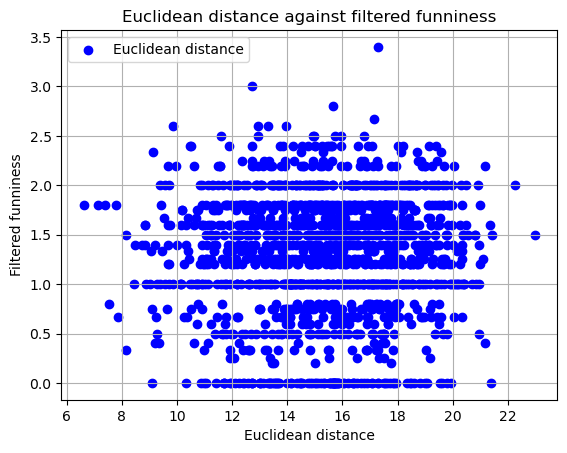

In [39]:
plt.scatter(eucl_dist, filt_avg_score, label="Euclidean distance", marker="o", color="b")

plt.xlabel("Euclidean distance")
plt.ylabel("Filtered funniness")
plt.title("Euclidean distance against filtered funniness")
plt.legend()
plt.grid()

# Show plot
plt.show()


### Cosine similarity against filtered funniness

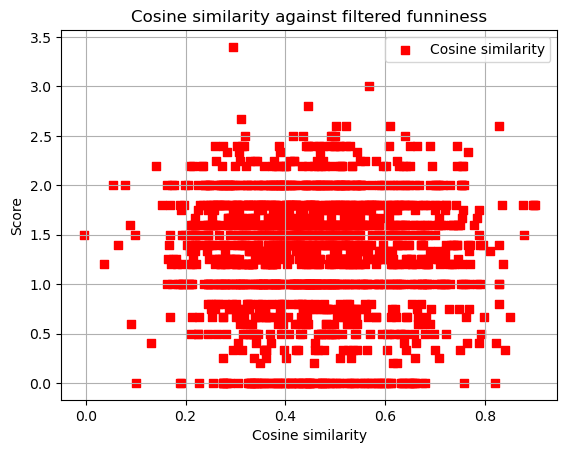

In [35]:
plt.scatter(cos_sim, filt_avg_score, label="Cosine similarity", marker="s", color="r")

# Add labels, title, and legend
plt.xlabel("Cosine similarity")
plt.ylabel("Score")
plt.title("Cosine similarity against filtered funniness")
plt.legend()
plt.grid()

# Show plot
plt.show()


### Euclidean distance against non-filtered funniness

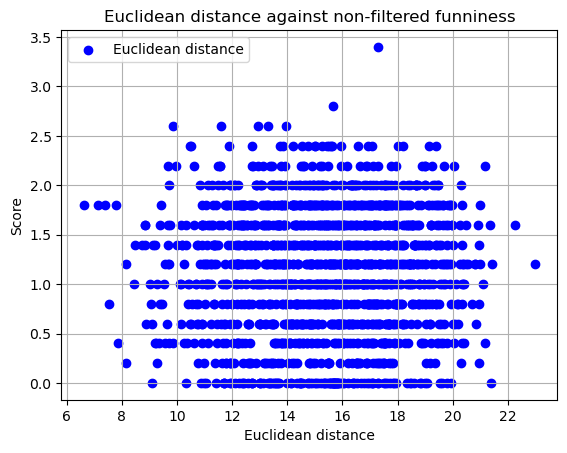

In [37]:
plt.scatter(eucl_dist, avg_score, label="Euclidean distance", marker="o", color="b")
plt.xlabel("Euclidean distance")
plt.ylabel("Score")
plt.title("Euclidean distance against non-filtered funniness")
plt.legend()
plt.grid()

# Show plot
plt.show()


### Cosine similarity against non-filtered funniness

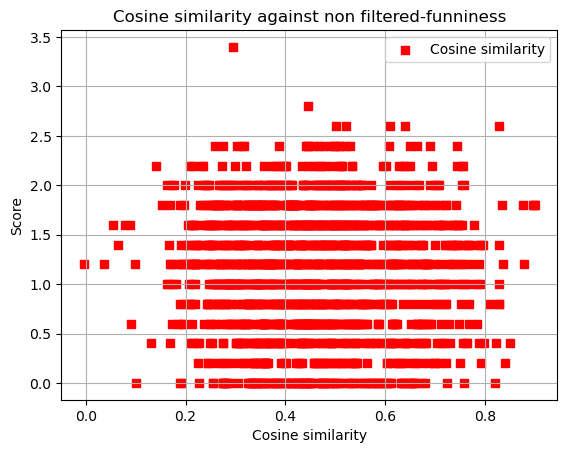

In [38]:
plt.scatter(cos_sim, avg_score, label="Cosine similarity", marker="s", color="r")

# Add labels, title, and legend
plt.xlabel("Cosine similarity")
plt.ylabel("Score")
plt.title("Cosine similarity against non filtered-funniness")
plt.legend()
plt.grid()

# Show plot
plt.show()


In [28]:
distances = pd.DataFrame(metrics, columns=['joke','expression1','expression2', 'funniness_average', 'filtered_funniness_average', 'euclidean_distance', 'cosine_similarity'])


In [29]:
distances

joke     expression1  \
0     She was only a Waitress ' s daughter but she s...     dish it out   
1     When the glazier was sent to the hospital room...            pane   
2     The inventor of sandpaper had a rough time of ...           rough   
3     OLD CONTORTIONISTS never die , they just meet ...  meet their end   
4     When you can ' t decide with your friends whos...           party   
...                                                 ...             ...   
1476  Weather forecasters have to have lots of degre...         degrees   
1477  Christians , keep the faith . . . but not from...            keep   
1478  There ' s a Sin dividing line between heaven a...             sin   
1479  A computer program attached to an electric cha...       execution   
1480  The inventor of the fahrenheit scale solved th...         degrees   

         expression2  funniness_average  filtered_funniness_average  \
0        dish it out                0.6                    1.000000   
1               pain                1.2                    2.000000   
2              rough                1.6                    1.600000   
3     meet their end                0.2                    1.000000   
4              party                0.4                    0.666667   
...              ...                ...                         ...   
1476         degrees                2.0                    2.000000   
1477            keep                0.0                    0.000000   
1478            sign                0.0                    0.000000   
1479       execution                0.8                    1.000000   
1480         degrees                0.6                    1.500000   

      euclidean_distance  cosine_similarity  
0              12.621944           0.586709  
1              18.441320           0.247996  
2              13.749227           0.514092  
3              10.762417           0.673233  
4              16.522305           0.393078  
...                  ...                ...  
1476           11.932990           0.707570  
1477           11.955064           0.632835  
1478           17.085299           0.383086  
1479           16.785654           0.331882  
1480           16.415155           0.392778  

[1481 rows x 7 columns]

In [30]:
distances.to_csv("distances_single_tokens_colbert_12feb.csv", encoding='utf-8', index=False)
